<a href="https://colab.research.google.com/github/sriksmachi/supercabs/blob/master/DQN_Agent_Arch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Learning 

A sample project for building an RL based system using Deep Q Learning. 

## Problem Statement

In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 

Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day. 

In this notebook will learn to build a RL based system to assist cab drivers maximize profits. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/supercabs

/content/drive/MyDrive/Colab Notebooks/supercabs


### Solution Summary

- After training the DQN Agent for 10K episodes using Architecture 2 (by passing state vector only as input), the rewards converged between 1500-2000.
- The training report is available [here](https://wandb.ai/sriksmachi/supercar-assignment/reports/Deep-Q-Learning---Vmlldzo3ODU3MDI?accessToken=n38pr0loru2bxf2tjgxjkvibrhn72x7p7vkeem2w7fx0u3i10glbft6wvfwsyf0v) 
- Few sample state_action pairs tracked also shows convergence as shown below. 
- The Agent was training with higher number of batch size, varying epsilon decay by choosing different exploitation and exploration ranges, the current hyperparameters are the best fit. 
- This Model can now be used to predict the best action to taken given a state of the driver so that the rewards are maximum per episode. 

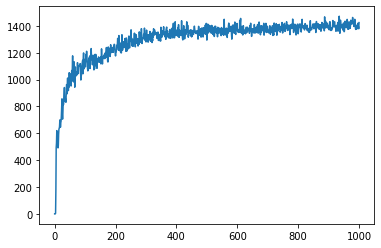

In [21]:
# Open an existing states tracking pickle
import pickle
import matplotlib.pyplot as plt

with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)    

i = 0
x_axis = range(0, len(States_track[i]))
y_axis = States_track[i]
plt.plot(x_axis,y_axis)

In [3]:
!pip install wandb
import wandb
wandb.init(project='supercar-assignment', entity='sriksmachi')

wandb: Currently logged in as: sriksmachi (use `wandb login --relogin` to force relogin)


### Importing classes

In [4]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tqdm

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
env = CabDriver()
epsiode_length = 24*30

### States to be tracked

In [6]:
# Declaring States to track
states_action_to_track = [[(2,10,1), 9], [[2,5,6], 11], [[2,16,0], 10],  [[0,6,5], 19],  [[3,1,5], 20],  [[4,12,4], 3]]
state_action_tracked_results = [[],[],[],[],[],[]]

#### Save Object as Pickle


In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

In [8]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, discount_factor=0.98, learning_rate=0.001,
                       epsilon=1, epsilon_decay=0.0005, epsilon_min=0.0001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size 
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.learning_rate = learning_rate      
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = 64     
        self.state_encoded = 36 # (m + t + d)
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_encoded, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.summary
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        indexes, _ = env.requests(state)
        if np.random.rand() <= self.epsilon:

            # get possible requests/actions given a state
            # choose an action randomly, this will contain the no-ride action
            return random.choice(indexes)
        else:

            # get q_value for all actions = this should be 21 (20 actions + no ride)
            state_encoded = env.state_encod_arch2(state)
            state_encoded = np.reshape(state_encoded, [1, self.state_encoded])

            # predicting the q value using the model trained so far. 
            q_value = self.model.predict(state_encoded)

            # get q_values for the actions/requests which the cab driver received
            # the index should include the index for no-ride
            filtered_q_values = [q_value[0][i] for i in indexes]

            # get the index with max q-value
            max_q_value_index = np.argmax(filtered_q_values)

            # print(f'max_q_value_index..{max_q_value_index}')
            return indexes[max_q_value_index]
        
    # adds the experience to memory
    def append_sample(self, state, action, reward, next_state, hours_of_trip):
        # append the tuple (s, a, r, s', hoursoftrip) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, hours_of_trip))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_encoded))
            update_input = np.zeros((self.batch_size, self.state_encoded))
            actions, rewards, trip_hours_per_exp = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, hours_of_trip = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                next_state_encod = env.state_encod_arch2(next_state)
                update_input[i] = state_encod
                update_output[i] = next_state_encod
                actions.append(action)
                rewards.append(reward)
                trip_hours_per_exp.append(hours_of_trip)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)   
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                # find if it is the terminal state
                if (trip_hours_per_exp[i] >= epsiode_length):
                    # if it is the terminal state (i.e. if it is the end of the month) then the target q value is just the reward
                    target[i][actions[i]] = rewards[i]
                else:
                    # if it is not terminal state then the target value = reward + discount * (max(q(next_state, a)))
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_qval[i]))

            # 4. Fit your model and track the loss values
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return history

    #This function will append latest Q-values which are being tracked for checking convergence
    def save_tracking_states(self, states_action_to_track, state_action_tracked_results):
        for idx, state_action in enumerate(states_action_to_track):
            state_encoded = env.state_encod_arch2(state_action[0])
            state_encoded = np.reshape(state_encoded, [1, agent.state_encoded])
            q_val = agent.model.predict(state_encoded)
            state_action_tracked_results[idx].append(q_val[0][state_action[1]])



### Test Bed. 

In [9]:
# This code is used to test some key functionalities

state_size = len(env.state_space)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
state = env.state_init
print(state)
action = agent.get_action(state)
print(action)
state, reward, next_state, trip_hours = env.step(state, env.action_space[action], Time_matrix, 0)
(state, reward, next_state, trip_hours)
agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
print(state_action_tracked_results)

(1, 21, 0)
12
[[0.16015486], [0.0], [0.0], [0.41854495], [0.0], [0.35103846]]


### Setup Parameters for Training

In [10]:
# Epsilon values per episode
# 100 - 0.05
# 1000 - 0.005
# 10000 - 0.0005 - 10+ hours
# 20000 - 0.0003 - 20-30 hours
# 30000 - 0.0002 - 80 hours

episodes = 10000   
epsilon_decay = 0.0005
config = wandb.config # this is for reporting only
config.learning_rate = 0.001
state_size = len(env.state_space)
action_size = len(env.action_space) 
threshold = 1000
agent = DQNAgent(state_size, action_size, epsilon_decay=epsilon_decay, learning_rate=config.learning_rate)

### DQN block

In [11]:
import time
start_time = time.time()
rewards_tracked = []
loss_tracked = []

for episode in tqdm.tqdm(range(episodes)):

    # Call the environment
    env = CabDriver()

    # Call all the initialised variables of the environment
    state_size = len(env.state_space)
    action_size = len(env.action_space) # for no-ride
    initial_state = env.state_init
    current_state = env.state_init
    steps = 0 # cab driver starts with 0 trip hours
    total_reward = 0
    training_steps = 0 
    
    while steps <= epsiode_length: # each episode is 30 days long
        
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(current_state)

        # 2. Evaluate your reward and next state
        state, reward, next_state, hours_of_trip = env.step(current_state, env.action_space[action], Time_matrix, steps)

        # 3. Append the experience to the memory
        agent.append_sample(current_state, action, reward, next_state, hours_of_trip)
        
        # no need to train for every experience we can train based on threshold.
        # 4. Train the model by calling function agent.train_model
        if training_steps % 10 == 0:
          history = agent.train_model()
          # Track Loss
          if (history is not None):
            loss = history.history["loss"][0]
            loss_tracked.append(loss)
            wandb.log({"loss": loss})

        # Numer of days completed = steps, the episode ends when 24*30 hours are completed
        steps += hours_of_trip 

        # next state becomes current state for next step
        current_state = next_state

        # 5. Keep a track of rewards, Q-values, loss
        total_reward += reward

        training_steps +=1

    # Track rewards
    rewards_tracked.append(total_reward)
    wandb.log({"epsilon":agent.epsilon})
    wandb.log({"rewards":total_reward})

    # Save States Tracked  
    if episode % 10 == 0:
      agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
      save_obj(state_action_tracked_results,'States_tracked')

    # Save the model 
    if episode % threshold == 0:
        agent.model.save("supercabs.h5", overwrite=True)
    
    print(f'Episode: {episode} Total Reward: {total_reward}, epsilon: {agent.epsilon}, Buffer Length: {len(agent.memory)}, Trip Hours: {steps}')

    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay * episode)

elapsed_time = time.time() - start_time
print(f'{round(elapsed_time/60,2)} min')

  0%|          | 1/10000 [00:07<21:00:09,  7.56s/it]

Episode: 0 Total Reward: -266, epsilon: 1, Buffer Length: 154, Trip Hours: 721


  0%|          | 2/10000 [00:08<15:44:34,  5.67s/it]

Episode: 1 Total Reward: -322, epsilon: 1.0, Buffer Length: 289, Trip Hours: 734


  0%|          | 3/10000 [00:10<12:04:30,  4.35s/it]

Episode: 2 Total Reward: -543, epsilon: 0.9995001749666714, Buffer Length: 423, Trip Hours: 726


  0%|          | 4/10000 [00:11<9:25:20,  3.39s/it] 

Episode: 3 Total Reward: -240, epsilon: 0.9990005997833917, Buffer Length: 545, Trip Hours: 723


  0%|          | 5/10000 [00:12<7:43:40,  2.78s/it]

Episode: 4 Total Reward: -501, epsilon: 0.9985012743252671, Buffer Length: 690, Trip Hours: 723


  0%|          | 6/10000 [00:13<6:27:47,  2.33s/it]

Episode: 5 Total Reward: 5, epsilon: 0.9980021984674663, Buffer Length: 824, Trip Hours: 728


  0%|          | 7/10000 [00:15<5:44:34,  2.07s/it]

Episode: 6 Total Reward: -480, epsilon: 0.9975033720852203, Buffer Length: 975, Trip Hours: 726


  0%|          | 8/10000 [00:16<5:06:53,  1.84s/it]

Episode: 7 Total Reward: 194, epsilon: 0.9970047950538227, Buffer Length: 1111, Trip Hours: 728


  0%|          | 9/10000 [00:18<4:43:34,  1.70s/it]

Episode: 8 Total Reward: -241, epsilon: 0.9965064672486288, Buffer Length: 1254, Trip Hours: 725


  0%|          | 10/10000 [00:19<4:13:04,  1.52s/it]

Episode: 9 Total Reward: -68, epsilon: 0.9960083885450571, Buffer Length: 1374, Trip Hours: 721


  0%|          | 11/10000 [00:20<4:15:26,  1.53s/it]

Episode: 10 Total Reward: -280, epsilon: 0.9955105588185876, Buffer Length: 1519, Trip Hours: 722


  0%|          | 12/10000 [00:21<4:02:30,  1.46s/it]

Episode: 11 Total Reward: -177, epsilon: 0.9950129779447631, Buffer Length: 1659, Trip Hours: 723


  0%|          | 13/10000 [00:23<3:55:10,  1.41s/it]

Episode: 12 Total Reward: -473, epsilon: 0.9945156457991882, Buffer Length: 1799, Trip Hours: 721


  0%|          | 14/10000 [00:24<4:00:58,  1.45s/it]

Episode: 13 Total Reward: -507, epsilon: 0.9940185622575299, Buffer Length: 1955, Trip Hours: 726


  0%|          | 15/10000 [00:26<4:02:07,  1.45s/it]

Episode: 14 Total Reward: -395, epsilon: 0.9935217271955173, Buffer Length: 2000, Trip Hours: 727


  0%|          | 16/10000 [00:27<3:53:53,  1.41s/it]

Episode: 15 Total Reward: -451, epsilon: 0.9930251404889417, Buffer Length: 2000, Trip Hours: 731


  0%|          | 17/10000 [00:28<3:50:16,  1.38s/it]

Episode: 16 Total Reward: -280, epsilon: 0.9925288020136565, Buffer Length: 2000, Trip Hours: 722


  0%|          | 18/10000 [00:30<3:50:33,  1.39s/it]

Episode: 17 Total Reward: -170, epsilon: 0.9920327116455769, Buffer Length: 2000, Trip Hours: 727


  0%|          | 19/10000 [00:31<3:50:06,  1.38s/it]

Episode: 18 Total Reward: -167, epsilon: 0.9915368692606804, Buffer Length: 2000, Trip Hours: 721


  0%|          | 20/10000 [00:32<3:45:39,  1.36s/it]

Episode: 19 Total Reward: -32, epsilon: 0.9910412747350064, Buffer Length: 2000, Trip Hours: 721


  0%|          | 21/10000 [00:34<3:50:53,  1.39s/it]

Episode: 20 Total Reward: -266, epsilon: 0.9905459279446561, Buffer Length: 2000, Trip Hours: 721


  0%|          | 22/10000 [00:35<3:54:41,  1.41s/it]

Episode: 21 Total Reward: -316, epsilon: 0.9900508287657932, Buffer Length: 2000, Trip Hours: 722


  0%|          | 23/10000 [00:37<3:42:18,  1.34s/it]

Episode: 22 Total Reward: -110, epsilon: 0.9895559770746425, Buffer Length: 2000, Trip Hours: 724


  0%|          | 24/10000 [00:38<3:40:59,  1.33s/it]

Episode: 23 Total Reward: -586, epsilon: 0.9890613727474912, Buffer Length: 2000, Trip Hours: 722


  0%|          | 25/10000 [00:39<3:40:43,  1.33s/it]

Episode: 24 Total Reward: 103, epsilon: 0.9885670156606883, Buffer Length: 2000, Trip Hours: 721


  0%|          | 26/10000 [00:41<3:52:51,  1.40s/it]

Episode: 25 Total Reward: -163, epsilon: 0.9880729056906443, Buffer Length: 2000, Trip Hours: 731


  0%|          | 27/10000 [00:42<3:47:37,  1.37s/it]

Episode: 26 Total Reward: 171, epsilon: 0.987579042713832, Buffer Length: 2000, Trip Hours: 729


  0%|          | 28/10000 [00:43<3:44:47,  1.35s/it]

Episode: 27 Total Reward: 25, epsilon: 0.9870854266067856, Buffer Length: 2000, Trip Hours: 724


  0%|          | 29/10000 [00:45<3:50:22,  1.39s/it]

Episode: 28 Total Reward: 206, epsilon: 0.9865920572461009, Buffer Length: 2000, Trip Hours: 722


  0%|          | 30/10000 [00:46<3:52:33,  1.40s/it]

Episode: 29 Total Reward: -424, epsilon: 0.9860989345084356, Buffer Length: 2000, Trip Hours: 722


  0%|          | 31/10000 [00:48<4:07:51,  1.49s/it]

Episode: 30 Total Reward: 94, epsilon: 0.9856060582705092, Buffer Length: 2000, Trip Hours: 730


  0%|          | 32/10000 [00:49<3:54:49,  1.41s/it]

Episode: 31 Total Reward: -149, epsilon: 0.9851134284091023, Buffer Length: 2000, Trip Hours: 721


  0%|          | 33/10000 [00:51<4:01:16,  1.45s/it]

Episode: 32 Total Reward: 227, epsilon: 0.9846210448010577, Buffer Length: 2000, Trip Hours: 725


  0%|          | 34/10000 [00:52<3:58:17,  1.43s/it]

Episode: 33 Total Reward: -253, epsilon: 0.9841289073232796, Buffer Length: 2000, Trip Hours: 722


  0%|          | 35/10000 [00:54<4:03:02,  1.46s/it]

Episode: 34 Total Reward: -433, epsilon: 0.9836370158527333, Buffer Length: 2000, Trip Hours: 722


  0%|          | 36/10000 [00:55<3:53:33,  1.41s/it]

Episode: 35 Total Reward: 64, epsilon: 0.9831453702664461, Buffer Length: 2000, Trip Hours: 727


  0%|          | 37/10000 [00:56<4:00:36,  1.45s/it]

Episode: 36 Total Reward: -404, epsilon: 0.9826539704415067, Buffer Length: 2000, Trip Hours: 727


  0%|          | 38/10000 [00:58<3:56:12,  1.42s/it]

Episode: 37 Total Reward: -321, epsilon: 0.982162816255065, Buffer Length: 2000, Trip Hours: 723


  0%|          | 39/10000 [00:59<4:02:17,  1.46s/it]

Episode: 38 Total Reward: 20, epsilon: 0.9816719075843323, Buffer Length: 2000, Trip Hours: 725


  0%|          | 40/10000 [01:01<3:58:48,  1.44s/it]

Episode: 39 Total Reward: -255, epsilon: 0.9811812443065817, Buffer Length: 2000, Trip Hours: 726


  0%|          | 41/10000 [01:02<4:10:27,  1.51s/it]

Episode: 40 Total Reward: 157, epsilon: 0.9806908262991473, Buffer Length: 2000, Trip Hours: 721


  0%|          | 42/10000 [01:04<4:19:19,  1.56s/it]

Episode: 41 Total Reward: -257, epsilon: 0.9802006534394245, Buffer Length: 2000, Trip Hours: 721


  0%|          | 43/10000 [01:06<4:12:07,  1.52s/it]

Episode: 42 Total Reward: -392, epsilon: 0.9797107256048704, Buffer Length: 2000, Trip Hours: 721


  0%|          | 44/10000 [01:07<4:04:36,  1.47s/it]

Episode: 43 Total Reward: -52, epsilon: 0.9792210426730026, Buffer Length: 2000, Trip Hours: 725


  0%|          | 45/10000 [01:08<3:58:02,  1.43s/it]

Episode: 44 Total Reward: -176, epsilon: 0.9787316045214007, Buffer Length: 2000, Trip Hours: 721


  0%|          | 46/10000 [01:10<4:07:34,  1.49s/it]

Episode: 45 Total Reward: -82, epsilon: 0.9782424110277049, Buffer Length: 2000, Trip Hours: 722


  0%|          | 47/10000 [01:11<4:03:22,  1.47s/it]

Episode: 46 Total Reward: -28, epsilon: 0.977753462069617, Buffer Length: 2000, Trip Hours: 722


  0%|          | 48/10000 [01:13<4:03:11,  1.47s/it]

Episode: 47 Total Reward: 48, epsilon: 0.9772647575248997, Buffer Length: 2000, Trip Hours: 723


  0%|          | 49/10000 [01:14<3:57:13,  1.43s/it]

Episode: 48 Total Reward: -279, epsilon: 0.9767762972713769, Buffer Length: 2000, Trip Hours: 729


  0%|          | 50/10000 [01:15<3:48:18,  1.38s/it]

Episode: 49 Total Reward: 53, epsilon: 0.9762880811869336, Buffer Length: 2000, Trip Hours: 722


  1%|          | 51/10000 [01:17<4:03:11,  1.47s/it]

Episode: 50 Total Reward: -45, epsilon: 0.9758001091495155, Buffer Length: 2000, Trip Hours: 729


  1%|          | 52/10000 [01:18<3:56:43,  1.43s/it]

Episode: 51 Total Reward: -233, epsilon: 0.9753123810371298, Buffer Length: 2000, Trip Hours: 727


  1%|          | 53/10000 [01:20<3:54:36,  1.42s/it]

Episode: 52 Total Reward: -266, epsilon: 0.9748248967278446, Buffer Length: 2000, Trip Hours: 721


  1%|          | 54/10000 [01:21<3:49:41,  1.39s/it]

Episode: 53 Total Reward: -280, epsilon: 0.9743376560997885, Buffer Length: 2000, Trip Hours: 722


  1%|          | 55/10000 [01:22<3:49:58,  1.39s/it]

Episode: 54 Total Reward: 92, epsilon: 0.9738506590311514, Buffer Length: 2000, Trip Hours: 725


  1%|          | 56/10000 [01:24<4:08:24,  1.50s/it]

Episode: 55 Total Reward: 185, epsilon: 0.9733639054001844, Buffer Length: 2000, Trip Hours: 728


  1%|          | 57/10000 [01:26<4:10:49,  1.51s/it]

Episode: 56 Total Reward: 98, epsilon: 0.9728773950851987, Buffer Length: 2000, Trip Hours: 722


  1%|          | 58/10000 [01:27<4:12:28,  1.52s/it]

Episode: 57 Total Reward: 182, epsilon: 0.9723911279645667, Buffer Length: 2000, Trip Hours: 725


  1%|          | 59/10000 [01:29<4:19:15,  1.56s/it]

Episode: 58 Total Reward: -431, epsilon: 0.971905103916722, Buffer Length: 2000, Trip Hours: 727


  1%|          | 60/10000 [01:30<4:04:57,  1.48s/it]

Episode: 59 Total Reward: -235, epsilon: 0.9714193228201581, Buffer Length: 2000, Trip Hours: 722


  1%|          | 61/10000 [01:32<4:08:33,  1.50s/it]

Episode: 60 Total Reward: -564, epsilon: 0.9709337845534302, Buffer Length: 2000, Trip Hours: 723


  1%|          | 62/10000 [01:33<3:58:31,  1.44s/it]

Episode: 61 Total Reward: 31, epsilon: 0.9704484889951533, Buffer Length: 2000, Trip Hours: 721


  1%|          | 63/10000 [01:35<3:59:33,  1.45s/it]

Episode: 62 Total Reward: -156, epsilon: 0.9699634360240038, Buffer Length: 2000, Trip Hours: 726


  1%|          | 64/10000 [01:36<3:49:34,  1.39s/it]

Episode: 63 Total Reward: -114, epsilon: 0.9694786255187183, Buffer Length: 2000, Trip Hours: 723


  1%|          | 65/10000 [01:37<3:59:45,  1.45s/it]

Episode: 64 Total Reward: 19, epsilon: 0.9689940573580943, Buffer Length: 2000, Trip Hours: 727


  1%|          | 66/10000 [01:39<4:08:30,  1.50s/it]

Episode: 65 Total Reward: -147, epsilon: 0.9685097314209897, Buffer Length: 2000, Trip Hours: 726


  1%|          | 67/10000 [01:40<4:01:18,  1.46s/it]

Episode: 66 Total Reward: -269, epsilon: 0.9680256475863229, Buffer Length: 2000, Trip Hours: 727


  1%|          | 68/10000 [01:42<4:05:20,  1.48s/it]

Episode: 67 Total Reward: 184, epsilon: 0.9675418057330731, Buffer Length: 2000, Trip Hours: 721


  1%|          | 69/10000 [01:44<4:16:22,  1.55s/it]

Episode: 68 Total Reward: -60, epsilon: 0.9670582057402797, Buffer Length: 2000, Trip Hours: 732


  1%|          | 70/10000 [01:45<4:17:55,  1.56s/it]

Episode: 69 Total Reward: -111, epsilon: 0.9665748474870429, Buffer Length: 2000, Trip Hours: 726


  1%|          | 71/10000 [01:47<4:16:26,  1.55s/it]

Episode: 70 Total Reward: -150, epsilon: 0.9660917308525229, Buffer Length: 2000, Trip Hours: 723


  1%|          | 72/10000 [01:48<4:13:45,  1.53s/it]

Episode: 71 Total Reward: 17, epsilon: 0.9656088557159407, Buffer Length: 2000, Trip Hours: 722


  1%|          | 73/10000 [01:50<4:13:37,  1.53s/it]

Episode: 72 Total Reward: 83, epsilon: 0.9651262219565775, Buffer Length: 2000, Trip Hours: 725


  1%|          | 74/10000 [01:51<4:07:45,  1.50s/it]

Episode: 73 Total Reward: -92, epsilon: 0.9646438294537748, Buffer Length: 2000, Trip Hours: 724


  1%|          | 75/10000 [01:53<4:12:16,  1.53s/it]

Episode: 74 Total Reward: 59, epsilon: 0.9641616780869344, Buffer Length: 2000, Trip Hours: 728


  1%|          | 76/10000 [01:54<4:02:05,  1.46s/it]

Episode: 75 Total Reward: 84, epsilon: 0.9636797677355186, Buffer Length: 2000, Trip Hours: 723


  1%|          | 77/10000 [01:56<4:03:33,  1.47s/it]

Episode: 76 Total Reward: -163, epsilon: 0.9631980982790498, Buffer Length: 2000, Trip Hours: 722


  1%|          | 78/10000 [01:57<3:51:05,  1.40s/it]

Episode: 77 Total Reward: 107, epsilon: 0.9627166695971104, Buffer Length: 2000, Trip Hours: 722


  1%|          | 79/10000 [01:58<4:04:29,  1.48s/it]

Episode: 78 Total Reward: 290, epsilon: 0.9622354815693436, Buffer Length: 2000, Trip Hours: 725


  1%|          | 80/10000 [02:00<4:11:43,  1.52s/it]

Episode: 79 Total Reward: -248, epsilon: 0.9617545340754521, Buffer Length: 2000, Trip Hours: 730


  1%|          | 81/10000 [02:02<4:16:57,  1.55s/it]

Episode: 80 Total Reward: -563, epsilon: 0.9612738269951991, Buffer Length: 2000, Trip Hours: 721


  1%|          | 82/10000 [02:03<4:10:23,  1.51s/it]

Episode: 81 Total Reward: -92, epsilon: 0.960793360208408, Buffer Length: 2000, Trip Hours: 724


  1%|          | 83/10000 [02:05<4:07:28,  1.50s/it]

Episode: 82 Total Reward: -411, epsilon: 0.9603131335949618, Buffer Length: 2000, Trip Hours: 723


  1%|          | 84/10000 [02:06<4:07:17,  1.50s/it]

Episode: 83 Total Reward: -195, epsilon: 0.9598331470348042, Buffer Length: 2000, Trip Hours: 723


  1%|          | 85/10000 [02:08<4:13:20,  1.53s/it]

Episode: 84 Total Reward: -193, epsilon: 0.9593534004079382, Buffer Length: 2000, Trip Hours: 728


  1%|          | 86/10000 [02:09<4:13:28,  1.53s/it]

Episode: 85 Total Reward: -329, epsilon: 0.9588738935944272, Buffer Length: 2000, Trip Hours: 721


  1%|          | 87/10000 [02:11<4:09:05,  1.51s/it]

Episode: 86 Total Reward: -106, epsilon: 0.9583946264743949, Buffer Length: 2000, Trip Hours: 725


  1%|          | 88/10000 [02:12<3:59:00,  1.45s/it]

Episode: 87 Total Reward: -186, epsilon: 0.9579155989280239, Buffer Length: 2000, Trip Hours: 723


  1%|          | 89/10000 [02:14<4:04:06,  1.48s/it]

Episode: 88 Total Reward: -12, epsilon: 0.9574368108355579, Buffer Length: 2000, Trip Hours: 726


  1%|          | 90/10000 [02:16<4:26:19,  1.61s/it]

Episode: 89 Total Reward: -285, epsilon: 0.9569582620772994, Buffer Length: 2000, Trip Hours: 723


  1%|          | 91/10000 [02:17<4:22:16,  1.59s/it]

Episode: 90 Total Reward: -120, epsilon: 0.9564799525336114, Buffer Length: 2000, Trip Hours: 726


  1%|          | 92/10000 [02:18<4:07:52,  1.50s/it]

Episode: 91 Total Reward: -304, epsilon: 0.9560018820849167, Buffer Length: 2000, Trip Hours: 725


  1%|          | 93/10000 [02:20<4:08:57,  1.51s/it]

Episode: 92 Total Reward: 188, epsilon: 0.9555240506116972, Buffer Length: 2000, Trip Hours: 722


  1%|          | 94/10000 [02:21<4:13:00,  1.53s/it]

Episode: 93 Total Reward: -142, epsilon: 0.9550464579944956, Buffer Length: 2000, Trip Hours: 725


  1%|          | 95/10000 [02:23<4:14:25,  1.54s/it]

Episode: 94 Total Reward: 129, epsilon: 0.9545691041139133, Buffer Length: 2000, Trip Hours: 723


  1%|          | 96/10000 [02:25<4:23:47,  1.60s/it]

Episode: 95 Total Reward: -230, epsilon: 0.9540919888506121, Buffer Length: 2000, Trip Hours: 721


  1%|          | 97/10000 [02:26<4:14:01,  1.54s/it]

Episode: 96 Total Reward: -160, epsilon: 0.9536151120853131, Buffer Length: 2000, Trip Hours: 725


  1%|          | 98/10000 [02:28<4:21:19,  1.58s/it]

Episode: 97 Total Reward: -60, epsilon: 0.953138473698797, Buffer Length: 2000, Trip Hours: 723


  1%|          | 99/10000 [02:29<4:18:37,  1.57s/it]

Episode: 98 Total Reward: -82, epsilon: 0.9526620735719042, Buffer Length: 2000, Trip Hours: 722


  1%|          | 100/10000 [02:31<4:15:16,  1.55s/it]

Episode: 99 Total Reward: -236, epsilon: 0.952185911585535, Buffer Length: 2000, Trip Hours: 724


  1%|          | 101/10000 [02:33<4:26:30,  1.62s/it]

Episode: 100 Total Reward: -221, epsilon: 0.9517099876206485, Buffer Length: 2000, Trip Hours: 721


  1%|          | 102/10000 [02:34<4:30:16,  1.64s/it]

Episode: 101 Total Reward: -226, epsilon: 0.9512343015582639, Buffer Length: 2000, Trip Hours: 722


  1%|          | 103/10000 [02:36<4:20:32,  1.58s/it]

Episode: 102 Total Reward: -43, epsilon: 0.9507588532794596, Buffer Length: 2000, Trip Hours: 725


  1%|          | 104/10000 [02:37<4:21:31,  1.59s/it]

Episode: 103 Total Reward: -194, epsilon: 0.9502836426653738, Buffer Length: 2000, Trip Hours: 730


  1%|          | 105/10000 [02:39<4:29:48,  1.64s/it]

Episode: 104 Total Reward: 30, epsilon: 0.9498086695972033, Buffer Length: 2000, Trip Hours: 723


  1%|          | 106/10000 [02:41<4:28:35,  1.63s/it]

Episode: 105 Total Reward: -241, epsilon: 0.9493339339562052, Buffer Length: 2000, Trip Hours: 734


  1%|          | 107/10000 [02:42<4:16:11,  1.55s/it]

Episode: 106 Total Reward: -172, epsilon: 0.9488594356236957, Buffer Length: 2000, Trip Hours: 722


  1%|          | 108/10000 [02:44<4:17:03,  1.56s/it]

Episode: 107 Total Reward: -440, epsilon: 0.94838517448105, Buffer Length: 2000, Trip Hours: 727


  1%|          | 109/10000 [02:45<4:07:42,  1.50s/it]

Episode: 108 Total Reward: -119, epsilon: 0.9479111504097028, Buffer Length: 2000, Trip Hours: 724


  1%|          | 110/10000 [02:47<4:11:18,  1.52s/it]

Episode: 109 Total Reward: -92, epsilon: 0.9474373632911481, Buffer Length: 2000, Trip Hours: 724


  1%|          | 111/10000 [02:48<4:22:07,  1.59s/it]

Episode: 110 Total Reward: -240, epsilon: 0.9469638130069393, Buffer Length: 2000, Trip Hours: 723


  1%|          | 112/10000 [02:50<4:19:03,  1.57s/it]

Episode: 111 Total Reward: -60, epsilon: 0.9464904994386885, Buffer Length: 2000, Trip Hours: 723


  1%|          | 113/10000 [02:51<4:08:34,  1.51s/it]

Episode: 112 Total Reward: -48, epsilon: 0.9460174224680676, Buffer Length: 2000, Trip Hours: 726


  1%|          | 114/10000 [02:53<4:16:54,  1.56s/it]

Episode: 113 Total Reward: -186, epsilon: 0.9455445819768072, Buffer Length: 2000, Trip Hours: 732


  1%|          | 115/10000 [02:54<4:12:26,  1.53s/it]

Episode: 114 Total Reward: -294, epsilon: 0.9450719778466973, Buffer Length: 2000, Trip Hours: 723


  1%|          | 116/10000 [02:56<4:09:22,  1.51s/it]

Episode: 115 Total Reward: -299, epsilon: 0.9445996099595867, Buffer Length: 2000, Trip Hours: 733


  1%|          | 117/10000 [02:57<4:05:41,  1.49s/it]

Episode: 116 Total Reward: 76, epsilon: 0.9441274781973835, Buffer Length: 2000, Trip Hours: 721


  1%|          | 118/10000 [02:59<3:54:22,  1.42s/it]

Episode: 117 Total Reward: -42, epsilon: 0.9436555824420548, Buffer Length: 2000, Trip Hours: 723


  1%|          | 119/10000 [03:00<3:59:16,  1.45s/it]

Episode: 118 Total Reward: -31, epsilon: 0.9431839225756267, Buffer Length: 2000, Trip Hours: 728


  1%|          | 120/10000 [03:02<4:06:33,  1.50s/it]

Episode: 119 Total Reward: -174, epsilon: 0.942712498480184, Buffer Length: 2000, Trip Hours: 726


  1%|          | 121/10000 [03:04<4:37:31,  1.69s/it]

Episode: 120 Total Reward: -367, epsilon: 0.9422413100378709, Buffer Length: 2000, Trip Hours: 725


  1%|          | 122/10000 [03:06<4:38:36,  1.69s/it]

Episode: 121 Total Reward: 256, epsilon: 0.9417703571308903, Buffer Length: 2000, Trip Hours: 721


  1%|          | 123/10000 [03:07<4:31:58,  1.65s/it]

Episode: 122 Total Reward: -58, epsilon: 0.9412996396415039, Buffer Length: 2000, Trip Hours: 728


  1%|          | 124/10000 [03:09<4:42:03,  1.71s/it]

Episode: 123 Total Reward: 97, epsilon: 0.9408291574520321, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 125/10000 [03:10<4:31:11,  1.65s/it]

Episode: 124 Total Reward: 253, epsilon: 0.9403589104448546, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 126/10000 [03:12<4:20:23,  1.58s/it]

Episode: 125 Total Reward: -209, epsilon: 0.9398888985024098, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 127/10000 [03:14<4:22:39,  1.60s/it]

Episode: 126 Total Reward: -285, epsilon: 0.9394191215071944, Buffer Length: 2000, Trip Hours: 732


  1%|▏         | 128/10000 [03:15<4:34:00,  1.67s/it]

Episode: 127 Total Reward: 242, epsilon: 0.9389495793417643, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 129/10000 [03:17<4:22:16,  1.59s/it]

Episode: 128 Total Reward: -257, epsilon: 0.938480271888734, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 130/10000 [03:18<4:20:50,  1.59s/it]

Episode: 129 Total Reward: -57, epsilon: 0.9380111990307763, Buffer Length: 2000, Trip Hours: 726


  1%|▏         | 131/10000 [03:20<4:38:58,  1.70s/it]

Episode: 130 Total Reward: 49, epsilon: 0.9375423606506236, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 132/10000 [03:22<4:37:38,  1.69s/it]

Episode: 131 Total Reward: -107, epsilon: 0.9370737566310657, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 133/10000 [03:23<4:30:05,  1.64s/it]

Episode: 132 Total Reward: -221, epsilon: 0.936605386854952, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 134/10000 [03:25<4:40:03,  1.70s/it]

Episode: 133 Total Reward: -104, epsilon: 0.9361372512051896, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 135/10000 [03:27<4:36:59,  1.68s/it]

Episode: 134 Total Reward: -277, epsilon: 0.9356693495647451, Buffer Length: 2000, Trip Hours: 725


  1%|▏         | 136/10000 [03:28<4:13:00,  1.54s/it]

Episode: 135 Total Reward: -239, epsilon: 0.9352016818166429, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 137/10000 [03:30<4:08:15,  1.51s/it]

Episode: 136 Total Reward: -185, epsilon: 0.9347342478439659, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 138/10000 [03:31<4:10:53,  1.53s/it]

Episode: 137 Total Reward: 51, epsilon: 0.9342670475298558, Buffer Length: 2000, Trip Hours: 726


  1%|▏         | 139/10000 [03:33<4:11:24,  1.53s/it]

Episode: 138 Total Reward: -370, epsilon: 0.9338000807575124, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 140/10000 [03:34<4:18:08,  1.57s/it]

Episode: 139 Total Reward: 354, epsilon: 0.9333333474101941, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 141/10000 [03:36<4:21:40,  1.59s/it]

Episode: 140 Total Reward: -58, epsilon: 0.9328668473712175, Buffer Length: 2000, Trip Hours: 728


  1%|▏         | 142/10000 [03:37<4:12:10,  1.53s/it]

Episode: 141 Total Reward: -55, epsilon: 0.9324005805239577, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 143/10000 [03:39<4:03:46,  1.48s/it]

Episode: 142 Total Reward: -190, epsilon: 0.9319345467518477, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 144/10000 [03:40<4:07:15,  1.51s/it]

Episode: 143 Total Reward: -137, epsilon: 0.9314687459383794, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 145/10000 [03:42<4:16:55,  1.56s/it]

Episode: 144 Total Reward: -25, epsilon: 0.9310031779671023, Buffer Length: 2000, Trip Hours: 725


  1%|▏         | 146/10000 [03:44<4:38:23,  1.70s/it]

Episode: 145 Total Reward: -125, epsilon: 0.9305378427216247, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 147/10000 [03:46<4:35:05,  1.68s/it]

Episode: 146 Total Reward: 12, epsilon: 0.9300727400856125, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 148/10000 [03:47<4:35:45,  1.68s/it]

Episode: 147 Total Reward: -116, epsilon: 0.9296078699427902, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 149/10000 [03:49<4:29:06,  1.64s/it]

Episode: 148 Total Reward: 120, epsilon: 0.9291432321769401, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 150/10000 [03:51<4:29:07,  1.64s/it]

Episode: 149 Total Reward: 34, epsilon: 0.928678826671903, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 151/10000 [03:52<4:38:04,  1.69s/it]

Episode: 150 Total Reward: -184, epsilon: 0.9282146533115775, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 152/10000 [03:54<4:31:13,  1.65s/it]

Episode: 151 Total Reward: -80, epsilon: 0.92775071197992, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 153/10000 [03:56<4:28:53,  1.64s/it]

Episode: 152 Total Reward: -10, epsilon: 0.9272870025609454, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 154/10000 [03:57<4:25:07,  1.62s/it]

Episode: 153 Total Reward: -68, epsilon: 0.9268235249387263, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 155/10000 [03:59<4:19:21,  1.58s/it]

Episode: 154 Total Reward: 27, epsilon: 0.9263602789973933, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 156/10000 [04:00<4:22:17,  1.60s/it]

Episode: 155 Total Reward: 116, epsilon: 0.9258972646211346, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 157/10000 [04:02<4:16:55,  1.57s/it]

Episode: 156 Total Reward: -339, epsilon: 0.9254344816941972, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 158/10000 [04:03<4:11:57,  1.54s/it]

Episode: 157 Total Reward: -181, epsilon: 0.924971930100885, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 159/10000 [04:05<4:19:22,  1.58s/it]

Episode: 158 Total Reward: -286, epsilon: 0.92450960972556, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 160/10000 [04:06<4:19:13,  1.58s/it]

Episode: 159 Total Reward: 124, epsilon: 0.9240475204526423, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 161/10000 [04:08<4:29:12,  1.64s/it]

Episode: 160 Total Reward: 129, epsilon: 0.9235856621666095, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 162/10000 [04:10<4:30:36,  1.65s/it]

Episode: 161 Total Reward: -132, epsilon: 0.9231240347519971, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 163/10000 [04:12<4:33:45,  1.67s/it]

Episode: 162 Total Reward: -150, epsilon: 0.9226626380933982, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 164/10000 [04:13<4:32:11,  1.66s/it]

Episode: 163 Total Reward: -77, epsilon: 0.9222014720754635, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 165/10000 [04:15<4:39:15,  1.70s/it]

Episode: 164 Total Reward: 220, epsilon: 0.9217405365829018, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 166/10000 [04:17<4:40:18,  1.71s/it]

Episode: 165 Total Reward: -191, epsilon: 0.9212798315004791, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 167/10000 [04:18<4:36:25,  1.69s/it]

Episode: 166 Total Reward: 76, epsilon: 0.9208193567130188, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 168/10000 [04:20<4:25:56,  1.62s/it]

Episode: 167 Total Reward: -345, epsilon: 0.9203591121054027, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 169/10000 [04:22<4:41:35,  1.72s/it]

Episode: 168 Total Reward: 224, epsilon: 0.9198990975625693, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 170/10000 [04:24<4:50:56,  1.78s/it]

Episode: 169 Total Reward: 43, epsilon: 0.9194393129695152, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 171/10000 [04:25<4:43:51,  1.73s/it]

Episode: 170 Total Reward: 8, epsilon: 0.918979758211294, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 172/10000 [04:27<4:52:01,  1.78s/it]

Episode: 171 Total Reward: -337, epsilon: 0.9185204331730172, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 173/10000 [04:29<4:44:38,  1.74s/it]

Episode: 172 Total Reward: 130, epsilon: 0.9180613377398534, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 174/10000 [04:30<4:26:16,  1.63s/it]

Episode: 173 Total Reward: 52, epsilon: 0.9176024717970289, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 175/10000 [04:32<4:33:34,  1.67s/it]

Episode: 174 Total Reward: 186, epsilon: 0.9171438352298271, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 176/10000 [04:34<4:42:29,  1.73s/it]

Episode: 175 Total Reward: -371, epsilon: 0.916685427923589, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 177/10000 [04:36<4:45:14,  1.74s/it]

Episode: 176 Total Reward: -80, epsilon: 0.9162272497637125, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 178/10000 [04:37<4:29:24,  1.65s/it]

Episode: 177 Total Reward: -361, epsilon: 0.9157693006356533, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 179/10000 [04:39<4:24:47,  1.62s/it]

Episode: 178 Total Reward: -87, epsilon: 0.915311580424924, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 180/10000 [04:41<4:40:12,  1.71s/it]

Episode: 179 Total Reward: -122, epsilon: 0.9148540890170945, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 181/10000 [04:42<4:46:39,  1.75s/it]

Episode: 180 Total Reward: -174, epsilon: 0.9143968262977922, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 182/10000 [04:44<4:56:18,  1.81s/it]

Episode: 181 Total Reward: 112, epsilon: 0.913939792152701, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 183/10000 [04:46<4:45:18,  1.74s/it]

Episode: 182 Total Reward: 39, epsilon: 0.9134829864675628, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 184/10000 [04:48<4:47:23,  1.76s/it]

Episode: 183 Total Reward: -292, epsilon: 0.9130264091281758, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 185/10000 [04:49<4:39:31,  1.71s/it]

Episode: 184 Total Reward: 98, epsilon: 0.912570060020396, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 186/10000 [04:51<4:35:36,  1.68s/it]

Episode: 185 Total Reward: -203, epsilon: 0.9121139390301358, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 187/10000 [04:53<4:44:52,  1.74s/it]

Episode: 186 Total Reward: -162, epsilon: 0.9116580460433653, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 188/10000 [04:55<4:44:38,  1.74s/it]

Episode: 187 Total Reward: -214, epsilon: 0.911202380946111, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 189/10000 [04:56<4:39:58,  1.71s/it]

Episode: 188 Total Reward: 44, epsilon: 0.9107469436244566, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 190/10000 [04:58<4:52:01,  1.79s/it]

Episode: 189 Total Reward: 48, epsilon: 0.9102917339645429, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 191/10000 [05:00<5:04:01,  1.86s/it]

Episode: 190 Total Reward: 11, epsilon: 0.9098367518525673, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 192/10000 [05:02<4:54:19,  1.80s/it]

Episode: 191 Total Reward: -301, epsilon: 0.9093819971747846, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 193/10000 [05:04<5:07:39,  1.88s/it]

Episode: 192 Total Reward: 70, epsilon: 0.9089274698175058, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 194/10000 [05:06<5:15:09,  1.93s/it]

Episode: 193 Total Reward: -11, epsilon: 0.9084731696670993, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 195/10000 [05:08<5:17:20,  1.94s/it]

Episode: 194 Total Reward: -41, epsilon: 0.9080190966099898, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 196/10000 [05:10<5:10:39,  1.90s/it]

Episode: 195 Total Reward: -84, epsilon: 0.9075652505326594, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 197/10000 [05:11<4:54:02,  1.80s/it]

Episode: 196 Total Reward: 201, epsilon: 0.9071116313216462, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 198/10000 [05:13<4:46:56,  1.76s/it]

Episode: 197 Total Reward: -111, epsilon: 0.9066582388635456, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 199/10000 [05:15<4:44:54,  1.74s/it]

Episode: 198 Total Reward: 75, epsilon: 0.9062050730450094, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 200/10000 [05:16<4:34:11,  1.68s/it]

Episode: 199 Total Reward: 125, epsilon: 0.9057521337527461, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 201/10000 [05:18<4:52:54,  1.79s/it]

Episode: 200 Total Reward: 169, epsilon: 0.9052994208735211, Buffer Length: 2000, Trip Hours: 733


  2%|▏         | 202/10000 [05:20<4:59:19,  1.83s/it]

Episode: 201 Total Reward: -182, epsilon: 0.904846934294156, Buffer Length: 2000, Trip Hours: 733


  2%|▏         | 203/10000 [05:22<4:35:24,  1.69s/it]

Episode: 202 Total Reward: -236, epsilon: 0.9043946739015292, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 204/10000 [05:24<4:50:43,  1.78s/it]

Episode: 203 Total Reward: -38, epsilon: 0.9039426395825756, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 205/10000 [05:25<4:44:05,  1.74s/it]

Episode: 204 Total Reward: -82, epsilon: 0.9034908312242865, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 206/10000 [05:27<4:53:48,  1.80s/it]

Episode: 205 Total Reward: 7, epsilon: 0.9030392487137099, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 207/10000 [05:29<4:49:47,  1.78s/it]

Episode: 206 Total Reward: -32, epsilon: 0.9025878919379503, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 208/10000 [05:31<4:54:26,  1.80s/it]

Episode: 207 Total Reward: -80, epsilon: 0.9021367607841684, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 209/10000 [05:32<4:41:53,  1.73s/it]

Episode: 208 Total Reward: -97, epsilon: 0.9016858551395812, Buffer Length: 2000, Trip Hours: 734


  2%|▏         | 210/10000 [05:34<4:51:31,  1.79s/it]

Episode: 209 Total Reward: -390, epsilon: 0.9012351748914625, Buffer Length: 2000, Trip Hours: 735


  2%|▏         | 211/10000 [05:36<4:58:13,  1.83s/it]

Episode: 210 Total Reward: 13, epsilon: 0.9007847199271425, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 212/10000 [05:38<4:54:06,  1.80s/it]

Episode: 211 Total Reward: -113, epsilon: 0.900334490134007, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 213/10000 [05:40<4:58:18,  1.83s/it]

Episode: 212 Total Reward: 66, epsilon: 0.8998844853994986, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 214/10000 [05:42<4:59:03,  1.83s/it]

Episode: 213 Total Reward: 295, epsilon: 0.8994347056111165, Buffer Length: 2000, Trip Hours: 733


  2%|▏         | 215/10000 [05:44<5:19:38,  1.96s/it]

Episode: 214 Total Reward: 156, epsilon: 0.8989851506564153, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 216/10000 [05:46<5:02:49,  1.86s/it]

Episode: 215 Total Reward: -127, epsilon: 0.8985358204230065, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 217/10000 [05:47<4:58:28,  1.83s/it]

Episode: 216 Total Reward: -32, epsilon: 0.8980867147985575, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 218/10000 [05:49<4:45:54,  1.75s/it]

Episode: 217 Total Reward: -50, epsilon: 0.8976378336707919, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 219/10000 [05:50<4:38:06,  1.71s/it]

Episode: 218 Total Reward: 330, epsilon: 0.8971891769274893, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 220/10000 [05:52<4:42:06,  1.73s/it]

Episode: 219 Total Reward: 90, epsilon: 0.8967407444564857, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 221/10000 [05:54<4:57:24,  1.82s/it]

Episode: 220 Total Reward: 42, epsilon: 0.8962925361456727, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 222/10000 [05:56<4:50:27,  1.78s/it]

Episode: 221 Total Reward: -115, epsilon: 0.8958445518829986, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 223/10000 [05:58<4:42:13,  1.73s/it]

Episode: 222 Total Reward: -30, epsilon: 0.895396791556467, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 224/10000 [05:59<4:40:53,  1.72s/it]

Episode: 223 Total Reward: 43, epsilon: 0.8949492550541381, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 225/10000 [06:01<4:52:30,  1.80s/it]

Episode: 224 Total Reward: -93, epsilon: 0.8945019422641275, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 226/10000 [06:03<4:33:23,  1.68s/it]

Episode: 225 Total Reward: 148, epsilon: 0.8940548530746072, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 227/10000 [06:05<4:48:27,  1.77s/it]

Episode: 226 Total Reward: 40, epsilon: 0.8936079873738049, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 228/10000 [06:07<4:55:54,  1.82s/it]

Episode: 227 Total Reward: 65, epsilon: 0.8931613450500039, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 229/10000 [06:08<4:47:20,  1.76s/it]

Episode: 228 Total Reward: 93, epsilon: 0.8927149259915439, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 230/10000 [06:10<4:46:59,  1.76s/it]

Episode: 229 Total Reward: -111, epsilon: 0.8922687300868201, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 231/10000 [06:12<5:02:39,  1.86s/it]

Episode: 230 Total Reward: -281, epsilon: 0.8918227572242834, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 232/10000 [06:14<4:56:33,  1.82s/it]

Episode: 231 Total Reward: -297, epsilon: 0.8913770072924406, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 233/10000 [06:16<4:53:35,  1.80s/it]

Episode: 232 Total Reward: -239, epsilon: 0.8909314801798544, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 234/10000 [06:17<4:44:42,  1.75s/it]

Episode: 233 Total Reward: 148, epsilon: 0.8904861757751429, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 235/10000 [06:19<4:54:20,  1.81s/it]

Episode: 234 Total Reward: -457, epsilon: 0.89004109396698, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 236/10000 [06:21<4:56:48,  1.82s/it]

Episode: 235 Total Reward: -271, epsilon: 0.889596234644095, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 237/10000 [06:23<4:43:36,  1.74s/it]

Episode: 236 Total Reward: -10, epsilon: 0.8891515976952734, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 238/10000 [06:25<5:04:55,  1.87s/it]

Episode: 237 Total Reward: -14, epsilon: 0.8887071830093559, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 239/10000 [06:26<4:47:58,  1.77s/it]

Episode: 238 Total Reward: 19, epsilon: 0.8882629904752387, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 240/10000 [06:28<4:51:44,  1.79s/it]

Episode: 239 Total Reward: -86, epsilon: 0.8878190199818738, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 241/10000 [06:30<4:49:42,  1.78s/it]

Episode: 240 Total Reward: -122, epsilon: 0.8873752714182686, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 242/10000 [06:32<4:49:07,  1.78s/it]

Episode: 241 Total Reward: -158, epsilon: 0.8869317446734858, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 243/10000 [06:33<4:46:57,  1.76s/it]

Episode: 242 Total Reward: 47, epsilon: 0.8864884396366438, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 244/10000 [06:35<4:50:37,  1.79s/it]

Episode: 243 Total Reward: 93, epsilon: 0.8860453561969163, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 245/10000 [06:37<4:42:11,  1.74s/it]

Episode: 244 Total Reward: 112, epsilon: 0.8856024942435324, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 246/10000 [06:38<4:34:32,  1.69s/it]

Episode: 245 Total Reward: -201, epsilon: 0.8851598536657769, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 247/10000 [06:40<4:44:44,  1.75s/it]

Episode: 246 Total Reward: -510, epsilon: 0.8847174343529892, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 248/10000 [06:42<4:45:39,  1.76s/it]

Episode: 247 Total Reward: 165, epsilon: 0.8842752361945648, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 249/10000 [06:44<4:38:50,  1.72s/it]

Episode: 248 Total Reward: -241, epsilon: 0.883833259079954, Buffer Length: 2000, Trip Hours: 725


  2%|▎         | 250/10000 [06:46<4:48:24,  1.77s/it]

Episode: 249 Total Reward: 256, epsilon: 0.8833915028986626, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 251/10000 [06:48<5:04:12,  1.87s/it]

Episode: 250 Total Reward: 268, epsilon: 0.8829499675402516, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 252/10000 [06:50<5:06:36,  1.89s/it]

Episode: 251 Total Reward: -50, epsilon: 0.882508652894337, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 253/10000 [06:51<5:02:22,  1.86s/it]

Episode: 252 Total Reward: 33, epsilon: 0.8820675588505902, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 254/10000 [06:53<5:08:20,  1.90s/it]

Episode: 253 Total Reward: 149, epsilon: 0.8816266852987377, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 255/10000 [06:55<4:55:09,  1.82s/it]

Episode: 254 Total Reward: 149, epsilon: 0.8811860321285612, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 256/10000 [06:57<4:51:42,  1.80s/it]

Episode: 255 Total Reward: -64, epsilon: 0.8807455992298973, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 257/10000 [06:59<4:51:10,  1.79s/it]

Episode: 256 Total Reward: 16, epsilon: 0.8803053864926378, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 258/10000 [07:00<4:46:51,  1.77s/it]

Episode: 257 Total Reward: -149, epsilon: 0.8798653938067293, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 259/10000 [07:02<4:43:16,  1.74s/it]

Episode: 258 Total Reward: -75, epsilon: 0.8794256210621741, Buffer Length: 2000, Trip Hours: 735


  3%|▎         | 260/10000 [07:04<5:08:19,  1.90s/it]

Episode: 259 Total Reward: -330, epsilon: 0.8789860681490286, Buffer Length: 2000, Trip Hours: 732


  3%|▎         | 261/10000 [07:06<5:12:03,  1.92s/it]

Episode: 260 Total Reward: 179, epsilon: 0.8785467349574048, Buffer Length: 2000, Trip Hours: 731


  3%|▎         | 262/10000 [07:08<5:15:23,  1.94s/it]

Episode: 261 Total Reward: 223, epsilon: 0.8781076213774692, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 263/10000 [07:10<5:06:45,  1.89s/it]

Episode: 262 Total Reward: -118, epsilon: 0.8776687272994436, Buffer Length: 2000, Trip Hours: 731


  3%|▎         | 264/10000 [07:12<5:17:34,  1.96s/it]

Episode: 263 Total Reward: 82, epsilon: 0.8772300526136044, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 265/10000 [07:14<5:19:41,  1.97s/it]

Episode: 264 Total Reward: -31, epsilon: 0.876791597210283, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 266/10000 [07:16<5:08:05,  1.90s/it]

Episode: 265 Total Reward: 34, epsilon: 0.8763533609798653, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 267/10000 [07:17<4:57:40,  1.84s/it]

Episode: 266 Total Reward: -118, epsilon: 0.8759153438127925, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 268/10000 [07:19<4:48:35,  1.78s/it]

Episode: 267 Total Reward: 287, epsilon: 0.8754775455995603, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 269/10000 [07:21<4:46:10,  1.76s/it]

Episode: 268 Total Reward: 184, epsilon: 0.8750399662307189, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 270/10000 [07:23<4:57:03,  1.83s/it]

Episode: 269 Total Reward: 226, epsilon: 0.8746026055968736, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 271/10000 [07:25<5:23:46,  2.00s/it]

Episode: 270 Total Reward: -147, epsilon: 0.8741654635886844, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 272/10000 [07:27<5:13:30,  1.93s/it]

Episode: 271 Total Reward: -15, epsilon: 0.8737285400968656, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 273/10000 [07:29<5:03:29,  1.87s/it]

Episode: 272 Total Reward: 143, epsilon: 0.8732918350121863, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 274/10000 [07:31<5:04:59,  1.88s/it]

Episode: 273 Total Reward: -254, epsilon: 0.8728553482254704, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 275/10000 [07:33<5:10:27,  1.92s/it]

Episode: 274 Total Reward: -23, epsilon: 0.8724190796275961, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 276/10000 [07:35<5:14:44,  1.94s/it]

Episode: 275 Total Reward: 41, epsilon: 0.8719830291094962, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 277/10000 [07:36<5:06:24,  1.89s/it]

Episode: 276 Total Reward: 187, epsilon: 0.8715471965621582, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 278/10000 [07:38<4:53:32,  1.81s/it]

Episode: 277 Total Reward: 100, epsilon: 0.8711115818766237, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 279/10000 [07:40<5:13:05,  1.93s/it]

Episode: 278 Total Reward: 151, epsilon: 0.8706761849439894, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 280/10000 [07:42<5:17:18,  1.96s/it]

Episode: 279 Total Reward: 183, epsilon: 0.8702410056554057, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 281/10000 [07:45<5:34:53,  2.07s/it]

Episode: 280 Total Reward: -6, epsilon: 0.8698060439020782, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 282/10000 [07:46<5:16:31,  1.95s/it]

Episode: 281 Total Reward: 66, epsilon: 0.8693712995752659, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 283/10000 [07:48<5:26:29,  2.02s/it]

Episode: 282 Total Reward: 73, epsilon: 0.8689367725662832, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 284/10000 [07:50<5:18:40,  1.97s/it]

Episode: 283 Total Reward: 125, epsilon: 0.8685024627664981, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 285/10000 [07:52<5:13:04,  1.93s/it]

Episode: 284 Total Reward: -200, epsilon: 0.8680683700673333, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 286/10000 [07:54<5:04:17,  1.88s/it]

Episode: 285 Total Reward: -300, epsilon: 0.8676344943602654, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 287/10000 [07:56<4:56:02,  1.83s/it]

Episode: 286 Total Reward: -75, epsilon: 0.8672008355368257, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 288/10000 [07:57<4:45:08,  1.76s/it]

Episode: 287 Total Reward: -169, epsilon: 0.8667673934885993, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 289/10000 [07:59<4:35:54,  1.70s/it]

Episode: 288 Total Reward: 307, epsilon: 0.866334168107226, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 290/10000 [08:01<4:52:00,  1.80s/it]

Episode: 289 Total Reward: -267, epsilon: 0.865901159284399, Buffer Length: 2000, Trip Hours: 732


  3%|▎         | 291/10000 [08:03<5:09:15,  1.91s/it]

Episode: 290 Total Reward: 68, epsilon: 0.8654683669118666, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 292/10000 [08:05<5:15:40,  1.95s/it]

Episode: 291 Total Reward: 4, epsilon: 0.8650357908814302, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 293/10000 [08:07<5:10:45,  1.92s/it]

Episode: 292 Total Reward: -41, epsilon: 0.8646034310849461, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 294/10000 [08:09<5:08:47,  1.91s/it]

Episode: 293 Total Reward: 130, epsilon: 0.8641712874143244, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 295/10000 [08:11<5:15:02,  1.95s/it]

Episode: 294 Total Reward: 45, epsilon: 0.8637393597615288, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 296/10000 [08:13<5:06:09,  1.89s/it]

Episode: 295 Total Reward: -128, epsilon: 0.8633076480185777, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 297/10000 [08:14<4:59:24,  1.85s/it]

Episode: 296 Total Reward: 263, epsilon: 0.8628761520775433, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 298/10000 [08:16<4:50:12,  1.79s/it]

Episode: 297 Total Reward: -6, epsilon: 0.8624448718305513, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 299/10000 [08:18<4:41:20,  1.74s/it]

Episode: 298 Total Reward: -145, epsilon: 0.8620138071697817, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 300/10000 [08:20<4:59:11,  1.85s/it]

Episode: 299 Total Reward: 166, epsilon: 0.8615829579874684, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 301/10000 [08:22<5:22:10,  1.99s/it]

Episode: 300 Total Reward: -47, epsilon: 0.861152324175899, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 302/10000 [08:24<5:28:03,  2.03s/it]

Episode: 301 Total Reward: 25, epsilon: 0.8607219056274154, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 303/10000 [08:26<5:35:07,  2.07s/it]

Episode: 302 Total Reward: 148, epsilon: 0.8602917022344124, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 304/10000 [08:28<5:21:03,  1.99s/it]

Episode: 303 Total Reward: 315, epsilon: 0.8598617138893396, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 305/10000 [08:30<5:05:42,  1.89s/it]

Episode: 304 Total Reward: -175, epsilon: 0.8594319404846996, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 306/10000 [08:32<5:01:28,  1.87s/it]

Episode: 305 Total Reward: 129, epsilon: 0.8590023819130493, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 307/10000 [08:34<5:18:37,  1.97s/it]

Episode: 306 Total Reward: 113, epsilon: 0.858573038066999, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 308/10000 [08:36<5:17:17,  1.96s/it]

Episode: 307 Total Reward: -130, epsilon: 0.8581439088392127, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 309/10000 [08:38<5:13:53,  1.94s/it]

Episode: 308 Total Reward: 290, epsilon: 0.857714994122408, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 310/10000 [08:40<5:21:15,  1.99s/it]

Episode: 309 Total Reward: -92, epsilon: 0.8572862938093564, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 311/10000 [08:42<5:30:12,  2.04s/it]

Episode: 310 Total Reward: -296, epsilon: 0.8568578077928826, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 312/10000 [08:44<5:24:26,  2.01s/it]

Episode: 311 Total Reward: 74, epsilon: 0.8564295359658651, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 313/10000 [08:46<5:20:26,  1.98s/it]

Episode: 312 Total Reward: 17, epsilon: 0.8560014782212363, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 314/10000 [08:48<5:13:20,  1.94s/it]

Episode: 313 Total Reward: 65, epsilon: 0.8555736344519813, Buffer Length: 2000, Trip Hours: 734


  3%|▎         | 315/10000 [08:50<5:12:48,  1.94s/it]

Episode: 314 Total Reward: -122, epsilon: 0.8551460045511395, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 316/10000 [08:52<5:22:31,  2.00s/it]

Episode: 315 Total Reward: 400, epsilon: 0.8547185884118033, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 317/10000 [08:54<5:24:43,  2.01s/it]

Episode: 316 Total Reward: 510, epsilon: 0.8542913859271186, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 318/10000 [08:56<5:25:12,  2.02s/it]

Episode: 317 Total Reward: 2, epsilon: 0.8538643969902848, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 319/10000 [08:58<5:18:31,  1.97s/it]

Episode: 318 Total Reward: 292, epsilon: 0.8534376214945548, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 320/10000 [08:59<5:03:15,  1.88s/it]

Episode: 319 Total Reward: -28, epsilon: 0.8530110593332346, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 321/10000 [09:01<5:07:33,  1.91s/it]

Episode: 320 Total Reward: 258, epsilon: 0.8525847103996836, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 322/10000 [09:03<5:20:29,  1.99s/it]

Episode: 321 Total Reward: -129, epsilon: 0.8521585745873147, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 323/10000 [09:05<5:24:20,  2.01s/it]

Episode: 322 Total Reward: 29, epsilon: 0.8517326517895938, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 324/10000 [09:08<5:27:32,  2.03s/it]

Episode: 323 Total Reward: 22, epsilon: 0.8513069419000404, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 325/10000 [09:09<5:21:44,  2.00s/it]

Episode: 324 Total Reward: -68, epsilon: 0.8508814448122268, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 326/10000 [09:11<5:17:39,  1.97s/it]

Episode: 325 Total Reward: -8, epsilon: 0.850456160419779, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 327/10000 [09:13<5:07:55,  1.91s/it]

Episode: 326 Total Reward: 178, epsilon: 0.8500310886163756, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 328/10000 [09:15<5:05:41,  1.90s/it]

Episode: 327 Total Reward: -117, epsilon: 0.8496062292957488, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 329/10000 [09:17<5:00:37,  1.87s/it]

Episode: 328 Total Reward: -285, epsilon: 0.8491815823516837, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 330/10000 [09:19<5:10:34,  1.93s/it]

Episode: 329 Total Reward: 364, epsilon: 0.8487571476780187, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 331/10000 [09:21<5:13:41,  1.95s/it]

Episode: 330 Total Reward: -142, epsilon: 0.848332925168645, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 332/10000 [09:23<5:34:03,  2.07s/it]

Episode: 331 Total Reward: 246, epsilon: 0.8479089147175071, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 333/10000 [09:25<5:38:01,  2.10s/it]

Episode: 332 Total Reward: 58, epsilon: 0.8474851162186022, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 334/10000 [09:27<5:31:48,  2.06s/it]

Episode: 333 Total Reward: 161, epsilon: 0.8470615295659807, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 335/10000 [09:29<5:34:54,  2.08s/it]

Episode: 334 Total Reward: -23, epsilon: 0.846638154653746, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 336/10000 [09:32<5:40:47,  2.12s/it]

Episode: 335 Total Reward: -84, epsilon: 0.8462149913760545, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 337/10000 [09:34<5:28:24,  2.04s/it]

Episode: 336 Total Reward: 57, epsilon: 0.8457920396271152, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 338/10000 [09:36<5:32:26,  2.06s/it]

Episode: 337 Total Reward: -163, epsilon: 0.8453692993011903, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 339/10000 [09:38<5:26:53,  2.03s/it]

Episode: 338 Total Reward: -56, epsilon: 0.8449467702925946, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 340/10000 [09:39<5:17:41,  1.97s/it]

Episode: 339 Total Reward: 394, epsilon: 0.8445244524956957, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 341/10000 [09:42<5:27:26,  2.03s/it]

Episode: 340 Total Reward: 160, epsilon: 0.8441023458049145, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 342/10000 [09:44<5:46:09,  2.15s/it]

Episode: 341 Total Reward: 31, epsilon: 0.843680450114724, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 343/10000 [09:46<5:37:06,  2.09s/it]

Episode: 342 Total Reward: 116, epsilon: 0.8432587653196505, Buffer Length: 2000, Trip Hours: 731


  3%|▎         | 344/10000 [09:48<5:15:35,  1.96s/it]

Episode: 343 Total Reward: 242, epsilon: 0.8428372913142728, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 345/10000 [09:50<5:09:57,  1.93s/it]

Episode: 344 Total Reward: 269, epsilon: 0.8424160279932222, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 346/10000 [09:51<4:59:40,  1.86s/it]

Episode: 345 Total Reward: -189, epsilon: 0.841994975251183, Buffer Length: 2000, Trip Hours: 738


  3%|▎         | 347/10000 [09:53<5:04:30,  1.89s/it]

Episode: 346 Total Reward: -39, epsilon: 0.841574132982892, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 348/10000 [09:55<5:03:51,  1.89s/it]

Episode: 347 Total Reward: -203, epsilon: 0.8411535010831388, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 349/10000 [09:57<5:06:06,  1.90s/it]

Episode: 348 Total Reward: 39, epsilon: 0.840733079446765, Buffer Length: 2000, Trip Hours: 732


  4%|▎         | 350/10000 [09:59<5:11:00,  1.93s/it]

Episode: 349 Total Reward: 151, epsilon: 0.8403128679686656, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 351/10000 [10:01<5:32:22,  2.07s/it]

Episode: 350 Total Reward: 85, epsilon: 0.8398928665437875, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 352/10000 [10:04<5:35:49,  2.09s/it]

Episode: 351 Total Reward: 197, epsilon: 0.8394730750671304, Buffer Length: 2000, Trip Hours: 731


  4%|▎         | 353/10000 [10:05<5:22:45,  2.01s/it]

Episode: 352 Total Reward: -20, epsilon: 0.8390534934337465, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 354/10000 [10:08<5:32:09,  2.07s/it]

Episode: 353 Total Reward: 251, epsilon: 0.8386341215387403, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 355/10000 [10:10<5:39:10,  2.11s/it]

Episode: 354 Total Reward: -383, epsilon: 0.8382149592772689, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 356/10000 [10:12<5:22:11,  2.00s/it]

Episode: 355 Total Reward: 211, epsilon: 0.8377960065445416, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 357/10000 [10:14<5:29:11,  2.05s/it]

Episode: 356 Total Reward: 30, epsilon: 0.8373772632358203, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 358/10000 [10:16<5:20:54,  2.00s/it]

Episode: 357 Total Reward: 158, epsilon: 0.8369587292464192, Buffer Length: 2000, Trip Hours: 728


  4%|▎         | 359/10000 [10:17<4:57:06,  1.85s/it]

Episode: 358 Total Reward: 39, epsilon: 0.8365404044717047, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 360/10000 [10:19<5:01:36,  1.88s/it]

Episode: 359 Total Reward: 210, epsilon: 0.8361222888070958, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 361/10000 [10:21<5:20:53,  2.00s/it]

Episode: 360 Total Reward: 292, epsilon: 0.8357043821480634, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 362/10000 [10:23<5:13:27,  1.95s/it]

Episode: 361 Total Reward: 249, epsilon: 0.8352866843901309, Buffer Length: 2000, Trip Hours: 726


  4%|▎         | 363/10000 [10:25<5:22:10,  2.01s/it]

Episode: 362 Total Reward: -87, epsilon: 0.8348691954288738, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 364/10000 [10:27<5:20:06,  1.99s/it]

Episode: 363 Total Reward: 13, epsilon: 0.83445191515992, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 365/10000 [10:29<5:12:20,  1.95s/it]

Episode: 364 Total Reward: -34, epsilon: 0.8340348434789492, Buffer Length: 2000, Trip Hours: 725


  4%|▎         | 366/10000 [10:31<5:12:19,  1.95s/it]

Episode: 365 Total Reward: 76, epsilon: 0.8336179802816938, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 367/10000 [10:33<5:11:01,  1.94s/it]

Episode: 366 Total Reward: 191, epsilon: 0.8332013254639377, Buffer Length: 2000, Trip Hours: 725


  4%|▎         | 368/10000 [10:35<5:20:23,  2.00s/it]

Episode: 367 Total Reward: 246, epsilon: 0.8327848789215172, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 369/10000 [10:37<5:20:26,  2.00s/it]

Episode: 368 Total Reward: -89, epsilon: 0.8323686405503209, Buffer Length: 2000, Trip Hours: 727


  4%|▎         | 370/10000 [10:39<5:17:38,  1.98s/it]

Episode: 369 Total Reward: -171, epsilon: 0.8319526102462891, Buffer Length: 2000, Trip Hours: 729


  4%|▎         | 371/10000 [10:42<5:52:40,  2.20s/it]

Episode: 370 Total Reward: 287, epsilon: 0.8315367879054142, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 372/10000 [10:44<5:39:32,  2.12s/it]

Episode: 371 Total Reward: -55, epsilon: 0.8311211734237405, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 373/10000 [10:46<5:29:32,  2.05s/it]

Episode: 372 Total Reward: -131, epsilon: 0.8307057666973644, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 374/10000 [10:48<5:27:09,  2.04s/it]

Episode: 373 Total Reward: 95, epsilon: 0.8302905676224345, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 375/10000 [10:49<5:20:58,  2.00s/it]

Episode: 374 Total Reward: -143, epsilon: 0.8298755760951507, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 376/10000 [10:51<5:22:26,  2.01s/it]

Episode: 375 Total Reward: 169, epsilon: 0.8294607920117654, Buffer Length: 2000, Trip Hours: 733


  4%|▍         | 377/10000 [10:53<5:17:36,  1.98s/it]

Episode: 376 Total Reward: 228, epsilon: 0.8290462152685824, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 378/10000 [10:55<5:19:34,  1.99s/it]

Episode: 377 Total Reward: 142, epsilon: 0.8286318457619574, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 379/10000 [10:58<5:39:03,  2.11s/it]

Episode: 378 Total Reward: 85, epsilon: 0.8282176833882982, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 380/10000 [11:00<5:32:02,  2.07s/it]

Episode: 379 Total Reward: 185, epsilon: 0.8278037280440642, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 381/10000 [11:02<5:41:11,  2.13s/it]

Episode: 380 Total Reward: -181, epsilon: 0.8273899796257664, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 382/10000 [11:04<5:42:08,  2.13s/it]

Episode: 381 Total Reward: -195, epsilon: 0.8269764380299679, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 383/10000 [11:06<5:35:29,  2.09s/it]

Episode: 382 Total Reward: -150, epsilon: 0.8265631031532833, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 384/10000 [11:08<5:28:34,  2.05s/it]

Episode: 383 Total Reward: 307, epsilon: 0.8261499748923787, Buffer Length: 2000, Trip Hours: 736


  4%|▍         | 385/10000 [11:10<5:34:09,  2.09s/it]

Episode: 384 Total Reward: 175, epsilon: 0.8257370531439722, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 386/10000 [11:12<5:27:57,  2.05s/it]

Episode: 385 Total Reward: 49, epsilon: 0.8253243378048332, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 387/10000 [11:14<5:17:50,  1.98s/it]

Episode: 386 Total Reward: 75, epsilon: 0.824911828771783, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 388/10000 [11:16<5:26:33,  2.04s/it]

Episode: 387 Total Reward: 211, epsilon: 0.8244995259416943, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 389/10000 [11:18<5:12:54,  1.95s/it]

Episode: 388 Total Reward: 33, epsilon: 0.8240874292114914, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 390/10000 [11:20<5:21:03,  2.00s/it]

Episode: 389 Total Reward: 220, epsilon: 0.82367553847815, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 391/10000 [11:22<5:29:15,  2.06s/it]

Episode: 390 Total Reward: 107, epsilon: 0.8232638536386975, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 392/10000 [11:25<5:48:52,  2.18s/it]

Episode: 391 Total Reward: 180, epsilon: 0.8228523745902128, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 393/10000 [11:27<6:07:59,  2.30s/it]

Episode: 392 Total Reward: -284, epsilon: 0.8224411012298259, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 394/10000 [11:30<6:00:52,  2.25s/it]

Episode: 393 Total Reward: 314, epsilon: 0.8220300334547187, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 395/10000 [11:32<5:53:47,  2.21s/it]

Episode: 394 Total Reward: -154, epsilon: 0.8216191711621241, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 396/10000 [11:34<5:46:38,  2.17s/it]

Episode: 395 Total Reward: -10, epsilon: 0.8212085142493267, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 397/10000 [11:36<5:50:44,  2.19s/it]

Episode: 396 Total Reward: 377, epsilon: 0.820798062613662, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 398/10000 [11:38<5:33:44,  2.09s/it]

Episode: 397 Total Reward: 152, epsilon: 0.8203878161525173, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 399/10000 [11:40<5:27:40,  2.05s/it]

Episode: 398 Total Reward: -446, epsilon: 0.8199777747633308, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 400/10000 [11:42<5:30:56,  2.07s/it]

Episode: 399 Total Reward: 74, epsilon: 0.8195679383435923, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 401/10000 [11:44<5:50:37,  2.19s/it]

Episode: 400 Total Reward: -1, epsilon: 0.8191583067908428, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 402/10000 [11:46<5:44:58,  2.16s/it]

Episode: 401 Total Reward: 38, epsilon: 0.818748880002674, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 403/10000 [11:48<5:32:21,  2.08s/it]

Episode: 402 Total Reward: 112, epsilon: 0.8183396578767296, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 404/10000 [11:50<5:22:27,  2.02s/it]

Episode: 403 Total Reward: 97, epsilon: 0.8179306403107041, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 405/10000 [11:52<5:30:16,  2.07s/it]

Episode: 404 Total Reward: 58, epsilon: 0.8175218272023427, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 406/10000 [11:55<5:36:16,  2.10s/it]

Episode: 405 Total Reward: -213, epsilon: 0.8171132184494424, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 407/10000 [11:57<5:29:18,  2.06s/it]

Episode: 406 Total Reward: -230, epsilon: 0.8167048139498511, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 408/10000 [11:59<5:44:14,  2.15s/it]

Episode: 407 Total Reward: 269, epsilon: 0.8162966136014673, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 409/10000 [12:01<5:30:06,  2.07s/it]

Episode: 408 Total Reward: 76, epsilon: 0.8158886173022414, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 410/10000 [12:03<5:31:34,  2.07s/it]

Episode: 409 Total Reward: 26, epsilon: 0.8154808249501739, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 411/10000 [12:05<5:41:34,  2.14s/it]

Episode: 410 Total Reward: -35, epsilon: 0.815073236443317, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 412/10000 [12:07<5:36:16,  2.10s/it]

Episode: 411 Total Reward: -12, epsilon: 0.8146658516797733, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 413/10000 [12:09<5:35:04,  2.10s/it]

Episode: 412 Total Reward: 318, epsilon: 0.814258670557697, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 414/10000 [12:11<5:34:13,  2.09s/it]

Episode: 413 Total Reward: -41, epsilon: 0.8138516929752924, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 415/10000 [12:13<5:24:50,  2.03s/it]

Episode: 414 Total Reward: 292, epsilon: 0.8134449188308154, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 416/10000 [12:15<5:31:49,  2.08s/it]

Episode: 415 Total Reward: 282, epsilon: 0.8130383480225722, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 417/10000 [12:17<5:23:39,  2.03s/it]

Episode: 416 Total Reward: -136, epsilon: 0.8126319804489204, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 418/10000 [12:19<5:31:04,  2.07s/it]

Episode: 417 Total Reward: -91, epsilon: 0.8122258160082677, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 419/10000 [12:22<5:38:14,  2.12s/it]

Episode: 418 Total Reward: 297, epsilon: 0.8118198545990735, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 420/10000 [12:24<5:47:30,  2.18s/it]

Episode: 419 Total Reward: 344, epsilon: 0.811414096119847, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 421/10000 [12:26<6:00:33,  2.26s/it]

Episode: 420 Total Reward: 272, epsilon: 0.8110085404691489, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 422/10000 [12:29<5:51:32,  2.20s/it]

Episode: 421 Total Reward: -291, epsilon: 0.81060318754559, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 423/10000 [12:31<5:50:48,  2.20s/it]

Episode: 422 Total Reward: 357, epsilon: 0.8101980372478323, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 424/10000 [12:33<5:42:01,  2.14s/it]

Episode: 423 Total Reward: 246, epsilon: 0.8097930894745882, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 425/10000 [12:35<5:33:29,  2.09s/it]

Episode: 424 Total Reward: -127, epsilon: 0.8093883441246206, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 426/10000 [12:37<5:35:26,  2.10s/it]

Episode: 425 Total Reward: -302, epsilon: 0.8089838010967432, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 427/10000 [12:39<5:43:31,  2.15s/it]

Episode: 426 Total Reward: 49, epsilon: 0.8085794602898203, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 428/10000 [12:41<5:46:06,  2.17s/it]

Episode: 427 Total Reward: -94, epsilon: 0.8081753216027667, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 429/10000 [12:43<5:44:49,  2.16s/it]

Episode: 428 Total Reward: 161, epsilon: 0.8077713849345478, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 430/10000 [12:45<5:21:12,  2.01s/it]

Episode: 429 Total Reward: -231, epsilon: 0.8073676501841792, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 431/10000 [12:47<5:38:50,  2.12s/it]

Episode: 430 Total Reward: 44, epsilon: 0.8069641172507274, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 432/10000 [12:50<5:44:46,  2.16s/it]

Episode: 431 Total Reward: -157, epsilon: 0.8065607860333092, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 433/10000 [12:52<5:41:40,  2.14s/it]

Episode: 432 Total Reward: 243, epsilon: 0.8061576564310915, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 434/10000 [12:54<5:46:12,  2.17s/it]

Episode: 433 Total Reward: 191, epsilon: 0.8057547283432923, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 435/10000 [12:56<5:30:42,  2.07s/it]

Episode: 434 Total Reward: -146, epsilon: 0.8053520016691794, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 436/10000 [12:58<5:33:09,  2.09s/it]

Episode: 435 Total Reward: 212, epsilon: 0.804949476308071, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 437/10000 [13:00<5:35:11,  2.10s/it]

Episode: 436 Total Reward: 22, epsilon: 0.8045471521593359, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 438/10000 [13:03<5:53:34,  2.22s/it]

Episode: 437 Total Reward: -60, epsilon: 0.8041450291223929, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 439/10000 [13:05<5:50:04,  2.20s/it]

Episode: 438 Total Reward: -7, epsilon: 0.8037431070967116, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 440/10000 [13:07<5:47:29,  2.18s/it]

Episode: 439 Total Reward: 263, epsilon: 0.8033413859818112, Buffer Length: 2000, Trip Hours: 734


  4%|▍         | 441/10000 [13:09<6:01:15,  2.27s/it]

Episode: 440 Total Reward: 457, epsilon: 0.8029398656772614, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 442/10000 [13:12<5:55:18,  2.23s/it]

Episode: 441 Total Reward: -104, epsilon: 0.8025385460826823, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 443/10000 [13:14<6:00:07,  2.26s/it]

Episode: 442 Total Reward: 94, epsilon: 0.8021374270977437, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 444/10000 [13:16<5:59:38,  2.26s/it]

Episode: 443 Total Reward: 313, epsilon: 0.8017365086221663, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 445/10000 [13:18<5:54:24,  2.23s/it]

Episode: 444 Total Reward: -133, epsilon: 0.8013357905557201, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 446/10000 [13:20<5:49:50,  2.20s/it]

Episode: 445 Total Reward: 40, epsilon: 0.8009352727982257, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 447/10000 [13:23<5:53:50,  2.22s/it]

Episode: 446 Total Reward: 39, epsilon: 0.8005349552495538, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 448/10000 [13:25<5:45:09,  2.17s/it]

Episode: 447 Total Reward: -85, epsilon: 0.8001348378096247, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 449/10000 [13:27<5:52:05,  2.21s/it]

Episode: 448 Total Reward: 374, epsilon: 0.7997349203784093, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 450/10000 [13:29<6:00:12,  2.26s/it]

Episode: 449 Total Reward: -41, epsilon: 0.7993352028559282, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 451/10000 [13:32<6:07:55,  2.31s/it]

Episode: 450 Total Reward: 101, epsilon: 0.7989356851422519, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 452/10000 [13:34<6:14:50,  2.36s/it]

Episode: 451 Total Reward: 327, epsilon: 0.7985363671375011, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 453/10000 [13:36<5:52:29,  2.22s/it]

Episode: 452 Total Reward: -163, epsilon: 0.7981372487418462, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 454/10000 [13:38<5:48:56,  2.19s/it]

Episode: 453 Total Reward: 148, epsilon: 0.7977383298555076, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 455/10000 [13:40<5:43:23,  2.16s/it]

Episode: 454 Total Reward: -46, epsilon: 0.7973396103787558, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 456/10000 [13:43<5:59:36,  2.26s/it]

Episode: 455 Total Reward: 349, epsilon: 0.7969410902119106, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 457/10000 [13:45<6:02:04,  2.28s/it]

Episode: 456 Total Reward: 69, epsilon: 0.7965427692553421, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 458/10000 [13:47<5:46:44,  2.18s/it]

Episode: 457 Total Reward: 420, epsilon: 0.7961446474094702, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 459/10000 [13:49<5:44:05,  2.16s/it]

Episode: 458 Total Reward: 228, epsilon: 0.7957467245747641, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 460/10000 [13:52<5:46:46,  2.18s/it]

Episode: 459 Total Reward: 562, epsilon: 0.7953490006517434, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 461/10000 [13:54<6:13:34,  2.35s/it]

Episode: 460 Total Reward: 391, epsilon: 0.7949514755409771, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 462/10000 [13:56<5:56:27,  2.24s/it]

Episode: 461 Total Reward: 25, epsilon: 0.7945541491430838, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 463/10000 [13:58<5:42:37,  2.16s/it]

Episode: 462 Total Reward: 184, epsilon: 0.7941570213587318, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 464/10000 [14:00<5:20:16,  2.02s/it]

Episode: 463 Total Reward: 236, epsilon: 0.7937600920886392, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 465/10000 [14:03<5:49:10,  2.20s/it]

Episode: 464 Total Reward: 476, epsilon: 0.7933633612335739, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 466/10000 [14:05<5:43:09,  2.16s/it]

Episode: 465 Total Reward: 175, epsilon: 0.792966828694353, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 467/10000 [14:07<5:36:11,  2.12s/it]

Episode: 466 Total Reward: 112, epsilon: 0.7925704943718435, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 468/10000 [14:09<5:48:23,  2.19s/it]

Episode: 467 Total Reward: 8, epsilon: 0.7921743581669616, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 469/10000 [14:11<5:46:50,  2.18s/it]

Episode: 468 Total Reward: 356, epsilon: 0.7917784199806733, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 470/10000 [14:13<5:49:27,  2.20s/it]

Episode: 469 Total Reward: 4, epsilon: 0.7913826797139943, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 471/10000 [14:16<6:02:26,  2.28s/it]

Episode: 470 Total Reward: 167, epsilon: 0.7909871372679893, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 472/10000 [14:18<5:51:36,  2.21s/it]

Episode: 471 Total Reward: -95, epsilon: 0.7905917925437727, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 473/10000 [14:20<5:38:50,  2.13s/it]

Episode: 472 Total Reward: 89, epsilon: 0.7901966454425083, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 474/10000 [14:22<5:39:20,  2.14s/it]

Episode: 473 Total Reward: 40, epsilon: 0.7898016958654094, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 475/10000 [14:24<5:50:54,  2.21s/it]

Episode: 474 Total Reward: -69, epsilon: 0.7894069437137387, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 476/10000 [14:27<5:56:56,  2.25s/it]

Episode: 475 Total Reward: 288, epsilon: 0.7890123888888079, Buffer Length: 2000, Trip Hours: 729


  5%|▍         | 477/10000 [14:29<5:55:26,  2.24s/it]

Episode: 476 Total Reward: 211, epsilon: 0.7886180312919785, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 478/10000 [14:31<5:52:10,  2.22s/it]

Episode: 477 Total Reward: 214, epsilon: 0.788223870824661, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 479/10000 [14:33<5:42:16,  2.16s/it]

Episode: 478 Total Reward: -32, epsilon: 0.7878299073883154, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 480/10000 [14:36<5:53:13,  2.23s/it]

Episode: 479 Total Reward: 241, epsilon: 0.7874361408844506, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 481/10000 [14:38<6:01:43,  2.28s/it]

Episode: 480 Total Reward: 52, epsilon: 0.7870425712146253, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 482/10000 [14:40<5:51:03,  2.21s/it]

Episode: 481 Total Reward: 440, epsilon: 0.7866491982804468, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 483/10000 [14:42<5:59:12,  2.26s/it]

Episode: 482 Total Reward: 127, epsilon: 0.7862560219835719, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 484/10000 [14:44<5:43:37,  2.17s/it]

Episode: 483 Total Reward: -2, epsilon: 0.7858630422257067, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 485/10000 [14:47<5:58:25,  2.26s/it]

Episode: 484 Total Reward: 118, epsilon: 0.7854702589086061, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 486/10000 [14:49<5:56:23,  2.25s/it]

Episode: 485 Total Reward: 396, epsilon: 0.7850776719340744, Buffer Length: 2000, Trip Hours: 729


  5%|▍         | 487/10000 [14:51<5:47:39,  2.19s/it]

Episode: 486 Total Reward: 309, epsilon: 0.7846852812039646, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 488/10000 [14:53<5:57:14,  2.25s/it]

Episode: 487 Total Reward: 173, epsilon: 0.7842930866201793, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 489/10000 [14:56<6:05:14,  2.30s/it]

Episode: 488 Total Reward: 393, epsilon: 0.7839010880846697, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 490/10000 [14:58<6:11:24,  2.34s/it]

Episode: 489 Total Reward: 58, epsilon: 0.7835092854994362, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 491/10000 [15:01<6:42:13,  2.54s/it]

Episode: 490 Total Reward: 372, epsilon: 0.7831176787665283, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 492/10000 [15:04<6:44:21,  2.55s/it]

Episode: 491 Total Reward: 110, epsilon: 0.782726267788044, Buffer Length: 2000, Trip Hours: 734


  5%|▍         | 493/10000 [15:06<6:40:42,  2.53s/it]

Episode: 492 Total Reward: 267, epsilon: 0.7823350524661308, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 494/10000 [15:08<6:15:50,  2.37s/it]

Episode: 493 Total Reward: 141, epsilon: 0.7819440327029847, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 495/10000 [15:11<6:05:03,  2.30s/it]

Episode: 494 Total Reward: 214, epsilon: 0.781553208400851, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 496/10000 [15:13<5:58:49,  2.27s/it]

Episode: 495 Total Reward: 300, epsilon: 0.7811625794620234, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 497/10000 [15:15<5:36:25,  2.12s/it]

Episode: 496 Total Reward: 250, epsilon: 0.7807721457888446, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 498/10000 [15:17<5:53:59,  2.24s/it]

Episode: 497 Total Reward: 67, epsilon: 0.7803819072837065, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 499/10000 [15:19<5:49:09,  2.20s/it]

Episode: 498 Total Reward: 220, epsilon: 0.7799918638490492, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 500/10000 [15:21<5:52:37,  2.23s/it]

Episode: 499 Total Reward: 501, epsilon: 0.779602015387362, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 501/10000 [15:24<6:05:48,  2.31s/it]

Episode: 500 Total Reward: 161, epsilon: 0.7792123618011825, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 502/10000 [15:26<6:01:24,  2.28s/it]

Episode: 501 Total Reward: -6, epsilon: 0.7788229029930978, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 503/10000 [15:29<6:07:55,  2.32s/it]

Episode: 502 Total Reward: 278, epsilon: 0.7784336388657427, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 504/10000 [15:31<5:54:02,  2.24s/it]

Episode: 503 Total Reward: -10, epsilon: 0.7780445693218013, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 505/10000 [15:33<6:15:34,  2.37s/it]

Episode: 504 Total Reward: 21, epsilon: 0.7776556942640066, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 506/10000 [15:36<6:11:14,  2.35s/it]

Episode: 505 Total Reward: -60, epsilon: 0.7772670135951392, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 507/10000 [15:38<6:16:19,  2.38s/it]

Episode: 506 Total Reward: -32, epsilon: 0.7768785272180294, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 508/10000 [15:41<6:26:21,  2.44s/it]

Episode: 507 Total Reward: 361, epsilon: 0.7764902350355555, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 509/10000 [15:43<6:17:54,  2.39s/it]

Episode: 508 Total Reward: 22, epsilon: 0.7761021369506442, Buffer Length: 2000, Trip Hours: 730


  5%|▌         | 510/10000 [15:45<6:08:57,  2.33s/it]

Episode: 509 Total Reward: 217, epsilon: 0.7757142328662714, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 511/10000 [15:48<6:15:59,  2.38s/it]

Episode: 510 Total Reward: 309, epsilon: 0.7753265226854607, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 512/10000 [15:50<6:12:03,  2.35s/it]

Episode: 511 Total Reward: -50, epsilon: 0.7749390063112849, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 513/10000 [15:52<6:15:37,  2.38s/it]

Episode: 512 Total Reward: 44, epsilon: 0.7745516836468646, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 514/10000 [15:55<6:18:11,  2.39s/it]

Episode: 513 Total Reward: 461, epsilon: 0.7741645545953691, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 515/10000 [15:57<6:06:17,  2.32s/it]

Episode: 514 Total Reward: -16, epsilon: 0.7737776190600164, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 516/10000 [15:59<6:00:46,  2.28s/it]

Episode: 515 Total Reward: 73, epsilon: 0.7733908769440725, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 517/10000 [16:02<6:07:38,  2.33s/it]

Episode: 516 Total Reward: 386, epsilon: 0.7730043281508518, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 518/10000 [16:04<6:02:37,  2.29s/it]

Episode: 517 Total Reward: 193, epsilon: 0.7726179725837173, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 519/10000 [16:06<6:09:15,  2.34s/it]

Episode: 518 Total Reward: 141, epsilon: 0.7722318101460799, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 520/10000 [16:08<6:09:06,  2.34s/it]

Episode: 519 Total Reward: 182, epsilon: 0.7718458407413991, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 521/10000 [16:11<6:38:55,  2.53s/it]

Episode: 520 Total Reward: -42, epsilon: 0.7714600642731825, Buffer Length: 2000, Trip Hours: 732


  5%|▌         | 522/10000 [16:14<6:53:01,  2.61s/it]

Episode: 521 Total Reward: 401, epsilon: 0.7710744806449858, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 523/10000 [16:17<6:44:06,  2.56s/it]

Episode: 522 Total Reward: 268, epsilon: 0.7706890897604136, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 524/10000 [16:19<6:25:30,  2.44s/it]

Episode: 523 Total Reward: 191, epsilon: 0.7703038915231176, Buffer Length: 2000, Trip Hours: 734


  5%|▌         | 525/10000 [16:21<6:14:00,  2.37s/it]

Episode: 524 Total Reward: 146, epsilon: 0.7699188858367986, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 526/10000 [16:24<6:26:38,  2.45s/it]

Episode: 525 Total Reward: 124, epsilon: 0.7695340726052051, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 527/10000 [16:26<6:25:53,  2.44s/it]

Episode: 526 Total Reward: 68, epsilon: 0.7691494517321337, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 528/10000 [16:29<6:21:18,  2.42s/it]

Episode: 527 Total Reward: 265, epsilon: 0.7687650231214291, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 529/10000 [16:31<6:12:43,  2.36s/it]

Episode: 528 Total Reward: 291, epsilon: 0.7683807866769845, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 530/10000 [16:33<6:16:47,  2.39s/it]

Episode: 529 Total Reward: 222, epsilon: 0.7679967423027404, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 531/10000 [16:36<6:23:06,  2.43s/it]

Episode: 530 Total Reward: 183, epsilon: 0.7676128899026861, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 532/10000 [16:38<6:08:35,  2.34s/it]

Episode: 531 Total Reward: 223, epsilon: 0.7672292293808581, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 533/10000 [16:40<5:50:07,  2.22s/it]

Episode: 532 Total Reward: 181, epsilon: 0.7668457606413415, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 534/10000 [16:43<6:15:17,  2.38s/it]

Episode: 533 Total Reward: 26, epsilon: 0.7664624835882691, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 535/10000 [16:45<6:06:58,  2.33s/it]

Episode: 534 Total Reward: 11, epsilon: 0.7660793981258215, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 536/10000 [16:47<6:15:32,  2.38s/it]

Episode: 535 Total Reward: 267, epsilon: 0.7656965041582273, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 537/10000 [16:50<6:23:02,  2.43s/it]

Episode: 536 Total Reward: 297, epsilon: 0.7653138015897634, Buffer Length: 2000, Trip Hours: 729


  5%|▌         | 538/10000 [16:52<6:22:56,  2.43s/it]

Episode: 537 Total Reward: 238, epsilon: 0.7649312903247537, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 539/10000 [16:55<6:19:47,  2.41s/it]

Episode: 538 Total Reward: 150, epsilon: 0.7645489702675706, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 540/10000 [16:57<6:07:34,  2.33s/it]

Episode: 539 Total Reward: 200, epsilon: 0.7641668413226341, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 541/10000 [16:59<6:15:43,  2.38s/it]

Episode: 540 Total Reward: 295, epsilon: 0.763784903394412, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 542/10000 [17:02<6:30:54,  2.48s/it]

Episode: 541 Total Reward: 79, epsilon: 0.7634031563874195, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 543/10000 [17:04<6:10:11,  2.35s/it]

Episode: 542 Total Reward: 84, epsilon: 0.7630216002062202, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 544/10000 [17:07<6:24:15,  2.44s/it]

Episode: 543 Total Reward: 456, epsilon: 0.7626402347554249, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 545/10000 [17:09<6:15:25,  2.38s/it]

Episode: 544 Total Reward: 149, epsilon: 0.7622590599396922, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 546/10000 [17:11<6:12:10,  2.36s/it]

Episode: 545 Total Reward: -110, epsilon: 0.7618780756637286, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 547/10000 [17:13<6:02:51,  2.30s/it]

Episode: 546 Total Reward: -127, epsilon: 0.7614972818322877, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 548/10000 [17:16<6:15:08,  2.38s/it]

Episode: 547 Total Reward: 293, epsilon: 0.7611166783501714, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 549/10000 [17:18<6:02:51,  2.30s/it]

Episode: 548 Total Reward: 126, epsilon: 0.7607362651222285, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 550/10000 [17:20<6:02:22,  2.30s/it]

Episode: 549 Total Reward: -23, epsilon: 0.760356042053356, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 551/10000 [17:23<6:23:45,  2.44s/it]

Episode: 550 Total Reward: -73, epsilon: 0.7599760090484978, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 552/10000 [17:25<6:19:58,  2.41s/it]

Episode: 551 Total Reward: 487, epsilon: 0.759596166012646, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 553/10000 [17:28<6:13:32,  2.37s/it]

Episode: 552 Total Reward: 219, epsilon: 0.7592165128508396, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 554/10000 [17:30<6:15:37,  2.39s/it]

Episode: 553 Total Reward: 273, epsilon: 0.7588370494681652, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 555/10000 [17:32<6:00:27,  2.29s/it]

Episode: 554 Total Reward: 373, epsilon: 0.7584577757697574, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 556/10000 [17:34<5:59:13,  2.28s/it]

Episode: 555 Total Reward: 222, epsilon: 0.7580786916607972, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 557/10000 [17:37<6:04:52,  2.32s/it]

Episode: 556 Total Reward: 331, epsilon: 0.757699797046514, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 558/10000 [17:39<5:57:38,  2.27s/it]

Episode: 557 Total Reward: 101, epsilon: 0.7573210918321841, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 559/10000 [17:41<5:53:53,  2.25s/it]

Episode: 558 Total Reward: 173, epsilon: 0.756942575923131, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 560/10000 [17:43<5:39:31,  2.16s/it]

Episode: 559 Total Reward: 332, epsilon: 0.7565642492247259, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 561/10000 [17:45<5:43:52,  2.19s/it]

Episode: 560 Total Reward: -145, epsilon: 0.7561861116423869, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 562/10000 [17:48<5:50:50,  2.23s/it]

Episode: 561 Total Reward: 178, epsilon: 0.7558081630815799, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 563/10000 [17:50<6:11:02,  2.36s/it]

Episode: 562 Total Reward: 226, epsilon: 0.7554304034478175, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 564/10000 [17:52<5:54:46,  2.26s/it]

Episode: 563 Total Reward: 120, epsilon: 0.75505283264666, Buffer Length: 2000, Trip Hours: 732


  6%|▌         | 565/10000 [17:55<5:55:44,  2.26s/it]

Episode: 564 Total Reward: 141, epsilon: 0.7546754505837144, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 566/10000 [17:57<6:19:28,  2.41s/it]

Episode: 565 Total Reward: 322, epsilon: 0.7542982571646356, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 567/10000 [18:00<6:19:21,  2.41s/it]

Episode: 566 Total Reward: -131, epsilon: 0.7539212522951249, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 568/10000 [18:02<6:20:17,  2.42s/it]

Episode: 567 Total Reward: 606, epsilon: 0.7535444358809312, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 569/10000 [18:05<6:10:26,  2.36s/it]

Episode: 568 Total Reward: -43, epsilon: 0.7531678078278505, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 570/10000 [18:07<6:06:38,  2.33s/it]

Episode: 569 Total Reward: -58, epsilon: 0.7527913680417256, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 571/10000 [18:09<6:14:13,  2.38s/it]

Episode: 570 Total Reward: 166, epsilon: 0.7524151164284466, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 572/10000 [18:12<6:22:34,  2.43s/it]

Episode: 571 Total Reward: 372, epsilon: 0.7520390528939507, Buffer Length: 2000, Trip Hours: 732


  6%|▌         | 573/10000 [18:14<6:29:32,  2.48s/it]

Episode: 572 Total Reward: 256, epsilon: 0.7516631773442218, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 574/10000 [18:17<6:18:09,  2.41s/it]

Episode: 573 Total Reward: 76, epsilon: 0.7512874896852914, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 575/10000 [18:19<6:10:35,  2.36s/it]

Episode: 574 Total Reward: 259, epsilon: 0.750911989823237, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 576/10000 [18:22<6:43:26,  2.57s/it]

Episode: 575 Total Reward: 593, epsilon: 0.7505366776641843, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 577/10000 [18:25<6:41:35,  2.56s/it]

Episode: 576 Total Reward: 414, epsilon: 0.7501615531143048, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 578/10000 [18:27<6:22:40,  2.44s/it]

Episode: 577 Total Reward: 341, epsilon: 0.7497866160798173, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 579/10000 [18:29<6:27:25,  2.47s/it]

Episode: 578 Total Reward: 249, epsilon: 0.749411866466988, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 580/10000 [18:32<6:47:07,  2.59s/it]

Episode: 579 Total Reward: -11, epsilon: 0.7490373041821291, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 581/10000 [18:34<6:37:06,  2.53s/it]

Episode: 580 Total Reward: -5, epsilon: 0.7486629291316002, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 582/10000 [18:37<6:40:48,  2.55s/it]

Episode: 581 Total Reward: -19, epsilon: 0.7482887412218074, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 583/10000 [18:39<6:08:32,  2.35s/it]

Episode: 582 Total Reward: -37, epsilon: 0.7479147403592038, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 584/10000 [18:41<6:05:37,  2.33s/it]

Episode: 583 Total Reward: 0, epsilon: 0.7475409264502892, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 585/10000 [18:43<6:01:10,  2.30s/it]

Episode: 584 Total Reward: 331, epsilon: 0.7471672994016101, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 586/10000 [18:46<6:03:57,  2.32s/it]

Episode: 585 Total Reward: -25, epsilon: 0.7467938591197598, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 587/10000 [18:48<5:55:56,  2.27s/it]

Episode: 586 Total Reward: 70, epsilon: 0.7464206055113781, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 588/10000 [18:50<5:54:11,  2.26s/it]

Episode: 587 Total Reward: 269, epsilon: 0.7460475384831518, Buffer Length: 2000, Trip Hours: 731


  6%|▌         | 589/10000 [18:53<5:54:53,  2.26s/it]

Episode: 588 Total Reward: 175, epsilon: 0.7456746579418139, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 590/10000 [18:55<6:08:13,  2.35s/it]

Episode: 589 Total Reward: -43, epsilon: 0.7453019637941444, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 591/10000 [18:58<6:31:13,  2.49s/it]

Episode: 590 Total Reward: 76, epsilon: 0.7449294559469696, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 592/10000 [19:01<6:40:35,  2.55s/it]

Episode: 591 Total Reward: 580, epsilon: 0.7445571343071629, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 593/10000 [19:03<6:34:00,  2.51s/it]

Episode: 592 Total Reward: -66, epsilon: 0.7441849987816435, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 594/10000 [19:06<6:33:26,  2.51s/it]

Episode: 593 Total Reward: 215, epsilon: 0.7438130492773776, Buffer Length: 2000, Trip Hours: 731


  6%|▌         | 595/10000 [19:08<6:35:20,  2.52s/it]

Episode: 594 Total Reward: 229, epsilon: 0.7434412857013779, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 596/10000 [19:11<6:38:56,  2.55s/it]

Episode: 595 Total Reward: 325, epsilon: 0.7430697079607036, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 597/10000 [19:13<6:18:46,  2.42s/it]

Episode: 596 Total Reward: -64, epsilon: 0.7426983159624603, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 598/10000 [19:15<6:09:01,  2.36s/it]

Episode: 597 Total Reward: 489, epsilon: 0.7423271096137996, Buffer Length: 2000, Trip Hours: 732


  6%|▌         | 599/10000 [19:17<6:09:02,  2.36s/it]

Episode: 598 Total Reward: 253, epsilon: 0.7419560888219202, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 600/10000 [19:20<6:11:44,  2.37s/it]

Episode: 599 Total Reward: 193, epsilon: 0.741585253494067, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 601/10000 [19:22<6:29:03,  2.48s/it]

Episode: 600 Total Reward: -172, epsilon: 0.741214603537531, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 602/10000 [19:25<6:19:14,  2.42s/it]

Episode: 601 Total Reward: 391, epsilon: 0.7408441388596497, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 603/10000 [19:27<6:32:33,  2.51s/it]

Episode: 602 Total Reward: 215, epsilon: 0.740473859367807, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 604/10000 [19:30<6:38:11,  2.54s/it]

Episode: 603 Total Reward: 280, epsilon: 0.740103764969433, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 605/10000 [19:32<6:25:22,  2.46s/it]

Episode: 604 Total Reward: 73, epsilon: 0.739733855572004, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 606/10000 [19:35<6:22:28,  2.44s/it]

Episode: 605 Total Reward: -28, epsilon: 0.739364131083043, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 607/10000 [19:37<6:31:47,  2.50s/it]

Episode: 606 Total Reward: 99, epsilon: 0.7389945914101184, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 608/10000 [19:40<6:50:20,  2.62s/it]

Episode: 607 Total Reward: 345, epsilon: 0.7386252364608455, Buffer Length: 2000, Trip Hours: 732


  6%|▌         | 609/10000 [19:42<6:11:22,  2.37s/it]

Episode: 608 Total Reward: 574, epsilon: 0.7382560661428856, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 610/10000 [19:45<6:15:46,  2.40s/it]

Episode: 609 Total Reward: 215, epsilon: 0.737887080363946, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 611/10000 [19:47<6:27:21,  2.48s/it]

Episode: 610 Total Reward: 265, epsilon: 0.7375182790317806, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 612/10000 [19:49<6:13:45,  2.39s/it]

Episode: 611 Total Reward: 197, epsilon: 0.7371496620541886, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 613/10000 [19:52<6:12:28,  2.38s/it]

Episode: 612 Total Reward: 31, epsilon: 0.7367812293390159, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 614/10000 [19:54<6:12:19,  2.38s/it]

Episode: 613 Total Reward: 379, epsilon: 0.7364129807941544, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 615/10000 [19:57<6:22:12,  2.44s/it]

Episode: 614 Total Reward: 237, epsilon: 0.7360449163275421, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 616/10000 [19:59<6:34:15,  2.52s/it]

Episode: 615 Total Reward: 526, epsilon: 0.7356770358471626, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 617/10000 [20:02<6:26:31,  2.47s/it]

Episode: 616 Total Reward: -74, epsilon: 0.7353093392610459, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 618/10000 [20:05<6:39:42,  2.56s/it]

Episode: 617 Total Reward: 146, epsilon: 0.7349418264772678, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 619/10000 [20:07<6:24:23,  2.46s/it]

Episode: 618 Total Reward: -140, epsilon: 0.7345744974039502, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 620/10000 [20:09<6:16:09,  2.41s/it]

Episode: 619 Total Reward: -37, epsilon: 0.7342073519492608, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 621/10000 [20:12<6:34:27,  2.52s/it]

Episode: 620 Total Reward: 348, epsilon: 0.7338403900214131, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 622/10000 [20:15<6:45:26,  2.59s/it]

Episode: 621 Total Reward: 137, epsilon: 0.7334736115286669, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 623/10000 [20:17<6:50:07,  2.62s/it]

Episode: 622 Total Reward: 444, epsilon: 0.7331070163793272, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 624/10000 [20:20<6:39:56,  2.56s/it]

Episode: 623 Total Reward: 47, epsilon: 0.7327406044817455, Buffer Length: 2000, Trip Hours: 725


  6%|▋         | 625/10000 [20:22<6:44:28,  2.59s/it]

Episode: 624 Total Reward: 129, epsilon: 0.7323743757443189, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 626/10000 [20:25<6:54:01,  2.65s/it]

Episode: 625 Total Reward: 157, epsilon: 0.7320083300754898, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 627/10000 [20:28<6:43:25,  2.58s/it]

Episode: 626 Total Reward: 378, epsilon: 0.7316424673837472, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 628/10000 [20:30<6:35:12,  2.53s/it]

Episode: 627 Total Reward: 162, epsilon: 0.7312767875776252, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 629/10000 [20:32<6:31:22,  2.51s/it]

Episode: 628 Total Reward: 400, epsilon: 0.7309112905657038, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 630/10000 [20:35<6:18:49,  2.43s/it]

Episode: 629 Total Reward: 410, epsilon: 0.730545976256609, Buffer Length: 2000, Trip Hours: 728


  6%|▋         | 631/10000 [20:37<6:31:54,  2.51s/it]

Episode: 630 Total Reward: 169, epsilon: 0.730180844559012, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 632/10000 [20:40<6:34:49,  2.53s/it]

Episode: 631 Total Reward: 363, epsilon: 0.7298158953816299, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 633/10000 [20:43<6:42:17,  2.58s/it]

Episode: 632 Total Reward: 269, epsilon: 0.7294511286332255, Buffer Length: 2000, Trip Hours: 731


  6%|▋         | 634/10000 [20:45<6:52:58,  2.65s/it]

Episode: 633 Total Reward: 170, epsilon: 0.729086544222607, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 635/10000 [20:48<6:34:44,  2.53s/it]

Episode: 634 Total Reward: 184, epsilon: 0.7287221420586285, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 636/10000 [20:50<6:17:19,  2.42s/it]

Episode: 635 Total Reward: 202, epsilon: 0.7283579220501891, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 637/10000 [20:52<6:05:19,  2.34s/it]

Episode: 636 Total Reward: 148, epsilon: 0.7279938841062341, Buffer Length: 2000, Trip Hours: 730


  6%|▋         | 638/10000 [20:54<6:05:39,  2.34s/it]

Episode: 637 Total Reward: -157, epsilon: 0.7276300281357541, Buffer Length: 2000, Trip Hours: 728


  6%|▋         | 639/10000 [20:57<6:28:46,  2.49s/it]

Episode: 638 Total Reward: 308, epsilon: 0.7272663540477846, Buffer Length: 2000, Trip Hours: 734


  6%|▋         | 640/10000 [21:00<6:38:36,  2.56s/it]

Episode: 639 Total Reward: -150, epsilon: 0.7269028617514076, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 641/10000 [21:03<6:48:11,  2.62s/it]

Episode: 640 Total Reward: 17, epsilon: 0.7265395511557498, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 642/10000 [21:06<7:05:30,  2.73s/it]

Episode: 641 Total Reward: 35, epsilon: 0.7261764221699836, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 643/10000 [21:08<6:48:36,  2.62s/it]

Episode: 642 Total Reward: 184, epsilon: 0.7258134747033267, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 644/10000 [21:11<6:43:26,  2.59s/it]

Episode: 643 Total Reward: 224, epsilon: 0.7254507086650421, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 645/10000 [21:13<6:24:14,  2.46s/it]

Episode: 644 Total Reward: 223, epsilon: 0.7250881239644387, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 646/10000 [21:15<6:29:17,  2.50s/it]

Episode: 645 Total Reward: 454, epsilon: 0.7247257205108699, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 647/10000 [21:18<6:28:31,  2.49s/it]

Episode: 646 Total Reward: 192, epsilon: 0.724363498213735, Buffer Length: 2000, Trip Hours: 732


  6%|▋         | 648/10000 [21:21<6:39:46,  2.56s/it]

Episode: 647 Total Reward: 142, epsilon: 0.7240014569824785, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 649/10000 [21:23<6:47:06,  2.61s/it]

Episode: 648 Total Reward: 216, epsilon: 0.72363959672659, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 650/10000 [21:26<6:46:59,  2.61s/it]

Episode: 649 Total Reward: 337, epsilon: 0.7232779173556044, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 651/10000 [21:28<6:37:43,  2.55s/it]

Episode: 650 Total Reward: 179, epsilon: 0.7229164187791021, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 652/10000 [21:31<6:55:31,  2.67s/it]

Episode: 651 Total Reward: 283, epsilon: 0.722555100906708, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 653/10000 [21:34<7:11:22,  2.77s/it]

Episode: 652 Total Reward: 385, epsilon: 0.722193963648093, Buffer Length: 2000, Trip Hours: 733


  7%|▋         | 654/10000 [21:37<7:04:20,  2.72s/it]

Episode: 653 Total Reward: 231, epsilon: 0.7218330069129727, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 655/10000 [21:39<7:00:02,  2.70s/it]

Episode: 654 Total Reward: 353, epsilon: 0.7214722306111079, Buffer Length: 2000, Trip Hours: 734


  7%|▋         | 656/10000 [21:42<7:06:10,  2.74s/it]

Episode: 655 Total Reward: 445, epsilon: 0.7211116346523044, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 657/10000 [21:45<6:55:04,  2.67s/it]

Episode: 656 Total Reward: 60, epsilon: 0.7207512189464134, Buffer Length: 2000, Trip Hours: 735


  7%|▋         | 658/10000 [21:47<6:41:02,  2.58s/it]

Episode: 657 Total Reward: 237, epsilon: 0.7203909834033309, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 659/10000 [21:50<6:43:05,  2.59s/it]

Episode: 658 Total Reward: 453, epsilon: 0.7200309279329978, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 660/10000 [21:52<6:46:32,  2.61s/it]

Episode: 659 Total Reward: 91, epsilon: 0.7196710524454007, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 661/10000 [21:55<6:51:15,  2.64s/it]

Episode: 660 Total Reward: 300, epsilon: 0.7193113568505703, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 662/10000 [21:58<6:52:02,  2.65s/it]

Episode: 661 Total Reward: 615, epsilon: 0.718951841058583, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 663/10000 [22:01<7:01:09,  2.71s/it]

Episode: 662 Total Reward: 390, epsilon: 0.7185925049795595, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 664/10000 [22:04<7:15:38,  2.80s/it]

Episode: 663 Total Reward: 382, epsilon: 0.7182333485236663, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 665/10000 [22:06<6:55:53,  2.67s/it]

Episode: 664 Total Reward: 422, epsilon: 0.7178743716011138, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 666/10000 [22:08<6:44:19,  2.60s/it]

Episode: 665 Total Reward: 192, epsilon: 0.7175155741221578, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 667/10000 [22:11<6:32:43,  2.52s/it]

Episode: 666 Total Reward: 251, epsilon: 0.7171569559970993, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 668/10000 [22:13<6:24:39,  2.47s/it]

Episode: 667 Total Reward: 367, epsilon: 0.7167985171362834, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 669/10000 [22:16<6:17:56,  2.43s/it]

Episode: 668 Total Reward: 69, epsilon: 0.7164402574501004, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 670/10000 [22:18<6:22:11,  2.46s/it]

Episode: 669 Total Reward: 52, epsilon: 0.7160821768489858, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 671/10000 [22:21<6:42:40,  2.59s/it]

Episode: 670 Total Reward: 441, epsilon: 0.715724275243419, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 672/10000 [22:23<6:38:19,  2.56s/it]

Episode: 671 Total Reward: 328, epsilon: 0.7153665525439247, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 673/10000 [22:26<6:42:36,  2.59s/it]

Episode: 672 Total Reward: 452, epsilon: 0.7150090086610722, Buffer Length: 2000, Trip Hours: 734


  7%|▋         | 674/10000 [22:29<6:38:47,  2.57s/it]

Episode: 673 Total Reward: 242, epsilon: 0.7146516435054756, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 675/10000 [22:31<6:53:16,  2.66s/it]

Episode: 674 Total Reward: 517, epsilon: 0.7142944569877938, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 676/10000 [22:34<6:33:53,  2.53s/it]

Episode: 675 Total Reward: 217, epsilon: 0.7139374490187298, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 677/10000 [22:37<6:51:59,  2.65s/it]

Episode: 676 Total Reward: 463, epsilon: 0.7135806195090318, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 678/10000 [22:39<6:41:45,  2.59s/it]

Episode: 677 Total Reward: 380, epsilon: 0.7132239683694924, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 679/10000 [22:42<6:55:00,  2.67s/it]

Episode: 678 Total Reward: 94, epsilon: 0.7128674955109489, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 680/10000 [22:44<6:42:59,  2.59s/it]

Episode: 679 Total Reward: -84, epsilon: 0.7125112008442829, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 681/10000 [22:47<6:44:47,  2.61s/it]

Episode: 680 Total Reward: 238, epsilon: 0.7121550842804207, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 682/10000 [22:49<6:29:47,  2.51s/it]

Episode: 681 Total Reward: 15, epsilon: 0.7117991457303334, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 683/10000 [22:52<6:37:10,  2.56s/it]

Episode: 682 Total Reward: 413, epsilon: 0.7114433851050362, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 684/10000 [22:55<6:37:23,  2.56s/it]

Episode: 683 Total Reward: 123, epsilon: 0.7110878023155891, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 685/10000 [22:57<6:35:40,  2.55s/it]

Episode: 684 Total Reward: 485, epsilon: 0.7107323972730961, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 686/10000 [23:00<6:41:20,  2.59s/it]

Episode: 685 Total Reward: 345, epsilon: 0.7103771698887064, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 687/10000 [23:02<6:37:02,  2.56s/it]

Episode: 686 Total Reward: 121, epsilon: 0.7100221200736127, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 688/10000 [23:05<6:30:30,  2.52s/it]

Episode: 687 Total Reward: 177, epsilon: 0.7096672477390527, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 689/10000 [23:07<6:27:17,  2.50s/it]

Episode: 688 Total Reward: 98, epsilon: 0.7093125527963082, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 690/10000 [23:10<6:40:50,  2.58s/it]

Episode: 689 Total Reward: 408, epsilon: 0.7089580351567057, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 691/10000 [23:13<6:55:56,  2.68s/it]

Episode: 690 Total Reward: 580, epsilon: 0.7086036947316159, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 692/10000 [23:15<6:39:10,  2.57s/it]

Episode: 691 Total Reward: 137, epsilon: 0.7082495314324532, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 693/10000 [23:17<6:17:50,  2.44s/it]

Episode: 692 Total Reward: 185, epsilon: 0.7078955451706771, Buffer Length: 2000, Trip Hours: 728


  7%|▋         | 694/10000 [23:20<6:22:33,  2.47s/it]

Episode: 693 Total Reward: 70, epsilon: 0.707541735857791, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 695/10000 [23:22<6:34:25,  2.54s/it]

Episode: 694 Total Reward: 141, epsilon: 0.7071881034053425, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 696/10000 [23:25<6:16:17,  2.43s/it]

Episode: 695 Total Reward: 458, epsilon: 0.7068346477249237, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 697/10000 [23:27<6:11:03,  2.39s/it]

Episode: 696 Total Reward: 96, epsilon: 0.7064813687281704, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 698/10000 [23:30<6:27:37,  2.50s/it]

Episode: 697 Total Reward: 20, epsilon: 0.706128266326763, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 699/10000 [23:32<6:23:33,  2.47s/it]

Episode: 698 Total Reward: 249, epsilon: 0.7057753404324257, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 700/10000 [23:35<6:50:51,  2.65s/it]

Episode: 699 Total Reward: -42, epsilon: 0.7054225909569273, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 701/10000 [23:38<6:54:56,  2.68s/it]

Episode: 700 Total Reward: 375, epsilon: 0.7050700178120803, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 702/10000 [23:41<6:55:12,  2.68s/it]

Episode: 701 Total Reward: 537, epsilon: 0.7047176209097415, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 703/10000 [23:43<6:48:34,  2.64s/it]

Episode: 702 Total Reward: 254, epsilon: 0.7043654001618116, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 704/10000 [23:46<6:42:07,  2.60s/it]

Episode: 703 Total Reward: 4, epsilon: 0.7040133554802354, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 705/10000 [23:49<6:55:11,  2.68s/it]

Episode: 704 Total Reward: 197, epsilon: 0.7036614867770016, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 706/10000 [23:51<6:44:15,  2.61s/it]

Episode: 705 Total Reward: 163, epsilon: 0.7033097939641433, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 707/10000 [23:54<6:51:23,  2.66s/it]

Episode: 706 Total Reward: 292, epsilon: 0.7029582769537371, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 708/10000 [23:56<6:53:15,  2.67s/it]

Episode: 707 Total Reward: 82, epsilon: 0.7026069356579039, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 709/10000 [23:59<6:53:22,  2.67s/it]

Episode: 708 Total Reward: 167, epsilon: 0.702255769988808, Buffer Length: 2000, Trip Hours: 728


  7%|▋         | 710/10000 [24:02<6:56:46,  2.69s/it]

Episode: 709 Total Reward: 353, epsilon: 0.7019047798586585, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 711/10000 [24:04<6:49:41,  2.65s/it]

Episode: 710 Total Reward: 128, epsilon: 0.7015539651797076, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 712/10000 [24:07<6:47:29,  2.63s/it]

Episode: 711 Total Reward: 250, epsilon: 0.7012033258642516, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 713/10000 [24:09<6:41:46,  2.60s/it]

Episode: 712 Total Reward: 57, epsilon: 0.7008528618246307, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 714/10000 [24:12<6:43:37,  2.61s/it]

Episode: 713 Total Reward: 292, epsilon: 0.7005025729732288, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 715/10000 [24:15<6:39:15,  2.58s/it]

Episode: 714 Total Reward: 206, epsilon: 0.7001524592224739, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 716/10000 [24:17<6:28:00,  2.51s/it]

Episode: 715 Total Reward: 119, epsilon: 0.6998025204848376, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 717/10000 [24:20<6:33:26,  2.54s/it]

Episode: 716 Total Reward: -87, epsilon: 0.6994527566728348, Buffer Length: 2000, Trip Hours: 732


  7%|▋         | 718/10000 [24:22<6:43:35,  2.61s/it]

Episode: 717 Total Reward: -20, epsilon: 0.699103167699025, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 719/10000 [24:25<6:31:09,  2.53s/it]

Episode: 718 Total Reward: 208, epsilon: 0.6987537534760108, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 720/10000 [24:27<6:23:35,  2.48s/it]

Episode: 719 Total Reward: 377, epsilon: 0.6984045139164384, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 721/10000 [24:30<6:33:29,  2.54s/it]

Episode: 720 Total Reward: 371, epsilon: 0.6980554489329983, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 722/10000 [24:33<6:43:26,  2.61s/it]

Episode: 721 Total Reward: 148, epsilon: 0.6977065584384239, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 723/10000 [24:35<6:39:40,  2.58s/it]

Episode: 722 Total Reward: 223, epsilon: 0.6973578423454929, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 724/10000 [24:38<6:36:26,  2.56s/it]

Episode: 723 Total Reward: 242, epsilon: 0.697009300567026, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 725/10000 [24:41<6:54:03,  2.68s/it]

Episode: 724 Total Reward: 119, epsilon: 0.6966609330158879, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 726/10000 [24:43<6:59:12,  2.71s/it]

Episode: 725 Total Reward: 190, epsilon: 0.6963127396049869, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 727/10000 [24:46<7:05:10,  2.75s/it]

Episode: 726 Total Reward: 433, epsilon: 0.6959647202472742, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 728/10000 [24:49<6:49:19,  2.65s/it]

Episode: 727 Total Reward: 304, epsilon: 0.6956168748557452, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 729/10000 [24:51<6:43:01,  2.61s/it]

Episode: 728 Total Reward: 92, epsilon: 0.6952692033434384, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 730/10000 [24:54<6:47:44,  2.64s/it]

Episode: 729 Total Reward: 335, epsilon: 0.6949217056234364, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 731/10000 [24:57<7:15:47,  2.82s/it]

Episode: 730 Total Reward: 388, epsilon: 0.6945743816088641, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 732/10000 [25:00<7:05:00,  2.75s/it]

Episode: 731 Total Reward: 480, epsilon: 0.6942272312128911, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 733/10000 [25:02<7:09:56,  2.78s/it]

Episode: 732 Total Reward: 471, epsilon: 0.6938802543487294, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 734/10000 [25:05<7:00:40,  2.72s/it]

Episode: 733 Total Reward: 349, epsilon: 0.6935334509296348, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 735/10000 [25:07<6:47:07,  2.64s/it]

Episode: 734 Total Reward: 259, epsilon: 0.6931868208689067, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 736/10000 [25:10<6:53:32,  2.68s/it]

Episode: 735 Total Reward: 150, epsilon: 0.6928403640798872, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 737/10000 [25:13<6:48:53,  2.65s/it]

Episode: 736 Total Reward: 398, epsilon: 0.6924940804759625, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 738/10000 [25:15<6:46:51,  2.64s/it]

Episode: 737 Total Reward: 110, epsilon: 0.6921479699705615, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 739/10000 [25:18<6:57:15,  2.70s/it]

Episode: 738 Total Reward: 157, epsilon: 0.6918020324771567, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 740/10000 [25:21<6:58:57,  2.71s/it]

Episode: 739 Total Reward: -63, epsilon: 0.6914562679092634, Buffer Length: 2000, Trip Hours: 738


  7%|▋         | 741/10000 [25:24<7:15:31,  2.82s/it]

Episode: 740 Total Reward: 276, epsilon: 0.6911106761804409, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 742/10000 [25:27<7:25:53,  2.89s/it]

Episode: 741 Total Reward: 319, epsilon: 0.6907652572042909, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 743/10000 [25:30<7:15:05,  2.82s/it]

Episode: 742 Total Reward: 359, epsilon: 0.6904200108944589, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 744/10000 [25:33<7:09:00,  2.78s/it]

Episode: 743 Total Reward: 44, epsilon: 0.6900749371646331, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 745/10000 [25:35<6:44:56,  2.63s/it]

Episode: 744 Total Reward: 35, epsilon: 0.6897300359285453, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 746/10000 [25:37<6:29:43,  2.53s/it]

Episode: 745 Total Reward: 336, epsilon: 0.6893853070999699, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 747/10000 [25:40<6:53:22,  2.68s/it]

Episode: 746 Total Reward: 332, epsilon: 0.6890407505927251, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 748/10000 [25:43<6:56:49,  2.70s/it]

Episode: 747 Total Reward: 397, epsilon: 0.6886963663206713, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 749/10000 [25:46<6:59:19,  2.72s/it]

Episode: 748 Total Reward: -42, epsilon: 0.6883521541977129, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 750/10000 [25:48<7:04:28,  2.75s/it]

Episode: 749 Total Reward: 490, epsilon: 0.6880081141377966, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 751/10000 [25:51<7:12:32,  2.81s/it]

Episode: 750 Total Reward: -118, epsilon: 0.6876642460549123, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 752/10000 [25:54<7:04:28,  2.75s/it]

Episode: 751 Total Reward: -5, epsilon: 0.6873205498630931, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 753/10000 [25:56<6:47:54,  2.65s/it]

Episode: 752 Total Reward: 62, epsilon: 0.6869770254764149, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 754/10000 [25:59<6:43:14,  2.62s/it]

Episode: 753 Total Reward: 346, epsilon: 0.6866336728089968, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 755/10000 [26:02<6:58:08,  2.71s/it]

Episode: 754 Total Reward: 233, epsilon: 0.6862904917750003, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 756/10000 [26:05<7:12:59,  2.81s/it]

Episode: 755 Total Reward: 53, epsilon: 0.6859474822886306, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 757/10000 [26:07<6:55:13,  2.70s/it]

Episode: 756 Total Reward: 366, epsilon: 0.6856046442641348, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 758/10000 [26:10<6:50:41,  2.67s/it]

Episode: 757 Total Reward: 323, epsilon: 0.6852619776158038, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 759/10000 [26:12<6:29:21,  2.53s/it]

Episode: 758 Total Reward: -175, epsilon: 0.6849194822579705, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 760/10000 [26:15<6:49:57,  2.66s/it]

Episode: 759 Total Reward: 378, epsilon: 0.6845771581050116, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 761/10000 [26:18<6:52:32,  2.68s/it]

Episode: 760 Total Reward: 151, epsilon: 0.6842350050713457, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 762/10000 [26:20<6:30:22,  2.54s/it]

Episode: 761 Total Reward: 201, epsilon: 0.6838930230714346, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 763/10000 [26:23<6:39:25,  2.59s/it]

Episode: 762 Total Reward: 278, epsilon: 0.6835512120197829, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 764/10000 [26:25<6:39:23,  2.59s/it]

Episode: 763 Total Reward: 251, epsilon: 0.6832095718309377, Buffer Length: 2000, Trip Hours: 731


  8%|▊         | 765/10000 [26:28<6:38:28,  2.59s/it]

Episode: 764 Total Reward: 43, epsilon: 0.682868102419489, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 766/10000 [26:31<6:42:03,  2.61s/it]

Episode: 765 Total Reward: 445, epsilon: 0.6825268037000695, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 767/10000 [26:33<6:35:11,  2.57s/it]

Episode: 766 Total Reward: 287, epsilon: 0.6821856755873545, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 768/10000 [26:36<6:39:28,  2.60s/it]

Episode: 767 Total Reward: 327, epsilon: 0.6818447179960619, Buffer Length: 2000, Trip Hours: 732


  8%|▊         | 769/10000 [26:38<6:35:06,  2.57s/it]

Episode: 768 Total Reward: 344, epsilon: 0.6815039308409524, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 770/10000 [26:41<6:44:03,  2.63s/it]

Episode: 769 Total Reward: 298, epsilon: 0.6811633140368292, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 771/10000 [26:44<6:48:15,  2.65s/it]

Episode: 770 Total Reward: 169, epsilon: 0.6808228674985379, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 772/10000 [26:46<6:45:50,  2.64s/it]

Episode: 771 Total Reward: -39, epsilon: 0.6804825911409672, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 773/10000 [26:49<6:38:24,  2.59s/it]

Episode: 772 Total Reward: 346, epsilon: 0.6801424848790477, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 774/10000 [26:52<6:43:01,  2.62s/it]

Episode: 773 Total Reward: 31, epsilon: 0.679802548627753, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 775/10000 [26:54<6:47:00,  2.65s/it]

Episode: 774 Total Reward: 610, epsilon: 0.679462782302099, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 776/10000 [26:57<6:37:29,  2.59s/it]

Episode: 775 Total Reward: 43, epsilon: 0.6791231858171441, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 777/10000 [26:59<6:40:40,  2.61s/it]

Episode: 776 Total Reward: 378, epsilon: 0.6787837590879893, Buffer Length: 2000, Trip Hours: 738


  8%|▊         | 778/10000 [27:02<6:51:54,  2.68s/it]

Episode: 777 Total Reward: 245, epsilon: 0.6784445020297777, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 779/10000 [27:05<6:39:39,  2.60s/it]

Episode: 778 Total Reward: -28, epsilon: 0.678105414557695, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 780/10000 [27:07<6:41:29,  2.61s/it]

Episode: 779 Total Reward: 369, epsilon: 0.6777664965869697, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 781/10000 [27:10<7:02:33,  2.75s/it]

Episode: 780 Total Reward: 463, epsilon: 0.677427748032872, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 782/10000 [27:13<6:53:30,  2.69s/it]

Episode: 781 Total Reward: 319, epsilon: 0.6770891688107148, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 783/10000 [27:16<7:04:23,  2.76s/it]

Episode: 782 Total Reward: 384, epsilon: 0.6767507588358534, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 784/10000 [27:18<6:58:26,  2.72s/it]

Episode: 783 Total Reward: 289, epsilon: 0.6764125180236852, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 785/10000 [27:21<6:52:49,  2.69s/it]

Episode: 784 Total Reward: 208, epsilon: 0.6760744462896501, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 786/10000 [27:24<6:53:25,  2.69s/it]

Episode: 785 Total Reward: 492, epsilon: 0.67573654354923, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 787/10000 [27:26<6:52:02,  2.68s/it]

Episode: 786 Total Reward: 255, epsilon: 0.6753988097179493, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 788/10000 [27:29<7:00:24,  2.74s/it]

Episode: 787 Total Reward: 213, epsilon: 0.6750612447113745, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 789/10000 [27:32<6:59:48,  2.73s/it]

Episode: 788 Total Reward: 339, epsilon: 0.6747238484451146, Buffer Length: 2000, Trip Hours: 735


  8%|▊         | 790/10000 [27:34<6:39:38,  2.60s/it]

Episode: 789 Total Reward: 328, epsilon: 0.6743866208348201, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 791/10000 [27:37<7:03:12,  2.76s/it]

Episode: 790 Total Reward: 420, epsilon: 0.6740495617961845, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 792/10000 [27:40<6:57:59,  2.72s/it]

Episode: 791 Total Reward: 409, epsilon: 0.6737126712449427, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 793/10000 [27:43<7:13:20,  2.82s/it]

Episode: 792 Total Reward: 293, epsilon: 0.6733759490968724, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 794/10000 [27:46<7:15:05,  2.84s/it]

Episode: 793 Total Reward: 528, epsilon: 0.6730393952677927, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 795/10000 [27:49<7:11:21,  2.81s/it]

Episode: 794 Total Reward: 390, epsilon: 0.6727030096735653, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 796/10000 [27:51<6:59:05,  2.73s/it]

Episode: 795 Total Reward: 211, epsilon: 0.672366792230094, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 797/10000 [27:54<7:05:25,  2.77s/it]

Episode: 796 Total Reward: 337, epsilon: 0.6720307428533242, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 798/10000 [27:57<7:03:12,  2.76s/it]

Episode: 797 Total Reward: 304, epsilon: 0.6716948614592436, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 799/10000 [27:59<6:45:03,  2.64s/it]

Episode: 798 Total Reward: 280, epsilon: 0.6713591479638817, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 800/10000 [28:02<6:52:48,  2.69s/it]

Episode: 799 Total Reward: -8, epsilon: 0.6710236022833105, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 801/10000 [28:04<6:40:19,  2.61s/it]

Episode: 800 Total Reward: 138, epsilon: 0.6706882243336433, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 802/10000 [28:07<6:30:46,  2.55s/it]

Episode: 801 Total Reward: 300, epsilon: 0.6703530140310358, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 803/10000 [28:09<6:28:54,  2.54s/it]

Episode: 802 Total Reward: 334, epsilon: 0.670017971291685, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 804/10000 [28:12<6:11:53,  2.43s/it]

Episode: 803 Total Reward: 324, epsilon: 0.6696830960318307, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 805/10000 [28:14<6:19:11,  2.47s/it]

Episode: 804 Total Reward: 202, epsilon: 0.6693483881677539, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 806/10000 [28:17<6:15:25,  2.45s/it]

Episode: 805 Total Reward: 370, epsilon: 0.6690138476157776, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 807/10000 [28:19<6:20:21,  2.48s/it]

Episode: 806 Total Reward: 165, epsilon: 0.6686794742922668, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 808/10000 [28:22<6:41:18,  2.62s/it]

Episode: 807 Total Reward: 571, epsilon: 0.6683452681136279, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 809/10000 [28:25<7:01:12,  2.75s/it]

Episode: 808 Total Reward: 615, epsilon: 0.6680112289963096, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 810/10000 [28:28<7:00:31,  2.75s/it]

Episode: 809 Total Reward: 183, epsilon: 0.667677356856802, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 811/10000 [28:31<7:10:11,  2.81s/it]

Episode: 810 Total Reward: 323, epsilon: 0.6673436516116371, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 812/10000 [28:33<7:03:21,  2.76s/it]

Episode: 811 Total Reward: 420, epsilon: 0.6670101131773886, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 813/10000 [28:36<7:10:33,  2.81s/it]

Episode: 812 Total Reward: 328, epsilon: 0.6666767414706718, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 814/10000 [28:39<6:47:23,  2.66s/it]

Episode: 813 Total Reward: -83, epsilon: 0.6663435364081438, Buffer Length: 2000, Trip Hours: 733


  8%|▊         | 815/10000 [28:41<6:50:30,  2.68s/it]

Episode: 814 Total Reward: 379, epsilon: 0.6660104979065035, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 816/10000 [28:44<7:07:53,  2.80s/it]

Episode: 815 Total Reward: 93, epsilon: 0.665677625882491, Buffer Length: 2000, Trip Hours: 732


  8%|▊         | 817/10000 [28:47<7:02:44,  2.76s/it]

Episode: 816 Total Reward: 67, epsilon: 0.6653449202528886, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 818/10000 [28:50<7:07:25,  2.79s/it]

Episode: 817 Total Reward: 175, epsilon: 0.6650123809345196, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 819/10000 [28:53<7:04:01,  2.77s/it]

Episode: 818 Total Reward: 178, epsilon: 0.6646800078442494, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 820/10000 [28:55<6:54:29,  2.71s/it]

Episode: 819 Total Reward: 283, epsilon: 0.6643478008989845, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 821/10000 [28:58<7:12:34,  2.83s/it]

Episode: 820 Total Reward: 685, epsilon: 0.6640157600156734, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 822/10000 [29:02<7:26:12,  2.92s/it]

Episode: 821 Total Reward: 130, epsilon: 0.6636838851113057, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 823/10000 [29:04<7:11:01,  2.82s/it]

Episode: 822 Total Reward: 303, epsilon: 0.6633521761029127, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 824/10000 [29:07<7:15:26,  2.85s/it]

Episode: 823 Total Reward: 704, epsilon: 0.6630206329075673, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 825/10000 [29:09<6:56:05,  2.72s/it]

Episode: 824 Total Reward: 335, epsilon: 0.6626892554423836, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 826/10000 [29:12<6:44:23,  2.64s/it]

Episode: 825 Total Reward: -177, epsilon: 0.662358043624517, Buffer Length: 2000, Trip Hours: 732


  8%|▊         | 827/10000 [29:15<6:55:15,  2.72s/it]

Episode: 826 Total Reward: 520, epsilon: 0.6620269973711649, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 828/10000 [29:18<7:02:38,  2.76s/it]

Episode: 827 Total Reward: 723, epsilon: 0.6616961165995655, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 829/10000 [29:21<7:11:33,  2.82s/it]

Episode: 828 Total Reward: 189, epsilon: 0.6613654012269988, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 830/10000 [29:24<7:30:56,  2.95s/it]

Episode: 829 Total Reward: 166, epsilon: 0.6610348511707859, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 831/10000 [29:27<7:50:57,  3.08s/it]

Episode: 830 Total Reward: 298, epsilon: 0.6607044663482892, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 832/10000 [29:30<7:22:39,  2.90s/it]

Episode: 831 Total Reward: 25, epsilon: 0.6603742466769124, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 833/10000 [29:32<7:01:37,  2.76s/it]

Episode: 832 Total Reward: 328, epsilon: 0.6600441920741008, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 834/10000 [29:35<7:02:22,  2.76s/it]

Episode: 833 Total Reward: 370, epsilon: 0.6597143024573406, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 835/10000 [29:38<7:02:53,  2.77s/it]

Episode: 834 Total Reward: 452, epsilon: 0.6593845777441596, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 836/10000 [29:41<7:15:54,  2.85s/it]

Episode: 835 Total Reward: 384, epsilon: 0.6590550178521263, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 837/10000 [29:44<7:17:13,  2.86s/it]

Episode: 836 Total Reward: 324, epsilon: 0.6587256226988509, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 838/10000 [29:47<7:25:51,  2.92s/it]

Episode: 837 Total Reward: 233, epsilon: 0.6583963922019846, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 839/10000 [29:49<7:16:09,  2.86s/it]

Episode: 838 Total Reward: 312, epsilon: 0.6580673262792199, Buffer Length: 2000, Trip Hours: 735


  8%|▊         | 840/10000 [29:52<7:17:29,  2.87s/it]

Episode: 839 Total Reward: 272, epsilon: 0.6577384248482901, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 841/10000 [29:55<7:12:02,  2.83s/it]

Episode: 840 Total Reward: 58, epsilon: 0.6574096878269701, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 842/10000 [29:58<7:22:29,  2.90s/it]

Episode: 841 Total Reward: 403, epsilon: 0.6570811151330752, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 843/10000 [30:01<7:28:44,  2.94s/it]

Episode: 842 Total Reward: 566, epsilon: 0.6567527066844627, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 844/10000 [30:04<7:23:31,  2.91s/it]

Episode: 843 Total Reward: 445, epsilon: 0.6564244623990303, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 845/10000 [30:06<6:57:19,  2.74s/it]

Episode: 844 Total Reward: 70, epsilon: 0.6560963821947169, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 846/10000 [30:09<6:48:20,  2.68s/it]

Episode: 845 Total Reward: 89, epsilon: 0.6557684659895024, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 847/10000 [30:11<6:32:07,  2.57s/it]

Episode: 846 Total Reward: 256, epsilon: 0.6554407137014079, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 848/10000 [30:14<6:43:17,  2.64s/it]

Episode: 847 Total Reward: 304, epsilon: 0.6551131252484951, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 849/10000 [30:16<6:28:04,  2.54s/it]

Episode: 848 Total Reward: 200, epsilon: 0.6547857005488672, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 850/10000 [30:20<7:03:07,  2.77s/it]

Episode: 849 Total Reward: 352, epsilon: 0.6544584395206677, Buffer Length: 2000, Trip Hours: 727


  9%|▊         | 851/10000 [30:23<7:14:53,  2.85s/it]

Episode: 850 Total Reward: 458, epsilon: 0.6541313420820815, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 852/10000 [30:25<7:12:44,  2.84s/it]

Episode: 851 Total Reward: 349, epsilon: 0.6538044081513343, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 853/10000 [30:28<7:16:55,  2.87s/it]

Episode: 852 Total Reward: 435, epsilon: 0.6534776376466925, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 854/10000 [30:31<7:18:49,  2.88s/it]

Episode: 853 Total Reward: 193, epsilon: 0.6531510304864635, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 855/10000 [30:34<7:18:04,  2.87s/it]

Episode: 854 Total Reward: 358, epsilon: 0.6528245865889957, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 856/10000 [30:37<7:04:32,  2.79s/it]

Episode: 855 Total Reward: 152, epsilon: 0.6524983058726777, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 857/10000 [30:40<7:06:51,  2.80s/it]

Episode: 856 Total Reward: 334, epsilon: 0.6521721882559396, Buffer Length: 2000, Trip Hours: 727


  9%|▊         | 858/10000 [30:43<7:13:51,  2.85s/it]

Episode: 857 Total Reward: 435, epsilon: 0.651846233657252, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 859/10000 [30:45<6:59:28,  2.75s/it]

Episode: 858 Total Reward: 377, epsilon: 0.6515204419951264, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 860/10000 [30:48<7:12:33,  2.84s/it]

Episode: 859 Total Reward: -14, epsilon: 0.6511948131881143, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 861/10000 [30:51<7:23:23,  2.91s/it]

Episode: 860 Total Reward: 309, epsilon: 0.6508693471548093, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 862/10000 [30:54<7:28:15,  2.94s/it]

Episode: 861 Total Reward: 245, epsilon: 0.6505440438138442, Buffer Length: 2000, Trip Hours: 725


  9%|▊         | 863/10000 [30:57<7:11:05,  2.83s/it]

Episode: 862 Total Reward: 332, epsilon: 0.6502189030838936, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 864/10000 [31:00<7:16:44,  2.87s/it]

Episode: 863 Total Reward: 287, epsilon: 0.649893924883672, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 865/10000 [31:03<7:31:25,  2.96s/it]

Episode: 864 Total Reward: 575, epsilon: 0.6495691091319351, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 866/10000 [31:06<7:14:49,  2.86s/it]

Episode: 865 Total Reward: 404, epsilon: 0.6492444557474789, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 867/10000 [31:08<6:59:39,  2.76s/it]

Episode: 866 Total Reward: 232, epsilon: 0.64891996464914, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 868/10000 [31:11<7:26:21,  2.93s/it]

Episode: 867 Total Reward: 566, epsilon: 0.6485956357557956, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 869/10000 [31:14<7:14:57,  2.86s/it]

Episode: 868 Total Reward: 340, epsilon: 0.6482714689863636, Buffer Length: 2000, Trip Hours: 733


  9%|▊         | 870/10000 [31:17<7:04:18,  2.79s/it]

Episode: 869 Total Reward: 102, epsilon: 0.6479474642598021, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 871/10000 [31:20<7:22:25,  2.91s/it]

Episode: 870 Total Reward: 314, epsilon: 0.6476236214951101, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 872/10000 [31:23<7:18:38,  2.88s/it]

Episode: 871 Total Reward: 223, epsilon: 0.6472999406113269, Buffer Length: 2000, Trip Hours: 733


  9%|▊         | 873/10000 [31:26<7:16:58,  2.87s/it]

Episode: 872 Total Reward: 240, epsilon: 0.646976421527532, Buffer Length: 2000, Trip Hours: 726


  9%|▊         | 874/10000 [31:28<6:54:24,  2.72s/it]

Episode: 873 Total Reward: 287, epsilon: 0.6466530641628461, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 875/10000 [31:31<7:04:21,  2.79s/it]

Episode: 874 Total Reward: 224, epsilon: 0.6463298684364296, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 876/10000 [31:34<7:00:00,  2.76s/it]

Episode: 875 Total Reward: 526, epsilon: 0.6460068342674834, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 877/10000 [31:36<6:48:57,  2.69s/it]

Episode: 876 Total Reward: 391, epsilon: 0.6456839615752492, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 878/10000 [31:39<6:49:24,  2.69s/it]

Episode: 877 Total Reward: 158, epsilon: 0.6453612502790088, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 879/10000 [31:42<6:52:58,  2.72s/it]

Episode: 878 Total Reward: 583, epsilon: 0.6450387002980844, Buffer Length: 2000, Trip Hours: 733


  9%|▉         | 880/10000 [31:44<6:51:14,  2.71s/it]

Episode: 879 Total Reward: 195, epsilon: 0.6447163115518383, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 881/10000 [31:48<7:16:45,  2.87s/it]

Episode: 880 Total Reward: 370, epsilon: 0.6443940839596736, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 882/10000 [31:50<7:17:13,  2.88s/it]

Episode: 881 Total Reward: 466, epsilon: 0.644072017441033, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 883/10000 [31:53<7:00:13,  2.77s/it]

Episode: 882 Total Reward: 317, epsilon: 0.6437501119154003, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 884/10000 [31:56<7:28:05,  2.95s/it]

Episode: 883 Total Reward: 319, epsilon: 0.6434283673022989, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 885/10000 [31:59<7:35:48,  3.00s/it]

Episode: 884 Total Reward: 418, epsilon: 0.6431067835212927, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 886/10000 [32:02<7:11:01,  2.84s/it]

Episode: 885 Total Reward: 55, epsilon: 0.6427853604919856, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 887/10000 [32:05<7:07:29,  2.81s/it]

Episode: 886 Total Reward: 463, epsilon: 0.6424640981340222, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 888/10000 [32:07<6:52:49,  2.72s/it]

Episode: 887 Total Reward: 143, epsilon: 0.6421429963670865, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 889/10000 [32:10<6:53:55,  2.73s/it]

Episode: 888 Total Reward: 168, epsilon: 0.6418220551109033, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 890/10000 [32:13<6:50:19,  2.70s/it]

Episode: 889 Total Reward: 905, epsilon: 0.6415012742852371, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 891/10000 [32:16<7:06:12,  2.81s/it]

Episode: 890 Total Reward: 128, epsilon: 0.641180653809893, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 892/10000 [32:19<7:14:53,  2.86s/it]

Episode: 891 Total Reward: 569, epsilon: 0.6408601936047155, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 893/10000 [32:22<7:20:47,  2.90s/it]

Episode: 892 Total Reward: 426, epsilon: 0.6405398935895898, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 894/10000 [32:24<7:22:31,  2.92s/it]

Episode: 893 Total Reward: 706, epsilon: 0.640219753684441, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 895/10000 [32:27<7:25:20,  2.93s/it]

Episode: 894 Total Reward: 602, epsilon: 0.6398997738092337, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 896/10000 [32:31<7:29:38,  2.96s/it]

Episode: 895 Total Reward: 283, epsilon: 0.6395799538839734, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 897/10000 [32:33<7:10:16,  2.84s/it]

Episode: 896 Total Reward: 465, epsilon: 0.6392602938287049, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 898/10000 [32:36<7:31:48,  2.98s/it]

Episode: 897 Total Reward: 531, epsilon: 0.6389407935635131, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 899/10000 [32:39<7:37:43,  3.02s/it]

Episode: 898 Total Reward: 335, epsilon: 0.6386214530085229, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 900/10000 [32:42<7:20:58,  2.91s/it]

Episode: 899 Total Reward: 467, epsilon: 0.6383022720838994, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 901/10000 [32:45<7:06:27,  2.81s/it]

Episode: 900 Total Reward: 285, epsilon: 0.6379832507098473, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 902/10000 [32:47<7:02:07,  2.78s/it]

Episode: 901 Total Reward: 337, epsilon: 0.6376643888066111, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 903/10000 [32:51<7:16:06,  2.88s/it]

Episode: 902 Total Reward: 571, epsilon: 0.6373456862944754, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 904/10000 [32:53<7:17:37,  2.89s/it]

Episode: 903 Total Reward: 587, epsilon: 0.6370271430937647, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 905/10000 [32:56<7:00:02,  2.77s/it]

Episode: 904 Total Reward: 391, epsilon: 0.636708759124843, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 906/10000 [32:59<7:08:17,  2.83s/it]

Episode: 905 Total Reward: 252, epsilon: 0.6363905343081145, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 907/10000 [33:02<7:26:05,  2.94s/it]

Episode: 906 Total Reward: 492, epsilon: 0.6360724685640229, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 908/10000 [33:05<7:25:43,  2.94s/it]

Episode: 907 Total Reward: 215, epsilon: 0.6357545618130517, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 909/10000 [33:08<7:19:10,  2.90s/it]

Episode: 908 Total Reward: 101, epsilon: 0.6354368139757242, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 910/10000 [33:11<7:18:25,  2.89s/it]

Episode: 909 Total Reward: 266, epsilon: 0.6351192249726035, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 911/10000 [33:13<7:00:23,  2.78s/it]

Episode: 910 Total Reward: 134, epsilon: 0.6348017947242924, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 912/10000 [33:16<7:05:53,  2.81s/it]

Episode: 911 Total Reward: 279, epsilon: 0.6344845231514334, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 913/10000 [33:19<7:02:30,  2.79s/it]

Episode: 912 Total Reward: 73, epsilon: 0.6341674101747083, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 914/10000 [33:22<7:06:04,  2.81s/it]

Episode: 913 Total Reward: 45, epsilon: 0.6338504557148391, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 915/10000 [33:25<7:14:54,  2.87s/it]

Episode: 914 Total Reward: 202, epsilon: 0.6335336596925872, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 916/10000 [33:27<6:55:44,  2.75s/it]

Episode: 915 Total Reward: 19, epsilon: 0.6332170220287535, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 917/10000 [33:30<6:59:18,  2.77s/it]

Episode: 916 Total Reward: 373, epsilon: 0.6329005426441786, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 918/10000 [33:33<6:50:00,  2.71s/it]

Episode: 917 Total Reward: 467, epsilon: 0.6325842214597427, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 919/10000 [33:35<6:50:21,  2.71s/it]

Episode: 918 Total Reward: 481, epsilon: 0.6322680583963654, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 920/10000 [33:38<7:09:37,  2.84s/it]

Episode: 919 Total Reward: -159, epsilon: 0.6319520533750059, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 921/10000 [33:41<7:17:56,  2.89s/it]

Episode: 920 Total Reward: 368, epsilon: 0.6316362063166632, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 922/10000 [33:44<7:03:51,  2.80s/it]

Episode: 921 Total Reward: 549, epsilon: 0.6313205171423752, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 923/10000 [33:47<6:57:48,  2.76s/it]

Episode: 922 Total Reward: 597, epsilon: 0.63100498577322, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 924/10000 [33:50<7:15:15,  2.88s/it]

Episode: 923 Total Reward: 507, epsilon: 0.6306896121303144, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 925/10000 [33:53<7:14:05,  2.87s/it]

Episode: 924 Total Reward: 607, epsilon: 0.630374396134815, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 926/10000 [33:56<7:31:37,  2.99s/it]

Episode: 925 Total Reward: 487, epsilon: 0.6300593377079181, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 927/10000 [33:59<7:34:39,  3.01s/it]

Episode: 926 Total Reward: 382, epsilon: 0.6297444367708589, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 928/10000 [34:02<7:52:31,  3.13s/it]

Episode: 927 Total Reward: 543, epsilon: 0.629429693244912, Buffer Length: 2000, Trip Hours: 732


  9%|▉         | 929/10000 [34:06<7:52:13,  3.12s/it]

Episode: 928 Total Reward: 526, epsilon: 0.6291151070513918, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 930/10000 [34:08<7:40:23,  3.05s/it]

Episode: 929 Total Reward: 385, epsilon: 0.6288006781116517, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 931/10000 [34:11<7:39:52,  3.04s/it]

Episode: 930 Total Reward: 259, epsilon: 0.6284864063470843, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 932/10000 [34:14<7:25:19,  2.95s/it]

Episode: 931 Total Reward: 228, epsilon: 0.6281722916791218, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 933/10000 [34:17<7:09:19,  2.84s/it]

Episode: 932 Total Reward: 253, epsilon: 0.6278583340292355, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 934/10000 [34:20<7:22:09,  2.93s/it]

Episode: 933 Total Reward: 292, epsilon: 0.6275445333189359, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 935/10000 [34:23<7:18:07,  2.90s/it]

Episode: 934 Total Reward: 242, epsilon: 0.627230889469773, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 936/10000 [34:26<7:27:57,  2.97s/it]

Episode: 935 Total Reward: 474, epsilon: 0.6269174024033358, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 937/10000 [34:28<7:03:27,  2.80s/it]

Episode: 936 Total Reward: 110, epsilon: 0.6266040720412523, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 938/10000 [34:31<7:05:57,  2.82s/it]

Episode: 937 Total Reward: 224, epsilon: 0.6262908983051901, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 939/10000 [34:34<6:56:25,  2.76s/it]

Episode: 938 Total Reward: 213, epsilon: 0.6259778811168559, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 940/10000 [34:37<7:04:28,  2.81s/it]

Episode: 939 Total Reward: 444, epsilon: 0.6256650203979951, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 941/10000 [34:40<7:33:49,  3.01s/it]

Episode: 940 Total Reward: 256, epsilon: 0.6253523160703927, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 942/10000 [34:43<7:38:32,  3.04s/it]

Episode: 941 Total Reward: 429, epsilon: 0.6250397680558725, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 943/10000 [34:46<7:14:11,  2.88s/it]

Episode: 942 Total Reward: 62, epsilon: 0.6247273762762976, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 944/10000 [34:49<7:11:18,  2.86s/it]

Episode: 943 Total Reward: 354, epsilon: 0.6244151406535701, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 945/10000 [34:51<7:12:43,  2.87s/it]

Episode: 944 Total Reward: 341, epsilon: 0.624103061109631, Buffer Length: 2000, Trip Hours: 731


  9%|▉         | 946/10000 [34:54<7:11:35,  2.86s/it]

Episode: 945 Total Reward: 387, epsilon: 0.6237911375664603, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 947/10000 [34:57<7:02:08,  2.80s/it]

Episode: 946 Total Reward: 127, epsilon: 0.6234793699460773, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 948/10000 [35:00<7:08:26,  2.84s/it]

Episode: 947 Total Reward: 339, epsilon: 0.62316775817054, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 949/10000 [35:03<6:58:47,  2.78s/it]

Episode: 948 Total Reward: 301, epsilon: 0.6228563021619455, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 950/10000 [35:06<7:14:12,  2.88s/it]

Episode: 949 Total Reward: 895, epsilon: 0.6225450018424299, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 951/10000 [35:09<7:40:14,  3.05s/it]

Episode: 950 Total Reward: 470, epsilon: 0.622233857134168, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 952/10000 [35:12<7:29:56,  2.98s/it]

Episode: 951 Total Reward: 493, epsilon: 0.6219228679593735, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 953/10000 [35:15<7:29:06,  2.98s/it]

Episode: 952 Total Reward: 408, epsilon: 0.6216120342402993, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 954/10000 [35:18<7:20:01,  2.92s/it]

Episode: 953 Total Reward: 588, epsilon: 0.6213013558992369, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 955/10000 [35:21<7:27:36,  2.97s/it]

Episode: 954 Total Reward: 418, epsilon: 0.6209908328585168, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 956/10000 [35:24<7:24:14,  2.95s/it]

Episode: 955 Total Reward: 553, epsilon: 0.620680465040508, Buffer Length: 2000, Trip Hours: 730


 10%|▉         | 957/10000 [35:26<7:18:21,  2.91s/it]

Episode: 956 Total Reward: 413, epsilon: 0.6203702523676187, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 958/10000 [35:29<7:16:20,  2.90s/it]

Episode: 957 Total Reward: 542, epsilon: 0.6200601947622957, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 959/10000 [35:32<7:10:01,  2.85s/it]

Episode: 958 Total Reward: 457, epsilon: 0.6197502921470247, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 960/10000 [35:35<7:11:05,  2.86s/it]

Episode: 959 Total Reward: 641, epsilon: 0.6194405444443299, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 961/10000 [35:38<7:17:53,  2.91s/it]

Episode: 960 Total Reward: 456, epsilon: 0.6191309515767746, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 962/10000 [35:41<7:17:15,  2.90s/it]

Episode: 961 Total Reward: 286, epsilon: 0.6188215134669602, Buffer Length: 2000, Trip Hours: 733


 10%|▉         | 963/10000 [35:44<7:17:10,  2.90s/it]

Episode: 962 Total Reward: 647, epsilon: 0.6185122300375275, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 964/10000 [35:47<7:32:25,  3.00s/it]

Episode: 963 Total Reward: 420, epsilon: 0.6182031012111555, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 965/10000 [35:50<7:34:37,  3.02s/it]

Episode: 964 Total Reward: 407, epsilon: 0.6178941269105621, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 966/10000 [35:53<7:30:34,  2.99s/it]

Episode: 965 Total Reward: 588, epsilon: 0.6175853070585036, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 967/10000 [35:56<7:50:24,  3.12s/it]

Episode: 966 Total Reward: 409, epsilon: 0.617276641577775, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 968/10000 [36:00<8:01:35,  3.20s/it]

Episode: 967 Total Reward: 543, epsilon: 0.61696813039121, Buffer Length: 2000, Trip Hours: 732


 10%|▉         | 969/10000 [36:03<7:41:24,  3.07s/it]

Episode: 968 Total Reward: 242, epsilon: 0.616659773421681, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 970/10000 [36:06<7:38:20,  3.05s/it]

Episode: 969 Total Reward: 233, epsilon: 0.6163515705920984, Buffer Length: 2000, Trip Hours: 731


 10%|▉         | 971/10000 [36:09<7:53:19,  3.15s/it]

Episode: 970 Total Reward: 344, epsilon: 0.6160435218254117, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 972/10000 [36:12<7:58:30,  3.18s/it]

Episode: 971 Total Reward: 284, epsilon: 0.6157356270446087, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 973/10000 [36:15<8:00:10,  3.19s/it]

Episode: 972 Total Reward: 448, epsilon: 0.6154278861727157, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 974/10000 [36:18<7:46:43,  3.10s/it]

Episode: 973 Total Reward: 366, epsilon: 0.6151202991327973, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 975/10000 [36:21<7:28:47,  2.98s/it]

Episode: 974 Total Reward: 620, epsilon: 0.6148128658479569, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 976/10000 [36:24<7:15:52,  2.90s/it]

Episode: 975 Total Reward: 409, epsilon: 0.6145055862413363, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 977/10000 [36:27<7:17:25,  2.91s/it]

Episode: 976 Total Reward: 326, epsilon: 0.6141984602361155, Buffer Length: 2000, Trip Hours: 734


 10%|▉         | 978/10000 [36:30<7:23:42,  2.95s/it]

Episode: 977 Total Reward: 360, epsilon: 0.6138914877555128, Buffer Length: 2000, Trip Hours: 729


 10%|▉         | 979/10000 [36:33<7:18:01,  2.91s/it]

Episode: 978 Total Reward: 178, epsilon: 0.6135846687227853, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 980/10000 [36:35<7:18:30,  2.92s/it]

Episode: 979 Total Reward: 400, epsilon: 0.613278003061228, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 981/10000 [36:39<7:45:24,  3.10s/it]

Episode: 980 Total Reward: 808, epsilon: 0.612971490694175, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 982/10000 [36:42<7:32:35,  3.01s/it]

Episode: 981 Total Reward: 481, epsilon: 0.6126651315449977, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 983/10000 [36:45<7:28:56,  2.99s/it]

Episode: 982 Total Reward: 276, epsilon: 0.6123589255371065, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 984/10000 [36:48<7:25:24,  2.96s/it]

Episode: 983 Total Reward: 518, epsilon: 0.6120528725939497, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 985/10000 [36:50<7:22:12,  2.94s/it]

Episode: 984 Total Reward: 481, epsilon: 0.6117469726390145, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 986/10000 [36:53<7:22:52,  2.95s/it]

Episode: 985 Total Reward: 161, epsilon: 0.6114412255958255, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 987/10000 [36:56<7:12:23,  2.88s/it]

Episode: 986 Total Reward: 265, epsilon: 0.611135631387946, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 988/10000 [37:00<7:45:25,  3.10s/it]

Episode: 987 Total Reward: 254, epsilon: 0.6108301899389776, Buffer Length: 2000, Trip Hours: 734


 10%|▉         | 989/10000 [37:03<7:32:47,  3.01s/it]

Episode: 988 Total Reward: 323, epsilon: 0.6105249011725599, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 990/10000 [37:06<7:29:43,  2.99s/it]

Episode: 989 Total Reward: 495, epsilon: 0.6102197650123707, Buffer Length: 2000, Trip Hours: 729


 10%|▉         | 991/10000 [37:08<7:23:37,  2.95s/it]

Episode: 990 Total Reward: 492, epsilon: 0.609914781382126, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 992/10000 [37:11<7:12:11,  2.88s/it]

Episode: 991 Total Reward: 547, epsilon: 0.6096099502055796, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 993/10000 [37:14<7:30:34,  3.00s/it]

Episode: 992 Total Reward: 714, epsilon: 0.6093052714065241, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 994/10000 [37:17<7:02:31,  2.82s/it]

Episode: 993 Total Reward: 155, epsilon: 0.6090007449087895, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 995/10000 [37:20<7:15:18,  2.90s/it]

Episode: 994 Total Reward: 517, epsilon: 0.6086963706362445, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 996/10000 [37:23<7:26:30,  2.98s/it]

Episode: 995 Total Reward: 496, epsilon: 0.6083921485127952, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 997/10000 [37:26<7:04:00,  2.83s/it]

Episode: 996 Total Reward: 311, epsilon: 0.6080880784623862, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 998/10000 [37:29<7:13:36,  2.89s/it]

Episode: 997 Total Reward: 713, epsilon: 0.6077841604089999, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 999/10000 [37:31<7:02:54,  2.82s/it]

Episode: 998 Total Reward: 319, epsilon: 0.607480394276657, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1000/10000 [37:34<7:01:35,  2.81s/it]

Episode: 999 Total Reward: 589, epsilon: 0.6071767799894158, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1001/10000 [37:38<8:00:08,  3.20s/it]

Episode: 1000 Total Reward: 647, epsilon: 0.6068733174713727, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1002/10000 [37:41<7:48:10,  3.12s/it]

Episode: 1001 Total Reward: 486, epsilon: 0.6065700066466622, Buffer Length: 2000, Trip Hours: 729


 10%|█         | 1003/10000 [37:44<7:32:20,  3.02s/it]

Episode: 1002 Total Reward: 439, epsilon: 0.6062668474394564, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1004/10000 [37:46<7:07:21,  2.85s/it]

Episode: 1003 Total Reward: 79, epsilon: 0.6059638397739657, Buffer Length: 2000, Trip Hours: 733


 10%|█         | 1005/10000 [37:49<7:15:02,  2.90s/it]

Episode: 1004 Total Reward: 292, epsilon: 0.6056609835744382, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 1006/10000 [37:52<7:12:50,  2.89s/it]

Episode: 1005 Total Reward: 670, epsilon: 0.6053582787651597, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1007/10000 [37:55<7:14:37,  2.90s/it]

Episode: 1006 Total Reward: 678, epsilon: 0.6050557252704538, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1008/10000 [37:58<7:26:08,  2.98s/it]

Episode: 1007 Total Reward: 202, epsilon: 0.6047533230146827, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 1009/10000 [38:01<7:19:48,  2.94s/it]

Episode: 1008 Total Reward: 484, epsilon: 0.6044510719222453, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1010/10000 [38:04<7:03:33,  2.83s/it]

Episode: 1009 Total Reward: 646, epsilon: 0.6041489719175791, Buffer Length: 2000, Trip Hours: 733


 10%|█         | 1011/10000 [38:07<7:43:22,  3.09s/it]

Episode: 1010 Total Reward: 552, epsilon: 0.603847022925159, Buffer Length: 2000, Trip Hours: 732


 10%|█         | 1012/10000 [38:10<7:38:31,  3.06s/it]

Episode: 1011 Total Reward: 717, epsilon: 0.6035452248694978, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1013/10000 [38:14<7:48:37,  3.13s/it]

Episode: 1012 Total Reward: 273, epsilon: 0.6032435776751459, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1014/10000 [38:17<7:45:02,  3.11s/it]

Episode: 1013 Total Reward: 761, epsilon: 0.6029420812666917, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1015/10000 [38:20<7:39:36,  3.07s/it]

Episode: 1014 Total Reward: 592, epsilon: 0.6026407355687609, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1016/10000 [38:22<7:24:19,  2.97s/it]

Episode: 1015 Total Reward: 375, epsilon: 0.602339540506017, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1017/10000 [38:25<7:29:54,  3.01s/it]

Episode: 1016 Total Reward: 662, epsilon: 0.6020384960031615, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1018/10000 [38:29<7:45:15,  3.11s/it]

Episode: 1017 Total Reward: 629, epsilon: 0.6017376019849332, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1019/10000 [38:32<7:25:42,  2.98s/it]

Episode: 1018 Total Reward: 463, epsilon: 0.6014368583761084, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1020/10000 [38:35<7:38:03,  3.06s/it]

Episode: 1019 Total Reward: 443, epsilon: 0.6011362651015013, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1021/10000 [38:38<7:53:56,  3.17s/it]

Episode: 1020 Total Reward: 524, epsilon: 0.6008358220859636, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1022/10000 [38:41<7:47:54,  3.13s/it]

Episode: 1021 Total Reward: 264, epsilon: 0.6005355292543847, Buffer Length: 2000, Trip Hours: 732


 10%|█         | 1023/10000 [38:44<7:31:37,  3.02s/it]

Episode: 1022 Total Reward: 365, epsilon: 0.6002353865316912, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1024/10000 [38:47<7:21:17,  2.95s/it]

Episode: 1023 Total Reward: 371, epsilon: 0.5999353938428474, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1025/10000 [38:50<7:29:42,  3.01s/it]

Episode: 1024 Total Reward: 687, epsilon: 0.5996355511128552, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1026/10000 [38:53<7:25:45,  2.98s/it]

Episode: 1025 Total Reward: 193, epsilon: 0.5993358582667538, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1027/10000 [38:56<7:18:33,  2.93s/it]

Episode: 1026 Total Reward: 445, epsilon: 0.5990363152296203, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1028/10000 [38:59<7:41:04,  3.08s/it]

Episode: 1027 Total Reward: 514, epsilon: 0.5987369219265686, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1029/10000 [39:02<7:34:20,  3.04s/it]

Episode: 1028 Total Reward: 471, epsilon: 0.5984376782827505, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1030/10000 [39:04<7:07:28,  2.86s/it]

Episode: 1029 Total Reward: 333, epsilon: 0.5981385842233551, Buffer Length: 2000, Trip Hours: 729


 10%|█         | 1031/10000 [39:08<7:46:40,  3.12s/it]

Episode: 1030 Total Reward: 269, epsilon: 0.5978396396736089, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1032/10000 [39:11<7:48:00,  3.13s/it]

Episode: 1031 Total Reward: 174, epsilon: 0.5975408445587757, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1033/10000 [39:14<7:37:53,  3.06s/it]

Episode: 1032 Total Reward: 556, epsilon: 0.5972421988041567, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1034/10000 [39:17<7:32:33,  3.03s/it]

Episode: 1033 Total Reward: 368, epsilon: 0.5969437023350905, Buffer Length: 2000, Trip Hours: 731


 10%|█         | 1035/10000 [39:20<7:33:45,  3.04s/it]

Episode: 1034 Total Reward: 559, epsilon: 0.5966453550769532, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1036/10000 [39:23<7:32:16,  3.03s/it]

Episode: 1035 Total Reward: 120, epsilon: 0.5963471569551576, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1037/10000 [39:26<7:24:13,  2.97s/it]

Episode: 1036 Total Reward: 535, epsilon: 0.5960491078951543, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 1038/10000 [39:29<7:12:06,  2.89s/it]

Episode: 1037 Total Reward: 475, epsilon: 0.5957512078224312, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1039/10000 [39:32<7:19:30,  2.94s/it]

Episode: 1038 Total Reward: 726, epsilon: 0.5954534566625131, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1040/10000 [39:34<7:01:03,  2.82s/it]

Episode: 1039 Total Reward: -83, epsilon: 0.5951558543409623, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1041/10000 [39:38<7:39:23,  3.08s/it]

Episode: 1040 Total Reward: 822, epsilon: 0.5948584007833781, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1042/10000 [39:41<7:35:20,  3.05s/it]

Episode: 1041 Total Reward: 544, epsilon: 0.5945610959153974, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1043/10000 [39:44<7:29:22,  3.01s/it]

Episode: 1042 Total Reward: 673, epsilon: 0.5942639396626935, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1044/10000 [39:47<7:18:49,  2.94s/it]

Episode: 1043 Total Reward: 499, epsilon: 0.5939669319509777, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1045/10000 [39:50<7:28:39,  3.01s/it]

Episode: 1044 Total Reward: 464, epsilon: 0.5936700727059981, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1046/10000 [39:53<7:20:36,  2.95s/it]

Episode: 1045 Total Reward: 149, epsilon: 0.5933733618535396, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1047/10000 [39:56<7:20:14,  2.95s/it]

Episode: 1046 Total Reward: 431, epsilon: 0.5930767993194249, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1048/10000 [39:58<7:07:59,  2.87s/it]

Episode: 1047 Total Reward: 241, epsilon: 0.5927803850295129, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1049/10000 [40:02<7:30:48,  3.02s/it]

Episode: 1048 Total Reward: 750, epsilon: 0.5924841189097003, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1050/10000 [40:05<7:23:06,  2.97s/it]

Episode: 1049 Total Reward: 111, epsilon: 0.5921880008859205, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1051/10000 [40:08<7:43:16,  3.11s/it]

Episode: 1050 Total Reward: 534, epsilon: 0.5918920308841441, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1052/10000 [40:11<7:34:13,  3.05s/it]

Episode: 1051 Total Reward: 111, epsilon: 0.5915962088303784, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1053/10000 [40:14<7:21:31,  2.96s/it]

Episode: 1052 Total Reward: 302, epsilon: 0.5913005346506681, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1054/10000 [40:17<7:36:43,  3.06s/it]

Episode: 1053 Total Reward: 398, epsilon: 0.5910050082710944, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1055/10000 [40:20<7:53:41,  3.18s/it]

Episode: 1054 Total Reward: 920, epsilon: 0.5907096296177758, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1056/10000 [40:23<7:34:03,  3.05s/it]

Episode: 1055 Total Reward: 435, epsilon: 0.5904143986168678, Buffer Length: 2000, Trip Hours: 732


 11%|█         | 1057/10000 [40:26<7:21:39,  2.96s/it]

Episode: 1056 Total Reward: 463, epsilon: 0.5901193151945625, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1058/10000 [40:29<7:15:34,  2.92s/it]

Episode: 1057 Total Reward: 327, epsilon: 0.5898243792770891, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1059/10000 [40:31<7:06:04,  2.86s/it]

Episode: 1058 Total Reward: 430, epsilon: 0.5895295907907137, Buffer Length: 2000, Trip Hours: 733


 11%|█         | 1060/10000 [40:35<7:17:39,  2.94s/it]

Episode: 1059 Total Reward: 275, epsilon: 0.5892349496617388, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1061/10000 [40:38<7:22:39,  2.97s/it]

Episode: 1060 Total Reward: 463, epsilon: 0.5889404558165046, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1062/10000 [40:41<7:25:45,  2.99s/it]

Episode: 1061 Total Reward: 728, epsilon: 0.5886461091813874, Buffer Length: 2000, Trip Hours: 731


 11%|█         | 1063/10000 [40:44<7:27:52,  3.01s/it]

Episode: 1062 Total Reward: 284, epsilon: 0.5883519096828005, Buffer Length: 2000, Trip Hours: 737


 11%|█         | 1064/10000 [40:47<7:17:34,  2.94s/it]

Episode: 1063 Total Reward: 319, epsilon: 0.5880578572471941, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1065/10000 [40:50<7:24:05,  2.98s/it]

Episode: 1064 Total Reward: 530, epsilon: 0.587763951801055, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1066/10000 [40:53<7:42:14,  3.10s/it]

Episode: 1065 Total Reward: 669, epsilon: 0.587470193270907, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1067/10000 [40:56<7:55:58,  3.20s/it]

Episode: 1066 Total Reward: 357, epsilon: 0.5871765815833104, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1068/10000 [41:00<8:02:09,  3.24s/it]

Episode: 1067 Total Reward: 481, epsilon: 0.5868831166648621, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1069/10000 [41:03<7:48:14,  3.15s/it]

Episode: 1068 Total Reward: 542, epsilon: 0.5865897984421963, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1070/10000 [41:06<7:46:02,  3.13s/it]

Episode: 1069 Total Reward: 229, epsilon: 0.5862966268419829, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1071/10000 [41:09<7:29:44,  3.02s/it]

Episode: 1070 Total Reward: 76, epsilon: 0.5860036017909294, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1072/10000 [41:11<7:23:09,  2.98s/it]

Episode: 1071 Total Reward: 426, epsilon: 0.5857107232157792, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1073/10000 [41:14<7:21:16,  2.97s/it]

Episode: 1072 Total Reward: 265, epsilon: 0.5854179910433132, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1074/10000 [41:17<7:07:38,  2.87s/it]

Episode: 1073 Total Reward: -79, epsilon: 0.5851254052003477, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1075/10000 [41:20<7:00:35,  2.83s/it]

Episode: 1074 Total Reward: 184, epsilon: 0.5848329656137368, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1076/10000 [41:22<6:56:35,  2.80s/it]

Episode: 1075 Total Reward: 132, epsilon: 0.5845406722103701, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1077/10000 [41:26<7:10:29,  2.89s/it]

Episode: 1076 Total Reward: 661, epsilon: 0.5842485249171746, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1078/10000 [41:28<7:01:35,  2.84s/it]

Episode: 1077 Total Reward: 215, epsilon: 0.5839565236611135, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1079/10000 [41:32<7:29:52,  3.03s/it]

Episode: 1078 Total Reward: 422, epsilon: 0.5836646683691862, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1080/10000 [41:35<7:33:24,  3.05s/it]

Episode: 1079 Total Reward: 410, epsilon: 0.583372958968429, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1081/10000 [41:38<7:54:21,  3.19s/it]

Episode: 1080 Total Reward: 523, epsilon: 0.5830813953859147, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1082/10000 [41:42<7:58:08,  3.22s/it]

Episode: 1081 Total Reward: 278, epsilon: 0.5827899775487523, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1083/10000 [41:44<7:41:14,  3.10s/it]

Episode: 1082 Total Reward: 364, epsilon: 0.5824987053840872, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1084/10000 [41:47<7:34:03,  3.06s/it]

Episode: 1083 Total Reward: 571, epsilon: 0.5822075788191016, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1085/10000 [41:50<7:28:07,  3.02s/it]

Episode: 1084 Total Reward: 611, epsilon: 0.5819165977810137, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1086/10000 [41:54<7:40:29,  3.10s/it]

Episode: 1085 Total Reward: 682, epsilon: 0.5816257621970782, Buffer Length: 2000, Trip Hours: 733


 11%|█         | 1087/10000 [41:56<7:24:37,  2.99s/it]

Episode: 1086 Total Reward: 191, epsilon: 0.5813350719945863, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1088/10000 [42:00<7:35:19,  3.07s/it]

Episode: 1087 Total Reward: 485, epsilon: 0.5810445271008655, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1089/10000 [42:03<7:40:22,  3.10s/it]

Episode: 1088 Total Reward: 509, epsilon: 0.5807541274432794, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1090/10000 [42:06<7:25:58,  3.00s/it]

Episode: 1089 Total Reward: 664, epsilon: 0.5804638729492283, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1091/10000 [42:09<7:28:27,  3.02s/it]

Episode: 1090 Total Reward: 172, epsilon: 0.5801737635461484, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1092/10000 [42:11<7:06:36,  2.87s/it]

Episode: 1091 Total Reward: 191, epsilon: 0.5798837991615123, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1093/10000 [42:14<7:00:14,  2.83s/it]

Episode: 1092 Total Reward: 440, epsilon: 0.5795939797228292, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1094/10000 [42:17<7:10:08,  2.90s/it]

Episode: 1093 Total Reward: 179, epsilon: 0.579304305157644, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1095/10000 [42:20<7:02:52,  2.85s/it]

Episode: 1094 Total Reward: 285, epsilon: 0.579014775393538, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1096/10000 [42:23<7:08:21,  2.89s/it]

Episode: 1095 Total Reward: 690, epsilon: 0.578725390358129, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1097/10000 [42:26<7:20:42,  2.97s/it]

Episode: 1096 Total Reward: 532, epsilon: 0.5784361499790706, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1098/10000 [42:29<7:46:47,  3.15s/it]

Episode: 1097 Total Reward: 547, epsilon: 0.5781470541840525, Buffer Length: 2000, Trip Hours: 733


 11%|█         | 1099/10000 [42:32<7:31:20,  3.04s/it]

Episode: 1098 Total Reward: 275, epsilon: 0.5778581029008012, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1100/10000 [42:35<7:17:36,  2.95s/it]

Episode: 1099 Total Reward: -61, epsilon: 0.5775692960570785, Buffer Length: 2000, Trip Hours: 734


 11%|█         | 1101/10000 [42:38<7:42:39,  3.12s/it]

Episode: 1100 Total Reward: 407, epsilon: 0.5772806335806828, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1102/10000 [42:41<7:31:04,  3.04s/it]

Episode: 1101 Total Reward: 599, epsilon: 0.5769921153994486, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1103/10000 [42:44<7:36:14,  3.08s/it]

Episode: 1102 Total Reward: 648, epsilon: 0.5767037414412463, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1104/10000 [42:47<7:30:47,  3.04s/it]

Episode: 1103 Total Reward: 58, epsilon: 0.5764155116339823, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1105/10000 [42:51<7:35:59,  3.08s/it]

Episode: 1104 Total Reward: 466, epsilon: 0.5761274259055991, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1106/10000 [42:53<7:18:55,  2.96s/it]

Episode: 1105 Total Reward: 373, epsilon: 0.5758394841840754, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1107/10000 [42:56<7:02:10,  2.85s/it]

Episode: 1106 Total Reward: -83, epsilon: 0.5755516863974258, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1108/10000 [42:59<7:12:20,  2.92s/it]

Episode: 1107 Total Reward: 615, epsilon: 0.5752640324737008, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1109/10000 [43:02<7:11:46,  2.91s/it]

Episode: 1108 Total Reward: 638, epsilon: 0.5749765223409871, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1110/10000 [43:05<7:31:03,  3.04s/it]

Episode: 1109 Total Reward: 584, epsilon: 0.5746891559274068, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1111/10000 [43:09<7:51:37,  3.18s/it]

Episode: 1110 Total Reward: 427, epsilon: 0.5744019331611184, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1112/10000 [43:12<7:59:07,  3.23s/it]

Episode: 1111 Total Reward: 301, epsilon: 0.5741148539703163, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1113/10000 [43:16<8:18:26,  3.37s/it]

Episode: 1112 Total Reward: 632, epsilon: 0.5738279182832309, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1114/10000 [43:19<8:03:46,  3.27s/it]

Episode: 1113 Total Reward: 605, epsilon: 0.5735411260281278, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1115/10000 [43:22<7:41:16,  3.11s/it]

Episode: 1114 Total Reward: 379, epsilon: 0.5732544771333093, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1116/10000 [43:25<7:48:03,  3.16s/it]

Episode: 1115 Total Reward: 553, epsilon: 0.5729679715271131, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1117/10000 [43:28<7:41:00,  3.11s/it]

Episode: 1116 Total Reward: 403, epsilon: 0.5726816091379127, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1118/10000 [43:31<7:55:23,  3.21s/it]

Episode: 1117 Total Reward: 454, epsilon: 0.5723953898941175, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1119/10000 [43:34<7:45:39,  3.15s/it]

Episode: 1118 Total Reward: 484, epsilon: 0.572109313724173, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1120/10000 [43:38<8:03:41,  3.27s/it]

Episode: 1119 Total Reward: 256, epsilon: 0.5718233805565597, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1121/10000 [43:41<8:18:10,  3.37s/it]

Episode: 1120 Total Reward: 545, epsilon: 0.5715375903197946, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1122/10000 [43:45<8:16:15,  3.35s/it]

Episode: 1121 Total Reward: 841, epsilon: 0.57125194294243, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1123/10000 [43:48<8:04:23,  3.27s/it]

Episode: 1122 Total Reward: 619, epsilon: 0.5709664383530542, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1124/10000 [43:51<7:50:31,  3.18s/it]

Episode: 1123 Total Reward: 339, epsilon: 0.5706810764802908, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1125/10000 [43:54<7:40:47,  3.12s/it]

Episode: 1124 Total Reward: 429, epsilon: 0.5703958572527997, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1126/10000 [43:57<7:49:57,  3.18s/it]

Episode: 1125 Total Reward: 620, epsilon: 0.5701107805992757, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1127/10000 [44:00<7:42:58,  3.13s/it]

Episode: 1126 Total Reward: 655, epsilon: 0.5698258464484499, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1128/10000 [44:03<7:36:47,  3.09s/it]

Episode: 1127 Total Reward: 358, epsilon: 0.5695410547290887, Buffer Length: 2000, Trip Hours: 733


 11%|█▏        | 1129/10000 [44:06<7:38:49,  3.10s/it]

Episode: 1128 Total Reward: 634, epsilon: 0.5692564053699941, Buffer Length: 2000, Trip Hours: 721


 11%|█▏        | 1130/10000 [44:09<7:25:55,  3.02s/it]

Episode: 1129 Total Reward: 533, epsilon: 0.5689718983000038, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1131/10000 [44:12<7:38:42,  3.10s/it]

Episode: 1130 Total Reward: 426, epsilon: 0.5686875334479911, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1132/10000 [44:15<7:38:34,  3.10s/it]

Episode: 1131 Total Reward: 606, epsilon: 0.5684033107428647, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1133/10000 [44:18<7:35:28,  3.08s/it]

Episode: 1132 Total Reward: 569, epsilon: 0.568119230113569, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1134/10000 [44:22<7:50:26,  3.18s/it]

Episode: 1133 Total Reward: 448, epsilon: 0.5678352914890836, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1135/10000 [44:25<7:41:49,  3.13s/it]

Episode: 1134 Total Reward: 459, epsilon: 0.5675514947984243, Buffer Length: 2000, Trip Hours: 729


 11%|█▏        | 1136/10000 [44:27<7:17:03,  2.96s/it]

Episode: 1135 Total Reward: 524, epsilon: 0.5672678399706415, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1137/10000 [44:31<7:36:42,  3.09s/it]

Episode: 1136 Total Reward: 519, epsilon: 0.5669843269348215, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1138/10000 [44:34<7:19:48,  2.98s/it]

Episode: 1137 Total Reward: 638, epsilon: 0.5667009556200864, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1139/10000 [44:37<7:45:46,  3.15s/it]

Episode: 1138 Total Reward: 443, epsilon: 0.5664177259555931, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1140/10000 [44:40<7:44:03,  3.14s/it]

Episode: 1139 Total Reward: 636, epsilon: 0.5661346378705342, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1141/10000 [44:44<7:57:43,  3.24s/it]

Episode: 1140 Total Reward: 548, epsilon: 0.5658516912941378, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1142/10000 [44:47<7:44:24,  3.15s/it]

Episode: 1141 Total Reward: 256, epsilon: 0.5655688861556671, Buffer Length: 2000, Trip Hours: 730


 11%|█▏        | 1143/10000 [44:50<7:51:19,  3.19s/it]

Episode: 1142 Total Reward: 431, epsilon: 0.5652862223844209, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1144/10000 [44:53<7:50:55,  3.19s/it]

Episode: 1143 Total Reward: 462, epsilon: 0.5650036999097333, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1145/10000 [44:56<7:53:46,  3.21s/it]

Episode: 1144 Total Reward: 150, epsilon: 0.5647213186609735, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1146/10000 [44:59<7:50:00,  3.19s/it]

Episode: 1145 Total Reward: 354, epsilon: 0.5644390785675464, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1147/10000 [45:03<8:04:20,  3.28s/it]

Episode: 1146 Total Reward: 781, epsilon: 0.5641569795588918, Buffer Length: 2000, Trip Hours: 733


 11%|█▏        | 1148/10000 [45:06<8:05:00,  3.29s/it]

Episode: 1147 Total Reward: 544, epsilon: 0.5638750215644851, Buffer Length: 2000, Trip Hours: 721


 11%|█▏        | 1149/10000 [45:10<8:06:39,  3.30s/it]

Episode: 1148 Total Reward: 314, epsilon: 0.5635932045138368, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1150/10000 [45:13<7:53:41,  3.21s/it]

Episode: 1149 Total Reward: 319, epsilon: 0.5633115283364925, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1151/10000 [45:16<8:07:19,  3.30s/it]

Episode: 1150 Total Reward: 282, epsilon: 0.5630299929620332, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1152/10000 [45:19<7:26:21,  3.03s/it]

Episode: 1151 Total Reward: 444, epsilon: 0.562748598320075, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1153/10000 [45:22<7:30:34,  3.06s/it]

Episode: 1152 Total Reward: 499, epsilon: 0.5624673443402693, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1154/10000 [45:24<7:21:29,  2.99s/it]

Episode: 1153 Total Reward: 418, epsilon: 0.5621862309523028, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1155/10000 [45:28<7:27:04,  3.03s/it]

Episode: 1154 Total Reward: 677, epsilon: 0.5619052580858968, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1156/10000 [45:30<7:14:15,  2.95s/it]

Episode: 1155 Total Reward: 650, epsilon: 0.5616244256708084, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1157/10000 [45:33<7:11:53,  2.93s/it]

Episode: 1156 Total Reward: 846, epsilon: 0.5613437336368292, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1158/10000 [45:37<7:31:52,  3.07s/it]

Episode: 1157 Total Reward: 589, epsilon: 0.5610631819137863, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1159/10000 [45:40<7:24:10,  3.01s/it]

Episode: 1158 Total Reward: 562, epsilon: 0.5607827704315419, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1160/10000 [45:43<7:27:12,  3.04s/it]

Episode: 1159 Total Reward: 494, epsilon: 0.560502499119993, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1161/10000 [45:46<7:38:29,  3.11s/it]

Episode: 1160 Total Reward: 564, epsilon: 0.5602223679090718, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1162/10000 [45:49<7:36:21,  3.10s/it]

Episode: 1161 Total Reward: 706, epsilon: 0.5599423767287455, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1163/10000 [45:52<7:15:06,  2.95s/it]

Episode: 1162 Total Reward: 363, epsilon: 0.5596625255090163, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1164/10000 [45:55<7:28:05,  3.04s/it]

Episode: 1163 Total Reward: 505, epsilon: 0.5593828141799213, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1165/10000 [45:58<7:27:37,  3.04s/it]

Episode: 1164 Total Reward: 482, epsilon: 0.5591032426715329, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1166/10000 [46:01<7:13:58,  2.95s/it]

Episode: 1165 Total Reward: 373, epsilon: 0.558823810913958, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1167/10000 [46:04<7:24:25,  3.02s/it]

Episode: 1166 Total Reward: 568, epsilon: 0.5585445188373387, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1168/10000 [46:07<7:40:13,  3.13s/it]

Episode: 1167 Total Reward: 733, epsilon: 0.5582653663718522, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1169/10000 [46:10<7:33:18,  3.08s/it]

Episode: 1168 Total Reward: 794, epsilon: 0.5579863534477101, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1170/10000 [46:14<7:54:06,  3.22s/it]

Episode: 1169 Total Reward: 651, epsilon: 0.5577074799951592, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1171/10000 [46:17<8:13:10,  3.35s/it]

Episode: 1170 Total Reward: 427, epsilon: 0.5574287459444812, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1172/10000 [46:20<7:41:57,  3.14s/it]

Episode: 1171 Total Reward: 368, epsilon: 0.5571501512259927, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1173/10000 [46:23<7:38:14,  3.11s/it]

Episode: 1172 Total Reward: 349, epsilon: 0.5568716957700448, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1174/10000 [46:26<7:37:36,  3.11s/it]

Episode: 1173 Total Reward: 228, epsilon: 0.5565933795070238, Buffer Length: 2000, Trip Hours: 732


 12%|█▏        | 1175/10000 [46:29<7:33:07,  3.08s/it]

Episode: 1174 Total Reward: 701, epsilon: 0.5563152023673505, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1176/10000 [46:32<7:42:09,  3.14s/it]

Episode: 1175 Total Reward: 437, epsilon: 0.5560371642814809, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1177/10000 [46:36<8:06:47,  3.31s/it]

Episode: 1176 Total Reward: 654, epsilon: 0.555759265179905, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1178/10000 [46:39<7:58:30,  3.25s/it]

Episode: 1177 Total Reward: 305, epsilon: 0.5554815049931484, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1179/10000 [46:42<7:53:48,  3.22s/it]

Episode: 1178 Total Reward: 458, epsilon: 0.5552038836517711, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1180/10000 [46:45<7:39:41,  3.13s/it]

Episode: 1179 Total Reward: 575, epsilon: 0.5549264010863674, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1181/10000 [46:49<7:50:36,  3.20s/it]

Episode: 1180 Total Reward: 346, epsilon: 0.5546490572275669, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1182/10000 [46:52<7:55:22,  3.23s/it]

Episode: 1181 Total Reward: 503, epsilon: 0.5543718520060337, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1183/10000 [46:55<7:56:07,  3.24s/it]

Episode: 1182 Total Reward: 616, epsilon: 0.5540947853524661, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1184/10000 [46:58<7:53:05,  3.22s/it]

Episode: 1183 Total Reward: 397, epsilon: 0.553817857197598, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1185/10000 [47:02<7:47:38,  3.18s/it]

Episode: 1184 Total Reward: 603, epsilon: 0.553541067472197, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1186/10000 [47:04<7:27:01,  3.04s/it]

Episode: 1185 Total Reward: 460, epsilon: 0.5532644161070658, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1187/10000 [47:07<7:19:50,  2.99s/it]

Episode: 1186 Total Reward: 555, epsilon: 0.5529879030330414, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1188/10000 [47:10<7:24:25,  3.03s/it]

Episode: 1187 Total Reward: 271, epsilon: 0.5527115281809957, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1189/10000 [47:13<7:11:12,  2.94s/it]

Episode: 1188 Total Reward: 661, epsilon: 0.5524352914818349, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1190/10000 [47:16<7:27:53,  3.05s/it]

Episode: 1189 Total Reward: 634, epsilon: 0.5521591928665, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1191/10000 [47:19<7:32:27,  3.08s/it]

Episode: 1190 Total Reward: 461, epsilon: 0.5518832322659659, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1192/10000 [47:23<7:52:32,  3.22s/it]

Episode: 1191 Total Reward: 759, epsilon: 0.551607409611243, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1193/10000 [47:26<7:51:50,  3.21s/it]

Episode: 1192 Total Reward: 533, epsilon: 0.5513317248333752, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1194/10000 [47:29<7:54:19,  3.23s/it]

Episode: 1193 Total Reward: 412, epsilon: 0.5510561778634416, Buffer Length: 2000, Trip Hours: 733


 12%|█▏        | 1195/10000 [47:33<7:58:38,  3.26s/it]

Episode: 1194 Total Reward: 599, epsilon: 0.5507807686325553, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1196/10000 [47:36<8:00:57,  3.28s/it]

Episode: 1195 Total Reward: 292, epsilon: 0.550505497071864, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1197/10000 [47:39<8:01:08,  3.28s/it]

Episode: 1196 Total Reward: 693, epsilon: 0.5502303631125499, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1198/10000 [47:42<7:39:54,  3.14s/it]

Episode: 1197 Total Reward: 353, epsilon: 0.5499553666858294, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1199/10000 [47:46<8:00:22,  3.27s/it]

Episode: 1198 Total Reward: 553, epsilon: 0.5496805077229534, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1200/10000 [47:50<8:28:01,  3.46s/it]

Episode: 1199 Total Reward: 798, epsilon: 0.5494057861552073, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1201/10000 [47:53<8:24:15,  3.44s/it]

Episode: 1200 Total Reward: 733, epsilon: 0.5491312019139104, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1202/10000 [47:56<8:19:24,  3.41s/it]

Episode: 1201 Total Reward: 290, epsilon: 0.548856754930417, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1203/10000 [48:00<8:09:23,  3.34s/it]

Episode: 1202 Total Reward: 521, epsilon: 0.5485824451361152, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1204/10000 [48:03<8:15:33,  3.38s/it]

Episode: 1203 Total Reward: 400, epsilon: 0.5483082724624275, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1205/10000 [48:07<8:25:20,  3.45s/it]

Episode: 1204 Total Reward: 786, epsilon: 0.5480342368408108, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1206/10000 [48:10<8:01:41,  3.29s/it]

Episode: 1205 Total Reward: 629, epsilon: 0.5477603382027562, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1207/10000 [48:13<8:11:10,  3.35s/it]

Episode: 1206 Total Reward: 629, epsilon: 0.5474865764797888, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1208/10000 [48:17<8:20:34,  3.42s/it]

Episode: 1207 Total Reward: 254, epsilon: 0.5472129516034685, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1209/10000 [48:20<8:29:00,  3.47s/it]

Episode: 1208 Total Reward: 409, epsilon: 0.5469394635053889, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1210/10000 [48:24<8:25:32,  3.45s/it]

Episode: 1209 Total Reward: 607, epsilon: 0.5466661121171782, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1211/10000 [48:27<7:59:40,  3.27s/it]

Episode: 1210 Total Reward: 445, epsilon: 0.5463928973704982, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1212/10000 [48:29<7:44:02,  3.17s/it]

Episode: 1211 Total Reward: 482, epsilon: 0.5461198191970454, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1213/10000 [48:33<7:51:37,  3.22s/it]

Episode: 1212 Total Reward: 634, epsilon: 0.5458468775285503, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1214/10000 [48:36<7:44:30,  3.17s/it]

Episode: 1213 Total Reward: 489, epsilon: 0.5455740722967775, Buffer Length: 2000, Trip Hours: 732


 12%|█▏        | 1215/10000 [48:39<7:44:02,  3.17s/it]

Episode: 1214 Total Reward: 564, epsilon: 0.5453014034335254, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1216/10000 [48:42<7:40:22,  3.14s/it]

Episode: 1215 Total Reward: 638, epsilon: 0.5450288708706272, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1217/10000 [48:45<7:42:07,  3.16s/it]

Episode: 1216 Total Reward: 128, epsilon: 0.5447564745399495, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1218/10000 [48:48<7:32:19,  3.09s/it]

Episode: 1217 Total Reward: 470, epsilon: 0.5444842143733932, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1219/10000 [48:51<7:26:21,  3.05s/it]

Episode: 1218 Total Reward: 439, epsilon: 0.5442120903028933, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1220/10000 [48:54<7:33:23,  3.10s/it]

Episode: 1219 Total Reward: 714, epsilon: 0.543940102260419, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1221/10000 [48:58<8:03:24,  3.30s/it]

Episode: 1220 Total Reward: 647, epsilon: 0.5436682501779729, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1222/10000 [49:01<7:50:09,  3.21s/it]

Episode: 1221 Total Reward: 458, epsilon: 0.5433965339875924, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1223/10000 [49:04<7:43:31,  3.17s/it]

Episode: 1222 Total Reward: 418, epsilon: 0.5431249536213479, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1224/10000 [49:07<7:27:12,  3.06s/it]

Episode: 1223 Total Reward: 43, epsilon: 0.5428535090113449, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1225/10000 [49:10<7:44:43,  3.18s/it]

Episode: 1224 Total Reward: 461, epsilon: 0.5425822000897219, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1226/10000 [49:14<7:40:39,  3.15s/it]

Episode: 1225 Total Reward: 323, epsilon: 0.5423110267886518, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1227/10000 [49:17<7:56:08,  3.26s/it]

Episode: 1226 Total Reward: 531, epsilon: 0.5420399890403412, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1228/10000 [49:21<8:25:32,  3.46s/it]

Episode: 1227 Total Reward: 835, epsilon: 0.5417690867770306, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1229/10000 [49:24<8:15:59,  3.39s/it]

Episode: 1228 Total Reward: 449, epsilon: 0.5414983199309946, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1230/10000 [49:27<7:48:07,  3.20s/it]

Episode: 1229 Total Reward: 388, epsilon: 0.5412276884345414, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1231/10000 [49:30<7:52:10,  3.23s/it]

Episode: 1230 Total Reward: 394, epsilon: 0.540957192220013, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1232/10000 [49:34<8:05:20,  3.32s/it]

Episode: 1231 Total Reward: 541, epsilon: 0.5406868312197857, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1233/10000 [49:37<8:19:17,  3.42s/it]

Episode: 1232 Total Reward: 498, epsilon: 0.5404166053662688, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1234/10000 [49:41<8:10:44,  3.36s/it]

Episode: 1233 Total Reward: 512, epsilon: 0.5401465145919062, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1235/10000 [49:44<8:17:11,  3.40s/it]

Episode: 1234 Total Reward: 761, epsilon: 0.539876558829175, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1236/10000 [49:48<8:23:19,  3.45s/it]

Episode: 1235 Total Reward: 715, epsilon: 0.5396067380105863, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1237/10000 [49:51<8:10:55,  3.36s/it]

Episode: 1236 Total Reward: 729, epsilon: 0.539337052068685, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1238/10000 [49:54<8:19:23,  3.42s/it]

Episode: 1237 Total Reward: 544, epsilon: 0.5390675009360494, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1239/10000 [49:58<8:15:39,  3.39s/it]

Episode: 1238 Total Reward: 802, epsilon: 0.5387980845452919, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1240/10000 [50:01<8:13:58,  3.38s/it]

Episode: 1239 Total Reward: 422, epsilon: 0.5385288028290584, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1241/10000 [50:04<8:09:40,  3.35s/it]

Episode: 1240 Total Reward: 620, epsilon: 0.5382596557200282, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1242/10000 [50:07<7:52:07,  3.23s/it]

Episode: 1241 Total Reward: 661, epsilon: 0.537990643150915, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1243/10000 [50:10<7:24:28,  3.05s/it]

Episode: 1242 Total Reward: 579, epsilon: 0.5377217650544652, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1244/10000 [50:13<7:36:32,  3.13s/it]

Episode: 1243 Total Reward: 429, epsilon: 0.5374530213634596, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1245/10000 [50:17<7:43:41,  3.18s/it]

Episode: 1244 Total Reward: 596, epsilon: 0.5371844120107121, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1246/10000 [50:20<7:41:04,  3.16s/it]

Episode: 1245 Total Reward: 517, epsilon: 0.5369159369290704, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1247/10000 [50:23<7:37:31,  3.14s/it]

Episode: 1246 Total Reward: 705, epsilon: 0.5366475960514157, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1248/10000 [50:26<7:39:52,  3.15s/it]

Episode: 1247 Total Reward: 516, epsilon: 0.5363793893106629, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1249/10000 [50:29<7:33:04,  3.11s/it]

Episode: 1248 Total Reward: 701, epsilon: 0.5361113166397601, Buffer Length: 2000, Trip Hours: 722


 12%|█▎        | 1250/10000 [50:32<7:24:43,  3.05s/it]

Episode: 1249 Total Reward: 481, epsilon: 0.5358433779716893, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1251/10000 [50:36<8:06:13,  3.33s/it]

Episode: 1250 Total Reward: 904, epsilon: 0.5355755732394657, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1252/10000 [50:39<7:52:19,  3.24s/it]

Episode: 1251 Total Reward: 679, epsilon: 0.5353079023761383, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1253/10000 [50:42<7:48:39,  3.21s/it]

Episode: 1252 Total Reward: 496, epsilon: 0.5350403653147893, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1254/10000 [50:46<8:09:10,  3.36s/it]

Episode: 1253 Total Reward: 632, epsilon: 0.5347729619885343, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1255/10000 [50:49<8:09:52,  3.36s/it]

Episode: 1254 Total Reward: 217, epsilon: 0.5345056923305227, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1256/10000 [50:52<8:00:31,  3.30s/it]

Episode: 1255 Total Reward: 550, epsilon: 0.534238556273937, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1257/10000 [50:56<8:04:29,  3.32s/it]

Episode: 1256 Total Reward: 619, epsilon: 0.533971553751993, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1258/10000 [50:59<7:48:13,  3.21s/it]

Episode: 1257 Total Reward: 83, epsilon: 0.5337046846979403, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1259/10000 [51:02<7:46:24,  3.20s/it]

Episode: 1258 Total Reward: 526, epsilon: 0.5334379490450616, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1260/10000 [51:05<7:52:52,  3.25s/it]

Episode: 1259 Total Reward: 529, epsilon: 0.5331713467266729, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1261/10000 [51:08<7:44:46,  3.19s/it]

Episode: 1260 Total Reward: 593, epsilon: 0.5329048776761236, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1262/10000 [51:12<8:02:30,  3.31s/it]

Episode: 1261 Total Reward: 1027, epsilon: 0.5326385418267965, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1263/10000 [51:15<8:08:10,  3.35s/it]

Episode: 1262 Total Reward: 458, epsilon: 0.5323723391121076, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1264/10000 [51:18<7:56:27,  3.27s/it]

Episode: 1263 Total Reward: 535, epsilon: 0.5321062694655063, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1265/10000 [51:22<8:02:41,  3.32s/it]

Episode: 1264 Total Reward: 881, epsilon: 0.5318403328204752, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1266/10000 [51:25<7:49:37,  3.23s/it]

Episode: 1265 Total Reward: 328, epsilon: 0.53157452911053, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1267/10000 [51:28<8:01:56,  3.31s/it]

Episode: 1266 Total Reward: 390, epsilon: 0.5313088582692199, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1268/10000 [51:31<7:41:24,  3.17s/it]

Episode: 1267 Total Reward: 190, epsilon: 0.5310433202301271, Buffer Length: 2000, Trip Hours: 736


 13%|█▎        | 1269/10000 [51:34<7:34:07,  3.12s/it]

Episode: 1268 Total Reward: 551, epsilon: 0.5307779149268671, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1270/10000 [51:38<7:48:08,  3.22s/it]

Episode: 1269 Total Reward: 399, epsilon: 0.5305126422930887, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1271/10000 [51:41<7:43:08,  3.18s/it]

Episode: 1270 Total Reward: 168, epsilon: 0.5302475022624734, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1272/10000 [51:44<7:46:21,  3.21s/it]

Episode: 1271 Total Reward: 66, epsilon: 0.5299824947687368, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1273/10000 [51:47<7:49:06,  3.23s/it]

Episode: 1272 Total Reward: 258, epsilon: 0.5297176197456264, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1274/10000 [51:50<7:40:18,  3.17s/it]

Episode: 1273 Total Reward: 818, epsilon: 0.5294528771269237, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1275/10000 [51:53<7:23:28,  3.05s/it]

Episode: 1274 Total Reward: 364, epsilon: 0.529188266846443, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1276/10000 [51:57<7:47:37,  3.22s/it]

Episode: 1275 Total Reward: 505, epsilon: 0.5289237888380319, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1277/10000 [51:59<7:30:43,  3.10s/it]

Episode: 1276 Total Reward: 523, epsilon: 0.5286594430355707, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1278/10000 [52:02<7:17:13,  3.01s/it]

Episode: 1277 Total Reward: 628, epsilon: 0.528395229372973, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1279/10000 [52:05<7:08:28,  2.95s/it]

Episode: 1278 Total Reward: 573, epsilon: 0.5281311477841855, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1280/10000 [52:08<7:17:41,  3.01s/it]

Episode: 1279 Total Reward: 591, epsilon: 0.5278671982031875, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1281/10000 [52:11<7:14:45,  2.99s/it]

Episode: 1280 Total Reward: 319, epsilon: 0.5276033805639919, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1282/10000 [52:15<7:40:44,  3.17s/it]

Episode: 1281 Total Reward: 469, epsilon: 0.5273396948006442, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1283/10000 [52:18<7:33:24,  3.12s/it]

Episode: 1282 Total Reward: 246, epsilon: 0.527076140847223, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1284/10000 [52:21<7:54:50,  3.27s/it]

Episode: 1283 Total Reward: 871, epsilon: 0.5268127186378397, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1285/10000 [52:25<7:52:46,  3.25s/it]

Episode: 1284 Total Reward: 490, epsilon: 0.5265494281066389, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1286/10000 [52:28<7:59:15,  3.30s/it]

Episode: 1285 Total Reward: 512, epsilon: 0.5262862691877976, Buffer Length: 2000, Trip Hours: 731


 13%|█▎        | 1287/10000 [52:31<7:53:41,  3.26s/it]

Episode: 1286 Total Reward: 858, epsilon: 0.5260232418155266, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1288/10000 [52:35<8:09:35,  3.37s/it]

Episode: 1287 Total Reward: 412, epsilon: 0.5257603459240687, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1289/10000 [52:38<8:00:42,  3.31s/it]

Episode: 1288 Total Reward: 365, epsilon: 0.5254975814477, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1290/10000 [52:42<8:10:24,  3.38s/it]

Episode: 1289 Total Reward: 811, epsilon: 0.5252349483207294, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1291/10000 [52:45<8:19:30,  3.44s/it]

Episode: 1290 Total Reward: 326, epsilon: 0.5249724464774986, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1292/10000 [52:49<8:20:46,  3.45s/it]

Episode: 1291 Total Reward: 647, epsilon: 0.5247100758523823, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1293/10000 [52:52<8:18:09,  3.43s/it]

Episode: 1292 Total Reward: 445, epsilon: 0.5244478363797875, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1294/10000 [52:55<8:16:30,  3.42s/it]

Episode: 1293 Total Reward: 620, epsilon: 0.5241857279941545, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1295/10000 [52:59<8:15:25,  3.41s/it]

Episode: 1294 Total Reward: 410, epsilon: 0.5239237506299564, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1296/10000 [53:02<8:05:08,  3.34s/it]

Episode: 1295 Total Reward: 382, epsilon: 0.5236619042216987, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1297/10000 [53:05<7:47:44,  3.22s/it]

Episode: 1296 Total Reward: 763, epsilon: 0.5234001887039196, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1298/10000 [53:08<7:42:49,  3.19s/it]

Episode: 1297 Total Reward: 604, epsilon: 0.5231386040111905, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1299/10000 [53:11<7:44:01,  3.20s/it]

Episode: 1298 Total Reward: 243, epsilon: 0.5228771500781152, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1300/10000 [53:15<7:49:01,  3.23s/it]

Episode: 1299 Total Reward: 620, epsilon: 0.52261582683933, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1301/10000 [53:18<7:54:36,  3.27s/it]

Episode: 1300 Total Reward: 430, epsilon: 0.5223546342295043, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1302/10000 [53:21<7:50:56,  3.25s/it]

Episode: 1301 Total Reward: 296, epsilon: 0.52209357218334, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1303/10000 [53:24<7:39:59,  3.17s/it]

Episode: 1302 Total Reward: 408, epsilon: 0.5218326406355713, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1304/10000 [53:27<7:45:44,  3.21s/it]

Episode: 1303 Total Reward: 898, epsilon: 0.5215718395209655, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1305/10000 [53:31<8:05:25,  3.35s/it]

Episode: 1304 Total Reward: 541, epsilon: 0.5213111687743224, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1306/10000 [53:35<8:23:47,  3.48s/it]

Episode: 1305 Total Reward: 487, epsilon: 0.5210506283304741, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1307/10000 [53:38<8:19:45,  3.45s/it]

Episode: 1306 Total Reward: 599, epsilon: 0.5207902181242856, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1308/10000 [53:41<7:53:20,  3.27s/it]

Episode: 1307 Total Reward: 886, epsilon: 0.5205299380906543, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1309/10000 [53:45<8:27:10,  3.50s/it]

Episode: 1308 Total Reward: 609, epsilon: 0.5202697881645104, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1310/10000 [53:48<8:00:53,  3.32s/it]

Episode: 1309 Total Reward: 295, epsilon: 0.5200097682808161, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1311/10000 [53:51<7:51:24,  3.26s/it]

Episode: 1310 Total Reward: 691, epsilon: 0.5197498783745667, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1312/10000 [53:55<8:01:28,  3.33s/it]

Episode: 1311 Total Reward: 846, epsilon: 0.5194901183807895, Buffer Length: 2000, Trip Hours: 738


 13%|█▎        | 1313/10000 [53:58<8:02:14,  3.33s/it]

Episode: 1312 Total Reward: 829, epsilon: 0.5192304882345445, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1314/10000 [54:01<8:03:05,  3.34s/it]

Episode: 1313 Total Reward: 391, epsilon: 0.5189709878709244, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1315/10000 [54:05<8:16:54,  3.43s/it]

Episode: 1314 Total Reward: 782, epsilon: 0.5187116172250541, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1316/10000 [54:09<8:23:17,  3.48s/it]

Episode: 1315 Total Reward: 576, epsilon: 0.5184523762320905, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1317/10000 [54:12<8:11:07,  3.39s/it]

Episode: 1316 Total Reward: 381, epsilon: 0.5181932648272239, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1318/10000 [54:15<8:16:05,  3.43s/it]

Episode: 1317 Total Reward: 456, epsilon: 0.5179342829456761, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1319/10000 [54:19<8:17:09,  3.44s/it]

Episode: 1318 Total Reward: 621, epsilon: 0.5176754305227018, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1320/10000 [54:22<7:59:32,  3.31s/it]

Episode: 1319 Total Reward: 233, epsilon: 0.5174167074935878, Buffer Length: 2000, Trip Hours: 731


 13%|█▎        | 1321/10000 [54:26<8:30:29,  3.53s/it]

Episode: 1320 Total Reward: 880, epsilon: 0.5171581137936534, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1322/10000 [54:29<8:23:18,  3.48s/it]

Episode: 1321 Total Reward: 602, epsilon: 0.51689964935825, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1323/10000 [54:33<8:26:49,  3.50s/it]

Episode: 1322 Total Reward: 688, epsilon: 0.5166413141227618, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1324/10000 [54:36<8:19:33,  3.45s/it]

Episode: 1323 Total Reward: 522, epsilon: 0.5163831080226047, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1325/10000 [54:39<7:45:37,  3.22s/it]

Episode: 1324 Total Reward: 673, epsilon: 0.5161250309932274, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1326/10000 [54:42<7:47:27,  3.23s/it]

Episode: 1325 Total Reward: 412, epsilon: 0.5158670829701104, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1327/10000 [54:45<7:47:41,  3.24s/it]

Episode: 1326 Total Reward: 193, epsilon: 0.515609263888767, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1328/10000 [54:48<7:47:28,  3.23s/it]

Episode: 1327 Total Reward: 427, epsilon: 0.5153515736847422, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1329/10000 [54:52<7:55:37,  3.29s/it]

Episode: 1328 Total Reward: 775, epsilon: 0.5150940122936134, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1330/10000 [54:55<7:54:55,  3.29s/it]

Episode: 1329 Total Reward: 852, epsilon: 0.5148365796509905, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1331/10000 [54:59<8:22:21,  3.48s/it]

Episode: 1330 Total Reward: 580, epsilon: 0.514579275692515, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1332/10000 [55:02<8:01:06,  3.33s/it]

Episode: 1331 Total Reward: 319, epsilon: 0.5143221003538613, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1333/10000 [55:05<7:56:49,  3.30s/it]

Episode: 1332 Total Reward: 706, epsilon: 0.5140650535707353, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1334/10000 [55:09<8:22:52,  3.48s/it]

Episode: 1333 Total Reward: 718, epsilon: 0.5138081352788753, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1335/10000 [55:12<8:00:51,  3.33s/it]

Episode: 1334 Total Reward: 516, epsilon: 0.5135513454140519, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1336/10000 [55:16<8:03:37,  3.35s/it]

Episode: 1335 Total Reward: 603, epsilon: 0.5132946839120675, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1337/10000 [55:19<8:04:23,  3.35s/it]

Episode: 1336 Total Reward: 512, epsilon: 0.5130381507087568, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1338/10000 [55:22<7:50:44,  3.26s/it]

Episode: 1337 Total Reward: 239, epsilon: 0.5127817457399864, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1339/10000 [55:25<7:59:55,  3.32s/it]

Episode: 1338 Total Reward: 685, epsilon: 0.5125254689416551, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1340/10000 [55:29<8:04:15,  3.36s/it]

Episode: 1339 Total Reward: 289, epsilon: 0.5122693202496936, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1341/10000 [55:33<8:19:38,  3.46s/it]

Episode: 1340 Total Reward: 381, epsilon: 0.5120132996000649, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1342/10000 [55:36<8:12:53,  3.42s/it]

Episode: 1341 Total Reward: 661, epsilon: 0.5117574069287638, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1343/10000 [55:39<7:58:44,  3.32s/it]

Episode: 1342 Total Reward: 396, epsilon: 0.5115016421718172, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1344/10000 [55:42<7:58:01,  3.31s/it]

Episode: 1343 Total Reward: 239, epsilon: 0.5112460052652835, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1345/10000 [55:46<8:00:27,  3.33s/it]

Episode: 1344 Total Reward: 794, epsilon: 0.5109904961452542, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1346/10000 [55:49<7:44:30,  3.22s/it]

Episode: 1345 Total Reward: 362, epsilon: 0.5107351147478513, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1347/10000 [55:52<7:54:30,  3.29s/it]

Episode: 1346 Total Reward: 625, epsilon: 0.5104798610092298, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1348/10000 [55:55<7:47:14,  3.24s/it]

Episode: 1347 Total Reward: 494, epsilon: 0.5102247348655762, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1349/10000 [55:59<7:56:51,  3.31s/it]

Episode: 1348 Total Reward: 462, epsilon: 0.509969736253109, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1350/10000 [56:02<8:00:49,  3.34s/it]

Episode: 1349 Total Reward: 248, epsilon: 0.5097148651080784, Buffer Length: 2000, Trip Hours: 728


 14%|█▎        | 1351/10000 [56:06<8:21:43,  3.48s/it]

Episode: 1350 Total Reward: 407, epsilon: 0.509460121366767, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1352/10000 [56:10<8:31:07,  3.55s/it]

Episode: 1351 Total Reward: 274, epsilon: 0.5092055049654884, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1353/10000 [56:13<8:44:19,  3.64s/it]

Episode: 1352 Total Reward: 800, epsilon: 0.5089510158405888, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1354/10000 [56:17<8:30:26,  3.54s/it]

Episode: 1353 Total Reward: 883, epsilon: 0.5086966539284457, Buffer Length: 2000, Trip Hours: 727


 14%|█▎        | 1355/10000 [56:20<8:13:24,  3.42s/it]

Episode: 1354 Total Reward: 241, epsilon: 0.5084424191654687, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 1356/10000 [56:23<8:10:13,  3.40s/it]

Episode: 1355 Total Reward: 515, epsilon: 0.5081883114880993, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1357/10000 [56:27<8:08:33,  3.39s/it]

Episode: 1356 Total Reward: 426, epsilon: 0.5079343308328103, Buffer Length: 2000, Trip Hours: 732


 14%|█▎        | 1358/10000 [56:30<8:21:21,  3.48s/it]

Episode: 1357 Total Reward: 760, epsilon: 0.5076804771361068, Buffer Length: 2000, Trip Hours: 730


 14%|█▎        | 1359/10000 [56:34<8:12:38,  3.42s/it]

Episode: 1358 Total Reward: 904, epsilon: 0.507426750334525, Buffer Length: 2000, Trip Hours: 730


 14%|█▎        | 1360/10000 [56:37<8:20:57,  3.48s/it]

Episode: 1359 Total Reward: 469, epsilon: 0.5071731503646335, Buffer Length: 2000, Trip Hours: 727


 14%|█▎        | 1361/10000 [56:40<8:03:07,  3.36s/it]

Episode: 1360 Total Reward: 257, epsilon: 0.5069196771630323, Buffer Length: 2000, Trip Hours: 728


 14%|█▎        | 1362/10000 [56:44<8:13:00,  3.42s/it]

Episode: 1361 Total Reward: 904, epsilon: 0.506666330666353, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1363/10000 [56:47<7:48:58,  3.26s/it]

Episode: 1362 Total Reward: 620, epsilon: 0.5064131108112591, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1364/10000 [56:50<7:43:42,  3.22s/it]

Episode: 1363 Total Reward: 880, epsilon: 0.5061600175344454, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 1365/10000 [56:53<8:02:20,  3.35s/it]

Episode: 1364 Total Reward: 338, epsilon: 0.5059070507726389, Buffer Length: 2000, Trip Hours: 728


 14%|█▎        | 1366/10000 [56:57<7:57:14,  3.32s/it]

Episode: 1365 Total Reward: 226, epsilon: 0.5056542104625975, Buffer Length: 2000, Trip Hours: 727


 14%|█▎        | 1367/10000 [57:00<8:10:43,  3.41s/it]

Episode: 1366 Total Reward: 643, epsilon: 0.5054014965411114, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1368/10000 [57:04<8:07:27,  3.39s/it]

Episode: 1367 Total Reward: 650, epsilon: 0.5051489089450021, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1369/10000 [57:07<7:52:08,  3.28s/it]

Episode: 1368 Total Reward: 368, epsilon: 0.5048964476111227, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1370/10000 [57:10<8:07:17,  3.39s/it]

Episode: 1369 Total Reward: 462, epsilon: 0.5046441124763578, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1371/10000 [57:14<8:27:32,  3.53s/it]

Episode: 1370 Total Reward: 739, epsilon: 0.5043919034776236, Buffer Length: 2000, Trip Hours: 727


 14%|█▎        | 1372/10000 [57:18<8:30:31,  3.55s/it]

Episode: 1371 Total Reward: 903, epsilon: 0.504139820551868, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1373/10000 [57:21<8:29:01,  3.54s/it]

Episode: 1372 Total Reward: 479, epsilon: 0.5038878636360702, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1374/10000 [57:24<8:02:27,  3.36s/it]

Episode: 1373 Total Reward: 481, epsilon: 0.5036360326672408, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 1375/10000 [57:27<7:51:55,  3.28s/it]

Episode: 1374 Total Reward: 105, epsilon: 0.5033843275824222, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1376/10000 [57:31<7:58:36,  3.33s/it]

Episode: 1375 Total Reward: 640, epsilon: 0.5031327483186881, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1377/10000 [57:34<7:53:22,  3.29s/it]

Episode: 1376 Total Reward: 482, epsilon: 0.5028812948131438, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 1378/10000 [57:38<8:13:04,  3.43s/it]

Episode: 1377 Total Reward: 739, epsilon: 0.5026299670029257, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1379/10000 [57:41<8:16:06,  3.45s/it]

Episode: 1378 Total Reward: 535, epsilon: 0.5023787648252022, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1380/10000 [57:45<8:15:36,  3.45s/it]

Episode: 1379 Total Reward: 769, epsilon: 0.5021276882171724, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1381/10000 [57:48<8:17:15,  3.46s/it]

Episode: 1380 Total Reward: 556, epsilon: 0.5018767371160673, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1382/10000 [57:51<8:00:04,  3.34s/it]

Episode: 1381 Total Reward: 569, epsilon: 0.5016259114591488, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1383/10000 [57:54<7:43:43,  3.23s/it]

Episode: 1382 Total Reward: 394, epsilon: 0.5013752111837111, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1384/10000 [57:57<7:20:49,  3.07s/it]

Episode: 1383 Total Reward: 380, epsilon: 0.5011246362270787, Buffer Length: 2000, Trip Hours: 734


 14%|█▍        | 1385/10000 [58:00<7:37:09,  3.18s/it]

Episode: 1384 Total Reward: 808, epsilon: 0.5008741865266081, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1386/10000 [58:04<7:38:57,  3.20s/it]

Episode: 1385 Total Reward: 595, epsilon: 0.5006238620196864, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1387/10000 [58:06<7:23:58,  3.09s/it]

Episode: 1386 Total Reward: 696, epsilon: 0.5003736626437332, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1388/10000 [58:10<7:28:22,  3.12s/it]

Episode: 1387 Total Reward: 928, epsilon: 0.500123588336198, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1389/10000 [58:13<7:40:30,  3.21s/it]

Episode: 1388 Total Reward: 967, epsilon: 0.49987363903456267, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1390/10000 [58:17<7:55:08,  3.31s/it]

Episode: 1389 Total Reward: 614, epsilon: 0.49962381467633954, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1391/10000 [58:20<8:16:02,  3.46s/it]

Episode: 1390 Total Reward: 718, epsilon: 0.4993741151990728, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1392/10000 [58:24<8:31:41,  3.57s/it]

Episode: 1391 Total Reward: 949, epsilon: 0.49912454054033745, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1393/10000 [58:27<8:13:14,  3.44s/it]

Episode: 1392 Total Reward: 732, epsilon: 0.49887509063773977, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1394/10000 [58:31<8:24:50,  3.52s/it]

Episode: 1393 Total Reward: 627, epsilon: 0.49862576542891734, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1395/10000 [58:34<8:17:00,  3.47s/it]

Episode: 1394 Total Reward: 535, epsilon: 0.498376564851539, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 1396/10000 [58:38<8:05:51,  3.39s/it]

Episode: 1395 Total Reward: 755, epsilon: 0.4981274888433043, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1397/10000 [58:41<8:00:02,  3.35s/it]

Episode: 1396 Total Reward: 620, epsilon: 0.49787853734194454, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1398/10000 [58:44<7:43:38,  3.23s/it]

Episode: 1397 Total Reward: 364, epsilon: 0.49762971028522157, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1399/10000 [58:47<7:46:43,  3.26s/it]

Episode: 1398 Total Reward: 232, epsilon: 0.4973810076109289, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1400/10000 [58:51<7:56:12,  3.32s/it]

Episode: 1399 Total Reward: 393, epsilon: 0.4971324292568906, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1401/10000 [58:54<8:16:37,  3.47s/it]

Episode: 1400 Total Reward: 839, epsilon: 0.49688397516096233, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1402/10000 [58:58<8:18:21,  3.48s/it]

Episode: 1401 Total Reward: 478, epsilon: 0.4966356452610303, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1403/10000 [59:01<8:15:41,  3.46s/it]

Episode: 1402 Total Reward: 310, epsilon: 0.4963874394950123, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1404/10000 [59:04<7:59:30,  3.35s/it]

Episode: 1403 Total Reward: 502, epsilon: 0.49613935780085666, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1405/10000 [59:08<7:54:06,  3.31s/it]

Episode: 1404 Total Reward: 593, epsilon: 0.49589140011654315, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1406/10000 [59:11<8:00:57,  3.36s/it]

Episode: 1405 Total Reward: 638, epsilon: 0.4956435663800821, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1407/10000 [59:14<7:52:02,  3.30s/it]

Episode: 1406 Total Reward: 358, epsilon: 0.49539585652951545, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1408/10000 [59:18<7:52:22,  3.30s/it]

Episode: 1407 Total Reward: 646, epsilon: 0.4951482705029153, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1409/10000 [59:21<8:02:24,  3.37s/it]

Episode: 1408 Total Reward: 597, epsilon: 0.49490080823838545, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1410/10000 [59:24<7:56:55,  3.33s/it]

Episode: 1409 Total Reward: 470, epsilon: 0.4946534696740603, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1411/10000 [59:28<7:51:08,  3.29s/it]

Episode: 1410 Total Reward: 886, epsilon: 0.494406254748105, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1412/10000 [59:31<8:00:39,  3.36s/it]

Episode: 1411 Total Reward: 823, epsilon: 0.4941591633987161, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1413/10000 [59:35<8:09:36,  3.42s/it]

Episode: 1412 Total Reward: 690, epsilon: 0.49391219556412047, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1414/10000 [59:38<8:11:57,  3.44s/it]

Episode: 1413 Total Reward: 472, epsilon: 0.49366535118257643, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1415/10000 [59:41<7:59:59,  3.35s/it]

Episode: 1414 Total Reward: 701, epsilon: 0.49341863019237275, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1416/10000 [59:45<7:59:27,  3.35s/it]

Episode: 1415 Total Reward: 689, epsilon: 0.4931720325318291, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 1417/10000 [59:47<7:36:29,  3.19s/it]

Episode: 1416 Total Reward: 460, epsilon: 0.49292555813929617, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1418/10000 [59:51<7:34:01,  3.17s/it]

Episode: 1417 Total Reward: 386, epsilon: 0.4926792069531555, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1419/10000 [59:54<7:51:45,  3.30s/it]

Episode: 1418 Total Reward: 965, epsilon: 0.492432978911819, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1420/10000 [59:57<7:51:38,  3.30s/it]

Episode: 1419 Total Reward: 371, epsilon: 0.49218687395372973, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1421/10000 [1:00:01<7:57:13,  3.34s/it]

Episode: 1420 Total Reward: 823, epsilon: 0.4919408920173616, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 1422/10000 [1:00:04<7:55:31,  3.33s/it]

Episode: 1421 Total Reward: 840, epsilon: 0.491695033041219, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1423/10000 [1:00:08<7:55:10,  3.32s/it]

Episode: 1422 Total Reward: 800, epsilon: 0.4914492969638372, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1424/10000 [1:00:11<8:14:42,  3.46s/it]

Episode: 1423 Total Reward: 660, epsilon: 0.49120368372378226, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1425/10000 [1:00:15<8:06:29,  3.40s/it]

Episode: 1424 Total Reward: 274, epsilon: 0.4909581932596508, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1426/10000 [1:00:19<8:30:14,  3.57s/it]

Episode: 1425 Total Reward: 795, epsilon: 0.49071282551007017, Buffer Length: 2000, Trip Hours: 732


 14%|█▍        | 1427/10000 [1:00:22<8:30:22,  3.57s/it]

Episode: 1426 Total Reward: 566, epsilon: 0.49046758041369853, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1428/10000 [1:00:25<8:21:51,  3.51s/it]

Episode: 1427 Total Reward: 426, epsilon: 0.49022245790922453, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1429/10000 [1:00:29<8:19:53,  3.50s/it]

Episode: 1428 Total Reward: 350, epsilon: 0.4899774579353675, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1430/10000 [1:00:32<8:16:25,  3.48s/it]

Episode: 1429 Total Reward: 242, epsilon: 0.48973258043087764, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1431/10000 [1:00:36<8:17:13,  3.48s/it]

Episode: 1430 Total Reward: 436, epsilon: 0.48948782533453533, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1432/10000 [1:00:39<8:15:11,  3.47s/it]

Episode: 1431 Total Reward: 592, epsilon: 0.4892431925851519, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1433/10000 [1:00:43<8:41:48,  3.65s/it]

Episode: 1432 Total Reward: 1223, epsilon: 0.48899868212156916, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1434/10000 [1:00:47<8:37:48,  3.63s/it]

Episode: 1433 Total Reward: 633, epsilon: 0.48875429388265956, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1435/10000 [1:00:51<9:07:25,  3.83s/it]

Episode: 1434 Total Reward: 962, epsilon: 0.4885100278073259, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1436/10000 [1:00:54<8:41:17,  3.65s/it]

Episode: 1435 Total Reward: 391, epsilon: 0.4882658838345018, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 1437/10000 [1:00:58<8:24:51,  3.54s/it]

Episode: 1436 Total Reward: 719, epsilon: 0.48802186190315117, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1438/10000 [1:01:01<8:15:40,  3.47s/it]

Episode: 1437 Total Reward: 508, epsilon: 0.4877779619522686, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 1439/10000 [1:01:04<8:09:37,  3.43s/it]

Episode: 1438 Total Reward: 733, epsilon: 0.487534183920879, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1440/10000 [1:01:08<8:10:50,  3.44s/it]

Episode: 1439 Total Reward: 934, epsilon: 0.48729052774803794, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1441/10000 [1:01:12<8:22:10,  3.52s/it]

Episode: 1440 Total Reward: 755, epsilon: 0.48704699337283136, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1442/10000 [1:01:15<8:28:24,  3.56s/it]

Episode: 1441 Total Reward: 617, epsilon: 0.4868035807343757, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 1443/10000 [1:01:19<8:31:05,  3.58s/it]

Episode: 1442 Total Reward: 695, epsilon: 0.48656028977181764, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1444/10000 [1:01:23<8:38:24,  3.64s/it]

Episode: 1443 Total Reward: 529, epsilon: 0.48631712042433467, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1445/10000 [1:01:26<8:26:40,  3.55s/it]

Episode: 1444 Total Reward: 544, epsilon: 0.4860740726311342, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1446/10000 [1:01:30<8:24:22,  3.54s/it]

Episode: 1445 Total Reward: 533, epsilon: 0.4858311463314546, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1447/10000 [1:01:33<8:25:13,  3.54s/it]

Episode: 1446 Total Reward: 247, epsilon: 0.48558834146456403, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1448/10000 [1:01:36<8:17:18,  3.49s/it]

Episode: 1447 Total Reward: 557, epsilon: 0.48534565796976137, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1449/10000 [1:01:40<8:37:49,  3.63s/it]

Episode: 1448 Total Reward: 704, epsilon: 0.48510309578637567, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1450/10000 [1:01:44<8:25:10,  3.55s/it]

Episode: 1449 Total Reward: 400, epsilon: 0.4848606548537665, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1451/10000 [1:01:47<8:33:36,  3.60s/it]

Episode: 1450 Total Reward: 832, epsilon: 0.4846183351113236, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1452/10000 [1:01:51<8:13:35,  3.46s/it]

Episode: 1451 Total Reward: 624, epsilon: 0.48437613649846695, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1453/10000 [1:01:54<8:09:16,  3.43s/it]

Episode: 1452 Total Reward: 471, epsilon: 0.4841340589546469, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1454/10000 [1:01:57<7:59:26,  3.37s/it]

Episode: 1453 Total Reward: 229, epsilon: 0.48389210241934416, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1455/10000 [1:02:00<7:55:16,  3.34s/it]

Episode: 1454 Total Reward: 636, epsilon: 0.4836502668320695, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1456/10000 [1:02:04<7:46:22,  3.28s/it]

Episode: 1455 Total Reward: 346, epsilon: 0.4834085521323642, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1457/10000 [1:02:07<7:56:10,  3.34s/it]

Episode: 1456 Total Reward: 724, epsilon: 0.4831669582597994, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1458/10000 [1:02:11<8:19:40,  3.51s/it]

Episode: 1457 Total Reward: 679, epsilon: 0.48292548515397665, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1459/10000 [1:02:15<8:24:15,  3.54s/it]

Episode: 1458 Total Reward: 435, epsilon: 0.48268413275452765, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1460/10000 [1:02:18<8:29:35,  3.58s/it]

Episode: 1459 Total Reward: 833, epsilon: 0.48244290100111437, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1461/10000 [1:02:22<8:15:39,  3.48s/it]

Episode: 1460 Total Reward: 401, epsilon: 0.4822017898334289, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1462/10000 [1:02:25<7:59:38,  3.37s/it]

Episode: 1461 Total Reward: 460, epsilon: 0.4819607991911934, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1463/10000 [1:02:29<8:25:01,  3.55s/it]

Episode: 1462 Total Reward: 730, epsilon: 0.48171992901416016, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1464/10000 [1:02:32<8:23:31,  3.54s/it]

Episode: 1463 Total Reward: 414, epsilon: 0.48147917924211175, Buffer Length: 2000, Trip Hours: 729


 15%|█▍        | 1465/10000 [1:02:36<8:26:54,  3.56s/it]

Episode: 1464 Total Reward: 738, epsilon: 0.4812385498148606, Buffer Length: 2000, Trip Hours: 729


 15%|█▍        | 1466/10000 [1:02:39<8:28:52,  3.58s/it]

Episode: 1465 Total Reward: 732, epsilon: 0.48099804067224944, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1467/10000 [1:02:42<8:06:52,  3.42s/it]

Episode: 1466 Total Reward: 669, epsilon: 0.48075765175415097, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1468/10000 [1:02:46<8:11:10,  3.45s/it]

Episode: 1467 Total Reward: 661, epsilon: 0.4805173830004679, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1469/10000 [1:02:49<8:02:23,  3.39s/it]

Episode: 1468 Total Reward: 600, epsilon: 0.48027723435113306, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1470/10000 [1:02:53<8:04:36,  3.41s/it]

Episode: 1469 Total Reward: 688, epsilon: 0.48003720574610936, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1471/10000 [1:02:56<7:57:27,  3.36s/it]

Episode: 1470 Total Reward: 1031, epsilon: 0.47979729712538954, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1472/10000 [1:03:00<8:11:54,  3.46s/it]

Episode: 1471 Total Reward: 777, epsilon: 0.47955750842899664, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1473/10000 [1:03:03<7:49:51,  3.31s/it]

Episode: 1472 Total Reward: 893, epsilon: 0.4793178395969832, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1474/10000 [1:03:06<7:41:59,  3.25s/it]

Episode: 1473 Total Reward: 425, epsilon: 0.47907829056943224, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1475/10000 [1:03:09<7:41:01,  3.24s/it]

Episode: 1474 Total Reward: 643, epsilon: 0.4788388612864563, Buffer Length: 2000, Trip Hours: 730


 15%|█▍        | 1476/10000 [1:03:13<8:03:49,  3.41s/it]

Episode: 1475 Total Reward: 825, epsilon: 0.4785995516881983, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1477/10000 [1:03:16<8:06:45,  3.43s/it]

Episode: 1476 Total Reward: 691, epsilon: 0.47836036171483065, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1478/10000 [1:03:19<7:55:51,  3.35s/it]

Episode: 1477 Total Reward: 452, epsilon: 0.47812129130655595, Buffer Length: 2000, Trip Hours: 734


 15%|█▍        | 1479/10000 [1:03:23<7:55:50,  3.35s/it]

Episode: 1478 Total Reward: 606, epsilon: 0.4778823404036065, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1480/10000 [1:03:26<8:08:38,  3.44s/it]

Episode: 1479 Total Reward: 950, epsilon: 0.47764350894624474, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1481/10000 [1:03:30<8:13:10,  3.47s/it]

Episode: 1480 Total Reward: 597, epsilon: 0.47740479687476267, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1482/10000 [1:03:33<8:00:46,  3.39s/it]

Episode: 1481 Total Reward: 520, epsilon: 0.4771662041294823, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1483/10000 [1:03:36<7:50:19,  3.31s/it]

Episode: 1482 Total Reward: 600, epsilon: 0.4769277306507554, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1484/10000 [1:03:39<7:49:25,  3.31s/it]

Episode: 1483 Total Reward: 295, epsilon: 0.47668937637896375, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1485/10000 [1:03:43<7:55:05,  3.35s/it]

Episode: 1484 Total Reward: 713, epsilon: 0.47645114125451854, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1486/10000 [1:03:46<7:49:48,  3.31s/it]

Episode: 1485 Total Reward: 884, epsilon: 0.47621302521786124, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1487/10000 [1:03:50<8:01:49,  3.40s/it]

Episode: 1486 Total Reward: 774, epsilon: 0.47597502820946264, Buffer Length: 2000, Trip Hours: 729


 15%|█▍        | 1488/10000 [1:03:53<7:55:03,  3.35s/it]

Episode: 1487 Total Reward: 660, epsilon: 0.47573715016982365, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1489/10000 [1:03:56<7:51:46,  3.33s/it]

Episode: 1488 Total Reward: 719, epsilon: 0.4754993910394746, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1490/10000 [1:04:00<8:03:12,  3.41s/it]

Episode: 1489 Total Reward: 912, epsilon: 0.47526175075897586, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1491/10000 [1:04:04<8:19:54,  3.53s/it]

Episode: 1490 Total Reward: 605, epsilon: 0.47502422926891724, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1492/10000 [1:04:07<8:04:30,  3.42s/it]

Episode: 1491 Total Reward: 733, epsilon: 0.4747868265099184, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1493/10000 [1:04:10<8:01:30,  3.40s/it]

Episode: 1492 Total Reward: 787, epsilon: 0.4745495424226287, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1494/10000 [1:04:14<8:06:54,  3.43s/it]

Episode: 1493 Total Reward: 773, epsilon: 0.4743123769477271, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1495/10000 [1:04:17<7:45:15,  3.28s/it]

Episode: 1494 Total Reward: 470, epsilon: 0.4740753300259221, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1496/10000 [1:04:20<7:51:44,  3.33s/it]

Episode: 1495 Total Reward: 722, epsilon: 0.4738384015979522, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1497/10000 [1:04:23<7:51:02,  3.32s/it]

Episode: 1496 Total Reward: 556, epsilon: 0.47360159160458504, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1498/10000 [1:04:27<7:54:50,  3.35s/it]

Episode: 1497 Total Reward: 368, epsilon: 0.47336489998661835, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1499/10000 [1:04:30<7:57:54,  3.37s/it]

Episode: 1498 Total Reward: 589, epsilon: 0.4731283266848791, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1500/10000 [1:04:34<8:00:13,  3.39s/it]

Episode: 1499 Total Reward: 201, epsilon: 0.47289187164022395, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1501/10000 [1:04:37<8:14:37,  3.49s/it]

Episode: 1500 Total Reward: 598, epsilon: 0.47265553479353917, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1502/10000 [1:04:41<8:18:01,  3.52s/it]

Episode: 1501 Total Reward: 1050, epsilon: 0.47241931608574056, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1503/10000 [1:04:44<8:14:56,  3.49s/it]

Episode: 1502 Total Reward: 466, epsilon: 0.4721832154577735, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1504/10000 [1:04:48<8:04:03,  3.42s/it]

Episode: 1503 Total Reward: 745, epsilon: 0.47194723285061274, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1505/10000 [1:04:51<8:02:03,  3.40s/it]

Episode: 1504 Total Reward: 655, epsilon: 0.47171136820526255, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1506/10000 [1:04:55<8:23:08,  3.55s/it]

Episode: 1505 Total Reward: 780, epsilon: 0.47147562146275696, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1507/10000 [1:04:58<8:08:26,  3.45s/it]

Episode: 1506 Total Reward: 359, epsilon: 0.47123999256415916, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1508/10000 [1:05:02<8:11:32,  3.47s/it]

Episode: 1507 Total Reward: 346, epsilon: 0.47100448145056195, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1509/10000 [1:05:05<8:16:05,  3.51s/it]

Episode: 1508 Total Reward: 898, epsilon: 0.47076908806308754, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1510/10000 [1:05:09<8:09:58,  3.46s/it]

Episode: 1509 Total Reward: 652, epsilon: 0.47053381234288766, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 1511/10000 [1:05:13<8:35:11,  3.64s/it]

Episode: 1510 Total Reward: 562, epsilon: 0.47029865423114325, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1512/10000 [1:05:16<8:33:38,  3.63s/it]

Episode: 1511 Total Reward: 548, epsilon: 0.4700636136690649, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1513/10000 [1:05:19<8:17:17,  3.52s/it]

Episode: 1512 Total Reward: 565, epsilon: 0.46982869059789234, Buffer Length: 2000, Trip Hours: 733


 15%|█▌        | 1514/10000 [1:05:22<7:52:36,  3.34s/it]

Episode: 1513 Total Reward: 337, epsilon: 0.469593884958895, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1515/10000 [1:05:26<8:17:37,  3.52s/it]

Episode: 1514 Total Reward: 397, epsilon: 0.46935919669337123, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1516/10000 [1:05:30<8:06:11,  3.44s/it]

Episode: 1515 Total Reward: 553, epsilon: 0.4691246257426491, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 1517/10000 [1:05:33<8:03:39,  3.42s/it]

Episode: 1516 Total Reward: 809, epsilon: 0.46889017204808586, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1518/10000 [1:05:36<7:58:44,  3.39s/it]

Episode: 1517 Total Reward: 1029, epsilon: 0.46865583555106816, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1519/10000 [1:05:39<7:41:54,  3.27s/it]

Episode: 1518 Total Reward: 363, epsilon: 0.46842161619301165, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1520/10000 [1:05:43<7:45:20,  3.29s/it]

Episode: 1519 Total Reward: 546, epsilon: 0.4681875139153617, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1521/10000 [1:05:46<7:51:18,  3.34s/it]

Episode: 1520 Total Reward: 802, epsilon: 0.46795352865959267, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1522/10000 [1:05:50<8:01:58,  3.41s/it]

Episode: 1521 Total Reward: 870, epsilon: 0.46771966036720825, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1523/10000 [1:05:54<8:33:23,  3.63s/it]

Episode: 1522 Total Reward: 595, epsilon: 0.4674859089797413, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1524/10000 [1:05:57<8:34:13,  3.64s/it]

Episode: 1523 Total Reward: 571, epsilon: 0.46725227443875406, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1525/10000 [1:06:01<8:41:07,  3.69s/it]

Episode: 1524 Total Reward: 606, epsilon: 0.4670187566858378, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1526/10000 [1:06:05<8:32:37,  3.63s/it]

Episode: 1525 Total Reward: 579, epsilon: 0.4667853556626133, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1527/10000 [1:06:08<8:32:45,  3.63s/it]

Episode: 1526 Total Reward: 895, epsilon: 0.46655207131073, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 1528/10000 [1:06:12<8:47:41,  3.74s/it]

Episode: 1527 Total Reward: 688, epsilon: 0.46631890357186706, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1529/10000 [1:06:16<8:28:13,  3.60s/it]

Episode: 1528 Total Reward: 422, epsilon: 0.46608585238773237, Buffer Length: 2000, Trip Hours: 731


 15%|█▌        | 1530/10000 [1:06:19<8:16:11,  3.51s/it]

Episode: 1529 Total Reward: 768, epsilon: 0.46585291770006326, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1531/10000 [1:06:23<8:32:24,  3.63s/it]

Episode: 1530 Total Reward: 119, epsilon: 0.46562009945062593, Buffer Length: 2000, Trip Hours: 734


 15%|█▌        | 1532/10000 [1:06:26<8:20:57,  3.55s/it]

Episode: 1531 Total Reward: 732, epsilon: 0.465387397581216, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1533/10000 [1:06:30<8:21:42,  3.56s/it]

Episode: 1532 Total Reward: 526, epsilon: 0.46515481203365777, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1534/10000 [1:06:33<8:18:22,  3.53s/it]

Episode: 1533 Total Reward: 699, epsilon: 0.464922342749805, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1535/10000 [1:06:37<8:17:10,  3.52s/it]

Episode: 1534 Total Reward: 394, epsilon: 0.46468998967154035, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1536/10000 [1:06:40<8:13:24,  3.50s/it]

Episode: 1535 Total Reward: 587, epsilon: 0.46445775274077555, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1537/10000 [1:06:44<8:05:44,  3.44s/it]

Episode: 1536 Total Reward: 845, epsilon: 0.4642256318994513, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1538/10000 [1:06:47<7:53:46,  3.36s/it]

Episode: 1537 Total Reward: 381, epsilon: 0.46399362708953756, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1539/10000 [1:06:51<8:32:22,  3.63s/it]

Episode: 1538 Total Reward: 508, epsilon: 0.4637617382530329, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1540/10000 [1:06:55<8:36:56,  3.67s/it]

Episode: 1539 Total Reward: 733, epsilon: 0.4635299653319653, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1541/10000 [1:06:59<8:44:56,  3.72s/it]

Episode: 1540 Total Reward: 876, epsilon: 0.46329830826839136, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1542/10000 [1:07:02<8:33:37,  3.64s/it]

Episode: 1541 Total Reward: 538, epsilon: 0.4630667670043969, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1543/10000 [1:07:05<8:23:05,  3.57s/it]

Episode: 1542 Total Reward: 274, epsilon: 0.4628353414820967, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1544/10000 [1:07:09<8:16:16,  3.52s/it]

Episode: 1543 Total Reward: 620, epsilon: 0.4626040316436342, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1545/10000 [1:07:13<8:23:24,  3.57s/it]

Episode: 1544 Total Reward: 633, epsilon: 0.46237283743118207, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1546/10000 [1:07:16<8:09:27,  3.47s/it]

Episode: 1545 Total Reward: 917, epsilon: 0.46214175878694164, Buffer Length: 2000, Trip Hours: 731


 15%|█▌        | 1547/10000 [1:07:19<8:17:49,  3.53s/it]

Episode: 1546 Total Reward: 1006, epsilon: 0.46191079565314336, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1548/10000 [1:07:23<8:27:15,  3.60s/it]

Episode: 1547 Total Reward: 1011, epsilon: 0.46167994797204637, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1549/10000 [1:07:27<8:32:39,  3.64s/it]

Episode: 1548 Total Reward: 787, epsilon: 0.46144921568593883, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1550/10000 [1:07:30<8:22:58,  3.57s/it]

Episode: 1549 Total Reward: 568, epsilon: 0.46121859873713755, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1551/10000 [1:07:34<8:26:09,  3.59s/it]

Episode: 1550 Total Reward: 764, epsilon: 0.46098809706798843, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1552/10000 [1:07:38<8:26:36,  3.60s/it]

Episode: 1551 Total Reward: 719, epsilon: 0.4607577106208659, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1553/10000 [1:07:41<8:38:29,  3.68s/it]

Episode: 1552 Total Reward: 757, epsilon: 0.46052743933817347, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1554/10000 [1:07:44<8:10:26,  3.48s/it]

Episode: 1553 Total Reward: 549, epsilon: 0.46029728316234325, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1555/10000 [1:07:48<7:52:34,  3.36s/it]

Episode: 1554 Total Reward: 481, epsilon: 0.46006724203583627, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1556/10000 [1:07:51<7:52:41,  3.36s/it]

Episode: 1555 Total Reward: 476, epsilon: 0.45983731590114213, Buffer Length: 2000, Trip Hours: 731


 16%|█▌        | 1557/10000 [1:07:54<7:52:13,  3.36s/it]

Episode: 1556 Total Reward: 454, epsilon: 0.45960750470077943, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1558/10000 [1:07:58<7:48:53,  3.33s/it]

Episode: 1557 Total Reward: 778, epsilon: 0.4593778083772952, Buffer Length: 2000, Trip Hours: 730


 16%|█▌        | 1559/10000 [1:08:00<7:30:25,  3.20s/it]

Episode: 1558 Total Reward: 207, epsilon: 0.4591482268732655, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1560/10000 [1:08:04<7:45:32,  3.31s/it]

Episode: 1559 Total Reward: 618, epsilon: 0.4589187601312949, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1561/10000 [1:08:08<8:10:37,  3.49s/it]

Episode: 1560 Total Reward: 523, epsilon: 0.45868940809401676, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1562/10000 [1:08:11<7:59:19,  3.41s/it]

Episode: 1561 Total Reward: 778, epsilon: 0.458460170704093, Buffer Length: 2000, Trip Hours: 730


 16%|█▌        | 1563/10000 [1:08:14<7:55:05,  3.38s/it]

Episode: 1562 Total Reward: 952, epsilon: 0.4582310479042143, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1564/10000 [1:08:18<8:16:46,  3.53s/it]

Episode: 1563 Total Reward: 596, epsilon: 0.45800203963709996, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1565/10000 [1:08:22<8:02:23,  3.43s/it]

Episode: 1564 Total Reward: 431, epsilon: 0.457773145845498, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1566/10000 [1:08:24<7:41:10,  3.28s/it]

Episode: 1565 Total Reward: 541, epsilon: 0.45754436647218477, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1567/10000 [1:08:28<7:51:25,  3.35s/it]

Episode: 1566 Total Reward: 326, epsilon: 0.45731570145996564, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1568/10000 [1:08:32<8:02:25,  3.43s/it]

Episode: 1567 Total Reward: 828, epsilon: 0.45708715075167416, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1569/10000 [1:08:35<7:55:49,  3.39s/it]

Episode: 1568 Total Reward: 545, epsilon: 0.45685871429017283, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1570/10000 [1:08:38<7:52:41,  3.36s/it]

Episode: 1569 Total Reward: 670, epsilon: 0.45663039201835237, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1571/10000 [1:08:42<8:28:31,  3.62s/it]

Episode: 1570 Total Reward: 773, epsilon: 0.4564021838791324, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1572/10000 [1:08:46<8:34:00,  3.66s/it]

Episode: 1571 Total Reward: 489, epsilon: 0.45617408981546065, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1573/10000 [1:08:50<8:27:08,  3.61s/it]

Episode: 1572 Total Reward: 732, epsilon: 0.45594610977031386, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1574/10000 [1:08:53<8:19:06,  3.55s/it]

Episode: 1573 Total Reward: 679, epsilon: 0.4557182436866967, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1575/10000 [1:08:57<8:22:29,  3.58s/it]

Episode: 1574 Total Reward: 821, epsilon: 0.45549049150764304, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1576/10000 [1:09:00<8:20:59,  3.57s/it]

Episode: 1575 Total Reward: 562, epsilon: 0.4552628531762145, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1577/10000 [1:09:03<8:05:09,  3.46s/it]

Episode: 1576 Total Reward: 498, epsilon: 0.4550353286355017, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1578/10000 [1:09:07<8:23:24,  3.59s/it]

Episode: 1577 Total Reward: 927, epsilon: 0.45480791782862334, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1579/10000 [1:09:11<8:07:37,  3.47s/it]

Episode: 1578 Total Reward: 522, epsilon: 0.45458062069872696, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1580/10000 [1:09:14<8:15:53,  3.53s/it]

Episode: 1579 Total Reward: 267, epsilon: 0.4543534371889879, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1581/10000 [1:09:18<8:22:13,  3.58s/it]

Episode: 1580 Total Reward: 538, epsilon: 0.4541263672426107, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1582/10000 [1:09:22<8:34:03,  3.66s/it]

Episode: 1581 Total Reward: 838, epsilon: 0.4538994108028276, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1583/10000 [1:09:25<8:17:25,  3.55s/it]

Episode: 1582 Total Reward: 377, epsilon: 0.45367256781289955, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1584/10000 [1:09:29<8:17:10,  3.54s/it]

Episode: 1583 Total Reward: 209, epsilon: 0.45344583821611584, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1585/10000 [1:09:32<8:24:01,  3.59s/it]

Episode: 1584 Total Reward: 458, epsilon: 0.453219221955794, Buffer Length: 2000, Trip Hours: 731


 16%|█▌        | 1586/10000 [1:09:36<8:18:36,  3.56s/it]

Episode: 1585 Total Reward: 679, epsilon: 0.45299271897528004, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1587/10000 [1:09:39<8:22:21,  3.58s/it]

Episode: 1586 Total Reward: 591, epsilon: 0.45276632921794824, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1588/10000 [1:09:43<8:15:21,  3.53s/it]

Episode: 1587 Total Reward: 399, epsilon: 0.452540052627201, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1589/10000 [1:09:46<8:10:59,  3.50s/it]

Episode: 1588 Total Reward: 480, epsilon: 0.45231388914646936, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1590/10000 [1:09:50<8:11:27,  3.51s/it]

Episode: 1589 Total Reward: 733, epsilon: 0.4520878387192123, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1591/10000 [1:09:53<8:06:25,  3.47s/it]

Episode: 1590 Total Reward: 880, epsilon: 0.4518619012889173, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1592/10000 [1:09:57<8:16:13,  3.54s/it]

Episode: 1591 Total Reward: 736, epsilon: 0.45163607679909995, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1593/10000 [1:10:00<8:19:03,  3.56s/it]

Episode: 1592 Total Reward: 592, epsilon: 0.4514103651933042, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1594/10000 [1:10:04<8:20:22,  3.57s/it]

Episode: 1593 Total Reward: 1082, epsilon: 0.451184766415102, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1595/10000 [1:10:08<8:27:53,  3.63s/it]

Episode: 1594 Total Reward: 401, epsilon: 0.4509592804080939, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1596/10000 [1:10:11<8:06:40,  3.47s/it]

Episode: 1595 Total Reward: 850, epsilon: 0.4507339071159081, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1597/10000 [1:10:15<8:11:37,  3.51s/it]

Episode: 1596 Total Reward: 701, epsilon: 0.45050864648220157, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1598/10000 [1:10:18<8:10:38,  3.50s/it]

Episode: 1597 Total Reward: 901, epsilon: 0.45028349845065896, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1599/10000 [1:10:22<8:18:18,  3.56s/it]

Episode: 1598 Total Reward: 867, epsilon: 0.45005846296499324, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1600/10000 [1:10:25<8:04:54,  3.46s/it]

Episode: 1599 Total Reward: 380, epsilon: 0.44983353996894565, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1601/10000 [1:10:29<8:10:41,  3.51s/it]

Episode: 1600 Total Reward: 985, epsilon: 0.44960872940628543, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1602/10000 [1:10:32<8:18:01,  3.56s/it]

Episode: 1601 Total Reward: 641, epsilon: 0.44938403122080983, Buffer Length: 2000, Trip Hours: 734


 16%|█▌        | 1603/10000 [1:10:36<8:15:57,  3.54s/it]

Episode: 1602 Total Reward: 978, epsilon: 0.44915944535634444, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1604/10000 [1:10:40<8:31:31,  3.66s/it]

Episode: 1603 Total Reward: 445, epsilon: 0.44893497175674274, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1605/10000 [1:10:43<8:11:24,  3.51s/it]

Episode: 1604 Total Reward: 732, epsilon: 0.4487106103658862, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1606/10000 [1:10:47<8:18:32,  3.56s/it]

Episode: 1605 Total Reward: 543, epsilon: 0.4484863611276847, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1607/10000 [1:10:50<8:08:33,  3.49s/it]

Episode: 1606 Total Reward: 557, epsilon: 0.4482622239860758, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1608/10000 [1:10:53<7:54:54,  3.40s/it]

Episode: 1607 Total Reward: 632, epsilon: 0.44803819888502516, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1609/10000 [1:10:57<8:05:12,  3.47s/it]

Episode: 1608 Total Reward: 697, epsilon: 0.44781428576852667, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1610/10000 [1:11:00<8:10:31,  3.51s/it]

Episode: 1609 Total Reward: 488, epsilon: 0.4475904845806019, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1611/10000 [1:11:04<8:25:41,  3.62s/it]

Episode: 1610 Total Reward: 598, epsilon: 0.4473667952653006, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1612/10000 [1:11:07<8:06:24,  3.48s/it]

Episode: 1611 Total Reward: 366, epsilon: 0.44714321776670046, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1613/10000 [1:11:11<8:31:19,  3.66s/it]

Episode: 1612 Total Reward: 647, epsilon: 0.44691975202890716, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1614/10000 [1:11:15<8:32:55,  3.67s/it]

Episode: 1613 Total Reward: 773, epsilon: 0.4466963979960541, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1615/10000 [1:11:18<8:12:12,  3.52s/it]

Episode: 1614 Total Reward: 575, epsilon: 0.44647315561230294, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1616/10000 [1:11:22<8:09:27,  3.50s/it]

Episode: 1615 Total Reward: 722, epsilon: 0.4462500248218429, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1617/10000 [1:11:25<7:55:22,  3.40s/it]

Episode: 1616 Total Reward: 495, epsilon: 0.4460270055688915, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1618/10000 [1:11:28<7:59:39,  3.43s/it]

Episode: 1617 Total Reward: 557, epsilon: 0.4458040977976937, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1619/10000 [1:11:32<8:12:02,  3.52s/it]

Episode: 1618 Total Reward: 618, epsilon: 0.4455813014525227, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1620/10000 [1:11:36<8:23:21,  3.60s/it]

Episode: 1619 Total Reward: 856, epsilon: 0.4453586164776795, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1621/10000 [1:11:40<8:50:11,  3.80s/it]

Episode: 1620 Total Reward: 1255, epsilon: 0.44513604281749264, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1622/10000 [1:11:44<8:36:02,  3.70s/it]

Episode: 1621 Total Reward: 643, epsilon: 0.4449135804163188, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1623/10000 [1:11:47<8:32:18,  3.67s/it]

Episode: 1622 Total Reward: 764, epsilon: 0.4446912292185424, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1624/10000 [1:11:51<8:34:05,  3.68s/it]

Episode: 1623 Total Reward: 610, epsilon: 0.44446898916857563, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 1625/10000 [1:11:54<8:21:01,  3.59s/it]

Episode: 1624 Total Reward: 732, epsilon: 0.4442468602108585, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1626/10000 [1:11:58<8:17:27,  3.56s/it]

Episode: 1625 Total Reward: 616, epsilon: 0.44402484228985867, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1627/10000 [1:12:02<8:26:04,  3.63s/it]

Episode: 1626 Total Reward: 911, epsilon: 0.44380293535007176, Buffer Length: 2000, Trip Hours: 725


 16%|█▋        | 1628/10000 [1:12:05<8:31:33,  3.67s/it]

Episode: 1627 Total Reward: 811, epsilon: 0.443581139336021, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 1629/10000 [1:12:09<8:39:08,  3.72s/it]

Episode: 1628 Total Reward: 678, epsilon: 0.44335945419225736, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1630/10000 [1:12:13<8:25:41,  3.63s/it]

Episode: 1629 Total Reward: 617, epsilon: 0.44313787986335956, Buffer Length: 2000, Trip Hours: 728


 16%|█▋        | 1631/10000 [1:12:16<8:31:31,  3.67s/it]

Episode: 1630 Total Reward: 960, epsilon: 0.4429164162939341, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1632/10000 [1:12:20<8:30:14,  3.66s/it]

Episode: 1631 Total Reward: 727, epsilon: 0.4426950634286149, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 1633/10000 [1:12:24<8:34:40,  3.69s/it]

Episode: 1632 Total Reward: 503, epsilon: 0.44247382121206397, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1634/10000 [1:12:28<8:48:34,  3.79s/it]

Episode: 1633 Total Reward: 824, epsilon: 0.4422526895889706, Buffer Length: 2000, Trip Hours: 728


 16%|█▋        | 1635/10000 [1:12:31<8:31:54,  3.67s/it]

Episode: 1634 Total Reward: 807, epsilon: 0.442031668504052, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1636/10000 [1:12:35<8:24:23,  3.62s/it]

Episode: 1635 Total Reward: 717, epsilon: 0.44181075790205276, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1637/10000 [1:12:38<8:17:48,  3.57s/it]

Episode: 1636 Total Reward: 562, epsilon: 0.44158995772774534, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1638/10000 [1:12:42<8:19:26,  3.58s/it]

Episode: 1637 Total Reward: 999, epsilon: 0.44136926792592956, Buffer Length: 2000, Trip Hours: 729


 16%|█▋        | 1639/10000 [1:12:45<8:14:38,  3.55s/it]

Episode: 1638 Total Reward: 507, epsilon: 0.4411486884414332, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1640/10000 [1:12:49<8:27:23,  3.64s/it]

Episode: 1639 Total Reward: 1024, epsilon: 0.44092821921911113, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 1641/10000 [1:12:53<8:42:53,  3.75s/it]

Episode: 1640 Total Reward: 228, epsilon: 0.4407078602038462, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1642/10000 [1:12:56<8:06:45,  3.49s/it]

Episode: 1641 Total Reward: 623, epsilon: 0.44048761134054865, Buffer Length: 2000, Trip Hours: 725


 16%|█▋        | 1643/10000 [1:13:00<8:13:17,  3.54s/it]

Episode: 1642 Total Reward: 580, epsilon: 0.4402674725741562, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1644/10000 [1:13:03<8:21:30,  3.60s/it]

Episode: 1643 Total Reward: 857, epsilon: 0.4400474438496342, Buffer Length: 2000, Trip Hours: 725


 16%|█▋        | 1645/10000 [1:13:08<8:43:59,  3.76s/it]

Episode: 1644 Total Reward: 1002, epsilon: 0.4398275251119754, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1646/10000 [1:13:11<8:27:25,  3.64s/it]

Episode: 1645 Total Reward: 327, epsilon: 0.4396077163062002, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1647/10000 [1:13:14<8:16:26,  3.57s/it]

Episode: 1646 Total Reward: 764, epsilon: 0.4393880173773564, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1648/10000 [1:13:17<7:59:10,  3.44s/it]

Episode: 1647 Total Reward: 562, epsilon: 0.4391684282705192, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1649/10000 [1:13:21<8:05:23,  3.49s/it]

Episode: 1648 Total Reward: 793, epsilon: 0.4389489489307914, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 1650/10000 [1:13:24<8:00:41,  3.45s/it]

Episode: 1649 Total Reward: 537, epsilon: 0.43872957930330303, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1651/10000 [1:13:28<8:08:45,  3.51s/it]

Episode: 1650 Total Reward: 710, epsilon: 0.43851031933321183, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1652/10000 [1:13:32<8:25:19,  3.63s/it]

Episode: 1651 Total Reward: 960, epsilon: 0.4382911689657027, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1653/10000 [1:13:35<8:21:36,  3.61s/it]

Episode: 1652 Total Reward: 418, epsilon: 0.43807212814598817, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1654/10000 [1:13:39<8:29:07,  3.66s/it]

Episode: 1653 Total Reward: 925, epsilon: 0.4378531968193079, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1655/10000 [1:13:42<8:04:19,  3.48s/it]

Episode: 1654 Total Reward: 733, epsilon: 0.4376343749309291, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1656/10000 [1:13:46<8:10:53,  3.53s/it]

Episode: 1655 Total Reward: 827, epsilon: 0.4374156624261464, Buffer Length: 2000, Trip Hours: 731


 17%|█▋        | 1657/10000 [1:13:50<8:45:04,  3.78s/it]

Episode: 1656 Total Reward: 1013, epsilon: 0.43719705925028146, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1658/10000 [1:13:54<8:37:43,  3.72s/it]

Episode: 1657 Total Reward: 866, epsilon: 0.4369785653486837, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1659/10000 [1:13:57<8:14:29,  3.56s/it]

Episode: 1658 Total Reward: 614, epsilon: 0.43676018066672956, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1660/10000 [1:14:00<7:58:09,  3.44s/it]

Episode: 1659 Total Reward: 598, epsilon: 0.4365419051498228, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1661/10000 [1:14:04<8:06:21,  3.50s/it]

Episode: 1660 Total Reward: 295, epsilon: 0.43632373874339464, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1662/10000 [1:14:08<8:35:24,  3.71s/it]

Episode: 1661 Total Reward: 730, epsilon: 0.4361056813929034, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1663/10000 [1:14:12<8:33:40,  3.70s/it]

Episode: 1662 Total Reward: 751, epsilon: 0.4358877330438348, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1664/10000 [1:14:15<8:21:31,  3.61s/it]

Episode: 1663 Total Reward: 1056, epsilon: 0.4356698936417017, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1665/10000 [1:14:18<7:58:41,  3.45s/it]

Episode: 1664 Total Reward: 660, epsilon: 0.43545216313204443, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1666/10000 [1:14:22<7:53:30,  3.41s/it]

Episode: 1665 Total Reward: 772, epsilon: 0.43523454146043, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1667/10000 [1:14:25<7:54:46,  3.42s/it]

Episode: 1666 Total Reward: 409, epsilon: 0.43501702857245333, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1668/10000 [1:14:28<7:51:28,  3.40s/it]

Episode: 1667 Total Reward: 642, epsilon: 0.4347996244137361, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1669/10000 [1:14:32<7:59:35,  3.45s/it]

Episode: 1668 Total Reward: 937, epsilon: 0.4345823289299271, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1670/10000 [1:14:36<8:12:31,  3.55s/it]

Episode: 1669 Total Reward: 796, epsilon: 0.4343651420667027, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 1671/10000 [1:14:40<8:23:32,  3.63s/it]

Episode: 1670 Total Reward: 690, epsilon: 0.434148063769766, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1672/10000 [1:14:43<8:21:43,  3.61s/it]

Episode: 1671 Total Reward: 835, epsilon: 0.4339310939848476, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1673/10000 [1:14:47<8:21:02,  3.61s/it]

Episode: 1672 Total Reward: 877, epsilon: 0.43371423265770487, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1674/10000 [1:14:50<8:15:14,  3.57s/it]

Episode: 1673 Total Reward: 1021, epsilon: 0.4334974797341226, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 1675/10000 [1:14:54<8:17:39,  3.59s/it]

Episode: 1674 Total Reward: 629, epsilon: 0.43328083515991256, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1676/10000 [1:14:58<8:25:18,  3.64s/it]

Episode: 1675 Total Reward: 891, epsilon: 0.4330642988809136, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1677/10000 [1:15:01<8:29:18,  3.67s/it]

Episode: 1676 Total Reward: 916, epsilon: 0.4328478708429914, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1678/10000 [1:15:05<8:30:49,  3.68s/it]

Episode: 1677 Total Reward: 1144, epsilon: 0.43263155099203937, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1679/10000 [1:15:09<8:45:42,  3.79s/it]

Episode: 1678 Total Reward: 897, epsilon: 0.43241533927397724, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1680/10000 [1:15:13<8:35:53,  3.72s/it]

Episode: 1679 Total Reward: 688, epsilon: 0.43219923563475227, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1681/10000 [1:15:16<8:13:56,  3.56s/it]

Episode: 1680 Total Reward: 445, epsilon: 0.4319832400203384, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1682/10000 [1:15:19<8:14:44,  3.57s/it]

Episode: 1681 Total Reward: 846, epsilon: 0.4317673523767368, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1683/10000 [1:15:23<8:14:41,  3.57s/it]

Episode: 1682 Total Reward: 664, epsilon: 0.43155157264997546, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1684/10000 [1:15:27<8:17:05,  3.59s/it]

Episode: 1683 Total Reward: 741, epsilon: 0.43133590078610967, Buffer Length: 2000, Trip Hours: 732


 17%|█▋        | 1685/10000 [1:15:30<8:17:53,  3.59s/it]

Episode: 1684 Total Reward: 652, epsilon: 0.43112033673122124, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1686/10000 [1:15:34<8:19:35,  3.61s/it]

Episode: 1685 Total Reward: 427, epsilon: 0.4309048804314193, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1687/10000 [1:15:37<8:05:26,  3.50s/it]

Episode: 1686 Total Reward: 371, epsilon: 0.4306895318328396, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1688/10000 [1:15:41<8:05:16,  3.50s/it]

Episode: 1687 Total Reward: 768, epsilon: 0.4304742908816452, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1689/10000 [1:15:44<8:09:49,  3.54s/it]

Episode: 1688 Total Reward: 458, epsilon: 0.43025915752402566, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1690/10000 [1:15:48<8:17:22,  3.59s/it]

Episode: 1689 Total Reward: 429, epsilon: 0.4300441317061979, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1691/10000 [1:15:51<8:15:59,  3.58s/it]

Episode: 1690 Total Reward: 502, epsilon: 0.42982921337440516, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1692/10000 [1:15:55<8:19:30,  3.61s/it]

Episode: 1691 Total Reward: 340, epsilon: 0.42961440247491806, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1693/10000 [1:15:59<8:09:28,  3.54s/it]

Episode: 1692 Total Reward: 589, epsilon: 0.4293996989540338, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1694/10000 [1:16:02<8:12:18,  3.56s/it]

Episode: 1693 Total Reward: 739, epsilon: 0.4291851027580766, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1695/10000 [1:16:06<8:34:21,  3.72s/it]

Episode: 1694 Total Reward: 1084, epsilon: 0.4289706138333972, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1696/10000 [1:16:10<8:42:56,  3.78s/it]

Episode: 1695 Total Reward: 744, epsilon: 0.4287562321263736, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1697/10000 [1:16:14<8:33:46,  3.71s/it]

Episode: 1696 Total Reward: 883, epsilon: 0.4285419575834102, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1698/10000 [1:16:17<8:16:11,  3.59s/it]

Episode: 1697 Total Reward: 816, epsilon: 0.4283277901509384, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1699/10000 [1:16:21<8:26:09,  3.66s/it]

Episode: 1698 Total Reward: 889, epsilon: 0.4281137297754164, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1700/10000 [1:16:24<8:23:39,  3.64s/it]

Episode: 1699 Total Reward: 750, epsilon: 0.4278997764033291, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1701/10000 [1:16:28<8:33:31,  3.71s/it]

Episode: 1700 Total Reward: 620, epsilon: 0.42768592998118804, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1702/10000 [1:16:32<8:16:33,  3.59s/it]

Episode: 1701 Total Reward: 410, epsilon: 0.4274721904555318, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1703/10000 [1:16:35<8:09:17,  3.54s/it]

Episode: 1702 Total Reward: 767, epsilon: 0.4272585577729254, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1704/10000 [1:16:39<8:31:22,  3.70s/it]

Episode: 1703 Total Reward: 1015, epsilon: 0.4270450318799606, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1705/10000 [1:16:43<8:21:23,  3.63s/it]

Episode: 1704 Total Reward: 787, epsilon: 0.42683161272325604, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 1706/10000 [1:16:46<8:13:38,  3.57s/it]

Episode: 1705 Total Reward: 887, epsilon: 0.42661830024945685, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1707/10000 [1:16:50<8:35:09,  3.73s/it]

Episode: 1706 Total Reward: 604, epsilon: 0.42640509440523494, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1708/10000 [1:16:53<8:09:03,  3.54s/it]

Episode: 1707 Total Reward: 547, epsilon: 0.4261919951372889, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1709/10000 [1:16:57<8:10:59,  3.55s/it]

Episode: 1708 Total Reward: 569, epsilon: 0.4259790023923438, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1710/10000 [1:17:00<8:02:00,  3.49s/it]

Episode: 1709 Total Reward: 464, epsilon: 0.4257661161171516, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1711/10000 [1:17:04<8:27:08,  3.67s/it]

Episode: 1710 Total Reward: 728, epsilon: 0.4255533362584906, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1712/10000 [1:17:08<8:19:07,  3.61s/it]

Episode: 1711 Total Reward: 575, epsilon: 0.4253406627631659, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1713/10000 [1:17:11<8:16:17,  3.59s/it]

Episode: 1712 Total Reward: 488, epsilon: 0.42512809557800907, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1714/10000 [1:17:15<8:12:50,  3.57s/it]

Episode: 1713 Total Reward: 391, epsilon: 0.42491563464987836, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1715/10000 [1:17:19<8:22:30,  3.64s/it]

Episode: 1714 Total Reward: 510, epsilon: 0.42470327992565854, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1716/10000 [1:17:22<8:22:18,  3.64s/it]

Episode: 1715 Total Reward: 1064, epsilon: 0.42449103135226096, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1717/10000 [1:17:26<8:21:45,  3.63s/it]

Episode: 1716 Total Reward: 327, epsilon: 0.4242788888766233, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1718/10000 [1:17:30<8:23:51,  3.65s/it]

Episode: 1717 Total Reward: 470, epsilon: 0.4240668524457102, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1719/10000 [1:17:33<8:03:33,  3.50s/it]

Episode: 1718 Total Reward: 286, epsilon: 0.4238549220065123, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1720/10000 [1:17:36<8:09:18,  3.55s/it]

Episode: 1719 Total Reward: 656, epsilon: 0.42364309750604723, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1721/10000 [1:17:40<8:14:11,  3.58s/it]

Episode: 1720 Total Reward: 486, epsilon: 0.4234313788913586, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1722/10000 [1:17:44<8:26:07,  3.67s/it]

Episode: 1721 Total Reward: 853, epsilon: 0.42321976610951706, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1723/10000 [1:17:47<8:10:43,  3.56s/it]

Episode: 1722 Total Reward: 339, epsilon: 0.42300825910761913, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1724/10000 [1:17:51<8:29:04,  3.69s/it]

Episode: 1723 Total Reward: 485, epsilon: 0.42279685783278825, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1725/10000 [1:17:55<8:18:29,  3.61s/it]

Episode: 1724 Total Reward: 812, epsilon: 0.422585562232174, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1726/10000 [1:17:58<8:22:27,  3.64s/it]

Episode: 1725 Total Reward: 413, epsilon: 0.4223743722529525, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1727/10000 [1:18:02<8:20:22,  3.63s/it]

Episode: 1726 Total Reward: 1005, epsilon: 0.42216328784232626, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1728/10000 [1:18:06<8:50:27,  3.85s/it]

Episode: 1727 Total Reward: 678, epsilon: 0.42195230894752417, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1729/10000 [1:18:09<8:24:26,  3.66s/it]

Episode: 1728 Total Reward: 631, epsilon: 0.42174143551580157, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1730/10000 [1:18:14<8:51:10,  3.85s/it]

Episode: 1729 Total Reward: 751, epsilon: 0.42153066749444, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1731/10000 [1:18:18<8:53:21,  3.87s/it]

Episode: 1730 Total Reward: 711, epsilon: 0.4213200048307475, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1732/10000 [1:18:21<8:37:23,  3.75s/it]

Episode: 1731 Total Reward: 584, epsilon: 0.4211094474720585, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1733/10000 [1:18:25<8:20:44,  3.63s/it]

Episode: 1732 Total Reward: 478, epsilon: 0.4208989953657334, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1734/10000 [1:18:28<8:15:21,  3.60s/it]

Episode: 1733 Total Reward: 567, epsilon: 0.42068864845915943, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1735/10000 [1:18:32<8:16:03,  3.60s/it]

Episode: 1734 Total Reward: 1092, epsilon: 0.4204784066997497, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1736/10000 [1:18:35<8:03:04,  3.51s/it]

Episode: 1735 Total Reward: 628, epsilon: 0.4202682700349439, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1737/10000 [1:18:38<7:48:02,  3.40s/it]

Episode: 1736 Total Reward: 560, epsilon: 0.42005823841220774, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1738/10000 [1:18:42<8:05:34,  3.53s/it]

Episode: 1737 Total Reward: 797, epsilon: 0.4198483117790334, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1739/10000 [1:18:45<8:04:36,  3.52s/it]

Episode: 1738 Total Reward: 652, epsilon: 0.4196384900829392, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1740/10000 [1:18:49<8:02:03,  3.50s/it]

Episode: 1739 Total Reward: 579, epsilon: 0.4194287732714697, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1741/10000 [1:18:53<8:11:37,  3.57s/it]

Episode: 1740 Total Reward: 343, epsilon: 0.41921916129219566, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1742/10000 [1:18:57<8:29:35,  3.70s/it]

Episode: 1741 Total Reward: 796, epsilon: 0.41900965409271423, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1743/10000 [1:19:00<8:07:15,  3.54s/it]

Episode: 1742 Total Reward: 544, epsilon: 0.4188002516206484, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1744/10000 [1:19:04<8:21:04,  3.64s/it]

Episode: 1743 Total Reward: 795, epsilon: 0.4185909538236477, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1745/10000 [1:19:07<7:58:22,  3.48s/it]

Episode: 1744 Total Reward: 283, epsilon: 0.4183817606493876, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1746/10000 [1:19:11<8:25:56,  3.68s/it]

Episode: 1745 Total Reward: 799, epsilon: 0.41817267204556996, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1747/10000 [1:19:15<8:39:51,  3.78s/it]

Episode: 1746 Total Reward: 845, epsilon: 0.4179636879599224, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1748/10000 [1:19:19<8:33:27,  3.73s/it]

Episode: 1747 Total Reward: 539, epsilon: 0.417754808340199, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1749/10000 [1:19:22<8:26:46,  3.69s/it]

Episode: 1748 Total Reward: 1043, epsilon: 0.4175460331341799, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1750/10000 [1:19:26<8:33:51,  3.74s/it]

Episode: 1749 Total Reward: 897, epsilon: 0.4173373622896713, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1751/10000 [1:19:29<8:24:44,  3.67s/it]

Episode: 1750 Total Reward: 619, epsilon: 0.41712879575450534, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 1752/10000 [1:19:33<8:26:43,  3.69s/it]

Episode: 1751 Total Reward: 1012, epsilon: 0.4169203334765405, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1753/10000 [1:19:37<8:31:57,  3.72s/it]

Episode: 1752 Total Reward: 779, epsilon: 0.41671197540366123, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1754/10000 [1:19:41<8:38:01,  3.77s/it]

Episode: 1753 Total Reward: 895, epsilon: 0.416503721483778, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1755/10000 [1:19:44<8:15:47,  3.61s/it]

Episode: 1754 Total Reward: 795, epsilon: 0.41629557166482734, Buffer Length: 2000, Trip Hours: 732


 18%|█▊        | 1756/10000 [1:19:48<8:27:52,  3.70s/it]

Episode: 1755 Total Reward: 974, epsilon: 0.41608752589477177, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1757/10000 [1:19:52<8:19:20,  3.63s/it]

Episode: 1756 Total Reward: 626, epsilon: 0.41587958412159975, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1758/10000 [1:19:55<8:10:21,  3.57s/it]

Episode: 1757 Total Reward: 883, epsilon: 0.415671746293326, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1759/10000 [1:19:58<8:03:23,  3.52s/it]

Episode: 1758 Total Reward: 176, epsilon: 0.4154640123579909, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1760/10000 [1:20:02<7:51:06,  3.43s/it]

Episode: 1759 Total Reward: 577, epsilon: 0.4152563822636612, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1761/10000 [1:20:06<8:22:53,  3.66s/it]

Episode: 1760 Total Reward: 1140, epsilon: 0.4150488559584291, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1762/10000 [1:20:09<8:24:08,  3.67s/it]

Episode: 1761 Total Reward: 493, epsilon: 0.41484143339041324, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1763/10000 [1:20:12<7:55:19,  3.46s/it]

Episode: 1762 Total Reward: 585, epsilon: 0.4146341145077578, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1764/10000 [1:20:16<7:53:58,  3.45s/it]

Episode: 1763 Total Reward: 638, epsilon: 0.4144268992586332, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1765/10000 [1:20:19<7:55:23,  3.46s/it]

Episode: 1764 Total Reward: 759, epsilon: 0.4142197875912355, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1766/10000 [1:20:23<7:46:17,  3.40s/it]

Episode: 1765 Total Reward: 854, epsilon: 0.414012779453787, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1767/10000 [1:20:26<8:05:54,  3.54s/it]

Episode: 1766 Total Reward: 508, epsilon: 0.41380587479453534, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1768/10000 [1:20:30<8:04:18,  3.53s/it]

Episode: 1767 Total Reward: 697, epsilon: 0.4135990735617547, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1769/10000 [1:20:34<8:28:21,  3.71s/it]

Episode: 1768 Total Reward: 1173, epsilon: 0.4133923757037445, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1770/10000 [1:20:38<8:44:52,  3.83s/it]

Episode: 1769 Total Reward: 720, epsilon: 0.41318578116883037, Buffer Length: 2000, Trip Hours: 738


 18%|█▊        | 1771/10000 [1:20:42<8:27:04,  3.70s/it]

Episode: 1770 Total Reward: 458, epsilon: 0.41297928990536376, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1772/10000 [1:20:46<8:49:52,  3.86s/it]

Episode: 1771 Total Reward: 814, epsilon: 0.4127729018617217, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1773/10000 [1:20:50<8:53:43,  3.89s/it]

Episode: 1772 Total Reward: 841, epsilon: 0.4125666169863073, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1774/10000 [1:20:53<8:38:10,  3.78s/it]

Episode: 1773 Total Reward: 745, epsilon: 0.41236043522754934, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1775/10000 [1:20:57<8:38:50,  3.78s/it]

Episode: 1774 Total Reward: 1066, epsilon: 0.41215435653390226, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1776/10000 [1:21:01<8:30:19,  3.72s/it]

Episode: 1775 Total Reward: 782, epsilon: 0.4119483808538465, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1777/10000 [1:21:05<8:41:49,  3.81s/it]

Episode: 1776 Total Reward: 921, epsilon: 0.4117425081358881, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1778/10000 [1:21:09<8:45:57,  3.84s/it]

Episode: 1777 Total Reward: 571, epsilon: 0.41153673832855886, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1779/10000 [1:21:12<8:38:29,  3.78s/it]

Episode: 1778 Total Reward: 696, epsilon: 0.4113310713804163, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1780/10000 [1:21:16<8:30:33,  3.73s/it]

Episode: 1779 Total Reward: 532, epsilon: 0.4111255072400438, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1781/10000 [1:21:19<8:23:53,  3.68s/it]

Episode: 1780 Total Reward: 526, epsilon: 0.4109200458560502, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1782/10000 [1:21:24<8:55:52,  3.91s/it]

Episode: 1781 Total Reward: 1103, epsilon: 0.41071468717707027, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1783/10000 [1:21:28<9:04:11,  3.97s/it]

Episode: 1782 Total Reward: 805, epsilon: 0.4105094311517642, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1784/10000 [1:21:32<8:54:34,  3.90s/it]

Episode: 1783 Total Reward: 891, epsilon: 0.41030427772881806, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1785/10000 [1:21:35<8:41:33,  3.81s/it]

Episode: 1784 Total Reward: 532, epsilon: 0.4100992268569435, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1786/10000 [1:21:39<8:17:24,  3.63s/it]

Episode: 1785 Total Reward: 600, epsilon: 0.40989427848487786, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1787/10000 [1:21:42<8:21:45,  3.67s/it]

Episode: 1786 Total Reward: 850, epsilon: 0.4096894325613839, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1788/10000 [1:21:46<8:34:13,  3.76s/it]

Episode: 1787 Total Reward: 853, epsilon: 0.4094846890352502, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1789/10000 [1:21:50<8:31:03,  3.73s/it]

Episode: 1788 Total Reward: 841, epsilon: 0.40928004785529093, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1790/10000 [1:21:53<8:22:05,  3.67s/it]

Episode: 1789 Total Reward: 661, epsilon: 0.4090755089703458, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1791/10000 [1:21:58<8:49:53,  3.87s/it]

Episode: 1790 Total Reward: 829, epsilon: 0.40887107232927994, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1792/10000 [1:22:01<8:33:32,  3.75s/it]

Episode: 1791 Total Reward: 667, epsilon: 0.40866673788098434, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1793/10000 [1:22:06<9:04:34,  3.98s/it]

Episode: 1792 Total Reward: 786, epsilon: 0.40846250557437536, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1794/10000 [1:22:10<9:07:31,  4.00s/it]

Episode: 1793 Total Reward: 836, epsilon: 0.4082583753583949, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1795/10000 [1:22:14<8:58:42,  3.94s/it]

Episode: 1794 Total Reward: 554, epsilon: 0.4080543471820104, Buffer Length: 2000, Trip Hours: 737


 18%|█▊        | 1796/10000 [1:22:18<8:58:08,  3.94s/it]

Episode: 1795 Total Reward: 814, epsilon: 0.40785042099421476, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1797/10000 [1:22:21<8:35:52,  3.77s/it]

Episode: 1796 Total Reward: 790, epsilon: 0.4076465967440266, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 1798/10000 [1:22:25<8:30:50,  3.74s/it]

Episode: 1797 Total Reward: 1067, epsilon: 0.40744287438048965, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1799/10000 [1:22:28<8:21:46,  3.67s/it]

Episode: 1798 Total Reward: 664, epsilon: 0.40723925385267346, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1800/10000 [1:22:32<8:30:04,  3.73s/it]

Episode: 1799 Total Reward: 915, epsilon: 0.40703573510967284, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1801/10000 [1:22:36<8:58:52,  3.94s/it]

Episode: 1800 Total Reward: 1033, epsilon: 0.40683231810060816, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1802/10000 [1:22:40<8:40:36,  3.81s/it]

Episode: 1801 Total Reward: 743, epsilon: 0.40662900277462505, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1803/10000 [1:22:44<8:55:53,  3.92s/it]

Episode: 1802 Total Reward: 532, epsilon: 0.4064257890808948, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1804/10000 [1:22:48<8:56:02,  3.92s/it]

Episode: 1803 Total Reward: 723, epsilon: 0.4062226769686139, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1805/10000 [1:22:52<8:38:33,  3.80s/it]

Episode: 1804 Total Reward: 721, epsilon: 0.4060196663870044, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1806/10000 [1:22:55<8:28:40,  3.72s/it]

Episode: 1805 Total Reward: 994, epsilon: 0.4058167572853136, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1807/10000 [1:22:59<8:32:29,  3.75s/it]

Episode: 1806 Total Reward: 777, epsilon: 0.4056139496128142, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1808/10000 [1:23:03<8:35:24,  3.77s/it]

Episode: 1807 Total Reward: 777, epsilon: 0.4054112433188043, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1809/10000 [1:23:07<8:51:47,  3.90s/it]

Episode: 1808 Total Reward: 951, epsilon: 0.40520863835260745, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1810/10000 [1:23:11<8:57:33,  3.94s/it]

Episode: 1809 Total Reward: 760, epsilon: 0.4050061346635722, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1811/10000 [1:23:15<8:42:49,  3.83s/it]

Episode: 1810 Total Reward: 703, epsilon: 0.4048037322010728, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1812/10000 [1:23:18<8:32:29,  3.76s/it]

Episode: 1811 Total Reward: 647, epsilon: 0.4046014309145085, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1813/10000 [1:23:22<8:23:46,  3.69s/it]

Episode: 1812 Total Reward: 670, epsilon: 0.4043992307533041, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1814/10000 [1:23:26<8:33:04,  3.76s/it]

Episode: 1813 Total Reward: 566, epsilon: 0.40419713166690935, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1815/10000 [1:23:29<8:17:02,  3.64s/it]

Episode: 1814 Total Reward: 948, epsilon: 0.40399513360479977, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1816/10000 [1:23:33<8:29:38,  3.74s/it]

Episode: 1815 Total Reward: 929, epsilon: 0.40379323651647564, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1817/10000 [1:23:37<8:30:14,  3.74s/it]

Episode: 1816 Total Reward: 958, epsilon: 0.4035914403514627, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1818/10000 [1:23:41<8:41:29,  3.82s/it]

Episode: 1817 Total Reward: 943, epsilon: 0.403389745059312, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 1819/10000 [1:23:45<8:45:49,  3.86s/it]

Episode: 1818 Total Reward: 907, epsilon: 0.40318815058959967, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1820/10000 [1:23:49<8:51:12,  3.90s/it]

Episode: 1819 Total Reward: 773, epsilon: 0.40298665689192703, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1821/10000 [1:23:53<9:10:40,  4.04s/it]

Episode: 1820 Total Reward: 503, epsilon: 0.4027852639159208, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1822/10000 [1:23:56<8:43:01,  3.84s/it]

Episode: 1821 Total Reward: 571, epsilon: 0.4025839716112326, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1823/10000 [1:24:00<8:43:45,  3.84s/it]

Episode: 1822 Total Reward: 1057, epsilon: 0.40238277992753946, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1824/10000 [1:24:05<9:04:42,  4.00s/it]

Episode: 1823 Total Reward: 661, epsilon: 0.40218168881454325, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1825/10000 [1:24:09<9:06:42,  4.01s/it]

Episode: 1824 Total Reward: 641, epsilon: 0.40198069822197147, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1826/10000 [1:24:12<8:34:22,  3.78s/it]

Episode: 1825 Total Reward: 934, epsilon: 0.40177980809957625, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1827/10000 [1:24:16<8:33:08,  3.77s/it]

Episode: 1826 Total Reward: 955, epsilon: 0.4015790183971352, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1828/10000 [1:24:19<8:36:33,  3.79s/it]

Episode: 1827 Total Reward: 850, epsilon: 0.40137832906445087, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1829/10000 [1:24:24<9:01:23,  3.98s/it]

Episode: 1828 Total Reward: 561, epsilon: 0.4011777400513509, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1830/10000 [1:24:27<8:33:19,  3.77s/it]

Episode: 1829 Total Reward: 618, epsilon: 0.4009772513076879, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1831/10000 [1:24:31<8:32:49,  3.77s/it]

Episode: 1830 Total Reward: 895, epsilon: 0.40077686278333996, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1832/10000 [1:24:35<8:49:16,  3.89s/it]

Episode: 1831 Total Reward: 874, epsilon: 0.4005765744282097, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1833/10000 [1:24:39<8:32:48,  3.77s/it]

Episode: 1832 Total Reward: 814, epsilon: 0.4003763861922252, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1834/10000 [1:24:42<8:35:50,  3.79s/it]

Episode: 1833 Total Reward: 739, epsilon: 0.4001762980253393, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1835/10000 [1:24:46<8:37:24,  3.80s/it]

Episode: 1834 Total Reward: 849, epsilon: 0.39997630987753, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1836/10000 [1:24:50<8:50:02,  3.90s/it]

Episode: 1835 Total Reward: 610, epsilon: 0.39977642169880023, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1837/10000 [1:24:54<8:36:27,  3.80s/it]

Episode: 1836 Total Reward: 679, epsilon: 0.39957663343917804, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1838/10000 [1:24:58<8:45:23,  3.86s/it]

Episode: 1837 Total Reward: 669, epsilon: 0.39937694504871624, Buffer Length: 2000, Trip Hours: 732


 18%|█▊        | 1839/10000 [1:25:01<8:23:37,  3.70s/it]

Episode: 1838 Total Reward: 619, epsilon: 0.39917735647749275, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1840/10000 [1:25:05<8:36:38,  3.80s/it]

Episode: 1839 Total Reward: 899, epsilon: 0.3989778676756105, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1841/10000 [1:25:09<8:16:52,  3.65s/it]

Episode: 1840 Total Reward: 719, epsilon: 0.39877847859319726, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1842/10000 [1:25:12<8:15:45,  3.65s/it]

Episode: 1841 Total Reward: 821, epsilon: 0.3985791891804057, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1843/10000 [1:25:16<8:16:33,  3.65s/it]

Episode: 1842 Total Reward: 671, epsilon: 0.39837999938741353, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1844/10000 [1:25:20<8:21:38,  3.69s/it]

Episode: 1843 Total Reward: 672, epsilon: 0.3981809091644233, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1845/10000 [1:25:24<8:33:06,  3.78s/it]

Episode: 1844 Total Reward: 834, epsilon: 0.3979819184616624, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1846/10000 [1:25:27<7:59:22,  3.53s/it]

Episode: 1845 Total Reward: 559, epsilon: 0.3977830272293832, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1847/10000 [1:25:30<7:54:13,  3.49s/it]

Episode: 1846 Total Reward: 823, epsilon: 0.3975842354178629, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1848/10000 [1:25:33<7:52:42,  3.48s/it]

Episode: 1847 Total Reward: 497, epsilon: 0.39738554297740347, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1849/10000 [1:25:37<8:05:55,  3.58s/it]

Episode: 1848 Total Reward: 756, epsilon: 0.3971869498583319, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1850/10000 [1:25:41<8:12:36,  3.63s/it]

Episode: 1849 Total Reward: 485, epsilon: 0.39698845601099986, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1851/10000 [1:25:45<8:47:24,  3.88s/it]

Episode: 1850 Total Reward: 924, epsilon: 0.39679006138578393, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1852/10000 [1:25:49<8:43:32,  3.86s/it]

Episode: 1851 Total Reward: 802, epsilon: 0.3965917659330853, Buffer Length: 2000, Trip Hours: 727


 19%|█▊        | 1853/10000 [1:25:53<8:34:33,  3.79s/it]

Episode: 1852 Total Reward: 697, epsilon: 0.3963935696033304, Buffer Length: 2000, Trip Hours: 730


 19%|█▊        | 1854/10000 [1:25:57<8:29:29,  3.75s/it]

Episode: 1853 Total Reward: 708, epsilon: 0.3961954723469698, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1855/10000 [1:26:00<8:10:29,  3.61s/it]

Episode: 1854 Total Reward: 734, epsilon: 0.3959974741144794, Buffer Length: 2000, Trip Hours: 728


 19%|█▊        | 1856/10000 [1:26:03<7:56:07,  3.51s/it]

Episode: 1855 Total Reward: 349, epsilon: 0.3957995748563596, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 1857/10000 [1:26:06<7:41:38,  3.40s/it]

Episode: 1856 Total Reward: 462, epsilon: 0.39560177452313555, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1858/10000 [1:26:10<7:55:28,  3.50s/it]

Episode: 1857 Total Reward: 1088, epsilon: 0.3954040730653572, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1859/10000 [1:26:13<7:53:16,  3.49s/it]

Episode: 1858 Total Reward: 820, epsilon: 0.3952064704335992, Buffer Length: 2000, Trip Hours: 736


 19%|█▊        | 1860/10000 [1:26:17<8:07:15,  3.59s/it]

Episode: 1859 Total Reward: 489, epsilon: 0.3950089665784608, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1861/10000 [1:26:21<8:19:27,  3.68s/it]

Episode: 1860 Total Reward: 530, epsilon: 0.3948115614505662, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1862/10000 [1:26:25<8:22:06,  3.70s/it]

Episode: 1861 Total Reward: 719, epsilon: 0.3946142550005639, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1863/10000 [1:26:29<8:30:39,  3.77s/it]

Episode: 1862 Total Reward: 556, epsilon: 0.3944170471791275, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 1864/10000 [1:26:33<8:49:07,  3.90s/it]

Episode: 1863 Total Reward: 1171, epsilon: 0.3942199379369549, Buffer Length: 2000, Trip Hours: 727


 19%|█▊        | 1865/10000 [1:26:37<8:56:54,  3.96s/it]

Episode: 1864 Total Reward: 911, epsilon: 0.3940229272247689, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 1866/10000 [1:26:40<8:31:51,  3.78s/it]

Episode: 1865 Total Reward: 701, epsilon: 0.3938260149933167, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1867/10000 [1:26:44<8:33:01,  3.78s/it]

Episode: 1866 Total Reward: 948, epsilon: 0.39362920119337036, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1868/10000 [1:26:48<8:31:51,  3.78s/it]

Episode: 1867 Total Reward: 588, epsilon: 0.39343248577572626, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1869/10000 [1:26:52<8:22:20,  3.71s/it]

Episode: 1868 Total Reward: 484, epsilon: 0.3932358686912058, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 1870/10000 [1:26:55<8:12:32,  3.64s/it]

Episode: 1869 Total Reward: 1158, epsilon: 0.3930393498906544, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1871/10000 [1:26:59<8:18:32,  3.68s/it]

Episode: 1870 Total Reward: 368, epsilon: 0.39284292932494264, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1872/10000 [1:27:03<8:40:25,  3.84s/it]

Episode: 1871 Total Reward: 958, epsilon: 0.3926466069449652, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 1873/10000 [1:27:07<8:23:31,  3.72s/it]

Episode: 1872 Total Reward: 939, epsilon: 0.39245038270164156, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1874/10000 [1:27:10<8:28:20,  3.75s/it]

Episode: 1873 Total Reward: 858, epsilon: 0.3922542565459156, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1875/10000 [1:27:14<8:15:13,  3.66s/it]

Episode: 1874 Total Reward: 889, epsilon: 0.39205822842875593, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1876/10000 [1:27:17<7:55:53,  3.51s/it]

Episode: 1875 Total Reward: 733, epsilon: 0.39186229830115527, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1877/10000 [1:27:20<7:54:40,  3.51s/it]

Episode: 1876 Total Reward: 816, epsilon: 0.3916664661141313, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1878/10000 [1:27:24<8:04:01,  3.58s/it]

Episode: 1877 Total Reward: 866, epsilon: 0.3914707318187259, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1879/10000 [1:27:28<8:11:54,  3.63s/it]

Episode: 1878 Total Reward: 757, epsilon: 0.39127509536600547, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1880/10000 [1:27:32<8:26:45,  3.74s/it]

Episode: 1879 Total Reward: 448, epsilon: 0.3910795567070609, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1881/10000 [1:27:35<8:16:52,  3.67s/it]

Episode: 1880 Total Reward: 797, epsilon: 0.39088411579300764, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1882/10000 [1:27:39<8:24:50,  3.73s/it]

Episode: 1881 Total Reward: 821, epsilon: 0.39068877257498524, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1883/10000 [1:27:43<8:17:24,  3.68s/it]

Episode: 1882 Total Reward: 763, epsilon: 0.39049352700415807, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1884/10000 [1:27:47<8:19:10,  3.69s/it]

Episode: 1883 Total Reward: 754, epsilon: 0.39029837903171466, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1885/10000 [1:27:50<8:12:40,  3.64s/it]

Episode: 1884 Total Reward: 714, epsilon: 0.3901033286088681, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1886/10000 [1:27:54<8:22:13,  3.71s/it]

Episode: 1885 Total Reward: 786, epsilon: 0.38990837568685566, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1887/10000 [1:27:58<8:16:06,  3.67s/it]

Episode: 1886 Total Reward: 935, epsilon: 0.3897135202169392, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1888/10000 [1:28:02<8:51:09,  3.93s/it]

Episode: 1887 Total Reward: 854, epsilon: 0.3895187621504048, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1889/10000 [1:28:06<8:48:23,  3.91s/it]

Episode: 1888 Total Reward: 861, epsilon: 0.38932410143856305, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1890/10000 [1:28:09<8:14:19,  3.66s/it]

Episode: 1889 Total Reward: 850, epsilon: 0.3891295380327486, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1891/10000 [1:28:13<8:23:11,  3.72s/it]

Episode: 1890 Total Reward: 505, epsilon: 0.38893507188432075, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1892/10000 [1:28:17<8:45:11,  3.89s/it]

Episode: 1891 Total Reward: 681, epsilon: 0.3887407029446628, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1893/10000 [1:28:21<8:24:57,  3.74s/it]

Episode: 1892 Total Reward: 640, epsilon: 0.38854643116518267, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1894/10000 [1:28:24<8:32:13,  3.79s/it]

Episode: 1893 Total Reward: 457, epsilon: 0.38835225649731236, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1895/10000 [1:28:28<8:33:48,  3.80s/it]

Episode: 1894 Total Reward: 1022, epsilon: 0.3881581788925082, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1896/10000 [1:28:32<8:32:10,  3.79s/it]

Episode: 1895 Total Reward: 1093, epsilon: 0.38796419830225076, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1897/10000 [1:28:36<8:41:37,  3.86s/it]

Episode: 1896 Total Reward: 999, epsilon: 0.38777031467804496, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1898/10000 [1:28:40<8:30:47,  3.78s/it]

Episode: 1897 Total Reward: 904, epsilon: 0.3875765279714198, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1899/10000 [1:28:43<8:19:43,  3.70s/it]

Episode: 1898 Total Reward: 872, epsilon: 0.38738283813392865, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1900/10000 [1:28:47<8:21:52,  3.72s/it]

Episode: 1899 Total Reward: 646, epsilon: 0.3871892451171491, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1901/10000 [1:28:51<8:37:18,  3.83s/it]

Episode: 1900 Total Reward: 1008, epsilon: 0.3869957488726828, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1902/10000 [1:28:55<8:23:34,  3.73s/it]

Episode: 1901 Total Reward: 803, epsilon: 0.38680234935215574, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1903/10000 [1:28:58<8:08:53,  3.62s/it]

Episode: 1902 Total Reward: 804, epsilon: 0.38660904650721806, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1904/10000 [1:29:02<8:25:14,  3.74s/it]

Episode: 1903 Total Reward: 922, epsilon: 0.38641584028954395, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1905/10000 [1:29:06<8:27:20,  3.76s/it]

Episode: 1904 Total Reward: 671, epsilon: 0.386222730650832, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1906/10000 [1:29:09<8:05:30,  3.60s/it]

Episode: 1905 Total Reward: 742, epsilon: 0.3860297175428047, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1907/10000 [1:29:13<8:04:02,  3.59s/it]

Episode: 1906 Total Reward: 702, epsilon: 0.38583680091720884, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1908/10000 [1:29:16<8:15:53,  3.68s/it]

Episode: 1907 Total Reward: 944, epsilon: 0.38564398072581507, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1909/10000 [1:29:20<8:25:47,  3.75s/it]

Episode: 1908 Total Reward: 441, epsilon: 0.38545125692041865, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1910/10000 [1:29:24<8:23:42,  3.74s/it]

Episode: 1909 Total Reward: 865, epsilon: 0.3852586294528384, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1911/10000 [1:29:28<8:40:04,  3.86s/it]

Episode: 1910 Total Reward: 1075, epsilon: 0.38506609827491756, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1912/10000 [1:29:32<8:46:49,  3.91s/it]

Episode: 1911 Total Reward: 677, epsilon: 0.38487366333852324, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1913/10000 [1:29:36<8:45:43,  3.90s/it]

Episode: 1912 Total Reward: 724, epsilon: 0.38468132459554677, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1914/10000 [1:29:40<8:40:33,  3.86s/it]

Episode: 1913 Total Reward: 875, epsilon: 0.38448908199790344, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1915/10000 [1:29:44<8:50:54,  3.94s/it]

Episode: 1914 Total Reward: 687, epsilon: 0.3842969354975327, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1916/10000 [1:29:48<8:40:30,  3.86s/it]

Episode: 1915 Total Reward: 915, epsilon: 0.38410488504639767, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1917/10000 [1:29:51<8:30:46,  3.79s/it]

Episode: 1916 Total Reward: 663, epsilon: 0.38391293059648607, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1918/10000 [1:29:55<8:33:25,  3.81s/it]

Episode: 1917 Total Reward: 615, epsilon: 0.383721072099809, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1919/10000 [1:29:59<8:24:21,  3.74s/it]

Episode: 1918 Total Reward: 773, epsilon: 0.383529309508402, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1920/10000 [1:30:02<8:20:59,  3.72s/it]

Episode: 1919 Total Reward: 578, epsilon: 0.38333764277432436, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1921/10000 [1:30:06<8:28:13,  3.77s/it]

Episode: 1920 Total Reward: 778, epsilon: 0.3831460718496595, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1922/10000 [1:30:10<8:23:59,  3.74s/it]

Episode: 1921 Total Reward: 969, epsilon: 0.38295459668651455, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1923/10000 [1:30:14<8:26:28,  3.76s/it]

Episode: 1922 Total Reward: 802, epsilon: 0.38276321723702067, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1924/10000 [1:30:18<8:24:24,  3.75s/it]

Episode: 1923 Total Reward: 493, epsilon: 0.3825719334533332, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1925/10000 [1:30:21<8:04:31,  3.60s/it]

Episode: 1924 Total Reward: 794, epsilon: 0.38238074528763105, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1926/10000 [1:30:25<8:26:44,  3.77s/it]

Episode: 1925 Total Reward: 705, epsilon: 0.3821896526921172, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1927/10000 [1:30:29<8:20:27,  3.72s/it]

Episode: 1926 Total Reward: 718, epsilon: 0.38199865561901847, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1928/10000 [1:30:32<8:28:54,  3.78s/it]

Episode: 1927 Total Reward: 759, epsilon: 0.38180775402058575, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1929/10000 [1:30:36<8:18:14,  3.70s/it]

Episode: 1928 Total Reward: 851, epsilon: 0.38161694784909345, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1930/10000 [1:30:39<8:08:09,  3.63s/it]

Episode: 1929 Total Reward: 831, epsilon: 0.38142623705684015, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1931/10000 [1:30:44<8:49:34,  3.94s/it]

Episode: 1930 Total Reward: 1042, epsilon: 0.38123562159614804, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1932/10000 [1:30:48<8:55:47,  3.98s/it]

Episode: 1931 Total Reward: 816, epsilon: 0.3810451014193633, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1933/10000 [1:30:52<8:41:10,  3.88s/it]

Episode: 1932 Total Reward: 888, epsilon: 0.38085467647885596, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1934/10000 [1:30:56<8:33:27,  3.82s/it]

Episode: 1933 Total Reward: 788, epsilon: 0.3806643467270197, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1935/10000 [1:31:00<8:42:50,  3.89s/it]

Episode: 1934 Total Reward: 980, epsilon: 0.3804741121162721, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1936/10000 [1:31:04<8:48:59,  3.94s/it]

Episode: 1935 Total Reward: 574, epsilon: 0.3802839725990545, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1937/10000 [1:31:07<8:26:10,  3.77s/it]

Episode: 1936 Total Reward: 936, epsilon: 0.380093928127832, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1938/10000 [1:31:11<8:18:10,  3.71s/it]

Episode: 1937 Total Reward: 687, epsilon: 0.37990397865509357, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1939/10000 [1:31:14<8:03:51,  3.60s/it]

Episode: 1938 Total Reward: 850, epsilon: 0.3797141241333517, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1940/10000 [1:31:18<8:06:02,  3.62s/it]

Episode: 1939 Total Reward: 862, epsilon: 0.37952436451514293, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1941/10000 [1:31:22<8:31:07,  3.81s/it]

Episode: 1940 Total Reward: 621, epsilon: 0.37933469975302725, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1942/10000 [1:31:26<8:33:21,  3.82s/it]

Episode: 1941 Total Reward: 742, epsilon: 0.3791451297995885, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1943/10000 [1:31:29<8:13:12,  3.67s/it]

Episode: 1942 Total Reward: 773, epsilon: 0.3789556546074341, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1944/10000 [1:31:33<8:19:04,  3.72s/it]

Episode: 1943 Total Reward: 682, epsilon: 0.3787662741291954, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1945/10000 [1:31:36<8:13:57,  3.68s/it]

Episode: 1944 Total Reward: 670, epsilon: 0.3785769883175271, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1946/10000 [1:31:40<8:25:21,  3.76s/it]

Episode: 1945 Total Reward: 1127, epsilon: 0.378387797125108, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1947/10000 [1:31:44<8:21:27,  3.74s/it]

Episode: 1946 Total Reward: 632, epsilon: 0.37819870050464005, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1948/10000 [1:31:48<8:47:48,  3.93s/it]

Episode: 1947 Total Reward: 1074, epsilon: 0.37800969840884924, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1949/10000 [1:31:52<8:31:18,  3.81s/it]

Episode: 1948 Total Reward: 797, epsilon: 0.377820790790485, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1950/10000 [1:31:56<8:36:50,  3.85s/it]

Episode: 1949 Total Reward: 1023, epsilon: 0.37763197760232037, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1951/10000 [1:32:00<8:42:15,  3.89s/it]

Episode: 1950 Total Reward: 657, epsilon: 0.3774432587971522, Buffer Length: 2000, Trip Hours: 729


 20%|█▉        | 1952/10000 [1:32:04<8:51:50,  3.96s/it]

Episode: 1951 Total Reward: 805, epsilon: 0.3772546343278006, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1953/10000 [1:32:08<8:40:23,  3.88s/it]

Episode: 1952 Total Reward: 913, epsilon: 0.37706610414710956, Buffer Length: 2000, Trip Hours: 730


 20%|█▉        | 1954/10000 [1:32:12<8:43:56,  3.91s/it]

Episode: 1953 Total Reward: 1047, epsilon: 0.37687766820794655, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1955/10000 [1:32:15<8:26:40,  3.78s/it]

Episode: 1954 Total Reward: 794, epsilon: 0.3766893264632026, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1956/10000 [1:32:19<8:27:27,  3.79s/it]

Episode: 1955 Total Reward: 712, epsilon: 0.37650107886579215, Buffer Length: 2000, Trip Hours: 736


 20%|█▉        | 1957/10000 [1:32:23<8:18:16,  3.72s/it]

Episode: 1956 Total Reward: 654, epsilon: 0.3763129253686534, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1958/10000 [1:32:26<8:15:17,  3.70s/it]

Episode: 1957 Total Reward: 479, epsilon: 0.3761248659247479, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1959/10000 [1:32:30<8:19:19,  3.73s/it]

Episode: 1958 Total Reward: 1165, epsilon: 0.37593690048706097, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1960/10000 [1:32:34<8:43:56,  3.91s/it]

Episode: 1959 Total Reward: 1061, epsilon: 0.375749029008601, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1961/10000 [1:32:38<8:52:15,  3.97s/it]

Episode: 1960 Total Reward: 813, epsilon: 0.37556125144240027, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1962/10000 [1:32:43<9:16:59,  4.16s/it]

Episode: 1961 Total Reward: 1015, epsilon: 0.3753735677415144, Buffer Length: 2000, Trip Hours: 733


 20%|█▉        | 1963/10000 [1:32:46<8:40:24,  3.89s/it]

Episode: 1962 Total Reward: 611, epsilon: 0.3751859778590224, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1964/10000 [1:32:50<8:24:28,  3.77s/it]

Episode: 1963 Total Reward: 523, epsilon: 0.37499848174802675, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1965/10000 [1:32:53<8:22:56,  3.76s/it]

Episode: 1964 Total Reward: 1016, epsilon: 0.37481107936165353, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1966/10000 [1:32:57<8:19:13,  3.73s/it]

Episode: 1965 Total Reward: 812, epsilon: 0.3746237706530522, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1967/10000 [1:33:01<8:23:10,  3.76s/it]

Episode: 1966 Total Reward: 647, epsilon: 0.37443655557539535, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1968/10000 [1:33:05<8:21:07,  3.74s/it]

Episode: 1967 Total Reward: 754, epsilon: 0.3742494340818794, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1969/10000 [1:33:08<8:15:48,  3.70s/it]

Episode: 1968 Total Reward: 787, epsilon: 0.3740624061257239, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1970/10000 [1:33:12<8:36:26,  3.86s/it]

Episode: 1969 Total Reward: 895, epsilon: 0.37387547166017193, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1971/10000 [1:33:16<8:33:44,  3.84s/it]

Episode: 1970 Total Reward: 748, epsilon: 0.3736886306384897, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1972/10000 [1:33:20<8:17:06,  3.72s/it]

Episode: 1971 Total Reward: 733, epsilon: 0.37350188301396725, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1973/10000 [1:33:23<8:15:17,  3.70s/it]

Episode: 1972 Total Reward: 720, epsilon: 0.3733152287399174, Buffer Length: 2000, Trip Hours: 729


 20%|█▉        | 1974/10000 [1:33:27<8:25:56,  3.78s/it]

Episode: 1973 Total Reward: 421, epsilon: 0.3731286677696767, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1975/10000 [1:33:30<7:53:01,  3.54s/it]

Episode: 1974 Total Reward: 518, epsilon: 0.37294220005660483, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1976/10000 [1:33:34<7:44:46,  3.48s/it]

Episode: 1975 Total Reward: 763, epsilon: 0.37275582555408504, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1977/10000 [1:33:38<8:14:04,  3.69s/it]

Episode: 1976 Total Reward: 678, epsilon: 0.3725695442155234, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1978/10000 [1:33:42<8:15:57,  3.71s/it]

Episode: 1977 Total Reward: 827, epsilon: 0.3723833559943499, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1979/10000 [1:33:45<8:16:55,  3.72s/it]

Episode: 1978 Total Reward: 1061, epsilon: 0.3721972608440173, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1980/10000 [1:33:49<8:04:21,  3.62s/it]

Episode: 1979 Total Reward: 721, epsilon: 0.37201125871800184, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1981/10000 [1:33:52<8:09:23,  3.66s/it]

Episode: 1980 Total Reward: 1050, epsilon: 0.37182534956980295, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1982/10000 [1:33:56<8:10:53,  3.67s/it]

Episode: 1981 Total Reward: 823, epsilon: 0.3716395333529435, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1983/10000 [1:34:00<8:25:37,  3.78s/it]

Episode: 1982 Total Reward: 1011, epsilon: 0.3714538100209692, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1984/10000 [1:34:04<8:28:52,  3.81s/it]

Episode: 1983 Total Reward: 686, epsilon: 0.3712681795274494, Buffer Length: 2000, Trip Hours: 734


 20%|█▉        | 1985/10000 [1:34:08<8:17:07,  3.72s/it]

Episode: 1984 Total Reward: 619, epsilon: 0.37108264182597644, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1986/10000 [1:34:11<8:17:52,  3.73s/it]

Episode: 1985 Total Reward: 1142, epsilon: 0.3708971968701658, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1987/10000 [1:34:15<8:19:30,  3.74s/it]

Episode: 1986 Total Reward: 553, epsilon: 0.37071184461365636, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1988/10000 [1:34:19<8:17:53,  3.73s/it]

Episode: 1987 Total Reward: 830, epsilon: 0.37052658501011, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1989/10000 [1:34:22<7:59:49,  3.59s/it]

Episode: 1988 Total Reward: 593, epsilon: 0.37034141801321185, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1990/10000 [1:34:26<7:59:48,  3.59s/it]

Episode: 1989 Total Reward: 595, epsilon: 0.37015634357667004, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1991/10000 [1:34:30<8:08:42,  3.66s/it]

Episode: 1990 Total Reward: 501, epsilon: 0.3699713616542161, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1992/10000 [1:34:33<8:11:13,  3.68s/it]

Episode: 1991 Total Reward: 1097, epsilon: 0.3697864721996046, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1993/10000 [1:34:38<8:35:57,  3.87s/it]

Episode: 1992 Total Reward: 1065, epsilon: 0.36960167516661296, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1994/10000 [1:34:41<8:22:56,  3.77s/it]

Episode: 1993 Total Reward: 706, epsilon: 0.36941697050904204, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1995/10000 [1:34:45<8:22:48,  3.77s/it]

Episode: 1994 Total Reward: 651, epsilon: 0.36923235818071565, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1996/10000 [1:34:49<8:23:13,  3.77s/it]

Episode: 1995 Total Reward: 1167, epsilon: 0.36904783813548087, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1997/10000 [1:34:53<8:41:23,  3.91s/it]

Episode: 1996 Total Reward: 836, epsilon: 0.3688634103272074, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1998/10000 [1:34:57<8:35:47,  3.87s/it]

Episode: 1997 Total Reward: 912, epsilon: 0.3686790747097885, Buffer Length: 2000, Trip Hours: 732


 20%|█▉        | 1999/10000 [1:35:01<8:47:34,  3.96s/it]

Episode: 1998 Total Reward: 811, epsilon: 0.3684948312371401, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2000/10000 [1:35:05<9:09:00,  4.12s/it]

Episode: 1999 Total Reward: 786, epsilon: 0.36831067986320154, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2001/10000 [1:35:10<9:46:54,  4.40s/it]

Episode: 2000 Total Reward: 823, epsilon: 0.36812662054193485, Buffer Length: 2000, Trip Hours: 739


 20%|██        | 2002/10000 [1:35:14<9:07:59,  4.11s/it]

Episode: 2001 Total Reward: 830, epsilon: 0.36794265322732517, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2003/10000 [1:35:18<9:26:18,  4.25s/it]

Episode: 2002 Total Reward: 705, epsilon: 0.36775877787338074, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2004/10000 [1:35:23<9:24:35,  4.24s/it]

Episode: 2003 Total Reward: 441, epsilon: 0.3675749944341326, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 2005/10000 [1:35:27<9:20:33,  4.21s/it]

Episode: 2004 Total Reward: 728, epsilon: 0.36739130286363514, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2006/10000 [1:35:30<8:54:11,  4.01s/it]

Episode: 2005 Total Reward: 723, epsilon: 0.36720770311596523, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2007/10000 [1:35:34<8:50:32,  3.98s/it]

Episode: 2006 Total Reward: 863, epsilon: 0.36702419514522305, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2008/10000 [1:35:38<8:51:46,  3.99s/it]

Episode: 2007 Total Reward: 904, epsilon: 0.36684077890553146, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2009/10000 [1:35:42<9:01:39,  4.07s/it]

Episode: 2008 Total Reward: 849, epsilon: 0.3666574543510366, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2010/10000 [1:35:46<8:50:56,  3.99s/it]

Episode: 2009 Total Reward: 971, epsilon: 0.36647422143590724, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2011/10000 [1:35:50<8:42:34,  3.92s/it]

Episode: 2010 Total Reward: 781, epsilon: 0.3662910801143351, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2012/10000 [1:35:54<8:36:35,  3.88s/it]

Episode: 2011 Total Reward: 1016, epsilon: 0.3661080303405349, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2013/10000 [1:35:58<8:48:55,  3.97s/it]

Episode: 2012 Total Reward: 697, epsilon: 0.3659250720687442, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2014/10000 [1:36:02<9:02:17,  4.07s/it]

Episode: 2013 Total Reward: 822, epsilon: 0.3657422052532235, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2015/10000 [1:36:06<8:34:49,  3.87s/it]

Episode: 2014 Total Reward: 667, epsilon: 0.36555942984825596, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2016/10000 [1:36:10<8:56:29,  4.03s/it]

Episode: 2015 Total Reward: 889, epsilon: 0.3653767458081477, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2017/10000 [1:36:15<9:14:18,  4.17s/it]

Episode: 2016 Total Reward: 1050, epsilon: 0.3651941530872279, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2018/10000 [1:36:19<9:07:26,  4.12s/it]

Episode: 2017 Total Reward: 1277, epsilon: 0.3650116516398483, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2019/10000 [1:36:23<9:10:22,  4.14s/it]

Episode: 2018 Total Reward: 905, epsilon: 0.3648292414203834, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2020/10000 [1:36:26<8:39:33,  3.91s/it]

Episode: 2019 Total Reward: 647, epsilon: 0.36464692238323076, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2021/10000 [1:36:30<8:36:37,  3.88s/it]

Episode: 2020 Total Reward: 741, epsilon: 0.3644646944828107, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2022/10000 [1:36:33<8:14:39,  3.72s/it]

Episode: 2021 Total Reward: 305, epsilon: 0.36428255767356615, Buffer Length: 2000, Trip Hours: 731


 20%|██        | 2023/10000 [1:36:37<8:14:50,  3.72s/it]

Episode: 2022 Total Reward: 849, epsilon: 0.3641005119099629, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2024/10000 [1:36:41<8:13:43,  3.71s/it]

Episode: 2023 Total Reward: 773, epsilon: 0.36391855714648946, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2025/10000 [1:36:45<8:17:29,  3.74s/it]

Episode: 2024 Total Reward: 439, epsilon: 0.3637366933376573, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2026/10000 [1:36:49<8:31:18,  3.85s/it]

Episode: 2025 Total Reward: 798, epsilon: 0.3635549204380003, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2027/10000 [1:36:52<8:28:53,  3.83s/it]

Episode: 2026 Total Reward: 1004, epsilon: 0.36337323840207536, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2028/10000 [1:36:56<8:27:15,  3.82s/it]

Episode: 2027 Total Reward: 844, epsilon: 0.36319164718446184, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2029/10000 [1:37:00<8:30:13,  3.84s/it]

Episode: 2028 Total Reward: 1187, epsilon: 0.363010146739762, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2030/10000 [1:37:04<8:36:41,  3.89s/it]

Episode: 2029 Total Reward: 903, epsilon: 0.3628287370226008, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2031/10000 [1:37:08<8:50:19,  3.99s/it]

Episode: 2030 Total Reward: 886, epsilon: 0.3626474179876258, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2032/10000 [1:37:12<8:29:10,  3.83s/it]

Episode: 2031 Total Reward: 713, epsilon: 0.362466189589507, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2033/10000 [1:37:15<8:19:53,  3.76s/it]

Episode: 2032 Total Reward: 571, epsilon: 0.36228505178293763, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2034/10000 [1:37:19<8:15:27,  3.73s/it]

Episode: 2033 Total Reward: 571, epsilon: 0.3621040045226331, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2035/10000 [1:37:23<8:18:34,  3.76s/it]

Episode: 2034 Total Reward: 773, epsilon: 0.36192304776333156, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2036/10000 [1:37:27<8:20:45,  3.77s/it]

Episode: 2035 Total Reward: 628, epsilon: 0.36174218145979375, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2037/10000 [1:37:30<8:05:03,  3.65s/it]

Episode: 2036 Total Reward: 701, epsilon: 0.3615614055668033, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2038/10000 [1:37:34<8:15:42,  3.74s/it]

Episode: 2037 Total Reward: 868, epsilon: 0.3613807200391661, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2039/10000 [1:37:37<8:03:32,  3.64s/it]

Episode: 2038 Total Reward: 653, epsilon: 0.3612001248317108, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2040/10000 [1:37:41<8:10:57,  3.70s/it]

Episode: 2039 Total Reward: 802, epsilon: 0.3610196198992885, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2041/10000 [1:37:45<8:31:25,  3.86s/it]

Episode: 2040 Total Reward: 881, epsilon: 0.36083920519677315, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2042/10000 [1:37:49<8:34:13,  3.88s/it]

Episode: 2041 Total Reward: 871, epsilon: 0.360658880679061, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2043/10000 [1:37:53<8:08:28,  3.68s/it]

Episode: 2042 Total Reward: 598, epsilon: 0.36047864630107085, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2044/10000 [1:37:56<8:10:24,  3.70s/it]

Episode: 2043 Total Reward: 811, epsilon: 0.36029850201774405, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2045/10000 [1:38:00<8:07:36,  3.68s/it]

Episode: 2044 Total Reward: 865, epsilon: 0.3601184477840448, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2046/10000 [1:38:04<8:25:00,  3.81s/it]

Episode: 2045 Total Reward: 925, epsilon: 0.35993848355495933, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2047/10000 [1:38:08<8:23:58,  3.80s/it]

Episode: 2046 Total Reward: 1048, epsilon: 0.35975860928549663, Buffer Length: 2000, Trip Hours: 730


 20%|██        | 2048/10000 [1:38:12<8:19:33,  3.77s/it]

Episode: 2047 Total Reward: 1026, epsilon: 0.359578824930688, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 2049/10000 [1:38:15<8:23:10,  3.80s/it]

Episode: 2048 Total Reward: 829, epsilon: 0.3593991304455876, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2050/10000 [1:38:19<8:29:59,  3.85s/it]

Episode: 2049 Total Reward: 820, epsilon: 0.3592195257852716, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 2051/10000 [1:38:23<8:37:24,  3.91s/it]

Episode: 2050 Total Reward: 989, epsilon: 0.35904001090483906, Buffer Length: 2000, Trip Hours: 731


 21%|██        | 2052/10000 [1:38:27<8:39:48,  3.92s/it]

Episode: 2051 Total Reward: 821, epsilon: 0.358860585759411, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2053/10000 [1:38:31<8:23:19,  3.80s/it]

Episode: 2052 Total Reward: 987, epsilon: 0.3586812503041312, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2054/10000 [1:38:35<8:17:28,  3.76s/it]

Episode: 2053 Total Reward: 454, epsilon: 0.35850200449416597, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2055/10000 [1:38:39<8:26:10,  3.82s/it]

Episode: 2054 Total Reward: 860, epsilon: 0.35832284828470373, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2056/10000 [1:38:43<8:35:47,  3.90s/it]

Episode: 2055 Total Reward: 941, epsilon: 0.3581437816309554, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2057/10000 [1:38:46<8:24:29,  3.81s/it]

Episode: 2056 Total Reward: 708, epsilon: 0.3579648044881542, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2058/10000 [1:38:50<8:20:13,  3.78s/it]

Episode: 2057 Total Reward: 1146, epsilon: 0.35778591681155614, Buffer Length: 2000, Trip Hours: 732


 21%|██        | 2059/10000 [1:38:54<8:22:37,  3.80s/it]

Episode: 2058 Total Reward: 1001, epsilon: 0.3576071185564391, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2060/10000 [1:38:57<8:07:25,  3.68s/it]

Episode: 2059 Total Reward: 961, epsilon: 0.35742840967810363, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2061/10000 [1:39:01<8:24:35,  3.81s/it]

Episode: 2060 Total Reward: 798, epsilon: 0.3572497901318723, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2062/10000 [1:39:05<8:20:01,  3.78s/it]

Episode: 2061 Total Reward: 395, epsilon: 0.35707125987309046, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2063/10000 [1:39:09<8:30:38,  3.86s/it]

Episode: 2062 Total Reward: 881, epsilon: 0.3568928188571254, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2064/10000 [1:39:12<8:12:24,  3.72s/it]

Episode: 2063 Total Reward: 884, epsilon: 0.356714467039367, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2065/10000 [1:39:16<8:03:00,  3.65s/it]

Episode: 2064 Total Reward: 825, epsilon: 0.3565362043752271, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2066/10000 [1:39:19<7:51:43,  3.57s/it]

Episode: 2065 Total Reward: 605, epsilon: 0.3563580308201402, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2067/10000 [1:39:24<8:17:11,  3.76s/it]

Episode: 2066 Total Reward: 733, epsilon: 0.3561799463295629, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2068/10000 [1:39:28<8:29:31,  3.85s/it]

Episode: 2067 Total Reward: 876, epsilon: 0.356001950858974, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2069/10000 [1:39:32<8:39:33,  3.93s/it]

Episode: 2068 Total Reward: 1092, epsilon: 0.35582404436387466, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2070/10000 [1:39:36<8:35:47,  3.90s/it]

Episode: 2069 Total Reward: 853, epsilon: 0.3556462267997883, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2071/10000 [1:39:40<8:56:28,  4.06s/it]

Episode: 2070 Total Reward: 1072, epsilon: 0.35546849812226045, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 2072/10000 [1:39:44<8:36:21,  3.91s/it]

Episode: 2071 Total Reward: 493, epsilon: 0.355290858286859, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2073/10000 [1:39:48<9:12:46,  4.18s/it]

Episode: 2072 Total Reward: 1273, epsilon: 0.35511330724917395, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2074/10000 [1:39:52<8:55:18,  4.05s/it]

Episode: 2073 Total Reward: 609, epsilon: 0.3549358449648176, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2075/10000 [1:39:56<8:57:15,  4.07s/it]

Episode: 2074 Total Reward: 750, epsilon: 0.35475847138942435, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2076/10000 [1:40:00<8:46:04,  3.98s/it]

Episode: 2075 Total Reward: 809, epsilon: 0.3545811864786508, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2077/10000 [1:40:04<9:03:25,  4.12s/it]

Episode: 2076 Total Reward: 1128, epsilon: 0.3544039901881756, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2078/10000 [1:40:08<8:59:04,  4.08s/it]

Episode: 2077 Total Reward: 753, epsilon: 0.3542268824736999, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2079/10000 [1:40:12<8:55:43,  4.06s/it]

Episode: 2078 Total Reward: 778, epsilon: 0.3540498632909466, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2080/10000 [1:40:17<9:06:35,  4.14s/it]

Episode: 2079 Total Reward: 1115, epsilon: 0.35387293259566105, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2081/10000 [1:40:20<8:37:04,  3.92s/it]

Episode: 2080 Total Reward: 862, epsilon: 0.3536960903436104, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2082/10000 [1:40:24<8:39:04,  3.93s/it]

Episode: 2081 Total Reward: 764, epsilon: 0.35351933649058426, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2083/10000 [1:40:28<8:32:14,  3.88s/it]

Episode: 2082 Total Reward: 710, epsilon: 0.353342670992394, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2084/10000 [1:40:32<8:38:45,  3.93s/it]

Episode: 2083 Total Reward: 1039, epsilon: 0.35316609380487346, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2085/10000 [1:40:36<8:41:53,  3.96s/it]

Episode: 2084 Total Reward: 526, epsilon: 0.35298960488387804, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2086/10000 [1:40:40<8:26:01,  3.84s/it]

Episode: 2085 Total Reward: 945, epsilon: 0.3528132041852858, Buffer Length: 2000, Trip Hours: 729


 21%|██        | 2087/10000 [1:40:44<8:49:58,  4.02s/it]

Episode: 2086 Total Reward: 1213, epsilon: 0.3526368916649964, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2088/10000 [1:40:48<8:38:54,  3.94s/it]

Episode: 2087 Total Reward: 570, epsilon: 0.35246066727893177, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2089/10000 [1:40:51<8:31:48,  3.88s/it]

Episode: 2088 Total Reward: 699, epsilon: 0.35228453098303575, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2090/10000 [1:40:55<8:10:17,  3.72s/it]

Episode: 2089 Total Reward: 742, epsilon: 0.3521084827332744, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2091/10000 [1:40:59<8:22:42,  3.81s/it]

Episode: 2090 Total Reward: 1095, epsilon: 0.3519325224856355, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2092/10000 [1:41:03<8:26:32,  3.84s/it]

Episode: 2091 Total Reward: 737, epsilon: 0.3517566501961291, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2093/10000 [1:41:06<8:13:21,  3.74s/it]

Episode: 2092 Total Reward: 877, epsilon: 0.351580865820787, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2094/10000 [1:41:10<8:25:59,  3.84s/it]

Episode: 2093 Total Reward: 1033, epsilon: 0.3514051693156632, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2095/10000 [1:41:14<8:19:27,  3.79s/it]

Episode: 2094 Total Reward: 587, epsilon: 0.35122956063683364, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2096/10000 [1:41:18<8:27:48,  3.85s/it]

Episode: 2095 Total Reward: 1200, epsilon: 0.351054039740396, Buffer Length: 2000, Trip Hours: 732


 21%|██        | 2097/10000 [1:41:22<8:31:21,  3.88s/it]

Episode: 2096 Total Reward: 877, epsilon: 0.35087860658247016, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2098/10000 [1:41:26<8:33:17,  3.90s/it]

Episode: 2097 Total Reward: 952, epsilon: 0.35070326111919775, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2099/10000 [1:41:29<8:21:14,  3.81s/it]

Episode: 2098 Total Reward: 679, epsilon: 0.3505280033067425, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2100/10000 [1:41:33<8:05:25,  3.69s/it]

Episode: 2099 Total Reward: 697, epsilon: 0.3503528331012899, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2101/10000 [1:41:37<8:24:36,  3.83s/it]

Episode: 2100 Total Reward: 1079, epsilon: 0.3501777504590473, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2102/10000 [1:41:41<8:33:39,  3.90s/it]

Episode: 2101 Total Reward: 650, epsilon: 0.3500027553362442, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2103/10000 [1:41:46<8:54:22,  4.06s/it]

Episode: 2102 Total Reward: 669, epsilon: 0.34982784768913183, Buffer Length: 2000, Trip Hours: 732


 21%|██        | 2104/10000 [1:41:49<8:33:00,  3.90s/it]

Episode: 2103 Total Reward: 637, epsilon: 0.34965302747398314, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2105/10000 [1:41:53<8:36:02,  3.92s/it]

Episode: 2104 Total Reward: 866, epsilon: 0.34947829464709307, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2106/10000 [1:41:57<8:46:01,  4.00s/it]

Episode: 2105 Total Reward: 767, epsilon: 0.3493036491647786, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2107/10000 [1:42:01<8:28:35,  3.87s/it]

Episode: 2106 Total Reward: 709, epsilon: 0.3491290909833782, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2108/10000 [1:42:05<8:34:57,  3.92s/it]

Episode: 2107 Total Reward: 979, epsilon: 0.3489546200592523, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2109/10000 [1:42:09<8:35:29,  3.92s/it]

Episode: 2108 Total Reward: 414, epsilon: 0.34878023634878325, Buffer Length: 2000, Trip Hours: 729


 21%|██        | 2110/10000 [1:42:12<8:20:49,  3.81s/it]

Episode: 2109 Total Reward: 773, epsilon: 0.34860593980837523, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2111/10000 [1:42:16<8:26:11,  3.85s/it]

Episode: 2110 Total Reward: 780, epsilon: 0.34843173039445385, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2112/10000 [1:42:20<8:24:38,  3.84s/it]

Episode: 2111 Total Reward: 613, epsilon: 0.34825760806346695, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 2113/10000 [1:42:24<8:40:06,  3.96s/it]

Episode: 2112 Total Reward: 822, epsilon: 0.3480835727718838, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2114/10000 [1:42:28<8:39:22,  3.95s/it]

Episode: 2113 Total Reward: 1093, epsilon: 0.34790962447619567, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2115/10000 [1:42:32<8:26:25,  3.85s/it]

Episode: 2114 Total Reward: 661, epsilon: 0.34773576313291554, Buffer Length: 2000, Trip Hours: 730


 21%|██        | 2116/10000 [1:42:36<8:45:20,  4.00s/it]

Episode: 2115 Total Reward: 939, epsilon: 0.34756198869857796, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2117/10000 [1:42:40<8:55:36,  4.08s/it]

Episode: 2116 Total Reward: 653, epsilon: 0.3473883011297394, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2118/10000 [1:42:45<8:55:26,  4.08s/it]

Episode: 2117 Total Reward: 953, epsilon: 0.34721470038297786, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2119/10000 [1:42:49<8:56:04,  4.08s/it]

Episode: 2118 Total Reward: 1128, epsilon: 0.34704118641489334, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2120/10000 [1:42:53<8:59:22,  4.11s/it]

Episode: 2119 Total Reward: 592, epsilon: 0.34686775918210716, Buffer Length: 2000, Trip Hours: 733


 21%|██        | 2121/10000 [1:42:57<8:54:03,  4.07s/it]

Episode: 2120 Total Reward: 906, epsilon: 0.3466944186412625, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2122/10000 [1:43:00<8:37:09,  3.94s/it]

Episode: 2121 Total Reward: 714, epsilon: 0.3465211647490244, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2123/10000 [1:43:04<8:35:22,  3.93s/it]

Episode: 2122 Total Reward: 1124, epsilon: 0.34634799746207934, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2124/10000 [1:43:08<8:42:25,  3.98s/it]

Episode: 2123 Total Reward: 580, epsilon: 0.3461749167371354, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2125/10000 [1:43:13<8:51:17,  4.05s/it]

Episode: 2124 Total Reward: 841, epsilon: 0.3460019225309224, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2126/10000 [1:43:16<8:44:21,  4.00s/it]

Episode: 2125 Total Reward: 1291, epsilon: 0.34582901480019185, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2127/10000 [1:43:20<8:23:41,  3.84s/it]

Episode: 2126 Total Reward: 646, epsilon: 0.34565619350171684, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2128/10000 [1:43:24<8:33:49,  3.92s/it]

Episode: 2127 Total Reward: 814, epsilon: 0.34548345859229196, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2129/10000 [1:43:28<8:48:17,  4.03s/it]

Episode: 2128 Total Reward: 919, epsilon: 0.34531081002873354, Buffer Length: 2000, Trip Hours: 727


 21%|██▏       | 2130/10000 [1:43:32<8:42:17,  3.98s/it]

Episode: 2129 Total Reward: 669, epsilon: 0.3451382477678794, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2131/10000 [1:43:36<8:39:43,  3.96s/it]

Episode: 2130 Total Reward: 612, epsilon: 0.34496577176658905, Buffer Length: 2000, Trip Hours: 729


 21%|██▏       | 2132/10000 [1:43:40<8:28:57,  3.88s/it]

Episode: 2131 Total Reward: 832, epsilon: 0.3447933819817435, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2133/10000 [1:43:44<8:38:43,  3.96s/it]

Episode: 2132 Total Reward: 1330, epsilon: 0.344621078370245, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2134/10000 [1:43:48<8:47:27,  4.02s/it]

Episode: 2133 Total Reward: 845, epsilon: 0.3444488608890181, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 2135/10000 [1:43:52<8:52:19,  4.06s/it]

Episode: 2134 Total Reward: 490, epsilon: 0.3442767294950082, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2136/10000 [1:43:56<8:25:07,  3.85s/it]

Episode: 2135 Total Reward: 949, epsilon: 0.34410468414518247, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2137/10000 [1:44:00<8:40:06,  3.97s/it]

Episode: 2136 Total Reward: 1067, epsilon: 0.3439327247965295, Buffer Length: 2000, Trip Hours: 728


 21%|██▏       | 2138/10000 [1:44:04<9:01:43,  4.13s/it]

Episode: 2137 Total Reward: 719, epsilon: 0.34376085140605955, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 2139/10000 [1:44:08<8:52:20,  4.06s/it]

Episode: 2138 Total Reward: 695, epsilon: 0.34358906393080424, Buffer Length: 2000, Trip Hours: 725


 21%|██▏       | 2140/10000 [1:44:12<8:31:43,  3.91s/it]

Episode: 2139 Total Reward: 743, epsilon: 0.3434173623278167, Buffer Length: 2000, Trip Hours: 728


 21%|██▏       | 2141/10000 [1:44:15<8:15:15,  3.78s/it]

Episode: 2140 Total Reward: 655, epsilon: 0.3432457465541715, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2142/10000 [1:44:20<8:35:52,  3.94s/it]

Episode: 2141 Total Reward: 949, epsilon: 0.34307421656696474, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2143/10000 [1:44:24<8:39:32,  3.97s/it]

Episode: 2142 Total Reward: 672, epsilon: 0.342902772323314, Buffer Length: 2000, Trip Hours: 726


 21%|██▏       | 2144/10000 [1:44:28<8:41:55,  3.99s/it]

Episode: 2143 Total Reward: 933, epsilon: 0.34273141378035804, Buffer Length: 2000, Trip Hours: 726


 21%|██▏       | 2145/10000 [1:44:32<8:49:06,  4.04s/it]

Episode: 2144 Total Reward: 745, epsilon: 0.34256014089525727, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2146/10000 [1:44:35<8:24:33,  3.85s/it]

Episode: 2145 Total Reward: 822, epsilon: 0.34238895362519356, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2147/10000 [1:44:39<8:31:27,  3.91s/it]

Episode: 2146 Total Reward: 764, epsilon: 0.34221785192737003, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 2148/10000 [1:44:43<8:34:43,  3.93s/it]

Episode: 2147 Total Reward: 732, epsilon: 0.34204683575901135, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2149/10000 [1:44:48<8:47:37,  4.03s/it]

Episode: 2148 Total Reward: 773, epsilon: 0.34187590507736326, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2150/10000 [1:44:52<8:54:55,  4.09s/it]

Episode: 2149 Total Reward: 1003, epsilon: 0.34170505983969324, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2151/10000 [1:44:55<8:38:55,  3.97s/it]

Episode: 2150 Total Reward: 835, epsilon: 0.34153430000329005, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2152/10000 [1:44:59<8:39:11,  3.97s/it]

Episode: 2151 Total Reward: 849, epsilon: 0.3413636255254636, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2153/10000 [1:45:03<8:27:22,  3.88s/it]

Episode: 2152 Total Reward: 848, epsilon: 0.34119303636354525, Buffer Length: 2000, Trip Hours: 734


 22%|██▏       | 2154/10000 [1:45:07<8:46:33,  4.03s/it]

Episode: 2153 Total Reward: 872, epsilon: 0.3410225324748878, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2155/10000 [1:45:12<9:11:31,  4.22s/it]

Episode: 2154 Total Reward: 791, epsilon: 0.34085211381686525, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2156/10000 [1:45:16<9:13:10,  4.23s/it]

Episode: 2155 Total Reward: 1006, epsilon: 0.34068178034687296, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2157/10000 [1:45:21<9:14:11,  4.24s/it]

Episode: 2156 Total Reward: 857, epsilon: 0.3405115320223275, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2158/10000 [1:45:25<9:04:33,  4.17s/it]

Episode: 2157 Total Reward: 836, epsilon: 0.34034136880066673, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2159/10000 [1:45:28<8:48:56,  4.05s/it]

Episode: 2158 Total Reward: 874, epsilon: 0.3401712906393501, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2160/10000 [1:45:32<8:45:52,  4.02s/it]

Episode: 2159 Total Reward: 1073, epsilon: 0.34000129749585783, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2161/10000 [1:45:37<8:48:58,  4.05s/it]

Episode: 2160 Total Reward: 749, epsilon: 0.33983138932769164, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2162/10000 [1:45:40<8:19:38,  3.82s/it]

Episode: 2161 Total Reward: 643, epsilon: 0.33966156609237463, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2163/10000 [1:45:44<8:33:54,  3.93s/it]

Episode: 2162 Total Reward: 944, epsilon: 0.3394918277474509, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2164/10000 [1:45:48<8:44:51,  4.02s/it]

Episode: 2163 Total Reward: 975, epsilon: 0.3393221742504859, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2165/10000 [1:45:52<8:35:51,  3.95s/it]

Episode: 2164 Total Reward: 651, epsilon: 0.3391526055590661, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2166/10000 [1:45:56<8:28:03,  3.89s/it]

Episode: 2165 Total Reward: 692, epsilon: 0.3389831216307996, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2167/10000 [1:46:00<8:52:45,  4.08s/it]

Episode: 2166 Total Reward: 825, epsilon: 0.33881372242331526, Buffer Length: 2000, Trip Hours: 735


 22%|██▏       | 2168/10000 [1:46:05<9:12:34,  4.23s/it]

Episode: 2167 Total Reward: 796, epsilon: 0.33864440789426326, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2169/10000 [1:46:09<9:15:55,  4.26s/it]

Episode: 2168 Total Reward: 711, epsilon: 0.33847517800131494, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2170/10000 [1:46:13<8:49:47,  4.06s/it]

Episode: 2169 Total Reward: 534, epsilon: 0.3383060327021629, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2171/10000 [1:46:17<8:53:11,  4.09s/it]

Episode: 2170 Total Reward: 722, epsilon: 0.33813697195452086, Buffer Length: 2000, Trip Hours: 734


 22%|██▏       | 2172/10000 [1:46:21<8:38:41,  3.98s/it]

Episode: 2171 Total Reward: 843, epsilon: 0.33796799571612357, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2173/10000 [1:46:24<8:14:57,  3.79s/it]

Episode: 2172 Total Reward: 327, epsilon: 0.33779910394472684, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2174/10000 [1:46:28<8:35:09,  3.95s/it]

Episode: 2173 Total Reward: 575, epsilon: 0.337630296598108, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2175/10000 [1:46:32<8:20:32,  3.84s/it]

Episode: 2174 Total Reward: 862, epsilon: 0.33746157363406504, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2176/10000 [1:46:36<8:21:15,  3.84s/it]

Episode: 2175 Total Reward: 812, epsilon: 0.33729293501041724, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2177/10000 [1:46:39<8:11:17,  3.77s/it]

Episode: 2176 Total Reward: 646, epsilon: 0.3371243806850049, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2178/10000 [1:46:43<8:15:34,  3.80s/it]

Episode: 2177 Total Reward: 1118, epsilon: 0.3369559106156895, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2179/10000 [1:46:47<8:29:53,  3.91s/it]

Episode: 2178 Total Reward: 731, epsilon: 0.33678752476035356, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2180/10000 [1:46:52<8:57:04,  4.12s/it]

Episode: 2179 Total Reward: 1086, epsilon: 0.33661922307690056, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2181/10000 [1:46:57<9:16:45,  4.27s/it]

Episode: 2180 Total Reward: 974, epsilon: 0.3364510055232551, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2182/10000 [1:47:01<9:11:16,  4.23s/it]

Episode: 2181 Total Reward: 706, epsilon: 0.3362828720573627, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2183/10000 [1:47:05<8:56:25,  4.12s/it]

Episode: 2182 Total Reward: 810, epsilon: 0.33611482263719006, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2184/10000 [1:47:09<8:54:26,  4.10s/it]

Episode: 2183 Total Reward: 622, epsilon: 0.33594685722072487, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2185/10000 [1:47:13<8:45:43,  4.04s/it]

Episode: 2184 Total Reward: 994, epsilon: 0.33577897576597576, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2186/10000 [1:47:16<8:39:34,  3.99s/it]

Episode: 2185 Total Reward: 736, epsilon: 0.33561117823097225, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2187/10000 [1:47:21<8:53:31,  4.10s/it]

Episode: 2186 Total Reward: 697, epsilon: 0.33544346457376506, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2188/10000 [1:47:25<8:59:38,  4.14s/it]

Episode: 2187 Total Reward: 866, epsilon: 0.33527583475242584, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2189/10000 [1:47:29<9:00:35,  4.15s/it]

Episode: 2188 Total Reward: 667, epsilon: 0.33510828872504705, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2190/10000 [1:47:34<9:09:23,  4.22s/it]

Episode: 2189 Total Reward: 952, epsilon: 0.3349408264497421, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2191/10000 [1:47:38<9:26:06,  4.35s/it]

Episode: 2190 Total Reward: 989, epsilon: 0.3347734478846455, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2192/10000 [1:47:42<9:13:47,  4.26s/it]

Episode: 2191 Total Reward: 639, epsilon: 0.33460615298791274, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2193/10000 [1:47:46<8:59:52,  4.15s/it]

Episode: 2192 Total Reward: 872, epsilon: 0.33443894171771993, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2194/10000 [1:47:51<9:22:11,  4.32s/it]

Episode: 2193 Total Reward: 1102, epsilon: 0.3342718140322642, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2195/10000 [1:47:54<8:37:35,  3.98s/it]

Episode: 2194 Total Reward: 687, epsilon: 0.3341047698897638, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2196/10000 [1:47:58<8:53:29,  4.10s/it]

Episode: 2195 Total Reward: 962, epsilon: 0.3339378092484576, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2197/10000 [1:48:03<8:59:27,  4.15s/it]

Episode: 2196 Total Reward: 1217, epsilon: 0.33377093206660546, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2198/10000 [1:48:07<8:43:44,  4.03s/it]

Episode: 2197 Total Reward: 712, epsilon: 0.33360413830248803, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2199/10000 [1:48:11<8:44:42,  4.04s/it]

Episode: 2198 Total Reward: 714, epsilon: 0.33343742791440695, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2200/10000 [1:48:14<8:39:02,  3.99s/it]

Episode: 2199 Total Reward: 1068, epsilon: 0.33327080086068456, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2201/10000 [1:48:19<8:43:35,  4.03s/it]

Episode: 2200 Total Reward: 787, epsilon: 0.3331042570996642, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2202/10000 [1:48:23<8:49:51,  4.08s/it]

Episode: 2201 Total Reward: 733, epsilon: 0.33293779658970973, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2203/10000 [1:48:27<8:51:09,  4.09s/it]

Episode: 2202 Total Reward: 662, epsilon: 0.33277141928920617, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2204/10000 [1:48:31<8:51:37,  4.09s/it]

Episode: 2203 Total Reward: 1241, epsilon: 0.33260512515655927, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2205/10000 [1:48:36<9:14:23,  4.27s/it]

Episode: 2204 Total Reward: 991, epsilon: 0.3324389141501953, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2206/10000 [1:48:40<9:10:02,  4.23s/it]

Episode: 2205 Total Reward: 673, epsilon: 0.3322727862285615, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2207/10000 [1:48:44<8:52:57,  4.10s/it]

Episode: 2206 Total Reward: 664, epsilon: 0.3321067413501262, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2208/10000 [1:48:48<9:02:10,  4.17s/it]

Episode: 2207 Total Reward: 800, epsilon: 0.33194077947337786, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2209/10000 [1:48:52<8:52:24,  4.10s/it]

Episode: 2208 Total Reward: 651, epsilon: 0.3317749005568261, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2210/10000 [1:48:56<8:59:14,  4.15s/it]

Episode: 2209 Total Reward: 719, epsilon: 0.3316091045590012, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2211/10000 [1:49:00<8:43:17,  4.03s/it]

Episode: 2210 Total Reward: 781, epsilon: 0.3314433914384542, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2212/10000 [1:49:04<8:55:16,  4.12s/it]

Episode: 2211 Total Reward: 699, epsilon: 0.3312777611537568, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2213/10000 [1:49:08<8:59:41,  4.16s/it]

Episode: 2212 Total Reward: 939, epsilon: 0.3311122136635014, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2214/10000 [1:49:13<9:09:51,  4.24s/it]

Episode: 2213 Total Reward: 926, epsilon: 0.33094674892630105, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2215/10000 [1:49:17<9:09:03,  4.23s/it]

Episode: 2214 Total Reward: 781, epsilon: 0.3307813669007898, Buffer Length: 2000, Trip Hours: 733


 22%|██▏       | 2216/10000 [1:49:21<8:53:56,  4.12s/it]

Episode: 2215 Total Reward: 700, epsilon: 0.33061606754562195, Buffer Length: 2000, Trip Hours: 733


 22%|██▏       | 2217/10000 [1:49:26<9:13:56,  4.27s/it]

Episode: 2216 Total Reward: 1147, epsilon: 0.33045085081947273, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2218/10000 [1:49:30<9:09:11,  4.23s/it]

Episode: 2217 Total Reward: 967, epsilon: 0.3302857166810378, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2219/10000 [1:49:34<9:16:04,  4.29s/it]

Episode: 2218 Total Reward: 1174, epsilon: 0.33012066508903387, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2220/10000 [1:49:39<9:35:17,  4.44s/it]

Episode: 2219 Total Reward: 731, epsilon: 0.32995569600219793, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2221/10000 [1:49:43<9:38:00,  4.46s/it]

Episode: 2220 Total Reward: 695, epsilon: 0.32979080937928773, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2222/10000 [1:49:48<9:34:38,  4.43s/it]

Episode: 2221 Total Reward: 980, epsilon: 0.3296260051790815, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2223/10000 [1:49:52<9:10:47,  4.25s/it]

Episode: 2222 Total Reward: 948, epsilon: 0.32946128336037833, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2224/10000 [1:49:56<9:29:09,  4.39s/it]

Episode: 2223 Total Reward: 1152, epsilon: 0.32929664388199775, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2225/10000 [1:50:00<9:19:17,  4.32s/it]

Episode: 2224 Total Reward: 1151, epsilon: 0.3291320867027799, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2226/10000 [1:50:05<9:30:46,  4.41s/it]

Episode: 2225 Total Reward: 803, epsilon: 0.3289676117815853, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2227/10000 [1:50:09<9:22:56,  4.35s/it]

Episode: 2226 Total Reward: 775, epsilon: 0.3288032190772954, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2228/10000 [1:50:13<8:51:32,  4.10s/it]

Episode: 2227 Total Reward: 894, epsilon: 0.32863890854881206, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2229/10000 [1:50:18<9:18:03,  4.31s/it]

Episode: 2228 Total Reward: 1015, epsilon: 0.32847468015505754, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2230/10000 [1:50:22<9:06:40,  4.22s/it]

Episode: 2229 Total Reward: 570, epsilon: 0.32831053385497466, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2231/10000 [1:50:27<9:31:05,  4.41s/it]

Episode: 2230 Total Reward: 1088, epsilon: 0.3281464696075271, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2232/10000 [1:50:30<9:02:37,  4.19s/it]

Episode: 2231 Total Reward: 436, epsilon: 0.3279824873716986, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2233/10000 [1:50:34<8:57:13,  4.15s/it]

Episode: 2232 Total Reward: 929, epsilon: 0.32781858710649364, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2234/10000 [1:50:39<9:01:46,  4.19s/it]

Episode: 2233 Total Reward: 1189, epsilon: 0.32765476877093713, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2235/10000 [1:50:42<8:42:50,  4.04s/it]

Episode: 2234 Total Reward: 750, epsilon: 0.32749103232407456, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2236/10000 [1:50:46<8:40:06,  4.02s/it]

Episode: 2235 Total Reward: 925, epsilon: 0.3273273777249718, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2237/10000 [1:50:50<8:45:17,  4.06s/it]

Episode: 2236 Total Reward: 867, epsilon: 0.3271638049327152, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2238/10000 [1:50:54<8:37:13,  4.00s/it]

Episode: 2237 Total Reward: 1097, epsilon: 0.3270003139064114, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2239/10000 [1:50:59<8:51:45,  4.11s/it]

Episode: 2238 Total Reward: 884, epsilon: 0.32683690460518783, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2240/10000 [1:51:03<9:05:14,  4.22s/it]

Episode: 2239 Total Reward: 1013, epsilon: 0.3266735769881922, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2241/10000 [1:51:07<9:11:07,  4.26s/it]

Episode: 2240 Total Reward: 927, epsilon: 0.3265103310145925, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2242/10000 [1:51:12<9:16:59,  4.31s/it]

Episode: 2241 Total Reward: 859, epsilon: 0.32634716664357716, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2243/10000 [1:51:16<9:26:03,  4.38s/it]

Episode: 2242 Total Reward: 953, epsilon: 0.32618408383435527, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2244/10000 [1:51:21<9:37:08,  4.46s/it]

Episode: 2243 Total Reward: 1074, epsilon: 0.32602108254615597, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2245/10000 [1:51:25<9:26:46,  4.39s/it]

Episode: 2244 Total Reward: 850, epsilon: 0.32585816273822904, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2246/10000 [1:51:29<9:09:50,  4.25s/it]

Episode: 2245 Total Reward: 589, epsilon: 0.3256953243698445, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2247/10000 [1:51:34<9:24:11,  4.37s/it]

Episode: 2246 Total Reward: 655, epsilon: 0.3255325674002927, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2248/10000 [1:51:37<8:45:11,  4.06s/it]

Episode: 2247 Total Reward: 393, epsilon: 0.3253698917888845, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2249/10000 [1:51:41<8:51:40,  4.12s/it]

Episode: 2248 Total Reward: 832, epsilon: 0.3252072974949509, Buffer Length: 2000, Trip Hours: 721


 22%|██▎       | 2250/10000 [1:51:46<8:59:50,  4.18s/it]

Episode: 2249 Total Reward: 981, epsilon: 0.32504478447784335, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2251/10000 [1:51:50<9:06:15,  4.23s/it]

Episode: 2250 Total Reward: 862, epsilon: 0.32488235269693366, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2252/10000 [1:51:55<9:25:28,  4.38s/it]

Episode: 2251 Total Reward: 1012, epsilon: 0.3247200021116139, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2253/10000 [1:52:00<9:39:39,  4.49s/it]

Episode: 2252 Total Reward: 787, epsilon: 0.3245577326812963, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 2254/10000 [1:52:04<9:23:15,  4.36s/it]

Episode: 2253 Total Reward: 964, epsilon: 0.32439554436541346, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2255/10000 [1:52:07<8:59:51,  4.18s/it]

Episode: 2254 Total Reward: 645, epsilon: 0.3242334371234185, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2256/10000 [1:52:11<8:57:20,  4.16s/it]

Episode: 2255 Total Reward: 1011, epsilon: 0.3240714109147846, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2257/10000 [1:52:16<9:01:46,  4.20s/it]

Episode: 2256 Total Reward: 935, epsilon: 0.323909465699005, Buffer Length: 2000, Trip Hours: 731


 23%|██▎       | 2258/10000 [1:52:20<9:14:52,  4.30s/it]

Episode: 2257 Total Reward: 664, epsilon: 0.32374760143559345, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2259/10000 [1:52:25<9:12:29,  4.28s/it]

Episode: 2258 Total Reward: 1106, epsilon: 0.323585818084084, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2260/10000 [1:52:28<8:56:08,  4.16s/it]

Episode: 2259 Total Reward: 785, epsilon: 0.32342411560403084, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2261/10000 [1:52:33<9:08:11,  4.25s/it]

Episode: 2260 Total Reward: 935, epsilon: 0.32326249395500817, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2262/10000 [1:52:37<9:03:37,  4.22s/it]

Episode: 2261 Total Reward: 957, epsilon: 0.32310095309661063, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2263/10000 [1:52:42<9:22:11,  4.36s/it]

Episode: 2262 Total Reward: 711, epsilon: 0.3229394929884532, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2264/10000 [1:52:46<9:31:04,  4.43s/it]

Episode: 2263 Total Reward: 990, epsilon: 0.3227781135901706, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2265/10000 [1:52:51<9:29:46,  4.42s/it]

Episode: 2264 Total Reward: 784, epsilon: 0.32261681486141813, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2266/10000 [1:52:55<9:33:22,  4.45s/it]

Episode: 2265 Total Reward: 876, epsilon: 0.32245559676187097, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2267/10000 [1:53:00<9:29:09,  4.42s/it]

Episode: 2266 Total Reward: 1196, epsilon: 0.32229445925122474, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2268/10000 [1:53:04<9:18:03,  4.33s/it]

Episode: 2267 Total Reward: 1053, epsilon: 0.322133402289195, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2269/10000 [1:53:08<9:22:20,  4.36s/it]

Episode: 2268 Total Reward: 1020, epsilon: 0.3219724258355175, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2270/10000 [1:53:12<9:00:42,  4.20s/it]

Episode: 2269 Total Reward: 561, epsilon: 0.3218115298499481, Buffer Length: 2000, Trip Hours: 732


 23%|██▎       | 2271/10000 [1:53:16<9:10:17,  4.27s/it]

Episode: 2270 Total Reward: 948, epsilon: 0.3216507142922629, Buffer Length: 2000, Trip Hours: 732


 23%|██▎       | 2272/10000 [1:53:21<9:14:53,  4.31s/it]

Episode: 2271 Total Reward: 942, epsilon: 0.3214899791222579, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2273/10000 [1:53:25<9:24:06,  4.38s/it]

Episode: 2272 Total Reward: 835, epsilon: 0.32132932429974936, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2274/10000 [1:53:30<9:37:39,  4.49s/it]

Episode: 2273 Total Reward: 1137, epsilon: 0.3211687497845736, Buffer Length: 2000, Trip Hours: 732


 23%|██▎       | 2275/10000 [1:53:35<9:41:15,  4.51s/it]

Episode: 2274 Total Reward: 1003, epsilon: 0.32100825553658696, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2276/10000 [1:53:38<9:15:33,  4.32s/it]

Episode: 2275 Total Reward: 637, epsilon: 0.3208478415156658, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2277/10000 [1:53:42<8:46:33,  4.09s/it]

Episode: 2276 Total Reward: 782, epsilon: 0.3206875076817068, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2278/10000 [1:53:46<8:38:35,  4.03s/it]

Episode: 2277 Total Reward: 974, epsilon: 0.3205272539946263, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2279/10000 [1:53:50<8:58:18,  4.18s/it]

Episode: 2278 Total Reward: 610, epsilon: 0.320367080414361, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2280/10000 [1:53:55<9:00:42,  4.20s/it]

Episode: 2279 Total Reward: 886, epsilon: 0.32020698690086746, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2281/10000 [1:53:59<9:10:24,  4.28s/it]

Episode: 2280 Total Reward: 692, epsilon: 0.3200469734141224, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2282/10000 [1:54:03<8:55:51,  4.17s/it]

Episode: 2281 Total Reward: 979, epsilon: 0.3198870399141222, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2283/10000 [1:54:07<8:48:50,  4.11s/it]

Episode: 2282 Total Reward: 1001, epsilon: 0.31972718636088376, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2284/10000 [1:54:12<9:09:34,  4.27s/it]

Episode: 2283 Total Reward: 564, epsilon: 0.3195674127144436, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2285/10000 [1:54:16<9:04:39,  4.24s/it]

Episode: 2284 Total Reward: 997, epsilon: 0.3194077189348582, Buffer Length: 2000, Trip Hours: 733


 23%|██▎       | 2286/10000 [1:54:20<9:09:00,  4.27s/it]

Episode: 2285 Total Reward: 934, epsilon: 0.3192481049822042, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2287/10000 [1:54:24<9:02:49,  4.22s/it]

Episode: 2286 Total Reward: 797, epsilon: 0.31908857081657815, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2288/10000 [1:54:29<9:08:09,  4.26s/it]

Episode: 2287 Total Reward: 794, epsilon: 0.31892911639809646, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2289/10000 [1:54:33<9:03:18,  4.23s/it]

Episode: 2288 Total Reward: 885, epsilon: 0.31876974168689554, Buffer Length: 2000, Trip Hours: 732


 23%|██▎       | 2290/10000 [1:54:37<9:04:43,  4.24s/it]

Episode: 2289 Total Reward: 925, epsilon: 0.3186104466431316, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2291/10000 [1:54:42<9:14:38,  4.32s/it]

Episode: 2290 Total Reward: 1015, epsilon: 0.31845123122698105, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2292/10000 [1:54:46<9:07:38,  4.26s/it]

Episode: 2291 Total Reward: 1274, epsilon: 0.31829209539864006, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2293/10000 [1:54:50<9:06:30,  4.25s/it]

Episode: 2292 Total Reward: 992, epsilon: 0.31813303911832447, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2294/10000 [1:54:54<9:04:00,  4.24s/it]

Episode: 2293 Total Reward: 887, epsilon: 0.3179740623462703, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2295/10000 [1:54:59<9:08:46,  4.27s/it]

Episode: 2294 Total Reward: 840, epsilon: 0.31781516504273344, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2296/10000 [1:55:03<9:04:01,  4.24s/it]

Episode: 2295 Total Reward: 1127, epsilon: 0.31765634716798946, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2297/10000 [1:55:07<8:50:53,  4.14s/it]

Episode: 2296 Total Reward: 562, epsilon: 0.31749760868233395, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2298/10000 [1:55:11<8:52:16,  4.15s/it]

Episode: 2297 Total Reward: 919, epsilon: 0.3173389495460822, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2299/10000 [1:55:15<9:01:01,  4.22s/it]

Episode: 2298 Total Reward: 944, epsilon: 0.31718036971956953, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2300/10000 [1:55:19<8:54:00,  4.16s/it]

Episode: 2299 Total Reward: 818, epsilon: 0.31702186916315095, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2301/10000 [1:55:23<8:52:46,  4.15s/it]

Episode: 2300 Total Reward: 1017, epsilon: 0.3168634478372014, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2302/10000 [1:55:27<8:39:52,  4.05s/it]

Episode: 2301 Total Reward: 602, epsilon: 0.31670510570211524, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2303/10000 [1:55:31<8:31:04,  3.98s/it]

Episode: 2302 Total Reward: 690, epsilon: 0.3165468427183073, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2304/10000 [1:55:35<8:22:41,  3.92s/it]

Episode: 2303 Total Reward: 723, epsilon: 0.3163886588462117, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2305/10000 [1:55:39<8:53:18,  4.16s/it]

Episode: 2304 Total Reward: 802, epsilon: 0.3162305540462824, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2306/10000 [1:55:44<9:05:56,  4.26s/it]

Episode: 2305 Total Reward: 867, epsilon: 0.31607252827899324, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2307/10000 [1:55:48<9:05:21,  4.25s/it]

Episode: 2306 Total Reward: 831, epsilon: 0.3159145815048379, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2308/10000 [1:55:52<9:01:35,  4.22s/it]

Episode: 2307 Total Reward: 810, epsilon: 0.31575671368432956, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2309/10000 [1:55:57<9:10:42,  4.30s/it]

Episode: 2308 Total Reward: 1204, epsilon: 0.3155989247780012, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2310/10000 [1:56:02<9:27:46,  4.43s/it]

Episode: 2309 Total Reward: 1380, epsilon: 0.3154412147464058, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2311/10000 [1:56:06<9:41:04,  4.53s/it]

Episode: 2310 Total Reward: 880, epsilon: 0.3152835835501156, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2312/10000 [1:56:10<9:23:54,  4.40s/it]

Episode: 2311 Total Reward: 1078, epsilon: 0.315126031149723, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2313/10000 [1:56:15<9:26:26,  4.42s/it]

Episode: 2312 Total Reward: 844, epsilon: 0.3149685575058398, Buffer Length: 2000, Trip Hours: 733


 23%|██▎       | 2314/10000 [1:56:19<9:33:39,  4.48s/it]

Episode: 2313 Total Reward: 1042, epsilon: 0.31481116257909764, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2315/10000 [1:56:23<9:10:27,  4.30s/it]

Episode: 2314 Total Reward: 1052, epsilon: 0.3146538463301477, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2316/10000 [1:56:28<9:20:02,  4.37s/it]

Episode: 2315 Total Reward: 745, epsilon: 0.31449660871966106, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2317/10000 [1:56:32<9:10:53,  4.30s/it]

Episode: 2316 Total Reward: 953, epsilon: 0.3143394497083282, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2318/10000 [1:56:36<8:50:42,  4.15s/it]

Episode: 2317 Total Reward: 902, epsilon: 0.31418236925685944, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2319/10000 [1:56:40<8:57:27,  4.20s/it]

Episode: 2318 Total Reward: 842, epsilon: 0.3140253673259846, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2320/10000 [1:56:44<9:02:30,  4.24s/it]

Episode: 2319 Total Reward: 881, epsilon: 0.3138684438764532, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2321/10000 [1:56:49<9:06:49,  4.27s/it]

Episode: 2320 Total Reward: 993, epsilon: 0.3137115988690345, Buffer Length: 2000, Trip Hours: 732


 23%|██▎       | 2322/10000 [1:56:53<8:52:58,  4.16s/it]

Episode: 2321 Total Reward: 684, epsilon: 0.3135548322645171, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2323/10000 [1:56:57<8:52:42,  4.16s/it]

Episode: 2322 Total Reward: 808, epsilon: 0.3133981440237093, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2324/10000 [1:57:02<9:12:46,  4.32s/it]

Episode: 2323 Total Reward: 684, epsilon: 0.3132415341074392, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2325/10000 [1:57:06<9:04:05,  4.25s/it]

Episode: 2324 Total Reward: 817, epsilon: 0.3130850024765543, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2326/10000 [1:57:10<9:09:29,  4.30s/it]

Episode: 2325 Total Reward: 1045, epsilon: 0.31292854909192164, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2327/10000 [1:57:14<9:05:04,  4.26s/it]

Episode: 2326 Total Reward: 919, epsilon: 0.3127721739144278, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2328/10000 [1:57:18<9:04:13,  4.26s/it]

Episode: 2327 Total Reward: 978, epsilon: 0.3126158769049792, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2329/10000 [1:57:23<9:00:00,  4.22s/it]

Episode: 2328 Total Reward: 821, epsilon: 0.3124596580245014, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2330/10000 [1:57:27<9:02:10,  4.24s/it]

Episode: 2329 Total Reward: 867, epsilon: 0.31230351723393973, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2331/10000 [1:57:32<9:28:16,  4.45s/it]

Episode: 2330 Total Reward: 708, epsilon: 0.31214745449425896, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2332/10000 [1:57:36<9:03:17,  4.25s/it]

Episode: 2331 Total Reward: 659, epsilon: 0.3119914697664435, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2333/10000 [1:57:40<9:10:12,  4.31s/it]

Episode: 2332 Total Reward: 668, epsilon: 0.311835563011497, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2334/10000 [1:57:44<9:10:27,  4.31s/it]

Episode: 2333 Total Reward: 913, epsilon: 0.31167973419044304, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2335/10000 [1:57:49<9:03:23,  4.25s/it]

Episode: 2334 Total Reward: 1150, epsilon: 0.3115239832643241, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2336/10000 [1:57:52<8:48:04,  4.13s/it]

Episode: 2335 Total Reward: 687, epsilon: 0.31136831019420264, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2337/10000 [1:57:56<8:43:52,  4.10s/it]

Episode: 2336 Total Reward: 872, epsilon: 0.31121271494116043, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2338/10000 [1:58:01<8:47:41,  4.13s/it]

Episode: 2337 Total Reward: 962, epsilon: 0.3110571974662985, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2339/10000 [1:58:05<9:10:07,  4.31s/it]

Episode: 2338 Total Reward: 901, epsilon: 0.3109017577307375, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2340/10000 [1:58:10<9:11:59,  4.32s/it]

Episode: 2339 Total Reward: 580, epsilon: 0.3107463956956176, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2341/10000 [1:58:14<9:24:28,  4.42s/it]

Episode: 2340 Total Reward: 1088, epsilon: 0.3105911113220983, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2342/10000 [1:58:18<9:13:35,  4.34s/it]

Episode: 2341 Total Reward: 637, epsilon: 0.3104359045713585, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2343/10000 [1:58:23<9:09:00,  4.30s/it]

Episode: 2342 Total Reward: 673, epsilon: 0.3102807754045963, Buffer Length: 2000, Trip Hours: 733


 23%|██▎       | 2344/10000 [1:58:27<8:59:20,  4.23s/it]

Episode: 2343 Total Reward: 791, epsilon: 0.3101257237830296, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2345/10000 [1:58:31<9:04:46,  4.27s/it]

Episode: 2344 Total Reward: 845, epsilon: 0.30997074966789556, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2346/10000 [1:58:36<9:18:34,  4.38s/it]

Episode: 2345 Total Reward: 949, epsilon: 0.3098158530204505, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 2347/10000 [1:58:40<9:01:25,  4.24s/it]

Episode: 2346 Total Reward: 492, epsilon: 0.30966103380197024, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2348/10000 [1:58:43<8:41:11,  4.09s/it]

Episode: 2347 Total Reward: 1030, epsilon: 0.3095062919737501, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2349/10000 [1:58:48<8:59:22,  4.23s/it]

Episode: 2348 Total Reward: 980, epsilon: 0.3093516274971046, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2350/10000 [1:58:52<8:46:17,  4.13s/it]

Episode: 2349 Total Reward: 815, epsilon: 0.30919704033336753, Buffer Length: 2000, Trip Hours: 728


 24%|██▎       | 2351/10000 [1:58:56<8:48:20,  4.14s/it]

Episode: 2350 Total Reward: 912, epsilon: 0.3090425304438921, Buffer Length: 2000, Trip Hours: 723


 24%|██▎       | 2352/10000 [1:59:00<8:34:19,  4.03s/it]

Episode: 2351 Total Reward: 527, epsilon: 0.30888809779005105, Buffer Length: 2000, Trip Hours: 728


 24%|██▎       | 2353/10000 [1:59:04<8:38:19,  4.07s/it]

Episode: 2352 Total Reward: 886, epsilon: 0.30873374233323597, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2354/10000 [1:59:09<9:13:54,  4.35s/it]

Episode: 2353 Total Reward: 1201, epsilon: 0.3085794640348581, Buffer Length: 2000, Trip Hours: 730


 24%|██▎       | 2355/10000 [1:59:13<9:15:42,  4.36s/it]

Episode: 2354 Total Reward: 712, epsilon: 0.30842526285634775, Buffer Length: 2000, Trip Hours: 727


 24%|██▎       | 2356/10000 [1:59:18<9:09:07,  4.31s/it]

Episode: 2355 Total Reward: 732, epsilon: 0.3082711387591548, Buffer Length: 2000, Trip Hours: 723


 24%|██▎       | 2357/10000 [1:59:22<9:12:36,  4.34s/it]

Episode: 2356 Total Reward: 902, epsilon: 0.30811709170474816, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2358/10000 [1:59:26<8:45:56,  4.13s/it]

Episode: 2357 Total Reward: 625, epsilon: 0.30796312165461603, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2359/10000 [1:59:30<8:54:19,  4.20s/it]

Episode: 2358 Total Reward: 725, epsilon: 0.30780922857026594, Buffer Length: 2000, Trip Hours: 728


 24%|██▎       | 2360/10000 [1:59:34<8:40:13,  4.09s/it]

Episode: 2359 Total Reward: 827, epsilon: 0.3076554124132245, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2361/10000 [1:59:38<8:55:33,  4.21s/it]

Episode: 2360 Total Reward: 1061, epsilon: 0.3075016731450379, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2362/10000 [1:59:43<9:06:23,  4.29s/it]

Episode: 2361 Total Reward: 1156, epsilon: 0.30734801072727114, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2363/10000 [1:59:47<9:07:30,  4.30s/it]

Episode: 2362 Total Reward: 940, epsilon: 0.3071944251215086, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2364/10000 [1:59:52<9:12:31,  4.34s/it]

Episode: 2363 Total Reward: 881, epsilon: 0.307040916289354, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2365/10000 [1:59:56<9:01:46,  4.26s/it]

Episode: 2364 Total Reward: 829, epsilon: 0.3068874841924301, Buffer Length: 2000, Trip Hours: 727


 24%|██▎       | 2366/10000 [2:00:00<9:00:55,  4.25s/it]

Episode: 2365 Total Reward: 777, epsilon: 0.30673412879237877, Buffer Length: 2000, Trip Hours: 723


 24%|██▎       | 2367/10000 [2:00:05<9:22:04,  4.42s/it]

Episode: 2366 Total Reward: 1071, epsilon: 0.3065808500508612, Buffer Length: 2000, Trip Hours: 729


 24%|██▎       | 2368/10000 [2:00:09<9:30:01,  4.48s/it]

Episode: 2367 Total Reward: 1348, epsilon: 0.30642764792955784, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 2369/10000 [2:00:14<9:23:22,  4.43s/it]

Episode: 2368 Total Reward: 526, epsilon: 0.30627452239016806, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2370/10000 [2:00:17<8:52:13,  4.19s/it]

Episode: 2369 Total Reward: 877, epsilon: 0.3061214733944104, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2371/10000 [2:00:21<8:49:53,  4.17s/it]

Episode: 2370 Total Reward: 805, epsilon: 0.3059685009040227, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2372/10000 [2:00:26<8:52:38,  4.19s/it]

Episode: 2371 Total Reward: 1025, epsilon: 0.30581560488076187, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2373/10000 [2:00:30<8:52:04,  4.19s/it]

Episode: 2372 Total Reward: 848, epsilon: 0.3056627852864038, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2374/10000 [2:00:34<8:39:38,  4.09s/it]

Episode: 2373 Total Reward: 851, epsilon: 0.30551004208274374, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2375/10000 [2:00:37<8:33:11,  4.04s/it]

Episode: 2374 Total Reward: 777, epsilon: 0.3053573752315956, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2376/10000 [2:00:42<8:49:06,  4.16s/it]

Episode: 2375 Total Reward: 1136, epsilon: 0.305204784694793, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2377/10000 [2:00:46<8:48:07,  4.16s/it]

Episode: 2376 Total Reward: 661, epsilon: 0.30505227043418814, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2378/10000 [2:00:50<8:45:56,  4.14s/it]

Episode: 2377 Total Reward: 1291, epsilon: 0.3048998324116525, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2379/10000 [2:00:54<8:49:24,  4.17s/it]

Episode: 2378 Total Reward: 778, epsilon: 0.3047474705890765, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2380/10000 [2:00:59<8:47:33,  4.15s/it]

Episode: 2379 Total Reward: 1186, epsilon: 0.30459518492836973, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2381/10000 [2:01:03<9:01:51,  4.27s/it]

Episode: 2380 Total Reward: 744, epsilon: 0.30444297539146087, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2382/10000 [2:01:07<8:59:55,  4.25s/it]

Episode: 2381 Total Reward: 775, epsilon: 0.3042908419402974, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2383/10000 [2:01:12<9:18:56,  4.40s/it]

Episode: 2382 Total Reward: 989, epsilon: 0.30413878453684595, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2384/10000 [2:01:16<9:09:43,  4.33s/it]

Episode: 2383 Total Reward: 926, epsilon: 0.30398680314309223, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2385/10000 [2:01:20<9:04:27,  4.29s/it]

Episode: 2384 Total Reward: 941, epsilon: 0.30383489772104094, Buffer Length: 2000, Trip Hours: 737


 24%|██▍       | 2386/10000 [2:01:24<8:43:31,  4.13s/it]

Episode: 2385 Total Reward: 481, epsilon: 0.30368306823271557, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2387/10000 [2:01:28<8:27:56,  4.00s/it]

Episode: 2386 Total Reward: 677, epsilon: 0.30353131464015887, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2388/10000 [2:01:32<8:23:04,  3.97s/it]

Episode: 2387 Total Reward: 656, epsilon: 0.3033796369054324, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 2389/10000 [2:01:36<8:35:04,  4.06s/it]

Episode: 2388 Total Reward: 899, epsilon: 0.3032280349906168, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2390/10000 [2:01:41<8:58:11,  4.24s/it]

Episode: 2389 Total Reward: 1001, epsilon: 0.3030765088578115, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2391/10000 [2:01:45<9:00:47,  4.26s/it]

Episode: 2390 Total Reward: 993, epsilon: 0.3029250584691349, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2392/10000 [2:01:49<9:07:17,  4.32s/it]

Episode: 2391 Total Reward: 1200, epsilon: 0.30277368378672465, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2393/10000 [2:01:53<8:52:42,  4.20s/it]

Episode: 2392 Total Reward: 806, epsilon: 0.30262238477273684, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2394/10000 [2:01:58<8:53:51,  4.21s/it]

Episode: 2393 Total Reward: 453, epsilon: 0.3024711613893468, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2395/10000 [2:02:02<8:54:56,  4.22s/it]

Episode: 2394 Total Reward: 978, epsilon: 0.30232001359874866, Buffer Length: 2000, Trip Hours: 735


 24%|██▍       | 2396/10000 [2:02:06<8:49:45,  4.18s/it]

Episode: 2395 Total Reward: 762, epsilon: 0.3021689413631556, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2397/10000 [2:02:11<9:25:21,  4.46s/it]

Episode: 2396 Total Reward: 1134, epsilon: 0.3020179446447993, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 2398/10000 [2:02:16<9:26:28,  4.47s/it]

Episode: 2397 Total Reward: 552, epsilon: 0.30186702340593086, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2399/10000 [2:02:20<9:39:28,  4.57s/it]

Episode: 2398 Total Reward: 1208, epsilon: 0.30171617760881975, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2400/10000 [2:02:25<9:27:11,  4.48s/it]

Episode: 2399 Total Reward: 953, epsilon: 0.30156540721575464, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2401/10000 [2:02:29<9:25:00,  4.46s/it]

Episode: 2400 Total Reward: 730, epsilon: 0.301414712189043, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2402/10000 [2:02:33<9:13:47,  4.37s/it]

Episode: 2401 Total Reward: 903, epsilon: 0.3012640924910109, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2403/10000 [2:02:38<9:28:30,  4.49s/it]

Episode: 2402 Total Reward: 1057, epsilon: 0.3011135480840034, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2404/10000 [2:02:43<9:36:06,  4.55s/it]

Episode: 2403 Total Reward: 1281, epsilon: 0.3009630789303846, Buffer Length: 2000, Trip Hours: 732


 24%|██▍       | 2405/10000 [2:02:47<9:16:28,  4.40s/it]

Episode: 2404 Total Reward: 930, epsilon: 0.3008126849925371, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2406/10000 [2:02:51<9:29:01,  4.50s/it]

Episode: 2405 Total Reward: 1099, epsilon: 0.3006623662328624, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2407/10000 [2:02:56<9:35:06,  4.54s/it]

Episode: 2406 Total Reward: 917, epsilon: 0.30051212261378074, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2408/10000 [2:03:01<9:36:22,  4.56s/it]

Episode: 2407 Total Reward: 778, epsilon: 0.3003619540977314, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2409/10000 [2:03:05<9:23:07,  4.45s/it]

Episode: 2408 Total Reward: 1112, epsilon: 0.3002118606471722, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2410/10000 [2:03:09<9:18:12,  4.41s/it]

Episode: 2409 Total Reward: 975, epsilon: 0.3000618422245796, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2411/10000 [2:03:14<9:30:56,  4.51s/it]

Episode: 2410 Total Reward: 1022, epsilon: 0.2999118987924491, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2412/10000 [2:03:18<9:04:59,  4.31s/it]

Episode: 2411 Total Reward: 623, epsilon: 0.299762030313295, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2413/10000 [2:03:22<9:15:51,  4.40s/it]

Episode: 2412 Total Reward: 925, epsilon: 0.29961223674965, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2414/10000 [2:03:27<9:08:20,  4.34s/it]

Episode: 2413 Total Reward: 975, epsilon: 0.2994625180640657, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2415/10000 [2:03:31<9:05:56,  4.32s/it]

Episode: 2414 Total Reward: 799, epsilon: 0.29931287421911246, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2416/10000 [2:03:35<9:05:12,  4.31s/it]

Episode: 2415 Total Reward: 1078, epsilon: 0.2991633051773794, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2417/10000 [2:03:39<8:49:09,  4.19s/it]

Episode: 2416 Total Reward: 1233, epsilon: 0.2990138109014741, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 2418/10000 [2:03:43<8:42:00,  4.13s/it]

Episode: 2417 Total Reward: 608, epsilon: 0.29886439135402315, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2419/10000 [2:03:48<9:00:30,  4.28s/it]

Episode: 2418 Total Reward: 1088, epsilon: 0.29871504649767155, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 2420/10000 [2:03:52<9:09:10,  4.35s/it]

Episode: 2419 Total Reward: 845, epsilon: 0.29856577629508313, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2421/10000 [2:03:57<9:10:20,  4.36s/it]

Episode: 2420 Total Reward: 738, epsilon: 0.2984165807089404, Buffer Length: 2000, Trip Hours: 738


 24%|██▍       | 2422/10000 [2:04:01<9:10:34,  4.36s/it]

Episode: 2421 Total Reward: 1237, epsilon: 0.2982674597019444, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2423/10000 [2:04:06<9:25:40,  4.48s/it]

Episode: 2422 Total Reward: 868, epsilon: 0.29811841323681476, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2424/10000 [2:04:10<9:08:15,  4.34s/it]

Episode: 2423 Total Reward: 1081, epsilon: 0.29796944127629016, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2425/10000 [2:04:14<8:57:56,  4.26s/it]

Episode: 2424 Total Reward: 408, epsilon: 0.2978205437831273, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2426/10000 [2:04:18<8:58:24,  4.27s/it]

Episode: 2425 Total Reward: 710, epsilon: 0.297671720720102, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 2427/10000 [2:04:22<8:53:10,  4.22s/it]

Episode: 2426 Total Reward: 881, epsilon: 0.2975229720500083, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2428/10000 [2:04:26<8:50:54,  4.21s/it]

Episode: 2427 Total Reward: 1409, epsilon: 0.2973742977356593, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2429/10000 [2:04:30<8:41:52,  4.14s/it]

Episode: 2428 Total Reward: 876, epsilon: 0.2972256977398863, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2430/10000 [2:04:34<8:38:12,  4.11s/it]

Episode: 2429 Total Reward: 1137, epsilon: 0.29707717202553924, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2431/10000 [2:04:38<8:39:00,  4.11s/it]

Episode: 2430 Total Reward: 900, epsilon: 0.29692872055548664, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 2432/10000 [2:04:42<8:32:56,  4.07s/it]

Episode: 2431 Total Reward: 850, epsilon: 0.2967803432926158, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2433/10000 [2:04:46<8:25:06,  4.01s/it]

Episode: 2432 Total Reward: 721, epsilon: 0.2966320401998324, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2434/10000 [2:04:50<8:05:15,  3.85s/it]

Episode: 2433 Total Reward: 320, epsilon: 0.29648381124006057, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2435/10000 [2:04:54<8:18:15,  3.95s/it]

Episode: 2434 Total Reward: 624, epsilon: 0.29633565637624304, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2436/10000 [2:04:58<8:25:32,  4.01s/it]

Episode: 2435 Total Reward: 855, epsilon: 0.2961875755713411, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 2437/10000 [2:05:02<8:14:41,  3.92s/it]

Episode: 2436 Total Reward: 830, epsilon: 0.29603956878833465, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2438/10000 [2:05:06<8:32:18,  4.06s/it]

Episode: 2437 Total Reward: 960, epsilon: 0.295891635990222, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2439/10000 [2:05:11<8:40:35,  4.13s/it]

Episode: 2438 Total Reward: 746, epsilon: 0.29574377714001987, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2440/10000 [2:05:14<8:20:09,  3.97s/it]

Episode: 2439 Total Reward: 795, epsilon: 0.2955959922007635, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2441/10000 [2:05:18<8:31:01,  4.06s/it]

Episode: 2440 Total Reward: 1050, epsilon: 0.2954482811355067, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2442/10000 [2:05:22<8:14:55,  3.93s/it]

Episode: 2441 Total Reward: 731, epsilon: 0.2953006439073218, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2443/10000 [2:05:26<8:29:22,  4.04s/it]

Episode: 2442 Total Reward: 868, epsilon: 0.2951530804792994, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2444/10000 [2:05:31<8:37:12,  4.11s/it]

Episode: 2443 Total Reward: 883, epsilon: 0.2950055908145486, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2445/10000 [2:05:35<8:45:46,  4.18s/it]

Episode: 2444 Total Reward: 890, epsilon: 0.2948581748761971, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2446/10000 [2:05:38<8:22:30,  3.99s/it]

Episode: 2445 Total Reward: 490, epsilon: 0.29471083262739084, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2447/10000 [2:05:42<8:08:09,  3.88s/it]

Episode: 2446 Total Reward: 758, epsilon: 0.2945635640312943, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2448/10000 [2:05:46<8:25:17,  4.01s/it]

Episode: 2447 Total Reward: 1149, epsilon: 0.2944163690510902, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2449/10000 [2:05:50<8:15:06,  3.93s/it]

Episode: 2448 Total Reward: 1146, epsilon: 0.29426924764998, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2450/10000 [2:05:54<8:26:18,  4.02s/it]

Episode: 2449 Total Reward: 872, epsilon: 0.2941221997911832, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2451/10000 [2:05:59<8:41:18,  4.14s/it]

Episode: 2450 Total Reward: 841, epsilon: 0.2939752254379379, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2452/10000 [2:06:03<8:37:52,  4.12s/it]

Episode: 2451 Total Reward: 1340, epsilon: 0.2938283245535004, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2453/10000 [2:06:07<8:44:01,  4.17s/it]

Episode: 2452 Total Reward: 704, epsilon: 0.2936814971011457, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2454/10000 [2:06:11<8:43:07,  4.16s/it]

Episode: 2453 Total Reward: 1021, epsilon: 0.29353474304416677, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2455/10000 [2:06:16<8:49:20,  4.21s/it]

Episode: 2454 Total Reward: 985, epsilon: 0.2933880623458751, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2456/10000 [2:06:20<9:02:42,  4.32s/it]

Episode: 2455 Total Reward: 1057, epsilon: 0.2932414549696005, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2457/10000 [2:06:24<8:51:15,  4.23s/it]

Episode: 2456 Total Reward: 818, epsilon: 0.2930949208786912, Buffer Length: 2000, Trip Hours: 731


 25%|██▍       | 2458/10000 [2:06:28<8:40:26,  4.14s/it]

Episode: 2457 Total Reward: 903, epsilon: 0.29294846003651376, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2459/10000 [2:06:33<9:06:26,  4.35s/it]

Episode: 2458 Total Reward: 922, epsilon: 0.29280207240645273, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2460/10000 [2:06:37<9:02:55,  4.32s/it]

Episode: 2459 Total Reward: 1189, epsilon: 0.2926557579519113, Buffer Length: 2000, Trip Hours: 727


 25%|██▍       | 2461/10000 [2:06:42<9:14:06,  4.41s/it]

Episode: 2460 Total Reward: 750, epsilon: 0.292509516636311, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2462/10000 [2:06:45<8:40:23,  4.14s/it]

Episode: 2461 Total Reward: 764, epsilon: 0.2923633484230913, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2463/10000 [2:06:50<9:10:06,  4.38s/it]

Episode: 2462 Total Reward: 1357, epsilon: 0.2922172532757103, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2464/10000 [2:06:54<8:51:27,  4.23s/it]

Episode: 2463 Total Reward: 856, epsilon: 0.292071231157644, Buffer Length: 2000, Trip Hours: 727


 25%|██▍       | 2465/10000 [2:06:58<8:36:15,  4.11s/it]

Episode: 2464 Total Reward: 764, epsilon: 0.29192528203238716, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2466/10000 [2:07:02<8:23:50,  4.01s/it]

Episode: 2465 Total Reward: 749, epsilon: 0.29177940586345225, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2467/10000 [2:07:06<8:21:26,  3.99s/it]

Episode: 2466 Total Reward: 841, epsilon: 0.29163360261437044, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2468/10000 [2:07:10<8:35:13,  4.10s/it]

Episode: 2467 Total Reward: 1138, epsilon: 0.29148787224869066, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2469/10000 [2:07:14<8:26:49,  4.04s/it]

Episode: 2468 Total Reward: 864, epsilon: 0.2913422147299805, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2470/10000 [2:07:18<8:10:50,  3.91s/it]

Episode: 2469 Total Reward: 742, epsilon: 0.2911966300218256, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2471/10000 [2:07:22<8:31:30,  4.08s/it]

Episode: 2470 Total Reward: 1335, epsilon: 0.2910511180878297, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2472/10000 [2:07:26<8:07:53,  3.89s/it]

Episode: 2471 Total Reward: 990, epsilon: 0.2909056788916148, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2473/10000 [2:07:30<8:40:24,  4.15s/it]

Episode: 2472 Total Reward: 722, epsilon: 0.29076031239682115, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2474/10000 [2:07:34<8:14:04,  3.94s/it]

Episode: 2473 Total Reward: 888, epsilon: 0.29061501856710714, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 2475/10000 [2:07:38<8:18:53,  3.98s/it]

Episode: 2474 Total Reward: 909, epsilon: 0.29046979736614925, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2476/10000 [2:07:42<8:32:23,  4.09s/it]

Episode: 2475 Total Reward: 1367, epsilon: 0.2903246487576422, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2477/10000 [2:07:46<8:39:46,  4.15s/it]

Episode: 2476 Total Reward: 854, epsilon: 0.29017957270529887, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2478/10000 [2:07:51<8:58:58,  4.30s/it]

Episode: 2477 Total Reward: 1037, epsilon: 0.29003456917285025, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2479/10000 [2:07:55<8:44:14,  4.18s/it]

Episode: 2478 Total Reward: 598, epsilon: 0.28988963812404545, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2480/10000 [2:07:59<8:36:21,  4.12s/it]

Episode: 2479 Total Reward: 1112, epsilon: 0.28974477952265165, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 2481/10000 [2:08:03<8:38:03,  4.13s/it]

Episode: 2480 Total Reward: 936, epsilon: 0.2895999933324543, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2482/10000 [2:08:08<8:48:47,  4.22s/it]

Episode: 2481 Total Reward: 1254, epsilon: 0.2894552795172567, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2483/10000 [2:08:12<8:52:22,  4.25s/it]

Episode: 2482 Total Reward: 1091, epsilon: 0.2893106380408806, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2484/10000 [2:08:17<9:11:21,  4.40s/it]

Episode: 2483 Total Reward: 980, epsilon: 0.28916606886716534, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2485/10000 [2:08:21<9:02:37,  4.33s/it]

Episode: 2484 Total Reward: 913, epsilon: 0.28902157195996897, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2486/10000 [2:08:25<8:48:22,  4.22s/it]

Episode: 2485 Total Reward: 899, epsilon: 0.28887714728316705, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2487/10000 [2:08:29<8:41:17,  4.16s/it]

Episode: 2486 Total Reward: 911, epsilon: 0.28873279480065345, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2488/10000 [2:08:33<8:27:16,  4.05s/it]

Episode: 2487 Total Reward: 899, epsilon: 0.28858851447634, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2489/10000 [2:08:37<8:30:35,  4.08s/it]

Episode: 2488 Total Reward: 918, epsilon: 0.2884443062741567, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2490/10000 [2:08:41<8:29:13,  4.07s/it]

Episode: 2489 Total Reward: 1020, epsilon: 0.28830017015805154, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2491/10000 [2:08:45<8:40:50,  4.16s/it]

Episode: 2490 Total Reward: 895, epsilon: 0.2881561060919903, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2492/10000 [2:08:50<8:51:10,  4.24s/it]

Episode: 2491 Total Reward: 818, epsilon: 0.28801211403995713, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2493/10000 [2:08:54<9:01:19,  4.33s/it]

Episode: 2492 Total Reward: 1045, epsilon: 0.28786819396595403, Buffer Length: 2000, Trip Hours: 727


 25%|██▍       | 2494/10000 [2:08:59<9:05:53,  4.36s/it]

Episode: 2493 Total Reward: 696, epsilon: 0.28772434583400086, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2495/10000 [2:09:03<9:03:05,  4.34s/it]

Episode: 2494 Total Reward: 1002, epsilon: 0.2875805696081357, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2496/10000 [2:09:06<8:33:31,  4.11s/it]

Episode: 2495 Total Reward: 988, epsilon: 0.28743686525241435, Buffer Length: 2000, Trip Hours: 733


 25%|██▍       | 2497/10000 [2:09:10<8:13:49,  3.95s/it]

Episode: 2496 Total Reward: 929, epsilon: 0.2872932327309109, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2498/10000 [2:09:14<8:12:06,  3.94s/it]

Episode: 2497 Total Reward: 1076, epsilon: 0.28714967200771707, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 2499/10000 [2:09:18<8:29:53,  4.08s/it]

Episode: 2498 Total Reward: 782, epsilon: 0.2870061830469428, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2500/10000 [2:09:22<8:14:44,  3.96s/it]

Episode: 2499 Total Reward: 628, epsilon: 0.2868627658127157, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2501/10000 [2:09:26<8:23:43,  4.03s/it]

Episode: 2500 Total Reward: 826, epsilon: 0.2867194202691816, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2502/10000 [2:09:30<8:16:38,  3.97s/it]

Episode: 2501 Total Reward: 1052, epsilon: 0.28657614638050405, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2503/10000 [2:09:34<8:26:27,  4.05s/it]

Episode: 2502 Total Reward: 733, epsilon: 0.2864329441108646, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2504/10000 [2:09:39<8:36:32,  4.13s/it]

Episode: 2503 Total Reward: 1108, epsilon: 0.28628981342446264, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2505/10000 [2:09:43<8:47:22,  4.22s/it]

Episode: 2504 Total Reward: 977, epsilon: 0.28614675428551556, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2506/10000 [2:09:48<8:59:51,  4.32s/it]

Episode: 2505 Total Reward: 969, epsilon: 0.28600376665825855, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2507/10000 [2:09:52<8:55:21,  4.29s/it]

Episode: 2506 Total Reward: 1074, epsilon: 0.28586085050694465, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2508/10000 [2:09:56<9:05:37,  4.37s/it]

Episode: 2507 Total Reward: 1048, epsilon: 0.2857180057958449, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2509/10000 [2:10:01<9:04:55,  4.36s/it]

Episode: 2508 Total Reward: 928, epsilon: 0.28557523248924804, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2510/10000 [2:10:05<8:49:10,  4.24s/it]

Episode: 2509 Total Reward: 801, epsilon: 0.28543253055146084, Buffer Length: 2000, Trip Hours: 729


 25%|██▌       | 2511/10000 [2:10:09<8:41:28,  4.18s/it]

Episode: 2510 Total Reward: 1203, epsilon: 0.28528989994680776, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2512/10000 [2:10:13<8:31:25,  4.10s/it]

Episode: 2511 Total Reward: 575, epsilon: 0.2851473406396311, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2513/10000 [2:10:16<8:24:39,  4.04s/it]

Episode: 2512 Total Reward: 854, epsilon: 0.28500485259429115, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2514/10000 [2:10:21<8:23:41,  4.04s/it]

Episode: 2513 Total Reward: 848, epsilon: 0.2848624357751658, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2515/10000 [2:10:24<8:18:08,  3.99s/it]

Episode: 2514 Total Reward: 1042, epsilon: 0.2847200901466509, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2516/10000 [2:10:28<8:14:33,  3.96s/it]

Episode: 2515 Total Reward: 821, epsilon: 0.28457781567315993, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2517/10000 [2:10:33<8:47:14,  4.23s/it]

Episode: 2516 Total Reward: 1032, epsilon: 0.28443561231912445, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2518/10000 [2:10:37<8:51:00,  4.26s/it]

Episode: 2517 Total Reward: 885, epsilon: 0.2842934800489935, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2519/10000 [2:10:41<8:37:32,  4.15s/it]

Episode: 2518 Total Reward: 443, epsilon: 0.2841514188272341, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2520/10000 [2:10:45<8:33:55,  4.12s/it]

Episode: 2519 Total Reward: 940, epsilon: 0.2840094286183308, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2521/10000 [2:10:50<8:38:43,  4.16s/it]

Episode: 2520 Total Reward: 826, epsilon: 0.2838675093867862, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2522/10000 [2:10:54<8:59:21,  4.33s/it]

Episode: 2521 Total Reward: 1064, epsilon: 0.2837256610971204, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2523/10000 [2:10:59<8:55:20,  4.30s/it]

Episode: 2522 Total Reward: 685, epsilon: 0.28358388371387133, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2524/10000 [2:11:03<8:56:44,  4.31s/it]

Episode: 2523 Total Reward: 1163, epsilon: 0.28344217720159465, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2525/10000 [2:11:07<8:42:06,  4.19s/it]

Episode: 2524 Total Reward: 953, epsilon: 0.28330054152486384, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2526/10000 [2:11:11<8:56:54,  4.31s/it]

Episode: 2525 Total Reward: 808, epsilon: 0.28315897664826983, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2527/10000 [2:11:16<8:57:35,  4.32s/it]

Episode: 2526 Total Reward: 1070, epsilon: 0.28301748253642145, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2528/10000 [2:11:20<8:50:11,  4.26s/it]

Episode: 2527 Total Reward: 935, epsilon: 0.2828760591539451, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2529/10000 [2:11:24<8:46:55,  4.23s/it]

Episode: 2528 Total Reward: 706, epsilon: 0.28273470646548515, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2530/10000 [2:11:27<8:14:42,  3.97s/it]

Episode: 2529 Total Reward: 759, epsilon: 0.28259342443570323, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2531/10000 [2:11:32<8:40:11,  4.18s/it]

Episode: 2530 Total Reward: 1084, epsilon: 0.2824522130292789, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2532/10000 [2:11:36<8:44:56,  4.22s/it]

Episode: 2531 Total Reward: 976, epsilon: 0.28231107221090923, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2533/10000 [2:11:41<8:50:22,  4.26s/it]

Episode: 2532 Total Reward: 848, epsilon: 0.28217000194530917, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2534/10000 [2:11:45<8:31:10,  4.11s/it]

Episode: 2533 Total Reward: 944, epsilon: 0.28202900219721105, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2535/10000 [2:11:49<8:39:37,  4.18s/it]

Episode: 2534 Total Reward: 737, epsilon: 0.2818880729313649, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2536/10000 [2:11:53<8:37:09,  4.16s/it]

Episode: 2535 Total Reward: 1077, epsilon: 0.28174721411253845, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2537/10000 [2:11:57<8:30:49,  4.11s/it]

Episode: 2536 Total Reward: 881, epsilon: 0.2816064257055171, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2538/10000 [2:12:01<8:32:34,  4.12s/it]

Episode: 2537 Total Reward: 781, epsilon: 0.28146570767510354, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2539/10000 [2:12:05<8:20:49,  4.03s/it]

Episode: 2538 Total Reward: 782, epsilon: 0.2813250599861184, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2540/10000 [2:12:09<8:17:49,  4.00s/it]

Episode: 2539 Total Reward: 752, epsilon: 0.2811844826033997, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2541/10000 [2:12:14<8:49:34,  4.26s/it]

Episode: 2540 Total Reward: 679, epsilon: 0.2810439754918031, Buffer Length: 2000, Trip Hours: 730


 25%|██▌       | 2542/10000 [2:12:18<8:47:52,  4.25s/it]

Episode: 2541 Total Reward: 1061, epsilon: 0.28090353861620193, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2543/10000 [2:12:22<8:35:46,  4.15s/it]

Episode: 2542 Total Reward: 870, epsilon: 0.2807631719414868, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2544/10000 [2:12:26<8:29:01,  4.10s/it]

Episode: 2543 Total Reward: 862, epsilon: 0.28062287543256614, Buffer Length: 2000, Trip Hours: 733


 25%|██▌       | 2545/10000 [2:12:30<8:15:34,  3.99s/it]

Episode: 2544 Total Reward: 831, epsilon: 0.28048264905436576, Buffer Length: 2000, Trip Hours: 732


 25%|██▌       | 2546/10000 [2:12:34<8:23:46,  4.06s/it]

Episode: 2545 Total Reward: 1049, epsilon: 0.28034249277182915, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2547/10000 [2:12:38<8:33:18,  4.13s/it]

Episode: 2546 Total Reward: 928, epsilon: 0.2802024065499172, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2548/10000 [2:12:43<8:45:26,  4.23s/it]

Episode: 2547 Total Reward: 984, epsilon: 0.2800623903536083, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2549/10000 [2:12:46<8:34:12,  4.14s/it]

Episode: 2548 Total Reward: 761, epsilon: 0.27992244414789846, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2550/10000 [2:12:51<8:40:54,  4.20s/it]

Episode: 2549 Total Reward: 1049, epsilon: 0.27978256789780115, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2551/10000 [2:12:55<8:45:11,  4.23s/it]

Episode: 2550 Total Reward: 831, epsilon: 0.2796427615683472, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2552/10000 [2:12:59<8:27:58,  4.09s/it]

Episode: 2551 Total Reward: 948, epsilon: 0.27950302512458514, Buffer Length: 2000, Trip Hours: 732


 26%|██▌       | 2553/10000 [2:13:03<8:33:55,  4.14s/it]

Episode: 2552 Total Reward: 608, epsilon: 0.27936335853158084, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2554/10000 [2:13:07<8:23:34,  4.06s/it]

Episode: 2553 Total Reward: 1087, epsilon: 0.27922376175441765, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2555/10000 [2:13:11<8:34:02,  4.14s/it]

Episode: 2554 Total Reward: 722, epsilon: 0.27908423475819627, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2556/10000 [2:13:16<8:41:34,  4.20s/it]

Episode: 2555 Total Reward: 625, epsilon: 0.27894477750803504, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2557/10000 [2:13:20<8:43:10,  4.22s/it]

Episode: 2556 Total Reward: 1177, epsilon: 0.27880538996906973, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2558/10000 [2:13:24<8:46:02,  4.24s/it]

Episode: 2557 Total Reward: 1135, epsilon: 0.2786660721064533, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2559/10000 [2:13:29<8:46:46,  4.25s/it]

Episode: 2558 Total Reward: 1102, epsilon: 0.2785268238853563, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2560/10000 [2:13:33<8:47:09,  4.25s/it]

Episode: 2559 Total Reward: 958, epsilon: 0.27838764527096677, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 2561/10000 [2:13:38<9:06:09,  4.41s/it]

Episode: 2560 Total Reward: 1030, epsilon: 0.27824853622849005, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2562/10000 [2:13:42<8:55:45,  4.32s/it]

Episode: 2561 Total Reward: 1183, epsilon: 0.27810949672314883, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2563/10000 [2:13:46<8:47:06,  4.25s/it]

Episode: 2562 Total Reward: 668, epsilon: 0.2779705267201832, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2564/10000 [2:13:50<8:45:44,  4.24s/it]

Episode: 2563 Total Reward: 1005, epsilon: 0.2778316261848507, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2565/10000 [2:13:54<8:49:59,  4.28s/it]

Episode: 2564 Total Reward: 755, epsilon: 0.27769279508242617, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2566/10000 [2:13:58<8:35:13,  4.16s/it]

Episode: 2565 Total Reward: 823, epsilon: 0.27755403337820184, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2567/10000 [2:14:03<9:03:23,  4.39s/it]

Episode: 2566 Total Reward: 1129, epsilon: 0.2774153410374874, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 2568/10000 [2:14:07<8:48:20,  4.27s/it]

Episode: 2567 Total Reward: 1110, epsilon: 0.2772767180256096, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2569/10000 [2:14:11<8:37:36,  4.18s/it]

Episode: 2568 Total Reward: 1033, epsilon: 0.2771381643079127, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2570/10000 [2:14:15<8:44:17,  4.23s/it]

Episode: 2569 Total Reward: 1138, epsilon: 0.2769996798497584, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2571/10000 [2:14:20<9:01:29,  4.37s/it]

Episode: 2570 Total Reward: 1322, epsilon: 0.27686126461652555, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2572/10000 [2:14:24<8:51:48,  4.30s/it]

Episode: 2571 Total Reward: 879, epsilon: 0.2767229185736102, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2573/10000 [2:14:28<8:38:41,  4.19s/it]

Episode: 2572 Total Reward: 697, epsilon: 0.27658464168642594, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2574/10000 [2:14:33<8:44:19,  4.24s/it]

Episode: 2573 Total Reward: 962, epsilon: 0.2764464339204036, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2575/10000 [2:14:37<8:48:18,  4.27s/it]

Episode: 2574 Total Reward: 1366, epsilon: 0.2763082952409911, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2576/10000 [2:14:41<8:38:38,  4.19s/it]

Episode: 2575 Total Reward: 691, epsilon: 0.2761702256136539, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2577/10000 [2:14:45<8:34:50,  4.16s/it]

Episode: 2576 Total Reward: 809, epsilon: 0.2760322250038745, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2578/10000 [2:14:49<8:19:53,  4.04s/it]

Episode: 2577 Total Reward: 601, epsilon: 0.2758942933771529, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2579/10000 [2:14:53<8:40:37,  4.21s/it]

Episode: 2578 Total Reward: 936, epsilon: 0.27575643069900596, Buffer Length: 2000, Trip Hours: 729


 26%|██▌       | 2580/10000 [2:14:57<8:23:29,  4.07s/it]

Episode: 2579 Total Reward: 1022, epsilon: 0.27561863693496813, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2581/10000 [2:15:01<8:30:04,  4.13s/it]

Episode: 2580 Total Reward: 940, epsilon: 0.275480912050591, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2582/10000 [2:15:05<8:14:02,  4.00s/it]

Episode: 2581 Total Reward: 742, epsilon: 0.2753432560114433, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2583/10000 [2:15:09<8:14:40,  4.00s/it]

Episode: 2582 Total Reward: 1007, epsilon: 0.27520566878311115, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2584/10000 [2:15:13<8:14:52,  4.00s/it]

Episode: 2583 Total Reward: 1074, epsilon: 0.2750681503311975, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2585/10000 [2:15:17<8:13:52,  4.00s/it]

Episode: 2584 Total Reward: 1114, epsilon: 0.2749307006213229, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2586/10000 [2:15:21<8:23:05,  4.07s/it]

Episode: 2585 Total Reward: 759, epsilon: 0.2747933196191249, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2587/10000 [2:15:26<8:46:31,  4.26s/it]

Episode: 2586 Total Reward: 1051, epsilon: 0.27465600729025824, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2588/10000 [2:15:30<8:36:19,  4.18s/it]

Episode: 2587 Total Reward: 842, epsilon: 0.27451876360039484, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2589/10000 [2:15:34<8:41:57,  4.23s/it]

Episode: 2588 Total Reward: 870, epsilon: 0.27438158851522365, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2590/10000 [2:15:38<8:06:58,  3.94s/it]

Episode: 2589 Total Reward: 521, epsilon: 0.27424448200045115, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2591/10000 [2:15:42<8:04:36,  3.92s/it]

Episode: 2590 Total Reward: 988, epsilon: 0.2741074440218006, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2592/10000 [2:15:45<8:04:38,  3.93s/it]

Episode: 2591 Total Reward: 700, epsilon: 0.27397047454501244, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2593/10000 [2:15:50<8:18:58,  4.04s/it]

Episode: 2592 Total Reward: 1032, epsilon: 0.2738335735358443, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2594/10000 [2:15:54<8:23:00,  4.08s/it]

Episode: 2593 Total Reward: 997, epsilon: 0.273696740960071, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2595/10000 [2:15:59<8:45:04,  4.25s/it]

Episode: 2594 Total Reward: 778, epsilon: 0.27355997678348437, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2596/10000 [2:16:03<8:44:51,  4.25s/it]

Episode: 2595 Total Reward: 1078, epsilon: 0.2734232809718934, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2597/10000 [2:16:07<8:26:28,  4.10s/it]

Episode: 2596 Total Reward: 1020, epsilon: 0.27328665349112397, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2598/10000 [2:16:11<8:21:22,  4.06s/it]

Episode: 2597 Total Reward: 1169, epsilon: 0.2731500943070195, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2599/10000 [2:16:15<8:44:21,  4.25s/it]

Episode: 2598 Total Reward: 1043, epsilon: 0.2730136033854399, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2600/10000 [2:16:19<8:37:17,  4.19s/it]

Episode: 2599 Total Reward: 1318, epsilon: 0.27287718069226263, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2601/10000 [2:16:24<8:49:20,  4.29s/it]

Episode: 2600 Total Reward: 726, epsilon: 0.2727408261933819, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2602/10000 [2:16:28<8:36:30,  4.19s/it]

Episode: 2601 Total Reward: 1102, epsilon: 0.27260453985470917, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2603/10000 [2:16:32<8:36:33,  4.19s/it]

Episode: 2602 Total Reward: 838, epsilon: 0.27246832164217283, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2604/10000 [2:16:37<8:59:20,  4.38s/it]

Episode: 2603 Total Reward: 679, epsilon: 0.27233217152171835, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2605/10000 [2:16:41<8:42:18,  4.24s/it]

Episode: 2604 Total Reward: 631, epsilon: 0.2721960894593081, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2606/10000 [2:16:45<8:35:24,  4.18s/it]

Episode: 2605 Total Reward: 1102, epsilon: 0.27206007542092164, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2607/10000 [2:16:49<8:26:13,  4.11s/it]

Episode: 2606 Total Reward: 1226, epsilon: 0.27192412937255556, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2608/10000 [2:16:53<8:23:52,  4.09s/it]

Episode: 2607 Total Reward: 948, epsilon: 0.27178825128022316, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2609/10000 [2:16:57<8:33:41,  4.17s/it]

Episode: 2608 Total Reward: 1161, epsilon: 0.27165244110995496, Buffer Length: 2000, Trip Hours: 729


 26%|██▌       | 2610/10000 [2:17:01<8:34:19,  4.18s/it]

Episode: 2609 Total Reward: 827, epsilon: 0.2715166988277985, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2611/10000 [2:17:05<8:33:58,  4.17s/it]

Episode: 2610 Total Reward: 701, epsilon: 0.27138102439981815, Buffer Length: 2000, Trip Hours: 731


 26%|██▌       | 2612/10000 [2:17:10<8:43:22,  4.25s/it]

Episode: 2611 Total Reward: 804, epsilon: 0.2712454177920953, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2613/10000 [2:17:14<8:31:27,  4.15s/it]

Episode: 2612 Total Reward: 906, epsilon: 0.27110987897072825, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2614/10000 [2:17:18<8:21:37,  4.07s/it]

Episode: 2613 Total Reward: 858, epsilon: 0.27097440790183247, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2615/10000 [2:17:22<8:18:11,  4.05s/it]

Episode: 2614 Total Reward: 853, epsilon: 0.27083900455154003, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2616/10000 [2:17:26<8:15:13,  4.02s/it]

Episode: 2615 Total Reward: 1020, epsilon: 0.27070366888600017, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2617/10000 [2:17:30<8:13:08,  4.01s/it]

Episode: 2616 Total Reward: 971, epsilon: 0.2705684008713789, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2618/10000 [2:17:34<8:17:40,  4.04s/it]

Episode: 2617 Total Reward: 748, epsilon: 0.27043320047385927, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2619/10000 [2:17:38<8:21:14,  4.07s/it]

Episode: 2618 Total Reward: 839, epsilon: 0.27029806765964115, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2620/10000 [2:17:42<8:23:44,  4.10s/it]

Episode: 2619 Total Reward: 1235, epsilon: 0.2701630023949414, Buffer Length: 2000, Trip Hours: 734


 26%|██▌       | 2621/10000 [2:17:47<8:51:27,  4.32s/it]

Episode: 2620 Total Reward: 1298, epsilon: 0.2700280046459935, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2622/10000 [2:17:52<9:08:10,  4.46s/it]

Episode: 2621 Total Reward: 1223, epsilon: 0.26989307437904836, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2623/10000 [2:17:56<9:18:54,  4.55s/it]

Episode: 2622 Total Reward: 760, epsilon: 0.26975821156037316, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2624/10000 [2:18:00<8:52:14,  4.33s/it]

Episode: 2623 Total Reward: 1023, epsilon: 0.26962341615625224, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2625/10000 [2:18:04<8:29:39,  4.15s/it]

Episode: 2624 Total Reward: 721, epsilon: 0.2694886881329867, Buffer Length: 2000, Trip Hours: 727


 26%|██▋       | 2626/10000 [2:18:08<8:32:50,  4.17s/it]

Episode: 2625 Total Reward: 741, epsilon: 0.2693540274568947, Buffer Length: 2000, Trip Hours: 723


 26%|██▋       | 2627/10000 [2:18:12<8:24:57,  4.11s/it]

Episode: 2626 Total Reward: 1003, epsilon: 0.2692194340943109, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2628/10000 [2:18:16<8:25:35,  4.12s/it]

Episode: 2627 Total Reward: 986, epsilon: 0.26908490801158713, Buffer Length: 2000, Trip Hours: 728


 26%|██▋       | 2629/10000 [2:18:21<8:32:42,  4.17s/it]

Episode: 2628 Total Reward: 1093, epsilon: 0.26895044917509164, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2630/10000 [2:18:25<8:25:26,  4.11s/it]

Episode: 2629 Total Reward: 701, epsilon: 0.2688160575512099, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2631/10000 [2:18:28<8:18:12,  4.06s/it]

Episode: 2630 Total Reward: 949, epsilon: 0.26868173310634397, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2632/10000 [2:18:32<8:07:40,  3.97s/it]

Episode: 2631 Total Reward: 1093, epsilon: 0.2685474758069127, Buffer Length: 2000, Trip Hours: 730


 26%|██▋       | 2633/10000 [2:18:36<8:16:36,  4.04s/it]

Episode: 2632 Total Reward: 826, epsilon: 0.2684132856193517, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2634/10000 [2:18:40<8:12:17,  4.01s/it]

Episode: 2633 Total Reward: 805, epsilon: 0.2682791625101136, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2635/10000 [2:18:45<8:16:51,  4.05s/it]

Episode: 2634 Total Reward: 948, epsilon: 0.26814510644566747, Buffer Length: 2000, Trip Hours: 723


 26%|██▋       | 2636/10000 [2:18:49<8:46:15,  4.29s/it]

Episode: 2635 Total Reward: 1007, epsilon: 0.2680111173924994, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2637/10000 [2:18:53<8:20:52,  4.08s/it]

Episode: 2636 Total Reward: 691, epsilon: 0.26787719531711196, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2638/10000 [2:18:57<8:32:27,  4.18s/it]

Episode: 2637 Total Reward: 780, epsilon: 0.26774334018602486, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2639/10000 [2:19:02<8:41:38,  4.25s/it]

Episode: 2638 Total Reward: 1237, epsilon: 0.2676095519657742, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2640/10000 [2:19:06<8:24:57,  4.12s/it]

Episode: 2639 Total Reward: 1002, epsilon: 0.2674758306229129, Buffer Length: 2000, Trip Hours: 723


 26%|██▋       | 2641/10000 [2:19:09<8:16:23,  4.05s/it]

Episode: 2640 Total Reward: 868, epsilon: 0.26734217612401057, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2642/10000 [2:19:14<8:25:50,  4.12s/it]

Episode: 2641 Total Reward: 1079, epsilon: 0.26720858843565376, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2643/10000 [2:19:18<8:36:16,  4.21s/it]

Episode: 2642 Total Reward: 1088, epsilon: 0.26707506752444543, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2644/10000 [2:19:23<8:50:26,  4.33s/it]

Episode: 2643 Total Reward: 934, epsilon: 0.2669416133570054, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2645/10000 [2:19:27<8:48:50,  4.31s/it]

Episode: 2644 Total Reward: 1079, epsilon: 0.26680822589997, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2646/10000 [2:19:31<8:46:25,  4.30s/it]

Episode: 2645 Total Reward: 1195, epsilon: 0.26667490511999253, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2647/10000 [2:19:35<8:24:17,  4.11s/it]

Episode: 2646 Total Reward: 892, epsilon: 0.2665416509837427, Buffer Length: 2000, Trip Hours: 727


 26%|██▋       | 2648/10000 [2:19:39<8:32:24,  4.18s/it]

Episode: 2647 Total Reward: 985, epsilon: 0.2664084634579071, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2649/10000 [2:19:44<8:35:29,  4.21s/it]

Episode: 2648 Total Reward: 971, epsilon: 0.26627534250918866, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2650/10000 [2:19:48<8:52:26,  4.35s/it]

Episode: 2649 Total Reward: 966, epsilon: 0.26614228810430723, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2651/10000 [2:19:52<8:25:41,  4.13s/it]

Episode: 2650 Total Reward: 600, epsilon: 0.26600930020999924, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2652/10000 [2:19:55<7:59:28,  3.92s/it]

Episode: 2651 Total Reward: 1038, epsilon: 0.2658763787930177, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2653/10000 [2:20:00<8:18:19,  4.07s/it]

Episode: 2652 Total Reward: 1379, epsilon: 0.26574352382013217, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2654/10000 [2:20:04<8:20:54,  4.09s/it]

Episode: 2653 Total Reward: 1321, epsilon: 0.26561073525812906, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2655/10000 [2:20:08<8:16:03,  4.05s/it]

Episode: 2654 Total Reward: 741, epsilon: 0.2654780130738112, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2656/10000 [2:20:12<8:15:42,  4.05s/it]

Episode: 2655 Total Reward: 744, epsilon: 0.2653453572339978, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2657/10000 [2:20:17<8:42:58,  4.27s/it]

Episode: 2656 Total Reward: 1213, epsilon: 0.2652127677055252, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2658/10000 [2:20:21<8:32:05,  4.18s/it]

Episode: 2657 Total Reward: 1082, epsilon: 0.2650802444552459, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2659/10000 [2:20:25<8:41:50,  4.27s/it]

Episode: 2658 Total Reward: 1141, epsilon: 0.26494778745002917, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2660/10000 [2:20:29<8:40:17,  4.25s/it]

Episode: 2659 Total Reward: 979, epsilon: 0.2648153966567606, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2661/10000 [2:20:34<8:46:39,  4.31s/it]

Episode: 2660 Total Reward: 1048, epsilon: 0.2646830720423426, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2662/10000 [2:20:38<8:36:56,  4.23s/it]

Episode: 2661 Total Reward: 1038, epsilon: 0.264550813573694, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2663/10000 [2:20:42<8:18:04,  4.07s/it]

Episode: 2662 Total Reward: 941, epsilon: 0.2644186212177501, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2664/10000 [2:20:46<8:21:08,  4.10s/it]

Episode: 2663 Total Reward: 645, epsilon: 0.264286494941463, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2665/10000 [2:20:50<8:10:13,  4.01s/it]

Episode: 2664 Total Reward: 715, epsilon: 0.26415443471180083, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2666/10000 [2:20:54<8:16:44,  4.06s/it]

Episode: 2665 Total Reward: 998, epsilon: 0.26402244049574886, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2667/10000 [2:20:58<8:33:52,  4.20s/it]

Episode: 2666 Total Reward: 996, epsilon: 0.2638905122603084, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2668/10000 [2:21:02<8:31:43,  4.19s/it]

Episode: 2667 Total Reward: 1151, epsilon: 0.2637586499724973, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2669/10000 [2:21:06<8:15:18,  4.05s/it]

Episode: 2668 Total Reward: 787, epsilon: 0.26362685359935006, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2670/10000 [2:21:10<8:05:06,  3.97s/it]

Episode: 2669 Total Reward: 880, epsilon: 0.2634951231079177, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2671/10000 [2:21:15<8:36:02,  4.22s/it]

Episode: 2670 Total Reward: 1028, epsilon: 0.2633634584652674, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2672/10000 [2:21:19<8:50:39,  4.34s/it]

Episode: 2671 Total Reward: 735, epsilon: 0.2632318596384831, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2673/10000 [2:21:24<8:56:01,  4.39s/it]

Episode: 2672 Total Reward: 1447, epsilon: 0.26310032659466503, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2674/10000 [2:21:28<8:51:54,  4.36s/it]

Episode: 2673 Total Reward: 624, epsilon: 0.26296885930093006, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2675/10000 [2:21:32<8:38:15,  4.25s/it]

Episode: 2674 Total Reward: 787, epsilon: 0.26283745772441125, Buffer Length: 2000, Trip Hours: 739


 27%|██▋       | 2676/10000 [2:21:36<8:36:06,  4.23s/it]

Episode: 2675 Total Reward: 1232, epsilon: 0.2627061218322583, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2677/10000 [2:21:40<8:28:45,  4.17s/it]

Episode: 2676 Total Reward: 746, epsilon: 0.26257485159163707, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2678/10000 [2:21:44<8:22:00,  4.11s/it]

Episode: 2677 Total Reward: 915, epsilon: 0.26244364696973016, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2679/10000 [2:21:48<8:14:58,  4.06s/it]

Episode: 2678 Total Reward: 673, epsilon: 0.2623125079337364, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2680/10000 [2:21:52<8:07:56,  4.00s/it]

Episode: 2679 Total Reward: 866, epsilon: 0.26218143445087094, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2681/10000 [2:21:56<8:12:27,  4.04s/it]

Episode: 2680 Total Reward: 909, epsilon: 0.2620504264883654, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2682/10000 [2:22:00<8:19:50,  4.10s/it]

Episode: 2681 Total Reward: 1384, epsilon: 0.26191948401346793, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2683/10000 [2:22:05<8:30:26,  4.19s/it]

Episode: 2682 Total Reward: 1060, epsilon: 0.26178860699344286, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2684/10000 [2:22:09<8:25:01,  4.14s/it]

Episode: 2683 Total Reward: 870, epsilon: 0.2616577953955708, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2685/10000 [2:22:13<8:37:04,  4.24s/it]

Episode: 2684 Total Reward: 1330, epsilon: 0.261527049187149, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2686/10000 [2:22:17<8:21:08,  4.11s/it]

Episode: 2685 Total Reward: 760, epsilon: 0.26139636833549085, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2687/10000 [2:22:21<8:27:49,  4.17s/it]

Episode: 2686 Total Reward: 973, epsilon: 0.26126575280792613, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2688/10000 [2:22:26<8:34:40,  4.22s/it]

Episode: 2687 Total Reward: 1150, epsilon: 0.261135202571801, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2689/10000 [2:22:30<8:40:54,  4.27s/it]

Episode: 2688 Total Reward: 836, epsilon: 0.26100471759447785, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2690/10000 [2:22:34<8:31:43,  4.20s/it]

Episode: 2689 Total Reward: 962, epsilon: 0.26087429784333555, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2691/10000 [2:22:39<8:44:31,  4.31s/it]

Episode: 2690 Total Reward: 760, epsilon: 0.26074394328576894, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2692/10000 [2:22:42<8:09:32,  4.02s/it]

Episode: 2691 Total Reward: 929, epsilon: 0.2606136538891896, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2693/10000 [2:22:46<8:19:57,  4.11s/it]

Episode: 2692 Total Reward: 1140, epsilon: 0.26048342962102505, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2694/10000 [2:22:50<8:09:32,  4.02s/it]

Episode: 2693 Total Reward: 1028, epsilon: 0.26035327044871925, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2695/10000 [2:22:54<8:03:49,  3.97s/it]

Episode: 2694 Total Reward: 1148, epsilon: 0.2602231763397324, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2696/10000 [2:22:58<8:13:59,  4.06s/it]

Episode: 2695 Total Reward: 1150, epsilon: 0.2600931472615411, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2697/10000 [2:23:02<8:12:17,  4.04s/it]

Episode: 2696 Total Reward: 917, epsilon: 0.25996318318163786, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2698/10000 [2:23:06<8:05:09,  3.99s/it]

Episode: 2697 Total Reward: 746, epsilon: 0.25983328406753176, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2699/10000 [2:23:10<8:08:06,  4.01s/it]

Episode: 2698 Total Reward: 1260, epsilon: 0.2597034498867481, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2700/10000 [2:23:15<8:17:52,  4.09s/it]

Episode: 2699 Total Reward: 750, epsilon: 0.2595736806068282, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2701/10000 [2:23:19<8:35:23,  4.24s/it]

Episode: 2700 Total Reward: 1275, epsilon: 0.25944397619532994, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2702/10000 [2:23:23<8:36:16,  4.24s/it]

Episode: 2701 Total Reward: 977, epsilon: 0.2593143366198269, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2703/10000 [2:23:28<8:37:31,  4.26s/it]

Episode: 2702 Total Reward: 723, epsilon: 0.25918476184790945, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2704/10000 [2:23:32<8:49:30,  4.35s/it]

Episode: 2703 Total Reward: 1153, epsilon: 0.2590552518471838, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2705/10000 [2:23:36<8:42:46,  4.30s/it]

Episode: 2704 Total Reward: 1012, epsilon: 0.2589258065852725, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2706/10000 [2:23:41<8:46:50,  4.33s/it]

Episode: 2705 Total Reward: 822, epsilon: 0.25879642602981406, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2707/10000 [2:23:45<8:49:29,  4.36s/it]

Episode: 2706 Total Reward: 822, epsilon: 0.2586671101484636, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2708/10000 [2:23:50<8:43:00,  4.30s/it]

Episode: 2707 Total Reward: 1240, epsilon: 0.258537858908892, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2709/10000 [2:23:54<8:56:29,  4.41s/it]

Episode: 2708 Total Reward: 1237, epsilon: 0.2584086722787865, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2710/10000 [2:23:58<8:51:37,  4.38s/it]

Episode: 2709 Total Reward: 1111, epsilon: 0.25827955022585036, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2711/10000 [2:24:03<8:43:15,  4.31s/it]

Episode: 2710 Total Reward: 1103, epsilon: 0.25815049271780316, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2712/10000 [2:24:07<8:39:47,  4.28s/it]

Episode: 2711 Total Reward: 836, epsilon: 0.2580214997223805, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2713/10000 [2:24:11<8:51:13,  4.37s/it]

Episode: 2712 Total Reward: 918, epsilon: 0.25789257120733405, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2714/10000 [2:24:16<8:44:35,  4.32s/it]

Episode: 2713 Total Reward: 926, epsilon: 0.25776370714043173, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2715/10000 [2:24:20<9:00:43,  4.45s/it]

Episode: 2714 Total Reward: 1120, epsilon: 0.2576349074894576, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2716/10000 [2:24:25<9:04:59,  4.49s/it]

Episode: 2715 Total Reward: 940, epsilon: 0.2575061722222117, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2717/10000 [2:24:29<8:44:06,  4.32s/it]

Episode: 2716 Total Reward: 1124, epsilon: 0.2573775013065102, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2718/10000 [2:24:33<8:43:48,  4.32s/it]

Episode: 2717 Total Reward: 931, epsilon: 0.25724889471018525, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2719/10000 [2:24:38<9:00:40,  4.46s/it]

Episode: 2718 Total Reward: 1272, epsilon: 0.25712035240108544, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2720/10000 [2:24:42<8:48:34,  4.36s/it]

Episode: 2719 Total Reward: 899, epsilon: 0.25699187434707504, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2721/10000 [2:24:46<8:49:24,  4.36s/it]

Episode: 2720 Total Reward: 1020, epsilon: 0.25686346051603454, Buffer Length: 2000, Trip Hours: 732


 27%|██▋       | 2722/10000 [2:24:51<8:41:02,  4.30s/it]

Episode: 2721 Total Reward: 976, epsilon: 0.25673511087586054, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2723/10000 [2:24:54<8:26:12,  4.17s/it]

Episode: 2722 Total Reward: 693, epsilon: 0.2566068253944655, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2724/10000 [2:24:58<8:10:18,  4.04s/it]

Episode: 2723 Total Reward: 760, epsilon: 0.2564786040397783, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2725/10000 [2:25:03<8:32:23,  4.23s/it]

Episode: 2724 Total Reward: 1056, epsilon: 0.25635044677974334, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2726/10000 [2:25:07<8:18:30,  4.11s/it]

Episode: 2725 Total Reward: 991, epsilon: 0.25622235358232137, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2727/10000 [2:25:11<8:21:21,  4.14s/it]

Episode: 2726 Total Reward: 1052, epsilon: 0.25609432441548924, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2728/10000 [2:25:15<8:24:09,  4.16s/it]

Episode: 2727 Total Reward: 1217, epsilon: 0.25596635924723954, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2729/10000 [2:25:20<8:45:24,  4.34s/it]

Episode: 2728 Total Reward: 1084, epsilon: 0.2558384580455809, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2730/10000 [2:25:24<8:36:26,  4.26s/it]

Episode: 2729 Total Reward: 904, epsilon: 0.2557106207785381, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2731/10000 [2:25:29<8:49:41,  4.37s/it]

Episode: 2730 Total Reward: 1397, epsilon: 0.2555828474141519, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2732/10000 [2:25:33<8:50:15,  4.38s/it]

Episode: 2731 Total Reward: 772, epsilon: 0.25545513792047886, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2733/10000 [2:25:37<8:50:00,  4.38s/it]

Episode: 2732 Total Reward: 1376, epsilon: 0.25532749226559165, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2734/10000 [2:25:41<8:35:16,  4.25s/it]

Episode: 2733 Total Reward: 632, epsilon: 0.2551999104175788, Buffer Length: 2000, Trip Hours: 734


 27%|██▋       | 2735/10000 [2:25:45<8:18:20,  4.12s/it]

Episode: 2734 Total Reward: 465, epsilon: 0.25507239234454493, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2736/10000 [2:25:49<8:18:08,  4.11s/it]

Episode: 2735 Total Reward: 831, epsilon: 0.25494493801461043, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2737/10000 [2:25:53<8:15:52,  4.10s/it]

Episode: 2736 Total Reward: 467, epsilon: 0.2548175473959118, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2738/10000 [2:25:58<8:25:12,  4.17s/it]

Episode: 2737 Total Reward: 931, epsilon: 0.2546902204566012, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2739/10000 [2:26:02<8:28:58,  4.21s/it]

Episode: 2738 Total Reward: 898, epsilon: 0.2545629571648472, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2740/10000 [2:26:06<8:14:42,  4.09s/it]

Episode: 2739 Total Reward: 1005, epsilon: 0.2544357574888338, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2741/10000 [2:26:10<8:26:10,  4.18s/it]

Episode: 2740 Total Reward: 665, epsilon: 0.2543086213967611, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2742/10000 [2:26:14<8:20:19,  4.14s/it]

Episode: 2741 Total Reward: 789, epsilon: 0.25418154885684496, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2743/10000 [2:26:18<8:26:04,  4.18s/it]

Episode: 2742 Total Reward: 808, epsilon: 0.2540545398373175, Buffer Length: 2000, Trip Hours: 733


 27%|██▋       | 2744/10000 [2:26:23<8:29:48,  4.22s/it]

Episode: 2743 Total Reward: 1012, epsilon: 0.25392759430642625, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2745/10000 [2:26:27<8:15:42,  4.10s/it]

Episode: 2744 Total Reward: 737, epsilon: 0.25380071223243494, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2746/10000 [2:26:31<8:26:45,  4.19s/it]

Episode: 2745 Total Reward: 1026, epsilon: 0.2536738935836229, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2747/10000 [2:26:35<8:28:02,  4.20s/it]

Episode: 2746 Total Reward: 947, epsilon: 0.2535471383282857, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2748/10000 [2:26:39<8:28:07,  4.20s/it]

Episode: 2747 Total Reward: 1150, epsilon: 0.2534204464347344, Buffer Length: 2000, Trip Hours: 733


 27%|██▋       | 2749/10000 [2:26:44<8:38:47,  4.29s/it]

Episode: 2748 Total Reward: 871, epsilon: 0.25329381787129596, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2750/10000 [2:26:48<8:45:23,  4.35s/it]

Episode: 2749 Total Reward: 1129, epsilon: 0.2531672526063133, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2751/10000 [2:26:53<8:41:52,  4.32s/it]

Episode: 2750 Total Reward: 1272, epsilon: 0.2530407506081452, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2752/10000 [2:26:57<8:39:08,  4.30s/it]

Episode: 2751 Total Reward: 1412, epsilon: 0.252914311845166, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2753/10000 [2:27:01<8:39:45,  4.30s/it]

Episode: 2752 Total Reward: 646, epsilon: 0.2527879362857661, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2754/10000 [2:27:05<8:24:37,  4.18s/it]

Episode: 2753 Total Reward: 1075, epsilon: 0.25266162389835156, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2755/10000 [2:27:09<8:31:21,  4.23s/it]

Episode: 2754 Total Reward: 1137, epsilon: 0.25253537465134435, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2756/10000 [2:27:14<8:28:37,  4.21s/it]

Episode: 2755 Total Reward: 892, epsilon: 0.2524091885131821, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2757/10000 [2:27:18<8:38:13,  4.29s/it]

Episode: 2756 Total Reward: 997, epsilon: 0.25228306545231827, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2758/10000 [2:27:22<8:35:19,  4.27s/it]

Episode: 2757 Total Reward: 877, epsilon: 0.2521570054372221, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2759/10000 [2:27:27<8:40:59,  4.32s/it]

Episode: 2758 Total Reward: 1324, epsilon: 0.25203100843637866, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2760/10000 [2:27:31<8:29:41,  4.22s/it]

Episode: 2759 Total Reward: 1063, epsilon: 0.25190507441828863, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2761/10000 [2:27:35<8:37:53,  4.29s/it]

Episode: 2760 Total Reward: 934, epsilon: 0.25177920335146853, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2762/10000 [2:27:39<8:28:51,  4.22s/it]

Episode: 2761 Total Reward: 1082, epsilon: 0.25165339520445046, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2763/10000 [2:27:43<8:28:57,  4.22s/it]

Episode: 2762 Total Reward: 1286, epsilon: 0.25152764994578264, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2764/10000 [2:27:47<8:18:39,  4.13s/it]

Episode: 2763 Total Reward: 805, epsilon: 0.2514019675440286, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2765/10000 [2:27:52<8:18:37,  4.14s/it]

Episode: 2764 Total Reward: 975, epsilon: 0.25127634796776777, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2766/10000 [2:27:55<8:09:57,  4.06s/it]

Episode: 2765 Total Reward: 970, epsilon: 0.2511507911855951, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2767/10000 [2:27:59<8:08:53,  4.06s/it]

Episode: 2766 Total Reward: 839, epsilon: 0.25102529716612165, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2768/10000 [2:28:04<8:19:37,  4.15s/it]

Episode: 2767 Total Reward: 948, epsilon: 0.2508998658779738, Buffer Length: 2000, Trip Hours: 732


 28%|██▊       | 2769/10000 [2:28:08<8:20:27,  4.15s/it]

Episode: 2768 Total Reward: 721, epsilon: 0.25077449728979373, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2770/10000 [2:28:12<8:15:54,  4.12s/it]

Episode: 2769 Total Reward: 754, epsilon: 0.2506491913702392, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2771/10000 [2:28:17<8:28:35,  4.22s/it]

Episode: 2770 Total Reward: 1372, epsilon: 0.2505239480879839, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2772/10000 [2:28:20<8:18:11,  4.14s/it]

Episode: 2771 Total Reward: 1057, epsilon: 0.25039876741171696, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2773/10000 [2:28:24<8:14:49,  4.11s/it]

Episode: 2772 Total Reward: 1265, epsilon: 0.25027364931014306, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2774/10000 [2:28:29<8:23:29,  4.18s/it]

Episode: 2773 Total Reward: 863, epsilon: 0.2501485937519829, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2775/10000 [2:28:33<8:10:34,  4.07s/it]

Episode: 2774 Total Reward: 1173, epsilon: 0.2500236007059724, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2776/10000 [2:28:37<8:33:18,  4.26s/it]

Episode: 2775 Total Reward: 935, epsilon: 0.24989867014086342, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2777/10000 [2:28:41<8:16:51,  4.13s/it]

Episode: 2776 Total Reward: 1101, epsilon: 0.2497738020254233, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2778/10000 [2:28:46<8:36:40,  4.29s/it]

Episode: 2777 Total Reward: 1054, epsilon: 0.2496489963284349, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2779/10000 [2:28:50<8:34:47,  4.28s/it]

Episode: 2778 Total Reward: 940, epsilon: 0.24952425301869693, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2780/10000 [2:28:54<8:30:08,  4.24s/it]

Episode: 2779 Total Reward: 1114, epsilon: 0.24939957206502356, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2781/10000 [2:28:59<8:59:16,  4.48s/it]

Episode: 2780 Total Reward: 1406, epsilon: 0.24927495343624445, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2782/10000 [2:29:03<8:30:27,  4.24s/it]

Episode: 2781 Total Reward: 812, epsilon: 0.24915039710120498, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2783/10000 [2:29:07<8:38:44,  4.31s/it]

Episode: 2782 Total Reward: 1208, epsilon: 0.24902590302876612, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2784/10000 [2:29:12<8:35:35,  4.29s/it]

Episode: 2783 Total Reward: 1047, epsilon: 0.24890147118780434, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2785/10000 [2:29:16<8:22:02,  4.17s/it]

Episode: 2784 Total Reward: 857, epsilon: 0.24877710154721164, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2786/10000 [2:29:20<8:22:12,  4.18s/it]

Episode: 2785 Total Reward: 1356, epsilon: 0.24865279407589555, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2787/10000 [2:29:24<8:14:12,  4.11s/it]

Episode: 2786 Total Reward: 781, epsilon: 0.24852854874277933, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2788/10000 [2:29:28<8:31:28,  4.26s/it]

Episode: 2787 Total Reward: 922, epsilon: 0.24840436551680162, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2789/10000 [2:29:32<8:16:45,  4.13s/it]

Episode: 2788 Total Reward: 777, epsilon: 0.24828024436691654, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2790/10000 [2:29:36<8:08:47,  4.07s/it]

Episode: 2789 Total Reward: 1250, epsilon: 0.24815618526209382, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2791/10000 [2:29:40<8:18:41,  4.15s/it]

Episode: 2790 Total Reward: 851, epsilon: 0.24803218817131872, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2792/10000 [2:29:45<8:35:14,  4.29s/it]

Episode: 2791 Total Reward: 718, epsilon: 0.24790825306359202, Buffer Length: 2000, Trip Hours: 733


 28%|██▊       | 2793/10000 [2:29:49<8:26:01,  4.21s/it]

Episode: 2792 Total Reward: 1226, epsilon: 0.24778437990792984, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2794/10000 [2:29:53<8:23:54,  4.20s/it]

Episode: 2793 Total Reward: 990, epsilon: 0.2476605686733639, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2795/10000 [2:29:57<8:23:10,  4.19s/it]

Episode: 2794 Total Reward: 994, epsilon: 0.24753681932894142, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2796/10000 [2:30:02<8:38:12,  4.32s/it]

Episode: 2795 Total Reward: 1012, epsilon: 0.24741313184372507, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2797/10000 [2:30:06<8:30:06,  4.25s/it]

Episode: 2796 Total Reward: 1086, epsilon: 0.24728950618679302, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2798/10000 [2:30:10<8:23:18,  4.19s/it]

Episode: 2797 Total Reward: 1196, epsilon: 0.2471659423272387, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2799/10000 [2:30:15<8:40:07,  4.33s/it]

Episode: 2798 Total Reward: 935, epsilon: 0.24704244023417132, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2800/10000 [2:30:19<8:27:27,  4.23s/it]

Episode: 2799 Total Reward: 904, epsilon: 0.2469189998767153, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2801/10000 [2:30:23<8:38:40,  4.32s/it]

Episode: 2800 Total Reward: 879, epsilon: 0.24679562122401053, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2802/10000 [2:30:28<8:36:45,  4.31s/it]

Episode: 2801 Total Reward: 827, epsilon: 0.24667230424521228, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2803/10000 [2:30:32<8:31:18,  4.26s/it]

Episode: 2802 Total Reward: 1088, epsilon: 0.24654904890949145, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2804/10000 [2:30:36<8:33:24,  4.28s/it]

Episode: 2803 Total Reward: 1327, epsilon: 0.2464258551860341, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2805/10000 [2:30:40<8:23:01,  4.19s/it]

Episode: 2804 Total Reward: 1444, epsilon: 0.24630272304404183, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2806/10000 [2:30:45<8:30:25,  4.26s/it]

Episode: 2805 Total Reward: 1075, epsilon: 0.24617965245273157, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2807/10000 [2:30:49<8:20:31,  4.18s/it]

Episode: 2806 Total Reward: 862, epsilon: 0.2460566433813358, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2808/10000 [2:30:53<8:16:54,  4.15s/it]

Episode: 2807 Total Reward: 848, epsilon: 0.24593369579910207, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2809/10000 [2:30:57<8:23:35,  4.20s/it]

Episode: 2808 Total Reward: 1258, epsilon: 0.24581080967529362, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2810/10000 [2:31:01<8:14:44,  4.13s/it]

Episode: 2809 Total Reward: 1137, epsilon: 0.2456879849791888, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2811/10000 [2:31:06<8:36:59,  4.31s/it]

Episode: 2810 Total Reward: 619, epsilon: 0.24556522168008157, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2812/10000 [2:31:10<8:39:25,  4.34s/it]

Episode: 2811 Total Reward: 1057, epsilon: 0.24544251974728104, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2813/10000 [2:31:15<8:46:03,  4.39s/it]

Episode: 2812 Total Reward: 966, epsilon: 0.24531987915011172, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2814/10000 [2:31:19<8:51:37,  4.44s/it]

Episode: 2813 Total Reward: 1126, epsilon: 0.2451972998579134, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2815/10000 [2:31:24<8:51:08,  4.44s/it]

Episode: 2814 Total Reward: 721, epsilon: 0.2450747818400414, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2816/10000 [2:31:28<8:41:22,  4.35s/it]

Episode: 2815 Total Reward: 1102, epsilon: 0.2449523250658661, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2817/10000 [2:31:31<8:22:08,  4.19s/it]

Episode: 2816 Total Reward: 1039, epsilon: 0.24482992950477336, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2818/10000 [2:31:36<8:20:59,  4.19s/it]

Episode: 2817 Total Reward: 990, epsilon: 0.2447075951261643, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2819/10000 [2:31:40<8:23:41,  4.21s/it]

Episode: 2818 Total Reward: 750, epsilon: 0.2445853218994552, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2820/10000 [2:31:44<8:23:48,  4.21s/it]

Episode: 2819 Total Reward: 1151, epsilon: 0.2444631097940779, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2821/10000 [2:31:48<8:19:56,  4.18s/it]

Episode: 2820 Total Reward: 820, epsilon: 0.24434095877947934, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2822/10000 [2:31:52<8:21:31,  4.19s/it]

Episode: 2821 Total Reward: 1111, epsilon: 0.24421886882512175, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2823/10000 [2:31:56<8:06:43,  4.07s/it]

Episode: 2822 Total Reward: 543, epsilon: 0.2440968399004826, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2824/10000 [2:32:01<8:28:24,  4.25s/it]

Episode: 2823 Total Reward: 835, epsilon: 0.2439748719750547, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2825/10000 [2:32:05<8:10:10,  4.10s/it]

Episode: 2824 Total Reward: 1156, epsilon: 0.24385296501834608, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2826/10000 [2:32:09<8:04:01,  4.05s/it]

Episode: 2825 Total Reward: 940, epsilon: 0.24373111899988, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2827/10000 [2:32:13<8:05:29,  4.06s/it]

Episode: 2826 Total Reward: 911, epsilon: 0.2436093338891949, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2828/10000 [2:32:17<8:10:09,  4.10s/it]

Episode: 2827 Total Reward: 1288, epsilon: 0.24348760965584457, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2829/10000 [2:32:22<8:34:16,  4.30s/it]

Episode: 2828 Total Reward: 1137, epsilon: 0.24336594626939792, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2830/10000 [2:32:25<8:13:08,  4.13s/it]

Episode: 2829 Total Reward: 1074, epsilon: 0.2432443436994391, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2831/10000 [2:32:30<8:25:59,  4.23s/it]

Episode: 2830 Total Reward: 1011, epsilon: 0.24312280191556745, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2832/10000 [2:32:34<8:31:53,  4.28s/it]

Episode: 2831 Total Reward: 998, epsilon: 0.24300132088739756, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2833/10000 [2:32:38<8:20:25,  4.19s/it]

Episode: 2832 Total Reward: 714, epsilon: 0.2428799005845592, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2834/10000 [2:32:42<8:21:17,  4.20s/it]

Episode: 2833 Total Reward: 1228, epsilon: 0.24275854097669722, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2835/10000 [2:32:47<8:21:48,  4.20s/it]

Episode: 2834 Total Reward: 1238, epsilon: 0.2426372420334717, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2836/10000 [2:32:51<8:28:04,  4.26s/it]

Episode: 2835 Total Reward: 899, epsilon: 0.24251600372455798, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2837/10000 [2:32:55<8:15:57,  4.15s/it]

Episode: 2836 Total Reward: 853, epsilon: 0.2423948260196465, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2838/10000 [2:33:00<8:34:02,  4.31s/it]

Episode: 2837 Total Reward: 1353, epsilon: 0.24227370888844277, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2839/10000 [2:33:04<8:43:16,  4.38s/it]

Episode: 2838 Total Reward: 761, epsilon: 0.24215265230066743, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2840/10000 [2:33:08<8:39:20,  4.35s/it]

Episode: 2839 Total Reward: 740, epsilon: 0.24203165622605652, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2841/10000 [2:33:13<8:38:57,  4.35s/it]

Episode: 2840 Total Reward: 1304, epsilon: 0.24191072063436092, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2842/10000 [2:33:17<8:45:54,  4.41s/it]

Episode: 2841 Total Reward: 484, epsilon: 0.24178984549534674, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2843/10000 [2:33:22<8:55:38,  4.49s/it]

Episode: 2842 Total Reward: 859, epsilon: 0.24166903077879515, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2844/10000 [2:33:26<8:52:46,  4.47s/it]

Episode: 2843 Total Reward: 882, epsilon: 0.24154827645450255, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2845/10000 [2:33:30<8:36:21,  4.33s/it]

Episode: 2844 Total Reward: 1065, epsilon: 0.2414275824922803, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2846/10000 [2:33:34<8:25:34,  4.24s/it]

Episode: 2845 Total Reward: 898, epsilon: 0.241306948861955, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2847/10000 [2:33:39<8:19:29,  4.19s/it]

Episode: 2846 Total Reward: 695, epsilon: 0.24118637553336805, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2848/10000 [2:33:43<8:22:49,  4.22s/it]

Episode: 2847 Total Reward: 1346, epsilon: 0.24106586247637632, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2849/10000 [2:33:47<8:33:00,  4.30s/it]

Episode: 2848 Total Reward: 1195, epsilon: 0.24094540966085146, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2850/10000 [2:33:51<8:14:00,  4.15s/it]

Episode: 2849 Total Reward: 939, epsilon: 0.24082501705668027, Buffer Length: 2000, Trip Hours: 732


 29%|██▊       | 2851/10000 [2:33:55<8:14:56,  4.15s/it]

Episode: 2850 Total Reward: 1069, epsilon: 0.24070468463376454, Buffer Length: 2000, Trip Hours: 724


 29%|██▊       | 2852/10000 [2:34:00<8:20:37,  4.20s/it]

Episode: 2851 Total Reward: 1002, epsilon: 0.24058441236202127, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2853/10000 [2:34:04<8:41:40,  4.38s/it]

Episode: 2852 Total Reward: 922, epsilon: 0.24046420021138235, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2854/10000 [2:34:09<8:43:11,  4.39s/it]

Episode: 2853 Total Reward: 857, epsilon: 0.24034404815179478, Buffer Length: 2000, Trip Hours: 725


 29%|██▊       | 2855/10000 [2:34:13<8:43:45,  4.40s/it]

Episode: 2854 Total Reward: 1208, epsilon: 0.2402239561532204, Buffer Length: 2000, Trip Hours: 725


 29%|██▊       | 2856/10000 [2:34:17<8:34:02,  4.32s/it]

Episode: 2855 Total Reward: 891, epsilon: 0.24010392418563636, Buffer Length: 2000, Trip Hours: 729


 29%|██▊       | 2857/10000 [2:34:22<8:59:41,  4.53s/it]

Episode: 2856 Total Reward: 971, epsilon: 0.23998395221903462, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2858/10000 [2:34:27<8:54:08,  4.49s/it]

Episode: 2857 Total Reward: 822, epsilon: 0.23986404022342217, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2859/10000 [2:34:31<9:00:01,  4.54s/it]

Episode: 2858 Total Reward: 1275, epsilon: 0.23974418816882098, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2860/10000 [2:34:37<9:22:13,  4.72s/it]

Episode: 2859 Total Reward: 1191, epsilon: 0.23962439602526817, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2861/10000 [2:34:41<9:26:13,  4.76s/it]

Episode: 2860 Total Reward: 1074, epsilon: 0.23950466376281557, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2862/10000 [2:34:46<9:16:07,  4.67s/it]

Episode: 2861 Total Reward: 708, epsilon: 0.23938499135153016, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2863/10000 [2:34:50<9:07:08,  4.60s/it]

Episode: 2862 Total Reward: 1223, epsilon: 0.23926537876149379, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2864/10000 [2:34:54<8:43:29,  4.40s/it]

Episode: 2863 Total Reward: 843, epsilon: 0.23914582596280343, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2865/10000 [2:34:59<9:01:10,  4.55s/it]

Episode: 2864 Total Reward: 1188, epsilon: 0.23902633292557077, Buffer Length: 2000, Trip Hours: 729


 29%|██▊       | 2866/10000 [2:35:03<8:51:35,  4.47s/it]

Episode: 2865 Total Reward: 985, epsilon: 0.23890689961992262, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2867/10000 [2:35:08<8:47:22,  4.44s/it]

Episode: 2866 Total Reward: 1187, epsilon: 0.23878752601600053, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2868/10000 [2:35:12<8:48:01,  4.44s/it]

Episode: 2867 Total Reward: 1145, epsilon: 0.23866821208396127, Buffer Length: 2000, Trip Hours: 725


 29%|██▊       | 2869/10000 [2:35:17<8:42:37,  4.40s/it]

Episode: 2868 Total Reward: 1050, epsilon: 0.23854895779397625, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2870/10000 [2:35:20<8:20:07,  4.21s/it]

Episode: 2869 Total Reward: 678, epsilon: 0.23842976311623196, Buffer Length: 2000, Trip Hours: 732


 29%|██▊       | 2871/10000 [2:35:25<8:46:41,  4.43s/it]

Episode: 2870 Total Reward: 1057, epsilon: 0.23831062802092962, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2872/10000 [2:35:30<8:46:16,  4.43s/it]

Episode: 2871 Total Reward: 984, epsilon: 0.23819155247828555, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2873/10000 [2:35:34<8:32:33,  4.32s/it]

Episode: 2872 Total Reward: 618, epsilon: 0.23807253645853085, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2874/10000 [2:35:38<8:12:59,  4.15s/it]

Episode: 2873 Total Reward: 1175, epsilon: 0.23795357993191152, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2875/10000 [2:35:42<8:11:08,  4.14s/it]

Episode: 2874 Total Reward: 979, epsilon: 0.23783468286868834, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2876/10000 [2:35:45<8:00:50,  4.05s/it]

Episode: 2875 Total Reward: 808, epsilon: 0.2377158452391372, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2877/10000 [2:35:50<8:09:24,  4.12s/it]

Episode: 2876 Total Reward: 1137, epsilon: 0.23759706701354857, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2878/10000 [2:35:54<7:56:32,  4.01s/it]

Episode: 2877 Total Reward: 784, epsilon: 0.23747834816222796, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2879/10000 [2:35:58<8:03:59,  4.08s/it]

Episode: 2878 Total Reward: 1345, epsilon: 0.23735968865549556, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2880/10000 [2:36:02<8:18:46,  4.20s/it]

Episode: 2879 Total Reward: 1046, epsilon: 0.2372410884636866, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2881/10000 [2:36:07<8:32:58,  4.32s/it]

Episode: 2880 Total Reward: 642, epsilon: 0.23712254755715104, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2882/10000 [2:36:11<8:29:19,  4.29s/it]

Episode: 2881 Total Reward: 1384, epsilon: 0.23700406590625353, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2883/10000 [2:36:15<8:17:29,  4.19s/it]

Episode: 2882 Total Reward: 1082, epsilon: 0.23688564348137375, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2884/10000 [2:36:19<8:17:22,  4.19s/it]

Episode: 2883 Total Reward: 962, epsilon: 0.23676728025290608, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2885/10000 [2:36:23<8:19:32,  4.21s/it]

Episode: 2884 Total Reward: 1043, epsilon: 0.2366489761912597, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2886/10000 [2:36:27<8:08:49,  4.12s/it]

Episode: 2885 Total Reward: 1095, epsilon: 0.23653073126685864, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2887/10000 [2:36:31<8:03:20,  4.08s/it]

Episode: 2886 Total Reward: 1065, epsilon: 0.23641254545014156, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2888/10000 [2:36:36<8:07:13,  4.11s/it]

Episode: 2887 Total Reward: 1115, epsilon: 0.23629441871156212, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2889/10000 [2:36:40<8:20:48,  4.23s/it]

Episode: 2888 Total Reward: 798, epsilon: 0.2361763510215886, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2890/10000 [2:36:45<8:31:27,  4.32s/it]

Episode: 2889 Total Reward: 925, epsilon: 0.23605834235070403, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2891/10000 [2:36:48<8:13:40,  4.17s/it]

Episode: 2890 Total Reward: 933, epsilon: 0.23594039266940625, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2892/10000 [2:36:52<8:03:37,  4.08s/it]

Episode: 2891 Total Reward: 942, epsilon: 0.23582250194820792, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2893/10000 [2:36:56<8:06:42,  4.11s/it]

Episode: 2892 Total Reward: 889, epsilon: 0.2357046701576363, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2894/10000 [2:37:01<8:22:46,  4.25s/it]

Episode: 2893 Total Reward: 1215, epsilon: 0.23558689726823343, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2895/10000 [2:37:05<8:23:05,  4.25s/it]

Episode: 2894 Total Reward: 1078, epsilon: 0.2354691832505561, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2896/10000 [2:37:09<8:08:05,  4.12s/it]

Episode: 2895 Total Reward: 1061, epsilon: 0.23535152807517581, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2897/10000 [2:37:13<8:10:31,  4.14s/it]

Episode: 2896 Total Reward: 672, epsilon: 0.23523393171267878, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2898/10000 [2:37:17<7:58:16,  4.04s/it]

Episode: 2897 Total Reward: 976, epsilon: 0.23511639413366592, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2899/10000 [2:37:21<7:58:48,  4.05s/it]

Episode: 2898 Total Reward: 1048, epsilon: 0.23499891530875275, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2900/10000 [2:37:26<8:15:50,  4.19s/it]

Episode: 2899 Total Reward: 696, epsilon: 0.23488149520856968, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2901/10000 [2:37:30<8:18:20,  4.21s/it]

Episode: 2900 Total Reward: 1250, epsilon: 0.23476413380376163, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2902/10000 [2:37:34<8:10:48,  4.15s/it]

Episode: 2901 Total Reward: 781, epsilon: 0.23464683106498826, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2903/10000 [2:37:39<8:29:54,  4.31s/it]

Episode: 2902 Total Reward: 796, epsilon: 0.23452958696292384, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2904/10000 [2:37:43<8:14:48,  4.18s/it]

Episode: 2903 Total Reward: 899, epsilon: 0.23441240146825743, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 2905/10000 [2:37:47<8:20:12,  4.23s/it]

Episode: 2904 Total Reward: 935, epsilon: 0.2342952745516926, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2906/10000 [2:37:52<8:38:52,  4.39s/it]

Episode: 2905 Total Reward: 858, epsilon: 0.2341782061839476, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2907/10000 [2:37:56<8:36:32,  4.37s/it]

Episode: 2906 Total Reward: 1105, epsilon: 0.23406119633575537, Buffer Length: 2000, Trip Hours: 733


 29%|██▉       | 2908/10000 [2:38:00<8:29:44,  4.31s/it]

Episode: 2907 Total Reward: 1060, epsilon: 0.23394424497786345, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2909/10000 [2:38:05<8:33:52,  4.35s/it]

Episode: 2908 Total Reward: 1177, epsilon: 0.233827352081034, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2910/10000 [2:38:09<8:22:43,  4.25s/it]

Episode: 2909 Total Reward: 1334, epsilon: 0.2337105176160438, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2911/10000 [2:38:13<8:38:00,  4.38s/it]

Episode: 2910 Total Reward: 1217, epsilon: 0.23359374155368418, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2912/10000 [2:38:17<8:13:32,  4.18s/it]

Episode: 2911 Total Reward: 602, epsilon: 0.23347702386476119, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2913/10000 [2:38:21<7:58:34,  4.05s/it]

Episode: 2912 Total Reward: 934, epsilon: 0.23336036452009537, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2914/10000 [2:38:25<8:11:42,  4.16s/it]

Episode: 2913 Total Reward: 1174, epsilon: 0.23324376349052192, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2915/10000 [2:38:29<8:17:50,  4.22s/it]

Episode: 2914 Total Reward: 1180, epsilon: 0.23312722074689052, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2916/10000 [2:38:35<8:51:06,  4.50s/it]

Episode: 2915 Total Reward: 1089, epsilon: 0.23301073626006555, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2917/10000 [2:38:39<8:52:07,  4.51s/it]

Episode: 2916 Total Reward: 1229, epsilon: 0.23289431000092586, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2918/10000 [2:38:43<8:42:30,  4.43s/it]

Episode: 2917 Total Reward: 1007, epsilon: 0.2327779419403649, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2919/10000 [2:38:47<8:27:52,  4.30s/it]

Episode: 2918 Total Reward: 1028, epsilon: 0.23266163204929058, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2920/10000 [2:38:51<8:17:29,  4.22s/it]

Episode: 2919 Total Reward: 1282, epsilon: 0.2325453802986255, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2921/10000 [2:38:56<8:32:59,  4.35s/it]

Episode: 2920 Total Reward: 1238, epsilon: 0.23242918665930676, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2922/10000 [2:39:00<8:19:17,  4.23s/it]

Episode: 2921 Total Reward: 1002, epsilon: 0.23231305110228584, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2923/10000 [2:39:04<8:22:36,  4.26s/it]

Episode: 2922 Total Reward: 1204, epsilon: 0.2321969735985289, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2924/10000 [2:39:09<8:35:41,  4.37s/it]

Episode: 2923 Total Reward: 785, epsilon: 0.23208095411901658, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2925/10000 [2:39:13<8:25:35,  4.29s/it]

Episode: 2924 Total Reward: 1081, epsilon: 0.23196499263474402, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2926/10000 [2:39:17<8:12:28,  4.18s/it]

Episode: 2925 Total Reward: 938, epsilon: 0.2318490891167208, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2927/10000 [2:39:22<8:23:31,  4.27s/it]

Episode: 2926 Total Reward: 1214, epsilon: 0.23173324353597105, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2928/10000 [2:39:26<8:34:02,  4.36s/it]

Episode: 2927 Total Reward: 1205, epsilon: 0.23161745586353344, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2929/10000 [2:39:30<8:26:12,  4.30s/it]

Episode: 2928 Total Reward: 1098, epsilon: 0.231501726070461, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2930/10000 [2:39:34<8:15:33,  4.21s/it]

Episode: 2929 Total Reward: 993, epsilon: 0.23138605412782126, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2931/10000 [2:39:39<8:21:20,  4.26s/it]

Episode: 2930 Total Reward: 878, epsilon: 0.23127044000669622, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2932/10000 [2:39:43<8:23:49,  4.28s/it]

Episode: 2931 Total Reward: 1011, epsilon: 0.23115488367818243, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2933/10000 [2:39:48<8:43:14,  4.44s/it]

Episode: 2932 Total Reward: 1304, epsilon: 0.23103938511339078, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2934/10000 [2:39:52<8:47:03,  4.48s/it]

Episode: 2933 Total Reward: 1041, epsilon: 0.2309239442834466, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2935/10000 [2:39:56<8:33:31,  4.36s/it]

Episode: 2934 Total Reward: 1478, epsilon: 0.23080856115948967, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2936/10000 [2:40:00<8:16:14,  4.21s/it]

Episode: 2935 Total Reward: 1326, epsilon: 0.23069323571267425, Buffer Length: 2000, Trip Hours: 732


 29%|██▉       | 2937/10000 [2:40:04<8:13:40,  4.19s/it]

Episode: 2936 Total Reward: 1002, epsilon: 0.23057796791416896, Buffer Length: 2000, Trip Hours: 732


 29%|██▉       | 2938/10000 [2:40:09<8:09:47,  4.16s/it]

Episode: 2937 Total Reward: 1287, epsilon: 0.23046275773515684, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2939/10000 [2:40:12<8:00:58,  4.09s/it]

Episode: 2938 Total Reward: 832, epsilon: 0.23034760514683533, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2940/10000 [2:40:16<7:50:57,  4.00s/it]

Episode: 2939 Total Reward: 974, epsilon: 0.23023251012041634, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2941/10000 [2:40:21<8:19:53,  4.25s/it]

Episode: 2940 Total Reward: 1232, epsilon: 0.23011747262712606, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2942/10000 [2:40:25<8:26:00,  4.30s/it]

Episode: 2941 Total Reward: 928, epsilon: 0.23000249263820516, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2943/10000 [2:40:30<8:31:00,  4.34s/it]

Episode: 2942 Total Reward: 697, epsilon: 0.22988757012490857, Buffer Length: 2000, Trip Hours: 730


 29%|██▉       | 2944/10000 [2:40:34<8:25:30,  4.30s/it]

Episode: 2943 Total Reward: 1168, epsilon: 0.22977270505850575, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2945/10000 [2:40:39<8:30:14,  4.34s/it]

Episode: 2944 Total Reward: 949, epsilon: 0.2296578974102804, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2946/10000 [2:40:42<8:15:55,  4.22s/it]

Episode: 2945 Total Reward: 1114, epsilon: 0.22954314715153057, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2947/10000 [2:40:47<8:15:43,  4.22s/it]

Episode: 2946 Total Reward: 779, epsilon: 0.22942845425356875, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2948/10000 [2:40:51<8:26:34,  4.31s/it]

Episode: 2947 Total Reward: 1023, epsilon: 0.22931381868772163, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2949/10000 [2:40:56<8:31:25,  4.35s/it]

Episode: 2948 Total Reward: 970, epsilon: 0.2291992404253304, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2950/10000 [2:41:00<8:32:54,  4.37s/it]

Episode: 2949 Total Reward: 1060, epsilon: 0.22908471943775052, Buffer Length: 2000, Trip Hours: 733


 30%|██▉       | 2951/10000 [2:41:05<8:35:43,  4.39s/it]

Episode: 2950 Total Reward: 1345, epsilon: 0.22897025569635165, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2952/10000 [2:41:09<8:21:17,  4.27s/it]

Episode: 2951 Total Reward: 934, epsilon: 0.2288558491725179, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2953/10000 [2:41:13<8:29:36,  4.34s/it]

Episode: 2952 Total Reward: 1142, epsilon: 0.22874149983764766, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2954/10000 [2:41:17<8:06:36,  4.14s/it]

Episode: 2953 Total Reward: 634, epsilon: 0.22862720766315353, Buffer Length: 2000, Trip Hours: 730


 30%|██▉       | 2955/10000 [2:41:21<8:07:36,  4.15s/it]

Episode: 2954 Total Reward: 1088, epsilon: 0.22851297262046252, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2956/10000 [2:41:25<8:16:20,  4.23s/it]

Episode: 2955 Total Reward: 1163, epsilon: 0.22839879468101584, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2957/10000 [2:41:30<8:19:51,  4.26s/it]

Episode: 2956 Total Reward: 1284, epsilon: 0.22828467381626907, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2958/10000 [2:41:34<8:16:11,  4.23s/it]

Episode: 2957 Total Reward: 1116, epsilon: 0.2281706099976919, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 2959/10000 [2:41:38<8:17:27,  4.24s/it]

Episode: 2958 Total Reward: 1489, epsilon: 0.22805660319676846, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2960/10000 [2:41:42<8:03:57,  4.12s/it]

Episode: 2959 Total Reward: 1055, epsilon: 0.22794265338499692, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2961/10000 [2:41:46<8:11:06,  4.19s/it]

Episode: 2960 Total Reward: 892, epsilon: 0.22782876053388998, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 2962/10000 [2:41:51<8:20:44,  4.27s/it]

Episode: 2961 Total Reward: 1098, epsilon: 0.22771492461497433, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 2963/10000 [2:41:55<8:28:37,  4.34s/it]

Episode: 2962 Total Reward: 937, epsilon: 0.22760114559979108, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 2964/10000 [2:41:59<8:26:36,  4.32s/it]

Episode: 2963 Total Reward: 921, epsilon: 0.2274874234598953, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2965/10000 [2:42:04<8:30:29,  4.35s/it]

Episode: 2964 Total Reward: 1191, epsilon: 0.22737375816685668, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2966/10000 [2:42:08<8:37:33,  4.41s/it]

Episode: 2965 Total Reward: 767, epsilon: 0.22726014969225874, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2967/10000 [2:42:13<8:31:20,  4.36s/it]

Episode: 2966 Total Reward: 1237, epsilon: 0.22714659800769946, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2968/10000 [2:42:17<8:28:34,  4.34s/it]

Episode: 2967 Total Reward: 1149, epsilon: 0.22703310308479077, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2969/10000 [2:42:21<8:17:42,  4.25s/it]

Episode: 2968 Total Reward: 1403, epsilon: 0.22691966489515908, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2970/10000 [2:42:26<8:27:07,  4.33s/it]

Episode: 2969 Total Reward: 1310, epsilon: 0.22680628341044481, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 2971/10000 [2:42:30<8:40:29,  4.44s/it]

Episode: 2970 Total Reward: 1157, epsilon: 0.22669295860230254, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 2972/10000 [2:42:34<8:28:54,  4.34s/it]

Episode: 2971 Total Reward: 921, epsilon: 0.2265796904424011, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2973/10000 [2:42:39<8:35:53,  4.40s/it]

Episode: 2972 Total Reward: 1283, epsilon: 0.22646647890242347, Buffer Length: 2000, Trip Hours: 737


 30%|██▉       | 2974/10000 [2:42:43<8:20:48,  4.28s/it]

Episode: 2973 Total Reward: 890, epsilon: 0.22635332395406677, Buffer Length: 2000, Trip Hours: 731


 30%|██▉       | 2975/10000 [2:42:48<8:36:00,  4.41s/it]

Episode: 2974 Total Reward: 1192, epsilon: 0.22624022556904222, Buffer Length: 2000, Trip Hours: 730


 30%|██▉       | 2976/10000 [2:42:52<8:37:12,  4.42s/it]

Episode: 2975 Total Reward: 1100, epsilon: 0.22612718371907517, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2977/10000 [2:42:57<8:43:45,  4.47s/it]

Episode: 2976 Total Reward: 768, epsilon: 0.2260141983759053, Buffer Length: 2000, Trip Hours: 732


 30%|██▉       | 2978/10000 [2:43:01<8:35:27,  4.40s/it]

Episode: 2977 Total Reward: 790, epsilon: 0.2259012695112862, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2979/10000 [2:43:05<8:17:08,  4.25s/it]

Episode: 2978 Total Reward: 1073, epsilon: 0.22578839709698564, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2980/10000 [2:43:09<8:03:42,  4.13s/it]

Episode: 2979 Total Reward: 832, epsilon: 0.22567558110478553, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2981/10000 [2:43:13<8:11:48,  4.20s/it]

Episode: 2980 Total Reward: 1003, epsilon: 0.22556282150648188, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2982/10000 [2:43:17<8:14:16,  4.23s/it]

Episode: 2981 Total Reward: 706, epsilon: 0.22545011827388478, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2983/10000 [2:43:22<8:21:09,  4.29s/it]

Episode: 2982 Total Reward: 1138, epsilon: 0.22533747137881843, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2984/10000 [2:43:26<8:30:33,  4.37s/it]

Episode: 2983 Total Reward: 976, epsilon: 0.22522488079312106, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2985/10000 [2:43:31<8:32:12,  4.38s/it]

Episode: 2984 Total Reward: 1232, epsilon: 0.2251123464886451, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2986/10000 [2:43:35<8:26:22,  4.33s/it]

Episode: 2985 Total Reward: 1543, epsilon: 0.22499986843725692, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2987/10000 [2:43:39<8:26:14,  4.33s/it]

Episode: 2986 Total Reward: 1283, epsilon: 0.224887446610837, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 2988/10000 [2:43:44<8:35:25,  4.41s/it]

Episode: 2987 Total Reward: 1055, epsilon: 0.22477508098127988, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2989/10000 [2:43:48<8:23:04,  4.31s/it]

Episode: 2988 Total Reward: 925, epsilon: 0.22466277152049424, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2990/10000 [2:43:52<8:21:46,  4.29s/it]

Episode: 2989 Total Reward: 894, epsilon: 0.22455051820040264, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2991/10000 [2:43:57<8:35:21,  4.41s/it]

Episode: 2990 Total Reward: 941, epsilon: 0.22443832099294175, Buffer Length: 2000, Trip Hours: 737


 30%|██▉       | 2992/10000 [2:44:01<8:25:43,  4.33s/it]

Episode: 2991 Total Reward: 817, epsilon: 0.22432617987006226, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2993/10000 [2:44:05<8:05:55,  4.16s/it]

Episode: 2992 Total Reward: 943, epsilon: 0.22421409480372892, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2994/10000 [2:44:08<7:48:33,  4.01s/it]

Episode: 2993 Total Reward: 1223, epsilon: 0.22410206576592046, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2995/10000 [2:44:13<8:10:50,  4.20s/it]

Episode: 2994 Total Reward: 1066, epsilon: 0.2239900927286296, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2996/10000 [2:44:17<8:10:29,  4.20s/it]

Episode: 2995 Total Reward: 831, epsilon: 0.22387817566386303, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2997/10000 [2:44:21<8:06:40,  4.17s/it]

Episode: 2996 Total Reward: 998, epsilon: 0.22376631454364163, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2998/10000 [2:44:26<8:28:19,  4.36s/it]

Episode: 2997 Total Reward: 1256, epsilon: 0.22365450934, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 2999/10000 [2:44:30<8:09:58,  4.20s/it]

Episode: 2998 Total Reward: 1263, epsilon: 0.22354276002498688, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3000/10000 [2:44:34<8:09:38,  4.20s/it]

Episode: 2999 Total Reward: 1237, epsilon: 0.2234310665706649, Buffer Length: 2000, Trip Hours: 730


 30%|███       | 3001/10000 [2:44:39<8:32:02,  4.39s/it]

Episode: 3000 Total Reward: 992, epsilon: 0.22331942894911072, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3002/10000 [2:44:43<8:34:34,  4.41s/it]

Episode: 3001 Total Reward: 771, epsilon: 0.22320784713241495, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3003/10000 [2:44:47<8:15:07,  4.25s/it]

Episode: 3002 Total Reward: 746, epsilon: 0.22309632109268218, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3004/10000 [2:44:51<8:03:39,  4.15s/it]

Episode: 3003 Total Reward: 991, epsilon: 0.22298485080203076, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3005/10000 [2:44:55<8:02:55,  4.14s/it]

Episode: 3004 Total Reward: 962, epsilon: 0.22287343623259326, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3006/10000 [2:44:59<8:02:33,  4.14s/it]

Episode: 3005 Total Reward: 1245, epsilon: 0.22276207735651596, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3007/10000 [2:45:04<8:21:54,  4.31s/it]

Episode: 3006 Total Reward: 1275, epsilon: 0.22265077414595918, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3008/10000 [2:45:08<8:19:07,  4.28s/it]

Episode: 3007 Total Reward: 1396, epsilon: 0.22253952657309703, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3009/10000 [2:45:13<8:24:28,  4.33s/it]

Episode: 3008 Total Reward: 1277, epsilon: 0.2224283346101177, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3010/10000 [2:45:16<7:58:23,  4.11s/it]

Episode: 3009 Total Reward: 760, epsilon: 0.22231719822922325, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3011/10000 [2:45:20<7:53:57,  4.07s/it]

Episode: 3010 Total Reward: 1024, epsilon: 0.2222061174026295, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3012/10000 [2:45:25<8:06:14,  4.17s/it]

Episode: 3011 Total Reward: 1418, epsilon: 0.22209509210256617, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3013/10000 [2:45:29<8:04:10,  4.16s/it]

Episode: 3012 Total Reward: 1128, epsilon: 0.22198412230127712, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3014/10000 [2:45:33<7:56:05,  4.09s/it]

Episode: 3013 Total Reward: 719, epsilon: 0.22187320797101975, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3015/10000 [2:45:37<7:50:41,  4.04s/it]

Episode: 3014 Total Reward: 1294, epsilon: 0.22176234908406556, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3016/10000 [2:45:42<8:17:07,  4.27s/it]

Episode: 3015 Total Reward: 1290, epsilon: 0.22165154561269973, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3017/10000 [2:45:46<8:12:11,  4.23s/it]

Episode: 3016 Total Reward: 1033, epsilon: 0.2215407975292215, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3018/10000 [2:45:50<8:07:54,  4.19s/it]

Episode: 3017 Total Reward: 994, epsilon: 0.22143010480594383, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3019/10000 [2:45:54<8:15:52,  4.26s/it]

Episode: 3018 Total Reward: 1021, epsilon: 0.2213194674151935, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3020/10000 [2:45:59<8:25:42,  4.35s/it]

Episode: 3019 Total Reward: 1093, epsilon: 0.22120888532931116, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3021/10000 [2:46:04<8:46:45,  4.53s/it]

Episode: 3020 Total Reward: 1169, epsilon: 0.22109835852065132, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3022/10000 [2:46:08<8:32:31,  4.41s/it]

Episode: 3021 Total Reward: 904, epsilon: 0.22098788696158225, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3023/10000 [2:46:12<8:33:42,  4.42s/it]

Episode: 3022 Total Reward: 1381, epsilon: 0.22087747062448607, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3024/10000 [2:46:17<8:30:29,  4.39s/it]

Episode: 3023 Total Reward: 1105, epsilon: 0.22076710948175868, Buffer Length: 2000, Trip Hours: 733


 30%|███       | 3025/10000 [2:46:21<8:18:22,  4.29s/it]

Episode: 3024 Total Reward: 865, epsilon: 0.22065680350580985, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3026/10000 [2:46:25<8:20:54,  4.31s/it]

Episode: 3025 Total Reward: 793, epsilon: 0.220546552669063, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3027/10000 [2:46:29<8:09:29,  4.21s/it]

Episode: 3026 Total Reward: 800, epsilon: 0.22043635694395552, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3028/10000 [2:46:34<8:33:02,  4.42s/it]

Episode: 3027 Total Reward: 1228, epsilon: 0.22032621630293836, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3029/10000 [2:46:38<8:35:20,  4.44s/it]

Episode: 3028 Total Reward: 1018, epsilon: 0.22021613071847645, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3030/10000 [2:46:43<8:34:05,  4.43s/it]

Episode: 3029 Total Reward: 1110, epsilon: 0.2201061001630484, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3031/10000 [2:46:47<8:36:55,  4.45s/it]

Episode: 3030 Total Reward: 1050, epsilon: 0.21999612460914653, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3032/10000 [2:46:52<8:38:05,  4.46s/it]

Episode: 3031 Total Reward: 1104, epsilon: 0.2198862040292769, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3033/10000 [2:46:56<8:25:12,  4.35s/it]

Episode: 3032 Total Reward: 895, epsilon: 0.21977633839595948, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3034/10000 [2:47:00<8:30:55,  4.40s/it]

Episode: 3033 Total Reward: 1370, epsilon: 0.21966652768172779, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3035/10000 [2:47:05<8:31:41,  4.41s/it]

Episode: 3034 Total Reward: 983, epsilon: 0.21955677185912917, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3036/10000 [2:47:09<8:06:50,  4.19s/it]

Episode: 3035 Total Reward: 1041, epsilon: 0.2194470709007246, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3037/10000 [2:47:13<8:14:44,  4.26s/it]

Episode: 3036 Total Reward: 913, epsilon: 0.21933742477908894, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3038/10000 [2:47:17<8:12:18,  4.24s/it]

Episode: 3037 Total Reward: 1130, epsilon: 0.21922783346681063, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3039/10000 [2:47:21<8:04:14,  4.17s/it]

Episode: 3038 Total Reward: 1088, epsilon: 0.21911829693649182, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3040/10000 [2:47:26<8:11:48,  4.24s/it]

Episode: 3039 Total Reward: 980, epsilon: 0.21900881516074835, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3041/10000 [2:47:30<8:19:38,  4.31s/it]

Episode: 3040 Total Reward: 733, epsilon: 0.21889938811220985, Buffer Length: 2000, Trip Hours: 730


 30%|███       | 3042/10000 [2:47:35<8:24:22,  4.35s/it]

Episode: 3041 Total Reward: 919, epsilon: 0.2187900157635195, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3043/10000 [2:47:39<8:27:27,  4.38s/it]

Episode: 3042 Total Reward: 1124, epsilon: 0.21868069808733429, Buffer Length: 2000, Trip Hours: 731


 30%|███       | 3044/10000 [2:47:44<8:42:11,  4.50s/it]

Episode: 3043 Total Reward: 996, epsilon: 0.21857143505632465, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3045/10000 [2:47:48<8:29:19,  4.39s/it]

Episode: 3044 Total Reward: 685, epsilon: 0.21846222664317494, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3046/10000 [2:47:52<8:12:19,  4.25s/it]

Episode: 3045 Total Reward: 636, epsilon: 0.21835307282058308, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3047/10000 [2:47:56<8:26:04,  4.37s/it]

Episode: 3046 Total Reward: 1025, epsilon: 0.21824397356126052, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3048/10000 [2:48:00<8:03:30,  4.17s/it]

Episode: 3047 Total Reward: 1006, epsilon: 0.21813492883793245, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3049/10000 [2:48:04<7:57:05,  4.12s/it]

Episode: 3048 Total Reward: 978, epsilon: 0.21802593862333777, Buffer Length: 2000, Trip Hours: 735


 30%|███       | 3050/10000 [2:48:09<8:11:25,  4.24s/it]

Episode: 3049 Total Reward: 959, epsilon: 0.2179170028902289, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 3051/10000 [2:48:13<8:14:40,  4.27s/it]

Episode: 3050 Total Reward: 1113, epsilon: 0.21780812161137186, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3052/10000 [2:48:17<8:07:41,  4.21s/it]

Episode: 3051 Total Reward: 1052, epsilon: 0.2176992947595463, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3053/10000 [2:48:21<7:55:45,  4.11s/it]

Episode: 3052 Total Reward: 1253, epsilon: 0.21759052230754566, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3054/10000 [2:48:26<8:12:07,  4.25s/it]

Episode: 3053 Total Reward: 1084, epsilon: 0.2174818042281767, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3055/10000 [2:48:30<8:19:25,  4.31s/it]

Episode: 3054 Total Reward: 1020, epsilon: 0.2173731404942599, Buffer Length: 2000, Trip Hours: 732


 31%|███       | 3056/10000 [2:48:34<8:23:56,  4.35s/it]

Episode: 3055 Total Reward: 1336, epsilon: 0.21726453107862936, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3057/10000 [2:48:39<8:13:49,  4.27s/it]

Episode: 3056 Total Reward: 1275, epsilon: 0.21715597595413275, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3058/10000 [2:48:43<8:18:39,  4.31s/it]

Episode: 3057 Total Reward: 1075, epsilon: 0.21704747509363126, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3059/10000 [2:48:47<8:14:06,  4.27s/it]

Episode: 3058 Total Reward: 967, epsilon: 0.21693902846999966, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3060/10000 [2:48:52<8:34:33,  4.45s/it]

Episode: 3059 Total Reward: 1285, epsilon: 0.21683063605612626, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3061/10000 [2:48:57<8:39:18,  4.49s/it]

Episode: 3060 Total Reward: 671, epsilon: 0.21672229782491306, Buffer Length: 2000, Trip Hours: 737


 31%|███       | 3062/10000 [2:49:01<8:34:38,  4.45s/it]

Episode: 3061 Total Reward: 868, epsilon: 0.21661401374927547, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3063/10000 [2:49:05<8:28:07,  4.39s/it]

Episode: 3062 Total Reward: 1236, epsilon: 0.2165057838021424, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3064/10000 [2:49:10<8:28:00,  4.39s/it]

Episode: 3063 Total Reward: 1265, epsilon: 0.21639760795645638, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 3065/10000 [2:49:13<8:10:11,  4.24s/it]

Episode: 3064 Total Reward: 1000, epsilon: 0.21628948618517352, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3066/10000 [2:49:17<7:58:10,  4.14s/it]

Episode: 3065 Total Reward: 980, epsilon: 0.21618141846126332, Buffer Length: 2000, Trip Hours: 731


 31%|███       | 3067/10000 [2:49:22<7:59:21,  4.15s/it]

Episode: 3066 Total Reward: 1163, epsilon: 0.21607340475770886, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3068/10000 [2:49:26<8:17:30,  4.31s/it]

Episode: 3067 Total Reward: 1221, epsilon: 0.2159654450475067, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3069/10000 [2:49:30<8:11:27,  4.25s/it]

Episode: 3068 Total Reward: 832, epsilon: 0.21585753930366697, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3070/10000 [2:49:35<8:20:36,  4.33s/it]

Episode: 3069 Total Reward: 931, epsilon: 0.21574968749921317, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3071/10000 [2:49:39<8:27:01,  4.39s/it]

Episode: 3070 Total Reward: 1489, epsilon: 0.21564188960718236, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3072/10000 [2:49:44<8:19:40,  4.33s/it]

Episode: 3071 Total Reward: 877, epsilon: 0.21553414560062506, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3073/10000 [2:49:48<8:07:27,  4.22s/it]

Episode: 3072 Total Reward: 982, epsilon: 0.21542645545260528, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3074/10000 [2:49:52<7:58:17,  4.14s/it]

Episode: 3073 Total Reward: 1158, epsilon: 0.21531881913620052, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3075/10000 [2:49:55<7:51:47,  4.09s/it]

Episode: 3074 Total Reward: 938, epsilon: 0.21521123662450167, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3076/10000 [2:50:00<8:02:01,  4.18s/it]

Episode: 3075 Total Reward: 1199, epsilon: 0.2151037078906131, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3077/10000 [2:50:04<8:05:23,  4.21s/it]

Episode: 3076 Total Reward: 822, epsilon: 0.21499623290765252, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3078/10000 [2:50:09<8:14:16,  4.28s/it]

Episode: 3077 Total Reward: 993, epsilon: 0.2148888116487514, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3079/10000 [2:50:13<8:23:30,  4.37s/it]

Episode: 3078 Total Reward: 1007, epsilon: 0.2147814440870543, Buffer Length: 2000, Trip Hours: 731


 31%|███       | 3080/10000 [2:50:17<8:02:55,  4.19s/it]

Episode: 3079 Total Reward: 841, epsilon: 0.2146741301957193, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3081/10000 [2:50:21<8:09:29,  4.24s/it]

Episode: 3080 Total Reward: 1034, epsilon: 0.21456686994791793, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3082/10000 [2:50:26<8:12:36,  4.27s/it]

Episode: 3081 Total Reward: 654, epsilon: 0.21445966331683525, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3083/10000 [2:50:30<8:10:11,  4.25s/it]

Episode: 3082 Total Reward: 1008, epsilon: 0.21435251027566946, Buffer Length: 2000, Trip Hours: 729


 31%|███       | 3084/10000 [2:50:34<8:20:08,  4.34s/it]

Episode: 3083 Total Reward: 796, epsilon: 0.2142454107976324, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3085/10000 [2:50:39<8:23:21,  4.37s/it]

Episode: 3084 Total Reward: 1357, epsilon: 0.2141383648559491, Buffer Length: 2000, Trip Hours: 733


 31%|███       | 3086/10000 [2:50:43<8:21:05,  4.35s/it]

Episode: 3085 Total Reward: 766, epsilon: 0.21403137242385817, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3087/10000 [2:50:48<8:23:23,  4.37s/it]

Episode: 3086 Total Reward: 1042, epsilon: 0.21392443347461146, Buffer Length: 2000, Trip Hours: 733


 31%|███       | 3088/10000 [2:50:52<8:13:09,  4.28s/it]

Episode: 3087 Total Reward: 918, epsilon: 0.21381754798147423, Buffer Length: 2000, Trip Hours: 729


 31%|███       | 3089/10000 [2:50:56<8:11:46,  4.27s/it]

Episode: 3088 Total Reward: 1007, epsilon: 0.21371071591772506, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3090/10000 [2:51:00<8:23:28,  4.37s/it]

Episode: 3089 Total Reward: 1245, epsilon: 0.21360393725665602, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3091/10000 [2:51:06<8:51:10,  4.61s/it]

Episode: 3090 Total Reward: 1194, epsilon: 0.21349721197157243, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3092/10000 [2:51:10<8:45:05,  4.56s/it]

Episode: 3091 Total Reward: 1289, epsilon: 0.21339054003579294, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3093/10000 [2:51:14<8:22:59,  4.37s/it]

Episode: 3092 Total Reward: 1160, epsilon: 0.21328392142264951, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3094/10000 [2:51:18<8:09:49,  4.26s/it]

Episode: 3093 Total Reward: 951, epsilon: 0.2131773561054876, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3095/10000 [2:51:22<8:16:45,  4.32s/it]

Episode: 3094 Total Reward: 1102, epsilon: 0.21307084405766583, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3096/10000 [2:51:27<8:20:28,  4.35s/it]

Episode: 3095 Total Reward: 1250, epsilon: 0.21296438525255618, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3097/10000 [2:51:31<8:14:49,  4.30s/it]

Episode: 3096 Total Reward: 1194, epsilon: 0.2128579796635439, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3098/10000 [2:51:36<8:30:46,  4.44s/it]

Episode: 3097 Total Reward: 1173, epsilon: 0.2127516272640277, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3099/10000 [2:51:40<8:29:35,  4.43s/it]

Episode: 3098 Total Reward: 966, epsilon: 0.2126453280274194, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3100/10000 [2:51:44<8:21:09,  4.36s/it]

Episode: 3099 Total Reward: 1196, epsilon: 0.21253908192714424, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3101/10000 [2:51:49<8:40:52,  4.53s/it]

Episode: 3100 Total Reward: 998, epsilon: 0.2124328889366406, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3102/10000 [2:51:54<8:43:35,  4.55s/it]

Episode: 3101 Total Reward: 1262, epsilon: 0.21232674902936036, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3103/10000 [2:51:59<8:53:42,  4.64s/it]

Episode: 3102 Total Reward: 1092, epsilon: 0.21222066217876848, Buffer Length: 2000, Trip Hours: 732


 31%|███       | 3104/10000 [2:52:03<8:49:14,  4.60s/it]

Episode: 3103 Total Reward: 1113, epsilon: 0.21211462835834324, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3105/10000 [2:52:08<8:35:58,  4.49s/it]

Episode: 3104 Total Reward: 1131, epsilon: 0.21200864754157617, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3106/10000 [2:52:11<8:06:29,  4.23s/it]

Episode: 3105 Total Reward: 1000, epsilon: 0.21190271970197214, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3107/10000 [2:52:15<7:53:25,  4.12s/it]

Episode: 3106 Total Reward: 979, epsilon: 0.2117968448130491, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3108/10000 [2:52:19<7:56:40,  4.15s/it]

Episode: 3107 Total Reward: 1228, epsilon: 0.2116910228483384, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3109/10000 [2:52:24<8:05:59,  4.23s/it]

Episode: 3108 Total Reward: 994, epsilon: 0.21158525378138446, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3110/10000 [2:52:28<8:07:58,  4.25s/it]

Episode: 3109 Total Reward: 1230, epsilon: 0.21147953758574511, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3111/10000 [2:52:33<8:35:48,  4.49s/it]

Episode: 3110 Total Reward: 1303, epsilon: 0.21137387423499127, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3112/10000 [2:52:37<8:10:01,  4.27s/it]

Episode: 3111 Total Reward: 926, epsilon: 0.21126826370270707, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3113/10000 [2:52:42<8:26:38,  4.41s/it]

Episode: 3112 Total Reward: 1002, epsilon: 0.21116270596248984, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3114/10000 [2:52:46<8:16:37,  4.33s/it]

Episode: 3113 Total Reward: 1130, epsilon: 0.21105720098795028, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 3115/10000 [2:52:50<8:26:21,  4.41s/it]

Episode: 3114 Total Reward: 1395, epsilon: 0.21095174875271205, Buffer Length: 2000, Trip Hours: 729


 31%|███       | 3116/10000 [2:52:55<8:45:22,  4.58s/it]

Episode: 3115 Total Reward: 1020, epsilon: 0.2108463492304121, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3117/10000 [2:53:00<8:37:52,  4.51s/it]

Episode: 3116 Total Reward: 1277, epsilon: 0.2107410023947005, Buffer Length: 2000, Trip Hours: 731


 31%|███       | 3118/10000 [2:53:04<8:33:37,  4.48s/it]

Episode: 3117 Total Reward: 1048, epsilon: 0.21063570821924069, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3119/10000 [2:53:08<8:08:33,  4.26s/it]

Episode: 3118 Total Reward: 919, epsilon: 0.21053046667770894, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3120/10000 [2:53:11<7:47:56,  4.08s/it]

Episode: 3119 Total Reward: 802, epsilon: 0.21042527774379502, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3121/10000 [2:53:16<8:10:32,  4.28s/it]

Episode: 3120 Total Reward: 1156, epsilon: 0.2103201413912016, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3122/10000 [2:53:21<8:39:53,  4.54s/it]

Episode: 3121 Total Reward: 1162, epsilon: 0.21021505759364464, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3123/10000 [2:53:26<8:43:40,  4.57s/it]

Episode: 3122 Total Reward: 1165, epsilon: 0.21011002632485318, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3124/10000 [2:53:30<8:26:12,  4.42s/it]

Episode: 3123 Total Reward: 976, epsilon: 0.21000504755856939, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3125/10000 [2:53:34<8:19:00,  4.36s/it]

Episode: 3124 Total Reward: 1235, epsilon: 0.20990012126854854, Buffer Length: 2000, Trip Hours: 725


 31%|███▏      | 3126/10000 [2:53:38<8:02:25,  4.21s/it]

Episode: 3125 Total Reward: 1527, epsilon: 0.20979524742855915, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 3127/10000 [2:53:43<8:14:26,  4.32s/it]

Episode: 3126 Total Reward: 1087, epsilon: 0.2096904260123827, Buffer Length: 2000, Trip Hours: 733


 31%|███▏      | 3128/10000 [2:53:47<8:07:12,  4.25s/it]

Episode: 3127 Total Reward: 696, epsilon: 0.20958565699381385, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3129/10000 [2:53:51<8:02:27,  4.21s/it]

Episode: 3128 Total Reward: 1024, epsilon: 0.20948094034666032, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3130/10000 [2:53:55<7:59:49,  4.19s/it]

Episode: 3129 Total Reward: 956, epsilon: 0.209376276044743, Buffer Length: 2000, Trip Hours: 725


 31%|███▏      | 3131/10000 [2:53:59<7:50:21,  4.11s/it]

Episode: 3130 Total Reward: 1167, epsilon: 0.20927166406189573, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 3132/10000 [2:54:03<7:44:44,  4.06s/it]

Episode: 3131 Total Reward: 998, epsilon: 0.2091671043719656, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3133/10000 [2:54:07<7:55:18,  4.15s/it]

Episode: 3132 Total Reward: 1169, epsilon: 0.2090625969488126, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3134/10000 [2:54:11<7:42:06,  4.04s/it]

Episode: 3133 Total Reward: 990, epsilon: 0.20895814176631, Buffer Length: 2000, Trip Hours: 729


 31%|███▏      | 3135/10000 [2:54:16<8:00:09,  4.20s/it]

Episode: 3134 Total Reward: 1359, epsilon: 0.2088537387983439, Buffer Length: 2000, Trip Hours: 729


 31%|███▏      | 3136/10000 [2:54:20<8:04:50,  4.24s/it]

Episode: 3135 Total Reward: 1093, epsilon: 0.2087493880188136, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3137/10000 [2:54:25<8:21:32,  4.38s/it]

Episode: 3136 Total Reward: 660, epsilon: 0.20864508940163132, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3138/10000 [2:54:29<8:31:18,  4.47s/it]

Episode: 3137 Total Reward: 1189, epsilon: 0.20854084292072256, Buffer Length: 2000, Trip Hours: 727


 31%|███▏      | 3139/10000 [2:54:34<8:30:07,  4.46s/it]

Episode: 3138 Total Reward: 925, epsilon: 0.2084366485500256, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3140/10000 [2:54:38<8:09:14,  4.28s/it]

Episode: 3139 Total Reward: 1068, epsilon: 0.20833250626349187, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 3141/10000 [2:54:42<8:19:31,  4.37s/it]

Episode: 3140 Total Reward: 1070, epsilon: 0.20822841603508574, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3142/10000 [2:54:46<8:04:38,  4.24s/it]

Episode: 3141 Total Reward: 856, epsilon: 0.20812437783878476, Buffer Length: 2000, Trip Hours: 727


 31%|███▏      | 3143/10000 [2:54:50<8:08:21,  4.27s/it]

Episode: 3142 Total Reward: 1093, epsilon: 0.20802039164857927, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3144/10000 [2:54:55<8:11:46,  4.30s/it]

Episode: 3143 Total Reward: 1168, epsilon: 0.20791645743847284, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3145/10000 [2:54:59<8:18:52,  4.37s/it]

Episode: 3144 Total Reward: 1169, epsilon: 0.20781257518248178, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3146/10000 [2:55:04<8:40:43,  4.56s/it]

Episode: 3145 Total Reward: 1090, epsilon: 0.20770874485463564, Buffer Length: 2000, Trip Hours: 727


 31%|███▏      | 3147/10000 [2:55:09<8:37:28,  4.53s/it]

Episode: 3146 Total Reward: 1203, epsilon: 0.2076049664289768, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 3148/10000 [2:55:13<8:15:50,  4.34s/it]

Episode: 3147 Total Reward: 1033, epsilon: 0.20750123987956065, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3149/10000 [2:55:17<8:14:57,  4.33s/it]

Episode: 3148 Total Reward: 938, epsilon: 0.2073975651804555, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3150/10000 [2:55:22<8:30:44,  4.47s/it]

Episode: 3149 Total Reward: 1367, epsilon: 0.20729394230574277, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3151/10000 [2:55:26<8:30:41,  4.47s/it]

Episode: 3150 Total Reward: 1084, epsilon: 0.2071903712295167, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3152/10000 [2:55:31<8:40:55,  4.56s/it]

Episode: 3151 Total Reward: 1264, epsilon: 0.20708685192588452, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3153/10000 [2:55:35<8:31:42,  4.48s/it]

Episode: 3152 Total Reward: 1012, epsilon: 0.20698338436896632, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3154/10000 [2:55:40<8:19:07,  4.37s/it]

Episode: 3153 Total Reward: 895, epsilon: 0.20687996853289536, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3155/10000 [2:55:44<8:24:33,  4.42s/it]

Episode: 3154 Total Reward: 1194, epsilon: 0.20677660439181764, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3156/10000 [2:55:48<8:17:44,  4.36s/it]

Episode: 3155 Total Reward: 1237, epsilon: 0.20667329191989206, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3157/10000 [2:55:53<8:27:01,  4.45s/it]

Episode: 3156 Total Reward: 1292, epsilon: 0.2065700310912905, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3158/10000 [2:55:57<8:20:33,  4.39s/it]

Episode: 3157 Total Reward: 1192, epsilon: 0.20646682188019783, Buffer Length: 2000, Trip Hours: 730


 32%|███▏      | 3159/10000 [2:56:02<8:28:11,  4.46s/it]

Episode: 3158 Total Reward: 1030, epsilon: 0.2063636642608117, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3160/10000 [2:56:06<8:26:43,  4.44s/it]

Episode: 3159 Total Reward: 1214, epsilon: 0.20626055820734274, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3161/10000 [2:56:11<8:38:05,  4.55s/it]

Episode: 3160 Total Reward: 1164, epsilon: 0.2061575036940143, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3162/10000 [2:56:16<8:37:42,  4.54s/it]

Episode: 3161 Total Reward: 1072, epsilon: 0.20605450069506295, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3163/10000 [2:56:19<8:09:49,  4.30s/it]

Episode: 3162 Total Reward: 985, epsilon: 0.20595154918473782, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3164/10000 [2:56:24<8:24:22,  4.43s/it]

Episode: 3163 Total Reward: 791, epsilon: 0.20584864913730108, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3165/10000 [2:56:28<8:19:00,  4.38s/it]

Episode: 3164 Total Reward: 825, epsilon: 0.20574580052702765, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3166/10000 [2:56:32<8:11:59,  4.32s/it]

Episode: 3165 Total Reward: 1260, epsilon: 0.20564300332820545, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3167/10000 [2:56:37<8:17:22,  4.37s/it]

Episode: 3166 Total Reward: 1333, epsilon: 0.2055402575151352, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3168/10000 [2:56:41<8:13:01,  4.33s/it]

Episode: 3167 Total Reward: 1102, epsilon: 0.20543756306213035, Buffer Length: 2000, Trip Hours: 730


 32%|███▏      | 3169/10000 [2:56:45<8:06:01,  4.27s/it]

Episode: 3168 Total Reward: 1270, epsilon: 0.20533491994351727, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3170/10000 [2:56:49<8:00:29,  4.22s/it]

Episode: 3169 Total Reward: 1099, epsilon: 0.20523232813363534, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3171/10000 [2:56:55<8:33:56,  4.52s/it]

Episode: 3170 Total Reward: 1162, epsilon: 0.2051297876068365, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3172/10000 [2:56:59<8:21:44,  4.41s/it]

Episode: 3171 Total Reward: 854, epsilon: 0.20502729833748562, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3173/10000 [2:57:03<8:14:14,  4.34s/it]

Episode: 3172 Total Reward: 737, epsilon: 0.20492486029996035, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3174/10000 [2:57:07<8:19:04,  4.39s/it]

Episode: 3173 Total Reward: 1035, epsilon: 0.2048224734686513, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3175/10000 [2:57:12<8:18:32,  4.38s/it]

Episode: 3174 Total Reward: 1151, epsilon: 0.2047201378179616, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3176/10000 [2:57:17<8:36:36,  4.54s/it]

Episode: 3175 Total Reward: 963, epsilon: 0.20461785332230747, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3177/10000 [2:57:21<8:39:16,  4.57s/it]

Episode: 3176 Total Reward: 946, epsilon: 0.2045156199561177, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3178/10000 [2:57:26<8:33:25,  4.52s/it]

Episode: 3177 Total Reward: 1048, epsilon: 0.20441343769383405, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3179/10000 [2:57:30<8:25:05,  4.44s/it]

Episode: 3178 Total Reward: 1092, epsilon: 0.20431130650991083, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3180/10000 [2:57:35<8:36:51,  4.55s/it]

Episode: 3179 Total Reward: 1380, epsilon: 0.20420922637881536, Buffer Length: 2000, Trip Hours: 732


 32%|███▏      | 3181/10000 [2:57:39<8:29:07,  4.48s/it]

Episode: 3180 Total Reward: 945, epsilon: 0.20410719727502744, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3182/10000 [2:57:43<8:20:08,  4.40s/it]

Episode: 3181 Total Reward: 1148, epsilon: 0.20400521917304, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3183/10000 [2:57:48<8:24:27,  4.44s/it]

Episode: 3182 Total Reward: 1119, epsilon: 0.20390329204735838, Buffer Length: 2000, Trip Hours: 732


 32%|███▏      | 3184/10000 [2:57:52<8:11:17,  4.32s/it]

Episode: 3183 Total Reward: 966, epsilon: 0.20380141587250086, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3185/10000 [2:57:56<8:09:57,  4.31s/it]

Episode: 3184 Total Reward: 537, epsilon: 0.2036995906229983, Buffer Length: 2000, Trip Hours: 735


 32%|███▏      | 3186/10000 [2:58:01<8:12:25,  4.34s/it]

Episode: 3185 Total Reward: 1023, epsilon: 0.20359781627339452, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3187/10000 [2:58:05<8:06:12,  4.28s/it]

Episode: 3186 Total Reward: 1043, epsilon: 0.20349609279824585, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3188/10000 [2:58:09<8:13:05,  4.34s/it]

Episode: 3187 Total Reward: 1239, epsilon: 0.20339442017212145, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3189/10000 [2:58:14<8:12:32,  4.34s/it]

Episode: 3188 Total Reward: 1124, epsilon: 0.2032927983696031, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3190/10000 [2:58:18<8:08:45,  4.31s/it]

Episode: 3189 Total Reward: 1114, epsilon: 0.20319122736528547, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3191/10000 [2:58:22<8:20:55,  4.41s/it]

Episode: 3190 Total Reward: 832, epsilon: 0.20308970713377572, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3192/10000 [2:58:27<8:22:14,  4.43s/it]

Episode: 3191 Total Reward: 1171, epsilon: 0.20298823764969381, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3193/10000 [2:58:31<8:27:24,  4.47s/it]

Episode: 3192 Total Reward: 916, epsilon: 0.20288681888767232, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3194/10000 [2:58:36<8:29:09,  4.49s/it]

Episode: 3193 Total Reward: 1141, epsilon: 0.20278545082235666, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3195/10000 [2:58:40<8:28:11,  4.48s/it]

Episode: 3194 Total Reward: 812, epsilon: 0.20268413342840477, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3196/10000 [2:58:45<8:12:28,  4.34s/it]

Episode: 3195 Total Reward: 964, epsilon: 0.20258286668048725, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3197/10000 [2:58:49<8:23:18,  4.44s/it]

Episode: 3196 Total Reward: 1197, epsilon: 0.20248165055328746, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3198/10000 [2:58:53<8:17:20,  4.39s/it]

Episode: 3197 Total Reward: 1073, epsilon: 0.20238048502150138, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3199/10000 [2:58:58<8:08:41,  4.31s/it]

Episode: 3198 Total Reward: 1141, epsilon: 0.20227937005983762, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3200/10000 [2:59:02<8:08:28,  4.31s/it]

Episode: 3199 Total Reward: 1123, epsilon: 0.20217830564301742, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3201/10000 [2:59:07<8:26:11,  4.47s/it]

Episode: 3200 Total Reward: 1339, epsilon: 0.20207729174577466, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3202/10000 [2:59:11<8:13:01,  4.35s/it]

Episode: 3201 Total Reward: 1142, epsilon: 0.20197632834285592, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3203/10000 [2:59:15<8:05:03,  4.28s/it]

Episode: 3202 Total Reward: 1046, epsilon: 0.20187541540902032, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3204/10000 [2:59:19<8:06:46,  4.30s/it]

Episode: 3203 Total Reward: 715, epsilon: 0.20177455291903962, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3205/10000 [2:59:24<8:19:20,  4.41s/it]

Episode: 3204 Total Reward: 1281, epsilon: 0.20167374084769818, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3206/10000 [2:59:28<8:19:37,  4.41s/it]

Episode: 3205 Total Reward: 674, epsilon: 0.20157297916979297, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3207/10000 [2:59:33<8:17:55,  4.40s/it]

Episode: 3206 Total Reward: 1222, epsilon: 0.20147226786013364, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3208/10000 [2:59:37<8:26:45,  4.48s/it]

Episode: 3207 Total Reward: 1277, epsilon: 0.20137160689354236, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3209/10000 [2:59:42<8:25:18,  4.46s/it]

Episode: 3208 Total Reward: 1128, epsilon: 0.20127099624485384, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3210/10000 [2:59:46<8:18:59,  4.41s/it]

Episode: 3209 Total Reward: 1151, epsilon: 0.20117043588891537, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3211/10000 [2:59:51<8:22:48,  4.44s/it]

Episode: 3210 Total Reward: 1248, epsilon: 0.20106992580058694, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3212/10000 [2:59:55<8:25:33,  4.47s/it]

Episode: 3211 Total Reward: 1480, epsilon: 0.20096946595474105, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3213/10000 [2:59:59<8:17:25,  4.40s/it]

Episode: 3212 Total Reward: 1113, epsilon: 0.20086905632626267, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3214/10000 [3:00:04<8:14:37,  4.37s/it]

Episode: 3213 Total Reward: 937, epsilon: 0.2007686968900494, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3215/10000 [3:00:08<8:23:56,  4.46s/it]

Episode: 3214 Total Reward: 1216, epsilon: 0.2006683876210114, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3216/10000 [3:00:13<8:22:24,  4.44s/it]

Episode: 3215 Total Reward: 859, epsilon: 0.20056812849407138, Buffer Length: 2000, Trip Hours: 730


 32%|███▏      | 3217/10000 [3:00:17<8:09:13,  4.33s/it]

Episode: 3216 Total Reward: 1197, epsilon: 0.20046791948416454, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3218/10000 [3:00:22<8:29:35,  4.51s/it]

Episode: 3217 Total Reward: 1450, epsilon: 0.20036776056623853, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3219/10000 [3:00:26<8:12:02,  4.35s/it]

Episode: 3218 Total Reward: 1177, epsilon: 0.20026765171525376, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3220/10000 [3:00:30<7:56:31,  4.22s/it]

Episode: 3219 Total Reward: 1348, epsilon: 0.20016759290618297, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3221/10000 [3:00:34<8:01:31,  4.26s/it]

Episode: 3220 Total Reward: 956, epsilon: 0.20006758411401146, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3222/10000 [3:00:38<8:09:41,  4.33s/it]

Episode: 3221 Total Reward: 1218, epsilon: 0.19996762531373696, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3223/10000 [3:00:43<8:07:07,  4.31s/it]

Episode: 3222 Total Reward: 1128, epsilon: 0.19986771648036988, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3224/10000 [3:00:47<7:51:01,  4.17s/it]

Episode: 3223 Total Reward: 835, epsilon: 0.19976785758893295, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3225/10000 [3:00:51<8:01:53,  4.27s/it]

Episode: 3224 Total Reward: 1102, epsilon: 0.19966804861446147, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3226/10000 [3:00:55<7:48:26,  4.15s/it]

Episode: 3225 Total Reward: 1223, epsilon: 0.19956828953200315, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3227/10000 [3:01:00<8:03:58,  4.29s/it]

Episode: 3226 Total Reward: 1394, epsilon: 0.1994685803166183, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3228/10000 [3:01:04<8:07:02,  4.32s/it]

Episode: 3227 Total Reward: 1096, epsilon: 0.19936892094337952, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3229/10000 [3:01:09<8:16:30,  4.40s/it]

Episode: 3228 Total Reward: 1163, epsilon: 0.19926931138737203, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3230/10000 [3:01:13<8:24:34,  4.47s/it]

Episode: 3229 Total Reward: 1297, epsilon: 0.1991697516236934, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3231/10000 [3:01:17<8:14:25,  4.38s/it]

Episode: 3230 Total Reward: 925, epsilon: 0.19907024162745374, Buffer Length: 2000, Trip Hours: 733


 32%|███▏      | 3232/10000 [3:01:22<8:09:49,  4.34s/it]

Episode: 3231 Total Reward: 1231, epsilon: 0.19897078137377552, Buffer Length: 2000, Trip Hours: 733


 32%|███▏      | 3233/10000 [3:01:26<8:06:52,  4.32s/it]

Episode: 3232 Total Reward: 1169, epsilon: 0.19887137083779372, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3234/10000 [3:01:30<8:17:23,  4.41s/it]

Episode: 3233 Total Reward: 1237, epsilon: 0.1987720099946556, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3235/10000 [3:01:35<8:29:54,  4.52s/it]

Episode: 3234 Total Reward: 989, epsilon: 0.19867269881952104, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3236/10000 [3:01:39<8:15:08,  4.39s/it]

Episode: 3235 Total Reward: 1015, epsilon: 0.19857343728756224, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3237/10000 [3:01:44<8:17:15,  4.41s/it]

Episode: 3236 Total Reward: 988, epsilon: 0.19847422537396378, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3238/10000 [3:01:48<7:54:42,  4.21s/it]

Episode: 3237 Total Reward: 1394, epsilon: 0.19837506305392266, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3239/10000 [3:01:52<7:48:22,  4.16s/it]

Episode: 3238 Total Reward: 1259, epsilon: 0.19827595030264836, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3240/10000 [3:01:56<7:46:05,  4.14s/it]

Episode: 3239 Total Reward: 961, epsilon: 0.1981768870953627, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3241/10000 [3:02:00<8:06:32,  4.32s/it]

Episode: 3240 Total Reward: 1225, epsilon: 0.19807787340729982, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3242/10000 [3:02:05<8:05:47,  4.31s/it]

Episode: 3241 Total Reward: 1103, epsilon: 0.19797890921370628, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3243/10000 [3:02:09<8:14:06,  4.39s/it]

Episode: 3242 Total Reward: 1180, epsilon: 0.19787999448984114, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3244/10000 [3:02:13<8:05:11,  4.31s/it]

Episode: 3243 Total Reward: 1061, epsilon: 0.19778112921097563, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3245/10000 [3:02:18<8:10:04,  4.35s/it]

Episode: 3244 Total Reward: 1416, epsilon: 0.19768231335239347, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3246/10000 [3:02:22<8:14:19,  4.39s/it]

Episode: 3245 Total Reward: 966, epsilon: 0.19758354688939064, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3247/10000 [3:02:26<8:02:21,  4.29s/it]

Episode: 3246 Total Reward: 1052, epsilon: 0.19748482979727558, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3248/10000 [3:02:31<8:11:50,  4.37s/it]

Episode: 3247 Total Reward: 1293, epsilon: 0.19738616205136902, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3249/10000 [3:02:35<7:50:02,  4.18s/it]

Episode: 3248 Total Reward: 818, epsilon: 0.197287543627004, Buffer Length: 2000, Trip Hours: 722


 32%|███▎      | 3250/10000 [3:02:39<7:58:58,  4.26s/it]

Episode: 3249 Total Reward: 1372, epsilon: 0.19718897449952583, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 3251/10000 [3:02:44<8:17:56,  4.43s/it]

Episode: 3250 Total Reward: 1081, epsilon: 0.1970904546442924, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3252/10000 [3:02:49<8:22:00,  4.46s/it]

Episode: 3251 Total Reward: 1416, epsilon: 0.19699198403667362, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3253/10000 [3:02:52<7:52:19,  4.20s/it]

Episode: 3252 Total Reward: 799, epsilon: 0.1968935626520519, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3254/10000 [3:02:56<7:33:11,  4.03s/it]

Episode: 3253 Total Reward: 627, epsilon: 0.19679519046582183, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3255/10000 [3:03:00<7:57:29,  4.25s/it]

Episode: 3254 Total Reward: 1312, epsilon: 0.19669686745339043, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3256/10000 [3:03:05<8:11:32,  4.37s/it]

Episode: 3255 Total Reward: 1394, epsilon: 0.1965985935901769, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3257/10000 [3:03:09<7:50:01,  4.18s/it]

Episode: 3256 Total Reward: 1068, epsilon: 0.19650036885161284, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3258/10000 [3:03:13<7:59:40,  4.27s/it]

Episode: 3257 Total Reward: 1150, epsilon: 0.19640219321314192, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3259/10000 [3:03:17<7:53:41,  4.22s/it]

Episode: 3258 Total Reward: 754, epsilon: 0.1963040666502204, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3260/10000 [3:03:22<7:51:36,  4.20s/it]

Episode: 3259 Total Reward: 906, epsilon: 0.19620598913831655, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3261/10000 [3:03:26<8:00:21,  4.28s/it]

Episode: 3260 Total Reward: 1056, epsilon: 0.19610796065291103, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3262/10000 [3:03:31<8:07:00,  4.34s/it]

Episode: 3261 Total Reward: 1132, epsilon: 0.19600998116949664, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3263/10000 [3:03:35<8:12:45,  4.39s/it]

Episode: 3262 Total Reward: 835, epsilon: 0.19591205066357859, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3264/10000 [3:03:39<7:53:19,  4.22s/it]

Episode: 3263 Total Reward: 1214, epsilon: 0.19581416911067423, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3265/10000 [3:03:43<7:59:03,  4.27s/it]

Episode: 3264 Total Reward: 1075, epsilon: 0.19571633648631317, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3266/10000 [3:03:47<7:55:54,  4.24s/it]

Episode: 3265 Total Reward: 723, epsilon: 0.19561855276603723, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3267/10000 [3:03:52<7:52:41,  4.21s/it]

Episode: 3266 Total Reward: 643, epsilon: 0.1955208179254005, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3268/10000 [3:03:56<7:45:21,  4.15s/it]

Episode: 3267 Total Reward: 1052, epsilon: 0.1954231319399693, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 3269/10000 [3:04:00<7:54:43,  4.23s/it]

Episode: 3268 Total Reward: 1508, epsilon: 0.1953254947853221, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3270/10000 [3:04:04<7:48:46,  4.18s/it]

Episode: 3269 Total Reward: 1232, epsilon: 0.19522790643704957, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3271/10000 [3:04:09<8:02:47,  4.30s/it]

Episode: 3270 Total Reward: 1308, epsilon: 0.19513036687075472, Buffer Length: 2000, Trip Hours: 732


 33%|███▎      | 3272/10000 [3:04:12<7:46:45,  4.16s/it]

Episode: 3271 Total Reward: 802, epsilon: 0.19503287606205258, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3273/10000 [3:04:17<7:51:42,  4.21s/it]

Episode: 3272 Total Reward: 841, epsilon: 0.19493543398657046, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3274/10000 [3:04:22<8:14:28,  4.41s/it]

Episode: 3273 Total Reward: 926, epsilon: 0.19483804061994783, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3275/10000 [3:04:26<8:12:44,  4.40s/it]

Episode: 3274 Total Reward: 926, epsilon: 0.1947406959378364, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3276/10000 [3:04:30<8:08:41,  4.36s/it]

Episode: 3275 Total Reward: 970, epsilon: 0.1946433999159, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3277/10000 [3:04:35<8:09:29,  4.37s/it]

Episode: 3276 Total Reward: 1320, epsilon: 0.19454615252981458, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3278/10000 [3:04:39<8:11:28,  4.39s/it]

Episode: 3277 Total Reward: 970, epsilon: 0.19444895375526824, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3279/10000 [3:04:44<8:12:06,  4.39s/it]

Episode: 3278 Total Reward: 1321, epsilon: 0.1943518035679614, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3280/10000 [3:04:48<8:27:49,  4.53s/it]

Episode: 3279 Total Reward: 1447, epsilon: 0.19425470194360644, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3281/10000 [3:04:53<8:40:08,  4.64s/it]

Episode: 3280 Total Reward: 1415, epsilon: 0.19415764885792802, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3282/10000 [3:04:58<8:26:58,  4.53s/it]

Episode: 3281 Total Reward: 547, epsilon: 0.19406064428666278, Buffer Length: 2000, Trip Hours: 733


 33%|███▎      | 3283/10000 [3:05:02<8:35:49,  4.61s/it]

Episode: 3282 Total Reward: 1116, epsilon: 0.19396368820555965, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 3284/10000 [3:05:07<8:23:14,  4.50s/it]

Episode: 3283 Total Reward: 1192, epsilon: 0.19386678059037957, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3285/10000 [3:05:11<8:04:33,  4.33s/it]

Episode: 3284 Total Reward: 979, epsilon: 0.19376992141689567, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3286/10000 [3:05:15<8:00:14,  4.29s/it]

Episode: 3285 Total Reward: 931, epsilon: 0.1936731106608931, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3287/10000 [3:05:19<8:11:23,  4.39s/it]

Episode: 3286 Total Reward: 894, epsilon: 0.19357634829816922, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3288/10000 [3:05:24<8:12:51,  4.41s/it]

Episode: 3287 Total Reward: 1147, epsilon: 0.1934796343045334, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3289/10000 [3:05:28<8:17:04,  4.44s/it]

Episode: 3288 Total Reward: 925, epsilon: 0.19338296865580723, Buffer Length: 2000, Trip Hours: 733


 33%|███▎      | 3290/10000 [3:05:33<8:20:39,  4.48s/it]

Episode: 3289 Total Reward: 1097, epsilon: 0.19328635132782412, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 3291/10000 [3:05:37<8:14:14,  4.42s/it]

Episode: 3290 Total Reward: 960, epsilon: 0.19318978229642994, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3292/10000 [3:05:42<8:19:49,  4.47s/it]

Episode: 3291 Total Reward: 920, epsilon: 0.19309326153748232, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3293/10000 [3:05:46<7:58:27,  4.28s/it]

Episode: 3292 Total Reward: 857, epsilon: 0.19299678902685108, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3294/10000 [3:05:50<7:46:18,  4.17s/it]

Episode: 3293 Total Reward: 1097, epsilon: 0.19290036474041808, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3295/10000 [3:05:54<7:51:04,  4.22s/it]

Episode: 3294 Total Reward: 1147, epsilon: 0.1928039886540773, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3296/10000 [3:05:58<8:00:09,  4.30s/it]

Episode: 3295 Total Reward: 1397, epsilon: 0.1927076607437347, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3297/10000 [3:06:02<7:51:58,  4.22s/it]

Episode: 3296 Total Reward: 1203, epsilon: 0.19261138098530828, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3298/10000 [3:06:07<7:56:32,  4.27s/it]

Episode: 3297 Total Reward: 1267, epsilon: 0.19251514935472808, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3299/10000 [3:06:11<7:54:33,  4.25s/it]

Episode: 3298 Total Reward: 1240, epsilon: 0.19241896582793622, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3300/10000 [3:06:16<8:15:00,  4.43s/it]

Episode: 3299 Total Reward: 1290, epsilon: 0.19232283038088685, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3301/10000 [3:06:20<8:14:06,  4.43s/it]

Episode: 3300 Total Reward: 1183, epsilon: 0.1922267429895461, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3302/10000 [3:06:25<8:17:24,  4.46s/it]

Episode: 3301 Total Reward: 1411, epsilon: 0.19213070362989199, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3303/10000 [3:06:29<8:15:11,  4.44s/it]

Episode: 3302 Total Reward: 1113, epsilon: 0.19203471227791488, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3304/10000 [3:06:33<8:10:43,  4.40s/it]

Episode: 3303 Total Reward: 1181, epsilon: 0.19193876890961684, Buffer Length: 2000, Trip Hours: 734


 33%|███▎      | 3305/10000 [3:06:37<7:56:29,  4.27s/it]

Episode: 3304 Total Reward: 1021, epsilon: 0.191842873501012, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3306/10000 [3:06:42<8:05:40,  4.35s/it]

Episode: 3305 Total Reward: 1177, epsilon: 0.19174702602812652, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3307/10000 [3:06:46<7:53:10,  4.24s/it]

Episode: 3306 Total Reward: 959, epsilon: 0.19165122646699856, Buffer Length: 2000, Trip Hours: 737


 33%|███▎      | 3308/10000 [3:06:50<8:00:51,  4.31s/it]

Episode: 3307 Total Reward: 1425, epsilon: 0.19155547479367824, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3309/10000 [3:06:55<7:58:38,  4.29s/it]

Episode: 3308 Total Reward: 1095, epsilon: 0.1914597709842276, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3310/10000 [3:06:59<8:09:46,  4.39s/it]

Episode: 3309 Total Reward: 1084, epsilon: 0.19136411501472067, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3311/10000 [3:07:04<8:15:54,  4.45s/it]

Episode: 3310 Total Reward: 1024, epsilon: 0.1912685068612435, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3312/10000 [3:07:07<7:40:46,  4.13s/it]

Episode: 3311 Total Reward: 942, epsilon: 0.19117294649989408, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3313/10000 [3:07:12<7:53:03,  4.24s/it]

Episode: 3312 Total Reward: 1055, epsilon: 0.19107743390678228, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3314/10000 [3:07:16<7:54:35,  4.26s/it]

Episode: 3313 Total Reward: 1425, epsilon: 0.1909819690580299, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3315/10000 [3:07:21<8:01:08,  4.32s/it]

Episode: 3314 Total Reward: 1203, epsilon: 0.19088655192977078, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3316/10000 [3:07:25<7:59:08,  4.30s/it]

Episode: 3315 Total Reward: 1427, epsilon: 0.1907911824981507, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3317/10000 [3:07:29<7:52:37,  4.24s/it]

Episode: 3316 Total Reward: 791, epsilon: 0.1906958607393272, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3318/10000 [3:07:33<7:59:34,  4.31s/it]

Episode: 3317 Total Reward: 1014, epsilon: 0.19060058662946985, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3319/10000 [3:07:37<7:50:36,  4.23s/it]

Episode: 3318 Total Reward: 1205, epsilon: 0.1905053601447602, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3320/10000 [3:07:42<7:54:17,  4.26s/it]

Episode: 3319 Total Reward: 838, epsilon: 0.19041018126139156, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3321/10000 [3:07:46<7:52:42,  4.25s/it]

Episode: 3320 Total Reward: 1148, epsilon: 0.19031504995556925, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3322/10000 [3:07:50<7:53:34,  4.25s/it]

Episode: 3321 Total Reward: 790, epsilon: 0.19021996620351034, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3323/10000 [3:07:55<8:00:49,  4.32s/it]

Episode: 3322 Total Reward: 1115, epsilon: 0.19012492998144404, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3324/10000 [3:07:59<8:02:28,  4.34s/it]

Episode: 3323 Total Reward: 1400, epsilon: 0.1900299412656112, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3325/10000 [3:08:03<7:55:22,  4.27s/it]

Episode: 3324 Total Reward: 853, epsilon: 0.18993500003226468, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3326/10000 [3:08:08<8:07:57,  4.39s/it]

Episode: 3325 Total Reward: 688, epsilon: 0.18984010625766912, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3327/10000 [3:08:12<8:14:30,  4.45s/it]

Episode: 3326 Total Reward: 986, epsilon: 0.18974525991810115, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3328/10000 [3:08:17<8:08:44,  4.40s/it]

Episode: 3327 Total Reward: 1115, epsilon: 0.18965046098984917, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 3329/10000 [3:08:21<7:54:53,  4.27s/it]

Episode: 3328 Total Reward: 642, epsilon: 0.1895557094492134, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3330/10000 [3:08:25<7:46:53,  4.20s/it]

Episode: 3329 Total Reward: 1078, epsilon: 0.18946100527250595, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3331/10000 [3:08:29<7:57:23,  4.29s/it]

Episode: 3330 Total Reward: 1032, epsilon: 0.18936634843605085, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3332/10000 [3:08:33<7:51:01,  4.24s/it]

Episode: 3331 Total Reward: 1484, epsilon: 0.18927173891618382, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3333/10000 [3:08:37<7:35:49,  4.10s/it]

Episode: 3332 Total Reward: 899, epsilon: 0.1891771766892525, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3334/10000 [3:08:41<7:27:33,  4.03s/it]

Episode: 3333 Total Reward: 1034, epsilon: 0.18908266173161636, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3335/10000 [3:08:45<7:24:18,  4.00s/it]

Episode: 3334 Total Reward: 965, epsilon: 0.18898819401964662, Buffer Length: 2000, Trip Hours: 734


 33%|███▎      | 3336/10000 [3:08:49<7:30:00,  4.05s/it]

Episode: 3335 Total Reward: 1112, epsilon: 0.18889377352972636, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3337/10000 [3:08:53<7:38:30,  4.13s/it]

Episode: 3336 Total Reward: 1111, epsilon: 0.18879940023825048, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3338/10000 [3:08:58<7:46:51,  4.20s/it]

Episode: 3337 Total Reward: 959, epsilon: 0.18870507412162565, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3339/10000 [3:09:02<7:56:41,  4.29s/it]

Episode: 3338 Total Reward: 1133, epsilon: 0.1886107951562703, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3340/10000 [3:09:07<8:13:41,  4.45s/it]

Episode: 3339 Total Reward: 947, epsilon: 0.18851656331861474, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3341/10000 [3:09:12<8:17:38,  4.48s/it]

Episode: 3340 Total Reward: 1405, epsilon: 0.18842237858510102, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3342/10000 [3:09:16<8:07:54,  4.40s/it]

Episode: 3341 Total Reward: 1222, epsilon: 0.18832824093218292, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3343/10000 [3:09:20<8:10:59,  4.43s/it]

Episode: 3342 Total Reward: 1214, epsilon: 0.18823415033632598, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 3344/10000 [3:09:25<8:11:07,  4.43s/it]

Episode: 3343 Total Reward: 1058, epsilon: 0.18814010677400764, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3345/10000 [3:09:29<8:12:23,  4.44s/it]

Episode: 3344 Total Reward: 1056, epsilon: 0.18804611022171697, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3346/10000 [3:09:34<8:10:48,  4.43s/it]

Episode: 3345 Total Reward: 969, epsilon: 0.18795216065595485, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3347/10000 [3:09:38<8:18:54,  4.50s/it]

Episode: 3346 Total Reward: 1072, epsilon: 0.18785825805323383, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3348/10000 [3:09:43<8:17:57,  4.49s/it]

Episode: 3347 Total Reward: 1087, epsilon: 0.18776440239007833, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3349/10000 [3:09:47<7:57:35,  4.31s/it]

Episode: 3348 Total Reward: 1474, epsilon: 0.1876705936430244, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3350/10000 [3:09:51<7:47:56,  4.22s/it]

Episode: 3349 Total Reward: 1053, epsilon: 0.1875768317886199, Buffer Length: 2000, Trip Hours: 729


 34%|███▎      | 3351/10000 [3:09:56<8:08:04,  4.40s/it]

Episode: 3350 Total Reward: 1199, epsilon: 0.18748311680342422, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3352/10000 [3:10:01<8:31:23,  4.62s/it]

Episode: 3351 Total Reward: 1442, epsilon: 0.1873894486640088, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3353/10000 [3:10:04<8:00:24,  4.34s/it]

Episode: 3352 Total Reward: 854, epsilon: 0.18729582734695652, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3354/10000 [3:10:08<7:44:33,  4.19s/it]

Episode: 3353 Total Reward: 823, epsilon: 0.18720225282886205, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3355/10000 [3:10:12<7:39:56,  4.15s/it]

Episode: 3354 Total Reward: 1159, epsilon: 0.18710872508633172, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3356/10000 [3:10:16<7:31:13,  4.07s/it]

Episode: 3355 Total Reward: 1129, epsilon: 0.18701524409598366, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3357/10000 [3:10:21<7:56:02,  4.30s/it]

Episode: 3356 Total Reward: 1212, epsilon: 0.18692180983444762, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3358/10000 [3:10:25<8:00:41,  4.34s/it]

Episode: 3357 Total Reward: 1212, epsilon: 0.186828422278365, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3359/10000 [3:10:30<8:05:17,  4.38s/it]

Episode: 3358 Total Reward: 1286, epsilon: 0.18673508140438888, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3360/10000 [3:10:34<8:10:33,  4.43s/it]

Episode: 3359 Total Reward: 1313, epsilon: 0.18664178718918412, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3361/10000 [3:10:39<8:07:23,  4.40s/it]

Episode: 3360 Total Reward: 700, epsilon: 0.18654853960942713, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3362/10000 [3:10:43<8:06:41,  4.40s/it]

Episode: 3361 Total Reward: 1569, epsilon: 0.18645533864180602, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3363/10000 [3:10:47<7:54:24,  4.29s/it]

Episode: 3362 Total Reward: 814, epsilon: 0.1863621842630205, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3364/10000 [3:10:51<7:47:29,  4.23s/it]

Episode: 3363 Total Reward: 960, epsilon: 0.18626907644978208, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3365/10000 [3:10:56<7:48:33,  4.24s/it]

Episode: 3364 Total Reward: 1163, epsilon: 0.18617601517881371, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3366/10000 [3:11:01<8:22:37,  4.55s/it]

Episode: 3365 Total Reward: 935, epsilon: 0.18608300042685008, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3367/10000 [3:11:05<8:11:38,  4.45s/it]

Episode: 3366 Total Reward: 934, epsilon: 0.18599003217063753, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3368/10000 [3:11:09<8:03:39,  4.38s/it]

Episode: 3367 Total Reward: 1243, epsilon: 0.18589711038693404, Buffer Length: 2000, Trip Hours: 727


 34%|███▎      | 3369/10000 [3:11:14<8:26:03,  4.58s/it]

Episode: 3368 Total Reward: 1166, epsilon: 0.1858042350525091, Buffer Length: 2000, Trip Hours: 728


 34%|███▎      | 3370/10000 [3:11:19<8:34:33,  4.66s/it]

Episode: 3369 Total Reward: 912, epsilon: 0.18571140614414386, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3371/10000 [3:11:25<8:59:54,  4.89s/it]

Episode: 3370 Total Reward: 867, epsilon: 0.1856186236386311, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3372/10000 [3:11:28<8:24:02,  4.56s/it]

Episode: 3371 Total Reward: 881, epsilon: 0.18552588751277527, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3373/10000 [3:11:32<8:01:00,  4.35s/it]

Episode: 3372 Total Reward: 638, epsilon: 0.18543319774339226, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 3374/10000 [3:11:36<7:52:06,  4.28s/it]

Episode: 3373 Total Reward: 1075, epsilon: 0.18534055430730967, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3375/10000 [3:11:41<8:07:20,  4.41s/it]

Episode: 3374 Total Reward: 1147, epsilon: 0.18524795718136658, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3376/10000 [3:11:45<8:04:19,  4.39s/it]

Episode: 3375 Total Reward: 882, epsilon: 0.1851554063424138, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3377/10000 [3:11:50<7:58:11,  4.33s/it]

Episode: 3376 Total Reward: 1451, epsilon: 0.18506290176731355, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3378/10000 [3:11:54<7:52:52,  4.28s/it]

Episode: 3377 Total Reward: 1156, epsilon: 0.18497044343293972, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3379/10000 [3:11:58<7:52:02,  4.28s/it]

Episode: 3378 Total Reward: 1128, epsilon: 0.18487803131617767, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3380/10000 [3:12:02<7:55:34,  4.31s/it]

Episode: 3379 Total Reward: 1217, epsilon: 0.18478566539392444, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3381/10000 [3:12:07<8:02:57,  4.38s/it]

Episode: 3380 Total Reward: 1074, epsilon: 0.1846933456430885, Buffer Length: 2000, Trip Hours: 732


 34%|███▍      | 3382/10000 [3:12:11<8:06:39,  4.41s/it]

Episode: 3381 Total Reward: 970, epsilon: 0.18460107204058995, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3383/10000 [3:12:16<8:05:41,  4.40s/it]

Episode: 3382 Total Reward: 971, epsilon: 0.18450884456336036, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3384/10000 [3:12:21<8:16:31,  4.50s/it]

Episode: 3383 Total Reward: 1041, epsilon: 0.1844166631883429, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3385/10000 [3:12:24<7:54:40,  4.31s/it]

Episode: 3384 Total Reward: 903, epsilon: 0.18432452789249218, Buffer Length: 2000, Trip Hours: 732


 34%|███▍      | 3386/10000 [3:12:28<7:48:48,  4.25s/it]

Episode: 3385 Total Reward: 848, epsilon: 0.1842324386527744, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3387/10000 [3:12:33<7:45:28,  4.22s/it]

Episode: 3386 Total Reward: 1156, epsilon: 0.1841403954461672, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3388/10000 [3:12:38<8:07:07,  4.42s/it]

Episode: 3387 Total Reward: 1071, epsilon: 0.18404839824965985, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3389/10000 [3:12:42<8:23:18,  4.57s/it]

Episode: 3388 Total Reward: 1342, epsilon: 0.18395644704025305, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3390/10000 [3:12:47<8:20:31,  4.54s/it]

Episode: 3389 Total Reward: 1282, epsilon: 0.18386454179495892, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3391/10000 [3:12:51<8:05:36,  4.41s/it]

Episode: 3390 Total Reward: 995, epsilon: 0.1837726824908012, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3392/10000 [3:12:56<8:19:04,  4.53s/it]

Episode: 3391 Total Reward: 802, epsilon: 0.18368086910481507, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3393/10000 [3:13:01<8:24:10,  4.58s/it]

Episode: 3392 Total Reward: 1395, epsilon: 0.1835891016140472, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3394/10000 [3:13:05<8:14:40,  4.49s/it]

Episode: 3393 Total Reward: 1138, epsilon: 0.18349737999555568, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3395/10000 [3:13:09<8:08:32,  4.44s/it]

Episode: 3394 Total Reward: 1056, epsilon: 0.18340570422641006, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3396/10000 [3:13:15<8:39:47,  4.72s/it]

Episode: 3395 Total Reward: 1028, epsilon: 0.1833140742836915, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3397/10000 [3:13:19<8:37:52,  4.71s/it]

Episode: 3396 Total Reward: 965, epsilon: 0.18322249014449246, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3398/10000 [3:13:23<8:13:38,  4.49s/it]

Episode: 3397 Total Reward: 1258, epsilon: 0.18313095178591696, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3399/10000 [3:13:27<7:53:15,  4.30s/it]

Episode: 3398 Total Reward: 943, epsilon: 0.18303945918508024, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3400/10000 [3:13:32<7:58:59,  4.35s/it]

Episode: 3399 Total Reward: 989, epsilon: 0.18294801231910937, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3401/10000 [3:13:36<8:12:15,  4.48s/it]

Episode: 3400 Total Reward: 1201, epsilon: 0.18285661116514249, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3402/10000 [3:13:41<8:05:02,  4.41s/it]

Episode: 3401 Total Reward: 1092, epsilon: 0.1827652557003294, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3403/10000 [3:13:45<8:01:55,  4.38s/it]

Episode: 3402 Total Reward: 822, epsilon: 0.1826739459018311, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3404/10000 [3:13:49<8:10:27,  4.46s/it]

Episode: 3403 Total Reward: 1277, epsilon: 0.1825826817468203, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3405/10000 [3:13:53<7:52:41,  4.30s/it]

Episode: 3404 Total Reward: 715, epsilon: 0.18249146321248086, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 3406/10000 [3:13:58<7:59:23,  4.36s/it]

Episode: 3405 Total Reward: 1248, epsilon: 0.18240029027600818, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3407/10000 [3:14:02<8:02:09,  4.39s/it]

Episode: 3406 Total Reward: 903, epsilon: 0.182309162914609, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3408/10000 [3:14:07<7:59:53,  4.37s/it]

Episode: 3407 Total Reward: 1357, epsilon: 0.1822180811055015, Buffer Length: 2000, Trip Hours: 733


 34%|███▍      | 3409/10000 [3:14:12<8:17:15,  4.53s/it]

Episode: 3408 Total Reward: 797, epsilon: 0.18212704482591524, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3410/10000 [3:14:16<8:22:33,  4.58s/it]

Episode: 3409 Total Reward: 1038, epsilon: 0.18203605405309115, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3411/10000 [3:14:21<8:18:06,  4.54s/it]

Episode: 3410 Total Reward: 1213, epsilon: 0.18194510876428147, Buffer Length: 2000, Trip Hours: 733


 34%|███▍      | 3412/10000 [3:14:25<8:19:15,  4.55s/it]

Episode: 3411 Total Reward: 940, epsilon: 0.18185420893674997, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 3413/10000 [3:14:29<8:05:52,  4.43s/it]

Episode: 3412 Total Reward: 1007, epsilon: 0.18176335454777162, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3414/10000 [3:14:34<8:04:54,  4.42s/it]

Episode: 3413 Total Reward: 876, epsilon: 0.1816725455746329, Buffer Length: 2000, Trip Hours: 732


 34%|███▍      | 3415/10000 [3:14:38<8:06:55,  4.44s/it]

Episode: 3414 Total Reward: 1258, epsilon: 0.18158178199463149, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3416/10000 [3:14:43<8:24:32,  4.60s/it]

Episode: 3415 Total Reward: 1372, epsilon: 0.18149106378507648, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3417/10000 [3:14:47<8:11:40,  4.48s/it]

Episode: 3416 Total Reward: 1142, epsilon: 0.18140039092328844, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3418/10000 [3:14:52<7:55:55,  4.34s/it]

Episode: 3417 Total Reward: 1145, epsilon: 0.18130976338659907, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3419/10000 [3:14:57<8:23:50,  4.59s/it]

Episode: 3418 Total Reward: 1134, epsilon: 0.18121918115235142, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3420/10000 [3:15:01<8:15:16,  4.52s/it]

Episode: 3419 Total Reward: 748, epsilon: 0.18112864419790006, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3421/10000 [3:15:06<8:34:29,  4.69s/it]

Episode: 3420 Total Reward: 1015, epsilon: 0.18103815250061067, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3422/10000 [3:15:10<8:15:53,  4.52s/it]

Episode: 3421 Total Reward: 1331, epsilon: 0.18094770603786037, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3423/10000 [3:15:14<8:03:44,  4.41s/it]

Episode: 3422 Total Reward: 1399, epsilon: 0.1808573047870375, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 3424/10000 [3:15:19<7:58:00,  4.36s/it]

Episode: 3423 Total Reward: 1153, epsilon: 0.18076694872554175, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3425/10000 [3:15:23<7:52:18,  4.31s/it]

Episode: 3424 Total Reward: 885, epsilon: 0.18067663783078416, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3426/10000 [3:15:28<8:09:15,  4.47s/it]

Episode: 3425 Total Reward: 1252, epsilon: 0.18058637208018696, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3427/10000 [3:15:32<8:03:08,  4.41s/it]

Episode: 3426 Total Reward: 1024, epsilon: 0.1804961514511837, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3428/10000 [3:15:36<7:54:45,  4.33s/it]

Episode: 3427 Total Reward: 1165, epsilon: 0.18040597592121926, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3429/10000 [3:15:40<7:50:11,  4.29s/it]

Episode: 3428 Total Reward: 1097, epsilon: 0.18031584546774973, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3430/10000 [3:15:45<7:52:39,  4.32s/it]

Episode: 3429 Total Reward: 1009, epsilon: 0.18022576006824254, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3431/10000 [3:15:49<7:59:38,  4.38s/it]

Episode: 3430 Total Reward: 1045, epsilon: 0.18013571970017625, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3432/10000 [3:15:54<8:09:59,  4.48s/it]

Episode: 3431 Total Reward: 1382, epsilon: 0.18004572434104085, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3433/10000 [3:15:59<8:17:26,  4.54s/it]

Episode: 3432 Total Reward: 1212, epsilon: 0.17995577396833748, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3434/10000 [3:16:03<8:05:00,  4.43s/it]

Episode: 3433 Total Reward: 1019, epsilon: 0.17986586855957853, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3435/10000 [3:16:07<8:02:12,  4.41s/it]

Episode: 3434 Total Reward: 1052, epsilon: 0.17977600809228764, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3436/10000 [3:16:11<8:00:47,  4.39s/it]

Episode: 3435 Total Reward: 966, epsilon: 0.17968619254399973, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3437/10000 [3:16:16<8:20:17,  4.57s/it]

Episode: 3436 Total Reward: 1167, epsilon: 0.17959642189226088, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3438/10000 [3:16:21<8:11:39,  4.50s/it]

Episode: 3437 Total Reward: 712, epsilon: 0.1795066961146285, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3439/10000 [3:16:25<8:02:17,  4.41s/it]

Episode: 3438 Total Reward: 872, epsilon: 0.17941701518867098, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 3440/10000 [3:16:29<7:51:23,  4.31s/it]

Episode: 3439 Total Reward: 890, epsilon: 0.17932737909196825, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3441/10000 [3:16:34<8:23:40,  4.61s/it]

Episode: 3440 Total Reward: 1028, epsilon: 0.17923778780211122, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3442/10000 [3:16:39<8:12:13,  4.50s/it]

Episode: 3441 Total Reward: 1231, epsilon: 0.17914824129670207, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3443/10000 [3:16:43<7:54:35,  4.34s/it]

Episode: 3442 Total Reward: 1228, epsilon: 0.17905873955335413, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3444/10000 [3:16:47<7:59:51,  4.39s/it]

Episode: 3443 Total Reward: 1061, epsilon: 0.17896928254969208, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3445/10000 [3:16:51<7:51:42,  4.32s/it]

Episode: 3444 Total Reward: 1129, epsilon: 0.1788798702633516, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3446/10000 [3:16:56<8:08:54,  4.48s/it]

Episode: 3445 Total Reward: 1640, epsilon: 0.17879050267197957, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3447/10000 [3:17:01<8:19:26,  4.57s/it]

Episode: 3446 Total Reward: 1178, epsilon: 0.17870117975323413, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3448/10000 [3:17:05<8:03:27,  4.43s/it]

Episode: 3447 Total Reward: 1241, epsilon: 0.17861190148478462, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3449/10000 [3:17:09<7:54:00,  4.34s/it]

Episode: 3448 Total Reward: 1078, epsilon: 0.1785226678443114, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3450/10000 [3:17:13<7:47:29,  4.28s/it]

Episode: 3449 Total Reward: 935, epsilon: 0.17843347880950605, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3451/10000 [3:17:18<8:00:10,  4.40s/it]

Episode: 3450 Total Reward: 1241, epsilon: 0.1783443343580713, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3452/10000 [3:17:22<7:50:56,  4.32s/it]

Episode: 3451 Total Reward: 1304, epsilon: 0.17825523446772112, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3453/10000 [3:17:26<7:44:52,  4.26s/it]

Episode: 3452 Total Reward: 1163, epsilon: 0.17816617911618046, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3454/10000 [3:17:31<7:54:01,  4.34s/it]

Episode: 3453 Total Reward: 1250, epsilon: 0.17807716828118553, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3455/10000 [3:17:35<7:51:24,  4.32s/it]

Episode: 3454 Total Reward: 1290, epsilon: 0.17798820194048354, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3456/10000 [3:17:39<7:56:25,  4.37s/it]

Episode: 3455 Total Reward: 1391, epsilon: 0.177899280071833, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3457/10000 [3:17:44<7:45:20,  4.27s/it]

Episode: 3456 Total Reward: 817, epsilon: 0.17781040265300344, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3458/10000 [3:17:48<8:02:21,  4.42s/it]

Episode: 3457 Total Reward: 1227, epsilon: 0.17772156966177544, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3459/10000 [3:17:53<8:17:55,  4.57s/it]

Episode: 3458 Total Reward: 1486, epsilon: 0.17763278107594077, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3460/10000 [3:17:58<8:28:55,  4.67s/it]

Episode: 3459 Total Reward: 1099, epsilon: 0.17754403687330228, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3461/10000 [3:18:03<8:32:12,  4.70s/it]

Episode: 3460 Total Reward: 1272, epsilon: 0.17745533703167396, Buffer Length: 2000, Trip Hours: 732


 35%|███▍      | 3462/10000 [3:18:07<8:09:48,  4.49s/it]

Episode: 3461 Total Reward: 466, epsilon: 0.17736668152888083, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3463/10000 [3:18:12<8:21:09,  4.60s/it]

Episode: 3462 Total Reward: 1105, epsilon: 0.17727807034275897, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3464/10000 [3:18:16<8:13:57,  4.53s/it]

Episode: 3463 Total Reward: 728, epsilon: 0.1771895034511556, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3465/10000 [3:18:21<8:19:57,  4.59s/it]

Episode: 3464 Total Reward: 864, epsilon: 0.17710098083192907, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 3466/10000 [3:18:26<8:28:31,  4.67s/it]

Episode: 3465 Total Reward: 1255, epsilon: 0.17701250246294867, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3467/10000 [3:18:30<8:15:29,  4.55s/it]

Episode: 3466 Total Reward: 1277, epsilon: 0.1769240683220948, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3468/10000 [3:18:34<7:59:17,  4.40s/it]

Episode: 3467 Total Reward: 1053, epsilon: 0.1768356783872589, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 3469/10000 [3:18:39<8:12:37,  4.53s/it]

Episode: 3468 Total Reward: 1016, epsilon: 0.17674733263634354, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3470/10000 [3:18:43<8:07:41,  4.48s/it]

Episode: 3469 Total Reward: 1088, epsilon: 0.17665903104726227, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3471/10000 [3:18:49<8:34:29,  4.73s/it]

Episode: 3470 Total Reward: 1164, epsilon: 0.17657077359793966, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3472/10000 [3:18:53<8:26:34,  4.66s/it]

Episode: 3471 Total Reward: 967, epsilon: 0.17648256026631134, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3473/10000 [3:18:57<8:19:02,  4.59s/it]

Episode: 3472 Total Reward: 922, epsilon: 0.17639439103032403, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3474/10000 [3:19:02<8:30:44,  4.70s/it]

Episode: 3473 Total Reward: 769, epsilon: 0.17630626586793544, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3475/10000 [3:19:06<8:08:25,  4.49s/it]

Episode: 3474 Total Reward: 1111, epsilon: 0.1762181847571142, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3476/10000 [3:19:10<7:53:50,  4.36s/it]

Episode: 3475 Total Reward: 920, epsilon: 0.17613014767584007, Buffer Length: 2000, Trip Hours: 734


 35%|███▍      | 3477/10000 [3:19:15<7:48:50,  4.31s/it]

Episode: 3476 Total Reward: 799, epsilon: 0.17604215460210376, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3478/10000 [3:19:19<8:00:17,  4.42s/it]

Episode: 3477 Total Reward: 1152, epsilon: 0.17595420551390706, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 3479/10000 [3:19:24<7:56:24,  4.38s/it]

Episode: 3478 Total Reward: 1212, epsilon: 0.1758663003892626, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3480/10000 [3:19:28<8:01:02,  4.43s/it]

Episode: 3479 Total Reward: 965, epsilon: 0.17577843920619415, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3481/10000 [3:19:32<7:53:08,  4.35s/it]

Episode: 3480 Total Reward: 980, epsilon: 0.17569062194273646, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3482/10000 [3:19:36<7:38:06,  4.22s/it]

Episode: 3481 Total Reward: 1166, epsilon: 0.17560284857693514, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3483/10000 [3:19:40<7:38:14,  4.22s/it]

Episode: 3482 Total Reward: 1213, epsilon: 0.17551511908684694, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3484/10000 [3:19:45<7:54:21,  4.37s/it]

Episode: 3483 Total Reward: 1495, epsilon: 0.17542743345053935, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3485/10000 [3:19:49<7:40:49,  4.24s/it]

Episode: 3484 Total Reward: 859, epsilon: 0.17533979164609106, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3486/10000 [3:19:53<7:42:16,  4.26s/it]

Episode: 3485 Total Reward: 940, epsilon: 0.17525219365159161, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3487/10000 [3:19:58<7:42:50,  4.26s/it]

Episode: 3486 Total Reward: 967, epsilon: 0.1751646394451415, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3488/10000 [3:20:03<8:00:14,  4.42s/it]

Episode: 3487 Total Reward: 1124, epsilon: 0.1750771290048521, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3489/10000 [3:20:07<8:06:09,  4.48s/it]

Episode: 3488 Total Reward: 1103, epsilon: 0.17498966230884588, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3490/10000 [3:20:11<7:58:18,  4.41s/it]

Episode: 3489 Total Reward: 1174, epsilon: 0.17490223933525617, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3491/10000 [3:20:16<7:59:54,  4.42s/it]

Episode: 3490 Total Reward: 808, epsilon: 0.17481486006222724, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3492/10000 [3:20:21<8:22:23,  4.63s/it]

Episode: 3491 Total Reward: 1478, epsilon: 0.17472752446791417, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3493/10000 [3:20:26<8:25:42,  4.66s/it]

Episode: 3492 Total Reward: 1216, epsilon: 0.17464023253048316, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3494/10000 [3:20:30<8:29:02,  4.69s/it]

Episode: 3493 Total Reward: 1329, epsilon: 0.1745529842281112, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3495/10000 [3:20:35<8:32:49,  4.73s/it]

Episode: 3494 Total Reward: 1376, epsilon: 0.17446577953898618, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3496/10000 [3:20:40<8:17:23,  4.59s/it]

Episode: 3495 Total Reward: 1039, epsilon: 0.17437861844130695, Buffer Length: 2000, Trip Hours: 730


 35%|███▍      | 3497/10000 [3:20:44<8:04:37,  4.47s/it]

Episode: 3496 Total Reward: 1119, epsilon: 0.17429150091328324, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3498/10000 [3:20:48<7:53:10,  4.37s/it]

Episode: 3497 Total Reward: 1109, epsilon: 0.17420442693313568, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3499/10000 [3:20:52<7:35:29,  4.20s/it]

Episode: 3498 Total Reward: 867, epsilon: 0.17411739647909577, Buffer Length: 2000, Trip Hours: 732


 35%|███▌      | 3500/10000 [3:20:56<7:46:32,  4.31s/it]

Episode: 3499 Total Reward: 1079, epsilon: 0.17403040952940585, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3501/10000 [3:21:01<8:03:48,  4.47s/it]

Episode: 3500 Total Reward: 1327, epsilon: 0.17394346606231925, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3502/10000 [3:21:05<7:55:00,  4.39s/it]

Episode: 3501 Total Reward: 908, epsilon: 0.1738565660561001, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3503/10000 [3:21:10<8:00:07,  4.43s/it]

Episode: 3502 Total Reward: 1213, epsilon: 0.17376970948902332, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3504/10000 [3:21:14<8:00:55,  4.44s/it]

Episode: 3503 Total Reward: 1418, epsilon: 0.1736828963393748, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3505/10000 [3:21:19<8:13:13,  4.56s/it]

Episode: 3504 Total Reward: 1057, epsilon: 0.1735961265854513, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3506/10000 [3:21:24<8:10:52,  4.54s/it]

Episode: 3505 Total Reward: 1078, epsilon: 0.17350940020556035, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3507/10000 [3:21:28<8:20:48,  4.63s/it]

Episode: 3506 Total Reward: 1254, epsilon: 0.17342271717802038, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3508/10000 [3:21:33<8:03:28,  4.47s/it]

Episode: 3507 Total Reward: 1030, epsilon: 0.17333607748116053, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3509/10000 [3:21:37<8:07:20,  4.50s/it]

Episode: 3508 Total Reward: 1237, epsilon: 0.17324948109332103, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3510/10000 [3:21:42<8:13:07,  4.56s/it]

Episode: 3509 Total Reward: 1122, epsilon: 0.17316292799285268, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3511/10000 [3:21:46<8:11:21,  4.54s/it]

Episode: 3510 Total Reward: 1236, epsilon: 0.17307641815811722, Buffer Length: 2000, Trip Hours: 732


 35%|███▌      | 3512/10000 [3:21:50<7:55:02,  4.39s/it]

Episode: 3511 Total Reward: 767, epsilon: 0.17298995156748717, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3513/10000 [3:21:55<8:01:36,  4.45s/it]

Episode: 3512 Total Reward: 1284, epsilon: 0.17290352819934598, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3514/10000 [3:22:00<8:06:28,  4.50s/it]

Episode: 3513 Total Reward: 1183, epsilon: 0.17281714803208773, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3515/10000 [3:22:04<7:52:21,  4.37s/it]

Episode: 3514 Total Reward: 723, epsilon: 0.17273081104411736, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3516/10000 [3:22:08<8:04:52,  4.49s/it]

Episode: 3515 Total Reward: 1406, epsilon: 0.17264451721385063, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3517/10000 [3:22:13<8:05:43,  4.50s/it]

Episode: 3516 Total Reward: 853, epsilon: 0.17255826651971412, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3518/10000 [3:22:17<8:01:10,  4.45s/it]

Episode: 3517 Total Reward: 1253, epsilon: 0.17247205894014517, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3519/10000 [3:22:22<7:57:16,  4.42s/it]

Episode: 3518 Total Reward: 1037, epsilon: 0.17238589445359184, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3520/10000 [3:22:26<7:58:49,  4.43s/it]

Episode: 3519 Total Reward: 1274, epsilon: 0.172299773038513, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3521/10000 [3:22:31<8:18:20,  4.61s/it]

Episode: 3520 Total Reward: 1273, epsilon: 0.17221369467337833, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3522/10000 [3:22:35<8:03:41,  4.48s/it]

Episode: 3521 Total Reward: 831, epsilon: 0.1721276593366682, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3523/10000 [3:22:40<8:01:58,  4.46s/it]

Episode: 3522 Total Reward: 1023, epsilon: 0.17204166700687384, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3524/10000 [3:22:44<8:02:38,  4.47s/it]

Episode: 3523 Total Reward: 1067, epsilon: 0.1719557176624971, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3525/10000 [3:22:49<8:07:27,  4.52s/it]

Episode: 3524 Total Reward: 1198, epsilon: 0.17186981128205067, Buffer Length: 2000, Trip Hours: 736


 35%|███▌      | 3526/10000 [3:22:53<7:56:01,  4.41s/it]

Episode: 3525 Total Reward: 973, epsilon: 0.17178394784405798, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3527/10000 [3:22:57<7:51:03,  4.37s/it]

Episode: 3526 Total Reward: 1437, epsilon: 0.17169812732705314, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3528/10000 [3:23:02<8:05:50,  4.50s/it]

Episode: 3527 Total Reward: 1218, epsilon: 0.171612349709581, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3529/10000 [3:23:06<7:58:04,  4.43s/it]

Episode: 3528 Total Reward: 1230, epsilon: 0.1715266149701972, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3530/10000 [3:23:11<8:10:09,  4.55s/it]

Episode: 3529 Total Reward: 1119, epsilon: 0.17144092308746803, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3531/10000 [3:23:16<8:09:52,  4.54s/it]

Episode: 3530 Total Reward: 1073, epsilon: 0.17135527403997053, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3532/10000 [3:23:20<7:49:22,  4.35s/it]

Episode: 3531 Total Reward: 1066, epsilon: 0.1712696678062924, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3533/10000 [3:23:24<7:53:07,  4.39s/it]

Episode: 3532 Total Reward: 1200, epsilon: 0.17118410436503215, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3534/10000 [3:23:28<7:40:42,  4.27s/it]

Episode: 3533 Total Reward: 1219, epsilon: 0.17109858369479888, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3535/10000 [3:23:32<7:42:45,  4.29s/it]

Episode: 3534 Total Reward: 1174, epsilon: 0.17101310577421244, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3536/10000 [3:23:37<7:46:46,  4.33s/it]

Episode: 3535 Total Reward: 863, epsilon: 0.17092767058190325, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3537/10000 [3:23:41<7:52:55,  4.39s/it]

Episode: 3536 Total Reward: 1447, epsilon: 0.1708422780965127, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3538/10000 [3:23:46<7:48:15,  4.35s/it]

Episode: 3537 Total Reward: 1164, epsilon: 0.1707569282966925, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3539/10000 [3:23:50<7:38:42,  4.26s/it]

Episode: 3538 Total Reward: 1141, epsilon: 0.17067162116110532, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3540/10000 [3:23:54<7:34:59,  4.23s/it]

Episode: 3539 Total Reward: 877, epsilon: 0.17058635666842425, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3541/10000 [3:23:58<7:20:17,  4.09s/it]

Episode: 3540 Total Reward: 966, epsilon: 0.17050113479733328, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3542/10000 [3:24:02<7:20:04,  4.09s/it]

Episode: 3541 Total Reward: 1280, epsilon: 0.17041595552652689, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3543/10000 [3:24:06<7:19:34,  4.08s/it]

Episode: 3542 Total Reward: 1071, epsilon: 0.17033081883471024, Buffer Length: 2000, Trip Hours: 729


 35%|███▌      | 3544/10000 [3:24:10<7:32:15,  4.20s/it]

Episode: 3543 Total Reward: 1371, epsilon: 0.1702457247005992, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3545/10000 [3:24:14<7:34:14,  4.22s/it]

Episode: 3544 Total Reward: 1259, epsilon: 0.17016067310292024, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3546/10000 [3:24:18<7:28:08,  4.17s/it]

Episode: 3545 Total Reward: 1085, epsilon: 0.17007566402041044, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3547/10000 [3:24:23<7:52:06,  4.39s/it]

Episode: 3546 Total Reward: 1007, epsilon: 0.16999069743181752, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3548/10000 [3:24:28<7:44:05,  4.32s/it]

Episode: 3547 Total Reward: 1217, epsilon: 0.16990577331589982, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3549/10000 [3:24:32<7:41:31,  4.29s/it]

Episode: 3548 Total Reward: 1295, epsilon: 0.16982089165142636, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3550/10000 [3:24:36<7:35:01,  4.23s/it]

Episode: 3549 Total Reward: 871, epsilon: 0.1697360524171767, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3551/10000 [3:24:40<7:37:03,  4.25s/it]

Episode: 3550 Total Reward: 821, epsilon: 0.16965125559194105, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3552/10000 [3:24:45<7:42:20,  4.30s/it]

Episode: 3551 Total Reward: 1160, epsilon: 0.1695665011545201, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3553/10000 [3:24:49<7:36:15,  4.25s/it]

Episode: 3552 Total Reward: 1089, epsilon: 0.16948178908372538, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3554/10000 [3:24:53<7:36:40,  4.25s/it]

Episode: 3553 Total Reward: 1021, epsilon: 0.16939711935837884, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3555/10000 [3:24:57<7:27:08,  4.16s/it]

Episode: 3554 Total Reward: 1050, epsilon: 0.169312491957313, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3556/10000 [3:25:01<7:40:18,  4.29s/it]

Episode: 3555 Total Reward: 985, epsilon: 0.16922790685937097, Buffer Length: 2000, Trip Hours: 730


 36%|███▌      | 3557/10000 [3:25:06<7:37:49,  4.26s/it]

Episode: 3556 Total Reward: 1307, epsilon: 0.1691433640434066, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3558/10000 [3:25:10<7:41:17,  4.30s/it]

Episode: 3557 Total Reward: 1088, epsilon: 0.16905886348828414, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3559/10000 [3:25:14<7:35:29,  4.24s/it]

Episode: 3558 Total Reward: 842, epsilon: 0.16897440517287837, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3560/10000 [3:25:18<7:28:00,  4.17s/it]

Episode: 3559 Total Reward: 1088, epsilon: 0.16888998907607478, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3561/10000 [3:25:23<7:40:44,  4.29s/it]

Episode: 3560 Total Reward: 1281, epsilon: 0.16880561517676937, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3562/10000 [3:25:28<7:55:47,  4.43s/it]

Episode: 3561 Total Reward: 886, epsilon: 0.16872128345386864, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3563/10000 [3:25:32<8:02:11,  4.49s/it]

Episode: 3562 Total Reward: 1237, epsilon: 0.16863699388628964, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3564/10000 [3:25:37<8:07:55,  4.55s/it]

Episode: 3563 Total Reward: 1239, epsilon: 0.16855274645295995, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3565/10000 [3:25:41<8:07:42,  4.55s/it]

Episode: 3564 Total Reward: 792, epsilon: 0.16846854113281778, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3566/10000 [3:25:46<8:17:07,  4.64s/it]

Episode: 3565 Total Reward: 814, epsilon: 0.1683843779048118, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3567/10000 [3:25:51<8:29:54,  4.76s/it]

Episode: 3566 Total Reward: 1060, epsilon: 0.16830025674790117, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3568/10000 [3:25:55<8:06:27,  4.54s/it]

Episode: 3567 Total Reward: 868, epsilon: 0.16821617764105554, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3569/10000 [3:26:00<8:05:04,  4.53s/it]

Episode: 3568 Total Reward: 1174, epsilon: 0.16813214056325523, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3570/10000 [3:26:04<8:09:40,  4.57s/it]

Episode: 3569 Total Reward: 1469, epsilon: 0.16804814549349095, Buffer Length: 2000, Trip Hours: 734


 36%|███▌      | 3571/10000 [3:26:09<8:08:10,  4.56s/it]

Episode: 3570 Total Reward: 836, epsilon: 0.1679641924107639, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3572/10000 [3:26:14<8:08:25,  4.56s/it]

Episode: 3571 Total Reward: 1145, epsilon: 0.16788028129408583, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3573/10000 [3:26:19<8:34:16,  4.80s/it]

Episode: 3572 Total Reward: 1298, epsilon: 0.16779641212247898, Buffer Length: 2000, Trip Hours: 734


 36%|███▌      | 3574/10000 [3:26:23<8:26:07,  4.73s/it]

Episode: 3573 Total Reward: 1191, epsilon: 0.167712584874976, Buffer Length: 2000, Trip Hours: 732


 36%|███▌      | 3575/10000 [3:26:28<8:08:29,  4.56s/it]

Episode: 3574 Total Reward: 1281, epsilon: 0.16762879953062018, Buffer Length: 2000, Trip Hours: 732


 36%|███▌      | 3576/10000 [3:26:32<7:53:23,  4.42s/it]

Episode: 3575 Total Reward: 1126, epsilon: 0.167545056068465, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3577/10000 [3:26:36<7:43:42,  4.33s/it]

Episode: 3576 Total Reward: 1171, epsilon: 0.1674613544675748, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3578/10000 [3:26:40<7:36:49,  4.27s/it]

Episode: 3577 Total Reward: 1035, epsilon: 0.16737769470702407, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3579/10000 [3:26:44<7:38:14,  4.28s/it]

Episode: 3578 Total Reward: 1173, epsilon: 0.1672940767658979, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3580/10000 [3:26:48<7:33:10,  4.24s/it]

Episode: 3579 Total Reward: 979, epsilon: 0.16721050062329174, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3581/10000 [3:26:53<7:39:34,  4.30s/it]

Episode: 3580 Total Reward: 805, epsilon: 0.16712696625831164, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3582/10000 [3:26:57<7:43:00,  4.33s/it]

Episode: 3581 Total Reward: 1336, epsilon: 0.167043473650074, Buffer Length: 2000, Trip Hours: 730


 36%|███▌      | 3583/10000 [3:27:02<7:55:41,  4.45s/it]

Episode: 3582 Total Reward: 1469, epsilon: 0.1669600227777056, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3584/10000 [3:27:06<7:42:24,  4.32s/it]

Episode: 3583 Total Reward: 848, epsilon: 0.16687661362034376, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3585/10000 [3:27:10<7:32:29,  4.23s/it]

Episode: 3584 Total Reward: 977, epsilon: 0.16679324615713623, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3586/10000 [3:27:14<7:28:34,  4.20s/it]

Episode: 3585 Total Reward: 1055, epsilon: 0.16670992036724108, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3587/10000 [3:27:19<7:50:34,  4.40s/it]

Episode: 3586 Total Reward: 1407, epsilon: 0.1666266362298269, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3588/10000 [3:27:24<7:52:42,  4.42s/it]

Episode: 3587 Total Reward: 1497, epsilon: 0.16654339372407267, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3589/10000 [3:27:28<7:48:26,  4.38s/it]

Episode: 3588 Total Reward: 1041, epsilon: 0.16646019282916769, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3590/10000 [3:27:32<7:45:47,  4.36s/it]

Episode: 3589 Total Reward: 1332, epsilon: 0.16637703352431182, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3591/10000 [3:27:37<7:48:52,  4.39s/it]

Episode: 3590 Total Reward: 1363, epsilon: 0.16629391578871516, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3592/10000 [3:27:41<7:48:08,  4.38s/it]

Episode: 3591 Total Reward: 993, epsilon: 0.16621083960159838, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3593/10000 [3:27:45<7:45:46,  4.36s/it]

Episode: 3592 Total Reward: 906, epsilon: 0.16612780494219226, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3594/10000 [3:27:50<7:43:51,  4.34s/it]

Episode: 3593 Total Reward: 1053, epsilon: 0.16604481178973832, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3595/10000 [3:27:54<7:48:04,  4.38s/it]

Episode: 3594 Total Reward: 1222, epsilon: 0.16596186012348818, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3596/10000 [3:27:58<7:48:04,  4.39s/it]

Episode: 3595 Total Reward: 888, epsilon: 0.16587894992270394, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3597/10000 [3:28:03<7:59:05,  4.49s/it]

Episode: 3596 Total Reward: 1127, epsilon: 0.16579608116665803, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3598/10000 [3:28:08<8:02:16,  4.52s/it]

Episode: 3597 Total Reward: 1156, epsilon: 0.16571325383463328, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3599/10000 [3:28:12<7:50:32,  4.41s/it]

Episode: 3598 Total Reward: 1174, epsilon: 0.16563046790592287, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3600/10000 [3:28:17<7:56:44,  4.47s/it]

Episode: 3599 Total Reward: 1471, epsilon: 0.16554772335983026, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3601/10000 [3:28:21<7:59:01,  4.49s/it]

Episode: 3600 Total Reward: 1162, epsilon: 0.16546502017566936, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3602/10000 [3:28:25<7:55:50,  4.46s/it]

Episode: 3601 Total Reward: 1185, epsilon: 0.16538235833276435, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3603/10000 [3:28:30<7:51:48,  4.43s/it]

Episode: 3602 Total Reward: 1000, epsilon: 0.16529973781044982, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3604/10000 [3:28:34<7:50:09,  4.41s/it]

Episode: 3603 Total Reward: 1327, epsilon: 0.16521715858807062, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3605/10000 [3:28:39<8:05:39,  4.56s/it]

Episode: 3604 Total Reward: 971, epsilon: 0.16513462064498186, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3606/10000 [3:28:43<7:42:17,  4.34s/it]

Episode: 3605 Total Reward: 1204, epsilon: 0.16505212396054916, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3607/10000 [3:28:47<7:48:25,  4.40s/it]

Episode: 3606 Total Reward: 1195, epsilon: 0.16496966851414832, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3608/10000 [3:28:52<7:55:34,  4.46s/it]

Episode: 3607 Total Reward: 1415, epsilon: 0.16488725428516549, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3609/10000 [3:28:56<7:37:29,  4.29s/it]

Episode: 3608 Total Reward: 1055, epsilon: 0.164804881252997, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3610/10000 [3:29:01<8:05:47,  4.56s/it]

Episode: 3609 Total Reward: 1313, epsilon: 0.16472254939704975, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3611/10000 [3:29:06<8:01:14,  4.52s/it]

Episode: 3610 Total Reward: 1038, epsilon: 0.1646402586967407, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3612/10000 [3:29:10<8:03:48,  4.54s/it]

Episode: 3611 Total Reward: 1284, epsilon: 0.16455800913149718, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3613/10000 [3:29:14<7:49:18,  4.41s/it]

Episode: 3612 Total Reward: 1178, epsilon: 0.16447580068075676, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3614/10000 [3:29:19<8:00:11,  4.51s/it]

Episode: 3613 Total Reward: 1404, epsilon: 0.16439363332396742, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3615/10000 [3:29:23<7:53:16,  4.45s/it]

Episode: 3614 Total Reward: 1183, epsilon: 0.16431150704058725, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3616/10000 [3:29:28<8:03:28,  4.54s/it]

Episode: 3615 Total Reward: 1019, epsilon: 0.16422942181008468, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3617/10000 [3:29:32<7:55:50,  4.47s/it]

Episode: 3616 Total Reward: 1165, epsilon: 0.16414737761193843, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3618/10000 [3:29:36<7:30:21,  4.23s/it]

Episode: 3617 Total Reward: 922, epsilon: 0.16406537442563743, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3619/10000 [3:29:41<7:41:23,  4.34s/it]

Episode: 3618 Total Reward: 1177, epsilon: 0.16398341223068091, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3620/10000 [3:29:45<7:35:37,  4.28s/it]

Episode: 3619 Total Reward: 856, epsilon: 0.16390149100657828, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3621/10000 [3:29:49<7:32:39,  4.26s/it]

Episode: 3620 Total Reward: 1095, epsilon: 0.16381961073284926, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3622/10000 [3:29:53<7:36:50,  4.30s/it]

Episode: 3621 Total Reward: 1102, epsilon: 0.16373777138902376, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3623/10000 [3:29:58<7:37:16,  4.30s/it]

Episode: 3622 Total Reward: 1132, epsilon: 0.16365597295464201, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3624/10000 [3:30:02<7:41:19,  4.34s/it]

Episode: 3623 Total Reward: 1005, epsilon: 0.16357421540925432, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 3625/10000 [3:30:06<7:23:27,  4.17s/it]

Episode: 3624 Total Reward: 1100, epsilon: 0.1634924987324213, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3626/10000 [3:30:11<7:40:01,  4.33s/it]

Episode: 3625 Total Reward: 1357, epsilon: 0.16341082290371386, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3627/10000 [3:30:15<7:43:29,  4.36s/it]

Episode: 3626 Total Reward: 1428, epsilon: 0.163329187902713, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 3628/10000 [3:30:20<7:59:03,  4.51s/it]

Episode: 3627 Total Reward: 1009, epsilon: 0.16324759370900996, Buffer Length: 2000, Trip Hours: 727


 36%|███▋      | 3629/10000 [3:30:24<7:57:24,  4.50s/it]

Episode: 3628 Total Reward: 935, epsilon: 0.16316604030220613, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3630/10000 [3:30:29<7:58:32,  4.51s/it]

Episode: 3629 Total Reward: 1007, epsilon: 0.16308452766191328, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3631/10000 [3:30:33<7:46:32,  4.40s/it]

Episode: 3630 Total Reward: 1034, epsilon: 0.16300305576775323, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3632/10000 [3:30:37<7:46:10,  4.39s/it]

Episode: 3631 Total Reward: 1075, epsilon: 0.16292162459935794, Buffer Length: 2000, Trip Hours: 730


 36%|███▋      | 3633/10000 [3:30:42<7:47:52,  4.41s/it]

Episode: 3632 Total Reward: 1219, epsilon: 0.16284023413636964, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3634/10000 [3:30:47<8:04:17,  4.56s/it]

Episode: 3633 Total Reward: 1447, epsilon: 0.16275888435844071, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3635/10000 [3:30:52<8:22:25,  4.74s/it]

Episode: 3634 Total Reward: 1163, epsilon: 0.16267757524523374, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3636/10000 [3:30:56<8:11:22,  4.63s/it]

Episode: 3635 Total Reward: 1087, epsilon: 0.16259630677642145, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3637/10000 [3:31:01<8:05:06,  4.57s/it]

Episode: 3636 Total Reward: 1246, epsilon: 0.16251507893168662, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3638/10000 [3:31:05<8:01:50,  4.54s/it]

Episode: 3637 Total Reward: 926, epsilon: 0.16243389169072242, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3639/10000 [3:31:10<7:54:06,  4.47s/it]

Episode: 3638 Total Reward: 955, epsilon: 0.162352745033232, Buffer Length: 2000, Trip Hours: 727


 36%|███▋      | 3640/10000 [3:31:14<8:09:08,  4.61s/it]

Episode: 3639 Total Reward: 1393, epsilon: 0.1622716389389287, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3641/10000 [3:31:19<8:16:36,  4.69s/it]

Episode: 3640 Total Reward: 1181, epsilon: 0.1621905733875359, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3642/10000 [3:31:24<8:12:47,  4.65s/it]

Episode: 3641 Total Reward: 660, epsilon: 0.16210954835878735, Buffer Length: 2000, Trip Hours: 723


 36%|███▋      | 3643/10000 [3:31:28<7:58:40,  4.52s/it]

Episode: 3642 Total Reward: 1089, epsilon: 0.16202856383242675, Buffer Length: 2000, Trip Hours: 729


 36%|███▋      | 3644/10000 [3:31:32<7:54:00,  4.47s/it]

Episode: 3643 Total Reward: 1277, epsilon: 0.16194761978820793, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3645/10000 [3:31:37<7:47:23,  4.41s/it]

Episode: 3644 Total Reward: 1185, epsilon: 0.16186671620589488, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 3646/10000 [3:31:42<8:03:16,  4.56s/it]

Episode: 3645 Total Reward: 1034, epsilon: 0.16178585306526175, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3647/10000 [3:31:46<7:51:41,  4.45s/it]

Episode: 3646 Total Reward: 1158, epsilon: 0.1617050303460927, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 3648/10000 [3:31:50<7:51:03,  4.45s/it]

Episode: 3647 Total Reward: 1364, epsilon: 0.16162424802818212, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 3649/10000 [3:31:55<7:59:56,  4.53s/it]

Episode: 3648 Total Reward: 861, epsilon: 0.16154350609133433, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 3650/10000 [3:32:00<7:58:52,  4.52s/it]

Episode: 3649 Total Reward: 890, epsilon: 0.16146280451536396, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3651/10000 [3:32:04<8:07:10,  4.60s/it]

Episode: 3650 Total Reward: 1034, epsilon: 0.16138214328009554, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3652/10000 [3:32:09<8:14:24,  4.67s/it]

Episode: 3651 Total Reward: 1274, epsilon: 0.16130152236536377, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3653/10000 [3:32:14<8:11:18,  4.64s/it]

Episode: 3652 Total Reward: 993, epsilon: 0.16122094175101342, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3654/10000 [3:32:19<8:28:29,  4.81s/it]

Episode: 3653 Total Reward: 1084, epsilon: 0.1611404014168994, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3655/10000 [3:32:23<8:17:13,  4.70s/it]

Episode: 3654 Total Reward: 1372, epsilon: 0.16105990134288653, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 3656/10000 [3:32:28<8:06:24,  4.60s/it]

Episode: 3655 Total Reward: 1169, epsilon: 0.16097944150884985, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3657/10000 [3:32:32<7:53:19,  4.48s/it]

Episode: 3656 Total Reward: 1311, epsilon: 0.16089902189467437, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3658/10000 [3:32:36<7:52:21,  4.47s/it]

Episode: 3657 Total Reward: 1217, epsilon: 0.16081864248025518, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3659/10000 [3:32:41<7:57:58,  4.52s/it]

Episode: 3658 Total Reward: 1273, epsilon: 0.16073830324549748, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3660/10000 [3:32:45<7:48:23,  4.43s/it]

Episode: 3659 Total Reward: 1072, epsilon: 0.16065800417031645, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3661/10000 [3:32:50<7:54:44,  4.49s/it]

Episode: 3660 Total Reward: 1287, epsilon: 0.16057774523463725, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3662/10000 [3:32:55<8:05:33,  4.60s/it]

Episode: 3661 Total Reward: 1169, epsilon: 0.1604975264183952, Buffer Length: 2000, Trip Hours: 731


 37%|███▋      | 3663/10000 [3:32:59<7:51:13,  4.46s/it]

Episode: 3662 Total Reward: 861, epsilon: 0.16041734770153565, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3664/10000 [3:33:03<7:48:10,  4.43s/it]

Episode: 3663 Total Reward: 1318, epsilon: 0.1603372090640138, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3665/10000 [3:33:08<7:58:30,  4.53s/it]

Episode: 3664 Total Reward: 1316, epsilon: 0.16025711048579505, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3666/10000 [3:33:12<7:47:31,  4.43s/it]

Episode: 3665 Total Reward: 1111, epsilon: 0.16017705194685478, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3667/10000 [3:33:16<7:42:34,  4.38s/it]

Episode: 3666 Total Reward: 877, epsilon: 0.16009703342717835, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3668/10000 [3:33:21<7:56:51,  4.52s/it]

Episode: 3667 Total Reward: 1419, epsilon: 0.16001705490676107, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3669/10000 [3:33:26<7:51:25,  4.47s/it]

Episode: 3668 Total Reward: 1192, epsilon: 0.15993711636560834, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 3670/10000 [3:33:31<8:03:54,  4.59s/it]

Episode: 3669 Total Reward: 1299, epsilon: 0.15985721778373557, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3671/10000 [3:33:35<8:12:57,  4.67s/it]

Episode: 3670 Total Reward: 1595, epsilon: 0.15977735914116808, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3672/10000 [3:33:40<8:19:50,  4.74s/it]

Episode: 3671 Total Reward: 1142, epsilon: 0.1596975404179412, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3673/10000 [3:33:45<8:07:37,  4.62s/it]

Episode: 3672 Total Reward: 1230, epsilon: 0.1596177615941002, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3674/10000 [3:33:49<8:11:49,  4.66s/it]

Episode: 3673 Total Reward: 1537, epsilon: 0.1595380226497005, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3675/10000 [3:33:54<8:01:36,  4.57s/it]

Episode: 3674 Total Reward: 1210, epsilon: 0.1594583235648073, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3676/10000 [3:33:59<8:08:53,  4.64s/it]

Episode: 3675 Total Reward: 1092, epsilon: 0.1593786643194958, Buffer Length: 2000, Trip Hours: 732


 37%|███▋      | 3677/10000 [3:34:04<8:19:56,  4.74s/it]

Episode: 3676 Total Reward: 1083, epsilon: 0.1592990448938512, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3678/10000 [3:34:08<8:11:51,  4.67s/it]

Episode: 3677 Total Reward: 1250, epsilon: 0.15921946526796862, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3679/10000 [3:34:12<8:02:24,  4.58s/it]

Episode: 3678 Total Reward: 1362, epsilon: 0.15913992542195324, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3680/10000 [3:34:18<8:32:17,  4.86s/it]

Episode: 3679 Total Reward: 1080, epsilon: 0.15906042533592005, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3681/10000 [3:34:22<8:15:41,  4.71s/it]

Episode: 3680 Total Reward: 1088, epsilon: 0.15898096498999395, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3682/10000 [3:34:26<7:59:40,  4.56s/it]

Episode: 3681 Total Reward: 1306, epsilon: 0.15890154436430998, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3683/10000 [3:34:31<8:07:33,  4.63s/it]

Episode: 3682 Total Reward: 1313, epsilon: 0.15882216343901293, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3684/10000 [3:34:35<7:48:45,  4.45s/it]

Episode: 3683 Total Reward: 1189, epsilon: 0.15874282219425756, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3685/10000 [3:34:40<7:57:31,  4.54s/it]

Episode: 3684 Total Reward: 1303, epsilon: 0.15866352061020852, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3686/10000 [3:34:44<7:52:11,  4.49s/it]

Episode: 3685 Total Reward: 1624, epsilon: 0.1585842586670405, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3687/10000 [3:34:50<8:12:52,  4.68s/it]

Episode: 3686 Total Reward: 1111, epsilon: 0.158505036344938, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3688/10000 [3:34:54<8:02:45,  4.59s/it]

Episode: 3687 Total Reward: 1361, epsilon: 0.1584258536240954, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3689/10000 [3:34:58<7:59:05,  4.55s/it]

Episode: 3688 Total Reward: 971, epsilon: 0.158346710484717, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3690/10000 [3:35:03<7:54:23,  4.51s/it]

Episode: 3689 Total Reward: 1257, epsilon: 0.15826760690701705, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3691/10000 [3:35:08<8:00:57,  4.57s/it]

Episode: 3690 Total Reward: 1082, epsilon: 0.15818854287121964, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3692/10000 [3:35:12<7:59:08,  4.56s/it]

Episode: 3691 Total Reward: 1104, epsilon: 0.15810951835755882, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3693/10000 [3:35:17<7:57:10,  4.54s/it]

Episode: 3692 Total Reward: 1349, epsilon: 0.15803053334627834, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3694/10000 [3:35:21<7:57:52,  4.55s/it]

Episode: 3693 Total Reward: 1205, epsilon: 0.15795158781763208, Buffer Length: 2000, Trip Hours: 731


 37%|███▋      | 3695/10000 [3:35:26<8:08:58,  4.65s/it]

Episode: 3694 Total Reward: 1280, epsilon: 0.15787268175188357, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3696/10000 [3:35:31<8:05:34,  4.62s/it]

Episode: 3695 Total Reward: 1090, epsilon: 0.15779381512930635, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3697/10000 [3:35:36<8:19:07,  4.75s/it]

Episode: 3696 Total Reward: 1092, epsilon: 0.15771498793018368, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3698/10000 [3:35:40<8:13:00,  4.69s/it]

Episode: 3697 Total Reward: 1448, epsilon: 0.15763620013480886, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3699/10000 [3:35:45<8:26:21,  4.82s/it]

Episode: 3698 Total Reward: 1168, epsilon: 0.1575574517234849, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3700/10000 [3:35:50<8:36:43,  4.92s/it]

Episode: 3699 Total Reward: 1439, epsilon: 0.15747874267652465, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3701/10000 [3:35:55<8:18:42,  4.75s/it]

Episode: 3700 Total Reward: 1102, epsilon: 0.15740007297425088, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 3702/10000 [3:36:00<8:19:36,  4.76s/it]

Episode: 3701 Total Reward: 1047, epsilon: 0.15732144259699624, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3703/10000 [3:36:04<8:06:07,  4.63s/it]

Episode: 3702 Total Reward: 1111, epsilon: 0.15724285152510303, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3704/10000 [3:36:08<7:57:49,  4.55s/it]

Episode: 3703 Total Reward: 1015, epsilon: 0.1571642997389235, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3705/10000 [3:36:12<7:44:28,  4.43s/it]

Episode: 3704 Total Reward: 1118, epsilon: 0.15708578721881974, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3706/10000 [3:36:17<7:46:09,  4.44s/it]

Episode: 3705 Total Reward: 1330, epsilon: 0.15700731394516362, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3707/10000 [3:36:22<7:55:19,  4.53s/it]

Episode: 3706 Total Reward: 1060, epsilon: 0.1569288798983368, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3708/10000 [3:36:26<7:56:52,  4.55s/it]

Episode: 3707 Total Reward: 951, epsilon: 0.15685048505873075, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3709/10000 [3:36:30<7:42:00,  4.41s/it]

Episode: 3708 Total Reward: 1361, epsilon: 0.15677212940674679, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3710/10000 [3:36:35<7:42:28,  4.41s/it]

Episode: 3709 Total Reward: 1133, epsilon: 0.156693812922796, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3711/10000 [3:36:39<7:38:07,  4.37s/it]

Episode: 3710 Total Reward: 886, epsilon: 0.15661553558729926, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3712/10000 [3:36:43<7:29:55,  4.29s/it]

Episode: 3711 Total Reward: 1096, epsilon: 0.15653729738068725, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3713/10000 [3:36:47<7:29:33,  4.29s/it]

Episode: 3712 Total Reward: 1212, epsilon: 0.15645909828340032, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3714/10000 [3:36:52<7:35:30,  4.35s/it]

Episode: 3713 Total Reward: 1049, epsilon: 0.15638093827588884, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3715/10000 [3:36:57<7:52:43,  4.51s/it]

Episode: 3714 Total Reward: 1027, epsilon: 0.15630281733861273, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3716/10000 [3:37:01<7:52:45,  4.51s/it]

Episode: 3715 Total Reward: 1251, epsilon: 0.1562247354520418, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3717/10000 [3:37:06<7:55:28,  4.54s/it]

Episode: 3716 Total Reward: 1266, epsilon: 0.15614669259665553, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3718/10000 [3:37:10<7:39:13,  4.39s/it]

Episode: 3717 Total Reward: 655, epsilon: 0.15606868875294316, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3719/10000 [3:37:14<7:41:35,  4.41s/it]

Episode: 3718 Total Reward: 951, epsilon: 0.15599072390140387, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3720/10000 [3:37:19<7:38:37,  4.38s/it]

Episode: 3719 Total Reward: 1043, epsilon: 0.15591279802254635, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3721/10000 [3:37:23<7:45:29,  4.45s/it]

Episode: 3720 Total Reward: 1337, epsilon: 0.15583491109688913, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3722/10000 [3:37:28<8:02:11,  4.61s/it]

Episode: 3721 Total Reward: 1133, epsilon: 0.15575706310496049, Buffer Length: 2000, Trip Hours: 731


 37%|███▋      | 3723/10000 [3:37:33<7:59:20,  4.58s/it]

Episode: 3722 Total Reward: 1319, epsilon: 0.15567925402729843, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3724/10000 [3:37:37<7:57:47,  4.57s/it]

Episode: 3723 Total Reward: 840, epsilon: 0.15560148384445074, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3725/10000 [3:37:42<7:54:47,  4.54s/it]

Episode: 3724 Total Reward: 1369, epsilon: 0.15552375253697479, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3726/10000 [3:37:46<7:49:10,  4.49s/it]

Episode: 3725 Total Reward: 886, epsilon: 0.15544606008543776, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3727/10000 [3:37:50<7:37:23,  4.37s/it]

Episode: 3726 Total Reward: 1172, epsilon: 0.15536840647041658, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3728/10000 [3:37:54<7:27:58,  4.29s/it]

Episode: 3727 Total Reward: 1214, epsilon: 0.15529079167249785, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3729/10000 [3:37:59<7:53:14,  4.53s/it]

Episode: 3728 Total Reward: 1369, epsilon: 0.15521321567227783, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3730/10000 [3:38:04<7:54:48,  4.54s/it]

Episode: 3729 Total Reward: 845, epsilon: 0.15513567845036247, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3731/10000 [3:38:09<7:58:47,  4.58s/it]

Episode: 3730 Total Reward: 1137, epsilon: 0.15505817998736762, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3732/10000 [3:38:13<7:46:01,  4.46s/it]

Episode: 3731 Total Reward: 1165, epsilon: 0.15498072026391854, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3733/10000 [3:38:17<7:27:35,  4.29s/it]

Episode: 3732 Total Reward: 980, epsilon: 0.15490329926065036, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3734/10000 [3:38:21<7:28:16,  4.29s/it]

Episode: 3733 Total Reward: 1051, epsilon: 0.15482591695820774, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3735/10000 [3:38:25<7:24:24,  4.26s/it]

Episode: 3734 Total Reward: 1017, epsilon: 0.1547485733372452, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3736/10000 [3:38:29<7:15:29,  4.17s/it]

Episode: 3735 Total Reward: 1110, epsilon: 0.15467126837842682, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3737/10000 [3:38:34<7:32:09,  4.33s/it]

Episode: 3736 Total Reward: 1200, epsilon: 0.15459400206242632, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3738/10000 [3:38:39<7:43:41,  4.44s/it]

Episode: 3737 Total Reward: 894, epsilon: 0.15451677436992714, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3739/10000 [3:38:43<7:45:54,  4.46s/it]

Episode: 3738 Total Reward: 1469, epsilon: 0.15443958528162235, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3740/10000 [3:38:48<7:55:15,  4.56s/it]

Episode: 3739 Total Reward: 1371, epsilon: 0.1543624347782147, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3741/10000 [3:38:52<7:48:31,  4.49s/it]

Episode: 3740 Total Reward: 951, epsilon: 0.15428532284041654, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3742/10000 [3:38:56<7:34:34,  4.36s/it]

Episode: 3741 Total Reward: 1007, epsilon: 0.15420824944894987, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3743/10000 [3:39:01<7:53:54,  4.54s/it]

Episode: 3742 Total Reward: 1204, epsilon: 0.1541312145845464, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3744/10000 [3:39:06<7:53:56,  4.55s/it]

Episode: 3743 Total Reward: 1214, epsilon: 0.15405421822794738, Buffer Length: 2000, Trip Hours: 731


 37%|███▋      | 3745/10000 [3:39:10<7:53:46,  4.54s/it]

Episode: 3744 Total Reward: 800, epsilon: 0.15397726035990372, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3746/10000 [3:39:14<7:31:59,  4.34s/it]

Episode: 3745 Total Reward: 1008, epsilon: 0.1539003409611759, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3747/10000 [3:39:19<7:47:20,  4.48s/it]

Episode: 3746 Total Reward: 1012, epsilon: 0.1538234600125342, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 3748/10000 [3:39:24<7:56:53,  4.58s/it]

Episode: 3747 Total Reward: 1053, epsilon: 0.15374661749475826, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3749/10000 [3:39:28<7:47:54,  4.49s/it]

Episode: 3748 Total Reward: 1382, epsilon: 0.1536698133886375, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3750/10000 [3:39:33<7:56:29,  4.57s/it]

Episode: 3749 Total Reward: 1274, epsilon: 0.15359304767497084, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3751/10000 [3:39:38<7:58:06,  4.59s/it]

Episode: 3750 Total Reward: 820, epsilon: 0.15351632033456697, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3752/10000 [3:39:42<8:05:26,  4.66s/it]

Episode: 3751 Total Reward: 1551, epsilon: 0.15343963134824395, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3753/10000 [3:39:47<7:52:22,  4.54s/it]

Episode: 3752 Total Reward: 1091, epsilon: 0.1533629806968296, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3754/10000 [3:39:51<7:52:46,  4.54s/it]

Episode: 3753 Total Reward: 961, epsilon: 0.15328636836116116, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3755/10000 [3:39:56<7:51:42,  4.53s/it]

Episode: 3754 Total Reward: 1265, epsilon: 0.15320979432208565, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3756/10000 [3:40:00<7:57:22,  4.59s/it]

Episode: 3755 Total Reward: 1083, epsilon: 0.1531332585604595, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3757/10000 [3:40:05<8:06:08,  4.67s/it]

Episode: 3756 Total Reward: 1159, epsilon: 0.15305676105714883, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3758/10000 [3:40:10<8:10:44,  4.72s/it]

Episode: 3757 Total Reward: 1254, epsilon: 0.15298030179302916, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3759/10000 [3:40:14<7:48:04,  4.50s/it]

Episode: 3758 Total Reward: 969, epsilon: 0.15290388074898578, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3760/10000 [3:40:19<8:00:40,  4.62s/it]

Episode: 3759 Total Reward: 1119, epsilon: 0.15282749790591335, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3761/10000 [3:40:23<7:41:27,  4.44s/it]

Episode: 3760 Total Reward: 1309, epsilon: 0.15275115324471622, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3762/10000 [3:40:28<7:47:05,  4.49s/it]

Episode: 3761 Total Reward: 1195, epsilon: 0.15267484674630816, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3763/10000 [3:40:32<7:44:01,  4.46s/it]

Episode: 3762 Total Reward: 1142, epsilon: 0.15259857839161262, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3764/10000 [3:40:36<7:39:55,  4.43s/it]

Episode: 3763 Total Reward: 918, epsilon: 0.15252234816156246, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3765/10000 [3:40:41<8:01:44,  4.64s/it]

Episode: 3764 Total Reward: 1291, epsilon: 0.15244615603710013, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3766/10000 [3:40:46<7:46:35,  4.49s/it]

Episode: 3765 Total Reward: 827, epsilon: 0.15237000199917758, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3767/10000 [3:40:50<7:45:52,  4.48s/it]

Episode: 3766 Total Reward: 1204, epsilon: 0.15229388602875635, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3768/10000 [3:40:54<7:34:36,  4.38s/it]

Episode: 3767 Total Reward: 1133, epsilon: 0.15221780810680743, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3769/10000 [3:40:59<7:34:05,  4.37s/it]

Episode: 3768 Total Reward: 940, epsilon: 0.15214176821431133, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3770/10000 [3:41:03<7:29:38,  4.33s/it]

Episode: 3769 Total Reward: 1111, epsilon: 0.15206576633225802, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3771/10000 [3:41:07<7:26:30,  4.30s/it]

Episode: 3770 Total Reward: 1275, epsilon: 0.15198980244164711, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3772/10000 [3:41:11<7:21:10,  4.25s/it]

Episode: 3771 Total Reward: 906, epsilon: 0.15191387652348765, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3773/10000 [3:41:16<7:49:38,  4.53s/it]

Episode: 3772 Total Reward: 989, epsilon: 0.1518379885587981, Buffer Length: 2000, Trip Hours: 731


 38%|███▊      | 3774/10000 [3:41:21<7:38:07,  4.41s/it]

Episode: 3773 Total Reward: 983, epsilon: 0.1517621385286064, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3775/10000 [3:41:24<7:22:26,  4.26s/it]

Episode: 3774 Total Reward: 739, epsilon: 0.1516863264139502, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3776/10000 [3:41:29<7:23:44,  4.28s/it]

Episode: 3775 Total Reward: 1036, epsilon: 0.15161055219587638, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3777/10000 [3:41:33<7:16:03,  4.20s/it]

Episode: 3776 Total Reward: 1199, epsilon: 0.1515348158554414, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3778/10000 [3:41:37<7:32:32,  4.36s/it]

Episode: 3777 Total Reward: 985, epsilon: 0.15145911737371115, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3779/10000 [3:41:42<7:33:06,  4.37s/it]

Episode: 3778 Total Reward: 1104, epsilon: 0.15138345673176107, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3780/10000 [3:41:46<7:35:36,  4.39s/it]

Episode: 3779 Total Reward: 749, epsilon: 0.15130783391067593, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3781/10000 [3:41:51<7:38:59,  4.43s/it]

Episode: 3780 Total Reward: 782, epsilon: 0.15123224889155007, Buffer Length: 2000, Trip Hours: 731


 38%|███▊      | 3782/10000 [3:41:55<7:42:47,  4.47s/it]

Episode: 3781 Total Reward: 1209, epsilon: 0.1511567016554872, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3783/10000 [3:42:00<7:41:40,  4.46s/it]

Episode: 3782 Total Reward: 895, epsilon: 0.15108119218360053, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3784/10000 [3:42:04<7:31:19,  4.36s/it]

Episode: 3783 Total Reward: 1228, epsilon: 0.15100572045701272, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3785/10000 [3:42:08<7:19:36,  4.24s/it]

Episode: 3784 Total Reward: 957, epsilon: 0.1509302864568558, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3786/10000 [3:42:13<7:40:50,  4.45s/it]

Episode: 3785 Total Reward: 1349, epsilon: 0.15085489016427123, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3787/10000 [3:42:17<7:44:55,  4.49s/it]

Episode: 3786 Total Reward: 993, epsilon: 0.15077953156041005, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 3788/10000 [3:42:21<7:27:07,  4.32s/it]

Episode: 3787 Total Reward: 957, epsilon: 0.15070421062643255, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3789/10000 [3:42:26<7:31:18,  4.36s/it]

Episode: 3788 Total Reward: 784, epsilon: 0.15062892734350847, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3790/10000 [3:42:30<7:32:47,  4.37s/it]

Episode: 3789 Total Reward: 1228, epsilon: 0.150553681692817, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3791/10000 [3:42:34<7:23:34,  4.29s/it]

Episode: 3790 Total Reward: 749, epsilon: 0.15047847365554673, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3792/10000 [3:42:39<7:49:22,  4.54s/it]

Episode: 3791 Total Reward: 1549, epsilon: 0.1504033032128957, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3793/10000 [3:42:44<7:40:12,  4.45s/it]

Episode: 3792 Total Reward: 859, epsilon: 0.1503281703460712, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3794/10000 [3:42:48<7:44:00,  4.49s/it]

Episode: 3793 Total Reward: 919, epsilon: 0.15025307503629007, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3795/10000 [3:42:53<7:46:40,  4.51s/it]

Episode: 3794 Total Reward: 1490, epsilon: 0.15017801726477853, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3796/10000 [3:42:58<8:02:04,  4.66s/it]

Episode: 3795 Total Reward: 1133, epsilon: 0.15010299701277208, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3797/10000 [3:43:02<8:00:06,  4.64s/it]

Episode: 3796 Total Reward: 953, epsilon: 0.15002801426151563, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3798/10000 [3:43:07<7:52:07,  4.57s/it]

Episode: 3797 Total Reward: 1043, epsilon: 0.14995306899226352, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3799/10000 [3:43:11<7:47:42,  4.53s/it]

Episode: 3798 Total Reward: 1489, epsilon: 0.14987816118627947, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3800/10000 [3:43:16<7:53:17,  4.58s/it]

Episode: 3799 Total Reward: 1257, epsilon: 0.1498032908248365, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3801/10000 [3:43:21<8:01:24,  4.66s/it]

Episode: 3800 Total Reward: 1507, epsilon: 0.14972845788921701, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3802/10000 [3:43:25<7:54:35,  4.59s/it]

Episode: 3801 Total Reward: 844, epsilon: 0.14965366236071276, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3803/10000 [3:43:30<8:02:28,  4.67s/it]

Episode: 3802 Total Reward: 1481, epsilon: 0.1495789042206249, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3804/10000 [3:43:35<8:02:36,  4.67s/it]

Episode: 3803 Total Reward: 1060, epsilon: 0.14950418345026387, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3805/10000 [3:43:40<8:09:22,  4.74s/it]

Episode: 3804 Total Reward: 1123, epsilon: 0.14942950003094946, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3806/10000 [3:43:44<8:00:02,  4.65s/it]

Episode: 3805 Total Reward: 1652, epsilon: 0.14935485394401082, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3807/10000 [3:43:48<7:49:15,  4.55s/it]

Episode: 3806 Total Reward: 1310, epsilon: 0.14928024517078647, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3808/10000 [3:43:53<7:48:07,  4.54s/it]

Episode: 3807 Total Reward: 1084, epsilon: 0.14920567369262422, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3809/10000 [3:43:57<7:39:46,  4.46s/it]

Episode: 3808 Total Reward: 932, epsilon: 0.14913113949088114, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3810/10000 [3:44:02<7:47:45,  4.53s/it]

Episode: 3809 Total Reward: 1368, epsilon: 0.1490566425469237, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3811/10000 [3:44:06<7:42:17,  4.48s/it]

Episode: 3810 Total Reward: 1290, epsilon: 0.1489821828421277, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3812/10000 [3:44:11<7:47:48,  4.54s/it]

Episode: 3811 Total Reward: 1195, epsilon: 0.14890776035787814, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3813/10000 [3:44:15<7:31:14,  4.38s/it]

Episode: 3812 Total Reward: 1183, epsilon: 0.1488333750755695, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3814/10000 [3:44:19<7:23:47,  4.30s/it]

Episode: 3813 Total Reward: 1195, epsilon: 0.14875902697660534, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3815/10000 [3:44:23<7:20:34,  4.27s/it]

Episode: 3814 Total Reward: 965, epsilon: 0.14868471604239875, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3816/10000 [3:44:27<7:17:30,  4.24s/it]

Episode: 3815 Total Reward: 1123, epsilon: 0.14861044225437192, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3817/10000 [3:44:32<7:34:05,  4.41s/it]

Episode: 3816 Total Reward: 1204, epsilon: 0.14853620559395644, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3818/10000 [3:44:37<7:39:36,  4.46s/it]

Episode: 3817 Total Reward: 1166, epsilon: 0.14846200604259313, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3819/10000 [3:44:42<7:57:00,  4.63s/it]

Episode: 3818 Total Reward: 1299, epsilon: 0.1483878435817321, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3820/10000 [3:44:47<8:10:41,  4.76s/it]

Episode: 3819 Total Reward: 1137, epsilon: 0.14831371819283273, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3821/10000 [3:44:52<8:05:49,  4.72s/it]

Episode: 3820 Total Reward: 1030, epsilon: 0.1482396298573637, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3822/10000 [3:44:56<8:11:48,  4.78s/it]

Episode: 3821 Total Reward: 1400, epsilon: 0.14816557855680287, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3823/10000 [3:45:01<8:17:06,  4.83s/it]

Episode: 3822 Total Reward: 1533, epsilon: 0.14809156427263748, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3824/10000 [3:45:06<8:24:42,  4.90s/it]

Episode: 3823 Total Reward: 1103, epsilon: 0.14801758698636394, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3825/10000 [3:45:11<8:05:09,  4.71s/it]

Episode: 3824 Total Reward: 1249, epsilon: 0.14794364667948792, Buffer Length: 2000, Trip Hours: 733


 38%|███▊      | 3826/10000 [3:45:15<7:52:39,  4.59s/it]

Episode: 3825 Total Reward: 992, epsilon: 0.1478697433335243, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3827/10000 [3:45:20<8:03:06,  4.70s/it]

Episode: 3826 Total Reward: 935, epsilon: 0.1477958769299973, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3828/10000 [3:45:25<8:05:34,  4.72s/it]

Episode: 3827 Total Reward: 1353, epsilon: 0.1477220474504403, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3829/10000 [3:45:29<7:56:13,  4.63s/it]

Episode: 3828 Total Reward: 1307, epsilon: 0.14764825487639596, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3830/10000 [3:45:34<7:57:14,  4.64s/it]

Episode: 3829 Total Reward: 1577, epsilon: 0.14757449918941604, Buffer Length: 2000, Trip Hours: 734


 38%|███▊      | 3831/10000 [3:45:38<7:49:23,  4.57s/it]

Episode: 3830 Total Reward: 1237, epsilon: 0.14750078037106173, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3832/10000 [3:45:43<7:49:32,  4.57s/it]

Episode: 3831 Total Reward: 1024, epsilon: 0.1474270984029033, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3833/10000 [3:45:47<7:38:10,  4.46s/it]

Episode: 3832 Total Reward: 1236, epsilon: 0.14735345326652022, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3834/10000 [3:45:52<7:42:57,  4.50s/it]

Episode: 3833 Total Reward: 1379, epsilon: 0.14727984494350121, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3835/10000 [3:45:56<7:30:55,  4.39s/it]

Episode: 3834 Total Reward: 723, epsilon: 0.14720627341544423, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3836/10000 [3:46:00<7:22:21,  4.31s/it]

Episode: 3835 Total Reward: 1206, epsilon: 0.14713273866395638, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3837/10000 [3:46:04<7:16:13,  4.25s/it]

Episode: 3836 Total Reward: 1138, epsilon: 0.14705924067065393, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3838/10000 [3:46:09<7:42:40,  4.51s/it]

Episode: 3837 Total Reward: 1093, epsilon: 0.1469857794171624, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3839/10000 [3:46:14<7:50:43,  4.58s/it]

Episode: 3838 Total Reward: 1043, epsilon: 0.1469123548851165, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3840/10000 [3:46:19<7:57:20,  4.65s/it]

Episode: 3839 Total Reward: 1370, epsilon: 0.1468389670561601, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3841/10000 [3:46:24<8:07:40,  4.75s/it]

Episode: 3840 Total Reward: 1345, epsilon: 0.14676561591194623, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3842/10000 [3:46:28<7:55:33,  4.63s/it]

Episode: 3841 Total Reward: 900, epsilon: 0.1466923014341371, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3843/10000 [3:46:32<7:36:07,  4.45s/it]

Episode: 3842 Total Reward: 943, epsilon: 0.14661902360440407, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3844/10000 [3:46:37<7:54:19,  4.62s/it]

Episode: 3843 Total Reward: 1460, epsilon: 0.14654578240442773, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3845/10000 [3:46:41<7:41:18,  4.50s/it]

Episode: 3844 Total Reward: 1164, epsilon: 0.14647257781589776, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3846/10000 [3:46:45<7:12:31,  4.22s/it]

Episode: 3845 Total Reward: 781, epsilon: 0.14639940982051297, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3847/10000 [3:46:49<7:19:17,  4.28s/it]

Episode: 3846 Total Reward: 1404, epsilon: 0.1463262783999814, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3848/10000 [3:46:54<7:20:38,  4.30s/it]

Episode: 3847 Total Reward: 821, epsilon: 0.14625318353602024, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3849/10000 [3:46:58<7:21:07,  4.30s/it]

Episode: 3848 Total Reward: 1075, epsilon: 0.1461801252103557, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3850/10000 [3:47:03<7:31:11,  4.40s/it]

Episode: 3849 Total Reward: 1138, epsilon: 0.14610710340472322, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3851/10000 [3:47:07<7:33:36,  4.43s/it]

Episode: 3850 Total Reward: 1348, epsilon: 0.14603411810086733, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3852/10000 [3:47:12<7:41:03,  4.50s/it]

Episode: 3851 Total Reward: 1329, epsilon: 0.14596116928054173, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3853/10000 [3:47:16<7:42:59,  4.52s/it]

Episode: 3852 Total Reward: 934, epsilon: 0.14588825692550925, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3854/10000 [3:47:21<7:40:05,  4.49s/it]

Episode: 3853 Total Reward: 863, epsilon: 0.14581538101754174, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 3855/10000 [3:47:25<7:46:28,  4.55s/it]

Episode: 3854 Total Reward: 1149, epsilon: 0.1457425415384202, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3856/10000 [3:47:30<7:36:08,  4.45s/it]

Episode: 3855 Total Reward: 787, epsilon: 0.14566973846993486, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3857/10000 [3:47:34<7:36:55,  4.46s/it]

Episode: 3856 Total Reward: 1102, epsilon: 0.1455969717938849, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3858/10000 [3:47:38<7:32:36,  4.42s/it]

Episode: 3857 Total Reward: 1067, epsilon: 0.14552424149207863, Buffer Length: 2000, Trip Hours: 728


 39%|███▊      | 3859/10000 [3:47:43<7:48:18,  4.58s/it]

Episode: 3858 Total Reward: 1450, epsilon: 0.14545154754633347, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3860/10000 [3:47:48<8:00:53,  4.70s/it]

Episode: 3859 Total Reward: 1339, epsilon: 0.14537888993847597, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3861/10000 [3:47:53<8:00:08,  4.69s/it]

Episode: 3860 Total Reward: 1066, epsilon: 0.1453062686503417, Buffer Length: 2000, Trip Hours: 730


 39%|███▊      | 3862/10000 [3:47:58<8:15:16,  4.84s/it]

Episode: 3861 Total Reward: 1460, epsilon: 0.14523368366377537, Buffer Length: 2000, Trip Hours: 725


 39%|███▊      | 3863/10000 [3:48:03<8:10:43,  4.80s/it]

Episode: 3862 Total Reward: 793, epsilon: 0.14516113496063068, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3864/10000 [3:48:07<7:59:13,  4.69s/it]

Episode: 3863 Total Reward: 1096, epsilon: 0.1450886225227705, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3865/10000 [3:48:11<7:38:41,  4.49s/it]

Episode: 3864 Total Reward: 934, epsilon: 0.14501614633206672, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3866/10000 [3:48:17<7:59:57,  4.69s/it]

Episode: 3865 Total Reward: 993, epsilon: 0.1449437063704003, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3867/10000 [3:48:22<8:13:52,  4.83s/it]

Episode: 3866 Total Reward: 1057, epsilon: 0.14487130261966114, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3868/10000 [3:48:26<7:57:25,  4.67s/it]

Episode: 3867 Total Reward: 1258, epsilon: 0.14479893506174848, Buffer Length: 2000, Trip Hours: 733


 39%|███▊      | 3869/10000 [3:48:31<8:06:32,  4.76s/it]

Episode: 3868 Total Reward: 1029, epsilon: 0.14472660367857032, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3870/10000 [3:48:35<7:54:38,  4.65s/it]

Episode: 3869 Total Reward: 1099, epsilon: 0.14465430845204383, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3871/10000 [3:48:40<8:07:21,  4.77s/it]

Episode: 3870 Total Reward: 1340, epsilon: 0.14458204936409513, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 3872/10000 [3:48:45<7:55:10,  4.65s/it]

Episode: 3871 Total Reward: 1201, epsilon: 0.1445098263966596, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3873/10000 [3:48:49<7:39:57,  4.50s/it]

Episode: 3872 Total Reward: 913, epsilon: 0.14443763953168143, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3874/10000 [3:48:53<7:31:29,  4.42s/it]

Episode: 3873 Total Reward: 1251, epsilon: 0.14436548875111388, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3875/10000 [3:48:57<7:22:07,  4.33s/it]

Episode: 3874 Total Reward: 827, epsilon: 0.14429337403691925, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3876/10000 [3:49:02<7:28:52,  4.40s/it]

Episode: 3875 Total Reward: 1280, epsilon: 0.1442212953710689, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3877/10000 [3:49:06<7:32:44,  4.44s/it]

Episode: 3876 Total Reward: 1261, epsilon: 0.14414925273554313, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3878/10000 [3:49:11<7:33:07,  4.44s/it]

Episode: 3877 Total Reward: 580, epsilon: 0.1440772461123313, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3879/10000 [3:49:15<7:19:21,  4.31s/it]

Episode: 3878 Total Reward: 736, epsilon: 0.14400527548343173, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3880/10000 [3:49:20<7:35:36,  4.47s/it]

Episode: 3879 Total Reward: 1315, epsilon: 0.14393334083085182, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3881/10000 [3:49:24<7:38:54,  4.50s/it]

Episode: 3880 Total Reward: 1303, epsilon: 0.14386144213660781, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3882/10000 [3:49:29<7:38:23,  4.50s/it]

Episode: 3881 Total Reward: 1109, epsilon: 0.14378957938272516, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3883/10000 [3:49:33<7:41:46,  4.53s/it]

Episode: 3882 Total Reward: 1246, epsilon: 0.14371775255123803, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3884/10000 [3:49:38<7:53:49,  4.65s/it]

Episode: 3883 Total Reward: 1066, epsilon: 0.14364596162418983, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3885/10000 [3:49:43<7:45:53,  4.57s/it]

Episode: 3884 Total Reward: 1119, epsilon: 0.14357420658363276, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3886/10000 [3:49:47<7:40:16,  4.52s/it]

Episode: 3885 Total Reward: 1152, epsilon: 0.1435024874116281, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3887/10000 [3:49:51<7:36:59,  4.49s/it]

Episode: 3886 Total Reward: 1235, epsilon: 0.14343080409024603, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3888/10000 [3:49:56<7:47:51,  4.59s/it]

Episode: 3887 Total Reward: 1457, epsilon: 0.14335915660156573, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3889/10000 [3:50:01<7:51:10,  4.63s/it]

Episode: 3888 Total Reward: 1154, epsilon: 0.14328754492767531, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3890/10000 [3:50:06<8:06:45,  4.78s/it]

Episode: 3889 Total Reward: 1142, epsilon: 0.1432159690506719, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3891/10000 [3:50:11<8:08:04,  4.79s/it]

Episode: 3890 Total Reward: 1052, epsilon: 0.1431444289526615, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3892/10000 [3:50:15<7:59:10,  4.71s/it]

Episode: 3891 Total Reward: 806, epsilon: 0.14307292461575907, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3893/10000 [3:50:20<8:07:02,  4.79s/it]

Episode: 3892 Total Reward: 1051, epsilon: 0.14300145602208852, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3894/10000 [3:50:25<8:05:01,  4.77s/it]

Episode: 3893 Total Reward: 1440, epsilon: 0.14293002315378275, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3895/10000 [3:50:30<7:56:32,  4.68s/it]

Episode: 3894 Total Reward: 930, epsilon: 0.1428586259929835, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3896/10000 [3:50:34<7:48:39,  4.61s/it]

Episode: 3895 Total Reward: 1342, epsilon: 0.14278726452184148, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3897/10000 [3:50:39<7:55:23,  4.67s/it]

Episode: 3896 Total Reward: 1072, epsilon: 0.14271593872251637, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3898/10000 [3:50:43<7:46:56,  4.59s/it]

Episode: 3897 Total Reward: 1272, epsilon: 0.14264464857717665, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3899/10000 [3:50:48<8:00:13,  4.72s/it]

Episode: 3898 Total Reward: 1022, epsilon: 0.14257339406799982, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3900/10000 [3:50:53<8:05:40,  4.78s/it]

Episode: 3899 Total Reward: 1079, epsilon: 0.14250217517717226, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3901/10000 [3:50:58<8:02:32,  4.75s/it]

Episode: 3900 Total Reward: 1214, epsilon: 0.1424309918868892, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3902/10000 [3:51:03<8:05:16,  4.77s/it]

Episode: 3901 Total Reward: 1250, epsilon: 0.14235984417935493, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3903/10000 [3:51:07<7:47:47,  4.60s/it]

Episode: 3902 Total Reward: 1456, epsilon: 0.14228873203678236, Buffer Length: 2000, Trip Hours: 733


 39%|███▉      | 3904/10000 [3:51:11<7:36:44,  4.50s/it]

Episode: 3903 Total Reward: 975, epsilon: 0.1422176554413936, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3905/10000 [3:51:16<7:42:58,  4.56s/it]

Episode: 3904 Total Reward: 1315, epsilon: 0.14214661437541942, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3906/10000 [3:51:22<8:15:43,  4.88s/it]

Episode: 3905 Total Reward: 1046, epsilon: 0.14207560882109957, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3907/10000 [3:51:26<7:53:38,  4.66s/it]

Episode: 3906 Total Reward: 1068, epsilon: 0.14200463876068264, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3908/10000 [3:51:30<7:55:24,  4.68s/it]

Episode: 3907 Total Reward: 1235, epsilon: 0.14193370417642617, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3909/10000 [3:51:35<8:04:00,  4.77s/it]

Episode: 3908 Total Reward: 1407, epsilon: 0.1418628050505965, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3910/10000 [3:51:40<8:12:50,  4.86s/it]

Episode: 3909 Total Reward: 1247, epsilon: 0.14179194136546883, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3911/10000 [3:51:45<8:18:43,  4.91s/it]

Episode: 3910 Total Reward: 1370, epsilon: 0.1417211131033272, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3912/10000 [3:51:50<8:07:06,  4.80s/it]

Episode: 3911 Total Reward: 1010, epsilon: 0.1416503202464646, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3913/10000 [3:51:55<7:58:14,  4.71s/it]

Episode: 3912 Total Reward: 1273, epsilon: 0.1415795627771828, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3914/10000 [3:51:59<7:46:32,  4.60s/it]

Episode: 3913 Total Reward: 1359, epsilon: 0.14150884067779246, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3915/10000 [3:52:03<7:31:19,  4.45s/it]

Episode: 3914 Total Reward: 1180, epsilon: 0.141438153930613, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3916/10000 [3:52:08<7:43:27,  4.57s/it]

Episode: 3915 Total Reward: 1410, epsilon: 0.14136750251797275, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3917/10000 [3:52:12<7:32:10,  4.46s/it]

Episode: 3916 Total Reward: 1046, epsilon: 0.14129688642220886, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3918/10000 [3:52:16<7:25:09,  4.39s/it]

Episode: 3917 Total Reward: 1219, epsilon: 0.14122630562566732, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3919/10000 [3:52:21<7:44:29,  4.58s/it]

Episode: 3918 Total Reward: 1140, epsilon: 0.14115576011070294, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3920/10000 [3:52:25<7:28:33,  4.43s/it]

Episode: 3919 Total Reward: 930, epsilon: 0.14108524985967927, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3921/10000 [3:52:30<7:44:13,  4.58s/it]

Episode: 3920 Total Reward: 1189, epsilon: 0.14101477485496886, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3922/10000 [3:52:35<7:34:10,  4.48s/it]

Episode: 3921 Total Reward: 789, epsilon: 0.14094433507895288, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3923/10000 [3:52:39<7:30:02,  4.44s/it]

Episode: 3922 Total Reward: 884, epsilon: 0.1408739305140214, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3924/10000 [3:52:43<7:22:53,  4.37s/it]

Episode: 3923 Total Reward: 1093, epsilon: 0.14080356114257328, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3925/10000 [3:52:48<7:34:31,  4.49s/it]

Episode: 3924 Total Reward: 1235, epsilon: 0.14073322694701618, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3926/10000 [3:52:52<7:36:23,  4.51s/it]

Episode: 3925 Total Reward: 1187, epsilon: 0.14066292790976656, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3927/10000 [3:52:57<7:36:41,  4.51s/it]

Episode: 3926 Total Reward: 1275, epsilon: 0.1405926640132496, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3928/10000 [3:53:01<7:34:33,  4.49s/it]

Episode: 3927 Total Reward: 1349, epsilon: 0.1405224352398994, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3929/10000 [3:53:06<7:35:05,  4.50s/it]

Episode: 3928 Total Reward: 1379, epsilon: 0.1404522415721588, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3930/10000 [3:53:10<7:32:28,  4.47s/it]

Episode: 3929 Total Reward: 1544, epsilon: 0.14038208299247926, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3931/10000 [3:53:15<7:28:37,  4.44s/it]

Episode: 3930 Total Reward: 1030, epsilon: 0.1403119594833212, Buffer Length: 2000, Trip Hours: 730


 39%|███▉      | 3932/10000 [3:53:20<7:46:07,  4.61s/it]

Episode: 3931 Total Reward: 1159, epsilon: 0.14024187102715377, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3933/10000 [3:53:24<7:47:09,  4.62s/it]

Episode: 3932 Total Reward: 1097, epsilon: 0.1401718176064548, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3934/10000 [3:53:29<7:36:41,  4.52s/it]

Episode: 3933 Total Reward: 1241, epsilon: 0.140101799203711, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3935/10000 [3:53:33<7:29:19,  4.45s/it]

Episode: 3934 Total Reward: 1219, epsilon: 0.1400318158014177, Buffer Length: 2000, Trip Hours: 730


 39%|███▉      | 3936/10000 [3:53:37<7:28:04,  4.43s/it]

Episode: 3935 Total Reward: 1249, epsilon: 0.13996186738207908, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3937/10000 [3:53:42<7:40:17,  4.56s/it]

Episode: 3936 Total Reward: 1300, epsilon: 0.13989195392820802, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3938/10000 [3:53:47<7:47:31,  4.63s/it]

Episode: 3937 Total Reward: 1609, epsilon: 0.13982207542232622, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3939/10000 [3:53:51<7:38:43,  4.54s/it]

Episode: 3938 Total Reward: 1489, epsilon: 0.13975223184696395, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3940/10000 [3:53:56<7:35:58,  4.51s/it]

Episode: 3939 Total Reward: 1338, epsilon: 0.1396824231846604, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3941/10000 [3:54:00<7:44:36,  4.60s/it]

Episode: 3940 Total Reward: 1298, epsilon: 0.13961264941796336, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3942/10000 [3:54:05<7:36:01,  4.52s/it]

Episode: 3941 Total Reward: 967, epsilon: 0.13954291052942944, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3943/10000 [3:54:09<7:22:14,  4.38s/it]

Episode: 3942 Total Reward: 865, epsilon: 0.13947320650162381, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3944/10000 [3:54:14<7:34:52,  4.51s/it]

Episode: 3943 Total Reward: 1398, epsilon: 0.13940353731712057, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3945/10000 [3:54:18<7:36:12,  4.52s/it]

Episode: 3944 Total Reward: 1286, epsilon: 0.1393339029585024, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3946/10000 [3:54:23<7:39:50,  4.56s/it]

Episode: 3945 Total Reward: 1039, epsilon: 0.13926430340836068, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3947/10000 [3:54:28<7:47:07,  4.63s/it]

Episode: 3946 Total Reward: 1241, epsilon: 0.1391947386492955, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3948/10000 [3:54:32<7:39:41,  4.56s/it]

Episode: 3947 Total Reward: 1166, epsilon: 0.13912520866391573, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3949/10000 [3:54:36<7:27:33,  4.44s/it]

Episode: 3948 Total Reward: 833, epsilon: 0.13905571343483886, Buffer Length: 2000, Trip Hours: 728


 40%|███▉      | 3950/10000 [3:54:41<7:35:31,  4.52s/it]

Episode: 3949 Total Reward: 905, epsilon: 0.1389862529446911, Buffer Length: 2000, Trip Hours: 728


 40%|███▉      | 3951/10000 [3:54:45<7:31:54,  4.48s/it]

Episode: 3950 Total Reward: 891, epsilon: 0.13891682717610726, Buffer Length: 2000, Trip Hours: 729


 40%|███▉      | 3952/10000 [3:54:49<7:16:38,  4.33s/it]

Episode: 3951 Total Reward: 1050, epsilon: 0.13884743611173092, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3953/10000 [3:54:54<7:29:48,  4.46s/it]

Episode: 3952 Total Reward: 926, epsilon: 0.13877807973421438, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3954/10000 [3:54:58<7:25:38,  4.42s/it]

Episode: 3953 Total Reward: 876, epsilon: 0.1387087580262185, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3955/10000 [3:55:03<7:30:11,  4.47s/it]

Episode: 3954 Total Reward: 1146, epsilon: 0.1386394709704128, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3956/10000 [3:55:08<7:39:19,  4.56s/it]

Episode: 3955 Total Reward: 1261, epsilon: 0.1385702185494756, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3957/10000 [3:55:12<7:28:50,  4.46s/it]

Episode: 3956 Total Reward: 1037, epsilon: 0.13850100074609373, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3958/10000 [3:55:17<7:34:40,  4.52s/it]

Episode: 3957 Total Reward: 1120, epsilon: 0.1384318175429628, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3959/10000 [3:55:21<7:39:32,  4.56s/it]

Episode: 3958 Total Reward: 1250, epsilon: 0.13836266892278692, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3960/10000 [3:55:26<7:32:19,  4.49s/it]

Episode: 3959 Total Reward: 1051, epsilon: 0.13829355486827904, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3961/10000 [3:55:30<7:31:58,  4.49s/it]

Episode: 3960 Total Reward: 1027, epsilon: 0.1382244753621606, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3962/10000 [3:55:35<7:31:26,  4.49s/it]

Episode: 3961 Total Reward: 1075, epsilon: 0.13815543038716172, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3963/10000 [3:55:40<7:50:25,  4.68s/it]

Episode: 3962 Total Reward: 1024, epsilon: 0.1380864199260211, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3964/10000 [3:55:44<7:31:50,  4.49s/it]

Episode: 3963 Total Reward: 916, epsilon: 0.13801744396148624, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3965/10000 [3:55:48<7:31:40,  4.49s/it]

Episode: 3964 Total Reward: 1222, epsilon: 0.13794850247631307, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3966/10000 [3:55:53<7:35:31,  4.53s/it]

Episode: 3965 Total Reward: 1204, epsilon: 0.13787959545326628, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3967/10000 [3:55:57<7:33:47,  4.51s/it]

Episode: 3966 Total Reward: 1350, epsilon: 0.13781072287511897, Buffer Length: 2000, Trip Hours: 729


 40%|███▉      | 3968/10000 [3:56:02<7:36:52,  4.54s/it]

Episode: 3967 Total Reward: 1165, epsilon: 0.13774188472465318, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3969/10000 [3:56:07<7:43:03,  4.61s/it]

Episode: 3968 Total Reward: 809, epsilon: 0.13767308098465927, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3970/10000 [3:56:11<7:42:45,  4.60s/it]

Episode: 3969 Total Reward: 1124, epsilon: 0.13760431163793632, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3971/10000 [3:56:16<7:51:07,  4.69s/it]

Episode: 3970 Total Reward: 1432, epsilon: 0.137535576667292, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3972/10000 [3:56:21<8:08:23,  4.86s/it]

Episode: 3971 Total Reward: 1073, epsilon: 0.13746687605554253, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3973/10000 [3:56:26<8:01:26,  4.79s/it]

Episode: 3972 Total Reward: 1312, epsilon: 0.13739820978551284, Buffer Length: 2000, Trip Hours: 733


 40%|███▉      | 3974/10000 [3:56:30<7:37:59,  4.56s/it]

Episode: 3973 Total Reward: 1194, epsilon: 0.1373295778400363, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3975/10000 [3:56:34<7:31:03,  4.49s/it]

Episode: 3974 Total Reward: 1262, epsilon: 0.1372609802019549, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3976/10000 [3:56:39<7:36:31,  4.55s/it]

Episode: 3975 Total Reward: 1264, epsilon: 0.13719241685411926, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3977/10000 [3:56:44<7:40:14,  4.58s/it]

Episode: 3976 Total Reward: 1111, epsilon: 0.13712388777938858, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3978/10000 [3:56:48<7:22:09,  4.41s/it]

Episode: 3977 Total Reward: 1191, epsilon: 0.13705539296063057, Buffer Length: 2000, Trip Hours: 732


 40%|███▉      | 3979/10000 [3:56:52<7:25:08,  4.44s/it]

Episode: 3978 Total Reward: 1196, epsilon: 0.1369869323807215, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3980/10000 [3:56:57<7:22:41,  4.41s/it]

Episode: 3979 Total Reward: 902, epsilon: 0.1369185060225462, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3981/10000 [3:57:01<7:27:09,  4.46s/it]

Episode: 3980 Total Reward: 1015, epsilon: 0.13685011386899815, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3982/10000 [3:57:05<7:15:44,  4.34s/it]

Episode: 3981 Total Reward: 1289, epsilon: 0.13678175590297928, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3983/10000 [3:57:10<7:24:46,  4.44s/it]

Episode: 3982 Total Reward: 1096, epsilon: 0.1367134321074001, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3984/10000 [3:57:15<7:29:36,  4.48s/it]

Episode: 3983 Total Reward: 1088, epsilon: 0.13664514246517964, Buffer Length: 2000, Trip Hours: 731


 40%|███▉      | 3985/10000 [3:57:19<7:40:58,  4.60s/it]

Episode: 3984 Total Reward: 1515, epsilon: 0.13657688695924552, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3986/10000 [3:57:24<7:46:30,  4.65s/it]

Episode: 3985 Total Reward: 1156, epsilon: 0.1365086655725339, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3987/10000 [3:57:28<7:31:32,  4.51s/it]

Episode: 3986 Total Reward: 1039, epsilon: 0.13644047828798936, Buffer Length: 2000, Trip Hours: 730


 40%|███▉      | 3988/10000 [3:57:33<7:35:31,  4.55s/it]

Episode: 3987 Total Reward: 989, epsilon: 0.13637232508856503, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3989/10000 [3:57:37<7:21:47,  4.41s/it]

Episode: 3988 Total Reward: 874, epsilon: 0.13630420595722273, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3990/10000 [3:57:42<7:31:18,  4.51s/it]

Episode: 3989 Total Reward: 1014, epsilon: 0.13623612087693265, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3991/10000 [3:57:47<7:38:02,  4.57s/it]

Episode: 3990 Total Reward: 1192, epsilon: 0.13616806983067348, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3992/10000 [3:57:51<7:32:41,  4.52s/it]

Episode: 3991 Total Reward: 1204, epsilon: 0.13610005280143248, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3993/10000 [3:57:55<7:20:43,  4.40s/it]

Episode: 3992 Total Reward: 944, epsilon: 0.1360320697722054, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3994/10000 [3:57:59<7:21:34,  4.41s/it]

Episode: 3993 Total Reward: 930, epsilon: 0.13596412072599645, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3995/10000 [3:58:04<7:25:57,  4.46s/it]

Episode: 3994 Total Reward: 1291, epsilon: 0.1358962056458184, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3996/10000 [3:58:09<7:36:38,  4.56s/it]

Episode: 3995 Total Reward: 1328, epsilon: 0.13582832451469243, Buffer Length: 2000, Trip Hours: 728


 40%|███▉      | 3997/10000 [3:58:13<7:37:06,  4.57s/it]

Episode: 3996 Total Reward: 1007, epsilon: 0.13576047731564833, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3998/10000 [3:58:18<7:50:41,  4.71s/it]

Episode: 3997 Total Reward: 958, epsilon: 0.13569266403172428, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3999/10000 [3:58:23<7:52:54,  4.73s/it]

Episode: 3998 Total Reward: 1147, epsilon: 0.13562488464596692, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4000/10000 [3:58:28<8:08:25,  4.88s/it]

Episode: 3999 Total Reward: 835, epsilon: 0.13555713914143142, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4001/10000 [3:58:34<8:12:53,  4.93s/it]

Episode: 4000 Total Reward: 1103, epsilon: 0.13548942750118143, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4002/10000 [3:58:38<7:53:56,  4.74s/it]

Episode: 4001 Total Reward: 1274, epsilon: 0.13542174970828902, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4003/10000 [3:58:43<8:00:51,  4.81s/it]

Episode: 4002 Total Reward: 1200, epsilon: 0.1353541057458347, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4004/10000 [3:58:47<7:46:24,  4.67s/it]

Episode: 4003 Total Reward: 1040, epsilon: 0.1352864955969076, Buffer Length: 2000, Trip Hours: 737


 40%|████      | 4005/10000 [3:58:51<7:33:12,  4.54s/it]

Episode: 4004 Total Reward: 1192, epsilon: 0.13521891924460505, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4006/10000 [3:58:56<7:37:39,  4.58s/it]

Episode: 4005 Total Reward: 1327, epsilon: 0.13515137667203303, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4007/10000 [3:59:01<7:44:52,  4.65s/it]

Episode: 4006 Total Reward: 1433, epsilon: 0.1350838678623059, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4008/10000 [3:59:05<7:42:40,  4.63s/it]

Episode: 4007 Total Reward: 1554, epsilon: 0.13501639279854638, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4009/10000 [3:59:10<7:33:11,  4.54s/it]

Episode: 4008 Total Reward: 1403, epsilon: 0.13494895146388586, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4010/10000 [3:59:15<7:38:51,  4.60s/it]

Episode: 4009 Total Reward: 950, epsilon: 0.1348815438414638, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4011/10000 [3:59:20<8:00:21,  4.81s/it]

Episode: 4010 Total Reward: 1543, epsilon: 0.13481416991442846, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4012/10000 [3:59:25<8:02:06,  4.83s/it]

Episode: 4011 Total Reward: 1099, epsilon: 0.1347468296659363, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4013/10000 [3:59:29<7:50:38,  4.72s/it]

Episode: 4012 Total Reward: 871, epsilon: 0.13467952307915224, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4014/10000 [3:59:34<7:44:54,  4.66s/it]

Episode: 4013 Total Reward: 1168, epsilon: 0.13461225013724964, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4015/10000 [3:59:38<7:28:48,  4.50s/it]

Episode: 4014 Total Reward: 1493, epsilon: 0.13454501082341033, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4016/10000 [3:59:43<7:37:58,  4.59s/it]

Episode: 4015 Total Reward: 1064, epsilon: 0.13447780512082436, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4017/10000 [3:59:47<7:25:38,  4.47s/it]

Episode: 4016 Total Reward: 918, epsilon: 0.13441063301269043, Buffer Length: 2000, Trip Hours: 729


 40%|████      | 4018/10000 [3:59:51<7:23:14,  4.45s/it]

Episode: 4017 Total Reward: 1095, epsilon: 0.13434349448221541, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4019/10000 [3:59:56<7:27:07,  4.49s/it]

Episode: 4018 Total Reward: 854, epsilon: 0.1342763895126147, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4020/10000 [4:00:00<7:20:02,  4.42s/it]

Episode: 4019 Total Reward: 1182, epsilon: 0.13420931808711214, Buffer Length: 2000, Trip Hours: 732


 40%|████      | 4021/10000 [4:00:05<7:29:37,  4.51s/it]

Episode: 4020 Total Reward: 1111, epsilon: 0.1341422801889397, Buffer Length: 2000, Trip Hours: 730


 40%|████      | 4022/10000 [4:00:09<7:34:15,  4.56s/it]

Episode: 4021 Total Reward: 1172, epsilon: 0.13407527580133805, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4023/10000 [4:00:14<7:35:20,  4.57s/it]

Episode: 4022 Total Reward: 1392, epsilon: 0.13400830490755608, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4024/10000 [4:00:19<7:50:54,  4.73s/it]

Episode: 4023 Total Reward: 1267, epsilon: 0.133941367490851, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4025/10000 [4:00:23<7:35:37,  4.58s/it]

Episode: 4024 Total Reward: 1163, epsilon: 0.1338744635344885, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4026/10000 [4:00:28<7:48:04,  4.70s/it]

Episode: 4025 Total Reward: 1272, epsilon: 0.13380759302174255, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4027/10000 [4:00:33<7:48:01,  4.70s/it]

Episode: 4026 Total Reward: 1200, epsilon: 0.13374075593589557, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4028/10000 [4:00:37<7:23:03,  4.45s/it]

Episode: 4027 Total Reward: 1037, epsilon: 0.13367395226023832, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4029/10000 [4:00:41<7:23:05,  4.45s/it]

Episode: 4028 Total Reward: 1236, epsilon: 0.13360718197806978, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4030/10000 [4:00:46<7:22:11,  4.44s/it]

Episode: 4029 Total Reward: 1442, epsilon: 0.1335404450726974, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4031/10000 [4:00:50<7:29:50,  4.52s/it]

Episode: 4030 Total Reward: 1162, epsilon: 0.13347374152743707, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4032/10000 [4:00:56<7:46:21,  4.69s/it]

Episode: 4031 Total Reward: 1254, epsilon: 0.13340707132561275, Buffer Length: 2000, Trip Hours: 732


 40%|████      | 4033/10000 [4:01:01<7:57:24,  4.80s/it]

Episode: 4032 Total Reward: 1423, epsilon: 0.13334043445055704, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4034/10000 [4:01:05<7:45:15,  4.68s/it]

Episode: 4033 Total Reward: 1219, epsilon: 0.13327383088561054, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4035/10000 [4:01:10<7:40:09,  4.63s/it]

Episode: 4034 Total Reward: 1318, epsilon: 0.13320726061412244, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4036/10000 [4:01:14<7:22:22,  4.45s/it]

Episode: 4035 Total Reward: 902, epsilon: 0.13314072361945029, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4037/10000 [4:01:18<7:28:27,  4.51s/it]

Episode: 4036 Total Reward: 1151, epsilon: 0.13307421988495965, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4038/10000 [4:01:23<7:42:01,  4.65s/it]

Episode: 4037 Total Reward: 1309, epsilon: 0.13300774939402468, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4039/10000 [4:01:28<7:32:21,  4.55s/it]

Episode: 4038 Total Reward: 1187, epsilon: 0.13294131213002783, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4040/10000 [4:01:32<7:35:07,  4.58s/it]

Episode: 4039 Total Reward: 1126, epsilon: 0.13287490807635963, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4041/10000 [4:01:37<7:45:49,  4.69s/it]

Episode: 4040 Total Reward: 1364, epsilon: 0.1328085372164192, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4042/10000 [4:01:42<7:42:44,  4.66s/it]

Episode: 4041 Total Reward: 1169, epsilon: 0.1327421995336137, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4043/10000 [4:01:46<7:37:01,  4.60s/it]

Episode: 4042 Total Reward: 880, epsilon: 0.1326758950113588, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4044/10000 [4:01:50<7:16:36,  4.40s/it]

Episode: 4043 Total Reward: 942, epsilon: 0.13260962363307838, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4045/10000 [4:01:54<7:11:29,  4.35s/it]

Episode: 4044 Total Reward: 878, epsilon: 0.13254338538220448, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4046/10000 [4:01:59<7:25:03,  4.48s/it]

Episode: 4045 Total Reward: 1305, epsilon: 0.13247718024217764, Buffer Length: 2000, Trip Hours: 729


 40%|████      | 4047/10000 [4:02:03<7:20:44,  4.44s/it]

Episode: 4046 Total Reward: 929, epsilon: 0.1324110081964466, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4048/10000 [4:02:08<7:36:56,  4.61s/it]

Episode: 4047 Total Reward: 1130, epsilon: 0.13234486922846825, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4049/10000 [4:02:13<7:40:16,  4.64s/it]

Episode: 4048 Total Reward: 1263, epsilon: 0.13227876332170793, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4050/10000 [4:02:18<7:46:00,  4.70s/it]

Episode: 4049 Total Reward: 1219, epsilon: 0.1322126904596391, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4051/10000 [4:02:22<7:38:11,  4.62s/it]

Episode: 4050 Total Reward: 858, epsilon: 0.13214665062574354, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4052/10000 [4:02:27<7:31:48,  4.56s/it]

Episode: 4051 Total Reward: 1267, epsilon: 0.13208064380351142, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4053/10000 [4:02:31<7:32:19,  4.56s/it]

Episode: 4052 Total Reward: 1416, epsilon: 0.13201466997644087, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4054/10000 [4:02:36<7:20:24,  4.44s/it]

Episode: 4053 Total Reward: 1331, epsilon: 0.1319487291280385, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4055/10000 [4:02:40<7:19:50,  4.44s/it]

Episode: 4054 Total Reward: 1065, epsilon: 0.13188282124181916, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4056/10000 [4:02:45<7:23:35,  4.48s/it]

Episode: 4055 Total Reward: 1083, epsilon: 0.13181694630130575, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4057/10000 [4:02:49<7:24:46,  4.49s/it]

Episode: 4056 Total Reward: 1210, epsilon: 0.13175110429002965, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4058/10000 [4:02:53<7:16:17,  4.41s/it]

Episode: 4057 Total Reward: 922, epsilon: 0.13168529519153027, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4059/10000 [4:02:58<7:09:33,  4.34s/it]

Episode: 4058 Total Reward: 1157, epsilon: 0.13161951898935537, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4060/10000 [4:03:02<7:15:00,  4.39s/it]

Episode: 4059 Total Reward: 1071, epsilon: 0.13155377566706095, Buffer Length: 2000, Trip Hours: 729


 41%|████      | 4061/10000 [4:03:06<7:11:42,  4.36s/it]

Episode: 4060 Total Reward: 1081, epsilon: 0.13148806520821107, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4062/10000 [4:03:11<7:20:49,  4.45s/it]

Episode: 4061 Total Reward: 1267, epsilon: 0.13142238759637817, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4063/10000 [4:03:15<7:21:13,  4.46s/it]

Episode: 4062 Total Reward: 1264, epsilon: 0.13135674281514292, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4064/10000 [4:03:21<7:43:21,  4.68s/it]

Episode: 4063 Total Reward: 1221, epsilon: 0.13129113084809402, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4065/10000 [4:03:26<7:50:52,  4.76s/it]

Episode: 4064 Total Reward: 1514, epsilon: 0.13122555167882857, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4066/10000 [4:03:30<7:43:40,  4.69s/it]

Episode: 4065 Total Reward: 866, epsilon: 0.13116000529095165, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4067/10000 [4:03:35<7:35:37,  4.61s/it]

Episode: 4066 Total Reward: 998, epsilon: 0.13109449166807674, Buffer Length: 2000, Trip Hours: 731


 41%|████      | 4068/10000 [4:03:39<7:37:26,  4.63s/it]

Episode: 4067 Total Reward: 838, epsilon: 0.13102901079382548, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4069/10000 [4:03:43<7:24:03,  4.49s/it]

Episode: 4068 Total Reward: 1147, epsilon: 0.13096356265182754, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4070/10000 [4:03:48<7:27:25,  4.53s/it]

Episode: 4069 Total Reward: 1337, epsilon: 0.13089814722572096, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4071/10000 [4:03:53<7:45:21,  4.71s/it]

Episode: 4070 Total Reward: 1129, epsilon: 0.1308327644991519, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4072/10000 [4:03:58<7:55:20,  4.81s/it]

Episode: 4071 Total Reward: 1217, epsilon: 0.1307674144557746, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4073/10000 [4:04:03<7:51:43,  4.78s/it]

Episode: 4072 Total Reward: 782, epsilon: 0.1307020970792517, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4074/10000 [4:04:08<7:49:16,  4.75s/it]

Episode: 4073 Total Reward: 1201, epsilon: 0.13063681235325364, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4075/10000 [4:04:12<7:31:59,  4.58s/it]

Episode: 4074 Total Reward: 1375, epsilon: 0.13057156026145933, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4076/10000 [4:04:16<7:22:58,  4.49s/it]

Episode: 4075 Total Reward: 674, epsilon: 0.13050634078755588, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4077/10000 [4:04:21<7:37:33,  4.63s/it]

Episode: 4076 Total Reward: 929, epsilon: 0.13044115391523822, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4078/10000 [4:04:25<7:25:05,  4.51s/it]

Episode: 4077 Total Reward: 1048, epsilon: 0.13037599962820973, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4079/10000 [4:04:30<7:31:39,  4.58s/it]

Episode: 4078 Total Reward: 1000, epsilon: 0.13031087791018187, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4080/10000 [4:04:34<7:19:19,  4.45s/it]

Episode: 4079 Total Reward: 1322, epsilon: 0.13024578874487408, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4081/10000 [4:04:39<7:28:46,  4.55s/it]

Episode: 4080 Total Reward: 1102, epsilon: 0.13018073211601425, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4082/10000 [4:04:43<7:26:48,  4.53s/it]

Episode: 4081 Total Reward: 1547, epsilon: 0.13011570800733804, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4083/10000 [4:04:48<7:22:40,  4.49s/it]

Episode: 4082 Total Reward: 1354, epsilon: 0.13005071640258956, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4084/10000 [4:04:52<7:25:40,  4.52s/it]

Episode: 4083 Total Reward: 1246, epsilon: 0.1299857572855209, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4085/10000 [4:04:57<7:22:17,  4.49s/it]

Episode: 4084 Total Reward: 1130, epsilon: 0.12992083063989213, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4086/10000 [4:05:01<7:21:06,  4.48s/it]

Episode: 4085 Total Reward: 1030, epsilon: 0.12985593644947171, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4087/10000 [4:05:05<7:14:04,  4.40s/it]

Episode: 4086 Total Reward: 1299, epsilon: 0.12979107469803616, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4088/10000 [4:05:10<7:07:07,  4.33s/it]

Episode: 4087 Total Reward: 904, epsilon: 0.1297262453693699, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4089/10000 [4:05:14<7:20:18,  4.47s/it]

Episode: 4088 Total Reward: 1169, epsilon: 0.1296614484472657, Buffer Length: 2000, Trip Hours: 731


 41%|████      | 4090/10000 [4:05:19<7:26:03,  4.53s/it]

Episode: 4089 Total Reward: 814, epsilon: 0.12959668391552426, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4091/10000 [4:05:24<7:26:24,  4.53s/it]

Episode: 4090 Total Reward: 1284, epsilon: 0.12953195175795448, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4092/10000 [4:05:29<7:38:48,  4.66s/it]

Episode: 4091 Total Reward: 975, epsilon: 0.12946725195837333, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4093/10000 [4:05:32<7:13:56,  4.41s/it]

Episode: 4092 Total Reward: 1196, epsilon: 0.1294025845006058, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4094/10000 [4:05:37<7:16:25,  4.43s/it]

Episode: 4093 Total Reward: 1133, epsilon: 0.12933794936848506, Buffer Length: 2000, Trip Hours: 731


 41%|████      | 4095/10000 [4:05:42<7:29:15,  4.56s/it]

Episode: 4094 Total Reward: 1078, epsilon: 0.12927334654585243, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4096/10000 [4:05:47<7:35:57,  4.63s/it]

Episode: 4095 Total Reward: 1336, epsilon: 0.129208776016557, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4097/10000 [4:05:51<7:26:26,  4.54s/it]

Episode: 4096 Total Reward: 1104, epsilon: 0.12914423776445635, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4098/10000 [4:05:55<7:24:34,  4.52s/it]

Episode: 4097 Total Reward: 1202, epsilon: 0.12907973177341572, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4099/10000 [4:06:01<7:47:55,  4.76s/it]

Episode: 4098 Total Reward: 1173, epsilon: 0.12901525802730873, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4100/10000 [4:06:05<7:50:03,  4.78s/it]

Episode: 4099 Total Reward: 1465, epsilon: 0.12895081651001697, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4101/10000 [4:06:10<7:43:27,  4.71s/it]

Episode: 4100 Total Reward: 956, epsilon: 0.12888640720542996, Buffer Length: 2000, Trip Hours: 734


 41%|████      | 4102/10000 [4:06:15<7:44:47,  4.73s/it]

Episode: 4101 Total Reward: 1115, epsilon: 0.12882203009744544, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4103/10000 [4:06:20<7:52:43,  4.81s/it]

Episode: 4102 Total Reward: 1246, epsilon: 0.1287576851699691, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4104/10000 [4:06:24<7:40:46,  4.69s/it]

Episode: 4103 Total Reward: 1026, epsilon: 0.1286933724069147, Buffer Length: 2000, Trip Hours: 729


 41%|████      | 4105/10000 [4:06:29<7:29:58,  4.58s/it]

Episode: 4104 Total Reward: 1245, epsilon: 0.12862909179220414, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4106/10000 [4:06:33<7:20:27,  4.48s/it]

Episode: 4105 Total Reward: 1100, epsilon: 0.1285648433097671, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4107/10000 [4:06:37<7:24:29,  4.53s/it]

Episode: 4106 Total Reward: 1266, epsilon: 0.12850062694354164, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4108/10000 [4:06:42<7:34:14,  4.63s/it]

Episode: 4107 Total Reward: 1004, epsilon: 0.1284364426774736, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4109/10000 [4:06:46<7:21:03,  4.49s/it]

Episode: 4108 Total Reward: 880, epsilon: 0.12837229049551682, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4110/10000 [4:06:51<7:13:05,  4.41s/it]

Episode: 4109 Total Reward: 1075, epsilon: 0.12830817038163342, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4111/10000 [4:06:56<7:30:06,  4.59s/it]

Episode: 4110 Total Reward: 1300, epsilon: 0.12824408231979317, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4112/10000 [4:07:01<7:43:51,  4.73s/it]

Episode: 4111 Total Reward: 1091, epsilon: 0.1281800262939742, Buffer Length: 2000, Trip Hours: 734


 41%|████      | 4113/10000 [4:07:05<7:36:40,  4.65s/it]

Episode: 4112 Total Reward: 1392, epsilon: 0.12811600228816256, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4114/10000 [4:07:10<7:34:18,  4.63s/it]

Episode: 4113 Total Reward: 1111, epsilon: 0.12805201028635207, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4115/10000 [4:07:15<7:44:03,  4.73s/it]

Episode: 4114 Total Reward: 1245, epsilon: 0.12798805027254484, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4116/10000 [4:07:20<7:54:11,  4.84s/it]

Episode: 4115 Total Reward: 1075, epsilon: 0.1279241222307509, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4117/10000 [4:07:24<7:42:36,  4.72s/it]

Episode: 4116 Total Reward: 1204, epsilon: 0.1278602261449881, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4118/10000 [4:07:28<7:17:37,  4.46s/it]

Episode: 4117 Total Reward: 796, epsilon: 0.12779636199928257, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4119/10000 [4:07:33<7:18:38,  4.48s/it]

Episode: 4118 Total Reward: 1020, epsilon: 0.12773252977766814, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4120/10000 [4:07:38<7:30:32,  4.60s/it]

Episode: 4119 Total Reward: 1025, epsilon: 0.12766872946418684, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4121/10000 [4:07:42<7:14:37,  4.44s/it]

Episode: 4120 Total Reward: 1052, epsilon: 0.12760496104288863, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4122/10000 [4:07:46<7:08:52,  4.38s/it]

Episode: 4121 Total Reward: 1058, epsilon: 0.12754122449783126, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4123/10000 [4:07:50<7:15:59,  4.45s/it]

Episode: 4122 Total Reward: 1094, epsilon: 0.12747751981308067, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4124/10000 [4:07:55<7:23:18,  4.53s/it]

Episode: 4123 Total Reward: 1097, epsilon: 0.1274138469727108, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 4125/10000 [4:08:00<7:28:12,  4.58s/it]

Episode: 4124 Total Reward: 983, epsilon: 0.12735020596080324, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4126/10000 [4:08:04<7:19:28,  4.49s/it]

Episode: 4125 Total Reward: 799, epsilon: 0.12728659676144788, Buffer Length: 2000, Trip Hours: 724


 41%|████▏     | 4127/10000 [4:08:09<7:24:40,  4.54s/it]

Episode: 4126 Total Reward: 951, epsilon: 0.12722301935874236, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4128/10000 [4:08:14<7:35:17,  4.65s/it]

Episode: 4127 Total Reward: 1215, epsilon: 0.12715947373679232, Buffer Length: 2000, Trip Hours: 729


 41%|████▏     | 4129/10000 [4:08:19<7:42:33,  4.73s/it]

Episode: 4128 Total Reward: 924, epsilon: 0.12709595987971145, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4130/10000 [4:08:23<7:29:50,  4.60s/it]

Episode: 4129 Total Reward: 1403, epsilon: 0.12703247777162113, Buffer Length: 2000, Trip Hours: 731


 41%|████▏     | 4131/10000 [4:08:27<7:20:17,  4.50s/it]

Episode: 4130 Total Reward: 850, epsilon: 0.12696902739665095, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4132/10000 [4:08:32<7:27:09,  4.57s/it]

Episode: 4131 Total Reward: 1320, epsilon: 0.12690560873893827, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4133/10000 [4:08:37<7:27:56,  4.58s/it]

Episode: 4132 Total Reward: 1267, epsilon: 0.12684222178262844, Buffer Length: 2000, Trip Hours: 724


 41%|████▏     | 4134/10000 [4:08:41<7:38:13,  4.69s/it]

Episode: 4133 Total Reward: 1180, epsilon: 0.12677886651187475, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4135/10000 [4:08:47<7:50:58,  4.82s/it]

Episode: 4134 Total Reward: 1094, epsilon: 0.12671554291083828, Buffer Length: 2000, Trip Hours: 728


 41%|████▏     | 4136/10000 [4:08:52<7:57:34,  4.89s/it]

Episode: 4135 Total Reward: 1460, epsilon: 0.1266522509636882, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4137/10000 [4:08:56<7:47:49,  4.79s/it]

Episode: 4136 Total Reward: 1407, epsilon: 0.1265889906546016, Buffer Length: 2000, Trip Hours: 723


 41%|████▏     | 4138/10000 [4:09:01<7:49:43,  4.81s/it]

Episode: 4137 Total Reward: 949, epsilon: 0.12652576196776325, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4139/10000 [4:09:06<7:51:47,  4.83s/it]

Episode: 4138 Total Reward: 1338, epsilon: 0.12646256488736607, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4140/10000 [4:09:10<7:35:49,  4.67s/it]

Episode: 4139 Total Reward: 1458, epsilon: 0.1263993993976108, Buffer Length: 2000, Trip Hours: 729


 41%|████▏     | 4141/10000 [4:09:14<7:12:29,  4.43s/it]

Episode: 4140 Total Reward: 1246, epsilon: 0.126336265482706, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4142/10000 [4:09:20<7:41:40,  4.73s/it]

Episode: 4141 Total Reward: 901, epsilon: 0.12627316312686826, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4143/10000 [4:09:24<7:33:46,  4.65s/it]

Episode: 4142 Total Reward: 1417, epsilon: 0.1262100923143219, Buffer Length: 2000, Trip Hours: 730


 41%|████▏     | 4144/10000 [4:09:28<7:17:11,  4.48s/it]

Episode: 4143 Total Reward: 896, epsilon: 0.1261470530292993, Buffer Length: 2000, Trip Hours: 728


 41%|████▏     | 4145/10000 [4:09:32<7:14:08,  4.45s/it]

Episode: 4144 Total Reward: 877, epsilon: 0.12608404525604067, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4146/10000 [4:09:38<7:34:05,  4.65s/it]

Episode: 4145 Total Reward: 1550, epsilon: 0.12602106897879395, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4147/10000 [4:09:42<7:24:05,  4.55s/it]

Episode: 4146 Total Reward: 1471, epsilon: 0.12595812418181512, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4148/10000 [4:09:46<7:16:27,  4.47s/it]

Episode: 4147 Total Reward: 1506, epsilon: 0.12589521084936806, Buffer Length: 2000, Trip Hours: 723


 41%|████▏     | 4149/10000 [4:09:51<7:19:13,  4.50s/it]

Episode: 4148 Total Reward: 1148, epsilon: 0.1258323289657243, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4150/10000 [4:09:56<7:35:05,  4.67s/it]

Episode: 4149 Total Reward: 1235, epsilon: 0.12576947851516349, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4151/10000 [4:10:00<7:23:41,  4.55s/it]

Episode: 4150 Total Reward: 1184, epsilon: 0.1257066594819729, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4152/10000 [4:10:04<7:09:52,  4.41s/it]

Episode: 4151 Total Reward: 1172, epsilon: 0.12564387185044787, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4153/10000 [4:10:09<7:09:16,  4.41s/it]

Episode: 4152 Total Reward: 985, epsilon: 0.1255811156048915, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4154/10000 [4:10:13<7:06:12,  4.37s/it]

Episode: 4153 Total Reward: 1300, epsilon: 0.1255183907296146, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4155/10000 [4:10:18<7:22:32,  4.54s/it]

Episode: 4154 Total Reward: 1081, epsilon: 0.12545569720893607, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4156/10000 [4:10:23<7:39:22,  4.72s/it]

Episode: 4155 Total Reward: 1114, epsilon: 0.12539303502718255, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4157/10000 [4:10:28<7:41:23,  4.74s/it]

Episode: 4156 Total Reward: 949, epsilon: 0.12533040416868835, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4158/10000 [4:10:32<7:35:39,  4.68s/it]

Episode: 4157 Total Reward: 1339, epsilon: 0.1252678046177959, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4159/10000 [4:10:36<7:16:24,  4.48s/it]

Episode: 4158 Total Reward: 1398, epsilon: 0.12520523635885525, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4160/10000 [4:10:41<7:13:38,  4.46s/it]

Episode: 4159 Total Reward: 863, epsilon: 0.1251426993762243, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 4161/10000 [4:10:45<7:21:27,  4.54s/it]

Episode: 4160 Total Reward: 1097, epsilon: 0.12508019365426892, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4162/10000 [4:10:50<7:32:58,  4.66s/it]

Episode: 4161 Total Reward: 1044, epsilon: 0.12501771917736254, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4163/10000 [4:10:55<7:38:44,  4.72s/it]

Episode: 4162 Total Reward: 1453, epsilon: 0.12495527592988663, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4164/10000 [4:11:00<7:41:12,  4.74s/it]

Episode: 4163 Total Reward: 1164, epsilon: 0.12489286389623039, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4165/10000 [4:11:04<7:29:41,  4.62s/it]

Episode: 4164 Total Reward: 1018, epsilon: 0.12483048306079071, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4166/10000 [4:11:09<7:21:08,  4.54s/it]

Episode: 4165 Total Reward: 1001, epsilon: 0.1247681334079725, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4167/10000 [4:11:14<7:30:47,  4.64s/it]

Episode: 4166 Total Reward: 895, epsilon: 0.12470581492218824, Buffer Length: 2000, Trip Hours: 730


 42%|████▏     | 4168/10000 [4:11:18<7:39:07,  4.72s/it]

Episode: 4167 Total Reward: 1421, epsilon: 0.12464352758785838, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4169/10000 [4:11:23<7:22:48,  4.56s/it]

Episode: 4168 Total Reward: 1061, epsilon: 0.1245812713894111, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4170/10000 [4:11:27<7:18:08,  4.51s/it]

Episode: 4169 Total Reward: 1128, epsilon: 0.12451904631128224, Buffer Length: 2000, Trip Hours: 732


 42%|████▏     | 4171/10000 [4:11:32<7:24:14,  4.57s/it]

Episode: 4170 Total Reward: 1271, epsilon: 0.12445685233791565, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4172/10000 [4:11:37<7:33:26,  4.67s/it]

Episode: 4171 Total Reward: 1010, epsilon: 0.12439468945376281, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4173/10000 [4:11:42<7:42:20,  4.76s/it]

Episode: 4172 Total Reward: 1421, epsilon: 0.12433255764328294, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4174/10000 [4:11:46<7:28:29,  4.62s/it]

Episode: 4173 Total Reward: 1154, epsilon: 0.12427045689094318, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4175/10000 [4:11:50<7:15:09,  4.48s/it]

Episode: 4174 Total Reward: 961, epsilon: 0.12420838718121825, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4176/10000 [4:11:55<7:22:56,  4.56s/it]

Episode: 4175 Total Reward: 1270, epsilon: 0.12414634849859074, Buffer Length: 2000, Trip Hours: 736


 42%|████▏     | 4177/10000 [4:11:59<7:17:33,  4.51s/it]

Episode: 4176 Total Reward: 1137, epsilon: 0.12408434082755107, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4178/10000 [4:12:04<7:24:20,  4.58s/it]

Episode: 4177 Total Reward: 1354, epsilon: 0.1240223641525972, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4179/10000 [4:12:08<7:22:30,  4.56s/it]

Episode: 4178 Total Reward: 981, epsilon: 0.123960418458235, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4180/10000 [4:12:13<7:09:41,  4.43s/it]

Episode: 4179 Total Reward: 1237, epsilon: 0.12389850372897812, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4181/10000 [4:12:17<7:20:23,  4.54s/it]

Episode: 4180 Total Reward: 1286, epsilon: 0.12383661994934776, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4182/10000 [4:12:22<7:12:35,  4.46s/it]

Episode: 4181 Total Reward: 971, epsilon: 0.12377476710387308, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4183/10000 [4:12:27<7:25:54,  4.60s/it]

Episode: 4182 Total Reward: 1110, epsilon: 0.12371294517709078, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4184/10000 [4:12:31<7:19:47,  4.54s/it]

Episode: 4183 Total Reward: 1263, epsilon: 0.12365115415354543, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4185/10000 [4:12:36<7:22:15,  4.56s/it]

Episode: 4184 Total Reward: 1259, epsilon: 0.12358939401778929, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4186/10000 [4:12:40<7:12:25,  4.46s/it]

Episode: 4185 Total Reward: 1065, epsilon: 0.12352766475438226, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4187/10000 [4:12:44<7:05:00,  4.39s/it]

Episode: 4186 Total Reward: 1169, epsilon: 0.12346596634789204, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4188/10000 [4:12:49<7:18:09,  4.52s/it]

Episode: 4187 Total Reward: 1400, epsilon: 0.12340429878289412, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4189/10000 [4:12:53<7:17:22,  4.52s/it]

Episode: 4188 Total Reward: 1221, epsilon: 0.1233426620439715, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4190/10000 [4:12:58<7:21:35,  4.56s/it]

Episode: 4189 Total Reward: 1268, epsilon: 0.12328105611571506, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4191/10000 [4:13:03<7:21:11,  4.56s/it]

Episode: 4190 Total Reward: 943, epsilon: 0.12321948098272324, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4192/10000 [4:13:08<7:38:29,  4.74s/it]

Episode: 4191 Total Reward: 1070, epsilon: 0.12315793662960231, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4193/10000 [4:13:12<7:31:08,  4.66s/it]

Episode: 4192 Total Reward: 1216, epsilon: 0.12309642304096624, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4194/10000 [4:13:17<7:39:01,  4.74s/it]

Episode: 4193 Total Reward: 1145, epsilon: 0.1230349402014365, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4195/10000 [4:13:22<7:28:45,  4.64s/it]

Episode: 4194 Total Reward: 1156, epsilon: 0.12297348809564247, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4196/10000 [4:13:26<7:29:03,  4.64s/it]

Episode: 4195 Total Reward: 1169, epsilon: 0.12291206670822115, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4197/10000 [4:13:31<7:24:38,  4.60s/it]

Episode: 4196 Total Reward: 1492, epsilon: 0.1228506760238171, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4198/10000 [4:13:36<7:41:14,  4.77s/it]

Episode: 4197 Total Reward: 1443, epsilon: 0.12278931602708273, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4199/10000 [4:13:41<7:36:41,  4.72s/it]

Episode: 4198 Total Reward: 1102, epsilon: 0.12272798670267797, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4200/10000 [4:13:46<7:51:53,  4.88s/it]

Episode: 4199 Total Reward: 1322, epsilon: 0.12266668803527052, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4201/10000 [4:13:51<7:59:20,  4.96s/it]

Episode: 4200 Total Reward: 1162, epsilon: 0.12260542000953577, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4202/10000 [4:13:56<7:53:47,  4.90s/it]

Episode: 4201 Total Reward: 1249, epsilon: 0.12254418261015661, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4203/10000 [4:14:00<7:26:47,  4.62s/it]

Episode: 4202 Total Reward: 1037, epsilon: 0.12248297582182373, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4204/10000 [4:14:04<7:30:00,  4.66s/it]

Episode: 4203 Total Reward: 1235, epsilon: 0.12242179962923551, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4205/10000 [4:14:09<7:30:55,  4.67s/it]

Episode: 4204 Total Reward: 1316, epsilon: 0.12236065401709777, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4206/10000 [4:14:13<7:19:24,  4.55s/it]

Episode: 4205 Total Reward: 1147, epsilon: 0.12229953897012423, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4207/10000 [4:14:19<7:44:20,  4.81s/it]

Episode: 4206 Total Reward: 1226, epsilon: 0.12223845447303601, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4208/10000 [4:14:23<7:39:54,  4.76s/it]

Episode: 4207 Total Reward: 1370, epsilon: 0.12217740051056204, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4209/10000 [4:14:28<7:42:09,  4.79s/it]

Episode: 4208 Total Reward: 1331, epsilon: 0.1221163770674389, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4210/10000 [4:14:33<7:35:55,  4.72s/it]

Episode: 4209 Total Reward: 1028, epsilon: 0.1220553841284106, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4211/10000 [4:14:38<7:41:39,  4.78s/it]

Episode: 4210 Total Reward: 1012, epsilon: 0.12199442167822896, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4212/10000 [4:14:43<7:46:52,  4.84s/it]

Episode: 4211 Total Reward: 1073, epsilon: 0.12193348970165345, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4213/10000 [4:14:47<7:39:27,  4.76s/it]

Episode: 4212 Total Reward: 1423, epsilon: 0.12187258818345094, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4214/10000 [4:14:52<7:37:43,  4.75s/it]

Episode: 4213 Total Reward: 1116, epsilon: 0.12181171710839615, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4215/10000 [4:14:56<7:28:05,  4.65s/it]

Episode: 4214 Total Reward: 1123, epsilon: 0.12175087646127124, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4216/10000 [4:15:01<7:15:02,  4.51s/it]

Episode: 4215 Total Reward: 1228, epsilon: 0.12169006622686605, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4217/10000 [4:15:05<7:18:46,  4.55s/it]

Episode: 4216 Total Reward: 1084, epsilon: 0.12162928638997812, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4218/10000 [4:15:10<7:25:42,  4.63s/it]

Episode: 4217 Total Reward: 1229, epsilon: 0.12156853693541238, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4219/10000 [4:15:15<7:27:28,  4.64s/it]

Episode: 4218 Total Reward: 1201, epsilon: 0.12150781784798148, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4220/10000 [4:15:19<7:16:49,  4.53s/it]

Episode: 4219 Total Reward: 1257, epsilon: 0.12144712911250576, Buffer Length: 2000, Trip Hours: 735


 42%|████▏     | 4221/10000 [4:15:24<7:22:02,  4.59s/it]

Episode: 4220 Total Reward: 1183, epsilon: 0.12138647071381287, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4222/10000 [4:15:28<7:11:34,  4.48s/it]

Episode: 4221 Total Reward: 917, epsilon: 0.12132584263673835, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4223/10000 [4:15:32<7:06:49,  4.43s/it]

Episode: 4222 Total Reward: 1149, epsilon: 0.12126524486612507, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4224/10000 [4:15:37<7:22:13,  4.59s/it]

Episode: 4223 Total Reward: 1391, epsilon: 0.12120467738682364, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4225/10000 [4:15:41<7:05:13,  4.42s/it]

Episode: 4224 Total Reward: 1310, epsilon: 0.12114414018369223, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4226/10000 [4:15:46<7:05:40,  4.42s/it]

Episode: 4225 Total Reward: 1046, epsilon: 0.12108363324159643, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4227/10000 [4:15:50<7:04:21,  4.41s/it]

Episode: 4226 Total Reward: 1132, epsilon: 0.12102315654540965, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4228/10000 [4:15:55<7:16:04,  4.53s/it]

Episode: 4227 Total Reward: 1264, epsilon: 0.12096271008001258, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4229/10000 [4:16:00<7:28:31,  4.66s/it]

Episode: 4228 Total Reward: 1358, epsilon: 0.12090229383029366, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4230/10000 [4:16:05<7:28:25,  4.66s/it]

Episode: 4229 Total Reward: 1489, epsilon: 0.12084190778114887, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4231/10000 [4:16:09<7:27:00,  4.65s/it]

Episode: 4230 Total Reward: 1199, epsilon: 0.12078155191748162, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4232/10000 [4:16:14<7:27:45,  4.66s/it]

Episode: 4231 Total Reward: 946, epsilon: 0.12072122622420295, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4233/10000 [4:16:19<7:39:05,  4.78s/it]

Episode: 4232 Total Reward: 1652, epsilon: 0.12066093068623154, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4234/10000 [4:16:24<7:35:26,  4.74s/it]

Episode: 4233 Total Reward: 1421, epsilon: 0.12060066528849336, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4235/10000 [4:16:27<7:12:12,  4.50s/it]

Episode: 4234 Total Reward: 1232, epsilon: 0.12054043001592218, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4236/10000 [4:16:32<7:01:24,  4.39s/it]

Episode: 4235 Total Reward: 1366, epsilon: 0.1204802248534591, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4237/10000 [4:16:36<7:10:18,  4.48s/it]

Episode: 4236 Total Reward: 1200, epsilon: 0.12042004978605286, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4238/10000 [4:16:41<7:24:42,  4.63s/it]

Episode: 4237 Total Reward: 1050, epsilon: 0.12035990479865973, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4239/10000 [4:16:46<7:22:14,  4.61s/it]

Episode: 4238 Total Reward: 1250, epsilon: 0.12029978987624339, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4240/10000 [4:16:51<7:43:57,  4.83s/it]

Episode: 4239 Total Reward: 1468, epsilon: 0.12023970500377511, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4241/10000 [4:16:56<7:51:59,  4.92s/it]

Episode: 4240 Total Reward: 1500, epsilon: 0.12017965016623379, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4242/10000 [4:17:01<7:53:34,  4.93s/it]

Episode: 4241 Total Reward: 1277, epsilon: 0.12011962534860558, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4243/10000 [4:17:06<7:42:18,  4.82s/it]

Episode: 4242 Total Reward: 1515, epsilon: 0.12005963053588438, Buffer Length: 2000, Trip Hours: 732


 42%|████▏     | 4244/10000 [4:17:10<7:36:15,  4.76s/it]

Episode: 4243 Total Reward: 1592, epsilon: 0.1199996657130714, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4245/10000 [4:17:15<7:31:53,  4.71s/it]

Episode: 4244 Total Reward: 1110, epsilon: 0.11993973086517545, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4246/10000 [4:17:20<7:27:49,  4.67s/it]

Episode: 4245 Total Reward: 949, epsilon: 0.1198798259772129, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4247/10000 [4:17:24<7:19:06,  4.58s/it]

Episode: 4246 Total Reward: 1057, epsilon: 0.11981995103420742, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4248/10000 [4:17:29<7:29:30,  4.69s/it]

Episode: 4247 Total Reward: 1307, epsilon: 0.11976010602119032, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4249/10000 [4:17:34<7:40:09,  4.80s/it]

Episode: 4248 Total Reward: 1401, epsilon: 0.11970029092320042, Buffer Length: 2000, Trip Hours: 726


 42%|████▎     | 4250/10000 [4:17:39<7:39:33,  4.80s/it]

Episode: 4249 Total Reward: 1100, epsilon: 0.1196405057252838, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4251/10000 [4:17:44<7:39:57,  4.80s/it]

Episode: 4250 Total Reward: 1114, epsilon: 0.11958075041249429, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4252/10000 [4:17:48<7:38:09,  4.78s/it]

Episode: 4251 Total Reward: 860, epsilon: 0.11952102496989295, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4253/10000 [4:17:52<7:19:41,  4.59s/it]

Episode: 4252 Total Reward: 1256, epsilon: 0.11946132938254848, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4254/10000 [4:17:57<7:09:46,  4.49s/it]

Episode: 4253 Total Reward: 976, epsilon: 0.11940166363553702, Buffer Length: 2000, Trip Hours: 730


 43%|████▎     | 4255/10000 [4:18:01<7:06:49,  4.46s/it]

Episode: 4254 Total Reward: 1209, epsilon: 0.11934202771394206, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4256/10000 [4:18:06<7:15:15,  4.55s/it]

Episode: 4255 Total Reward: 1210, epsilon: 0.11928242160285463, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4257/10000 [4:18:11<7:19:54,  4.60s/it]

Episode: 4256 Total Reward: 1346, epsilon: 0.11922284528737327, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4258/10000 [4:18:16<7:28:54,  4.69s/it]

Episode: 4257 Total Reward: 1321, epsilon: 0.11916329875260381, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4259/10000 [4:18:20<7:26:04,  4.66s/it]

Episode: 4258 Total Reward: 1061, epsilon: 0.11910378198365972, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4260/10000 [4:18:25<7:22:12,  4.62s/it]

Episode: 4259 Total Reward: 1484, epsilon: 0.11904429496566168, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4261/10000 [4:18:29<7:14:23,  4.54s/it]

Episode: 4260 Total Reward: 1247, epsilon: 0.118984837683738, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4262/10000 [4:18:33<7:11:14,  4.51s/it]

Episode: 4261 Total Reward: 1232, epsilon: 0.11892541012302442, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4263/10000 [4:18:39<7:31:58,  4.73s/it]

Episode: 4262 Total Reward: 1114, epsilon: 0.11886601226866393, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4264/10000 [4:18:44<7:48:36,  4.90s/it]

Episode: 4263 Total Reward: 1100, epsilon: 0.11880664410580713, Buffer Length: 2000, Trip Hours: 734


 43%|████▎     | 4265/10000 [4:18:49<7:40:04,  4.81s/it]

Episode: 4264 Total Reward: 1109, epsilon: 0.11874730561961203, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4266/10000 [4:18:53<7:42:47,  4.84s/it]

Episode: 4265 Total Reward: 1155, epsilon: 0.11868799679524389, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4267/10000 [4:18:58<7:38:53,  4.80s/it]

Episode: 4266 Total Reward: 1209, epsilon: 0.11862871761787563, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4268/10000 [4:19:02<7:19:55,  4.60s/it]

Episode: 4267 Total Reward: 1077, epsilon: 0.11856946807268733, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4269/10000 [4:19:07<7:19:01,  4.60s/it]

Episode: 4268 Total Reward: 845, epsilon: 0.11851024814486667, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4270/10000 [4:19:11<7:09:46,  4.50s/it]

Episode: 4269 Total Reward: 1317, epsilon: 0.11845105781960873, Buffer Length: 2000, Trip Hours: 732


 43%|████▎     | 4271/10000 [4:19:16<7:14:26,  4.55s/it]

Episode: 4270 Total Reward: 1151, epsilon: 0.11839189708211578, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 4272/10000 [4:19:21<7:23:13,  4.64s/it]

Episode: 4271 Total Reward: 1324, epsilon: 0.11833276591759774, Buffer Length: 2000, Trip Hours: 736


 43%|████▎     | 4273/10000 [4:19:25<7:12:39,  4.53s/it]

Episode: 4272 Total Reward: 1200, epsilon: 0.11827366431127183, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4274/10000 [4:19:29<7:09:09,  4.50s/it]

Episode: 4273 Total Reward: 1204, epsilon: 0.11821459224836257, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4275/10000 [4:19:34<7:04:40,  4.45s/it]

Episode: 4274 Total Reward: 944, epsilon: 0.11815554971410204, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4276/10000 [4:19:39<7:16:45,  4.58s/it]

Episode: 4275 Total Reward: 1408, epsilon: 0.11809653669372949, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4277/10000 [4:19:43<7:10:21,  4.51s/it]

Episode: 4276 Total Reward: 1138, epsilon: 0.11803755317249176, Buffer Length: 2000, Trip Hours: 730


 43%|████▎     | 4278/10000 [4:19:47<7:08:43,  4.50s/it]

Episode: 4277 Total Reward: 1358, epsilon: 0.11797859913564296, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4279/10000 [4:19:52<7:08:55,  4.50s/it]

Episode: 4278 Total Reward: 1208, epsilon: 0.11791967456844452, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4280/10000 [4:19:57<7:21:01,  4.63s/it]

Episode: 4279 Total Reward: 1093, epsilon: 0.11786077945616533, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4281/10000 [4:20:01<7:14:16,  4.56s/it]

Episode: 4280 Total Reward: 976, epsilon: 0.11780191378408167, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4282/10000 [4:20:06<7:17:39,  4.59s/it]

Episode: 4281 Total Reward: 1280, epsilon: 0.11774307753747701, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4283/10000 [4:20:11<7:21:31,  4.63s/it]

Episode: 4282 Total Reward: 1326, epsilon: 0.11768427070164239, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4284/10000 [4:20:15<7:21:52,  4.64s/it]

Episode: 4283 Total Reward: 1096, epsilon: 0.11762549326187603, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4285/10000 [4:20:20<7:17:43,  4.60s/it]

Episode: 4284 Total Reward: 1168, epsilon: 0.11756674520348359, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4286/10000 [4:20:25<7:26:57,  4.69s/it]

Episode: 4285 Total Reward: 1030, epsilon: 0.11750802651177812, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4287/10000 [4:20:30<7:38:26,  4.81s/it]

Episode: 4286 Total Reward: 1361, epsilon: 0.11744933717207982, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4288/10000 [4:20:35<7:41:41,  4.85s/it]

Episode: 4287 Total Reward: 1227, epsilon: 0.11739067716971645, Buffer Length: 2000, Trip Hours: 732


 43%|████▎     | 4289/10000 [4:20:39<7:27:21,  4.70s/it]

Episode: 4288 Total Reward: 1111, epsilon: 0.117332046490023, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4290/10000 [4:20:44<7:29:46,  4.73s/it]

Episode: 4289 Total Reward: 1111, epsilon: 0.11727344511834176, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4291/10000 [4:20:48<7:22:18,  4.65s/it]

Episode: 4290 Total Reward: 893, epsilon: 0.11721487304002245, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4292/10000 [4:20:53<7:09:14,  4.51s/it]

Episode: 4291 Total Reward: 1012, epsilon: 0.11715633024042196, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4293/10000 [4:20:57<7:15:19,  4.58s/it]

Episode: 4292 Total Reward: 975, epsilon: 0.11709781670490464, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4294/10000 [4:21:02<7:15:28,  4.58s/it]

Episode: 4293 Total Reward: 1109, epsilon: 0.11703933241884217, Buffer Length: 2000, Trip Hours: 734


 43%|████▎     | 4295/10000 [4:21:07<7:20:38,  4.63s/it]

Episode: 4294 Total Reward: 1219, epsilon: 0.11698087736761335, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4296/10000 [4:21:11<7:21:01,  4.64s/it]

Episode: 4295 Total Reward: 1097, epsilon: 0.11692245153660447, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4297/10000 [4:21:16<7:21:53,  4.65s/it]

Episode: 4296 Total Reward: 1033, epsilon: 0.11686405491120914, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4298/10000 [4:21:21<7:30:25,  4.74s/it]

Episode: 4297 Total Reward: 1038, epsilon: 0.11680568747682811, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4299/10000 [4:21:25<7:24:19,  4.68s/it]

Episode: 4298 Total Reward: 1189, epsilon: 0.11674734921886959, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4300/10000 [4:21:30<7:24:53,  4.68s/it]

Episode: 4299 Total Reward: 1304, epsilon: 0.11668904012274894, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4301/10000 [4:21:35<7:35:29,  4.80s/it]

Episode: 4300 Total Reward: 1333, epsilon: 0.11663076017388893, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4302/10000 [4:21:40<7:46:47,  4.92s/it]

Episode: 4301 Total Reward: 1320, epsilon: 0.11657250935771962, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4303/10000 [4:21:45<7:35:38,  4.80s/it]

Episode: 4302 Total Reward: 1418, epsilon: 0.1165142876596782, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4304/10000 [4:21:49<7:15:53,  4.59s/it]

Episode: 4303 Total Reward: 1213, epsilon: 0.11645609506520932, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4305/10000 [4:21:53<6:51:28,  4.34s/it]

Episode: 4304 Total Reward: 778, epsilon: 0.11639793155976483, Buffer Length: 2000, Trip Hours: 730


 43%|████▎     | 4306/10000 [4:21:58<7:12:39,  4.56s/it]

Episode: 4305 Total Reward: 1510, epsilon: 0.11633979712880381, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4307/10000 [4:22:03<7:26:43,  4.71s/it]

Episode: 4306 Total Reward: 1435, epsilon: 0.11628169175779271, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4308/10000 [4:22:07<7:14:54,  4.58s/it]

Episode: 4307 Total Reward: 1777, epsilon: 0.11622361543220512, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4309/10000 [4:22:11<7:06:40,  4.50s/it]

Episode: 4308 Total Reward: 1240, epsilon: 0.11616556813752199, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4310/10000 [4:22:16<7:07:21,  4.51s/it]

Episode: 4309 Total Reward: 1439, epsilon: 0.11610754985923157, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4311/10000 [4:22:21<7:24:34,  4.69s/it]

Episode: 4310 Total Reward: 1276, epsilon: 0.11604956058282913, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4312/10000 [4:22:25<7:12:06,  4.56s/it]

Episode: 4311 Total Reward: 1408, epsilon: 0.11599160029381746, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4313/10000 [4:22:30<7:19:34,  4.64s/it]

Episode: 4312 Total Reward: 1367, epsilon: 0.11593366897770652, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4314/10000 [4:22:35<7:20:37,  4.65s/it]

Episode: 4313 Total Reward: 935, epsilon: 0.11587576662001335, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4315/10000 [4:22:40<7:22:35,  4.67s/it]

Episode: 4314 Total Reward: 1030, epsilon: 0.11581789320626251, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4316/10000 [4:22:44<7:03:30,  4.47s/it]

Episode: 4315 Total Reward: 1241, epsilon: 0.11576004872198553, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4317/10000 [4:22:48<6:53:58,  4.37s/it]

Episode: 4316 Total Reward: 1017, epsilon: 0.11570223315272132, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4318/10000 [4:22:53<7:09:01,  4.53s/it]

Episode: 4317 Total Reward: 1694, epsilon: 0.11564444648401606, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4319/10000 [4:22:57<7:11:46,  4.56s/it]

Episode: 4318 Total Reward: 1190, epsilon: 0.11558668870142297, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4320/10000 [4:23:02<7:23:41,  4.69s/it]

Episode: 4319 Total Reward: 1116, epsilon: 0.11552895979050265, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4321/10000 [4:23:07<7:37:50,  4.84s/it]

Episode: 4320 Total Reward: 1354, epsilon: 0.11547125973682294, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4322/10000 [4:23:12<7:31:17,  4.77s/it]

Episode: 4321 Total Reward: 1500, epsilon: 0.11541358852595872, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4323/10000 [4:23:17<7:48:38,  4.95s/it]

Episode: 4322 Total Reward: 1190, epsilon: 0.11535594614349226, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4324/10000 [4:23:22<7:44:53,  4.91s/it]

Episode: 4323 Total Reward: 1357, epsilon: 0.1152983325750129, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4325/10000 [4:23:27<7:39:13,  4.86s/it]

Episode: 4324 Total Reward: 1354, epsilon: 0.11524074780611727, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4326/10000 [4:23:31<7:28:30,  4.74s/it]

Episode: 4325 Total Reward: 1591, epsilon: 0.11518319182240927, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4327/10000 [4:23:36<7:25:11,  4.71s/it]

Episode: 4326 Total Reward: 1192, epsilon: 0.11512566460949974, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4328/10000 [4:23:41<7:20:17,  4.66s/it]

Episode: 4327 Total Reward: 1429, epsilon: 0.115068166153007, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4329/10000 [4:23:45<7:08:09,  4.53s/it]

Episode: 4328 Total Reward: 1127, epsilon: 0.11501069643855641, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4330/10000 [4:23:49<7:07:05,  4.52s/it]

Episode: 4329 Total Reward: 1146, epsilon: 0.11495325545178049, Buffer Length: 2000, Trip Hours: 732


 43%|████▎     | 4331/10000 [4:23:55<7:27:00,  4.73s/it]

Episode: 4330 Total Reward: 1257, epsilon: 0.1148958431783191, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4332/10000 [4:23:59<7:19:59,  4.66s/it]

Episode: 4331 Total Reward: 971, epsilon: 0.11483845960381903, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4333/10000 [4:24:04<7:17:09,  4.63s/it]

Episode: 4332 Total Reward: 1102, epsilon: 0.11478110471393446, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4334/10000 [4:24:08<7:12:28,  4.58s/it]

Episode: 4333 Total Reward: 1061, epsilon: 0.11472377849432673, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4335/10000 [4:24:12<7:06:09,  4.51s/it]

Episode: 4334 Total Reward: 1138, epsilon: 0.11466648093066417, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4336/10000 [4:24:17<7:11:03,  4.57s/it]

Episode: 4335 Total Reward: 1030, epsilon: 0.11460921200862242, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4337/10000 [4:24:22<7:27:44,  4.74s/it]

Episode: 4336 Total Reward: 1451, epsilon: 0.11455197171388433, Buffer Length: 2000, Trip Hours: 734


 43%|████▎     | 4338/10000 [4:24:27<7:20:45,  4.67s/it]

Episode: 4337 Total Reward: 1434, epsilon: 0.11449476003213971, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4339/10000 [4:24:32<7:29:16,  4.76s/it]

Episode: 4338 Total Reward: 1343, epsilon: 0.11443757694908577, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4340/10000 [4:24:37<7:32:03,  4.79s/it]

Episode: 4339 Total Reward: 975, epsilon: 0.11438042245042658, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4341/10000 [4:24:42<7:45:56,  4.94s/it]

Episode: 4340 Total Reward: 1512, epsilon: 0.11432329652187362, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4342/10000 [4:24:46<7:16:30,  4.63s/it]

Episode: 4341 Total Reward: 1043, epsilon: 0.11426619914914542, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 4343/10000 [4:24:51<7:26:49,  4.74s/it]

Episode: 4342 Total Reward: 1126, epsilon: 0.11420913031796756, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4344/10000 [4:24:55<7:05:53,  4.52s/it]

Episode: 4343 Total Reward: 890, epsilon: 0.11415209001407287, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4345/10000 [4:25:00<7:19:11,  4.66s/it]

Episode: 4344 Total Reward: 1214, epsilon: 0.11409507822320131, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4346/10000 [4:25:04<7:06:26,  4.53s/it]

Episode: 4345 Total Reward: 1011, epsilon: 0.11403809493109987, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4347/10000 [4:25:08<7:04:07,  4.50s/it]

Episode: 4346 Total Reward: 1120, epsilon: 0.11398114012352281, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4348/10000 [4:25:13<7:12:32,  4.59s/it]

Episode: 4347 Total Reward: 879, epsilon: 0.11392421378623133, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4349/10000 [4:25:18<7:24:10,  4.72s/it]

Episode: 4348 Total Reward: 1335, epsilon: 0.11386731590499387, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 4350/10000 [4:25:23<7:30:03,  4.78s/it]

Episode: 4349 Total Reward: 1304, epsilon: 0.11381044646558604, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4351/10000 [4:25:28<7:27:58,  4.76s/it]

Episode: 4350 Total Reward: 1281, epsilon: 0.11375360545379035, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 4352/10000 [4:25:32<7:19:14,  4.67s/it]

Episode: 4351 Total Reward: 1065, epsilon: 0.11369679285539663, Buffer Length: 2000, Trip Hours: 732


 44%|████▎     | 4353/10000 [4:25:37<7:17:16,  4.65s/it]

Episode: 4352 Total Reward: 1150, epsilon: 0.11364000865620177, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4354/10000 [4:25:41<7:04:07,  4.51s/it]

Episode: 4353 Total Reward: 1166, epsilon: 0.11358325284200961, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 4355/10000 [4:25:46<7:18:25,  4.66s/it]

Episode: 4354 Total Reward: 1680, epsilon: 0.11352652539863131, Buffer Length: 2000, Trip Hours: 735


 44%|████▎     | 4356/10000 [4:25:50<7:00:03,  4.47s/it]

Episode: 4355 Total Reward: 1264, epsilon: 0.11346982631188489, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4357/10000 [4:25:55<6:57:26,  4.44s/it]

Episode: 4356 Total Reward: 1313, epsilon: 0.11341315556759564, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4358/10000 [4:25:59<6:55:31,  4.42s/it]

Episode: 4357 Total Reward: 1348, epsilon: 0.11335651315159592, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4359/10000 [4:26:04<7:13:09,  4.61s/it]

Episode: 4358 Total Reward: 1509, epsilon: 0.11329989904972504, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4360/10000 [4:26:08<7:06:45,  4.54s/it]

Episode: 4359 Total Reward: 1242, epsilon: 0.11324331324782955, Buffer Length: 2000, Trip Hours: 729


 44%|████▎     | 4361/10000 [4:26:13<7:17:29,  4.65s/it]

Episode: 4360 Total Reward: 958, epsilon: 0.11318675573176293, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4362/10000 [4:26:18<7:14:55,  4.63s/it]

Episode: 4361 Total Reward: 1050, epsilon: 0.11313022648738581, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4363/10000 [4:26:22<7:12:48,  4.61s/it]

Episode: 4362 Total Reward: 1275, epsilon: 0.11307372550056595, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4364/10000 [4:26:27<7:20:07,  4.69s/it]

Episode: 4363 Total Reward: 1345, epsilon: 0.11301725275717801, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4365/10000 [4:26:32<7:12:46,  4.61s/it]

Episode: 4364 Total Reward: 1238, epsilon: 0.11296080824310384, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 4366/10000 [4:26:36<7:11:38,  4.60s/it]

Episode: 4365 Total Reward: 961, epsilon: 0.1129043919442324, Buffer Length: 2000, Trip Hours: 733


 44%|████▎     | 4367/10000 [4:26:41<7:19:09,  4.68s/it]

Episode: 4366 Total Reward: 1300, epsilon: 0.11284800384645945, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4368/10000 [4:26:46<7:21:47,  4.71s/it]

Episode: 4367 Total Reward: 1115, epsilon: 0.11279164393568811, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4369/10000 [4:26:51<7:19:06,  4.68s/it]

Episode: 4368 Total Reward: 1392, epsilon: 0.11273531219782829, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4370/10000 [4:26:56<7:28:39,  4.78s/it]

Episode: 4369 Total Reward: 1368, epsilon: 0.11267900861879711, Buffer Length: 2000, Trip Hours: 729


 44%|████▎     | 4371/10000 [4:27:01<7:48:07,  4.99s/it]

Episode: 4370 Total Reward: 1336, epsilon: 0.11262273318451871, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4372/10000 [4:27:06<7:42:20,  4.93s/it]

Episode: 4371 Total Reward: 1214, epsilon: 0.11256648588092415, Buffer Length: 2000, Trip Hours: 731


 44%|████▎     | 4373/10000 [4:27:10<7:34:43,  4.85s/it]

Episode: 4372 Total Reward: 1479, epsilon: 0.11251026669395164, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 4374/10000 [4:27:16<7:48:06,  4.99s/it]

Episode: 4373 Total Reward: 1852, epsilon: 0.11245407560954646, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4375/10000 [4:27:21<7:47:58,  4.99s/it]

Episode: 4374 Total Reward: 1445, epsilon: 0.11239791261366068, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4376/10000 [4:27:25<7:28:10,  4.78s/it]

Episode: 4375 Total Reward: 1124, epsilon: 0.11234177769225373, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4377/10000 [4:27:30<7:27:00,  4.77s/it]

Episode: 4376 Total Reward: 1446, epsilon: 0.1122856708312917, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4378/10000 [4:27:34<7:17:39,  4.67s/it]

Episode: 4377 Total Reward: 1303, epsilon: 0.11222959201674798, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4379/10000 [4:27:39<7:29:01,  4.79s/it]

Episode: 4378 Total Reward: 1527, epsilon: 0.11217354123460291, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4380/10000 [4:27:44<7:15:34,  4.65s/it]

Episode: 4379 Total Reward: 1326, epsilon: 0.11211751847084367, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4381/10000 [4:27:48<7:20:53,  4.71s/it]

Episode: 4380 Total Reward: 1119, epsilon: 0.11206152371146463, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4382/10000 [4:27:53<7:22:52,  4.73s/it]

Episode: 4381 Total Reward: 1695, epsilon: 0.11200555694246715, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4383/10000 [4:27:58<7:14:30,  4.64s/it]

Episode: 4382 Total Reward: 1079, epsilon: 0.11194961814985945, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4384/10000 [4:28:02<7:09:45,  4.59s/it]

Episode: 4383 Total Reward: 1488, epsilon: 0.1118937073196569, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4385/10000 [4:28:07<7:08:19,  4.58s/it]

Episode: 4384 Total Reward: 1074, epsilon: 0.11183782443788172, Buffer Length: 2000, Trip Hours: 732


 44%|████▍     | 4386/10000 [4:28:11<6:59:13,  4.48s/it]

Episode: 4385 Total Reward: 1373, epsilon: 0.11178196949056324, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4387/10000 [4:28:16<7:06:18,  4.56s/it]

Episode: 4386 Total Reward: 1187, epsilon: 0.11172614246373776, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4388/10000 [4:28:20<7:04:05,  4.53s/it]

Episode: 4387 Total Reward: 1217, epsilon: 0.11167034334344843, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4389/10000 [4:28:25<6:59:30,  4.49s/it]

Episode: 4388 Total Reward: 1115, epsilon: 0.1116145721157455, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4390/10000 [4:28:29<6:52:59,  4.42s/it]

Episode: 4389 Total Reward: 1360, epsilon: 0.11155882876668625, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4391/10000 [4:28:33<6:55:53,  4.45s/it]

Episode: 4390 Total Reward: 1059, epsilon: 0.11150311328233473, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4392/10000 [4:28:37<6:47:22,  4.36s/it]

Episode: 4391 Total Reward: 1315, epsilon: 0.11144742564876213, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4393/10000 [4:28:42<6:51:59,  4.41s/it]

Episode: 4392 Total Reward: 1199, epsilon: 0.11139176585204649, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4394/10000 [4:28:47<7:00:51,  4.50s/it]

Episode: 4393 Total Reward: 1419, epsilon: 0.11133613387827289, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4395/10000 [4:28:51<7:05:08,  4.55s/it]

Episode: 4394 Total Reward: 903, epsilon: 0.11128052971353339, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4396/10000 [4:28:56<6:53:57,  4.43s/it]

Episode: 4395 Total Reward: 769, epsilon: 0.11122495334392685, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4397/10000 [4:29:00<6:43:43,  4.32s/it]

Episode: 4396 Total Reward: 1321, epsilon: 0.11116940475555923, Buffer Length: 2000, Trip Hours: 733


 44%|████▍     | 4398/10000 [4:29:04<6:58:10,  4.48s/it]

Episode: 4397 Total Reward: 1293, epsilon: 0.11111388393454341, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4399/10000 [4:29:09<6:56:12,  4.46s/it]

Episode: 4398 Total Reward: 1031, epsilon: 0.1110583908669991, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4400/10000 [4:29:13<6:59:09,  4.49s/it]

Episode: 4399 Total Reward: 1066, epsilon: 0.11100292553905315, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4401/10000 [4:29:19<7:34:30,  4.87s/it]

Episode: 4400 Total Reward: 1075, epsilon: 0.1109474879368391, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4402/10000 [4:29:24<7:31:06,  4.84s/it]

Episode: 4401 Total Reward: 1422, epsilon: 0.11089207804649764, Buffer Length: 2000, Trip Hours: 729


 44%|████▍     | 4403/10000 [4:29:29<7:25:10,  4.77s/it]

Episode: 4402 Total Reward: 1371, epsilon: 0.1108366958541763, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4404/10000 [4:29:33<7:07:18,  4.58s/it]

Episode: 4403 Total Reward: 917, epsilon: 0.11078134134602945, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4405/10000 [4:29:37<7:06:42,  4.58s/it]

Episode: 4404 Total Reward: 1340, epsilon: 0.1107260145082185, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4406/10000 [4:29:41<6:55:17,  4.45s/it]

Episode: 4405 Total Reward: 1196, epsilon: 0.11067071532691182, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4407/10000 [4:29:47<7:17:30,  4.69s/it]

Episode: 4406 Total Reward: 1097, epsilon: 0.11061544378828449, Buffer Length: 2000, Trip Hours: 731


 44%|████▍     | 4408/10000 [4:29:51<7:05:35,  4.57s/it]

Episode: 4407 Total Reward: 1146, epsilon: 0.11056019987851874, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4409/10000 [4:29:56<7:08:57,  4.60s/it]

Episode: 4408 Total Reward: 940, epsilon: 0.11050498358380346, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4410/10000 [4:30:00<7:12:12,  4.64s/it]

Episode: 4409 Total Reward: 1191, epsilon: 0.11044979489033468, Buffer Length: 2000, Trip Hours: 732


 44%|████▍     | 4411/10000 [4:30:06<7:31:45,  4.85s/it]

Episode: 4410 Total Reward: 1108, epsilon: 0.11039463378431524, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4412/10000 [4:30:10<7:28:59,  4.82s/it]

Episode: 4411 Total Reward: 1273, epsilon: 0.11033950025195477, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4413/10000 [4:30:15<7:28:58,  4.82s/it]

Episode: 4412 Total Reward: 1033, epsilon: 0.11028439427946994, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4414/10000 [4:30:21<7:42:17,  4.97s/it]

Episode: 4413 Total Reward: 1196, epsilon: 0.1102293158530843, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4415/10000 [4:30:25<7:38:14,  4.92s/it]

Episode: 4414 Total Reward: 1250, epsilon: 0.11017426495902816, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4416/10000 [4:30:30<7:32:26,  4.86s/it]

Episode: 4415 Total Reward: 985, epsilon: 0.11011924158353885, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4417/10000 [4:30:35<7:23:37,  4.77s/it]

Episode: 4416 Total Reward: 1255, epsilon: 0.11006424571286048, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4418/10000 [4:30:39<7:16:33,  4.69s/it]

Episode: 4417 Total Reward: 961, epsilon: 0.11000927733324412, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4419/10000 [4:30:43<6:52:49,  4.44s/it]

Episode: 4418 Total Reward: 1181, epsilon: 0.1099543364309477, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4420/10000 [4:30:47<6:44:47,  4.35s/it]

Episode: 4419 Total Reward: 1126, epsilon: 0.10989942299223592, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4421/10000 [4:30:52<6:59:11,  4.51s/it]

Episode: 4420 Total Reward: 1074, epsilon: 0.10984453700338044, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4422/10000 [4:30:57<7:07:07,  4.59s/it]

Episode: 4421 Total Reward: 1192, epsilon: 0.10978967845065986, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4423/10000 [4:31:02<7:11:10,  4.64s/it]

Episode: 4422 Total Reward: 1041, epsilon: 0.1097348473203594, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4424/10000 [4:31:06<7:10:43,  4.63s/it]

Episode: 4423 Total Reward: 1220, epsilon: 0.10968004359877138, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4425/10000 [4:31:11<7:06:36,  4.59s/it]

Episode: 4424 Total Reward: 853, epsilon: 0.1096252672721948, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4426/10000 [4:31:16<7:26:26,  4.81s/it]

Episode: 4425 Total Reward: 1637, epsilon: 0.10957051832693561, Buffer Length: 2000, Trip Hours: 731


 44%|████▍     | 4427/10000 [4:31:20<7:09:03,  4.62s/it]

Episode: 4426 Total Reward: 1335, epsilon: 0.10951579674930662, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4428/10000 [4:31:25<7:08:11,  4.61s/it]

Episode: 4427 Total Reward: 1315, epsilon: 0.10946110252562732, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4429/10000 [4:31:29<7:07:22,  4.60s/it]

Episode: 4428 Total Reward: 1078, epsilon: 0.10940643564222423, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4430/10000 [4:31:34<6:58:14,  4.51s/it]

Episode: 4429 Total Reward: 957, epsilon: 0.10935179608543066, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4431/10000 [4:31:38<7:05:32,  4.58s/it]

Episode: 4430 Total Reward: 1247, epsilon: 0.10929718384158665, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4432/10000 [4:31:43<6:52:58,  4.45s/it]

Episode: 4431 Total Reward: 1155, epsilon: 0.10924259889703922, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4433/10000 [4:31:47<6:57:55,  4.50s/it]

Episode: 4432 Total Reward: 832, epsilon: 0.10918804123814202, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4434/10000 [4:31:52<6:52:57,  4.45s/it]

Episode: 4433 Total Reward: 1181, epsilon: 0.10913351085125571, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4435/10000 [4:31:56<7:01:50,  4.55s/it]

Episode: 4434 Total Reward: 1101, epsilon: 0.10907900772274771, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4436/10000 [4:32:01<7:07:40,  4.61s/it]

Episode: 4435 Total Reward: 1556, epsilon: 0.10902453183899218, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4437/10000 [4:32:06<7:06:32,  4.60s/it]

Episode: 4436 Total Reward: 949, epsilon: 0.10897008318637016, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4438/10000 [4:32:11<7:14:26,  4.69s/it]

Episode: 4437 Total Reward: 1498, epsilon: 0.10891566175126956, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4439/10000 [4:32:16<7:29:03,  4.85s/it]

Episode: 4438 Total Reward: 1599, epsilon: 0.10886126752008492, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4440/10000 [4:32:20<7:18:43,  4.73s/it]

Episode: 4439 Total Reward: 1055, epsilon: 0.10880690047921777, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4441/10000 [4:32:25<7:26:14,  4.82s/it]

Episode: 4440 Total Reward: 1226, epsilon: 0.10875256061507627, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4442/10000 [4:32:30<7:27:17,  4.83s/it]

Episode: 4441 Total Reward: 1380, epsilon: 0.10869824791407547, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4443/10000 [4:32:35<7:33:12,  4.89s/it]

Episode: 4442 Total Reward: 1554, epsilon: 0.10864396236263728, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4444/10000 [4:32:39<7:15:01,  4.70s/it]

Episode: 4443 Total Reward: 1142, epsilon: 0.10858970394719017, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4445/10000 [4:32:44<7:03:57,  4.58s/it]

Episode: 4444 Total Reward: 1160, epsilon: 0.10853547265416964, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4446/10000 [4:32:48<6:47:11,  4.40s/it]

Episode: 4445 Total Reward: 1147, epsilon: 0.10848126847001788, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4447/10000 [4:32:52<6:49:52,  4.43s/it]

Episode: 4446 Total Reward: 1462, epsilon: 0.10842709138118374, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4448/10000 [4:32:58<7:26:11,  4.82s/it]

Episode: 4447 Total Reward: 1642, epsilon: 0.10837294137412308, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4449/10000 [4:33:03<7:23:17,  4.79s/it]

Episode: 4448 Total Reward: 1131, epsilon: 0.10831881843529827, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4450/10000 [4:33:07<7:20:56,  4.77s/it]

Episode: 4449 Total Reward: 1216, epsilon: 0.10826472255117862, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4451/10000 [4:33:12<7:27:03,  4.83s/it]

Episode: 4450 Total Reward: 1183, epsilon: 0.10821065370824023, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4452/10000 [4:33:17<7:32:40,  4.90s/it]

Episode: 4451 Total Reward: 1471, epsilon: 0.10815661189296578, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4453/10000 [4:33:23<7:42:52,  5.01s/it]

Episode: 4452 Total Reward: 1341, epsilon: 0.10810259709184487, Buffer Length: 2000, Trip Hours: 729


 45%|████▍     | 4454/10000 [4:33:28<7:52:38,  5.11s/it]

Episode: 4453 Total Reward: 1393, epsilon: 0.10804860929137383, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4455/10000 [4:33:33<7:45:31,  5.04s/it]

Episode: 4454 Total Reward: 1200, epsilon: 0.10799464847805565, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4456/10000 [4:33:38<7:39:23,  4.97s/it]

Episode: 4455 Total Reward: 1188, epsilon: 0.10794071463840019, Buffer Length: 2000, Trip Hours: 729


 45%|████▍     | 4457/10000 [4:33:42<7:30:35,  4.88s/it]

Episode: 4456 Total Reward: 1072, epsilon: 0.1078868077589239, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4458/10000 [4:33:47<7:24:06,  4.81s/it]

Episode: 4457 Total Reward: 1560, epsilon: 0.10783292782615012, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4459/10000 [4:33:52<7:19:45,  4.76s/it]

Episode: 4458 Total Reward: 1366, epsilon: 0.1077790748266089, Buffer Length: 2000, Trip Hours: 733


 45%|████▍     | 4460/10000 [4:33:56<7:09:57,  4.66s/it]

Episode: 4459 Total Reward: 1249, epsilon: 0.10772524874683688, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4461/10000 [4:34:01<7:21:22,  4.78s/it]

Episode: 4460 Total Reward: 1534, epsilon: 0.10767144957337764, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4462/10000 [4:34:06<7:15:08,  4.71s/it]

Episode: 4461 Total Reward: 1025, epsilon: 0.10761767729278138, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4463/10000 [4:34:11<7:23:02,  4.80s/it]

Episode: 4462 Total Reward: 1262, epsilon: 0.10756393189160496, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4464/10000 [4:34:16<7:23:46,  4.81s/it]

Episode: 4463 Total Reward: 917, epsilon: 0.10751021335641213, Buffer Length: 2000, Trip Hours: 731


 45%|████▍     | 4465/10000 [4:34:20<7:21:30,  4.79s/it]

Episode: 4464 Total Reward: 1081, epsilon: 0.10745652167377313, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4466/10000 [4:34:25<7:22:06,  4.79s/it]

Episode: 4465 Total Reward: 1354, epsilon: 0.10740285683026513, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4467/10000 [4:34:30<7:31:11,  4.89s/it]

Episode: 4466 Total Reward: 1324, epsilon: 0.10734921881247192, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4468/10000 [4:34:35<7:17:38,  4.75s/it]

Episode: 4467 Total Reward: 1267, epsilon: 0.10729560760698395, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4469/10000 [4:34:39<7:16:56,  4.74s/it]

Episode: 4468 Total Reward: 1199, epsilon: 0.10724202320039843, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4470/10000 [4:34:44<7:17:07,  4.74s/it]

Episode: 4469 Total Reward: 1459, epsilon: 0.10718846557931931, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4471/10000 [4:34:49<7:15:11,  4.72s/it]

Episode: 4470 Total Reward: 1178, epsilon: 0.1071349347303571, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4472/10000 [4:34:54<7:23:49,  4.82s/it]

Episode: 4471 Total Reward: 1381, epsilon: 0.10708143064012918, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4473/10000 [4:34:58<7:18:29,  4.76s/it]

Episode: 4472 Total Reward: 1099, epsilon: 0.10702795329525942, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4474/10000 [4:35:03<7:03:25,  4.60s/it]

Episode: 4473 Total Reward: 885, epsilon: 0.10697450268237856, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4475/10000 [4:35:07<7:08:57,  4.66s/it]

Episode: 4474 Total Reward: 1239, epsilon: 0.10692107878812394, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4476/10000 [4:35:12<7:09:02,  4.66s/it]

Episode: 4475 Total Reward: 998, epsilon: 0.10686768159913955, Buffer Length: 2000, Trip Hours: 731


 45%|████▍     | 4477/10000 [4:35:17<7:22:21,  4.81s/it]

Episode: 4476 Total Reward: 1253, epsilon: 0.10681431110207612, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4478/10000 [4:35:22<7:17:29,  4.75s/it]

Episode: 4477 Total Reward: 777, epsilon: 0.10676096728359105, Buffer Length: 2000, Trip Hours: 732


 45%|████▍     | 4479/10000 [4:35:26<7:12:21,  4.70s/it]

Episode: 4478 Total Reward: 1097, epsilon: 0.10670765013034834, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4480/10000 [4:35:31<7:03:59,  4.61s/it]

Episode: 4479 Total Reward: 1195, epsilon: 0.10665435962901873, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4481/10000 [4:35:36<7:20:12,  4.79s/it]

Episode: 4480 Total Reward: 1070, epsilon: 0.10660109576627956, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4482/10000 [4:35:41<7:18:25,  4.77s/it]

Episode: 4481 Total Reward: 917, epsilon: 0.10654785852881489, Buffer Length: 2000, Trip Hours: 731


 45%|████▍     | 4483/10000 [4:35:45<7:04:40,  4.62s/it]

Episode: 4482 Total Reward: 844, epsilon: 0.10649464790331543, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4484/10000 [4:35:50<7:14:31,  4.73s/it]

Episode: 4483 Total Reward: 1483, epsilon: 0.10644146387647846, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4485/10000 [4:35:55<7:24:14,  4.83s/it]

Episode: 4484 Total Reward: 1617, epsilon: 0.10638830643500807, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4486/10000 [4:36:00<7:28:39,  4.88s/it]

Episode: 4485 Total Reward: 1358, epsilon: 0.10633517556561478, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4487/10000 [4:36:04<7:07:06,  4.65s/it]

Episode: 4486 Total Reward: 1059, epsilon: 0.10628207125501594, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4488/10000 [4:36:09<7:16:39,  4.75s/it]

Episode: 4487 Total Reward: 1363, epsilon: 0.10622899348993553, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4489/10000 [4:36:14<7:21:15,  4.80s/it]

Episode: 4488 Total Reward: 861, epsilon: 0.106175942257104, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4490/10000 [4:36:19<7:21:29,  4.81s/it]

Episode: 4489 Total Reward: 1086, epsilon: 0.10612291754325856, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4491/10000 [4:36:24<7:20:12,  4.79s/it]

Episode: 4490 Total Reward: 1086, epsilon: 0.10606991933514312, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4492/10000 [4:36:28<7:11:33,  4.70s/it]

Episode: 4491 Total Reward: 1276, epsilon: 0.10601694761950801, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4493/10000 [4:36:33<7:01:43,  4.59s/it]

Episode: 4492 Total Reward: 1152, epsilon: 0.10596400238311042, Buffer Length: 2000, Trip Hours: 729


 45%|████▍     | 4494/10000 [4:36:37<7:08:43,  4.67s/it]

Episode: 4493 Total Reward: 1183, epsilon: 0.10591108361271392, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4495/10000 [4:36:42<7:19:21,  4.79s/it]

Episode: 4494 Total Reward: 1290, epsilon: 0.10585819129508887, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4496/10000 [4:36:47<7:14:12,  4.73s/it]

Episode: 4495 Total Reward: 1080, epsilon: 0.10580532541701225, Buffer Length: 2000, Trip Hours: 729


 45%|████▍     | 4497/10000 [4:36:52<7:07:11,  4.66s/it]

Episode: 4496 Total Reward: 841, epsilon: 0.10575248596526748, Buffer Length: 2000, Trip Hours: 730


 45%|████▍     | 4498/10000 [4:36:57<7:17:30,  4.77s/it]

Episode: 4497 Total Reward: 1011, epsilon: 0.10569967292664476, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4499/10000 [4:37:01<7:09:57,  4.69s/it]

Episode: 4498 Total Reward: 1244, epsilon: 0.10564688628794087, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4500/10000 [4:37:06<7:09:48,  4.69s/it]

Episode: 4499 Total Reward: 1202, epsilon: 0.10559412603595904, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4501/10000 [4:37:10<7:08:56,  4.68s/it]

Episode: 4500 Total Reward: 1224, epsilon: 0.10554139215750932, Buffer Length: 2000, Trip Hours: 729


 45%|████▌     | 4502/10000 [4:37:15<7:13:08,  4.73s/it]

Episode: 4501 Total Reward: 1582, epsilon: 0.10548868463940815, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4503/10000 [4:37:20<7:11:45,  4.71s/it]

Episode: 4502 Total Reward: 1223, epsilon: 0.10543600346847869, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4504/10000 [4:37:24<7:03:51,  4.63s/it]

Episode: 4503 Total Reward: 1348, epsilon: 0.10538334863155069, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4505/10000 [4:37:29<7:10:43,  4.70s/it]

Episode: 4504 Total Reward: 1196, epsilon: 0.10533072011546035, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4506/10000 [4:37:34<7:03:40,  4.63s/it]

Episode: 4505 Total Reward: 1388, epsilon: 0.10527811790705058, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4507/10000 [4:37:38<6:55:28,  4.54s/it]

Episode: 4506 Total Reward: 1244, epsilon: 0.10522554199317088, Buffer Length: 2000, Trip Hours: 734


 45%|████▌     | 4508/10000 [4:37:43<6:55:17,  4.54s/it]

Episode: 4507 Total Reward: 1106, epsilon: 0.10517299236067719, Buffer Length: 2000, Trip Hours: 731


 45%|████▌     | 4509/10000 [4:37:47<7:02:22,  4.62s/it]

Episode: 4508 Total Reward: 1172, epsilon: 0.10512046899643218, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4510/10000 [4:37:52<6:54:06,  4.53s/it]

Episode: 4509 Total Reward: 1130, epsilon: 0.10506797188730492, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4511/10000 [4:37:57<7:04:13,  4.64s/it]

Episode: 4510 Total Reward: 1423, epsilon: 0.10501550102017117, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4512/10000 [4:38:01<6:58:42,  4.58s/it]

Episode: 4511 Total Reward: 1322, epsilon: 0.10496305638191328, Buffer Length: 2000, Trip Hours: 731


 45%|████▌     | 4513/10000 [4:38:05<6:50:17,  4.49s/it]

Episode: 4512 Total Reward: 1128, epsilon: 0.10491063795941998, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4514/10000 [4:38:09<6:37:20,  4.35s/it]

Episode: 4513 Total Reward: 1149, epsilon: 0.1048582457395867, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4515/10000 [4:38:13<6:25:17,  4.21s/it]

Episode: 4514 Total Reward: 1463, epsilon: 0.10480587970931547, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4516/10000 [4:38:18<6:31:22,  4.28s/it]

Episode: 4515 Total Reward: 1414, epsilon: 0.10475353985551465, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4517/10000 [4:38:22<6:30:08,  4.27s/it]

Episode: 4516 Total Reward: 1174, epsilon: 0.10470122616509941, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4518/10000 [4:38:26<6:37:19,  4.35s/it]

Episode: 4517 Total Reward: 1264, epsilon: 0.10464893862499118, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4519/10000 [4:38:31<6:37:54,  4.36s/it]

Episode: 4518 Total Reward: 1407, epsilon: 0.10459667722211818, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4520/10000 [4:38:35<6:47:19,  4.46s/it]

Episode: 4519 Total Reward: 1181, epsilon: 0.10454444194341506, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4521/10000 [4:38:40<6:42:04,  4.40s/it]

Episode: 4520 Total Reward: 1515, epsilon: 0.10449223277582291, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4522/10000 [4:38:44<6:35:44,  4.33s/it]

Episode: 4521 Total Reward: 1210, epsilon: 0.10444004970628952, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4523/10000 [4:38:48<6:42:37,  4.41s/it]

Episode: 4522 Total Reward: 967, epsilon: 0.10438789272176914, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4524/10000 [4:38:53<6:40:33,  4.39s/it]

Episode: 4523 Total Reward: 1434, epsilon: 0.10433576180922244, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4525/10000 [4:38:57<6:47:03,  4.46s/it]

Episode: 4524 Total Reward: 1706, epsilon: 0.10428365695561677, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4526/10000 [4:39:02<6:36:11,  4.34s/it]

Episode: 4525 Total Reward: 1039, epsilon: 0.10423157814792584, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4527/10000 [4:39:06<6:43:21,  4.42s/it]

Episode: 4526 Total Reward: 1294, epsilon: 0.10417952537313, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4528/10000 [4:39:11<6:43:56,  4.43s/it]

Episode: 4527 Total Reward: 1091, epsilon: 0.10412749861821607, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4529/10000 [4:39:15<6:52:54,  4.53s/it]

Episode: 4528 Total Reward: 1201, epsilon: 0.10407549787017731, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4530/10000 [4:39:20<6:51:42,  4.52s/it]

Episode: 4529 Total Reward: 1229, epsilon: 0.10402352311601355, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4531/10000 [4:39:25<7:13:38,  4.76s/it]

Episode: 4530 Total Reward: 1381, epsilon: 0.10397157434273116, Buffer Length: 2000, Trip Hours: 730


 45%|████▌     | 4532/10000 [4:39:30<7:07:33,  4.69s/it]

Episode: 4531 Total Reward: 1030, epsilon: 0.10391965153734285, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4533/10000 [4:39:35<7:19:03,  4.82s/it]

Episode: 4532 Total Reward: 1115, epsilon: 0.10386775468686801, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4534/10000 [4:39:40<7:18:30,  4.81s/it]

Episode: 4533 Total Reward: 1480, epsilon: 0.10381588377833234, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4535/10000 [4:39:44<7:06:06,  4.68s/it]

Episode: 4534 Total Reward: 1100, epsilon: 0.10376403879876815, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4536/10000 [4:39:48<6:41:29,  4.41s/it]

Episode: 4535 Total Reward: 904, epsilon: 0.10371221973521424, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4537/10000 [4:39:53<6:51:02,  4.51s/it]

Episode: 4536 Total Reward: 1227, epsilon: 0.10366042657471577, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4538/10000 [4:39:57<6:56:08,  4.57s/it]

Episode: 4537 Total Reward: 1211, epsilon: 0.10360865930432447, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4539/10000 [4:40:02<6:56:06,  4.57s/it]

Episode: 4538 Total Reward: 1434, epsilon: 0.1035569179110986, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4540/10000 [4:40:06<6:59:41,  4.61s/it]

Episode: 4539 Total Reward: 1034, epsilon: 0.10350520238210269, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4541/10000 [4:40:12<7:19:25,  4.83s/it]

Episode: 4540 Total Reward: 1731, epsilon: 0.10345351270440796, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4542/10000 [4:40:16<7:08:06,  4.71s/it]

Episode: 4541 Total Reward: 1279, epsilon: 0.10340184886509189, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4543/10000 [4:40:21<7:04:39,  4.67s/it]

Episode: 4542 Total Reward: 1110, epsilon: 0.10335021085123859, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4544/10000 [4:40:25<6:44:08,  4.44s/it]

Episode: 4543 Total Reward: 1241, epsilon: 0.10329859864993858, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4545/10000 [4:40:29<6:36:23,  4.36s/it]

Episode: 4544 Total Reward: 1354, epsilon: 0.10324701224828871, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4546/10000 [4:40:34<6:44:58,  4.46s/it]

Episode: 4545 Total Reward: 1204, epsilon: 0.10319545163339246, Buffer Length: 2000, Trip Hours: 733


 45%|████▌     | 4547/10000 [4:40:38<6:43:11,  4.44s/it]

Episode: 4546 Total Reward: 956, epsilon: 0.1031439167923597, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4548/10000 [4:40:43<7:02:53,  4.65s/it]

Episode: 4547 Total Reward: 1331, epsilon: 0.10309240771230661, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4549/10000 [4:40:48<7:01:13,  4.64s/it]

Episode: 4548 Total Reward: 1195, epsilon: 0.10304092438035604, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4550/10000 [4:40:53<7:13:29,  4.77s/it]

Episode: 4549 Total Reward: 975, epsilon: 0.10298946678363707, Buffer Length: 2000, Trip Hours: 732


 46%|████▌     | 4551/10000 [4:40:58<7:16:23,  4.81s/it]

Episode: 4550 Total Reward: 1399, epsilon: 0.10293803490928531, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4552/10000 [4:41:02<7:13:22,  4.77s/it]

Episode: 4551 Total Reward: 1320, epsilon: 0.10288662874444288, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4553/10000 [4:41:06<6:53:22,  4.55s/it]

Episode: 4552 Total Reward: 1097, epsilon: 0.1028352482762581, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4554/10000 [4:41:11<6:48:29,  4.50s/it]

Episode: 4553 Total Reward: 1372, epsilon: 0.10278389349188595, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4555/10000 [4:41:15<6:51:36,  4.54s/it]

Episode: 4554 Total Reward: 966, epsilon: 0.10273256437848774, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4556/10000 [4:41:20<6:54:05,  4.56s/it]

Episode: 4555 Total Reward: 1204, epsilon: 0.10268126092323111, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4557/10000 [4:41:25<6:53:50,  4.56s/it]

Episode: 4556 Total Reward: 1259, epsilon: 0.1026299831132903, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4558/10000 [4:41:29<6:46:40,  4.48s/it]

Episode: 4557 Total Reward: 1436, epsilon: 0.10257873093584574, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4559/10000 [4:41:34<7:09:59,  4.74s/it]

Episode: 4558 Total Reward: 1439, epsilon: 0.10252750437808447, Buffer Length: 2000, Trip Hours: 731


 46%|████▌     | 4560/10000 [4:41:39<7:09:44,  4.74s/it]

Episode: 4559 Total Reward: 1146, epsilon: 0.10247630342719986, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4561/10000 [4:41:43<6:58:01,  4.61s/it]

Episode: 4560 Total Reward: 1106, epsilon: 0.1024251280703916, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4562/10000 [4:41:48<6:48:26,  4.51s/it]

Episode: 4561 Total Reward: 831, epsilon: 0.10237397829486589, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4563/10000 [4:41:52<6:50:09,  4.53s/it]

Episode: 4562 Total Reward: 806, epsilon: 0.10232285408783533, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4564/10000 [4:41:56<6:37:43,  4.39s/it]

Episode: 4563 Total Reward: 1303, epsilon: 0.10227175543651879, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4565/10000 [4:42:00<6:32:06,  4.33s/it]

Episode: 4564 Total Reward: 1167, epsilon: 0.10222068232814166, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4566/10000 [4:42:05<6:39:41,  4.41s/it]

Episode: 4565 Total Reward: 1254, epsilon: 0.10216963474993561, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4567/10000 [4:42:09<6:38:04,  4.40s/it]

Episode: 4566 Total Reward: 1254, epsilon: 0.1021186126891388, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4568/10000 [4:42:14<6:31:29,  4.32s/it]

Episode: 4567 Total Reward: 1330, epsilon: 0.10206761613299571, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4569/10000 [4:42:18<6:41:34,  4.44s/it]

Episode: 4568 Total Reward: 1375, epsilon: 0.10201664506875716, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4570/10000 [4:42:23<6:52:14,  4.56s/it]

Episode: 4569 Total Reward: 1284, epsilon: 0.1019656994836804, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4571/10000 [4:42:28<7:03:25,  4.68s/it]

Episode: 4570 Total Reward: 1447, epsilon: 0.10191477936502909, Buffer Length: 2000, Trip Hours: 733


 46%|████▌     | 4572/10000 [4:42:33<7:10:19,  4.76s/it]

Episode: 4571 Total Reward: 1256, epsilon: 0.1018638847000731, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4573/10000 [4:42:38<7:19:47,  4.86s/it]

Episode: 4572 Total Reward: 1613, epsilon: 0.10181301547608886, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4574/10000 [4:42:43<7:13:14,  4.79s/it]

Episode: 4573 Total Reward: 1442, epsilon: 0.10176217168035898, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4575/10000 [4:42:47<6:57:49,  4.62s/it]

Episode: 4574 Total Reward: 1258, epsilon: 0.10171135330017254, Buffer Length: 2000, Trip Hours: 733


 46%|████▌     | 4576/10000 [4:42:51<6:52:51,  4.57s/it]

Episode: 4575 Total Reward: 1614, epsilon: 0.10166056032282501, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4577/10000 [4:42:56<6:51:02,  4.55s/it]

Episode: 4576 Total Reward: 1028, epsilon: 0.10160979273561804, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4578/10000 [4:43:01<7:01:25,  4.66s/it]

Episode: 4577 Total Reward: 1660, epsilon: 0.10155905052585978, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4579/10000 [4:43:05<6:59:48,  4.65s/it]

Episode: 4578 Total Reward: 1171, epsilon: 0.10150833368086473, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4580/10000 [4:43:10<6:44:58,  4.48s/it]

Episode: 4579 Total Reward: 1109, epsilon: 0.10145764218795358, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4581/10000 [4:43:14<6:32:45,  4.35s/it]

Episode: 4580 Total Reward: 858, epsilon: 0.10140697603445356, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4582/10000 [4:43:18<6:27:53,  4.30s/it]

Episode: 4581 Total Reward: 1283, epsilon: 0.10135633520769802, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4583/10000 [4:43:22<6:35:31,  4.38s/it]

Episode: 4582 Total Reward: 1434, epsilon: 0.1013057196950268, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4584/10000 [4:43:27<6:49:04,  4.53s/it]

Episode: 4583 Total Reward: 1144, epsilon: 0.1012551294837861, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4585/10000 [4:43:32<6:43:28,  4.47s/it]

Episode: 4584 Total Reward: 1259, epsilon: 0.10120456456132823, Buffer Length: 2000, Trip Hours: 731


 46%|████▌     | 4586/10000 [4:43:36<6:53:13,  4.58s/it]

Episode: 4585 Total Reward: 1514, epsilon: 0.10115402491501205, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4587/10000 [4:43:40<6:38:40,  4.42s/it]

Episode: 4586 Total Reward: 1448, epsilon: 0.10110351053220265, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4588/10000 [4:43:45<6:43:03,  4.47s/it]

Episode: 4587 Total Reward: 1238, epsilon: 0.10105302140027136, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4589/10000 [4:43:50<6:59:56,  4.66s/it]

Episode: 4588 Total Reward: 1414, epsilon: 0.10100255750659601, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4590/10000 [4:43:54<6:51:52,  4.57s/it]

Episode: 4589 Total Reward: 1175, epsilon: 0.1009521188385605, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4591/10000 [4:43:59<6:59:41,  4.66s/it]

Episode: 4590 Total Reward: 1505, epsilon: 0.10090170538355525, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4592/10000 [4:44:03<6:43:12,  4.47s/it]

Episode: 4591 Total Reward: 1201, epsilon: 0.10085131712897691, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4593/10000 [4:44:08<6:56:32,  4.62s/it]

Episode: 4592 Total Reward: 1273, epsilon: 0.10080095406222832, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4594/10000 [4:44:13<7:03:23,  4.70s/it]

Episode: 4593 Total Reward: 1030, epsilon: 0.10075061617071877, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4595/10000 [4:44:17<6:45:26,  4.50s/it]

Episode: 4594 Total Reward: 1272, epsilon: 0.10070030344186383, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4596/10000 [4:44:22<6:43:36,  4.48s/it]

Episode: 4595 Total Reward: 916, epsilon: 0.10065001586308524, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4597/10000 [4:44:26<6:45:27,  4.50s/it]

Episode: 4596 Total Reward: 1237, epsilon: 0.10059975342181117, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4598/10000 [4:44:31<6:49:32,  4.55s/it]

Episode: 4597 Total Reward: 1070, epsilon: 0.10054951610547594, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4599/10000 [4:44:35<6:42:56,  4.48s/it]

Episode: 4598 Total Reward: 1146, epsilon: 0.10049930390152026, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4600/10000 [4:44:40<6:47:07,  4.52s/it]

Episode: 4599 Total Reward: 1238, epsilon: 0.10044911679739113, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4601/10000 [4:44:44<6:51:12,  4.57s/it]

Episode: 4600 Total Reward: 871, epsilon: 0.10039895478054167, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4602/10000 [4:44:49<6:49:40,  4.55s/it]

Episode: 4601 Total Reward: 1259, epsilon: 0.10034881783843143, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4603/10000 [4:44:53<6:41:35,  4.46s/it]

Episode: 4602 Total Reward: 1291, epsilon: 0.10029870595852622, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4604/10000 [4:44:58<6:44:47,  4.50s/it]

Episode: 4603 Total Reward: 1359, epsilon: 0.10024861912829797, Buffer Length: 2000, Trip Hours: 738


 46%|████▌     | 4605/10000 [4:45:02<6:44:16,  4.50s/it]

Episode: 4604 Total Reward: 1384, epsilon: 0.10019855733522506, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4606/10000 [4:45:07<6:54:45,  4.61s/it]

Episode: 4605 Total Reward: 1375, epsilon: 0.100148520566792, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4607/10000 [4:45:12<6:54:33,  4.61s/it]

Episode: 4606 Total Reward: 1043, epsilon: 0.10009850881048955, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4608/10000 [4:45:16<6:50:11,  4.56s/it]

Episode: 4607 Total Reward: 1271, epsilon: 0.10004852205381491, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4609/10000 [4:45:21<6:46:52,  4.53s/it]

Episode: 4608 Total Reward: 1361, epsilon: 0.09999856028427123, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4610/10000 [4:45:26<6:54:05,  4.61s/it]

Episode: 4609 Total Reward: 1189, epsilon: 0.09994862348936814, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4611/10000 [4:45:30<6:51:06,  4.58s/it]

Episode: 4610 Total Reward: 1266, epsilon: 0.09989871165662151, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4612/10000 [4:45:35<6:54:20,  4.61s/it]

Episode: 4611 Total Reward: 1437, epsilon: 0.09984882477355327, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4613/10000 [4:45:39<6:51:07,  4.58s/it]

Episode: 4612 Total Reward: 1430, epsilon: 0.09979896282769177, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4614/10000 [4:45:44<6:44:45,  4.51s/it]

Episode: 4613 Total Reward: 1218, epsilon: 0.09974912580657146, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4615/10000 [4:45:48<6:52:27,  4.60s/it]

Episode: 4614 Total Reward: 1514, epsilon: 0.09969931369773312, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4616/10000 [4:45:53<6:47:16,  4.54s/it]

Episode: 4615 Total Reward: 881, epsilon: 0.09964952648872376, Buffer Length: 2000, Trip Hours: 731


 46%|████▌     | 4617/10000 [4:45:58<6:55:04,  4.63s/it]

Episode: 4616 Total Reward: 1379, epsilon: 0.09959976416709651, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4618/10000 [4:46:02<6:53:07,  4.61s/it]

Episode: 4617 Total Reward: 1178, epsilon: 0.09955002672041086, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4619/10000 [4:46:06<6:40:33,  4.47s/it]

Episode: 4618 Total Reward: 1213, epsilon: 0.09950031413623237, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4620/10000 [4:46:11<6:49:56,  4.57s/it]

Episode: 4619 Total Reward: 1416, epsilon: 0.09945062640213291, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4621/10000 [4:46:16<6:56:43,  4.65s/it]

Episode: 4620 Total Reward: 1414, epsilon: 0.09940096350569062, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4622/10000 [4:46:20<6:49:55,  4.57s/it]

Episode: 4621 Total Reward: 1169, epsilon: 0.0993513254344897, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4623/10000 [4:46:25<6:50:17,  4.58s/it]

Episode: 4622 Total Reward: 1189, epsilon: 0.09930171217612063, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4624/10000 [4:46:29<6:44:21,  4.51s/it]

Episode: 4623 Total Reward: 1244, epsilon: 0.09925212371818018, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4625/10000 [4:46:34<6:38:07,  4.44s/it]

Episode: 4624 Total Reward: 1182, epsilon: 0.09920256004827112, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 4626/10000 [4:46:38<6:29:25,  4.35s/it]

Episode: 4625 Total Reward: 1105, epsilon: 0.09915302115400264, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 4627/10000 [4:46:42<6:23:58,  4.29s/it]

Episode: 4626 Total Reward: 1460, epsilon: 0.09910350702298992, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4628/10000 [4:46:46<6:27:51,  4.33s/it]

Episode: 4627 Total Reward: 1100, epsilon: 0.09905401764285449, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4629/10000 [4:46:51<6:33:31,  4.40s/it]

Episode: 4628 Total Reward: 1558, epsilon: 0.099004553001224, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 4630/10000 [4:46:55<6:40:27,  4.47s/it]

Episode: 4629 Total Reward: 1068, epsilon: 0.09895511308573225, Buffer Length: 2000, Trip Hours: 726


 46%|████▋     | 4631/10000 [4:47:00<6:49:25,  4.58s/it]

Episode: 4630 Total Reward: 1277, epsilon: 0.09890569788401928, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4632/10000 [4:47:05<6:57:16,  4.66s/it]

Episode: 4631 Total Reward: 1347, epsilon: 0.09885630738373133, Buffer Length: 2000, Trip Hours: 726


 46%|████▋     | 4633/10000 [4:47:10<6:53:58,  4.63s/it]

Episode: 4632 Total Reward: 1494, epsilon: 0.0988069415725207, Buffer Length: 2000, Trip Hours: 729


 46%|████▋     | 4634/10000 [4:47:14<6:52:56,  4.62s/it]

Episode: 4633 Total Reward: 1423, epsilon: 0.09875760043804603, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 4635/10000 [4:47:19<6:50:46,  4.59s/it]

Episode: 4634 Total Reward: 1126, epsilon: 0.09870828396797193, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 4636/10000 [4:47:23<6:50:43,  4.59s/it]

Episode: 4635 Total Reward: 1329, epsilon: 0.09865899214996934, Buffer Length: 2000, Trip Hours: 726


 46%|████▋     | 4637/10000 [4:47:28<6:44:43,  4.53s/it]

Episode: 4636 Total Reward: 1124, epsilon: 0.09860972497171534, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4638/10000 [4:47:32<6:43:40,  4.52s/it]

Episode: 4637 Total Reward: 670, epsilon: 0.09856048242089308, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4639/10000 [4:47:37<6:39:31,  4.47s/it]

Episode: 4638 Total Reward: 1103, epsilon: 0.0985112644851919, Buffer Length: 2000, Trip Hours: 728


 46%|████▋     | 4640/10000 [4:47:42<6:49:17,  4.58s/it]

Episode: 4639 Total Reward: 1008, epsilon: 0.09846207115230741, Buffer Length: 2000, Trip Hours: 729


 46%|████▋     | 4641/10000 [4:47:46<6:50:23,  4.59s/it]

Episode: 4640 Total Reward: 1007, epsilon: 0.09841290240994117, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4642/10000 [4:47:50<6:35:44,  4.43s/it]

Episode: 4641 Total Reward: 983, epsilon: 0.09836375824580111, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4643/10000 [4:47:55<6:45:59,  4.55s/it]

Episode: 4642 Total Reward: 1147, epsilon: 0.09831463864760108, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4644/10000 [4:48:00<6:45:13,  4.54s/it]

Episode: 4643 Total Reward: 1156, epsilon: 0.09826554360306121, Buffer Length: 2000, Trip Hours: 730


 46%|████▋     | 4645/10000 [4:48:05<6:56:45,  4.67s/it]

Episode: 4644 Total Reward: 1408, epsilon: 0.09821647309990779, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4646/10000 [4:48:09<6:50:06,  4.60s/it]

Episode: 4645 Total Reward: 1129, epsilon: 0.09816742712587312, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4647/10000 [4:48:14<6:51:05,  4.61s/it]

Episode: 4646 Total Reward: 1043, epsilon: 0.09811840566869574, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4648/10000 [4:48:18<6:54:52,  4.65s/it]

Episode: 4647 Total Reward: 1420, epsilon: 0.09806940871612034, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 4649/10000 [4:48:23<6:49:25,  4.59s/it]

Episode: 4648 Total Reward: 1100, epsilon: 0.09802043625589758, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4650/10000 [4:48:28<6:53:45,  4.64s/it]

Episode: 4649 Total Reward: 1234, epsilon: 0.09797148827578443, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4651/10000 [4:48:32<6:49:46,  4.60s/it]

Episode: 4650 Total Reward: 1452, epsilon: 0.09792256476354383, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4652/10000 [4:48:37<6:54:31,  4.65s/it]

Episode: 4651 Total Reward: 1178, epsilon: 0.09787366570694492, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4653/10000 [4:48:41<6:54:33,  4.65s/it]

Episode: 4652 Total Reward: 1160, epsilon: 0.09782479109376299, Buffer Length: 2000, Trip Hours: 731


 47%|████▋     | 4654/10000 [4:48:46<6:53:33,  4.64s/it]

Episode: 4653 Total Reward: 1026, epsilon: 0.0977759409117793, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4655/10000 [4:48:50<6:47:39,  4.58s/it]

Episode: 4654 Total Reward: 1262, epsilon: 0.09772711514878135, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4656/10000 [4:48:55<6:39:55,  4.49s/it]

Episode: 4655 Total Reward: 1275, epsilon: 0.09767831379256273, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4657/10000 [4:49:00<6:48:47,  4.59s/it]

Episode: 4656 Total Reward: 1273, epsilon: 0.09762953683092303, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4658/10000 [4:49:04<6:31:27,  4.40s/it]

Episode: 4657 Total Reward: 1060, epsilon: 0.09758078425166809, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4659/10000 [4:49:08<6:44:12,  4.54s/it]

Episode: 4658 Total Reward: 1381, epsilon: 0.09753205604260967, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4660/10000 [4:49:13<6:41:08,  4.51s/it]

Episode: 4659 Total Reward: 1430, epsilon: 0.09748335219156577, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4661/10000 [4:49:17<6:42:52,  4.53s/it]

Episode: 4660 Total Reward: 1282, epsilon: 0.09743467268636048, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4662/10000 [4:49:22<6:48:44,  4.59s/it]

Episode: 4661 Total Reward: 1335, epsilon: 0.09738601751482381, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4663/10000 [4:49:26<6:37:54,  4.47s/it]

Episode: 4662 Total Reward: 1293, epsilon: 0.09733738666479202, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4664/10000 [4:49:31<6:33:09,  4.42s/it]

Episode: 4663 Total Reward: 1167, epsilon: 0.09728878012410747, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4665/10000 [4:49:35<6:42:31,  4.53s/it]

Episode: 4664 Total Reward: 1208, epsilon: 0.09724019788061841, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4666/10000 [4:49:40<6:48:07,  4.59s/it]

Episode: 4665 Total Reward: 1074, epsilon: 0.09719163992217937, Buffer Length: 2000, Trip Hours: 732


 47%|████▋     | 4667/10000 [4:49:45<6:42:25,  4.53s/it]

Episode: 4666 Total Reward: 1183, epsilon: 0.09714310623665075, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4668/10000 [4:49:49<6:41:13,  4.51s/it]

Episode: 4667 Total Reward: 1223, epsilon: 0.0970945968118992, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4669/10000 [4:49:53<6:34:02,  4.43s/it]

Episode: 4668 Total Reward: 1576, epsilon: 0.09704611163579742, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4670/10000 [4:49:58<6:32:48,  4.42s/it]

Episode: 4669 Total Reward: 1192, epsilon: 0.09699765069622401, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4671/10000 [4:50:03<6:50:16,  4.62s/it]

Episode: 4670 Total Reward: 1256, epsilon: 0.09694921398106376, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4672/10000 [4:50:07<6:51:24,  4.63s/it]

Episode: 4671 Total Reward: 1364, epsilon: 0.09690080147820757, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4673/10000 [4:50:12<6:39:32,  4.50s/it]

Episode: 4672 Total Reward: 1327, epsilon: 0.0968524131755522, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 4674/10000 [4:50:16<6:41:21,  4.52s/it]

Episode: 4673 Total Reward: 951, epsilon: 0.09680404906100068, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4675/10000 [4:50:21<6:52:16,  4.65s/it]

Episode: 4674 Total Reward: 1151, epsilon: 0.09675570912246188, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4676/10000 [4:50:26<7:00:11,  4.74s/it]

Episode: 4675 Total Reward: 1232, epsilon: 0.09670739334785086, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4677/10000 [4:50:31<6:51:52,  4.64s/it]

Episode: 4676 Total Reward: 1393, epsilon: 0.09665910172508874, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4678/10000 [4:50:35<6:42:49,  4.54s/it]

Episode: 4677 Total Reward: 879, epsilon: 0.09661083424210248, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4679/10000 [4:50:40<6:48:04,  4.60s/it]

Episode: 4678 Total Reward: 1214, epsilon: 0.0965625908868253, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4680/10000 [4:50:45<7:01:37,  4.76s/it]

Episode: 4679 Total Reward: 1619, epsilon: 0.0965143716471964, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4681/10000 [4:50:49<6:47:10,  4.59s/it]

Episode: 4680 Total Reward: 1130, epsilon: 0.09646617651116085, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4682/10000 [4:50:54<6:55:04,  4.68s/it]

Episode: 4681 Total Reward: 1305, epsilon: 0.09641800546667, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4683/10000 [4:50:58<6:54:30,  4.68s/it]

Episode: 4682 Total Reward: 1132, epsilon: 0.09636985850168094, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4684/10000 [4:51:03<6:50:40,  4.64s/it]

Episode: 4683 Total Reward: 1421, epsilon: 0.09632173560415702, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4685/10000 [4:51:08<6:51:03,  4.64s/it]

Episode: 4684 Total Reward: 1015, epsilon: 0.09627363676206756, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4686/10000 [4:51:12<6:42:35,  4.55s/it]

Episode: 4685 Total Reward: 1084, epsilon: 0.09622556196338773, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4687/10000 [4:51:17<6:47:19,  4.60s/it]

Episode: 4686 Total Reward: 964, epsilon: 0.09617751119609891, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4688/10000 [4:51:21<6:31:34,  4.42s/it]

Episode: 4687 Total Reward: 997, epsilon: 0.09612948444818842, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4689/10000 [4:51:25<6:31:59,  4.43s/it]

Episode: 4688 Total Reward: 1303, epsilon: 0.0960814817076495, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4690/10000 [4:51:30<6:37:34,  4.49s/it]

Episode: 4689 Total Reward: 1267, epsilon: 0.09603350296248156, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4691/10000 [4:51:34<6:36:21,  4.48s/it]

Episode: 4690 Total Reward: 1389, epsilon: 0.0959855482006898, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4692/10000 [4:51:39<6:48:47,  4.62s/it]

Episode: 4691 Total Reward: 994, epsilon: 0.0959376174102856, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 4693/10000 [4:51:44<6:56:05,  4.70s/it]

Episode: 4692 Total Reward: 1577, epsilon: 0.09588971057928629, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4694/10000 [4:51:48<6:48:14,  4.62s/it]

Episode: 4693 Total Reward: 1125, epsilon: 0.09584182769571509, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4695/10000 [4:51:53<6:37:13,  4.49s/it]

Episode: 4694 Total Reward: 1298, epsilon: 0.09579396874760131, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4696/10000 [4:51:57<6:40:11,  4.53s/it]

Episode: 4695 Total Reward: 1424, epsilon: 0.09574613372298026, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4697/10000 [4:52:02<6:45:54,  4.59s/it]

Episode: 4696 Total Reward: 1275, epsilon: 0.09569832260989308, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4698/10000 [4:52:06<6:38:11,  4.51s/it]

Episode: 4697 Total Reward: 1093, epsilon: 0.0956505353963871, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4699/10000 [4:52:10<6:26:03,  4.37s/it]

Episode: 4698 Total Reward: 1050, epsilon: 0.09560277207051542, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4700/10000 [4:52:15<6:34:26,  4.47s/it]

Episode: 4699 Total Reward: 1235, epsilon: 0.09555503262033728, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4701/10000 [4:52:20<6:59:40,  4.75s/it]

Episode: 4700 Total Reward: 1479, epsilon: 0.09550731703391782, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4702/10000 [4:52:25<6:49:21,  4.64s/it]

Episode: 4701 Total Reward: 1132, epsilon: 0.09545962529932807, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4703/10000 [4:52:29<6:44:00,  4.58s/it]

Episode: 4702 Total Reward: 1108, epsilon: 0.09541195740464514, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4704/10000 [4:52:33<6:33:03,  4.45s/it]

Episode: 4703 Total Reward: 1173, epsilon: 0.09536431333795209, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4705/10000 [4:52:38<6:44:22,  4.58s/it]

Episode: 4704 Total Reward: 1155, epsilon: 0.09531669308733784, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4706/10000 [4:52:43<6:37:53,  4.51s/it]

Episode: 4705 Total Reward: 1269, epsilon: 0.0952690966408974, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4707/10000 [4:52:47<6:30:54,  4.43s/it]

Episode: 4706 Total Reward: 1223, epsilon: 0.09522152398673157, Buffer Length: 2000, Trip Hours: 731


 47%|████▋     | 4708/10000 [4:52:51<6:16:50,  4.27s/it]

Episode: 4707 Total Reward: 761, epsilon: 0.09517397511294724, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4709/10000 [4:52:55<6:21:59,  4.33s/it]

Episode: 4708 Total Reward: 1249, epsilon: 0.09512645000765722, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4710/10000 [4:52:59<6:14:47,  4.25s/it]

Episode: 4709 Total Reward: 1087, epsilon: 0.09507894865898016, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4711/10000 [4:53:04<6:34:00,  4.47s/it]

Episode: 4710 Total Reward: 1262, epsilon: 0.09503147105504076, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4712/10000 [4:53:09<6:32:51,  4.46s/it]

Episode: 4711 Total Reward: 1209, epsilon: 0.09498401718396965, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4713/10000 [4:53:14<6:52:38,  4.68s/it]

Episode: 4712 Total Reward: 1525, epsilon: 0.0949365870339033, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4714/10000 [4:53:19<6:51:10,  4.67s/it]

Episode: 4713 Total Reward: 1481, epsilon: 0.09488918059298423, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4715/10000 [4:53:23<6:53:49,  4.70s/it]

Episode: 4714 Total Reward: 1118, epsilon: 0.09484179784936077, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4716/10000 [4:53:28<6:39:56,  4.54s/it]

Episode: 4715 Total Reward: 1250, epsilon: 0.09479443879118726, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4717/10000 [4:53:32<6:39:31,  4.54s/it]

Episode: 4716 Total Reward: 1240, epsilon: 0.094747103406624, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4718/10000 [4:53:37<6:39:20,  4.54s/it]

Episode: 4717 Total Reward: 1083, epsilon: 0.09469979168383702, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4719/10000 [4:53:41<6:46:31,  4.62s/it]

Episode: 4718 Total Reward: 1464, epsilon: 0.09465250361099847, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4720/10000 [4:53:46<6:36:01,  4.50s/it]

Episode: 4719 Total Reward: 918, epsilon: 0.09460523917628635, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4721/10000 [4:53:50<6:44:36,  4.60s/it]

Episode: 4720 Total Reward: 1129, epsilon: 0.09455799836788448, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4722/10000 [4:53:55<6:52:31,  4.69s/it]

Episode: 4721 Total Reward: 1087, epsilon: 0.09451078117398272, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4723/10000 [4:54:00<6:51:20,  4.68s/it]

Episode: 4722 Total Reward: 1003, epsilon: 0.09446358758277672, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4724/10000 [4:54:04<6:45:02,  4.61s/it]

Episode: 4723 Total Reward: 1184, epsilon: 0.0944164175824681, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4725/10000 [4:54:08<6:27:52,  4.41s/it]

Episode: 4724 Total Reward: 1033, epsilon: 0.09436927116126441, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4726/10000 [4:54:13<6:43:48,  4.59s/it]

Episode: 4725 Total Reward: 1219, epsilon: 0.09432214830737895, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4727/10000 [4:54:18<6:40:32,  4.56s/it]

Episode: 4726 Total Reward: 1135, epsilon: 0.09427504900903107, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4728/10000 [4:54:22<6:38:46,  4.54s/it]

Episode: 4727 Total Reward: 1246, epsilon: 0.09422797325444598, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 4729/10000 [4:54:27<6:45:59,  4.62s/it]

Episode: 4728 Total Reward: 1610, epsilon: 0.09418092103185464, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4730/10000 [4:54:32<6:53:46,  4.71s/it]

Episode: 4729 Total Reward: 1497, epsilon: 0.0941338923294941, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4731/10000 [4:54:37<6:55:21,  4.73s/it]

Episode: 4730 Total Reward: 1221, epsilon: 0.09408688713560709, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4732/10000 [4:54:41<6:32:00,  4.46s/it]

Episode: 4731 Total Reward: 1230, epsilon: 0.09403990543844233, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4733/10000 [4:54:45<6:25:27,  4.39s/it]

Episode: 4732 Total Reward: 1177, epsilon: 0.0939929472262545, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4734/10000 [4:54:49<6:14:42,  4.27s/it]

Episode: 4733 Total Reward: 796, epsilon: 0.09394601248730389, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4735/10000 [4:54:53<6:15:48,  4.28s/it]

Episode: 4734 Total Reward: 984, epsilon: 0.09389910120985691, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4736/10000 [4:54:58<6:33:16,  4.48s/it]

Episode: 4735 Total Reward: 1102, epsilon: 0.09385221338218575, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 4737/10000 [4:55:03<6:36:49,  4.52s/it]

Episode: 4736 Total Reward: 1298, epsilon: 0.09380534899256837, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4738/10000 [4:55:07<6:31:22,  4.46s/it]

Episode: 4737 Total Reward: 902, epsilon: 0.0937585080292888, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4739/10000 [4:55:12<6:27:50,  4.42s/it]

Episode: 4738 Total Reward: 1364, epsilon: 0.09371169048063666, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4740/10000 [4:55:16<6:26:33,  4.41s/it]

Episode: 4739 Total Reward: 1347, epsilon: 0.09366489633490764, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4741/10000 [4:55:20<6:24:22,  4.39s/it]

Episode: 4740 Total Reward: 1459, epsilon: 0.09361812558040322, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4742/10000 [4:55:25<6:45:28,  4.63s/it]

Episode: 4741 Total Reward: 1074, epsilon: 0.09357137820543067, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4743/10000 [4:55:29<6:29:38,  4.45s/it]

Episode: 4742 Total Reward: 1246, epsilon: 0.09352465419830318, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4744/10000 [4:55:34<6:38:54,  4.55s/it]

Episode: 4743 Total Reward: 1321, epsilon: 0.09347795354733966, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4745/10000 [4:55:39<6:32:09,  4.48s/it]

Episode: 4744 Total Reward: 1113, epsilon: 0.09343127624086504, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4746/10000 [4:55:43<6:24:43,  4.39s/it]

Episode: 4745 Total Reward: 937, epsilon: 0.09338462226721002, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4747/10000 [4:55:47<6:23:12,  4.38s/it]

Episode: 4746 Total Reward: 1221, epsilon: 0.093337991614711, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4748/10000 [4:55:52<6:28:59,  4.44s/it]

Episode: 4747 Total Reward: 1018, epsilon: 0.09329138427171037, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4749/10000 [4:55:56<6:28:20,  4.44s/it]

Episode: 4748 Total Reward: 1304, epsilon: 0.09324480022655632, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4750/10000 [4:56:00<6:26:07,  4.41s/it]

Episode: 4749 Total Reward: 1342, epsilon: 0.09319823946760278, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4751/10000 [4:56:05<6:31:20,  4.47s/it]

Episode: 4750 Total Reward: 1158, epsilon: 0.09315170198320963, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4752/10000 [4:56:10<6:47:25,  4.66s/it]

Episode: 4751 Total Reward: 1300, epsilon: 0.09310518776174243, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4753/10000 [4:56:15<6:49:58,  4.69s/it]

Episode: 4752 Total Reward: 1749, epsilon: 0.09305869679157264, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4754/10000 [4:56:20<6:47:54,  4.67s/it]

Episode: 4753 Total Reward: 834, epsilon: 0.09301222906107758, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4755/10000 [4:56:24<6:50:22,  4.69s/it]

Episode: 4754 Total Reward: 1164, epsilon: 0.09296578455864024, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4756/10000 [4:56:29<6:57:31,  4.78s/it]

Episode: 4755 Total Reward: 1351, epsilon: 0.0929193632726495, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4757/10000 [4:56:34<6:49:42,  4.69s/it]

Episode: 4756 Total Reward: 854, epsilon: 0.09287296519150011, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4758/10000 [4:56:38<6:45:48,  4.64s/it]

Episode: 4757 Total Reward: 1356, epsilon: 0.09282659030359247, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4759/10000 [4:56:43<6:43:51,  4.62s/it]

Episode: 4758 Total Reward: 1075, epsilon: 0.09278023859733293, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4760/10000 [4:56:47<6:38:57,  4.57s/it]

Episode: 4759 Total Reward: 1235, epsilon: 0.09273391006113346, Buffer Length: 2000, Trip Hours: 734


 48%|████▊     | 4761/10000 [4:56:52<6:34:52,  4.52s/it]

Episode: 4760 Total Reward: 1179, epsilon: 0.09268760468341201, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4762/10000 [4:56:56<6:36:33,  4.54s/it]

Episode: 4761 Total Reward: 1512, epsilon: 0.09264132245259225, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4763/10000 [4:57:01<6:29:39,  4.46s/it]

Episode: 4762 Total Reward: 1250, epsilon: 0.09259506335710355, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4764/10000 [4:57:05<6:31:37,  4.49s/it]

Episode: 4763 Total Reward: 1279, epsilon: 0.09254882738538116, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4765/10000 [4:57:10<6:35:07,  4.53s/it]

Episode: 4764 Total Reward: 920, epsilon: 0.09250261452586614, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4766/10000 [4:57:14<6:36:58,  4.55s/it]

Episode: 4765 Total Reward: 1222, epsilon: 0.09245642476700519, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4767/10000 [4:57:19<6:28:38,  4.46s/it]

Episode: 4766 Total Reward: 917, epsilon: 0.09241025809725097, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4768/10000 [4:57:23<6:36:17,  4.54s/it]

Episode: 4767 Total Reward: 985, epsilon: 0.0923641145050617, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4769/10000 [4:57:28<6:35:09,  4.53s/it]

Episode: 4768 Total Reward: 1511, epsilon: 0.09231799397890153, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4770/10000 [4:57:33<6:43:38,  4.63s/it]

Episode: 4769 Total Reward: 1340, epsilon: 0.09227189650724038, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4771/10000 [4:57:38<6:48:40,  4.69s/it]

Episode: 4770 Total Reward: 1236, epsilon: 0.0922258220785538, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4772/10000 [4:57:42<6:36:05,  4.55s/it]

Episode: 4771 Total Reward: 1389, epsilon: 0.09217977068132323, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4773/10000 [4:57:46<6:34:31,  4.53s/it]

Episode: 4772 Total Reward: 1321, epsilon: 0.09213374230403584, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4774/10000 [4:57:50<6:24:41,  4.42s/it]

Episode: 4773 Total Reward: 875, epsilon: 0.09208773693518446, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4775/10000 [4:57:55<6:16:59,  4.33s/it]

Episode: 4774 Total Reward: 1295, epsilon: 0.09204175456326784, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4776/10000 [4:57:59<6:10:52,  4.26s/it]

Episode: 4775 Total Reward: 1282, epsilon: 0.0919957951767903, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4777/10000 [4:58:03<6:14:04,  4.30s/it]

Episode: 4776 Total Reward: 1408, epsilon: 0.09194985876426202, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4778/10000 [4:58:07<6:15:58,  4.32s/it]

Episode: 4777 Total Reward: 1408, epsilon: 0.09190394531419897, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 4779/10000 [4:58:12<6:20:07,  4.37s/it]

Episode: 4778 Total Reward: 1354, epsilon: 0.09185805481512267, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4780/10000 [4:58:16<6:17:04,  4.33s/it]

Episode: 4779 Total Reward: 1056, epsilon: 0.09181218725556056, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4781/10000 [4:58:21<6:30:17,  4.49s/it]

Episode: 4780 Total Reward: 1219, epsilon: 0.09176634262404579, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4782/10000 [4:58:25<6:28:48,  4.47s/it]

Episode: 4781 Total Reward: 1249, epsilon: 0.09172052090911709, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4783/10000 [4:58:30<6:36:01,  4.55s/it]

Episode: 4782 Total Reward: 1624, epsilon: 0.09167472209931915, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4784/10000 [4:58:34<6:22:57,  4.41s/it]

Episode: 4783 Total Reward: 988, epsilon: 0.09162894618320218, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4785/10000 [4:58:38<6:18:37,  4.36s/it]

Episode: 4784 Total Reward: 981, epsilon: 0.09158319314932221, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4786/10000 [4:58:43<6:28:46,  4.47s/it]

Episode: 4785 Total Reward: 1247, epsilon: 0.09153746298624106, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4787/10000 [4:58:47<6:17:27,  4.34s/it]

Episode: 4786 Total Reward: 1109, epsilon: 0.09149175568252609, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4788/10000 [4:58:52<6:21:20,  4.39s/it]

Episode: 4787 Total Reward: 943, epsilon: 0.09144607122675051, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4789/10000 [4:58:56<6:25:07,  4.43s/it]

Episode: 4788 Total Reward: 1051, epsilon: 0.09140040960749327, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4790/10000 [4:59:00<6:05:57,  4.21s/it]

Episode: 4789 Total Reward: 760, epsilon: 0.09135477081333884, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4791/10000 [4:59:05<6:28:00,  4.47s/it]

Episode: 4790 Total Reward: 1187, epsilon: 0.09130915483287766, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4792/10000 [4:59:09<6:23:31,  4.42s/it]

Episode: 4791 Total Reward: 1295, epsilon: 0.0912635616547056, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4793/10000 [4:59:14<6:35:09,  4.55s/it]

Episode: 4792 Total Reward: 1381, epsilon: 0.09121799126742443, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4794/10000 [4:59:19<6:37:54,  4.59s/it]

Episode: 4793 Total Reward: 1147, epsilon: 0.0911724436596416, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4795/10000 [4:59:24<6:49:54,  4.73s/it]

Episode: 4794 Total Reward: 1259, epsilon: 0.0911269188199701, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4796/10000 [4:59:28<6:36:14,  4.57s/it]

Episode: 4795 Total Reward: 1005, epsilon: 0.09108141673702881, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4797/10000 [4:59:33<6:32:53,  4.53s/it]

Episode: 4796 Total Reward: 1338, epsilon: 0.0910359373994422, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4798/10000 [4:59:37<6:36:55,  4.58s/it]

Episode: 4797 Total Reward: 1406, epsilon: 0.09099048079584039, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4799/10000 [4:59:41<6:26:17,  4.46s/it]

Episode: 4798 Total Reward: 1123, epsilon: 0.09094504691485926, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4800/10000 [4:59:46<6:26:52,  4.46s/it]

Episode: 4799 Total Reward: 1462, epsilon: 0.09089963574514032, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 4801/10000 [4:59:51<6:31:54,  4.52s/it]

Episode: 4800 Total Reward: 1095, epsilon: 0.09085424727533077, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4802/10000 [4:59:55<6:41:02,  4.63s/it]

Episode: 4801 Total Reward: 1405, epsilon: 0.09080888149408357, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4803/10000 [5:00:01<6:58:23,  4.83s/it]

Episode: 4802 Total Reward: 1371, epsilon: 0.09076353839005717, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4804/10000 [5:00:05<6:42:38,  4.65s/it]

Episode: 4803 Total Reward: 1464, epsilon: 0.09071821795191584, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4805/10000 [5:00:09<6:37:20,  4.59s/it]

Episode: 4804 Total Reward: 1164, epsilon: 0.09067292016832951, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4806/10000 [5:00:13<6:23:54,  4.43s/it]

Episode: 4805 Total Reward: 1168, epsilon: 0.09062764502797366, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4807/10000 [5:00:18<6:19:05,  4.38s/it]

Episode: 4806 Total Reward: 1122, epsilon: 0.09058239251952956, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4808/10000 [5:00:22<6:26:26,  4.47s/it]

Episode: 4807 Total Reward: 1309, epsilon: 0.09053716263168403, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4809/10000 [5:00:27<6:30:19,  4.51s/it]

Episode: 4808 Total Reward: 888, epsilon: 0.09049195535312964, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4810/10000 [5:00:32<6:31:51,  4.53s/it]

Episode: 4809 Total Reward: 1562, epsilon: 0.09044677067256458, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4811/10000 [5:00:37<6:47:31,  4.71s/it]

Episode: 4810 Total Reward: 1290, epsilon: 0.09040160857869262, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4812/10000 [5:00:41<6:41:01,  4.64s/it]

Episode: 4811 Total Reward: 1294, epsilon: 0.0903564690602233, Buffer Length: 2000, Trip Hours: 733


 48%|████▊     | 4813/10000 [5:00:45<6:26:06,  4.47s/it]

Episode: 4812 Total Reward: 854, epsilon: 0.09031135210587173, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4814/10000 [5:00:50<6:24:11,  4.44s/it]

Episode: 4813 Total Reward: 1202, epsilon: 0.09026625770435862, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4815/10000 [5:00:54<6:27:15,  4.48s/it]

Episode: 4814 Total Reward: 1290, epsilon: 0.09022118584441045, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4816/10000 [5:00:59<6:36:27,  4.59s/it]

Episode: 4815 Total Reward: 1147, epsilon: 0.09017613651475917, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4817/10000 [5:01:04<6:37:13,  4.60s/it]

Episode: 4816 Total Reward: 1174, epsilon: 0.0901311097041425, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 4818/10000 [5:01:08<6:28:32,  4.50s/it]

Episode: 4817 Total Reward: 1182, epsilon: 0.09008610540130374, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4819/10000 [5:01:12<6:25:09,  4.46s/it]

Episode: 4818 Total Reward: 1020, epsilon: 0.09004112359499176, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4820/10000 [5:01:17<6:27:24,  4.49s/it]

Episode: 4819 Total Reward: 1299, epsilon: 0.08999616427396118, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4821/10000 [5:01:21<6:28:13,  4.50s/it]

Episode: 4820 Total Reward: 1284, epsilon: 0.08995122742697215, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4822/10000 [5:01:26<6:39:48,  4.63s/it]

Episode: 4821 Total Reward: 1428, epsilon: 0.08990631304279041, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4823/10000 [5:01:31<6:42:17,  4.66s/it]

Episode: 4822 Total Reward: 1207, epsilon: 0.08986142111018743, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4824/10000 [5:01:35<6:28:32,  4.50s/it]

Episode: 4823 Total Reward: 1162, epsilon: 0.08981655161794017, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4825/10000 [5:01:40<6:39:34,  4.63s/it]

Episode: 4824 Total Reward: 1370, epsilon: 0.08977170455483127, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4826/10000 [5:01:45<6:42:02,  4.66s/it]

Episode: 4825 Total Reward: 1041, epsilon: 0.08972687990964902, Buffer Length: 2000, Trip Hours: 735


 48%|████▊     | 4827/10000 [5:01:49<6:31:20,  4.54s/it]

Episode: 4826 Total Reward: 1185, epsilon: 0.08968207767118719, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4828/10000 [5:01:53<6:22:46,  4.44s/it]

Episode: 4827 Total Reward: 1267, epsilon: 0.08963729782824523, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4829/10000 [5:01:58<6:36:16,  4.60s/it]

Episode: 4828 Total Reward: 949, epsilon: 0.08959254036962823, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4830/10000 [5:02:03<6:43:15,  4.68s/it]

Episode: 4829 Total Reward: 1439, epsilon: 0.08954780528414676, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4831/10000 [5:02:08<6:45:44,  4.71s/it]

Episode: 4830 Total Reward: 1173, epsilon: 0.0895030925606171, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4832/10000 [5:02:13<6:42:34,  4.67s/it]

Episode: 4831 Total Reward: 973, epsilon: 0.08945840218786102, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4833/10000 [5:02:17<6:36:35,  4.61s/it]

Episode: 4832 Total Reward: 1193, epsilon: 0.08941373415470595, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4834/10000 [5:02:21<6:26:25,  4.49s/it]

Episode: 4833 Total Reward: 1040, epsilon: 0.08936908844998491, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4835/10000 [5:02:26<6:22:22,  4.44s/it]

Episode: 4834 Total Reward: 1012, epsilon: 0.08932446506253643, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 4836/10000 [5:02:30<6:30:30,  4.54s/it]

Episode: 4835 Total Reward: 1199, epsilon: 0.08927986398120466, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4837/10000 [5:02:35<6:25:41,  4.48s/it]

Episode: 4836 Total Reward: 1202, epsilon: 0.08923528519483939, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4838/10000 [5:02:39<6:32:08,  4.56s/it]

Episode: 4837 Total Reward: 1196, epsilon: 0.08919072869229586, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4839/10000 [5:02:44<6:24:59,  4.48s/it]

Episode: 4838 Total Reward: 958, epsilon: 0.089146194462435, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4840/10000 [5:02:48<6:24:59,  4.48s/it]

Episode: 4839 Total Reward: 1182, epsilon: 0.08910168249412319, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4841/10000 [5:02:53<6:37:53,  4.63s/it]

Episode: 4840 Total Reward: 1267, epsilon: 0.08905719277623245, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4842/10000 [5:02:58<6:38:25,  4.63s/it]

Episode: 4841 Total Reward: 1511, epsilon: 0.08901272529764041, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4843/10000 [5:03:02<6:40:35,  4.66s/it]

Episode: 4842 Total Reward: 1336, epsilon: 0.08896828004723012, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4844/10000 [5:03:07<6:42:13,  4.68s/it]

Episode: 4843 Total Reward: 1129, epsilon: 0.0889238570138903, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4845/10000 [5:03:12<6:42:11,  4.68s/it]

Episode: 4844 Total Reward: 1369, epsilon: 0.08887945618651523, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4846/10000 [5:03:16<6:25:05,  4.48s/it]

Episode: 4845 Total Reward: 1039, epsilon: 0.08883507755400465, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4847/10000 [5:03:20<6:15:40,  4.37s/it]

Episode: 4846 Total Reward: 1205, epsilon: 0.08879072110526394, Buffer Length: 2000, Trip Hours: 731


 48%|████▊     | 4848/10000 [5:03:25<6:18:43,  4.41s/it]

Episode: 4847 Total Reward: 1032, epsilon: 0.08874638682920394, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4849/10000 [5:03:29<6:12:11,  4.34s/it]

Episode: 4848 Total Reward: 1547, epsilon: 0.08870207471474112, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4850/10000 [5:03:34<6:25:06,  4.49s/it]

Episode: 4849 Total Reward: 1239, epsilon: 0.08865778475079747, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4851/10000 [5:03:38<6:36:51,  4.62s/it]

Episode: 4850 Total Reward: 1389, epsilon: 0.08861351692630041, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4852/10000 [5:03:44<6:48:17,  4.76s/it]

Episode: 4851 Total Reward: 1323, epsilon: 0.08856927123018307, Buffer Length: 2000, Trip Hours: 729


 49%|████▊     | 4853/10000 [5:03:48<6:27:52,  4.52s/it]

Episode: 4852 Total Reward: 1024, epsilon: 0.08852504765138403, Buffer Length: 2000, Trip Hours: 724


 49%|████▊     | 4854/10000 [5:03:52<6:28:29,  4.53s/it]

Episode: 4853 Total Reward: 1131, epsilon: 0.08848084617884731, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4855/10000 [5:03:56<6:22:35,  4.46s/it]

Episode: 4854 Total Reward: 950, epsilon: 0.08843666680152266, Buffer Length: 2000, Trip Hours: 728


 49%|████▊     | 4856/10000 [5:04:00<6:13:20,  4.35s/it]

Episode: 4855 Total Reward: 1111, epsilon: 0.08839250950836512, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4857/10000 [5:04:05<6:14:41,  4.37s/it]

Episode: 4856 Total Reward: 1101, epsilon: 0.08834837428833542, Buffer Length: 2000, Trip Hours: 732


 49%|████▊     | 4858/10000 [5:04:09<6:13:39,  4.36s/it]

Episode: 4857 Total Reward: 1329, epsilon: 0.08830426113039977, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4859/10000 [5:04:14<6:17:37,  4.41s/it]

Episode: 4858 Total Reward: 1267, epsilon: 0.08826017002352983, Buffer Length: 2000, Trip Hours: 724


 49%|████▊     | 4860/10000 [5:04:19<6:30:25,  4.56s/it]

Episode: 4859 Total Reward: 1562, epsilon: 0.08821610095670286, Buffer Length: 2000, Trip Hours: 728


 49%|████▊     | 4861/10000 [5:04:24<6:39:19,  4.66s/it]

Episode: 4860 Total Reward: 1326, epsilon: 0.08817205391890165, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4862/10000 [5:04:28<6:35:57,  4.62s/it]

Episode: 4861 Total Reward: 1156, epsilon: 0.08812802889911432, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4863/10000 [5:04:33<6:36:35,  4.63s/it]

Episode: 4862 Total Reward: 992, epsilon: 0.0880840258863347, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4864/10000 [5:04:37<6:31:03,  4.57s/it]

Episode: 4863 Total Reward: 1074, epsilon: 0.08804004486956198, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4865/10000 [5:04:42<6:28:07,  4.54s/it]

Episode: 4864 Total Reward: 891, epsilon: 0.08799608583780094, Buffer Length: 2000, Trip Hours: 729


 49%|████▊     | 4866/10000 [5:04:46<6:22:02,  4.46s/it]

Episode: 4865 Total Reward: 1001, epsilon: 0.08795214878006186, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4867/10000 [5:04:50<6:23:31,  4.48s/it]

Episode: 4866 Total Reward: 1048, epsilon: 0.08790823368536038, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4868/10000 [5:04:55<6:19:11,  4.43s/it]

Episode: 4867 Total Reward: 832, epsilon: 0.08786434054271783, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4869/10000 [5:04:59<6:16:51,  4.41s/it]

Episode: 4868 Total Reward: 1403, epsilon: 0.08782046934116083, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4870/10000 [5:05:03<6:12:49,  4.36s/it]

Episode: 4869 Total Reward: 1164, epsilon: 0.08777662006972163, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4871/10000 [5:05:08<6:21:27,  4.46s/it]

Episode: 4870 Total Reward: 1518, epsilon: 0.08773279271743793, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4872/10000 [5:05:12<6:08:41,  4.31s/it]

Episode: 4871 Total Reward: 1264, epsilon: 0.08768898727335282, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4873/10000 [5:05:16<6:11:30,  4.35s/it]

Episode: 4872 Total Reward: 1101, epsilon: 0.08764520372651499, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4874/10000 [5:05:21<6:26:43,  4.53s/it]

Episode: 4873 Total Reward: 1340, epsilon: 0.0876014420659786, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4875/10000 [5:05:27<6:41:57,  4.71s/it]

Episode: 4874 Total Reward: 1268, epsilon: 0.08755770228080313, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4876/10000 [5:05:31<6:40:42,  4.69s/it]

Episode: 4875 Total Reward: 1136, epsilon: 0.08751398436005374, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4877/10000 [5:05:36<6:41:07,  4.70s/it]

Episode: 4876 Total Reward: 1152, epsilon: 0.08747028829280085, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 4878/10000 [5:05:40<6:24:37,  4.51s/it]

Episode: 4877 Total Reward: 1020, epsilon: 0.08742661406812048, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4879/10000 [5:05:44<6:22:40,  4.48s/it]

Episode: 4878 Total Reward: 1380, epsilon: 0.08738296167509413, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4880/10000 [5:05:49<6:28:12,  4.55s/it]

Episode: 4879 Total Reward: 1212, epsilon: 0.0873393311028086, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4881/10000 [5:05:53<6:23:10,  4.49s/it]

Episode: 4880 Total Reward: 1154, epsilon: 0.08729572234035632, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4882/10000 [5:05:58<6:26:05,  4.53s/it]

Episode: 4881 Total Reward: 1435, epsilon: 0.0872521353768351, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4883/10000 [5:06:02<6:17:27,  4.43s/it]

Episode: 4882 Total Reward: 1295, epsilon: 0.08720857020134815, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4884/10000 [5:06:07<6:22:45,  4.49s/it]

Episode: 4883 Total Reward: 1146, epsilon: 0.08716502680300424, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4885/10000 [5:06:12<6:26:51,  4.54s/it]

Episode: 4884 Total Reward: 1441, epsilon: 0.08712150517091743, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4886/10000 [5:06:16<6:30:02,  4.58s/it]

Episode: 4885 Total Reward: 1325, epsilon: 0.0870780052942074, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4887/10000 [5:06:21<6:23:12,  4.50s/it]

Episode: 4886 Total Reward: 1392, epsilon: 0.08703452716199916, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4888/10000 [5:06:25<6:30:40,  4.59s/it]

Episode: 4887 Total Reward: 1442, epsilon: 0.08699107076342313, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4889/10000 [5:06:30<6:27:54,  4.55s/it]

Episode: 4888 Total Reward: 1037, epsilon: 0.08694763608761526, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4890/10000 [5:06:34<6:19:09,  4.45s/it]

Episode: 4889 Total Reward: 1174, epsilon: 0.08690422312371687, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4891/10000 [5:06:39<6:32:53,  4.61s/it]

Episode: 4890 Total Reward: 1292, epsilon: 0.0868608318608747, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4892/10000 [5:06:44<6:31:31,  4.60s/it]

Episode: 4891 Total Reward: 1057, epsilon: 0.08681746228824097, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4893/10000 [5:06:48<6:40:08,  4.70s/it]

Episode: 4892 Total Reward: 994, epsilon: 0.08677411439497323, Buffer Length: 2000, Trip Hours: 730


 49%|████▉     | 4894/10000 [5:06:53<6:31:43,  4.60s/it]

Episode: 4893 Total Reward: 1167, epsilon: 0.08673078817023457, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4895/10000 [5:06:58<6:33:11,  4.62s/it]

Episode: 4894 Total Reward: 1502, epsilon: 0.0866874836031934, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4896/10000 [5:07:02<6:36:51,  4.67s/it]

Episode: 4895 Total Reward: 1410, epsilon: 0.08664420068302356, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4897/10000 [5:07:07<6:30:57,  4.60s/it]

Episode: 4896 Total Reward: 1293, epsilon: 0.08660093939890434, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4898/10000 [5:07:12<6:37:49,  4.68s/it]

Episode: 4897 Total Reward: 1097, epsilon: 0.08655769974002045, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4899/10000 [5:07:16<6:27:06,  4.55s/it]

Episode: 4898 Total Reward: 1175, epsilon: 0.08651448169556193, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4900/10000 [5:07:20<6:19:47,  4.47s/it]

Episode: 4899 Total Reward: 1021, epsilon: 0.0864712852547243, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4901/10000 [5:07:25<6:31:28,  4.61s/it]

Episode: 4900 Total Reward: 1075, epsilon: 0.0864281104067084, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4902/10000 [5:07:29<6:23:31,  4.51s/it]

Episode: 4901 Total Reward: 1173, epsilon: 0.08638495714072056, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4903/10000 [5:07:34<6:16:42,  4.43s/it]

Episode: 4902 Total Reward: 1246, epsilon: 0.08634182544597249, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4904/10000 [5:07:38<6:10:11,  4.36s/it]

Episode: 4903 Total Reward: 970, epsilon: 0.08629871531168119, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4905/10000 [5:07:42<6:14:27,  4.41s/it]

Episode: 4904 Total Reward: 1408, epsilon: 0.08625562672706916, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4906/10000 [5:07:47<6:20:30,  4.48s/it]

Episode: 4905 Total Reward: 1003, epsilon: 0.0862125596813643, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4907/10000 [5:07:52<6:25:01,  4.54s/it]

Episode: 4906 Total Reward: 1258, epsilon: 0.0861695141637998, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4908/10000 [5:07:56<6:23:46,  4.52s/it]

Episode: 4907 Total Reward: 1165, epsilon: 0.08612649016361429, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4909/10000 [5:08:00<6:13:04,  4.40s/it]

Episode: 4908 Total Reward: 1487, epsilon: 0.08608348767005175, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4910/10000 [5:08:05<6:17:41,  4.45s/it]

Episode: 4909 Total Reward: 1335, epsilon: 0.08604050667236156, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4911/10000 [5:08:10<6:25:28,  4.54s/it]

Episode: 4910 Total Reward: 1326, epsilon: 0.08599754715979854, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4912/10000 [5:08:14<6:29:20,  4.59s/it]

Episode: 4911 Total Reward: 1374, epsilon: 0.08595460912162271, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4913/10000 [5:08:19<6:35:32,  4.67s/it]

Episode: 4912 Total Reward: 1420, epsilon: 0.08591169254709961, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4914/10000 [5:08:23<6:25:03,  4.54s/it]

Episode: 4913 Total Reward: 1042, epsilon: 0.08586879742550013, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4915/10000 [5:08:28<6:16:02,  4.44s/it]

Episode: 4914 Total Reward: 1105, epsilon: 0.08582592374610043, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4916/10000 [5:08:32<6:14:52,  4.42s/it]

Episode: 4915 Total Reward: 1317, epsilon: 0.08578307149818214, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4917/10000 [5:08:36<6:13:47,  4.41s/it]

Episode: 4916 Total Reward: 1169, epsilon: 0.08574024067103211, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4918/10000 [5:08:41<6:18:59,  4.47s/it]

Episode: 4917 Total Reward: 1431, epsilon: 0.08569743125394272, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 4919/10000 [5:08:45<6:20:38,  4.49s/it]

Episode: 4918 Total Reward: 1244, epsilon: 0.08565464323621164, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4920/10000 [5:08:50<6:24:48,  4.55s/it]

Episode: 4919 Total Reward: 1048, epsilon: 0.08561187660714174, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4921/10000 [5:08:55<6:25:49,  4.56s/it]

Episode: 4920 Total Reward: 1225, epsilon: 0.08556913135604147, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4922/10000 [5:09:00<6:31:47,  4.63s/it]

Episode: 4921 Total Reward: 1282, epsilon: 0.08552640747222451, Buffer Length: 2000, Trip Hours: 730


 49%|████▉     | 4923/10000 [5:09:04<6:27:39,  4.58s/it]

Episode: 4922 Total Reward: 1262, epsilon: 0.08548370494500981, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4924/10000 [5:09:08<6:20:57,  4.50s/it]

Episode: 4923 Total Reward: 1303, epsilon: 0.08544102376372185, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4925/10000 [5:09:13<6:17:45,  4.47s/it]

Episode: 4924 Total Reward: 1398, epsilon: 0.08539836391769022, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4926/10000 [5:09:18<6:26:41,  4.57s/it]

Episode: 4925 Total Reward: 1545, epsilon: 0.08535572539625003, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4927/10000 [5:09:22<6:25:35,  4.56s/it]

Episode: 4926 Total Reward: 1060, epsilon: 0.08531310818874166, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4928/10000 [5:09:27<6:24:45,  4.55s/it]

Episode: 4927 Total Reward: 1249, epsilon: 0.08527051228451074, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4929/10000 [5:09:31<6:17:01,  4.46s/it]

Episode: 4928 Total Reward: 1282, epsilon: 0.08522793767290836, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4930/10000 [5:09:36<6:28:41,  4.60s/it]

Episode: 4929 Total Reward: 1469, epsilon: 0.08518538434329086, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4931/10000 [5:09:40<6:22:18,  4.53s/it]

Episode: 4930 Total Reward: 1137, epsilon: 0.08514285228501985, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4932/10000 [5:09:44<6:15:54,  4.45s/it]

Episode: 4931 Total Reward: 1201, epsilon: 0.0851003414874624, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4933/10000 [5:09:49<6:17:49,  4.47s/it]

Episode: 4932 Total Reward: 1071, epsilon: 0.08505785193999071, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 4934/10000 [5:09:53<5:59:04,  4.25s/it]

Episode: 4933 Total Reward: 854, epsilon: 0.08501538363198245, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4935/10000 [5:09:57<5:57:33,  4.24s/it]

Episode: 4934 Total Reward: 989, epsilon: 0.08497293655282061, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4936/10000 [5:10:01<6:07:40,  4.36s/it]

Episode: 4935 Total Reward: 1165, epsilon: 0.08493051069189328, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4937/10000 [5:10:06<6:17:35,  4.47s/it]

Episode: 4936 Total Reward: 1349, epsilon: 0.08488810603859408, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4938/10000 [5:10:10<6:04:51,  4.32s/it]

Episode: 4937 Total Reward: 1084, epsilon: 0.08484572258232186, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4939/10000 [5:10:15<6:19:31,  4.50s/it]

Episode: 4938 Total Reward: 1097, epsilon: 0.08480336031248069, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4940/10000 [5:10:19<6:16:15,  4.46s/it]

Episode: 4939 Total Reward: 1138, epsilon: 0.08476101921848007, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4941/10000 [5:10:24<6:16:51,  4.47s/it]

Episode: 4940 Total Reward: 809, epsilon: 0.08471869928973469, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4942/10000 [5:10:28<6:07:00,  4.35s/it]

Episode: 4941 Total Reward: 1247, epsilon: 0.08467640051566454, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4943/10000 [5:10:32<6:07:33,  4.36s/it]

Episode: 4942 Total Reward: 1038, epsilon: 0.08463412288569501, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4944/10000 [5:10:37<6:13:33,  4.43s/it]

Episode: 4943 Total Reward: 1214, epsilon: 0.0845918663892566, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4945/10000 [5:10:41<6:08:58,  4.38s/it]

Episode: 4944 Total Reward: 1212, epsilon: 0.08454963101578522, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4946/10000 [5:10:46<6:24:12,  4.56s/it]

Episode: 4945 Total Reward: 1029, epsilon: 0.08450741675472208, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4947/10000 [5:10:51<6:39:16,  4.74s/it]

Episode: 4946 Total Reward: 1250, epsilon: 0.08446522359551355, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4948/10000 [5:10:56<6:25:41,  4.58s/it]

Episode: 4947 Total Reward: 1817, epsilon: 0.08442305152761137, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4949/10000 [5:11:00<6:26:15,  4.59s/it]

Episode: 4948 Total Reward: 1318, epsilon: 0.08438090054047248, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4950/10000 [5:11:05<6:29:22,  4.63s/it]

Episode: 4949 Total Reward: 1135, epsilon: 0.08433877062355916, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4951/10000 [5:11:09<6:24:37,  4.57s/it]

Episode: 4950 Total Reward: 1156, epsilon: 0.08429666176633897, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4952/10000 [5:11:14<6:29:48,  4.63s/it]

Episode: 4951 Total Reward: 1160, epsilon: 0.08425457395828463, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4953/10000 [5:11:19<6:32:31,  4.67s/it]

Episode: 4952 Total Reward: 1288, epsilon: 0.08421250718887423, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4954/10000 [5:11:23<6:17:49,  4.49s/it]

Episode: 4953 Total Reward: 1165, epsilon: 0.08417046144759109, Buffer Length: 2000, Trip Hours: 730


 50%|████▉     | 4955/10000 [5:11:28<6:18:43,  4.50s/it]

Episode: 4954 Total Reward: 1051, epsilon: 0.0841284367239237, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4956/10000 [5:11:32<6:18:10,  4.50s/it]

Episode: 4955 Total Reward: 1271, epsilon: 0.08408643300736598, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4957/10000 [5:11:36<6:13:28,  4.44s/it]

Episode: 4956 Total Reward: 1217, epsilon: 0.08404445028741692, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4958/10000 [5:11:41<6:08:25,  4.38s/it]

Episode: 4957 Total Reward: 1159, epsilon: 0.08400248855358085, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4959/10000 [5:11:45<6:09:28,  4.40s/it]

Episode: 4958 Total Reward: 858, epsilon: 0.08396054779536741, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4960/10000 [5:11:50<6:17:56,  4.50s/it]

Episode: 4959 Total Reward: 1577, epsilon: 0.0839186280022913, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4961/10000 [5:11:54<6:12:37,  4.44s/it]

Episode: 4960 Total Reward: 1516, epsilon: 0.08387672916387265, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4962/10000 [5:11:59<6:18:32,  4.51s/it]

Episode: 4961 Total Reward: 1412, epsilon: 0.08383485126963675, Buffer Length: 2000, Trip Hours: 731


 50%|████▉     | 4963/10000 [5:12:03<6:21:23,  4.54s/it]

Episode: 4962 Total Reward: 1131, epsilon: 0.08379299430911406, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 4964/10000 [5:12:08<6:15:41,  4.48s/it]

Episode: 4963 Total Reward: 1317, epsilon: 0.08375115827184043, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4965/10000 [5:12:12<6:19:40,  4.52s/it]

Episode: 4964 Total Reward: 1129, epsilon: 0.08370934314735677, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4966/10000 [5:12:17<6:13:09,  4.45s/it]

Episode: 4965 Total Reward: 1304, epsilon: 0.08366754892520932, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4967/10000 [5:12:21<6:08:48,  4.40s/it]

Episode: 4966 Total Reward: 1243, epsilon: 0.08362577559494959, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4968/10000 [5:12:25<6:07:46,  4.39s/it]

Episode: 4967 Total Reward: 1016, epsilon: 0.08358402314613415, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4969/10000 [5:12:30<6:29:01,  4.64s/it]

Episode: 4968 Total Reward: 1061, epsilon: 0.08354229156832492, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4970/10000 [5:12:35<6:26:21,  4.61s/it]

Episode: 4969 Total Reward: 1594, epsilon: 0.08350058085108907, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4971/10000 [5:12:40<6:39:21,  4.76s/it]

Episode: 4970 Total Reward: 1440, epsilon: 0.08345889098399882, Buffer Length: 2000, Trip Hours: 729


 50%|████▉     | 4972/10000 [5:12:45<6:40:33,  4.78s/it]

Episode: 4971 Total Reward: 1376, epsilon: 0.08341722195663179, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4973/10000 [5:12:49<6:34:57,  4.71s/it]

Episode: 4972 Total Reward: 1378, epsilon: 0.08337557375857065, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4974/10000 [5:12:54<6:17:34,  4.51s/it]

Episode: 4973 Total Reward: 1423, epsilon: 0.08333394637940336, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4975/10000 [5:12:58<6:17:24,  4.51s/it]

Episode: 4974 Total Reward: 1090, epsilon: 0.08329233980872316, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4976/10000 [5:13:03<6:22:10,  4.56s/it]

Episode: 4975 Total Reward: 995, epsilon: 0.08325075403612832, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4977/10000 [5:13:07<6:24:39,  4.59s/it]

Episode: 4976 Total Reward: 930, epsilon: 0.08320918905122239, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4978/10000 [5:13:12<6:23:39,  4.58s/it]

Episode: 4977 Total Reward: 1292, epsilon: 0.08316764484361422, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4979/10000 [5:13:16<6:12:47,  4.45s/it]

Episode: 4978 Total Reward: 1334, epsilon: 0.08312612140291764, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4980/10000 [5:13:21<6:15:47,  4.49s/it]

Episode: 4979 Total Reward: 1310, epsilon: 0.08308461871875188, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4981/10000 [5:13:26<6:38:47,  4.77s/it]

Episode: 4980 Total Reward: 1264, epsilon: 0.0830431367807412, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4982/10000 [5:13:31<6:36:59,  4.75s/it]

Episode: 4981 Total Reward: 1330, epsilon: 0.08300167557851515, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4983/10000 [5:13:35<6:28:10,  4.64s/it]

Episode: 4982 Total Reward: 1369, epsilon: 0.08296023510170845, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4984/10000 [5:13:39<6:15:47,  4.50s/it]

Episode: 4983 Total Reward: 1084, epsilon: 0.08291881533996094, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4985/10000 [5:13:44<6:25:52,  4.62s/it]

Episode: 4984 Total Reward: 1475, epsilon: 0.0828774162829177, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4986/10000 [5:13:50<6:43:38,  4.83s/it]

Episode: 4985 Total Reward: 1240, epsilon: 0.08283603792022898, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4987/10000 [5:13:54<6:32:04,  4.69s/it]

Episode: 4986 Total Reward: 1110, epsilon: 0.08279468024155014, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4988/10000 [5:13:59<6:43:26,  4.83s/it]

Episode: 4987 Total Reward: 1392, epsilon: 0.08275334323654183, Buffer Length: 2000, Trip Hours: 735


 50%|████▉     | 4989/10000 [5:14:04<6:37:33,  4.76s/it]

Episode: 4988 Total Reward: 1187, epsilon: 0.08271202689486971, Buffer Length: 2000, Trip Hours: 731


 50%|████▉     | 4990/10000 [5:14:08<6:37:15,  4.76s/it]

Episode: 4989 Total Reward: 1356, epsilon: 0.08267073120620476, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 4991/10000 [5:14:13<6:44:09,  4.84s/it]

Episode: 4990 Total Reward: 1124, epsilon: 0.08262945616022307, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4992/10000 [5:14:18<6:32:13,  4.70s/it]

Episode: 4991 Total Reward: 1174, epsilon: 0.0825882017466058, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4993/10000 [5:14:22<6:30:39,  4.68s/it]

Episode: 4992 Total Reward: 1321, epsilon: 0.08254696795503944, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4994/10000 [5:14:27<6:37:11,  4.76s/it]

Episode: 4993 Total Reward: 1437, epsilon: 0.08250575477521549, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 4995/10000 [5:14:32<6:25:55,  4.63s/it]

Episode: 4994 Total Reward: 1573, epsilon: 0.08246456219683065, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4996/10000 [5:14:36<6:15:21,  4.50s/it]

Episode: 4995 Total Reward: 1004, epsilon: 0.08242339020958682, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4997/10000 [5:14:41<6:19:58,  4.56s/it]

Episode: 4996 Total Reward: 1585, epsilon: 0.08238223880319094, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4998/10000 [5:14:45<6:23:33,  4.60s/it]

Episode: 4997 Total Reward: 1168, epsilon: 0.08234110796735518, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4999/10000 [5:14:50<6:17:24,  4.53s/it]

Episode: 4998 Total Reward: 1480, epsilon: 0.08229999769179687, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5000/10000 [5:14:54<6:08:25,  4.42s/it]

Episode: 4999 Total Reward: 1236, epsilon: 0.08225890796623839, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5001/10000 [5:14:59<6:24:29,  4.61s/it]

Episode: 5000 Total Reward: 1325, epsilon: 0.08221783878040735, Buffer Length: 2000, Trip Hours: 734


 50%|█████     | 5002/10000 [5:15:03<6:13:15,  4.48s/it]

Episode: 5001 Total Reward: 1056, epsilon: 0.08217679012403642, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5003/10000 [5:15:07<6:10:41,  4.45s/it]

Episode: 5002 Total Reward: 1488, epsilon: 0.08213576198686343, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5004/10000 [5:15:12<6:07:39,  4.42s/it]

Episode: 5003 Total Reward: 1276, epsilon: 0.08209475435863141, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5005/10000 [5:15:16<6:07:03,  4.41s/it]

Episode: 5004 Total Reward: 1454, epsilon: 0.08205376722908836, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 5006/10000 [5:15:21<6:13:31,  4.49s/it]

Episode: 5005 Total Reward: 1362, epsilon: 0.08201280058798754, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5007/10000 [5:15:26<6:28:27,  4.67s/it]

Episode: 5006 Total Reward: 992, epsilon: 0.08197185442508734, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5008/10000 [5:15:30<6:16:23,  4.52s/it]

Episode: 5007 Total Reward: 1588, epsilon: 0.08193092873015113, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5009/10000 [5:15:35<6:17:37,  4.54s/it]

Episode: 5008 Total Reward: 1135, epsilon: 0.08189002349294758, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5010/10000 [5:15:39<6:17:29,  4.54s/it]

Episode: 5009 Total Reward: 1307, epsilon: 0.08184913870325028, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5011/10000 [5:15:44<6:32:02,  4.71s/it]

Episode: 5010 Total Reward: 1308, epsilon: 0.08180827435083808, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5012/10000 [5:15:49<6:27:29,  4.66s/it]

Episode: 5011 Total Reward: 1375, epsilon: 0.08176743042549493, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5013/10000 [5:15:53<6:14:40,  4.51s/it]

Episode: 5012 Total Reward: 1214, epsilon: 0.0817266069170098, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5014/10000 [5:15:57<6:07:39,  4.42s/it]

Episode: 5013 Total Reward: 956, epsilon: 0.08168580381517679, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5015/10000 [5:16:02<6:10:13,  4.46s/it]

Episode: 5014 Total Reward: 1257, epsilon: 0.08164502110979521, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 5016/10000 [5:16:07<6:24:45,  4.63s/it]

Episode: 5015 Total Reward: 1231, epsilon: 0.0816042587906693, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5017/10000 [5:16:12<6:24:44,  4.63s/it]

Episode: 5016 Total Reward: 1183, epsilon: 0.08156351684760854, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5018/10000 [5:16:16<6:12:29,  4.49s/it]

Episode: 5017 Total Reward: 1407, epsilon: 0.08152279527042738, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5019/10000 [5:16:20<6:17:55,  4.55s/it]

Episode: 5018 Total Reward: 1205, epsilon: 0.08148209404894548, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5020/10000 [5:16:25<6:17:12,  4.54s/it]

Episode: 5019 Total Reward: 776, epsilon: 0.08144141317298753, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5021/10000 [5:16:30<6:19:38,  4.57s/it]

Episode: 5020 Total Reward: 1360, epsilon: 0.08140075263238328, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5022/10000 [5:16:34<6:14:26,  4.51s/it]

Episode: 5021 Total Reward: 1475, epsilon: 0.08136011241696758, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5023/10000 [5:16:38<6:11:16,  4.48s/it]

Episode: 5022 Total Reward: 1111, epsilon: 0.08131949251658047, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5024/10000 [5:16:43<6:13:50,  4.51s/it]

Episode: 5023 Total Reward: 1229, epsilon: 0.08127889292106687, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 5025/10000 [5:16:47<6:10:58,  4.47s/it]

Episode: 5024 Total Reward: 1395, epsilon: 0.08123831362027696, Buffer Length: 2000, Trip Hours: 729


 50%|█████     | 5026/10000 [5:16:51<6:04:11,  4.39s/it]

Episode: 5025 Total Reward: 1003, epsilon: 0.08119775460406584, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5027/10000 [5:16:56<6:07:30,  4.43s/it]

Episode: 5026 Total Reward: 1180, epsilon: 0.08115721586229378, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5028/10000 [5:17:01<6:10:41,  4.47s/it]

Episode: 5027 Total Reward: 1048, epsilon: 0.08111669738482617, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5029/10000 [5:17:05<6:04:45,  4.40s/it]

Episode: 5028 Total Reward: 1219, epsilon: 0.08107619916153327, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5030/10000 [5:17:09<6:02:26,  4.38s/it]

Episode: 5029 Total Reward: 1389, epsilon: 0.0810357211822906, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5031/10000 [5:17:13<5:54:19,  4.28s/it]

Episode: 5030 Total Reward: 1329, epsilon: 0.08099526343697869, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 5032/10000 [5:17:18<6:10:50,  4.48s/it]

Episode: 5031 Total Reward: 1417, epsilon: 0.080954825915483, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5033/10000 [5:17:22<6:06:04,  4.42s/it]

Episode: 5032 Total Reward: 799, epsilon: 0.08091440860769425, Buffer Length: 2000, Trip Hours: 733


 50%|█████     | 5034/10000 [5:17:27<6:14:29,  4.52s/it]

Episode: 5033 Total Reward: 1570, epsilon: 0.08087401150350804, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5035/10000 [5:17:31<6:00:00,  4.35s/it]

Episode: 5034 Total Reward: 918, epsilon: 0.08083363459282514, Buffer Length: 2000, Trip Hours: 729


 50%|█████     | 5036/10000 [5:17:35<5:57:19,  4.32s/it]

Episode: 5035 Total Reward: 1281, epsilon: 0.08079327786555132, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5037/10000 [5:17:40<6:09:48,  4.47s/it]

Episode: 5036 Total Reward: 1282, epsilon: 0.08075294131159737, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5038/10000 [5:17:44<6:01:34,  4.37s/it]

Episode: 5037 Total Reward: 991, epsilon: 0.08071262492087916, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5039/10000 [5:17:49<6:00:41,  4.36s/it]

Episode: 5038 Total Reward: 1097, epsilon: 0.08067232868331764, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5040/10000 [5:17:53<5:56:29,  4.31s/it]

Episode: 5039 Total Reward: 1256, epsilon: 0.08063205258883867, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 5041/10000 [5:17:58<6:19:12,  4.59s/it]

Episode: 5040 Total Reward: 1363, epsilon: 0.08059179662737331, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5042/10000 [5:18:03<6:28:29,  4.70s/it]

Episode: 5041 Total Reward: 1462, epsilon: 0.08055156078885749, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5043/10000 [5:18:08<6:27:11,  4.69s/it]

Episode: 5042 Total Reward: 1496, epsilon: 0.08051134506323228, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5044/10000 [5:18:13<6:31:23,  4.74s/it]

Episode: 5043 Total Reward: 1253, epsilon: 0.08047114944044378, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5045/10000 [5:18:18<6:37:17,  4.81s/it]

Episode: 5044 Total Reward: 1567, epsilon: 0.08043097391044304, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5046/10000 [5:18:22<6:25:31,  4.67s/it]

Episode: 5045 Total Reward: 1091, epsilon: 0.0803908184631862, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5047/10000 [5:18:27<6:26:42,  4.68s/it]

Episode: 5046 Total Reward: 998, epsilon: 0.08035068308863441, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5048/10000 [5:18:31<6:22:16,  4.63s/it]

Episode: 5047 Total Reward: 1222, epsilon: 0.08031056777675379, Buffer Length: 2000, Trip Hours: 733


 50%|█████     | 5049/10000 [5:18:36<6:21:42,  4.63s/it]

Episode: 5048 Total Reward: 1340, epsilon: 0.08027047251751555, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5050/10000 [5:18:40<6:15:17,  4.55s/it]

Episode: 5049 Total Reward: 1245, epsilon: 0.08023039730089586, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5051/10000 [5:18:45<6:29:38,  4.72s/it]

Episode: 5050 Total Reward: 1167, epsilon: 0.08019034211687587, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5052/10000 [5:18:50<6:38:04,  4.83s/it]

Episode: 5051 Total Reward: 1384, epsilon: 0.08015030695544187, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5053/10000 [5:18:55<6:28:07,  4.71s/it]

Episode: 5052 Total Reward: 1154, epsilon: 0.08011029180658501, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5054/10000 [5:18:59<6:23:25,  4.65s/it]

Episode: 5053 Total Reward: 1240, epsilon: 0.08007029666030151, Buffer Length: 2000, Trip Hours: 733


 51%|█████     | 5055/10000 [5:19:04<6:21:50,  4.63s/it]

Episode: 5054 Total Reward: 930, epsilon: 0.08003032150659262, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5056/10000 [5:19:09<6:25:54,  4.68s/it]

Episode: 5055 Total Reward: 1461, epsilon: 0.0799903663354645, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5057/10000 [5:19:13<6:26:07,  4.69s/it]

Episode: 5056 Total Reward: 1300, epsilon: 0.0799504311369284, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5058/10000 [5:19:18<6:28:31,  4.72s/it]

Episode: 5057 Total Reward: 1545, epsilon: 0.07991051590100047, Buffer Length: 2000, Trip Hours: 735


 51%|█████     | 5059/10000 [5:19:22<6:16:17,  4.57s/it]

Episode: 5058 Total Reward: 1020, epsilon: 0.07987062061770193, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5060/10000 [5:19:27<6:10:48,  4.50s/it]

Episode: 5059 Total Reward: 1223, epsilon: 0.07983074527705901, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5061/10000 [5:19:32<6:18:36,  4.60s/it]

Episode: 5060 Total Reward: 1141, epsilon: 0.07979088986910277, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5062/10000 [5:19:36<6:25:02,  4.68s/it]

Episode: 5061 Total Reward: 1138, epsilon: 0.07975105438386942, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5063/10000 [5:19:41<6:16:18,  4.57s/it]

Episode: 5062 Total Reward: 1285, epsilon: 0.07971123881140012, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5064/10000 [5:19:45<6:04:55,  4.44s/it]

Episode: 5063 Total Reward: 1479, epsilon: 0.07967144314174089, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5065/10000 [5:19:49<6:02:19,  4.41s/it]

Episode: 5064 Total Reward: 1448, epsilon: 0.0796316673649429, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5066/10000 [5:19:53<6:00:07,  4.38s/it]

Episode: 5065 Total Reward: 1107, epsilon: 0.07959191147106215, Buffer Length: 2000, Trip Hours: 729


 51%|█████     | 5067/10000 [5:19:58<6:04:55,  4.44s/it]

Episode: 5066 Total Reward: 1402, epsilon: 0.07955217545015966, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5068/10000 [5:20:02<6:01:22,  4.40s/it]

Episode: 5067 Total Reward: 1330, epsilon: 0.07951245929230148, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5069/10000 [5:20:07<6:09:24,  4.49s/it]

Episode: 5068 Total Reward: 1210, epsilon: 0.07947276298755851, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5070/10000 [5:20:12<6:13:51,  4.55s/it]

Episode: 5069 Total Reward: 1149, epsilon: 0.0794330865260067, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5071/10000 [5:20:16<6:09:53,  4.50s/it]

Episode: 5070 Total Reward: 1264, epsilon: 0.07939342989772696, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5072/10000 [5:20:21<6:11:55,  4.53s/it]

Episode: 5071 Total Reward: 1403, epsilon: 0.07935379309280507, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5073/10000 [5:20:26<6:24:46,  4.69s/it]

Episode: 5072 Total Reward: 1713, epsilon: 0.07931417610133193, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5074/10000 [5:20:30<6:20:39,  4.64s/it]

Episode: 5073 Total Reward: 1248, epsilon: 0.07927457891340317, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5075/10000 [5:20:36<6:34:04,  4.80s/it]

Episode: 5074 Total Reward: 1258, epsilon: 0.07923500151911957, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5076/10000 [5:20:40<6:20:26,  4.64s/it]

Episode: 5075 Total Reward: 1245, epsilon: 0.07919544390858678, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5077/10000 [5:20:44<6:18:00,  4.61s/it]

Episode: 5076 Total Reward: 1367, epsilon: 0.07915590607191533, Buffer Length: 2000, Trip Hours: 731


 51%|█████     | 5078/10000 [5:20:48<6:06:48,  4.47s/it]

Episode: 5077 Total Reward: 1138, epsilon: 0.07911638799922084, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5079/10000 [5:20:53<6:07:41,  4.48s/it]

Episode: 5078 Total Reward: 1507, epsilon: 0.07907688968062378, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5080/10000 [5:20:57<6:07:40,  4.48s/it]

Episode: 5079 Total Reward: 1282, epsilon: 0.07903741110624951, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5081/10000 [5:21:02<6:03:44,  4.44s/it]

Episode: 5080 Total Reward: 1032, epsilon: 0.07899795226622848, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5082/10000 [5:21:06<5:59:40,  4.39s/it]

Episode: 5081 Total Reward: 1132, epsilon: 0.07895851315069588, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5083/10000 [5:21:10<5:55:27,  4.34s/it]

Episode: 5082 Total Reward: 904, epsilon: 0.07891909374979197, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5084/10000 [5:21:15<5:56:23,  4.35s/it]

Episode: 5083 Total Reward: 1263, epsilon: 0.07887969405366198, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5085/10000 [5:21:20<6:13:01,  4.55s/it]

Episode: 5084 Total Reward: 1240, epsilon: 0.07884031405245584, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5086/10000 [5:21:24<6:12:04,  4.54s/it]

Episode: 5085 Total Reward: 942, epsilon: 0.07880095373632864, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5087/10000 [5:21:29<6:22:56,  4.68s/it]

Episode: 5086 Total Reward: 1490, epsilon: 0.07876161309544032, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5088/10000 [5:21:34<6:14:49,  4.58s/it]

Episode: 5087 Total Reward: 1127, epsilon: 0.07872229211995564, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5089/10000 [5:21:38<6:09:45,  4.52s/it]

Episode: 5088 Total Reward: 1393, epsilon: 0.07868299080004444, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5090/10000 [5:21:42<6:05:35,  4.47s/it]

Episode: 5089 Total Reward: 1291, epsilon: 0.07864370912588131, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5091/10000 [5:21:47<6:08:09,  4.50s/it]

Episode: 5090 Total Reward: 1181, epsilon: 0.07860444708764588, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5092/10000 [5:21:52<6:13:05,  4.56s/it]

Episode: 5091 Total Reward: 1140, epsilon: 0.07856520467552267, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5093/10000 [5:21:56<6:10:06,  4.53s/it]

Episode: 5092 Total Reward: 1475, epsilon: 0.07852598187970097, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5094/10000 [5:22:01<6:10:10,  4.53s/it]

Episode: 5093 Total Reward: 1408, epsilon: 0.07848677869037518, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5095/10000 [5:22:05<6:03:01,  4.44s/it]

Episode: 5094 Total Reward: 1175, epsilon: 0.0784475950977445, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5096/10000 [5:22:09<6:09:07,  4.52s/it]

Episode: 5095 Total Reward: 1624, epsilon: 0.07840843109201297, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5097/10000 [5:22:14<6:06:22,  4.48s/it]

Episode: 5096 Total Reward: 1286, epsilon: 0.07836928666338965, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5098/10000 [5:22:18<6:02:22,  4.44s/it]

Episode: 5097 Total Reward: 935, epsilon: 0.07833016180208835, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5099/10000 [5:22:23<6:01:00,  4.42s/it]

Episode: 5098 Total Reward: 1263, epsilon: 0.07829105649832793, Buffer Length: 2000, Trip Hours: 732


 51%|█████     | 5100/10000 [5:22:27<5:55:08,  4.35s/it]

Episode: 5099 Total Reward: 1129, epsilon: 0.07825197074233209, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5101/10000 [5:22:31<6:02:20,  4.44s/it]

Episode: 5100 Total Reward: 1380, epsilon: 0.07821290452432927, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5102/10000 [5:22:36<6:16:34,  4.61s/it]

Episode: 5101 Total Reward: 1318, epsilon: 0.07817385783455301, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5103/10000 [5:22:41<6:05:45,  4.48s/it]

Episode: 5102 Total Reward: 1258, epsilon: 0.07813483066324166, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5104/10000 [5:22:45<5:59:41,  4.41s/it]

Episode: 5103 Total Reward: 1383, epsilon: 0.07809582300063833, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5105/10000 [5:22:50<6:10:33,  4.54s/it]

Episode: 5104 Total Reward: 1210, epsilon: 0.0780568348369912, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5106/10000 [5:22:54<6:01:26,  4.43s/it]

Episode: 5105 Total Reward: 1291, epsilon: 0.07801786616255316, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5107/10000 [5:22:58<6:00:29,  4.42s/it]

Episode: 5106 Total Reward: 1529, epsilon: 0.07797891696758205, Buffer Length: 2000, Trip Hours: 731


 51%|█████     | 5108/10000 [5:23:03<6:10:35,  4.55s/it]

Episode: 5107 Total Reward: 1142, epsilon: 0.07793998724234062, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5109/10000 [5:23:08<6:10:46,  4.55s/it]

Episode: 5108 Total Reward: 1243, epsilon: 0.07790107697709638, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 5110/10000 [5:23:12<5:58:19,  4.40s/it]

Episode: 5109 Total Reward: 1217, epsilon: 0.0778621861621218, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5111/10000 [5:23:16<5:59:06,  4.41s/it]

Episode: 5110 Total Reward: 1426, epsilon: 0.07782331478769418, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5112/10000 [5:23:21<6:03:06,  4.46s/it]

Episode: 5111 Total Reward: 1271, epsilon: 0.07778446284409563, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5113/10000 [5:23:25<6:10:52,  4.55s/it]

Episode: 5112 Total Reward: 1319, epsilon: 0.07774563032161323, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5114/10000 [5:23:30<6:15:31,  4.61s/it]

Episode: 5113 Total Reward: 1468, epsilon: 0.07770681721053879, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 5115/10000 [5:23:35<6:09:26,  4.54s/it]

Episode: 5114 Total Reward: 1356, epsilon: 0.07766802350116905, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5116/10000 [5:23:39<6:13:50,  4.59s/it]

Episode: 5115 Total Reward: 1192, epsilon: 0.07762924918380563, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5117/10000 [5:23:45<6:28:55,  4.78s/it]

Episode: 5116 Total Reward: 1404, epsilon: 0.07759049424875486, Buffer Length: 2000, Trip Hours: 729


 51%|█████     | 5118/10000 [5:23:49<6:28:17,  4.77s/it]

Episode: 5117 Total Reward: 1568, epsilon: 0.07755175868632808, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5119/10000 [5:23:53<6:13:37,  4.59s/it]

Episode: 5118 Total Reward: 1118, epsilon: 0.0775130424868414, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5120/10000 [5:23:58<6:10:59,  4.56s/it]

Episode: 5119 Total Reward: 1318, epsilon: 0.0774743456406157, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5121/10000 [5:24:03<6:15:16,  4.61s/it]

Episode: 5120 Total Reward: 1488, epsilon: 0.07743566813797685, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5122/10000 [5:24:08<6:23:55,  4.72s/it]

Episode: 5121 Total Reward: 1196, epsilon: 0.07739700996925541, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5123/10000 [5:24:13<6:27:59,  4.77s/it]

Episode: 5122 Total Reward: 1350, epsilon: 0.07735837112478687, Buffer Length: 2000, Trip Hours: 729


 51%|█████     | 5124/10000 [5:24:17<6:20:09,  4.68s/it]

Episode: 5123 Total Reward: 1131, epsilon: 0.07731975159491154, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5125/10000 [5:24:21<6:12:19,  4.58s/it]

Episode: 5124 Total Reward: 1300, epsilon: 0.07728115136997449, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 5126/10000 [5:24:26<6:20:25,  4.68s/it]

Episode: 5125 Total Reward: 1223, epsilon: 0.07724257044032569, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5127/10000 [5:24:31<6:16:50,  4.64s/it]

Episode: 5126 Total Reward: 1214, epsilon: 0.07720400879631989, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5128/10000 [5:24:35<6:06:53,  4.52s/it]

Episode: 5127 Total Reward: 1155, epsilon: 0.07716546642831668, Buffer Length: 2000, Trip Hours: 732


 51%|█████▏    | 5129/10000 [5:24:39<6:05:10,  4.50s/it]

Episode: 5128 Total Reward: 1261, epsilon: 0.0771269433266805, Buffer Length: 2000, Trip Hours: 736


 51%|█████▏    | 5130/10000 [5:24:44<6:05:22,  4.50s/it]

Episode: 5129 Total Reward: 1110, epsilon: 0.07708843948178055, Buffer Length: 2000, Trip Hours: 723


 51%|█████▏    | 5131/10000 [5:24:49<6:17:13,  4.65s/it]

Episode: 5130 Total Reward: 1343, epsilon: 0.07704995488399086, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5132/10000 [5:24:54<6:21:39,  4.70s/it]

Episode: 5131 Total Reward: 1302, epsilon: 0.07701148952369033, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5133/10000 [5:24:59<6:21:53,  4.71s/it]

Episode: 5132 Total Reward: 911, epsilon: 0.07697304339126253, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5134/10000 [5:25:03<6:26:42,  4.77s/it]

Episode: 5133 Total Reward: 1201, epsilon: 0.07693461647709601, Buffer Length: 2000, Trip Hours: 730


 51%|█████▏    | 5135/10000 [5:25:08<6:15:45,  4.63s/it]

Episode: 5134 Total Reward: 1122, epsilon: 0.076896208771584, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5136/10000 [5:25:12<6:06:19,  4.52s/it]

Episode: 5135 Total Reward: 1271, epsilon: 0.07685782026512457, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5137/10000 [5:25:16<6:01:52,  4.46s/it]

Episode: 5136 Total Reward: 997, epsilon: 0.07681945094812065, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5138/10000 [5:25:21<5:57:38,  4.41s/it]

Episode: 5137 Total Reward: 1133, epsilon: 0.07678110081097982, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5139/10000 [5:25:25<5:58:42,  4.43s/it]

Episode: 5138 Total Reward: 1294, epsilon: 0.07674276984411459, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5140/10000 [5:25:29<5:54:59,  4.38s/it]

Episode: 5139 Total Reward: 1400, epsilon: 0.07670445803794226, Buffer Length: 2000, Trip Hours: 728


 51%|█████▏    | 5141/10000 [5:25:34<6:09:58,  4.57s/it]

Episode: 5140 Total Reward: 1338, epsilon: 0.07666616538288482, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5142/10000 [5:25:39<6:07:16,  4.54s/it]

Episode: 5141 Total Reward: 1520, epsilon: 0.07662789186936912, Buffer Length: 2000, Trip Hours: 731


 51%|█████▏    | 5143/10000 [5:25:43<6:07:37,  4.54s/it]

Episode: 5142 Total Reward: 1287, epsilon: 0.07658963748782678, Buffer Length: 2000, Trip Hours: 729


 51%|█████▏    | 5144/10000 [5:25:48<5:58:15,  4.43s/it]

Episode: 5143 Total Reward: 1398, epsilon: 0.07655140222869421, Buffer Length: 2000, Trip Hours: 723


 51%|█████▏    | 5145/10000 [5:25:52<6:02:16,  4.48s/it]

Episode: 5144 Total Reward: 1348, epsilon: 0.07651318608241262, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5146/10000 [5:25:56<5:58:02,  4.43s/it]

Episode: 5145 Total Reward: 1273, epsilon: 0.07647498903942791, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 5147/10000 [5:26:01<6:09:28,  4.57s/it]

Episode: 5146 Total Reward: 839, epsilon: 0.07643681109019088, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5148/10000 [5:26:06<6:09:01,  4.56s/it]

Episode: 5147 Total Reward: 1520, epsilon: 0.07639865222515703, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5149/10000 [5:26:10<5:55:31,  4.40s/it]

Episode: 5148 Total Reward: 834, epsilon: 0.07636051243478661, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5150/10000 [5:26:15<6:15:33,  4.65s/it]

Episode: 5149 Total Reward: 1479, epsilon: 0.07632239170954473, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5151/10000 [5:26:20<6:24:23,  4.76s/it]

Episode: 5150 Total Reward: 1452, epsilon: 0.07628429003990114, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5152/10000 [5:26:25<6:19:49,  4.70s/it]

Episode: 5151 Total Reward: 1191, epsilon: 0.07624620741633047, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5153/10000 [5:26:29<6:19:37,  4.70s/it]

Episode: 5152 Total Reward: 1462, epsilon: 0.07620814382931207, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5154/10000 [5:26:34<6:06:15,  4.53s/it]

Episode: 5153 Total Reward: 955, epsilon: 0.07617009926932998, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5155/10000 [5:26:38<6:08:48,  4.57s/it]

Episode: 5154 Total Reward: 1410, epsilon: 0.07613207372687313, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5156/10000 [5:26:43<6:01:32,  4.48s/it]

Episode: 5155 Total Reward: 1176, epsilon: 0.07609406719243512, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5157/10000 [5:26:47<5:54:41,  4.39s/it]

Episode: 5156 Total Reward: 1055, epsilon: 0.07605607965651429, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5158/10000 [5:26:51<5:49:59,  4.34s/it]

Episode: 5157 Total Reward: 1069, epsilon: 0.07601811110961378, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5159/10000 [5:26:56<6:01:45,  4.48s/it]

Episode: 5158 Total Reward: 953, epsilon: 0.07598016154224142, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5160/10000 [5:27:00<6:02:36,  4.50s/it]

Episode: 5159 Total Reward: 1473, epsilon: 0.07594223094490984, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5161/10000 [5:27:05<6:09:59,  4.59s/it]

Episode: 5160 Total Reward: 1124, epsilon: 0.07590431930813643, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5162/10000 [5:27:10<6:08:41,  4.57s/it]

Episode: 5161 Total Reward: 1505, epsilon: 0.0758664266224432, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5163/10000 [5:27:15<6:25:55,  4.79s/it]

Episode: 5162 Total Reward: 1402, epsilon: 0.07582855287835702, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5164/10000 [5:27:19<6:21:38,  4.73s/it]

Episode: 5163 Total Reward: 1024, epsilon: 0.07579069806640949, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5165/10000 [5:27:24<6:18:06,  4.69s/it]

Episode: 5164 Total Reward: 1285, epsilon: 0.07575286217713684, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5166/10000 [5:27:29<6:12:19,  4.62s/it]

Episode: 5165 Total Reward: 1167, epsilon: 0.07571504520108016, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5167/10000 [5:27:33<6:15:57,  4.67s/it]

Episode: 5166 Total Reward: 1339, epsilon: 0.07567724712878514, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5168/10000 [5:27:38<6:07:51,  4.57s/it]

Episode: 5167 Total Reward: 1160, epsilon: 0.0756394679508023, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5169/10000 [5:27:42<6:08:55,  4.58s/it]

Episode: 5168 Total Reward: 1430, epsilon: 0.07560170765768687, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5170/10000 [5:27:47<6:07:47,  4.57s/it]

Episode: 5169 Total Reward: 1327, epsilon: 0.07556396623999871, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5171/10000 [5:27:52<6:11:41,  4.62s/it]

Episode: 5170 Total Reward: 1095, epsilon: 0.0755262436883025, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5172/10000 [5:27:56<6:08:40,  4.58s/it]

Episode: 5171 Total Reward: 1334, epsilon: 0.07548853999316765, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5173/10000 [5:28:01<6:21:04,  4.74s/it]

Episode: 5172 Total Reward: 1424, epsilon: 0.07545085514516815, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5174/10000 [5:28:06<6:12:12,  4.63s/it]

Episode: 5173 Total Reward: 656, epsilon: 0.07541318913488287, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5175/10000 [5:28:10<6:10:40,  4.61s/it]

Episode: 5174 Total Reward: 1114, epsilon: 0.07537554195289524, Buffer Length: 2000, Trip Hours: 733


 52%|█████▏    | 5176/10000 [5:28:15<6:16:49,  4.69s/it]

Episode: 5175 Total Reward: 1393, epsilon: 0.07533791358979347, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5177/10000 [5:28:20<6:17:46,  4.70s/it]

Episode: 5176 Total Reward: 1340, epsilon: 0.07530030403617054, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5178/10000 [5:28:24<6:12:12,  4.63s/it]

Episode: 5177 Total Reward: 1271, epsilon: 0.07526271328262397, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5179/10000 [5:28:29<6:10:59,  4.62s/it]

Episode: 5178 Total Reward: 1204, epsilon: 0.07522514131975612, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5180/10000 [5:28:34<6:15:09,  4.67s/it]

Episode: 5179 Total Reward: 1430, epsilon: 0.07518758813817401, Buffer Length: 2000, Trip Hours: 731


 52%|█████▏    | 5181/10000 [5:28:39<6:25:49,  4.80s/it]

Episode: 5180 Total Reward: 1340, epsilon: 0.07515005372848929, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5182/10000 [5:28:43<6:21:25,  4.75s/it]

Episode: 5181 Total Reward: 1401, epsilon: 0.07511253808131844, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5183/10000 [5:28:48<6:20:46,  4.74s/it]

Episode: 5182 Total Reward: 1265, epsilon: 0.07507504118728246, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5184/10000 [5:28:52<6:12:39,  4.64s/it]

Episode: 5183 Total Reward: 1192, epsilon: 0.07503756303700718, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5185/10000 [5:28:57<6:02:52,  4.52s/it]

Episode: 5184 Total Reward: 1074, epsilon: 0.07500010362112307, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5186/10000 [5:29:01<6:02:02,  4.51s/it]

Episode: 5185 Total Reward: 1624, epsilon: 0.07496266293026523, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5187/10000 [5:29:06<6:04:22,  4.54s/it]

Episode: 5186 Total Reward: 1228, epsilon: 0.0749252409550735, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5188/10000 [5:29:11<6:18:04,  4.71s/it]

Episode: 5187 Total Reward: 1210, epsilon: 0.07488783768619243, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5189/10000 [5:29:15<6:12:31,  4.65s/it]

Episode: 5188 Total Reward: 1105, epsilon: 0.07485045311427116, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5190/10000 [5:29:20<6:10:53,  4.63s/it]

Episode: 5189 Total Reward: 1487, epsilon: 0.07481308722996358, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5191/10000 [5:29:25<6:11:15,  4.63s/it]

Episode: 5190 Total Reward: 759, epsilon: 0.07477574002392814, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5192/10000 [5:29:29<6:00:25,  4.50s/it]

Episode: 5191 Total Reward: 1422, epsilon: 0.07473841148682812, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5193/10000 [5:29:33<6:05:09,  4.56s/it]

Episode: 5192 Total Reward: 1150, epsilon: 0.0747011016093314, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5194/10000 [5:29:38<6:11:46,  4.64s/it]

Episode: 5193 Total Reward: 1400, epsilon: 0.07466381038211042, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5195/10000 [5:29:43<6:01:40,  4.52s/it]

Episode: 5194 Total Reward: 1095, epsilon: 0.07462653779584244, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5196/10000 [5:29:47<6:00:51,  4.51s/it]

Episode: 5195 Total Reward: 1439, epsilon: 0.07458928384120933, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5197/10000 [5:29:52<6:09:30,  4.62s/it]

Episode: 5196 Total Reward: 1390, epsilon: 0.07455204850889752, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5198/10000 [5:29:56<5:57:03,  4.46s/it]

Episode: 5197 Total Reward: 994, epsilon: 0.07451483178959825, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5199/10000 [5:30:01<6:04:24,  4.55s/it]

Episode: 5198 Total Reward: 1328, epsilon: 0.07447763367400731, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5200/10000 [5:30:05<6:06:38,  4.58s/it]

Episode: 5199 Total Reward: 1464, epsilon: 0.07444045415282516, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5201/10000 [5:30:10<6:11:13,  4.64s/it]

Episode: 5200 Total Reward: 1221, epsilon: 0.07440329321675698, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5202/10000 [5:30:15<6:06:38,  4.58s/it]

Episode: 5201 Total Reward: 1343, epsilon: 0.07436615085651245, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5203/10000 [5:30:19<6:07:15,  4.59s/it]

Episode: 5202 Total Reward: 962, epsilon: 0.07432902706280602, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5204/10000 [5:30:24<6:10:15,  4.63s/it]

Episode: 5203 Total Reward: 1295, epsilon: 0.07429192182635677, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5205/10000 [5:30:29<6:16:02,  4.71s/it]

Episode: 5204 Total Reward: 1139, epsilon: 0.07425483513788833, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5206/10000 [5:30:33<6:09:44,  4.63s/it]

Episode: 5205 Total Reward: 1345, epsilon: 0.0742177669881291, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5207/10000 [5:30:38<6:04:11,  4.56s/it]

Episode: 5206 Total Reward: 1182, epsilon: 0.07418071736781197, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5208/10000 [5:30:42<6:07:54,  4.61s/it]

Episode: 5207 Total Reward: 1173, epsilon: 0.07414368626767456, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5209/10000 [5:30:47<6:15:03,  4.70s/it]

Episode: 5208 Total Reward: 1264, epsilon: 0.07410667367845915, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5210/10000 [5:30:52<6:07:18,  4.60s/it]

Episode: 5209 Total Reward: 1298, epsilon: 0.0740696795909125, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5211/10000 [5:30:56<6:07:23,  4.60s/it]

Episode: 5210 Total Reward: 1168, epsilon: 0.07403270399578615, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5212/10000 [5:31:01<6:04:14,  4.56s/it]

Episode: 5211 Total Reward: 924, epsilon: 0.0739957468838362, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5213/10000 [5:31:05<6:06:33,  4.59s/it]

Episode: 5212 Total Reward: 1314, epsilon: 0.07395880824582333, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5214/10000 [5:31:10<6:07:31,  4.61s/it]

Episode: 5213 Total Reward: 1047, epsilon: 0.07392188807251293, Buffer Length: 2000, Trip Hours: 732


 52%|█████▏    | 5215/10000 [5:31:14<6:02:35,  4.55s/it]

Episode: 5214 Total Reward: 1062, epsilon: 0.07388498635467491, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5216/10000 [5:31:19<6:06:22,  4.60s/it]

Episode: 5215 Total Reward: 1546, epsilon: 0.07384810308308386, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5217/10000 [5:31:24<6:13:08,  4.68s/it]

Episode: 5216 Total Reward: 1369, epsilon: 0.073811238248519, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5218/10000 [5:31:28<5:59:58,  4.52s/it]

Episode: 5217 Total Reward: 1071, epsilon: 0.07377439184176406, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5219/10000 [5:31:33<5:57:05,  4.48s/it]

Episode: 5218 Total Reward: 1283, epsilon: 0.07373756385360744, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5220/10000 [5:31:37<5:52:52,  4.43s/it]

Episode: 5219 Total Reward: 1038, epsilon: 0.07370075427484221, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5221/10000 [5:31:42<6:03:18,  4.56s/it]

Episode: 5220 Total Reward: 1119, epsilon: 0.07366396309626591, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5222/10000 [5:31:46<6:05:45,  4.59s/it]

Episode: 5221 Total Reward: 979, epsilon: 0.0736271903086808, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5223/10000 [5:31:51<5:56:31,  4.48s/it]

Episode: 5222 Total Reward: 1241, epsilon: 0.0735904359028936, Buffer Length: 2000, Trip Hours: 731


 52%|█████▏    | 5224/10000 [5:31:55<5:54:45,  4.46s/it]

Episode: 5223 Total Reward: 1030, epsilon: 0.07355369986971577, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5225/10000 [5:31:59<5:51:08,  4.41s/it]

Episode: 5224 Total Reward: 1215, epsilon: 0.07351698219996333, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5226/10000 [5:32:04<6:04:23,  4.58s/it]

Episode: 5225 Total Reward: 1411, epsilon: 0.07348028288445678, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5227/10000 [5:32:09<6:11:42,  4.67s/it]

Episode: 5226 Total Reward: 947, epsilon: 0.07344360191402134, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5228/10000 [5:32:14<6:13:41,  4.70s/it]

Episode: 5227 Total Reward: 1120, epsilon: 0.07340693927948679, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5229/10000 [5:32:18<6:05:03,  4.59s/it]

Episode: 5228 Total Reward: 1075, epsilon: 0.0733702949716874, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5230/10000 [5:32:24<6:19:53,  4.78s/it]

Episode: 5229 Total Reward: 1164, epsilon: 0.07333366898146217, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5231/10000 [5:32:28<6:20:21,  4.79s/it]

Episode: 5230 Total Reward: 1032, epsilon: 0.07329706129965455, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5232/10000 [5:32:33<6:20:59,  4.79s/it]

Episode: 5231 Total Reward: 1266, epsilon: 0.07326047191711262, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5233/10000 [5:32:38<6:11:28,  4.68s/it]

Episode: 5232 Total Reward: 1456, epsilon: 0.07322390082468908, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5234/10000 [5:32:42<6:08:39,  4.64s/it]

Episode: 5233 Total Reward: 1498, epsilon: 0.07318734801324112, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5235/10000 [5:32:47<6:12:08,  4.69s/it]

Episode: 5234 Total Reward: 1415, epsilon: 0.07315081347363052, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5236/10000 [5:32:52<6:12:18,  4.69s/it]

Episode: 5235 Total Reward: 1318, epsilon: 0.0731142971967237, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5237/10000 [5:32:56<6:03:42,  4.58s/it]

Episode: 5236 Total Reward: 1330, epsilon: 0.07307779917339154, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5238/10000 [5:33:00<5:59:13,  4.53s/it]

Episode: 5237 Total Reward: 1649, epsilon: 0.07304131939450959, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5239/10000 [5:33:05<6:10:19,  4.67s/it]

Episode: 5238 Total Reward: 1372, epsilon: 0.07300485785095781, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5240/10000 [5:33:10<6:01:27,  4.56s/it]

Episode: 5239 Total Reward: 1356, epsilon: 0.07296841453362089, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5241/10000 [5:33:15<6:16:12,  4.74s/it]

Episode: 5240 Total Reward: 1236, epsilon: 0.07293198943338802, Buffer Length: 2000, Trip Hours: 732


 52%|█████▏    | 5242/10000 [5:33:20<6:18:03,  4.77s/it]

Episode: 5241 Total Reward: 1261, epsilon: 0.07289558254115285, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5243/10000 [5:33:24<6:10:24,  4.67s/it]

Episode: 5242 Total Reward: 1273, epsilon: 0.0728591938478137, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5244/10000 [5:33:29<6:09:40,  4.66s/it]

Episode: 5243 Total Reward: 1200, epsilon: 0.07282282334427341, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5245/10000 [5:33:33<5:58:51,  4.53s/it]

Episode: 5244 Total Reward: 1353, epsilon: 0.0727864710214393, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5246/10000 [5:33:37<5:59:25,  4.54s/it]

Episode: 5245 Total Reward: 1264, epsilon: 0.07275013687022337, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5247/10000 [5:33:42<6:02:54,  4.58s/it]

Episode: 5246 Total Reward: 1637, epsilon: 0.07271382088154199, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5248/10000 [5:33:47<5:57:49,  4.52s/it]

Episode: 5247 Total Reward: 1274, epsilon: 0.07267752304631624, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5249/10000 [5:33:51<6:03:01,  4.58s/it]

Episode: 5248 Total Reward: 1228, epsilon: 0.07264124335547163, Buffer Length: 2000, Trip Hours: 721


 52%|█████▎    | 5250/10000 [5:33:56<5:55:05,  4.49s/it]

Episode: 5249 Total Reward: 1294, epsilon: 0.07260498179993821, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5251/10000 [5:34:00<5:57:05,  4.51s/it]

Episode: 5250 Total Reward: 1280, epsilon: 0.07256873837065066, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5252/10000 [5:34:05<5:56:27,  4.50s/it]

Episode: 5251 Total Reward: 1509, epsilon: 0.07253251305854803, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5253/10000 [5:34:10<6:06:36,  4.63s/it]

Episode: 5252 Total Reward: 1330, epsilon: 0.07249630585457406, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5254/10000 [5:34:14<6:00:35,  4.56s/it]

Episode: 5253 Total Reward: 1290, epsilon: 0.07246011674967696, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5255/10000 [5:34:18<5:54:31,  4.48s/it]

Episode: 5254 Total Reward: 1097, epsilon: 0.0724239457348094, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5256/10000 [5:34:23<5:54:06,  4.48s/it]

Episode: 5255 Total Reward: 1447, epsilon: 0.07238779280092864, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5257/10000 [5:34:27<6:00:46,  4.56s/it]

Episode: 5256 Total Reward: 1195, epsilon: 0.07235165793899648, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5258/10000 [5:34:32<6:02:50,  4.59s/it]

Episode: 5257 Total Reward: 1159, epsilon: 0.07231554113997915, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5259/10000 [5:34:37<6:05:57,  4.63s/it]

Episode: 5258 Total Reward: 1757, epsilon: 0.07227944239484753, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5260/10000 [5:34:42<6:14:32,  4.74s/it]

Episode: 5259 Total Reward: 1677, epsilon: 0.07224336169457683, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5261/10000 [5:34:46<6:08:10,  4.66s/it]

Episode: 5260 Total Reward: 1249, epsilon: 0.07220729903014694, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5262/10000 [5:34:51<6:00:51,  4.57s/it]

Episode: 5261 Total Reward: 1401, epsilon: 0.07217125439254223, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5263/10000 [5:34:55<6:01:59,  4.59s/it]

Episode: 5262 Total Reward: 1169, epsilon: 0.07213522777275146, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5264/10000 [5:35:00<5:59:20,  4.55s/it]

Episode: 5263 Total Reward: 1230, epsilon: 0.072099219161768, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5265/10000 [5:35:04<5:44:38,  4.37s/it]

Episode: 5264 Total Reward: 1300, epsilon: 0.07206322855058972, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5266/10000 [5:35:08<5:47:17,  4.40s/it]

Episode: 5265 Total Reward: 1464, epsilon: 0.07202725593021893, Buffer Length: 2000, Trip Hours: 735


 53%|█████▎    | 5267/10000 [5:35:12<5:43:15,  4.35s/it]

Episode: 5266 Total Reward: 1228, epsilon: 0.07199130129166255, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5268/10000 [5:35:17<5:53:43,  4.49s/it]

Episode: 5267 Total Reward: 1343, epsilon: 0.07195536462593181, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5269/10000 [5:35:22<5:51:11,  4.45s/it]

Episode: 5268 Total Reward: 896, epsilon: 0.0719194459240426, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5270/10000 [5:35:26<5:44:00,  4.36s/it]

Episode: 5269 Total Reward: 996, epsilon: 0.07188354517701531, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5271/10000 [5:35:30<5:50:43,  4.45s/it]

Episode: 5270 Total Reward: 1213, epsilon: 0.07184766237587462, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5272/10000 [5:35:35<5:50:23,  4.45s/it]

Episode: 5271 Total Reward: 960, epsilon: 0.07181179751164991, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5273/10000 [5:35:39<5:48:27,  4.42s/it]

Episode: 5272 Total Reward: 1353, epsilon: 0.07177595057537499, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5274/10000 [5:35:44<5:50:46,  4.45s/it]

Episode: 5273 Total Reward: 1380, epsilon: 0.07174012155808805, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5275/10000 [5:35:49<6:00:07,  4.57s/it]

Episode: 5274 Total Reward: 1198, epsilon: 0.0717043104508319, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5276/10000 [5:35:53<6:00:26,  4.58s/it]

Episode: 5275 Total Reward: 888, epsilon: 0.07166851724465371, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5277/10000 [5:35:58<6:13:42,  4.75s/it]

Episode: 5276 Total Reward: 1403, epsilon: 0.0716327419306052, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5278/10000 [5:36:02<5:56:52,  4.53s/it]

Episode: 5277 Total Reward: 1405, epsilon: 0.07159698449974258, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5279/10000 [5:36:07<5:52:38,  4.48s/it]

Episode: 5278 Total Reward: 1424, epsilon: 0.07156124494312643, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5280/10000 [5:36:11<5:39:44,  4.32s/it]

Episode: 5279 Total Reward: 1231, epsilon: 0.07152552325182189, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5281/10000 [5:36:16<5:53:12,  4.49s/it]

Episode: 5280 Total Reward: 1397, epsilon: 0.07148981941689855, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5282/10000 [5:36:20<5:54:52,  4.51s/it]

Episode: 5281 Total Reward: 1139, epsilon: 0.07145413342943042, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5283/10000 [5:36:25<6:07:04,  4.67s/it]

Episode: 5282 Total Reward: 1495, epsilon: 0.07141846528049604, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5284/10000 [5:36:30<6:02:48,  4.62s/it]

Episode: 5283 Total Reward: 1448, epsilon: 0.07138281496117832, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5285/10000 [5:36:35<6:10:33,  4.72s/it]

Episode: 5284 Total Reward: 1167, epsilon: 0.07134718246256473, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5286/10000 [5:36:39<6:03:32,  4.63s/it]

Episode: 5285 Total Reward: 1218, epsilon: 0.07131156777574714, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5287/10000 [5:36:44<6:05:04,  4.65s/it]

Episode: 5286 Total Reward: 1321, epsilon: 0.07127597089182183, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5288/10000 [5:36:48<6:00:33,  4.59s/it]

Episode: 5287 Total Reward: 1559, epsilon: 0.07124039180188962, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5289/10000 [5:36:53<6:06:15,  4.66s/it]

Episode: 5288 Total Reward: 956, epsilon: 0.07120483049705578, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5290/10000 [5:36:57<5:52:50,  4.49s/it]

Episode: 5289 Total Reward: 1476, epsilon: 0.07116928696842988, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 5291/10000 [5:37:02<5:59:58,  4.59s/it]

Episode: 5290 Total Reward: 1111, epsilon: 0.07113376120712613, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5292/10000 [5:37:07<6:02:10,  4.62s/it]

Episode: 5291 Total Reward: 1528, epsilon: 0.07109825320426302, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5293/10000 [5:37:11<5:56:44,  4.55s/it]

Episode: 5292 Total Reward: 785, epsilon: 0.07106276295096357, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5294/10000 [5:37:16<6:03:48,  4.64s/it]

Episode: 5293 Total Reward: 1156, epsilon: 0.07102729043835528, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5295/10000 [5:37:20<5:59:05,  4.58s/it]

Episode: 5294 Total Reward: 1412, epsilon: 0.07099183565756992, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5296/10000 [5:37:24<5:50:54,  4.48s/it]

Episode: 5295 Total Reward: 908, epsilon: 0.07095639859974387, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5297/10000 [5:37:29<5:53:11,  4.51s/it]

Episode: 5296 Total Reward: 1333, epsilon: 0.07092097925601784, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5298/10000 [5:37:34<6:00:24,  4.60s/it]

Episode: 5297 Total Reward: 1357, epsilon: 0.07088557761753697, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5299/10000 [5:37:39<6:02:07,  4.62s/it]

Episode: 5298 Total Reward: 1129, epsilon: 0.07085019367545091, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5300/10000 [5:37:43<6:05:20,  4.66s/it]

Episode: 5299 Total Reward: 1345, epsilon: 0.0708148274209136, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5301/10000 [5:37:48<6:07:26,  4.69s/it]

Episode: 5300 Total Reward: 1308, epsilon: 0.07077947884508352, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5302/10000 [5:37:53<6:05:51,  4.67s/it]

Episode: 5301 Total Reward: 1364, epsilon: 0.07074414793912355, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5303/10000 [5:37:57<5:55:12,  4.54s/it]

Episode: 5302 Total Reward: 1360, epsilon: 0.0707088346942009, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5304/10000 [5:38:02<5:59:37,  4.59s/it]

Episode: 5303 Total Reward: 1388, epsilon: 0.07067353910148728, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5305/10000 [5:38:06<5:59:31,  4.59s/it]

Episode: 5304 Total Reward: 935, epsilon: 0.07063826115215886, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5306/10000 [5:38:11<5:52:41,  4.51s/it]

Episode: 5305 Total Reward: 1137, epsilon: 0.07060300083739604, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5307/10000 [5:38:15<5:51:57,  4.50s/it]

Episode: 5306 Total Reward: 993, epsilon: 0.07056775814838386, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5308/10000 [5:38:19<5:47:23,  4.44s/it]

Episode: 5307 Total Reward: 1294, epsilon: 0.07053253307631152, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5309/10000 [5:38:24<5:49:08,  4.47s/it]

Episode: 5308 Total Reward: 1146, epsilon: 0.07049732561237283, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5310/10000 [5:38:29<6:00:43,  4.61s/it]

Episode: 5309 Total Reward: 1249, epsilon: 0.07046213574776593, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5311/10000 [5:38:34<6:06:08,  4.69s/it]

Episode: 5310 Total Reward: 1205, epsilon: 0.0704269634736933, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5312/10000 [5:38:37<5:45:35,  4.42s/it]

Episode: 5311 Total Reward: 1266, epsilon: 0.07039180878136192, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5313/10000 [5:38:42<5:58:31,  4.59s/it]

Episode: 5312 Total Reward: 1361, epsilon: 0.07035667166198313, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5314/10000 [5:38:47<6:05:26,  4.68s/it]

Episode: 5313 Total Reward: 1467, epsilon: 0.07032155210677259, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 5315/10000 [5:38:52<6:04:39,  4.67s/it]

Episode: 5314 Total Reward: 1214, epsilon: 0.07028645010695046, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5316/10000 [5:38:56<5:59:59,  4.61s/it]

Episode: 5315 Total Reward: 1173, epsilon: 0.07025136565374121, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5317/10000 [5:39:01<6:04:21,  4.67s/it]

Episode: 5316 Total Reward: 1289, epsilon: 0.07021629873837373, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5318/10000 [5:39:06<6:02:47,  4.65s/it]

Episode: 5317 Total Reward: 1592, epsilon: 0.07018124935208132, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5319/10000 [5:39:10<5:51:58,  4.51s/it]

Episode: 5318 Total Reward: 949, epsilon: 0.07014621748610161, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5320/10000 [5:39:15<5:51:41,  4.51s/it]

Episode: 5319 Total Reward: 1363, epsilon: 0.07011120313167661, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5321/10000 [5:39:19<5:59:49,  4.61s/it]

Episode: 5320 Total Reward: 1214, epsilon: 0.07007620628005279, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5322/10000 [5:39:23<5:45:01,  4.43s/it]

Episode: 5321 Total Reward: 1493, epsilon: 0.0700412269224809, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5323/10000 [5:39:29<6:01:47,  4.64s/it]

Episode: 5322 Total Reward: 1160, epsilon: 0.07000626505021611, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5324/10000 [5:39:33<5:48:28,  4.47s/it]

Episode: 5323 Total Reward: 1262, epsilon: 0.06997132065451792, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5325/10000 [5:39:37<5:49:47,  4.49s/it]

Episode: 5324 Total Reward: 1297, epsilon: 0.06993639372665025, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5326/10000 [5:39:42<5:54:30,  4.55s/it]

Episode: 5325 Total Reward: 1153, epsilon: 0.06990148425788144, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5327/10000 [5:39:47<6:03:20,  4.67s/it]

Episode: 5326 Total Reward: 1261, epsilon: 0.069866592239484, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5328/10000 [5:39:51<6:03:18,  4.67s/it]

Episode: 5327 Total Reward: 1645, epsilon: 0.06983171766273498, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5329/10000 [5:39:56<5:58:36,  4.61s/it]

Episode: 5328 Total Reward: 911, epsilon: 0.06979686051891579, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5330/10000 [5:40:00<5:44:28,  4.43s/it]

Episode: 5329 Total Reward: 1091, epsilon: 0.06976202079931204, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5331/10000 [5:40:05<5:51:57,  4.52s/it]

Episode: 5330 Total Reward: 1322, epsilon: 0.06972719849521389, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5332/10000 [5:40:09<5:57:30,  4.60s/it]

Episode: 5331 Total Reward: 1565, epsilon: 0.0696923935979157, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5333/10000 [5:40:14<6:07:19,  4.72s/it]

Episode: 5332 Total Reward: 1324, epsilon: 0.06965760609871627, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5334/10000 [5:40:19<6:07:35,  4.73s/it]

Episode: 5333 Total Reward: 1135, epsilon: 0.06962283598891875, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5335/10000 [5:40:24<6:06:27,  4.71s/it]

Episode: 5334 Total Reward: 1426, epsilon: 0.06958808325983057, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5336/10000 [5:40:29<6:05:10,  4.70s/it]

Episode: 5335 Total Reward: 1165, epsilon: 0.06955334790276356, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5337/10000 [5:40:33<5:59:02,  4.62s/it]

Episode: 5336 Total Reward: 1024, epsilon: 0.06951862990903392, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5338/10000 [5:40:38<6:00:39,  4.64s/it]

Episode: 5337 Total Reward: 1370, epsilon: 0.0694839292699621, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5339/10000 [5:40:42<5:52:42,  4.54s/it]

Episode: 5338 Total Reward: 1106, epsilon: 0.06944924597687296, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5340/10000 [5:40:47<5:59:42,  4.63s/it]

Episode: 5339 Total Reward: 1150, epsilon: 0.06941458002109567, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5341/10000 [5:40:52<6:01:12,  4.65s/it]

Episode: 5340 Total Reward: 1141, epsilon: 0.06937993139396376, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5342/10000 [5:40:56<6:03:03,  4.68s/it]

Episode: 5341 Total Reward: 1612, epsilon: 0.06934530008681507, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5343/10000 [5:41:00<5:51:40,  4.53s/it]

Episode: 5342 Total Reward: 1316, epsilon: 0.06931068609099172, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5344/10000 [5:41:05<5:48:57,  4.50s/it]

Episode: 5343 Total Reward: 1234, epsilon: 0.06927608939784026, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5345/10000 [5:41:09<5:46:16,  4.46s/it]

Episode: 5344 Total Reward: 1263, epsilon: 0.06924150999871155, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5346/10000 [5:41:14<5:51:46,  4.54s/it]

Episode: 5345 Total Reward: 1025, epsilon: 0.06920694788496065, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5347/10000 [5:41:18<5:50:01,  4.51s/it]

Episode: 5346 Total Reward: 1342, epsilon: 0.06917240304794714, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5348/10000 [5:41:23<5:51:41,  4.54s/it]

Episode: 5347 Total Reward: 1295, epsilon: 0.06913787547903472, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5349/10000 [5:41:27<5:49:23,  4.51s/it]

Episode: 5348 Total Reward: 1348, epsilon: 0.0691033651695915, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5350/10000 [5:41:32<5:56:49,  4.60s/it]

Episode: 5349 Total Reward: 1105, epsilon: 0.06906887211098998, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5351/10000 [5:41:37<6:04:28,  4.70s/it]

Episode: 5350 Total Reward: 1312, epsilon: 0.06903439629460681, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5352/10000 [5:41:42<6:02:39,  4.68s/it]

Episode: 5351 Total Reward: 1552, epsilon: 0.0689999377118231, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5353/10000 [5:41:46<5:56:30,  4.60s/it]

Episode: 5352 Total Reward: 1232, epsilon: 0.06896549635402417, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 5354/10000 [5:41:51<5:58:59,  4.64s/it]

Episode: 5353 Total Reward: 1186, epsilon: 0.06893107221259967, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5355/10000 [5:41:56<5:57:21,  4.62s/it]

Episode: 5354 Total Reward: 1052, epsilon: 0.06889666527894361, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 5356/10000 [5:42:00<5:54:59,  4.59s/it]

Episode: 5355 Total Reward: 911, epsilon: 0.06886227554445422, Buffer Length: 2000, Trip Hours: 725


 54%|█████▎    | 5357/10000 [5:42:05<6:08:33,  4.76s/it]

Episode: 5356 Total Reward: 1367, epsilon: 0.06882790300053405, Buffer Length: 2000, Trip Hours: 731


 54%|█████▎    | 5358/10000 [5:42:10<6:09:06,  4.77s/it]

Episode: 5357 Total Reward: 1139, epsilon: 0.06879354763859001, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5359/10000 [5:42:14<5:59:25,  4.65s/it]

Episode: 5358 Total Reward: 1245, epsilon: 0.06875920945003323, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5360/10000 [5:42:19<6:01:23,  4.67s/it]

Episode: 5359 Total Reward: 1246, epsilon: 0.06872488842627916, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5361/10000 [5:42:24<5:56:17,  4.61s/it]

Episode: 5360 Total Reward: 1240, epsilon: 0.06869058455874759, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5362/10000 [5:42:28<5:50:02,  4.53s/it]

Episode: 5361 Total Reward: 804, epsilon: 0.06865629783886248, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5363/10000 [5:42:33<5:53:07,  4.57s/it]

Episode: 5362 Total Reward: 1489, epsilon: 0.06862202825805223, Buffer Length: 2000, Trip Hours: 730


 54%|█████▎    | 5364/10000 [5:42:37<5:54:10,  4.58s/it]

Episode: 5363 Total Reward: 1177, epsilon: 0.06858777580774934, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5365/10000 [5:42:42<5:58:13,  4.64s/it]

Episode: 5364 Total Reward: 1252, epsilon: 0.06855354047939079, Buffer Length: 2000, Trip Hours: 727


 54%|█████▎    | 5366/10000 [5:42:47<6:04:50,  4.72s/it]

Episode: 5365 Total Reward: 1364, epsilon: 0.06851932226441775, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5367/10000 [5:42:51<5:55:43,  4.61s/it]

Episode: 5366 Total Reward: 813, epsilon: 0.06848512115427557, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5368/10000 [5:42:56<6:07:46,  4.76s/it]

Episode: 5367 Total Reward: 1315, epsilon: 0.06845093714041406, Buffer Length: 2000, Trip Hours: 727


 54%|█████▎    | 5369/10000 [5:43:01<6:09:35,  4.79s/it]

Episode: 5368 Total Reward: 1183, epsilon: 0.06841677021428723, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5370/10000 [5:43:06<6:01:05,  4.68s/it]

Episode: 5369 Total Reward: 1268, epsilon: 0.06838262036735325, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 5371/10000 [5:43:11<6:07:24,  4.76s/it]

Episode: 5370 Total Reward: 1635, epsilon: 0.06834848759107477, Buffer Length: 2000, Trip Hours: 726


 54%|█████▎    | 5372/10000 [5:43:15<5:58:37,  4.65s/it]

Episode: 5371 Total Reward: 1532, epsilon: 0.0683143718769185, Buffer Length: 2000, Trip Hours: 725


 54%|█████▎    | 5373/10000 [5:43:19<5:54:58,  4.60s/it]

Episode: 5372 Total Reward: 1204, epsilon: 0.06828027321635555, Buffer Length: 2000, Trip Hours: 733


 54%|█████▎    | 5374/10000 [5:43:24<5:52:16,  4.57s/it]

Episode: 5373 Total Reward: 1264, epsilon: 0.0682461916008613, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5375/10000 [5:43:29<5:54:58,  4.60s/it]

Episode: 5374 Total Reward: 1560, epsilon: 0.06821212702191527, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5376/10000 [5:43:33<5:48:08,  4.52s/it]

Episode: 5375 Total Reward: 1382, epsilon: 0.06817807947100137, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 5377/10000 [5:43:38<5:51:21,  4.56s/it]

Episode: 5376 Total Reward: 1290, epsilon: 0.0681440489396077, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5378/10000 [5:43:42<5:49:35,  4.54s/it]

Episode: 5377 Total Reward: 1353, epsilon: 0.06811003541922658, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5379/10000 [5:43:46<5:43:38,  4.46s/it]

Episode: 5378 Total Reward: 1075, epsilon: 0.06807603890135472, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5380/10000 [5:43:51<5:44:58,  4.48s/it]

Episode: 5379 Total Reward: 1419, epsilon: 0.06804205937749291, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5381/10000 [5:43:56<6:03:17,  4.72s/it]

Episode: 5380 Total Reward: 1165, epsilon: 0.06800809683914628, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5382/10000 [5:44:01<5:56:43,  4.63s/it]

Episode: 5381 Total Reward: 1681, epsilon: 0.06797415127782427, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5383/10000 [5:44:05<6:00:37,  4.69s/it]

Episode: 5382 Total Reward: 1335, epsilon: 0.0679402226850404, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5384/10000 [5:44:10<5:53:19,  4.59s/it]

Episode: 5383 Total Reward: 831, epsilon: 0.06790631105231257, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5385/10000 [5:44:14<5:49:03,  4.54s/it]

Episode: 5384 Total Reward: 1492, epsilon: 0.06787241637116281, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5386/10000 [5:44:19<5:54:44,  4.61s/it]

Episode: 5385 Total Reward: 1425, epsilon: 0.06783853863311753, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5387/10000 [5:44:23<5:49:12,  4.54s/it]

Episode: 5386 Total Reward: 927, epsilon: 0.06780467782970727, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5388/10000 [5:44:28<5:48:23,  4.53s/it]

Episode: 5387 Total Reward: 1349, epsilon: 0.06777083395246679, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5389/10000 [5:44:32<5:43:51,  4.47s/it]

Episode: 5388 Total Reward: 1106, epsilon: 0.06773700699293515, Buffer Length: 2000, Trip Hours: 731


 54%|█████▍    | 5390/10000 [5:44:38<6:05:28,  4.76s/it]

Episode: 5389 Total Reward: 1693, epsilon: 0.06770319694265566, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5391/10000 [5:44:42<5:59:42,  4.68s/it]

Episode: 5390 Total Reward: 1178, epsilon: 0.06766940379317572, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5392/10000 [5:44:46<5:51:28,  4.58s/it]

Episode: 5391 Total Reward: 1012, epsilon: 0.0676356275360471, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5393/10000 [5:44:52<6:08:02,  4.79s/it]

Episode: 5392 Total Reward: 1135, epsilon: 0.06760186816282569, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5394/10000 [5:44:56<6:04:26,  4.75s/it]

Episode: 5393 Total Reward: 1500, epsilon: 0.06756812566507167, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5395/10000 [5:45:01<5:52:25,  4.59s/it]

Episode: 5394 Total Reward: 1298, epsilon: 0.06753440003434946, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5396/10000 [5:45:05<5:41:18,  4.45s/it]

Episode: 5395 Total Reward: 1291, epsilon: 0.06750069126222756, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5397/10000 [5:45:10<5:53:15,  4.60s/it]

Episode: 5396 Total Reward: 1426, epsilon: 0.06746699934027885, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5398/10000 [5:45:14<5:51:48,  4.59s/it]

Episode: 5397 Total Reward: 1359, epsilon: 0.06743332426008034, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5399/10000 [5:45:18<5:34:39,  4.36s/it]

Episode: 5398 Total Reward: 931, epsilon: 0.0673996660132132, Buffer Length: 2000, Trip Hours: 730


 54%|█████▍    | 5400/10000 [5:45:23<5:39:41,  4.43s/it]

Episode: 5399 Total Reward: 1296, epsilon: 0.06736602459126297, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5401/10000 [5:45:27<5:44:52,  4.50s/it]

Episode: 5400 Total Reward: 1302, epsilon: 0.0673323999858192, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5402/10000 [5:45:32<5:42:03,  4.46s/it]

Episode: 5401 Total Reward: 1210, epsilon: 0.06729879218847579, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5403/10000 [5:45:36<5:42:17,  4.47s/it]

Episode: 5402 Total Reward: 1502, epsilon: 0.06726520119083078, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5404/10000 [5:45:41<5:48:01,  4.54s/it]

Episode: 5403 Total Reward: 1342, epsilon: 0.06723162698448641, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5405/10000 [5:45:45<5:46:08,  4.52s/it]

Episode: 5404 Total Reward: 1615, epsilon: 0.06719806956104912, Buffer Length: 2000, Trip Hours: 730


 54%|█████▍    | 5406/10000 [5:45:50<5:42:03,  4.47s/it]

Episode: 5405 Total Reward: 1113, epsilon: 0.06716452891212962, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5407/10000 [5:45:54<5:30:29,  4.32s/it]

Episode: 5406 Total Reward: 1155, epsilon: 0.06713100502934265, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5408/10000 [5:45:59<5:44:38,  4.50s/it]

Episode: 5407 Total Reward: 1133, epsilon: 0.06709749790430732, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5409/10000 [5:46:03<5:47:53,  4.55s/it]

Episode: 5408 Total Reward: 1201, epsilon: 0.06706400752864677, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5410/10000 [5:46:08<5:47:44,  4.55s/it]

Episode: 5409 Total Reward: 1549, epsilon: 0.06703053389398848, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5411/10000 [5:46:13<5:52:40,  4.61s/it]

Episode: 5410 Total Reward: 1404, epsilon: 0.06699707699196404, Buffer Length: 2000, Trip Hours: 738


 54%|█████▍    | 5412/10000 [5:46:17<5:49:32,  4.57s/it]

Episode: 5411 Total Reward: 1209, epsilon: 0.06696363681420915, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5413/10000 [5:46:21<5:34:08,  4.37s/it]

Episode: 5412 Total Reward: 737, epsilon: 0.06693021335236382, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5414/10000 [5:46:25<5:34:36,  4.38s/it]

Episode: 5413 Total Reward: 1329, epsilon: 0.06689680659807219, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5415/10000 [5:46:30<5:29:13,  4.31s/it]

Episode: 5414 Total Reward: 1381, epsilon: 0.06686341654298254, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5416/10000 [5:46:34<5:31:21,  4.34s/it]

Episode: 5415 Total Reward: 1029, epsilon: 0.06683004317874743, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5417/10000 [5:46:38<5:25:03,  4.26s/it]

Episode: 5416 Total Reward: 1154, epsilon: 0.06679668649702339, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5418/10000 [5:46:42<5:29:34,  4.32s/it]

Episode: 5417 Total Reward: 1223, epsilon: 0.06676334648947135, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5419/10000 [5:46:47<5:37:24,  4.42s/it]

Episode: 5418 Total Reward: 967, epsilon: 0.06673002314775629, Buffer Length: 2000, Trip Hours: 730


 54%|█████▍    | 5420/10000 [5:46:52<5:40:19,  4.46s/it]

Episode: 5419 Total Reward: 1335, epsilon: 0.06669671646354734, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5421/10000 [5:46:56<5:47:20,  4.55s/it]

Episode: 5420 Total Reward: 1516, epsilon: 0.06666342642851786, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5422/10000 [5:47:01<5:43:00,  4.50s/it]

Episode: 5421 Total Reward: 1326, epsilon: 0.06663015303434536, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5423/10000 [5:47:06<5:49:27,  4.58s/it]

Episode: 5422 Total Reward: 1513, epsilon: 0.06659689627271143, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5424/10000 [5:47:10<5:49:10,  4.58s/it]

Episode: 5423 Total Reward: 1405, epsilon: 0.06656365613530194, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5425/10000 [5:47:15<5:45:27,  4.53s/it]

Episode: 5424 Total Reward: 1174, epsilon: 0.06653043261380681, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5426/10000 [5:47:19<5:38:37,  4.44s/it]

Episode: 5425 Total Reward: 1226, epsilon: 0.06649722569992018, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5427/10000 [5:47:23<5:31:23,  4.35s/it]

Episode: 5426 Total Reward: 1135, epsilon: 0.06646403538534035, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5428/10000 [5:47:27<5:34:15,  4.39s/it]

Episode: 5427 Total Reward: 1246, epsilon: 0.06643086166176969, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5429/10000 [5:47:32<5:34:47,  4.39s/it]

Episode: 5428 Total Reward: 1471, epsilon: 0.06639770452091477, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5430/10000 [5:47:36<5:40:20,  4.47s/it]

Episode: 5429 Total Reward: 1520, epsilon: 0.06636456395448637, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5431/10000 [5:47:41<5:48:14,  4.57s/it]

Episode: 5430 Total Reward: 1347, epsilon: 0.06633143995419927, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5432/10000 [5:47:46<5:48:42,  4.58s/it]

Episode: 5431 Total Reward: 1164, epsilon: 0.06629833251177254, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5433/10000 [5:47:50<5:36:03,  4.42s/it]

Episode: 5432 Total Reward: 1203, epsilon: 0.06626524161892924, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5434/10000 [5:47:55<5:40:50,  4.48s/it]

Episode: 5433 Total Reward: 1439, epsilon: 0.0662321672673967, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5435/10000 [5:47:59<5:36:39,  4.42s/it]

Episode: 5434 Total Reward: 1426, epsilon: 0.06619910944890635, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5436/10000 [5:48:03<5:39:04,  4.46s/it]

Episode: 5435 Total Reward: 1608, epsilon: 0.06616606815519367, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5437/10000 [5:48:08<5:45:15,  4.54s/it]

Episode: 5436 Total Reward: 1081, epsilon: 0.06613304337799837, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5438/10000 [5:48:12<5:38:47,  4.46s/it]

Episode: 5437 Total Reward: 1048, epsilon: 0.0661000351090643, Buffer Length: 2000, Trip Hours: 730


 54%|█████▍    | 5439/10000 [5:48:17<5:41:48,  4.50s/it]

Episode: 5438 Total Reward: 619, epsilon: 0.06606704334013931, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5440/10000 [5:48:22<5:44:41,  4.54s/it]

Episode: 5439 Total Reward: 1436, epsilon: 0.06603406806297554, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 5441/10000 [5:48:27<5:58:58,  4.72s/it]

Episode: 5440 Total Reward: 1309, epsilon: 0.06600110926932909, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5442/10000 [5:48:31<5:48:46,  4.59s/it]

Episode: 5441 Total Reward: 1250, epsilon: 0.0659681669509603, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5443/10000 [5:48:35<5:44:45,  4.54s/it]

Episode: 5442 Total Reward: 1074, epsilon: 0.06593524109963364, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5444/10000 [5:48:41<5:57:21,  4.71s/it]

Episode: 5443 Total Reward: 1479, epsilon: 0.06590233170711755, Buffer Length: 2000, Trip Hours: 732


 54%|█████▍    | 5445/10000 [5:48:45<5:52:01,  4.64s/it]

Episode: 5444 Total Reward: 1083, epsilon: 0.06586943876518474, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5446/10000 [5:48:49<5:41:46,  4.50s/it]

Episode: 5445 Total Reward: 962, epsilon: 0.06583656226561198, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5447/10000 [5:48:53<5:32:12,  4.38s/it]

Episode: 5446 Total Reward: 1271, epsilon: 0.0658037022001801, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5448/10000 [5:48:58<5:40:34,  4.49s/it]

Episode: 5447 Total Reward: 1151, epsilon: 0.06577085856067415, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5449/10000 [5:49:03<5:49:56,  4.61s/it]

Episode: 5448 Total Reward: 1405, epsilon: 0.06573803133888315, Buffer Length: 2000, Trip Hours: 727


 55%|█████▍    | 5450/10000 [5:49:08<5:49:00,  4.60s/it]

Episode: 5449 Total Reward: 1680, epsilon: 0.06570522052660033, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5451/10000 [5:49:12<5:41:18,  4.50s/it]

Episode: 5450 Total Reward: 886, epsilon: 0.06567242611562302, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5452/10000 [5:49:17<5:46:30,  4.57s/it]

Episode: 5451 Total Reward: 1142, epsilon: 0.06563964809775254, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5453/10000 [5:49:21<5:38:16,  4.46s/it]

Episode: 5452 Total Reward: 961, epsilon: 0.06560688646479441, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5454/10000 [5:49:25<5:31:42,  4.38s/it]

Episode: 5453 Total Reward: 1417, epsilon: 0.06557414120855828, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5455/10000 [5:49:29<5:31:05,  4.37s/it]

Episode: 5454 Total Reward: 1489, epsilon: 0.06554141232085776, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5456/10000 [5:49:34<5:35:08,  4.43s/it]

Episode: 5455 Total Reward: 1669, epsilon: 0.0655086997935107, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5457/10000 [5:49:38<5:35:18,  4.43s/it]

Episode: 5456 Total Reward: 1305, epsilon: 0.06547600361833891, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5458/10000 [5:49:43<5:37:17,  4.46s/it]

Episode: 5457 Total Reward: 1491, epsilon: 0.06544332378716836, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5459/10000 [5:49:47<5:38:27,  4.47s/it]

Episode: 5458 Total Reward: 1294, epsilon: 0.06541066029182911, Buffer Length: 2000, Trip Hours: 733


 55%|█████▍    | 5460/10000 [5:49:52<5:38:28,  4.47s/it]

Episode: 5459 Total Reward: 1199, epsilon: 0.06537801312415525, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5461/10000 [5:49:56<5:40:57,  4.51s/it]

Episode: 5460 Total Reward: 1384, epsilon: 0.065345382275985, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5462/10000 [5:50:02<6:10:04,  4.89s/it]

Episode: 5461 Total Reward: 1227, epsilon: 0.06531276773916071, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5463/10000 [5:50:07<6:07:13,  4.86s/it]

Episode: 5462 Total Reward: 1350, epsilon: 0.06528016950552867, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5464/10000 [5:50:11<6:00:13,  4.76s/it]

Episode: 5463 Total Reward: 1474, epsilon: 0.06524758756693935, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5465/10000 [5:50:16<6:02:19,  4.79s/it]

Episode: 5464 Total Reward: 1470, epsilon: 0.06521502191524724, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5466/10000 [5:50:21<5:57:27,  4.73s/it]

Episode: 5465 Total Reward: 1643, epsilon: 0.06518247254231095, Buffer Length: 2000, Trip Hours: 728


 55%|█████▍    | 5467/10000 [5:50:26<5:58:57,  4.75s/it]

Episode: 5466 Total Reward: 1413, epsilon: 0.06514993943999317, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5468/10000 [5:50:30<5:58:46,  4.75s/it]

Episode: 5467 Total Reward: 1526, epsilon: 0.06511742260016057, Buffer Length: 2000, Trip Hours: 728


 55%|█████▍    | 5469/10000 [5:50:34<5:42:30,  4.54s/it]

Episode: 5468 Total Reward: 1421, epsilon: 0.06508492201468394, Buffer Length: 2000, Trip Hours: 731


 55%|█████▍    | 5470/10000 [5:50:39<5:52:03,  4.66s/it]

Episode: 5469 Total Reward: 1654, epsilon: 0.06505243767543817, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5471/10000 [5:50:44<5:48:50,  4.62s/it]

Episode: 5470 Total Reward: 1261, epsilon: 0.06501996957430216, Buffer Length: 2000, Trip Hours: 727


 55%|█████▍    | 5472/10000 [5:50:49<5:50:14,  4.64s/it]

Episode: 5471 Total Reward: 1824, epsilon: 0.06498751770315889, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5473/10000 [5:50:54<5:58:57,  4.76s/it]

Episode: 5472 Total Reward: 1231, epsilon: 0.06495508205389536, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5474/10000 [5:50:58<5:58:40,  4.75s/it]

Episode: 5473 Total Reward: 1349, epsilon: 0.06492266261840267, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5475/10000 [5:51:03<5:56:33,  4.73s/it]

Episode: 5474 Total Reward: 1213, epsilon: 0.06489025938857601, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5476/10000 [5:51:07<5:47:33,  4.61s/it]

Episode: 5475 Total Reward: 1266, epsilon: 0.0648578723563145, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5477/10000 [5:51:12<5:49:24,  4.64s/it]

Episode: 5476 Total Reward: 1258, epsilon: 0.06482550151352143, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5478/10000 [5:51:17<5:50:12,  4.65s/it]

Episode: 5477 Total Reward: 1226, epsilon: 0.06479314685210409, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5479/10000 [5:51:21<5:46:40,  4.60s/it]

Episode: 5478 Total Reward: 1232, epsilon: 0.06476080836397378, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5480/10000 [5:51:26<5:43:18,  4.56s/it]

Episode: 5479 Total Reward: 1258, epsilon: 0.06472848604104593, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5481/10000 [5:51:30<5:41:47,  4.54s/it]

Episode: 5480 Total Reward: 1352, epsilon: 0.0646961798752399, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5482/10000 [5:51:34<5:34:01,  4.44s/it]

Episode: 5481 Total Reward: 1480, epsilon: 0.06466388985847915, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5483/10000 [5:51:39<5:47:39,  4.62s/it]

Episode: 5482 Total Reward: 1533, epsilon: 0.06463161598269125, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5484/10000 [5:51:44<5:42:08,  4.55s/it]

Episode: 5483 Total Reward: 1500, epsilon: 0.06459935823980766, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5485/10000 [5:51:49<5:47:23,  4.62s/it]

Episode: 5484 Total Reward: 881, epsilon: 0.06456711662176395, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5486/10000 [5:51:53<5:47:02,  4.61s/it]

Episode: 5485 Total Reward: 1105, epsilon: 0.06453489112049977, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5487/10000 [5:51:58<5:53:20,  4.70s/it]

Episode: 5486 Total Reward: 1397, epsilon: 0.06450268172795867, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5488/10000 [5:52:03<5:50:07,  4.66s/it]

Episode: 5487 Total Reward: 1259, epsilon: 0.06447048843608838, Buffer Length: 2000, Trip Hours: 731


 55%|█████▍    | 5489/10000 [5:52:07<5:52:47,  4.69s/it]

Episode: 5488 Total Reward: 1597, epsilon: 0.06443831123684049, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5490/10000 [5:52:12<5:54:03,  4.71s/it]

Episode: 5489 Total Reward: 1358, epsilon: 0.06440615012217075, Buffer Length: 2000, Trip Hours: 731


 55%|█████▍    | 5491/10000 [5:52:17<5:49:14,  4.65s/it]

Episode: 5490 Total Reward: 1509, epsilon: 0.06437400508403891, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5492/10000 [5:52:22<5:52:52,  4.70s/it]

Episode: 5491 Total Reward: 1479, epsilon: 0.06434187611440863, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5493/10000 [5:52:26<5:54:51,  4.72s/it]

Episode: 5492 Total Reward: 1060, epsilon: 0.06430976320524773, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5494/10000 [5:52:31<5:47:32,  4.63s/it]

Episode: 5493 Total Reward: 1231, epsilon: 0.06427766634852798, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5495/10000 [5:52:35<5:46:05,  4.61s/it]

Episode: 5494 Total Reward: 957, epsilon: 0.06424558553622514, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5496/10000 [5:52:40<5:47:31,  4.63s/it]

Episode: 5495 Total Reward: 1285, epsilon: 0.06421352076031904, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5497/10000 [5:52:44<5:42:29,  4.56s/it]

Episode: 5496 Total Reward: 1228, epsilon: 0.06418147201279344, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5498/10000 [5:52:49<5:35:41,  4.47s/it]

Episode: 5497 Total Reward: 916, epsilon: 0.06414943928563616, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5499/10000 [5:52:53<5:41:08,  4.55s/it]

Episode: 5498 Total Reward: 1064, epsilon: 0.06411742257083908, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5500/10000 [5:52:58<5:48:18,  4.64s/it]

Episode: 5499 Total Reward: 1222, epsilon: 0.06408542186039794, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5501/10000 [5:53:03<5:43:21,  4.58s/it]

Episode: 5500 Total Reward: 1430, epsilon: 0.06405343714631259, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5502/10000 [5:53:07<5:45:38,  4.61s/it]

Episode: 5501 Total Reward: 1307, epsilon: 0.0640214684205869, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5503/10000 [5:53:12<5:36:40,  4.49s/it]

Episode: 5502 Total Reward: 1111, epsilon: 0.06398951567522862, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5504/10000 [5:53:16<5:36:07,  4.49s/it]

Episode: 5503 Total Reward: 893, epsilon: 0.06395757890224962, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5505/10000 [5:53:21<5:38:13,  4.51s/it]

Episode: 5504 Total Reward: 1375, epsilon: 0.06392565809366564, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5506/10000 [5:53:25<5:40:46,  4.55s/it]

Episode: 5505 Total Reward: 1241, epsilon: 0.06389375324149653, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5507/10000 [5:53:30<5:35:48,  4.48s/it]

Episode: 5506 Total Reward: 819, epsilon: 0.06386186433776608, Buffer Length: 2000, Trip Hours: 729


 55%|█████▌    | 5508/10000 [5:53:34<5:36:58,  4.50s/it]

Episode: 5507 Total Reward: 1338, epsilon: 0.06382999137450202, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5509/10000 [5:53:39<5:36:59,  4.50s/it]

Episode: 5508 Total Reward: 1231, epsilon: 0.06379813434373617, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5510/10000 [5:53:43<5:34:45,  4.47s/it]

Episode: 5509 Total Reward: 986, epsilon: 0.06376629323750421, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5511/10000 [5:53:48<5:46:55,  4.64s/it]

Episode: 5510 Total Reward: 1106, epsilon: 0.06373446804784588, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5512/10000 [5:53:53<5:56:25,  4.76s/it]

Episode: 5511 Total Reward: 1209, epsilon: 0.06370265876680493, Buffer Length: 2000, Trip Hours: 732


 55%|█████▌    | 5513/10000 [5:53:58<5:55:23,  4.75s/it]

Episode: 5512 Total Reward: 1201, epsilon: 0.06367086538642898, Buffer Length: 2000, Trip Hours: 730


 55%|█████▌    | 5514/10000 [5:54:03<5:56:50,  4.77s/it]

Episode: 5513 Total Reward: 1384, epsilon: 0.0636390878987697, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5515/10000 [5:54:08<6:03:28,  4.86s/it]

Episode: 5514 Total Reward: 1339, epsilon: 0.06360732629588275, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5516/10000 [5:54:12<5:52:47,  4.72s/it]

Episode: 5515 Total Reward: 1236, epsilon: 0.06357558056982768, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5517/10000 [5:54:16<5:37:16,  4.51s/it]

Episode: 5516 Total Reward: 1146, epsilon: 0.06354385071266812, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5518/10000 [5:54:20<5:32:44,  4.45s/it]

Episode: 5517 Total Reward: 1138, epsilon: 0.06351213671647153, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5519/10000 [5:54:26<5:53:59,  4.74s/it]

Episode: 5518 Total Reward: 1462, epsilon: 0.06348043857330944, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5520/10000 [5:54:31<6:02:52,  4.86s/it]

Episode: 5519 Total Reward: 1550, epsilon: 0.06344875627525737, Buffer Length: 2000, Trip Hours: 734


 55%|█████▌    | 5521/10000 [5:54:36<5:57:24,  4.79s/it]

Episode: 5520 Total Reward: 1154, epsilon: 0.06341708981439467, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5522/10000 [5:54:40<5:48:36,  4.67s/it]

Episode: 5521 Total Reward: 1254, epsilon: 0.06338543918280475, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5523/10000 [5:54:45<5:46:17,  4.64s/it]

Episode: 5522 Total Reward: 1196, epsilon: 0.06335380437257498, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5524/10000 [5:54:49<5:44:31,  4.62s/it]

Episode: 5523 Total Reward: 1138, epsilon: 0.0633221853757966, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5525/10000 [5:54:54<5:48:00,  4.67s/it]

Episode: 5524 Total Reward: 1564, epsilon: 0.06329058218456493, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5526/10000 [5:54:59<5:51:19,  4.71s/it]

Episode: 5525 Total Reward: 1273, epsilon: 0.0632589947909791, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5527/10000 [5:55:04<6:01:06,  4.84s/it]

Episode: 5526 Total Reward: 1058, epsilon: 0.0632274231871423, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5528/10000 [5:55:09<5:59:52,  4.83s/it]

Episode: 5527 Total Reward: 982, epsilon: 0.06319586736516165, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5529/10000 [5:55:13<5:48:12,  4.67s/it]

Episode: 5528 Total Reward: 1191, epsilon: 0.06316432731714816, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5530/10000 [5:55:18<5:46:26,  4.65s/it]

Episode: 5529 Total Reward: 1492, epsilon: 0.06313280303521682, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5531/10000 [5:55:22<5:44:44,  4.63s/it]

Episode: 5530 Total Reward: 1526, epsilon: 0.06310129451148659, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5532/10000 [5:55:26<5:35:29,  4.51s/it]

Episode: 5531 Total Reward: 1567, epsilon: 0.06306980173808027, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5533/10000 [5:55:32<5:48:43,  4.68s/it]

Episode: 5532 Total Reward: 1289, epsilon: 0.06303832470712477, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5534/10000 [5:55:36<5:43:23,  4.61s/it]

Episode: 5533 Total Reward: 1525, epsilon: 0.06300686341075072, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5535/10000 [5:55:40<5:38:07,  4.54s/it]

Episode: 5534 Total Reward: 1262, epsilon: 0.06297541784109288, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5536/10000 [5:55:45<5:42:29,  4.60s/it]

Episode: 5535 Total Reward: 948, epsilon: 0.06294398799028984, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5537/10000 [5:55:50<5:50:44,  4.72s/it]

Episode: 5536 Total Reward: 1108, epsilon: 0.06291257385048409, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5538/10000 [5:55:55<5:48:48,  4.69s/it]

Episode: 5537 Total Reward: 1389, epsilon: 0.06288117541382214, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5539/10000 [5:55:59<5:44:01,  4.63s/it]

Episode: 5538 Total Reward: 1258, epsilon: 0.0628497926724544, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5540/10000 [5:56:04<5:42:48,  4.61s/it]

Episode: 5539 Total Reward: 1498, epsilon: 0.06281842561853512, Buffer Length: 2000, Trip Hours: 730


 55%|█████▌    | 5541/10000 [5:56:09<5:57:26,  4.81s/it]

Episode: 5540 Total Reward: 1357, epsilon: 0.06278707424422258, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5542/10000 [5:56:14<5:51:03,  4.72s/it]

Episode: 5541 Total Reward: 1385, epsilon: 0.06275573854167894, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5543/10000 [5:56:18<5:45:53,  4.66s/it]

Episode: 5542 Total Reward: 1318, epsilon: 0.06272441850307024, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5544/10000 [5:56:22<5:40:09,  4.58s/it]

Episode: 5543 Total Reward: 1513, epsilon: 0.06269311412056652, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5545/10000 [5:56:27<5:40:04,  4.58s/it]

Episode: 5544 Total Reward: 1381, epsilon: 0.06266182538634163, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5546/10000 [5:56:31<5:33:31,  4.49s/it]

Episode: 5545 Total Reward: 1214, epsilon: 0.06263055229257343, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5547/10000 [5:56:36<5:27:33,  4.41s/it]

Episode: 5546 Total Reward: 1348, epsilon: 0.06259929483144364, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5548/10000 [5:56:40<5:32:36,  4.48s/it]

Episode: 5547 Total Reward: 1329, epsilon: 0.06256805299513785, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5549/10000 [5:56:45<5:35:02,  4.52s/it]

Episode: 5548 Total Reward: 1456, epsilon: 0.06253682677584566, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5550/10000 [5:56:49<5:33:06,  4.49s/it]

Episode: 5549 Total Reward: 1359, epsilon: 0.06250561616576047, Buffer Length: 2000, Trip Hours: 729


 56%|█████▌    | 5551/10000 [5:56:53<5:27:17,  4.41s/it]

Episode: 5550 Total Reward: 1038, epsilon: 0.06247442115707964, Buffer Length: 2000, Trip Hours: 732


 56%|█████▌    | 5552/10000 [5:56:58<5:32:40,  4.49s/it]

Episode: 5551 Total Reward: 1423, epsilon: 0.06244324174200447, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5553/10000 [5:57:03<5:32:24,  4.48s/it]

Episode: 5552 Total Reward: 1588, epsilon: 0.06241207791274002, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5554/10000 [5:57:07<5:35:39,  4.53s/it]

Episode: 5553 Total Reward: 1354, epsilon: 0.06238092966149537, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5555/10000 [5:57:12<5:35:59,  4.54s/it]

Episode: 5554 Total Reward: 1475, epsilon: 0.062349796980483485, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5556/10000 [5:57:16<5:30:49,  4.47s/it]

Episode: 5555 Total Reward: 1573, epsilon: 0.06231867986192115, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5557/10000 [5:57:20<5:23:31,  4.37s/it]

Episode: 5556 Total Reward: 961, epsilon: 0.062287578298029125, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5558/10000 [5:57:25<5:27:33,  4.42s/it]

Episode: 5557 Total Reward: 1255, epsilon: 0.06225649228103198, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5559/10000 [5:57:29<5:29:21,  4.45s/it]

Episode: 5558 Total Reward: 1412, epsilon: 0.06222542180315822, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5560/10000 [5:57:33<5:23:20,  4.37s/it]

Episode: 5559 Total Reward: 1042, epsilon: 0.06219436685664027, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5561/10000 [5:57:39<5:38:26,  4.57s/it]

Episode: 5560 Total Reward: 1258, epsilon: 0.062163327433714326, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5562/10000 [5:57:43<5:39:03,  4.58s/it]

Episode: 5561 Total Reward: 1220, epsilon: 0.06213230352662056, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5563/10000 [5:57:47<5:33:17,  4.51s/it]

Episode: 5562 Total Reward: 1222, epsilon: 0.06210129512760303, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5564/10000 [5:57:52<5:25:51,  4.41s/it]

Episode: 5563 Total Reward: 1339, epsilon: 0.06207030222890958, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5565/10000 [5:57:56<5:26:32,  4.42s/it]

Episode: 5564 Total Reward: 786, epsilon: 0.062039324822792036, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5566/10000 [5:58:01<5:34:41,  4.53s/it]

Episode: 5565 Total Reward: 1310, epsilon: 0.062008362901505985, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5567/10000 [5:58:05<5:33:57,  4.52s/it]

Episode: 5566 Total Reward: 1246, epsilon: 0.06197741645731099, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5568/10000 [5:58:10<5:39:54,  4.60s/it]

Episode: 5567 Total Reward: 1389, epsilon: 0.06194648548247046, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5569/10000 [5:58:15<5:42:04,  4.63s/it]

Episode: 5568 Total Reward: 1454, epsilon: 0.061915569969251585, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5570/10000 [5:58:19<5:34:36,  4.53s/it]

Episode: 5569 Total Reward: 1705, epsilon: 0.061884669909925534, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5571/10000 [5:58:24<5:42:36,  4.64s/it]

Episode: 5570 Total Reward: 1058, epsilon: 0.061853785296767314, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5572/10000 [5:58:29<5:46:53,  4.70s/it]

Episode: 5571 Total Reward: 1147, epsilon: 0.0618229161220557, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5573/10000 [5:58:33<5:43:36,  4.66s/it]

Episode: 5572 Total Reward: 1322, epsilon: 0.06179206237807347, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5574/10000 [5:58:38<5:37:55,  4.58s/it]

Episode: 5573 Total Reward: 1257, epsilon: 0.06176122405710713, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5575/10000 [5:58:42<5:32:06,  4.50s/it]

Episode: 5574 Total Reward: 1411, epsilon: 0.06173040115144713, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5576/10000 [5:58:47<5:30:51,  4.49s/it]

Episode: 5575 Total Reward: 1250, epsilon: 0.06169959365338776, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5577/10000 [5:58:51<5:35:03,  4.55s/it]

Episode: 5576 Total Reward: 1565, epsilon: 0.061668801555227096, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 5578/10000 [5:58:56<5:39:03,  4.60s/it]

Episode: 5577 Total Reward: 1380, epsilon: 0.06163802484926715, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5579/10000 [5:59:01<5:51:44,  4.77s/it]

Episode: 5578 Total Reward: 1555, epsilon: 0.061607263527813746, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5580/10000 [5:59:05<5:35:34,  4.56s/it]

Episode: 5579 Total Reward: 1255, epsilon: 0.06157651758317653, Buffer Length: 2000, Trip Hours: 730


 56%|█████▌    | 5581/10000 [5:59:10<5:39:07,  4.60s/it]

Episode: 5580 Total Reward: 1524, epsilon: 0.061545787007669064, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5582/10000 [5:59:15<5:47:52,  4.72s/it]

Episode: 5581 Total Reward: 1384, epsilon: 0.06151507179360863, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5583/10000 [5:59:20<5:45:14,  4.69s/it]

Episode: 5582 Total Reward: 1545, epsilon: 0.06148437193331647, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5584/10000 [5:59:25<5:57:18,  4.85s/it]

Episode: 5583 Total Reward: 988, epsilon: 0.061453687419117636, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5585/10000 [5:59:30<5:53:52,  4.81s/it]

Episode: 5584 Total Reward: 1249, epsilon: 0.061423018243340954, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5586/10000 [5:59:34<5:41:52,  4.65s/it]

Episode: 5585 Total Reward: 1278, epsilon: 0.06139236439831915, Buffer Length: 2000, Trip Hours: 729


 56%|█████▌    | 5587/10000 [5:59:38<5:39:42,  4.62s/it]

Episode: 5586 Total Reward: 1084, epsilon: 0.061361725876388794, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5588/10000 [5:59:43<5:46:22,  4.71s/it]

Episode: 5587 Total Reward: 1039, epsilon: 0.0613311026698902, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5589/10000 [5:59:48<5:39:47,  4.62s/it]

Episode: 5588 Total Reward: 983, epsilon: 0.06130049477116761, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5590/10000 [5:59:52<5:39:02,  4.61s/it]

Episode: 5589 Total Reward: 1426, epsilon: 0.061269902172569016, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5591/10000 [5:59:57<5:44:20,  4.69s/it]

Episode: 5590 Total Reward: 1588, epsilon: 0.06123932486644628, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5592/10000 [6:00:02<5:53:34,  4.81s/it]

Episode: 5591 Total Reward: 974, epsilon: 0.061208762845155106, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5593/10000 [6:00:07<5:46:21,  4.72s/it]

Episode: 5592 Total Reward: 1291, epsilon: 0.061178216101054936, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5594/10000 [6:00:11<5:40:06,  4.63s/it]

Episode: 5593 Total Reward: 1363, epsilon: 0.0611476846265091, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5595/10000 [6:00:15<5:29:16,  4.49s/it]

Episode: 5594 Total Reward: 1070, epsilon: 0.06111716841388477, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5596/10000 [6:00:20<5:40:43,  4.64s/it]

Episode: 5595 Total Reward: 971, epsilon: 0.06108666745555284, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5597/10000 [6:00:25<5:35:57,  4.58s/it]

Episode: 5596 Total Reward: 1026, epsilon: 0.06105618174388812, Buffer Length: 2000, Trip Hours: 729


 56%|█████▌    | 5598/10000 [6:00:29<5:32:55,  4.54s/it]

Episode: 5597 Total Reward: 1576, epsilon: 0.06102571127126912, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5599/10000 [6:00:34<5:32:53,  4.54s/it]

Episode: 5598 Total Reward: 1453, epsilon: 0.06099525603007826, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5600/10000 [6:00:38<5:28:51,  4.48s/it]

Episode: 5599 Total Reward: 1425, epsilon: 0.06096481601270175, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5601/10000 [6:00:43<5:33:18,  4.55s/it]

Episode: 5600 Total Reward: 1084, epsilon: 0.06093439121152953, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5602/10000 [6:00:47<5:24:48,  4.43s/it]

Episode: 5601 Total Reward: 1256, epsilon: 0.06090398161895543, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5603/10000 [6:00:51<5:16:14,  4.32s/it]

Episode: 5602 Total Reward: 1110, epsilon: 0.06087358722737708, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5604/10000 [6:00:55<5:19:45,  4.36s/it]

Episode: 5603 Total Reward: 1570, epsilon: 0.06084320802919583, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5605/10000 [6:01:00<5:29:44,  4.50s/it]

Episode: 5604 Total Reward: 1498, epsilon: 0.06081284401681693, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5606/10000 [6:01:05<5:27:45,  4.48s/it]

Episode: 5605 Total Reward: 1162, epsilon: 0.06078249518264932, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5607/10000 [6:01:09<5:32:50,  4.55s/it]

Episode: 5606 Total Reward: 1246, epsilon: 0.06075216151910581, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5608/10000 [6:01:14<5:31:13,  4.52s/it]

Episode: 5607 Total Reward: 1451, epsilon: 0.06072184301860305, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5609/10000 [6:01:18<5:29:20,  4.50s/it]

Episode: 5608 Total Reward: 1222, epsilon: 0.060691539673561314, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5610/10000 [6:01:23<5:26:21,  4.46s/it]

Episode: 5609 Total Reward: 1227, epsilon: 0.06066125147640482, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5611/10000 [6:01:27<5:23:28,  4.42s/it]

Episode: 5610 Total Reward: 1366, epsilon: 0.060630978419561526, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5612/10000 [6:01:31<5:24:24,  4.44s/it]

Episode: 5611 Total Reward: 1601, epsilon: 0.06060072049546313, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5613/10000 [6:01:36<5:28:50,  4.50s/it]

Episode: 5612 Total Reward: 1059, epsilon: 0.06057047769654521, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5614/10000 [6:01:41<5:25:52,  4.46s/it]

Episode: 5613 Total Reward: 1367, epsilon: 0.060540250015246995, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5615/10000 [6:01:45<5:30:41,  4.52s/it]

Episode: 5614 Total Reward: 1025, epsilon: 0.0605100374440116, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 5616/10000 [6:01:49<5:22:21,  4.41s/it]

Episode: 5615 Total Reward: 1102, epsilon: 0.0604798399752859, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5617/10000 [6:01:54<5:33:39,  4.57s/it]

Episode: 5616 Total Reward: 1372, epsilon: 0.06044965760152049, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5618/10000 [6:01:58<5:20:05,  4.38s/it]

Episode: 5617 Total Reward: 1426, epsilon: 0.06041949031516979, Buffer Length: 2000, Trip Hours: 730


 56%|█████▌    | 5619/10000 [6:02:02<5:15:14,  4.32s/it]

Episode: 5618 Total Reward: 1555, epsilon: 0.060389338108692014, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5620/10000 [6:02:07<5:22:38,  4.42s/it]

Episode: 5619 Total Reward: 1009, epsilon: 0.06035920097454905, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5621/10000 [6:02:11<5:12:56,  4.29s/it]

Episode: 5620 Total Reward: 1577, epsilon: 0.060329078905206675, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5622/10000 [6:02:16<5:21:23,  4.40s/it]

Episode: 5621 Total Reward: 1279, epsilon: 0.06029897189313431, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5623/10000 [6:02:20<5:20:31,  4.39s/it]

Episode: 5622 Total Reward: 1081, epsilon: 0.06026887993080523, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5624/10000 [6:02:24<5:12:34,  4.29s/it]

Episode: 5623 Total Reward: 1302, epsilon: 0.06023880301069647, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5625/10000 [6:02:29<5:21:38,  4.41s/it]

Episode: 5624 Total Reward: 1401, epsilon: 0.060208741125288755, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5626/10000 [6:02:34<5:33:01,  4.57s/it]

Episode: 5625 Total Reward: 1036, epsilon: 0.06017869426706663, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5627/10000 [6:02:39<5:46:05,  4.75s/it]

Episode: 5626 Total Reward: 1230, epsilon: 0.06014866242851842, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5628/10000 [6:02:43<5:39:15,  4.66s/it]

Episode: 5627 Total Reward: 1323, epsilon: 0.060118645602136096, Buffer Length: 2000, Trip Hours: 729


 56%|█████▋    | 5629/10000 [6:02:48<5:49:20,  4.80s/it]

Episode: 5628 Total Reward: 1453, epsilon: 0.06008864378041551, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5630/10000 [6:02:53<5:39:46,  4.67s/it]

Episode: 5629 Total Reward: 1055, epsilon: 0.06005865695585615, Buffer Length: 2000, Trip Hours: 734


 56%|█████▋    | 5631/10000 [6:02:58<5:46:32,  4.76s/it]

Episode: 5630 Total Reward: 1429, epsilon: 0.06002868512096136, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5632/10000 [6:03:02<5:32:34,  4.57s/it]

Episode: 5631 Total Reward: 905, epsilon: 0.059998728268238176, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5633/10000 [6:03:07<5:32:44,  4.57s/it]

Episode: 5632 Total Reward: 1153, epsilon: 0.05996878639019734, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5634/10000 [6:03:11<5:39:05,  4.66s/it]

Episode: 5633 Total Reward: 1276, epsilon: 0.05993885947935345, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5635/10000 [6:03:16<5:33:11,  4.58s/it]

Episode: 5634 Total Reward: 1523, epsilon: 0.05990894752822471, Buffer Length: 2000, Trip Hours: 725


 56%|█████▋    | 5636/10000 [6:03:20<5:25:18,  4.47s/it]

Episode: 5635 Total Reward: 1105, epsilon: 0.059879050529333164, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5637/10000 [6:03:24<5:20:00,  4.40s/it]

Episode: 5636 Total Reward: 1150, epsilon: 0.05984916847520459, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5638/10000 [6:03:29<5:29:44,  4.54s/it]

Episode: 5637 Total Reward: 1372, epsilon: 0.05981930135836842, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5639/10000 [6:03:34<5:31:55,  4.57s/it]

Episode: 5638 Total Reward: 895, epsilon: 0.0597894491713579, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5640/10000 [6:03:38<5:26:17,  4.49s/it]

Episode: 5639 Total Reward: 1615, epsilon: 0.05975961190671001, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5641/10000 [6:03:43<5:29:15,  4.53s/it]

Episode: 5640 Total Reward: 1276, epsilon: 0.05972978955696538, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5642/10000 [6:03:47<5:22:49,  4.44s/it]

Episode: 5641 Total Reward: 1036, epsilon: 0.059699982114668475, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5643/10000 [6:03:52<5:30:48,  4.56s/it]

Episode: 5642 Total Reward: 1769, epsilon: 0.05967018957236738, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5644/10000 [6:03:56<5:27:38,  4.51s/it]

Episode: 5643 Total Reward: 1038, epsilon: 0.059640411922613996, Buffer Length: 2000, Trip Hours: 723


 56%|█████▋    | 5645/10000 [6:04:00<5:24:06,  4.47s/it]

Episode: 5644 Total Reward: 836, epsilon: 0.05961064915796392, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 5646/10000 [6:04:05<5:26:25,  4.50s/it]

Episode: 5645 Total Reward: 1042, epsilon: 0.05958090127097643, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5647/10000 [6:04:10<5:27:13,  4.51s/it]

Episode: 5646 Total Reward: 1298, epsilon: 0.05955116825421456, Buffer Length: 2000, Trip Hours: 725


 56%|█████▋    | 5648/10000 [6:04:14<5:27:33,  4.52s/it]

Episode: 5647 Total Reward: 988, epsilon: 0.05952145010024509, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5649/10000 [6:04:19<5:32:14,  4.58s/it]

Episode: 5648 Total Reward: 1197, epsilon: 0.05949174680163843, Buffer Length: 2000, Trip Hours: 729


 56%|█████▋    | 5650/10000 [6:04:24<5:36:26,  4.64s/it]

Episode: 5649 Total Reward: 1401, epsilon: 0.0594620583509688, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5651/10000 [6:04:29<5:57:51,  4.94s/it]

Episode: 5650 Total Reward: 1318, epsilon: 0.05943238474081405, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5652/10000 [6:04:34<5:53:19,  4.88s/it]

Episode: 5651 Total Reward: 1457, epsilon: 0.05940272596375578, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5653/10000 [6:04:39<5:47:09,  4.79s/it]

Episode: 5652 Total Reward: 751, epsilon: 0.05937308201237935, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5654/10000 [6:04:43<5:38:30,  4.67s/it]

Episode: 5653 Total Reward: 1183, epsilon: 0.0593434528792737, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5655/10000 [6:04:48<5:39:59,  4.69s/it]

Episode: 5654 Total Reward: 1178, epsilon: 0.05931383855703158, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5656/10000 [6:04:52<5:31:59,  4.59s/it]

Episode: 5655 Total Reward: 1249, epsilon: 0.05928423903824943, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5657/10000 [6:04:57<5:30:18,  4.56s/it]

Episode: 5656 Total Reward: 935, epsilon: 0.05925465431552732, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5658/10000 [6:05:01<5:34:36,  4.62s/it]

Episode: 5657 Total Reward: 1079, epsilon: 0.05922508438146913, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5659/10000 [6:05:06<5:39:26,  4.69s/it]

Episode: 5658 Total Reward: 1295, epsilon: 0.05919552922868231, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5660/10000 [6:05:11<5:39:45,  4.70s/it]

Episode: 5659 Total Reward: 1677, epsilon: 0.05916598884977812, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5661/10000 [6:05:16<5:37:52,  4.67s/it]

Episode: 5660 Total Reward: 1406, epsilon: 0.059136463237371456, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5662/10000 [6:05:20<5:32:03,  4.59s/it]

Episode: 5661 Total Reward: 1025, epsilon: 0.0591069523840809, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5663/10000 [6:05:24<5:31:31,  4.59s/it]

Episode: 5662 Total Reward: 1531, epsilon: 0.05907745628252874, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5664/10000 [6:05:30<5:48:25,  4.82s/it]

Episode: 5663 Total Reward: 1577, epsilon: 0.05904797492534098, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5665/10000 [6:05:34<5:33:59,  4.62s/it]

Episode: 5664 Total Reward: 1203, epsilon: 0.05901850830514724, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5666/10000 [6:05:38<5:30:22,  4.57s/it]

Episode: 5665 Total Reward: 1200, epsilon: 0.0589890564145809, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5667/10000 [6:05:43<5:27:46,  4.54s/it]

Episode: 5666 Total Reward: 816, epsilon: 0.05895961924627895, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5668/10000 [6:05:48<5:40:15,  4.71s/it]

Episode: 5667 Total Reward: 1385, epsilon: 0.058930196792882125, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5669/10000 [6:05:52<5:31:00,  4.59s/it]

Episode: 5668 Total Reward: 1102, epsilon: 0.058900789047034816, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5670/10000 [6:05:57<5:35:26,  4.65s/it]

Episode: 5669 Total Reward: 1444, epsilon: 0.05887139600138506, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5671/10000 [6:06:02<5:37:21,  4.68s/it]

Episode: 5670 Total Reward: 1069, epsilon: 0.058842017648584606, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5672/10000 [6:06:07<5:47:54,  4.82s/it]

Episode: 5671 Total Reward: 1237, epsilon: 0.058812653981288904, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5673/10000 [6:06:11<5:39:49,  4.71s/it]

Episode: 5672 Total Reward: 1133, epsilon: 0.05878330499215696, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5674/10000 [6:06:16<5:43:08,  4.76s/it]

Episode: 5673 Total Reward: 1515, epsilon: 0.05875397067385161, Buffer Length: 2000, Trip Hours: 732


 57%|█████▋    | 5675/10000 [6:06:21<5:39:56,  4.72s/it]

Episode: 5674 Total Reward: 1304, epsilon: 0.0587246510190392, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5676/10000 [6:06:25<5:35:19,  4.65s/it]

Episode: 5675 Total Reward: 1327, epsilon: 0.05869534602038986, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5677/10000 [6:06:30<5:33:32,  4.63s/it]

Episode: 5676 Total Reward: 1153, epsilon: 0.058666055670577345, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5678/10000 [6:06:35<5:34:34,  4.64s/it]

Episode: 5677 Total Reward: 1439, epsilon: 0.058636779962279034, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5679/10000 [6:06:39<5:32:54,  4.62s/it]

Episode: 5678 Total Reward: 1285, epsilon: 0.05860751888817601, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5680/10000 [6:06:44<5:31:20,  4.60s/it]

Episode: 5679 Total Reward: 1344, epsilon: 0.058578272440953046, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5681/10000 [6:06:48<5:23:06,  4.49s/it]

Episode: 5680 Total Reward: 985, epsilon: 0.05854904061329847, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5682/10000 [6:06:52<5:18:51,  4.43s/it]

Episode: 5681 Total Reward: 1442, epsilon: 0.05851982339790438, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5683/10000 [6:06:57<5:17:29,  4.41s/it]

Episode: 5682 Total Reward: 1178, epsilon: 0.05849062078746642, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5684/10000 [6:07:02<5:33:26,  4.64s/it]

Episode: 5683 Total Reward: 1365, epsilon: 0.05846143277468396, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5685/10000 [6:07:06<5:26:01,  4.53s/it]

Episode: 5684 Total Reward: 1345, epsilon: 0.05843225935226001, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5686/10000 [6:07:11<5:28:24,  4.57s/it]

Episode: 5685 Total Reward: 1142, epsilon: 0.05840310051290119, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5687/10000 [6:07:16<5:30:25,  4.60s/it]

Episode: 5686 Total Reward: 1180, epsilon: 0.05837395624931779, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5688/10000 [6:07:20<5:25:26,  4.53s/it]

Episode: 5687 Total Reward: 1259, epsilon: 0.058344826554223794, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5689/10000 [6:07:24<5:15:09,  4.39s/it]

Episode: 5688 Total Reward: 1214, epsilon: 0.05831571142033671, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5690/10000 [6:07:29<5:26:07,  4.54s/it]

Episode: 5689 Total Reward: 1085, epsilon: 0.05828661084037781, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5691/10000 [6:07:34<5:35:59,  4.68s/it]

Episode: 5690 Total Reward: 1310, epsilon: 0.0582575248070719, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5692/10000 [6:07:39<5:40:04,  4.74s/it]

Episode: 5691 Total Reward: 1056, epsilon: 0.05822845331314749, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5693/10000 [6:07:44<5:43:30,  4.79s/it]

Episode: 5692 Total Reward: 1121, epsilon: 0.05819939635133674, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5694/10000 [6:07:48<5:38:55,  4.72s/it]

Episode: 5693 Total Reward: 1362, epsilon: 0.058170353914375354, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5695/10000 [6:07:52<5:29:36,  4.59s/it]

Episode: 5694 Total Reward: 1543, epsilon: 0.05814132599500274, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5696/10000 [6:07:57<5:27:44,  4.57s/it]

Episode: 5695 Total Reward: 1198, epsilon: 0.058112312585961966, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5697/10000 [6:08:01<5:20:18,  4.47s/it]

Episode: 5696 Total Reward: 1453, epsilon: 0.05808331367999961, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5698/10000 [6:08:06<5:28:26,  4.58s/it]

Episode: 5697 Total Reward: 986, epsilon: 0.058054329269866, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5699/10000 [6:08:10<5:19:32,  4.46s/it]

Episode: 5698 Total Reward: 1181, epsilon: 0.05802535934831499, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5700/10000 [6:08:15<5:24:50,  4.53s/it]

Episode: 5699 Total Reward: 1095, epsilon: 0.05799640390810411, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5701/10000 [6:08:20<5:26:26,  4.56s/it]

Episode: 5700 Total Reward: 1212, epsilon: 0.05796746294199454, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5702/10000 [6:08:24<5:27:58,  4.58s/it]

Episode: 5701 Total Reward: 1527, epsilon: 0.057938536442750974, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5703/10000 [6:08:29<5:33:01,  4.65s/it]

Episode: 5702 Total Reward: 1139, epsilon: 0.05790962440314183, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5704/10000 [6:08:33<5:24:43,  4.54s/it]

Episode: 5703 Total Reward: 1441, epsilon: 0.05788072681593911, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5705/10000 [6:08:38<5:27:42,  4.58s/it]

Episode: 5704 Total Reward: 1264, epsilon: 0.057851843673918366, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5706/10000 [6:08:43<5:29:12,  4.60s/it]

Episode: 5705 Total Reward: 1353, epsilon: 0.05782297496985887, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5707/10000 [6:08:47<5:29:58,  4.61s/it]

Episode: 5706 Total Reward: 1042, epsilon: 0.05779412069654339, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5708/10000 [6:08:52<5:34:42,  4.68s/it]

Episode: 5707 Total Reward: 1481, epsilon: 0.05776528084675838, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5709/10000 [6:08:56<5:27:40,  4.58s/it]

Episode: 5708 Total Reward: 1403, epsilon: 0.05773645541329392, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5710/10000 [6:09:01<5:22:25,  4.51s/it]

Episode: 5709 Total Reward: 1150, epsilon: 0.057707644388943574, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5711/10000 [6:09:06<5:31:12,  4.63s/it]

Episode: 5710 Total Reward: 1246, epsilon: 0.057678847766504636, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5712/10000 [6:09:10<5:22:12,  4.51s/it]

Episode: 5711 Total Reward: 1367, epsilon: 0.05765006553877796, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5713/10000 [6:09:15<5:28:31,  4.60s/it]

Episode: 5712 Total Reward: 1157, epsilon: 0.05762129769856795, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5714/10000 [6:09:20<5:37:41,  4.73s/it]

Episode: 5713 Total Reward: 1304, epsilon: 0.05759254423868268, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5715/10000 [6:09:24<5:26:50,  4.58s/it]

Episode: 5714 Total Reward: 1267, epsilon: 0.057563805151933746, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5716/10000 [6:09:29<5:30:36,  4.63s/it]

Episode: 5715 Total Reward: 1447, epsilon: 0.0575350804311364, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5717/10000 [6:09:33<5:25:10,  4.56s/it]

Episode: 5716 Total Reward: 1362, epsilon: 0.05750637006910949, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5718/10000 [6:09:38<5:26:43,  4.58s/it]

Episode: 5717 Total Reward: 1516, epsilon: 0.05747767405867536, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5719/10000 [6:09:42<5:23:40,  4.54s/it]

Episode: 5718 Total Reward: 1183, epsilon: 0.057448992392660055, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5720/10000 [6:09:47<5:20:33,  4.49s/it]

Episode: 5719 Total Reward: 982, epsilon: 0.05742032506389317, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5721/10000 [6:09:51<5:18:26,  4.47s/it]

Episode: 5720 Total Reward: 1129, epsilon: 0.05739167206520782, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5722/10000 [6:09:56<5:24:41,  4.55s/it]

Episode: 5721 Total Reward: 1542, epsilon: 0.057363033389440814, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5723/10000 [6:10:00<5:28:17,  4.61s/it]

Episode: 5722 Total Reward: 1090, epsilon: 0.05733440902943243, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5724/10000 [6:10:05<5:29:30,  4.62s/it]

Episode: 5723 Total Reward: 1335, epsilon: 0.057305798978026595, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5725/10000 [6:10:10<5:28:08,  4.61s/it]

Episode: 5724 Total Reward: 1398, epsilon: 0.05727720322807083, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5726/10000 [6:10:14<5:27:15,  4.59s/it]

Episode: 5725 Total Reward: 1499, epsilon: 0.05724862177241615, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5727/10000 [6:10:19<5:29:29,  4.63s/it]

Episode: 5726 Total Reward: 1416, epsilon: 0.05722005460391721, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5728/10000 [6:10:24<5:40:10,  4.78s/it]

Episode: 5727 Total Reward: 1415, epsilon: 0.05719150171543223, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5729/10000 [6:10:29<5:41:52,  4.80s/it]

Episode: 5728 Total Reward: 1047, epsilon: 0.057162963099822967, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5730/10000 [6:10:34<5:47:33,  4.88s/it]

Episode: 5729 Total Reward: 1562, epsilon: 0.057134438749954795, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5731/10000 [6:10:39<5:45:31,  4.86s/it]

Episode: 5730 Total Reward: 998, epsilon: 0.057105928658696584, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5732/10000 [6:10:43<5:35:37,  4.72s/it]

Episode: 5731 Total Reward: 1308, epsilon: 0.05707743281892084, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5733/10000 [6:10:47<5:20:49,  4.51s/it]

Episode: 5732 Total Reward: 1417, epsilon: 0.057048951223503605, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5734/10000 [6:10:52<5:18:38,  4.48s/it]

Episode: 5733 Total Reward: 1704, epsilon: 0.05702048386532446, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5735/10000 [6:10:57<5:27:33,  4.61s/it]

Episode: 5734 Total Reward: 1464, epsilon: 0.05699203073726657, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5736/10000 [6:11:01<5:30:47,  4.65s/it]

Episode: 5735 Total Reward: 1038, epsilon: 0.0569635918322167, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5737/10000 [6:11:06<5:31:31,  4.67s/it]

Episode: 5736 Total Reward: 1379, epsilon: 0.056935167143065055, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5738/10000 [6:11:11<5:36:09,  4.73s/it]

Episode: 5737 Total Reward: 975, epsilon: 0.05690675666270551, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5739/10000 [6:11:16<5:37:49,  4.76s/it]

Episode: 5738 Total Reward: 1216, epsilon: 0.056878360384035404, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5740/10000 [6:11:20<5:21:54,  4.53s/it]

Episode: 5739 Total Reward: 1037, epsilon: 0.056849978299955695, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5741/10000 [6:11:25<5:30:39,  4.66s/it]

Episode: 5740 Total Reward: 1536, epsilon: 0.05682161040337087, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5742/10000 [6:11:29<5:33:56,  4.71s/it]

Episode: 5741 Total Reward: 982, epsilon: 0.056793256687188924, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5743/10000 [6:11:34<5:27:04,  4.61s/it]

Episode: 5742 Total Reward: 1362, epsilon: 0.05676491714432144, Buffer Length: 2000, Trip Hours: 732


 57%|█████▋    | 5744/10000 [6:11:39<5:27:43,  4.62s/it]

Episode: 5743 Total Reward: 1473, epsilon: 0.05673659176768357, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5745/10000 [6:11:44<5:35:40,  4.73s/it]

Episode: 5744 Total Reward: 1312, epsilon: 0.05670828055019391, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5746/10000 [6:11:48<5:21:47,  4.54s/it]

Episode: 5745 Total Reward: 1150, epsilon: 0.05667998348477471, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5747/10000 [6:11:53<5:39:25,  4.79s/it]

Episode: 5746 Total Reward: 1066, epsilon: 0.05665170056435165, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5748/10000 [6:11:57<5:23:21,  4.56s/it]

Episode: 5747 Total Reward: 1221, epsilon: 0.056623431781854014, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5749/10000 [6:12:02<5:28:25,  4.64s/it]

Episode: 5748 Total Reward: 1131, epsilon: 0.056595177130214655, Buffer Length: 2000, Trip Hours: 726


 57%|█████▊    | 5750/10000 [6:12:06<5:20:53,  4.53s/it]

Episode: 5749 Total Reward: 1105, epsilon: 0.05656693660236984, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5751/10000 [6:12:11<5:21:02,  4.53s/it]

Episode: 5750 Total Reward: 1327, epsilon: 0.05653871019125947, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5752/10000 [6:12:15<5:25:21,  4.60s/it]

Episode: 5751 Total Reward: 1371, epsilon: 0.056510497889826976, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5753/10000 [6:12:20<5:31:46,  4.69s/it]

Episode: 5752 Total Reward: 1345, epsilon: 0.056482299691019214, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5754/10000 [6:12:25<5:36:43,  4.76s/it]

Episode: 5753 Total Reward: 1586, epsilon: 0.0564541155877867, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5755/10000 [6:12:30<5:38:47,  4.79s/it]

Episode: 5754 Total Reward: 1139, epsilon: 0.05642594557308335, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5756/10000 [6:12:34<5:29:10,  4.65s/it]

Episode: 5755 Total Reward: 1310, epsilon: 0.056397789639866684, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5757/10000 [6:12:39<5:26:47,  4.62s/it]

Episode: 5756 Total Reward: 1159, epsilon: 0.056369647781097744, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5758/10000 [6:12:43<5:22:17,  4.56s/it]

Episode: 5757 Total Reward: 1110, epsilon: 0.05634151998974102, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5759/10000 [6:12:48<5:19:18,  4.52s/it]

Episode: 5758 Total Reward: 1345, epsilon: 0.05631340625876459, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5760/10000 [6:12:53<5:26:36,  4.62s/it]

Episode: 5759 Total Reward: 1189, epsilon: 0.05628530658114004, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5761/10000 [6:12:57<5:22:28,  4.56s/it]

Episode: 5760 Total Reward: 1538, epsilon: 0.056257220949842396, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5762/10000 [6:13:02<5:24:59,  4.60s/it]

Episode: 5761 Total Reward: 1460, epsilon: 0.05622914935785032, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5763/10000 [6:13:07<5:37:50,  4.78s/it]

Episode: 5762 Total Reward: 1695, epsilon: 0.05620109179814584, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5764/10000 [6:13:12<5:36:28,  4.77s/it]

Episode: 5763 Total Reward: 1368, epsilon: 0.05617304826371461, Buffer Length: 2000, Trip Hours: 729


 58%|█████▊    | 5765/10000 [6:13:17<5:38:58,  4.80s/it]

Episode: 5764 Total Reward: 953, epsilon: 0.05614501874754575, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5766/10000 [6:13:21<5:28:41,  4.66s/it]

Episode: 5765 Total Reward: 1110, epsilon: 0.05611700324263186, Buffer Length: 2000, Trip Hours: 732


 58%|█████▊    | 5767/10000 [6:13:25<5:20:02,  4.54s/it]

Episode: 5766 Total Reward: 684, epsilon: 0.05608900174196909, Buffer Length: 2000, Trip Hours: 729


 58%|█████▊    | 5768/10000 [6:13:29<5:15:14,  4.47s/it]

Episode: 5767 Total Reward: 1352, epsilon: 0.05606101423855702, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5769/10000 [6:13:34<5:14:53,  4.47s/it]

Episode: 5768 Total Reward: 1390, epsilon: 0.0560330407253988, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5770/10000 [6:13:39<5:17:55,  4.51s/it]

Episode: 5769 Total Reward: 1120, epsilon: 0.056005081195501086, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5771/10000 [6:13:43<5:17:33,  4.51s/it]

Episode: 5770 Total Reward: 1118, epsilon: 0.05597713564187393, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5772/10000 [6:13:48<5:18:41,  4.52s/it]

Episode: 5771 Total Reward: 1331, epsilon: 0.055949204057530975, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5773/10000 [6:13:52<5:18:37,  4.52s/it]

Episode: 5772 Total Reward: 787, epsilon: 0.055921286435489354, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5774/10000 [6:13:56<5:15:02,  4.47s/it]

Episode: 5773 Total Reward: 1379, epsilon: 0.05589338276876961, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5775/10000 [6:14:01<5:15:44,  4.48s/it]

Episode: 5774 Total Reward: 1339, epsilon: 0.05586549305039586, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5776/10000 [6:14:06<5:31:14,  4.71s/it]

Episode: 5775 Total Reward: 1750, epsilon: 0.05583761727339565, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5777/10000 [6:14:11<5:27:20,  4.65s/it]

Episode: 5776 Total Reward: 1398, epsilon: 0.05580975543080005, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5778/10000 [6:14:16<5:33:00,  4.73s/it]

Episode: 5777 Total Reward: 1515, epsilon: 0.055781907515643624, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5779/10000 [6:14:20<5:33:16,  4.74s/it]

Episode: 5778 Total Reward: 1549, epsilon: 0.055754073520964335, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5780/10000 [6:14:25<5:35:42,  4.77s/it]

Episode: 5779 Total Reward: 1093, epsilon: 0.055726253439803725, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5781/10000 [6:14:30<5:39:03,  4.82s/it]

Episode: 5780 Total Reward: 1227, epsilon: 0.05569844726520678, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5782/10000 [6:14:35<5:42:50,  4.88s/it]

Episode: 5781 Total Reward: 1763, epsilon: 0.05567065499022191, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5783/10000 [6:14:40<5:42:53,  4.88s/it]

Episode: 5782 Total Reward: 1357, epsilon: 0.05564287660790111, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5784/10000 [6:14:45<5:38:48,  4.82s/it]

Episode: 5783 Total Reward: 1304, epsilon: 0.055615112111299735, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5785/10000 [6:14:50<5:36:57,  4.80s/it]

Episode: 5784 Total Reward: 1347, epsilon: 0.05558736149347667, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5786/10000 [6:14:54<5:35:26,  4.78s/it]

Episode: 5785 Total Reward: 714, epsilon: 0.05555962474749429, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5787/10000 [6:14:59<5:38:43,  4.82s/it]

Episode: 5786 Total Reward: 1328, epsilon: 0.05553190186641836, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5788/10000 [6:15:04<5:36:21,  4.79s/it]

Episode: 5787 Total Reward: 1480, epsilon: 0.05550419284331819, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5789/10000 [6:15:09<5:35:33,  4.78s/it]

Episode: 5788 Total Reward: 1533, epsilon: 0.05547649767126654, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5790/10000 [6:15:13<5:36:38,  4.80s/it]

Episode: 5789 Total Reward: 1697, epsilon: 0.05544881634333958, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5791/10000 [6:15:18<5:36:55,  4.80s/it]

Episode: 5790 Total Reward: 1364, epsilon: 0.05542114885261701, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5792/10000 [6:15:23<5:31:48,  4.73s/it]

Episode: 5791 Total Reward: 1232, epsilon: 0.05539349519218192, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5793/10000 [6:15:28<5:34:38,  4.77s/it]

Episode: 5792 Total Reward: 1233, epsilon: 0.05536585535512092, Buffer Length: 2000, Trip Hours: 729


 58%|█████▊    | 5794/10000 [6:15:32<5:22:18,  4.60s/it]

Episode: 5793 Total Reward: 1383, epsilon: 0.05533822933452406, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5795/10000 [6:15:37<5:31:38,  4.73s/it]

Episode: 5794 Total Reward: 1295, epsilon: 0.0553106171234848, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5796/10000 [6:15:42<5:30:09,  4.71s/it]

Episode: 5795 Total Reward: 1462, epsilon: 0.055283018715100114, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5797/10000 [6:15:46<5:33:03,  4.75s/it]

Episode: 5796 Total Reward: 1057, epsilon: 0.05525543410247042, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5798/10000 [6:15:52<5:38:48,  4.84s/it]

Episode: 5797 Total Reward: 1286, epsilon: 0.05522786327869951, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5799/10000 [6:15:56<5:30:21,  4.72s/it]

Episode: 5798 Total Reward: 1210, epsilon: 0.05520030623689473, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5800/10000 [6:16:00<5:25:31,  4.65s/it]

Episode: 5799 Total Reward: 1561, epsilon: 0.05517276297016677, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5801/10000 [6:16:05<5:29:47,  4.71s/it]

Episode: 5800 Total Reward: 1273, epsilon: 0.05514523347162984, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5802/10000 [6:16:10<5:32:06,  4.75s/it]

Episode: 5801 Total Reward: 1444, epsilon: 0.05511771773440159, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5803/10000 [6:16:15<5:35:20,  4.79s/it]

Episode: 5802 Total Reward: 1328, epsilon: 0.05509021575160304, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5804/10000 [6:16:20<5:33:10,  4.76s/it]

Episode: 5803 Total Reward: 1417, epsilon: 0.05506272751635872, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5805/10000 [6:16:25<5:39:26,  4.85s/it]

Episode: 5804 Total Reward: 1156, epsilon: 0.05503525302179658, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5806/10000 [6:16:29<5:35:43,  4.80s/it]

Episode: 5805 Total Reward: 1105, epsilon: 0.055007792261047954, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5807/10000 [6:16:34<5:35:33,  4.80s/it]

Episode: 5806 Total Reward: 1357, epsilon: 0.05498034522724771, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5808/10000 [6:16:39<5:31:33,  4.75s/it]

Episode: 5807 Total Reward: 1388, epsilon: 0.05495291191353403, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5809/10000 [6:16:44<5:42:49,  4.91s/it]

Episode: 5808 Total Reward: 1482, epsilon: 0.05492549231304862, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5810/10000 [6:16:49<5:34:25,  4.79s/it]

Episode: 5809 Total Reward: 1328, epsilon: 0.0548980864189366, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5811/10000 [6:16:53<5:33:58,  4.78s/it]

Episode: 5810 Total Reward: 1282, epsilon: 0.054870694224346435, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5812/10000 [6:16:58<5:37:20,  4.83s/it]

Episode: 5811 Total Reward: 1417, epsilon: 0.05484331572243012, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5813/10000 [6:17:03<5:33:00,  4.77s/it]

Episode: 5812 Total Reward: 1205, epsilon: 0.054815950906343044, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5814/10000 [6:17:08<5:30:05,  4.73s/it]

Episode: 5813 Total Reward: 1164, epsilon: 0.05478859976924395, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5815/10000 [6:17:12<5:29:03,  4.72s/it]

Episode: 5814 Total Reward: 1255, epsilon: 0.05476126230429511, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5816/10000 [6:17:17<5:25:29,  4.67s/it]

Episode: 5815 Total Reward: 1232, epsilon: 0.05473393850466211, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5817/10000 [6:17:22<5:31:10,  4.75s/it]

Episode: 5816 Total Reward: 1295, epsilon: 0.05470662836351402, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5818/10000 [6:17:26<5:28:13,  4.71s/it]

Episode: 5817 Total Reward: 1383, epsilon: 0.054679331874023324, Buffer Length: 2000, Trip Hours: 735


 58%|█████▊    | 5819/10000 [6:17:31<5:27:46,  4.70s/it]

Episode: 5818 Total Reward: 1392, epsilon: 0.05465204902936586, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5820/10000 [6:17:36<5:31:12,  4.75s/it]

Episode: 5819 Total Reward: 1416, epsilon: 0.05462477982272094, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5821/10000 [6:17:41<5:41:01,  4.90s/it]

Episode: 5820 Total Reward: 1551, epsilon: 0.054597524247271274, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5822/10000 [6:17:46<5:29:36,  4.73s/it]

Episode: 5821 Total Reward: 1239, epsilon: 0.05457028229620294, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5823/10000 [6:17:50<5:22:09,  4.63s/it]

Episode: 5822 Total Reward: 1399, epsilon: 0.05454305396270549, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5824/10000 [6:17:54<5:12:16,  4.49s/it]

Episode: 5823 Total Reward: 1198, epsilon: 0.05451583923997178, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5825/10000 [6:17:59<5:15:58,  4.54s/it]

Episode: 5824 Total Reward: 1649, epsilon: 0.05448863812119817, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5826/10000 [6:18:03<5:16:17,  4.55s/it]

Episode: 5825 Total Reward: 1009, epsilon: 0.0544614505995844, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5827/10000 [6:18:08<5:16:01,  4.54s/it]

Episode: 5826 Total Reward: 1203, epsilon: 0.05443427666833354, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5828/10000 [6:18:13<5:28:44,  4.73s/it]

Episode: 5827 Total Reward: 1365, epsilon: 0.054407116320652114, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5829/10000 [6:18:18<5:30:07,  4.75s/it]

Episode: 5828 Total Reward: 1209, epsilon: 0.054379969549750086, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5830/10000 [6:18:23<5:32:20,  4.78s/it]

Episode: 5829 Total Reward: 1507, epsilon: 0.05435283634884071, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5831/10000 [6:18:27<5:28:30,  4.73s/it]

Episode: 5830 Total Reward: 1462, epsilon: 0.054325716711140726, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5832/10000 [6:18:32<5:21:36,  4.63s/it]

Episode: 5831 Total Reward: 1118, epsilon: 0.05429861062987017, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5833/10000 [6:18:37<5:34:07,  4.81s/it]

Episode: 5832 Total Reward: 1489, epsilon: 0.05427151809825256, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5834/10000 [6:18:41<5:26:52,  4.71s/it]

Episode: 5833 Total Reward: 1533, epsilon: 0.05424443910951478, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5835/10000 [6:18:46<5:18:29,  4.59s/it]

Episode: 5834 Total Reward: 1569, epsilon: 0.05421737365688703, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5836/10000 [6:18:50<5:20:18,  4.62s/it]

Episode: 5835 Total Reward: 1266, epsilon: 0.05419032173360298, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5837/10000 [6:18:55<5:22:49,  4.65s/it]

Episode: 5836 Total Reward: 1178, epsilon: 0.05416328333289967, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5838/10000 [6:19:00<5:18:24,  4.59s/it]

Episode: 5837 Total Reward: 1595, epsilon: 0.05413625844801745, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5839/10000 [6:19:04<5:20:15,  4.62s/it]

Episode: 5838 Total Reward: 1358, epsilon: 0.05410924707220015, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5840/10000 [6:19:09<5:19:34,  4.61s/it]

Episode: 5839 Total Reward: 1084, epsilon: 0.05408224919869487, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5841/10000 [6:19:14<5:24:26,  4.68s/it]

Episode: 5840 Total Reward: 1374, epsilon: 0.05405526482075217, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5842/10000 [6:19:18<5:25:01,  4.69s/it]

Episode: 5841 Total Reward: 1187, epsilon: 0.05402829393162599, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5843/10000 [6:19:23<5:21:45,  4.64s/it]

Episode: 5842 Total Reward: 1420, epsilon: 0.05400133652457354, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5844/10000 [6:19:27<5:08:27,  4.45s/it]

Episode: 5843 Total Reward: 1056, epsilon: 0.05397439259285551, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5845/10000 [6:19:32<5:10:11,  4.48s/it]

Episode: 5844 Total Reward: 1029, epsilon: 0.053947462129735925, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5846/10000 [6:19:36<5:14:37,  4.54s/it]

Episode: 5845 Total Reward: 1489, epsilon: 0.05392054512848213, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5847/10000 [6:19:40<5:08:45,  4.46s/it]

Episode: 5846 Total Reward: 1231, epsilon: 0.053893641582364926, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5848/10000 [6:19:45<5:06:03,  4.42s/it]

Episode: 5847 Total Reward: 1051, epsilon: 0.05386675148465837, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5849/10000 [6:19:49<5:08:12,  4.45s/it]

Episode: 5848 Total Reward: 1244, epsilon: 0.05383987482863997, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5850/10000 [6:19:54<5:06:41,  4.43s/it]

Episode: 5849 Total Reward: 1335, epsilon: 0.053813011607590576, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5851/10000 [6:19:58<5:08:02,  4.45s/it]

Episode: 5850 Total Reward: 1242, epsilon: 0.05378616181479434, Buffer Length: 2000, Trip Hours: 729


 59%|█████▊    | 5852/10000 [6:20:03<5:06:58,  4.44s/it]

Episode: 5851 Total Reward: 1416, epsilon: 0.053759325443538834, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5853/10000 [6:20:07<5:11:49,  4.51s/it]

Episode: 5852 Total Reward: 1079, epsilon: 0.053732502487115, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5854/10000 [6:20:12<5:16:11,  4.58s/it]

Episode: 5853 Total Reward: 1058, epsilon: 0.053705692938817044, Buffer Length: 2000, Trip Hours: 728


 59%|█████▊    | 5855/10000 [6:20:17<5:15:01,  4.56s/it]

Episode: 5854 Total Reward: 1272, epsilon: 0.05367889679194262, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5856/10000 [6:20:21<5:21:32,  4.66s/it]

Episode: 5855 Total Reward: 1419, epsilon: 0.05365211403979265, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5857/10000 [6:20:26<5:25:39,  4.72s/it]

Episode: 5856 Total Reward: 1350, epsilon: 0.05362534467567147, Buffer Length: 2000, Trip Hours: 729


 59%|█████▊    | 5858/10000 [6:20:31<5:19:17,  4.63s/it]

Episode: 5857 Total Reward: 1191, epsilon: 0.053598588692886764, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5859/10000 [6:20:35<5:20:23,  4.64s/it]

Episode: 5858 Total Reward: 1696, epsilon: 0.053571846084749485, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5860/10000 [6:20:40<5:11:36,  4.52s/it]

Episode: 5859 Total Reward: 1133, epsilon: 0.053545116844574005, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5861/10000 [6:20:44<5:14:07,  4.55s/it]

Episode: 5860 Total Reward: 1207, epsilon: 0.05351840096567804, Buffer Length: 2000, Trip Hours: 727


 59%|█████▊    | 5862/10000 [6:20:49<5:09:59,  4.49s/it]

Episode: 5861 Total Reward: 1020, epsilon: 0.05349169844138257, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5863/10000 [6:20:53<5:12:32,  4.53s/it]

Episode: 5862 Total Reward: 1241, epsilon: 0.053465009265012, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5864/10000 [6:20:58<5:14:17,  4.56s/it]

Episode: 5863 Total Reward: 1205, epsilon: 0.05343833342989402, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5865/10000 [6:21:03<5:27:23,  4.75s/it]

Episode: 5864 Total Reward: 1527, epsilon: 0.05341167092935966, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5866/10000 [6:21:08<5:26:34,  4.74s/it]

Episode: 5865 Total Reward: 974, epsilon: 0.053385021756743346, Buffer Length: 2000, Trip Hours: 725


 59%|█████▊    | 5867/10000 [6:21:13<5:31:09,  4.81s/it]

Episode: 5866 Total Reward: 1093, epsilon: 0.053358385905382714, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5868/10000 [6:21:17<5:25:03,  4.72s/it]

Episode: 5867 Total Reward: 1402, epsilon: 0.05333176336861884, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 5869/10000 [6:21:22<5:21:12,  4.67s/it]

Episode: 5868 Total Reward: 1057, epsilon: 0.05330515413979612, Buffer Length: 2000, Trip Hours: 730


 59%|█████▊    | 5870/10000 [6:21:26<5:16:46,  4.60s/it]

Episode: 5869 Total Reward: 1412, epsilon: 0.05327855821226217, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5871/10000 [6:21:31<5:25:06,  4.72s/it]

Episode: 5870 Total Reward: 1500, epsilon: 0.05325197557936808, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5872/10000 [6:21:36<5:23:50,  4.71s/it]

Episode: 5871 Total Reward: 1372, epsilon: 0.05322540623446814, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5873/10000 [6:21:40<5:20:20,  4.66s/it]

Episode: 5872 Total Reward: 1258, epsilon: 0.05319885017092004, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 5874/10000 [6:21:45<5:09:03,  4.49s/it]

Episode: 5873 Total Reward: 1226, epsilon: 0.053172307382084776, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5875/10000 [6:21:49<5:09:50,  4.51s/it]

Episode: 5874 Total Reward: 1200, epsilon: 0.05314577786132662, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5876/10000 [6:21:54<5:25:25,  4.73s/it]

Episode: 5875 Total Reward: 1333, epsilon: 0.05311926160201319, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5877/10000 [6:21:58<5:09:50,  4.51s/it]

Episode: 5876 Total Reward: 1249, epsilon: 0.05309275859751547, Buffer Length: 2000, Trip Hours: 733


 59%|█████▉    | 5878/10000 [6:22:03<5:12:00,  4.54s/it]

Episode: 5877 Total Reward: 1157, epsilon: 0.053066268841207645, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5879/10000 [6:22:08<5:14:08,  4.57s/it]

Episode: 5878 Total Reward: 1137, epsilon: 0.05303979232646734, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5880/10000 [6:22:12<5:14:09,  4.58s/it]

Episode: 5879 Total Reward: 1483, epsilon: 0.05301332904667536, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5881/10000 [6:22:17<5:20:43,  4.67s/it]

Episode: 5880 Total Reward: 1155, epsilon: 0.052986878995215925, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5882/10000 [6:22:22<5:29:20,  4.80s/it]

Episode: 5881 Total Reward: 1172, epsilon: 0.05296044216547654, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5883/10000 [6:22:27<5:26:51,  4.76s/it]

Episode: 5882 Total Reward: 1520, epsilon: 0.052934018550847936, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5884/10000 [6:22:32<5:29:59,  4.81s/it]

Episode: 5883 Total Reward: 1376, epsilon: 0.052907608144724255, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5885/10000 [6:22:36<5:22:26,  4.70s/it]

Episode: 5884 Total Reward: 957, epsilon: 0.0528812109405029, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5886/10000 [6:22:41<5:21:21,  4.69s/it]

Episode: 5885 Total Reward: 1194, epsilon: 0.05285482693158454, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5887/10000 [6:22:46<5:26:51,  4.77s/it]

Episode: 5886 Total Reward: 1636, epsilon: 0.052828456111373205, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5888/10000 [6:22:50<5:19:48,  4.67s/it]

Episode: 5887 Total Reward: 1074, epsilon: 0.05280209847327615, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5889/10000 [6:22:55<5:15:29,  4.60s/it]

Episode: 5888 Total Reward: 1510, epsilon: 0.05277575401070399, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5890/10000 [6:22:59<5:07:55,  4.50s/it]

Episode: 5889 Total Reward: 1628, epsilon: 0.05274942271707063, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 5891/10000 [6:23:03<5:06:00,  4.47s/it]

Episode: 5890 Total Reward: 1444, epsilon: 0.0527231045857932, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5892/10000 [6:23:09<5:27:09,  4.78s/it]

Episode: 5891 Total Reward: 1700, epsilon: 0.052696799610292215, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5893/10000 [6:23:13<5:21:56,  4.70s/it]

Episode: 5892 Total Reward: 1268, epsilon: 0.052670507783991384, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5894/10000 [6:23:18<5:13:45,  4.58s/it]

Episode: 5893 Total Reward: 1119, epsilon: 0.05264422910031777, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5895/10000 [6:23:22<5:12:31,  4.57s/it]

Episode: 5894 Total Reward: 1293, epsilon: 0.05261796355270173, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5896/10000 [6:23:27<5:16:07,  4.62s/it]

Episode: 5895 Total Reward: 1683, epsilon: 0.05259171113457682, Buffer Length: 2000, Trip Hours: 729


 59%|█████▉    | 5897/10000 [6:23:32<5:17:10,  4.64s/it]

Episode: 5896 Total Reward: 1642, epsilon: 0.05256547183937998, Buffer Length: 2000, Trip Hours: 730


 59%|█████▉    | 5898/10000 [6:23:36<5:10:15,  4.54s/it]

Episode: 5897 Total Reward: 1448, epsilon: 0.05253924566055139, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5899/10000 [6:23:41<5:16:01,  4.62s/it]

Episode: 5898 Total Reward: 1093, epsilon: 0.05251303259153446, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5900/10000 [6:23:45<5:16:26,  4.63s/it]

Episode: 5899 Total Reward: 1452, epsilon: 0.052486832625775984, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5901/10000 [6:23:50<5:12:10,  4.57s/it]

Episode: 5900 Total Reward: 1282, epsilon: 0.052460645756725904, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5902/10000 [6:23:55<5:15:53,  4.63s/it]

Episode: 5901 Total Reward: 1205, epsilon: 0.05243447197783754, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5903/10000 [6:23:59<5:17:05,  4.64s/it]

Episode: 5902 Total Reward: 1327, epsilon: 0.052408311282567475, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5904/10000 [6:24:05<5:28:52,  4.82s/it]

Episode: 5903 Total Reward: 1235, epsilon: 0.052382163664375474, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5905/10000 [6:24:09<5:24:34,  4.76s/it]

Episode: 5904 Total Reward: 1299, epsilon: 0.052356029116724656, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5906/10000 [6:24:14<5:25:59,  4.78s/it]

Episode: 5905 Total Reward: 1209, epsilon: 0.052329907633081416, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5907/10000 [6:24:18<5:15:52,  4.63s/it]

Episode: 5906 Total Reward: 1365, epsilon: 0.05230379920691534, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5908/10000 [6:24:23<5:09:32,  4.54s/it]

Episode: 5907 Total Reward: 1604, epsilon: 0.05227770383169935, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5909/10000 [6:24:27<5:11:15,  4.57s/it]

Episode: 5908 Total Reward: 1097, epsilon: 0.05225162150090957, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5910/10000 [6:24:32<5:12:15,  4.58s/it]

Episode: 5909 Total Reward: 1284, epsilon: 0.05222555220802544, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5911/10000 [6:24:37<5:21:27,  4.72s/it]

Episode: 5910 Total Reward: 1456, epsilon: 0.05219949594652965, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5912/10000 [6:24:41<5:15:06,  4.62s/it]

Episode: 5911 Total Reward: 1704, epsilon: 0.0521734527099081, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5913/10000 [6:24:46<5:21:33,  4.72s/it]

Episode: 5912 Total Reward: 1407, epsilon: 0.05214742249165, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5914/10000 [6:24:51<5:15:24,  4.63s/it]

Episode: 5913 Total Reward: 1225, epsilon: 0.052121405285247814, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5915/10000 [6:24:55<5:17:26,  4.66s/it]

Episode: 5914 Total Reward: 1432, epsilon: 0.0520954010841972, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5916/10000 [6:25:00<5:09:48,  4.55s/it]

Episode: 5915 Total Reward: 994, epsilon: 0.052069409881997146, Buffer Length: 2000, Trip Hours: 730


 59%|█████▉    | 5917/10000 [6:25:05<5:20:22,  4.71s/it]

Episode: 5916 Total Reward: 1393, epsilon: 0.052043431672149816, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5918/10000 [6:25:10<5:24:42,  4.77s/it]

Episode: 5917 Total Reward: 1309, epsilon: 0.052017466448160674, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5919/10000 [6:25:15<5:32:34,  4.89s/it]

Episode: 5918 Total Reward: 1384, epsilon: 0.05199151420353843, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5920/10000 [6:25:19<5:22:42,  4.75s/it]

Episode: 5919 Total Reward: 1332, epsilon: 0.05196557493179499, Buffer Length: 2000, Trip Hours: 729


 59%|█████▉    | 5921/10000 [6:25:24<5:31:49,  4.88s/it]

Episode: 5920 Total Reward: 1428, epsilon: 0.05193964862644555, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5922/10000 [6:25:29<5:24:14,  4.77s/it]

Episode: 5921 Total Reward: 1299, epsilon: 0.051913735281008566, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5923/10000 [6:25:33<5:12:30,  4.60s/it]

Episode: 5922 Total Reward: 921, epsilon: 0.05188783488900564, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5924/10000 [6:25:37<5:02:06,  4.45s/it]

Episode: 5923 Total Reward: 1061, epsilon: 0.05186194744396174, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5925/10000 [6:25:42<5:08:59,  4.55s/it]

Episode: 5924 Total Reward: 1443, epsilon: 0.05183607293940495, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5926/10000 [6:25:47<5:14:32,  4.63s/it]

Episode: 5925 Total Reward: 1316, epsilon: 0.05181021136886665, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5927/10000 [6:25:51<5:12:36,  4.61s/it]

Episode: 5926 Total Reward: 1408, epsilon: 0.05178436272588149, Buffer Length: 2000, Trip Hours: 730


 59%|█████▉    | 5928/10000 [6:25:56<5:17:17,  4.68s/it]

Episode: 5927 Total Reward: 1263, epsilon: 0.051758527003987254, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5929/10000 [6:26:01<5:19:47,  4.71s/it]

Episode: 5928 Total Reward: 1444, epsilon: 0.05173270419672504, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5930/10000 [6:26:06<5:21:41,  4.74s/it]

Episode: 5929 Total Reward: 1394, epsilon: 0.051706894297639173, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5931/10000 [6:26:11<5:19:16,  4.71s/it]

Episode: 5930 Total Reward: 1525, epsilon: 0.05168109730027712, Buffer Length: 2000, Trip Hours: 730


 59%|█████▉    | 5932/10000 [6:26:15<5:15:51,  4.66s/it]

Episode: 5931 Total Reward: 1380, epsilon: 0.05165531319818969, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5933/10000 [6:26:20<5:25:45,  4.81s/it]

Episode: 5932 Total Reward: 1281, epsilon: 0.051629541984930805, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 5934/10000 [6:26:25<5:31:14,  4.89s/it]

Episode: 5933 Total Reward: 1224, epsilon: 0.051603783654057676, Buffer Length: 2000, Trip Hours: 729


 59%|█████▉    | 5935/10000 [6:26:29<5:13:49,  4.63s/it]

Episode: 5934 Total Reward: 1348, epsilon: 0.05157803819913076, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5936/10000 [6:26:34<5:16:14,  4.67s/it]

Episode: 5935 Total Reward: 1577, epsilon: 0.051552305613713635, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5937/10000 [6:26:39<5:17:47,  4.69s/it]

Episode: 5936 Total Reward: 1217, epsilon: 0.05152658589137318, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5938/10000 [6:26:44<5:25:26,  4.81s/it]

Episode: 5937 Total Reward: 1534, epsilon: 0.05150087902567949, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5939/10000 [6:26:49<5:23:03,  4.77s/it]

Episode: 5938 Total Reward: 1387, epsilon: 0.0514751850102058, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5940/10000 [6:26:53<5:14:28,  4.65s/it]

Episode: 5939 Total Reward: 1473, epsilon: 0.051449503838528664, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5941/10000 [6:26:58<5:28:11,  4.85s/it]

Episode: 5940 Total Reward: 1294, epsilon: 0.051423835504227716, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5942/10000 [6:27:03<5:19:42,  4.73s/it]

Episode: 5941 Total Reward: 1443, epsilon: 0.05139818000088592, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5943/10000 [6:27:07<5:13:16,  4.63s/it]

Episode: 5942 Total Reward: 1455, epsilon: 0.05137253732208942, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5944/10000 [6:27:11<5:07:11,  4.54s/it]

Episode: 5943 Total Reward: 1396, epsilon: 0.051346907461427484, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5945/10000 [6:27:16<5:11:20,  4.61s/it]

Episode: 5944 Total Reward: 1530, epsilon: 0.051321290412492684, Buffer Length: 2000, Trip Hours: 729


 59%|█████▉    | 5946/10000 [6:27:21<5:20:49,  4.75s/it]

Episode: 5945 Total Reward: 1448, epsilon: 0.05129568616888078, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5947/10000 [6:27:26<5:21:59,  4.77s/it]

Episode: 5946 Total Reward: 1151, epsilon: 0.051270094724190654, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 5948/10000 [6:27:31<5:18:47,  4.72s/it]

Episode: 5947 Total Reward: 1304, epsilon: 0.0512445160720245, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5949/10000 [6:27:36<5:21:11,  4.76s/it]

Episode: 5948 Total Reward: 1569, epsilon: 0.05121895020598761, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5950/10000 [6:27:40<5:22:31,  4.78s/it]

Episode: 5949 Total Reward: 1367, epsilon: 0.051193397119688545, Buffer Length: 2000, Trip Hours: 731


 60%|█████▉    | 5951/10000 [6:27:45<5:26:46,  4.84s/it]

Episode: 5950 Total Reward: 1493, epsilon: 0.051167856806739034, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5952/10000 [6:27:50<5:19:15,  4.73s/it]

Episode: 5951 Total Reward: 1258, epsilon: 0.05114232926075398, Buffer Length: 2000, Trip Hours: 733


 60%|█████▉    | 5953/10000 [6:27:54<5:13:49,  4.65s/it]

Episode: 5952 Total Reward: 1160, epsilon: 0.051116814475351505, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5954/10000 [6:27:59<5:10:57,  4.61s/it]

Episode: 5953 Total Reward: 1176, epsilon: 0.051091312444152936, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5955/10000 [6:28:04<5:21:46,  4.77s/it]

Episode: 5954 Total Reward: 1285, epsilon: 0.05106582316078272, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5956/10000 [6:28:09<5:24:06,  4.81s/it]

Episode: 5955 Total Reward: 1400, epsilon: 0.05104034661886858, Buffer Length: 2000, Trip Hours: 728


 60%|█████▉    | 5957/10000 [6:28:14<5:23:47,  4.81s/it]

Episode: 5956 Total Reward: 1444, epsilon: 0.05101488281204134, Buffer Length: 2000, Trip Hours: 730


 60%|█████▉    | 5958/10000 [6:28:19<5:24:42,  4.82s/it]

Episode: 5957 Total Reward: 1831, epsilon: 0.05098943173393507, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5959/10000 [6:28:24<5:31:09,  4.92s/it]

Episode: 5958 Total Reward: 1279, epsilon: 0.05096399337818702, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5960/10000 [6:28:28<5:24:22,  4.82s/it]

Episode: 5959 Total Reward: 1300, epsilon: 0.05093856773843756, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5961/10000 [6:28:33<5:20:29,  4.76s/it]

Episode: 5960 Total Reward: 1179, epsilon: 0.050913154808330294, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5962/10000 [6:28:38<5:29:23,  4.89s/it]

Episode: 5961 Total Reward: 1186, epsilon: 0.05088775458151202, Buffer Length: 2000, Trip Hours: 733


 60%|█████▉    | 5963/10000 [6:28:42<5:12:36,  4.65s/it]

Episode: 5962 Total Reward: 980, epsilon: 0.05086236705163263, Buffer Length: 2000, Trip Hours: 731


 60%|█████▉    | 5964/10000 [6:28:47<5:07:38,  4.57s/it]

Episode: 5963 Total Reward: 1134, epsilon: 0.05083699221234529, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5965/10000 [6:28:51<5:01:25,  4.48s/it]

Episode: 5964 Total Reward: 1414, epsilon: 0.05081163005730625, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5966/10000 [6:28:56<5:08:29,  4.59s/it]

Episode: 5965 Total Reward: 1353, epsilon: 0.05078628058017498, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5967/10000 [6:29:00<5:04:30,  4.53s/it]

Episode: 5966 Total Reward: 957, epsilon: 0.050760943774614146, Buffer Length: 2000, Trip Hours: 732


 60%|█████▉    | 5968/10000 [6:29:05<5:16:56,  4.72s/it]

Episode: 5967 Total Reward: 1249, epsilon: 0.0507356196342895, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5969/10000 [6:29:10<5:14:47,  4.69s/it]

Episode: 5968 Total Reward: 1505, epsilon: 0.050710308152870025, Buffer Length: 2000, Trip Hours: 725


 60%|█████▉    | 5970/10000 [6:29:14<5:09:48,  4.61s/it]

Episode: 5969 Total Reward: 1151, epsilon: 0.05068500932402788, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5971/10000 [6:29:19<5:15:15,  4.69s/it]

Episode: 5970 Total Reward: 1185, epsilon: 0.050659723141438295, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5972/10000 [6:29:24<5:16:39,  4.72s/it]

Episode: 5971 Total Reward: 1482, epsilon: 0.05063444959877979, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5973/10000 [6:29:29<5:15:45,  4.70s/it]

Episode: 5972 Total Reward: 1331, epsilon: 0.050609188689733915, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5974/10000 [6:29:34<5:22:59,  4.81s/it]

Episode: 5973 Total Reward: 1596, epsilon: 0.05058394040798548, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5975/10000 [6:29:38<5:14:29,  4.69s/it]

Episode: 5974 Total Reward: 1259, epsilon: 0.05055870474722244, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5976/10000 [6:29:43<5:18:29,  4.75s/it]

Episode: 5975 Total Reward: 1136, epsilon: 0.05053348170113582, Buffer Length: 2000, Trip Hours: 734


 60%|█████▉    | 5977/10000 [6:29:47<5:14:07,  4.69s/it]

Episode: 5976 Total Reward: 1219, epsilon: 0.05050827126341989, Buffer Length: 2000, Trip Hours: 730


 60%|█████▉    | 5978/10000 [6:29:52<5:15:04,  4.70s/it]

Episode: 5977 Total Reward: 1702, epsilon: 0.050483073427772064, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5979/10000 [6:29:57<5:22:18,  4.81s/it]

Episode: 5978 Total Reward: 1304, epsilon: 0.05045788818789283, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5980/10000 [6:30:01<5:10:22,  4.63s/it]

Episode: 5979 Total Reward: 1065, epsilon: 0.050432715537485934, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5981/10000 [6:30:06<5:15:13,  4.71s/it]

Episode: 5980 Total Reward: 1243, epsilon: 0.05040755547025816, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5982/10000 [6:30:11<5:14:47,  4.70s/it]

Episode: 5981 Total Reward: 1389, epsilon: 0.05038240797991951, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5983/10000 [6:30:16<5:15:23,  4.71s/it]

Episode: 5982 Total Reward: 1536, epsilon: 0.05035727306018314, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5984/10000 [6:30:20<5:08:02,  4.60s/it]

Episode: 5983 Total Reward: 1178, epsilon: 0.05033215070476527, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5985/10000 [6:30:25<5:13:51,  4.69s/it]

Episode: 5984 Total Reward: 1259, epsilon: 0.05030704090738535, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5986/10000 [6:30:30<5:29:07,  4.92s/it]

Episode: 5985 Total Reward: 1574, epsilon: 0.050281943661765936, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5987/10000 [6:30:35<5:12:56,  4.68s/it]

Episode: 5986 Total Reward: 1107, epsilon: 0.05025685896163267, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5988/10000 [6:30:39<5:13:55,  4.69s/it]

Episode: 5987 Total Reward: 1579, epsilon: 0.05023178680071444, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5989/10000 [6:30:43<4:55:26,  4.42s/it]

Episode: 5988 Total Reward: 1143, epsilon: 0.050206727172743146, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5990/10000 [6:30:47<4:53:21,  4.39s/it]

Episode: 5989 Total Reward: 1391, epsilon: 0.0501816800714539, Buffer Length: 2000, Trip Hours: 728


 60%|█████▉    | 5991/10000 [6:30:53<5:07:53,  4.61s/it]

Episode: 5990 Total Reward: 1292, epsilon: 0.050156645490584954, Buffer Length: 2000, Trip Hours: 728


 60%|█████▉    | 5992/10000 [6:30:57<5:07:53,  4.61s/it]

Episode: 5991 Total Reward: 1230, epsilon: 0.05013162342387763, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5993/10000 [6:31:02<5:02:38,  4.53s/it]

Episode: 5992 Total Reward: 1175, epsilon: 0.050106613865076415, Buffer Length: 2000, Trip Hours: 728


 60%|█████▉    | 5994/10000 [6:31:06<5:07:41,  4.61s/it]

Episode: 5993 Total Reward: 1010, epsilon: 0.05008161680792895, Buffer Length: 2000, Trip Hours: 734


 60%|█████▉    | 5995/10000 [6:31:12<5:19:48,  4.79s/it]

Episode: 5994 Total Reward: 1081, epsilon: 0.05005663224618592, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5996/10000 [6:31:16<5:21:35,  4.82s/it]

Episode: 5995 Total Reward: 1394, epsilon: 0.05003166017360124, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5997/10000 [6:31:21<5:15:09,  4.72s/it]

Episode: 5996 Total Reward: 1244, epsilon: 0.05000670058393184, Buffer Length: 2000, Trip Hours: 725


 60%|█████▉    | 5998/10000 [6:31:25<5:11:35,  4.67s/it]

Episode: 5997 Total Reward: 1401, epsilon: 0.04998175347093785, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5999/10000 [6:31:30<5:14:11,  4.71s/it]

Episode: 5998 Total Reward: 1289, epsilon: 0.0499568188283825, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6000/10000 [6:31:35<5:18:11,  4.77s/it]

Episode: 5999 Total Reward: 1499, epsilon: 0.0499318966500321, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6001/10000 [6:31:40<5:27:54,  4.92s/it]

Episode: 6000 Total Reward: 1147, epsilon: 0.04990698692965612, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6002/10000 [6:31:45<5:28:30,  4.93s/it]

Episode: 6001 Total Reward: 1336, epsilon: 0.04988208966102716, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6003/10000 [6:31:50<5:24:18,  4.87s/it]

Episode: 6002 Total Reward: 1090, epsilon: 0.04985720483792085, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6004/10000 [6:31:55<5:21:17,  4.82s/it]

Episode: 6003 Total Reward: 960, epsilon: 0.04983233245411603, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6005/10000 [6:32:00<5:19:18,  4.80s/it]

Episode: 6004 Total Reward: 1214, epsilon: 0.049807472503394554, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6006/10000 [6:32:04<5:16:38,  4.76s/it]

Episode: 6005 Total Reward: 1452, epsilon: 0.04978262497954147, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6007/10000 [6:32:09<5:18:17,  4.78s/it]

Episode: 6006 Total Reward: 1244, epsilon: 0.04975778987634492, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6008/10000 [6:32:14<5:18:01,  4.78s/it]

Episode: 6007 Total Reward: 1524, epsilon: 0.04973296718759606, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6009/10000 [6:32:19<5:15:45,  4.75s/it]

Episode: 6008 Total Reward: 1516, epsilon: 0.049708156907089254, Buffer Length: 2000, Trip Hours: 730


 60%|██████    | 6010/10000 [6:32:23<5:18:57,  4.80s/it]

Episode: 6009 Total Reward: 1564, epsilon: 0.04968335902862196, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6011/10000 [6:32:29<5:28:18,  4.94s/it]

Episode: 6010 Total Reward: 1277, epsilon: 0.04965857354599467, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6012/10000 [6:32:34<5:34:10,  5.03s/it]

Episode: 6011 Total Reward: 1787, epsilon: 0.04963380045301104, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6013/10000 [6:32:39<5:27:45,  4.93s/it]

Episode: 6012 Total Reward: 1284, epsilon: 0.04960903974347775, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6014/10000 [6:32:44<5:30:31,  4.98s/it]

Episode: 6013 Total Reward: 1257, epsilon: 0.04958429141120467, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6015/10000 [6:32:49<5:28:35,  4.95s/it]

Episode: 6014 Total Reward: 1165, epsilon: 0.04955955545000471, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6016/10000 [6:32:53<5:23:13,  4.87s/it]

Episode: 6015 Total Reward: 1160, epsilon: 0.04953483185369385, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6017/10000 [6:32:58<5:23:24,  4.87s/it]

Episode: 6016 Total Reward: 1232, epsilon: 0.04951012061609121, Buffer Length: 2000, Trip Hours: 731


 60%|██████    | 6018/10000 [6:33:03<5:18:44,  4.80s/it]

Episode: 6017 Total Reward: 1551, epsilon: 0.04948542173101901, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6019/10000 [6:33:08<5:16:20,  4.77s/it]

Episode: 6018 Total Reward: 1189, epsilon: 0.04946073519230247, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6020/10000 [6:33:12<5:18:09,  4.80s/it]

Episode: 6019 Total Reward: 1293, epsilon: 0.049436060993770015, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6021/10000 [6:33:17<5:21:45,  4.85s/it]

Episode: 6020 Total Reward: 1592, epsilon: 0.04941139912925305, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6022/10000 [6:33:22<5:15:49,  4.76s/it]

Episode: 6021 Total Reward: 1442, epsilon: 0.049386749592586106, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6023/10000 [6:33:27<5:16:54,  4.78s/it]

Episode: 6022 Total Reward: 1321, epsilon: 0.04936211237760685, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6024/10000 [6:33:31<5:14:34,  4.75s/it]

Episode: 6023 Total Reward: 1011, epsilon: 0.04933748747815592, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6025/10000 [6:33:36<5:15:12,  4.76s/it]

Episode: 6024 Total Reward: 1258, epsilon: 0.04931287488807713, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6026/10000 [6:33:41<5:06:28,  4.63s/it]

Episode: 6025 Total Reward: 1281, epsilon: 0.049288274601217305, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6027/10000 [6:33:45<5:11:06,  4.70s/it]

Episode: 6026 Total Reward: 1369, epsilon: 0.04926368661142639, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6028/10000 [6:33:50<5:08:39,  4.66s/it]

Episode: 6027 Total Reward: 1277, epsilon: 0.0492391109125574, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6029/10000 [6:33:54<5:06:14,  4.63s/it]

Episode: 6028 Total Reward: 1393, epsilon: 0.04921454749846638, Buffer Length: 2000, Trip Hours: 733


 60%|██████    | 6030/10000 [6:33:59<5:02:22,  4.57s/it]

Episode: 6029 Total Reward: 1156, epsilon: 0.049189996363012474, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6031/10000 [6:34:04<5:17:46,  4.80s/it]

Episode: 6030 Total Reward: 1336, epsilon: 0.04916545750005795, Buffer Length: 2000, Trip Hours: 730


 60%|██████    | 6032/10000 [6:34:09<5:18:34,  4.82s/it]

Episode: 6031 Total Reward: 1399, epsilon: 0.04914093090346803, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6033/10000 [6:34:14<5:18:06,  4.81s/it]

Episode: 6032 Total Reward: 1225, epsilon: 0.04911641656711112, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6034/10000 [6:34:19<5:19:58,  4.84s/it]

Episode: 6033 Total Reward: 1480, epsilon: 0.04909191448485858, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6035/10000 [6:34:24<5:21:50,  4.87s/it]

Episode: 6034 Total Reward: 1460, epsilon: 0.04906742465058491, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6036/10000 [6:34:29<5:30:47,  5.01s/it]

Episode: 6035 Total Reward: 1579, epsilon: 0.04904294705816768, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6037/10000 [6:34:34<5:22:37,  4.88s/it]

Episode: 6036 Total Reward: 1423, epsilon: 0.04901848170148746, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6038/10000 [6:34:38<5:16:46,  4.80s/it]

Episode: 6037 Total Reward: 1127, epsilon: 0.04899402857442792, Buffer Length: 2000, Trip Hours: 734


 60%|██████    | 6039/10000 [6:34:43<5:21:48,  4.87s/it]

Episode: 6038 Total Reward: 1327, epsilon: 0.04896958767087579, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6040/10000 [6:34:49<5:28:31,  4.98s/it]

Episode: 6039 Total Reward: 1254, epsilon: 0.04894515898472081, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6041/10000 [6:34:53<5:25:55,  4.94s/it]

Episode: 6040 Total Reward: 1349, epsilon: 0.048920742509855855, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6042/10000 [6:34:58<5:15:25,  4.78s/it]

Episode: 6041 Total Reward: 971, epsilon: 0.048896338240176765, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6043/10000 [6:35:02<5:12:17,  4.74s/it]

Episode: 6042 Total Reward: 1088, epsilon: 0.04887194616958248, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6044/10000 [6:35:07<5:13:14,  4.75s/it]

Episode: 6043 Total Reward: 1430, epsilon: 0.048847566291975016, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6045/10000 [6:35:12<5:17:39,  4.82s/it]

Episode: 6044 Total Reward: 1301, epsilon: 0.04882319860125937, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6046/10000 [6:35:17<5:08:22,  4.68s/it]

Episode: 6045 Total Reward: 1046, epsilon: 0.04879884309134361, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6047/10000 [6:35:21<5:09:28,  4.70s/it]

Episode: 6046 Total Reward: 1468, epsilon: 0.04877449975613891, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6048/10000 [6:35:26<5:14:11,  4.77s/it]

Episode: 6047 Total Reward: 1591, epsilon: 0.04875016858955938, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6049/10000 [6:35:31<5:10:37,  4.72s/it]

Episode: 6048 Total Reward: 1418, epsilon: 0.04872584958552226, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6050/10000 [6:35:35<5:00:58,  4.57s/it]

Episode: 6049 Total Reward: 1585, epsilon: 0.04870154273794778, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6051/10000 [6:35:40<5:16:43,  4.81s/it]

Episode: 6050 Total Reward: 1331, epsilon: 0.048677248040759236, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6052/10000 [6:35:45<5:15:14,  4.79s/it]

Episode: 6051 Total Reward: 1495, epsilon: 0.048652965487882976, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6053/10000 [6:35:50<5:15:56,  4.80s/it]

Episode: 6052 Total Reward: 1365, epsilon: 0.04862869507324832, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6054/10000 [6:35:55<5:11:50,  4.74s/it]

Episode: 6053 Total Reward: 1226, epsilon: 0.04860443679078768, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6055/10000 [6:35:59<5:09:30,  4.71s/it]

Episode: 6054 Total Reward: 1374, epsilon: 0.04858019063443651, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6056/10000 [6:36:04<5:03:14,  4.61s/it]

Episode: 6055 Total Reward: 1301, epsilon: 0.04855595659813324, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6057/10000 [6:36:08<4:58:46,  4.55s/it]

Episode: 6056 Total Reward: 1354, epsilon: 0.048531734675819393, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6058/10000 [6:36:13<5:15:16,  4.80s/it]

Episode: 6057 Total Reward: 1715, epsilon: 0.04850752486143944, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6059/10000 [6:36:17<4:56:26,  4.51s/it]

Episode: 6058 Total Reward: 1049, epsilon: 0.04848332714894095, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6060/10000 [6:36:22<5:10:17,  4.73s/it]

Episode: 6059 Total Reward: 1470, epsilon: 0.04845914153227453, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6061/10000 [6:36:27<5:11:12,  4.74s/it]

Episode: 6060 Total Reward: 1106, epsilon: 0.04843496800539372, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6062/10000 [6:36:32<5:01:47,  4.60s/it]

Episode: 6061 Total Reward: 1417, epsilon: 0.04841080656225517, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6063/10000 [6:36:36<5:00:25,  4.58s/it]

Episode: 6062 Total Reward: 1514, epsilon: 0.04838665719681852, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6064/10000 [6:36:41<5:01:38,  4.60s/it]

Episode: 6063 Total Reward: 1227, epsilon: 0.0483625199030464, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6065/10000 [6:36:45<5:00:13,  4.58s/it]

Episode: 6064 Total Reward: 1257, epsilon: 0.04833839467490454, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6066/10000 [6:36:50<4:58:38,  4.55s/it]

Episode: 6065 Total Reward: 1457, epsilon: 0.04831428150636157, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6067/10000 [6:36:55<5:04:56,  4.65s/it]

Episode: 6066 Total Reward: 1222, epsilon: 0.048290180391389236, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6068/10000 [6:36:59<4:53:59,  4.49s/it]

Episode: 6067 Total Reward: 1097, epsilon: 0.04826609132396227, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6069/10000 [6:37:03<4:40:15,  4.28s/it]

Episode: 6068 Total Reward: 1165, epsilon: 0.048242014298058356, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 6070/10000 [6:37:07<4:35:57,  4.21s/it]

Episode: 6069 Total Reward: 1101, epsilon: 0.04821794930765828, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6071/10000 [6:37:11<4:45:45,  4.36s/it]

Episode: 6070 Total Reward: 1588, epsilon: 0.04819389634674579, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6072/10000 [6:37:16<4:51:35,  4.45s/it]

Episode: 6071 Total Reward: 1483, epsilon: 0.04816985540930762, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6073/10000 [6:37:20<4:47:36,  4.39s/it]

Episode: 6072 Total Reward: 1106, epsilon: 0.048145826489333576, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6074/10000 [6:37:25<4:49:41,  4.43s/it]

Episode: 6073 Total Reward: 1095, epsilon: 0.04812180958081638, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6075/10000 [6:37:30<4:59:19,  4.58s/it]

Episode: 6074 Total Reward: 1254, epsilon: 0.048097804677751835, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6076/10000 [6:37:34<4:56:26,  4.53s/it]

Episode: 6075 Total Reward: 1190, epsilon: 0.048073811774138726, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6077/10000 [6:37:39<4:59:05,  4.57s/it]

Episode: 6076 Total Reward: 1415, epsilon: 0.04804983086397879, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6078/10000 [6:37:43<5:00:21,  4.59s/it]

Episode: 6077 Total Reward: 1371, epsilon: 0.04802586194127682, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6079/10000 [6:37:48<5:03:41,  4.65s/it]

Episode: 6078 Total Reward: 1552, epsilon: 0.04800190500004061, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6080/10000 [6:37:53<5:05:12,  4.67s/it]

Episode: 6079 Total Reward: 1527, epsilon: 0.04797796003428087, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6081/10000 [6:37:58<5:06:20,  4.69s/it]

Episode: 6080 Total Reward: 1241, epsilon: 0.047954027038011424, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6082/10000 [6:38:02<5:05:22,  4.68s/it]

Episode: 6081 Total Reward: 1469, epsilon: 0.047930106005248954, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6083/10000 [6:38:07<5:02:12,  4.63s/it]

Episode: 6082 Total Reward: 1524, epsilon: 0.04790619693001323, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6084/10000 [6:38:11<4:58:29,  4.57s/it]

Episode: 6083 Total Reward: 1296, epsilon: 0.047882299806327015, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6085/10000 [6:38:16<5:01:22,  4.62s/it]

Episode: 6084 Total Reward: 1237, epsilon: 0.04785841462821599, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6086/10000 [6:38:20<4:50:54,  4.46s/it]

Episode: 6085 Total Reward: 1294, epsilon: 0.04783454138970886, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6087/10000 [6:38:24<4:44:32,  4.36s/it]

Episode: 6086 Total Reward: 1585, epsilon: 0.04781068008483734, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6088/10000 [6:38:29<4:48:11,  4.42s/it]

Episode: 6087 Total Reward: 1448, epsilon: 0.04778683070763608, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6089/10000 [6:38:33<4:54:56,  4.52s/it]

Episode: 6088 Total Reward: 1656, epsilon: 0.047762993252142755, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6090/10000 [6:38:38<4:53:02,  4.50s/it]

Episode: 6089 Total Reward: 1207, epsilon: 0.04773916771239798, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6091/10000 [6:38:43<4:59:58,  4.60s/it]

Episode: 6090 Total Reward: 1349, epsilon: 0.04771535408244538, Buffer Length: 2000, Trip Hours: 731


 61%|██████    | 6092/10000 [6:38:47<4:50:45,  4.46s/it]

Episode: 6091 Total Reward: 1259, epsilon: 0.04769155235633157, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6093/10000 [6:38:52<4:55:56,  4.54s/it]

Episode: 6092 Total Reward: 1460, epsilon: 0.04766776252810607, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6094/10000 [6:38:56<4:57:52,  4.58s/it]

Episode: 6093 Total Reward: 1266, epsilon: 0.04764398459182145, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6095/10000 [6:39:01<4:56:48,  4.56s/it]

Episode: 6094 Total Reward: 1421, epsilon: 0.047620218541533255, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6096/10000 [6:39:05<4:54:57,  4.53s/it]

Episode: 6095 Total Reward: 1340, epsilon: 0.04759646437129992, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6097/10000 [6:39:10<4:56:55,  4.56s/it]

Episode: 6096 Total Reward: 1597, epsilon: 0.04757272207518294, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6098/10000 [6:39:15<5:05:04,  4.69s/it]

Episode: 6097 Total Reward: 1227, epsilon: 0.047548991647246706, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6099/10000 [6:39:19<4:58:52,  4.60s/it]

Episode: 6098 Total Reward: 1518, epsilon: 0.047525273081558635, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6100/10000 [6:39:24<4:53:33,  4.52s/it]

Episode: 6099 Total Reward: 1325, epsilon: 0.04750156637218911, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6101/10000 [6:39:28<4:54:17,  4.53s/it]

Episode: 6100 Total Reward: 973, epsilon: 0.04747787151321139, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6102/10000 [6:39:33<5:07:13,  4.73s/it]

Episode: 6101 Total Reward: 1592, epsilon: 0.047454188498701796, Buffer Length: 2000, Trip Hours: 731


 61%|██████    | 6103/10000 [6:39:38<5:11:35,  4.80s/it]

Episode: 6102 Total Reward: 1465, epsilon: 0.047430517322739604, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6104/10000 [6:39:43<5:09:05,  4.76s/it]

Episode: 6103 Total Reward: 1362, epsilon: 0.047406857979406955, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6105/10000 [6:39:48<5:10:11,  4.78s/it]

Episode: 6104 Total Reward: 1286, epsilon: 0.04738321046278908, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6106/10000 [6:39:52<5:06:48,  4.73s/it]

Episode: 6105 Total Reward: 1497, epsilon: 0.04735957476697404, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6107/10000 [6:39:57<5:00:25,  4.63s/it]

Episode: 6106 Total Reward: 1345, epsilon: 0.04733595088605294, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6108/10000 [6:40:01<5:00:43,  4.64s/it]

Episode: 6107 Total Reward: 1655, epsilon: 0.04731233881411983, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6109/10000 [6:40:06<5:04:05,  4.69s/it]

Episode: 6108 Total Reward: 1038, epsilon: 0.047288738545271644, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6110/10000 [6:40:11<5:03:47,  4.69s/it]

Episode: 6109 Total Reward: 990, epsilon: 0.04726515007360834, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6111/10000 [6:40:15<4:55:22,  4.56s/it]

Episode: 6110 Total Reward: 827, epsilon: 0.04724157339323283, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6112/10000 [6:40:19<4:47:48,  4.44s/it]

Episode: 6111 Total Reward: 1470, epsilon: 0.047218008498250884, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6113/10000 [6:40:24<4:51:37,  4.50s/it]

Episode: 6112 Total Reward: 1583, epsilon: 0.04719445538277133, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6114/10000 [6:40:30<5:11:28,  4.81s/it]

Episode: 6113 Total Reward: 1559, epsilon: 0.04717091404090585, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6115/10000 [6:40:34<5:05:27,  4.72s/it]

Episode: 6114 Total Reward: 1469, epsilon: 0.047147384466769124, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6116/10000 [6:40:38<4:58:24,  4.61s/it]

Episode: 6115 Total Reward: 1353, epsilon: 0.04712386665447878, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6117/10000 [6:40:43<4:59:52,  4.63s/it]

Episode: 6116 Total Reward: 1388, epsilon: 0.04710036059815532, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6118/10000 [6:40:47<4:53:59,  4.54s/it]

Episode: 6117 Total Reward: 1573, epsilon: 0.04707686629192226, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6119/10000 [6:40:52<5:02:10,  4.67s/it]

Episode: 6118 Total Reward: 1240, epsilon: 0.047053383729906036, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6120/10000 [6:40:57<4:59:25,  4.63s/it]

Episode: 6119 Total Reward: 1492, epsilon: 0.04702991290623596, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6121/10000 [6:41:02<5:07:40,  4.76s/it]

Episode: 6120 Total Reward: 1296, epsilon: 0.04700645381504439, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6122/10000 [6:41:07<5:05:38,  4.73s/it]

Episode: 6121 Total Reward: 985, epsilon: 0.04698300645046649, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6123/10000 [6:41:12<5:13:13,  4.85s/it]

Episode: 6122 Total Reward: 1390, epsilon: 0.04695957080664045, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6124/10000 [6:41:16<5:09:27,  4.79s/it]

Episode: 6123 Total Reward: 1178, epsilon: 0.04693614687770738, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6125/10000 [6:41:20<4:51:09,  4.51s/it]

Episode: 6124 Total Reward: 1039, epsilon: 0.04691273465781124, Buffer Length: 2000, Trip Hours: 730


 61%|██████▏   | 6126/10000 [6:41:25<4:51:25,  4.51s/it]

Episode: 6125 Total Reward: 1222, epsilon: 0.04688933414109902, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6127/10000 [6:41:30<5:03:38,  4.70s/it]

Episode: 6126 Total Reward: 1413, epsilon: 0.04686594532172059, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 6128/10000 [6:41:34<4:57:53,  4.62s/it]

Episode: 6127 Total Reward: 1119, epsilon: 0.04684256819382872, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6129/10000 [6:41:39<5:00:09,  4.65s/it]

Episode: 6128 Total Reward: 1511, epsilon: 0.046819202751579164, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6130/10000 [6:41:44<4:59:15,  4.64s/it]

Episode: 6129 Total Reward: 1205, epsilon: 0.04679584898913051, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6131/10000 [6:41:49<5:04:41,  4.73s/it]

Episode: 6130 Total Reward: 1268, epsilon: 0.04677250690064435, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6132/10000 [6:41:53<4:49:37,  4.49s/it]

Episode: 6131 Total Reward: 931, epsilon: 0.04674917648028518, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6133/10000 [6:41:58<4:59:24,  4.65s/it]

Episode: 6132 Total Reward: 1282, epsilon: 0.04672585772222036, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6134/10000 [6:42:02<4:55:42,  4.59s/it]

Episode: 6133 Total Reward: 1480, epsilon: 0.0467025506206202, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6135/10000 [6:42:07<4:59:46,  4.65s/it]

Episode: 6134 Total Reward: 1316, epsilon: 0.04667925516965797, Buffer Length: 2000, Trip Hours: 725


 61%|██████▏   | 6136/10000 [6:42:11<4:58:46,  4.64s/it]

Episode: 6135 Total Reward: 1478, epsilon: 0.046655971363509754, Buffer Length: 2000, Trip Hours: 725


 61%|██████▏   | 6137/10000 [6:42:16<4:57:35,  4.62s/it]

Episode: 6136 Total Reward: 1493, epsilon: 0.046632699196354634, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6138/10000 [6:42:21<5:01:56,  4.69s/it]

Episode: 6137 Total Reward: 1291, epsilon: 0.04660943866237454, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6139/10000 [6:42:27<5:24:20,  5.04s/it]

Episode: 6138 Total Reward: 1650, epsilon: 0.04658618975575435, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6140/10000 [6:42:31<5:14:06,  4.88s/it]

Episode: 6139 Total Reward: 1174, epsilon: 0.046562952470681866, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6141/10000 [6:42:36<5:13:36,  4.88s/it]

Episode: 6140 Total Reward: 1200, epsilon: 0.046539726801347714, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6142/10000 [6:42:40<5:02:36,  4.71s/it]

Episode: 6141 Total Reward: 1539, epsilon: 0.04651651274194551, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 6143/10000 [6:42:45<5:06:00,  4.76s/it]

Episode: 6142 Total Reward: 1546, epsilon: 0.04649331028667176, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6144/10000 [6:42:50<4:59:24,  4.66s/it]

Episode: 6143 Total Reward: 1488, epsilon: 0.04647011942972579, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6145/10000 [6:42:54<4:49:04,  4.50s/it]

Episode: 6144 Total Reward: 1309, epsilon: 0.046446940165309945, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6146/10000 [6:42:58<4:47:41,  4.48s/it]

Episode: 6145 Total Reward: 1374, epsilon: 0.04642377248762936, Buffer Length: 2000, Trip Hours: 726


 61%|██████▏   | 6147/10000 [6:43:03<4:53:16,  4.57s/it]

Episode: 6146 Total Reward: 1615, epsilon: 0.046400616390892144, Buffer Length: 2000, Trip Hours: 730


 61%|██████▏   | 6148/10000 [6:43:08<4:51:09,  4.54s/it]

Episode: 6147 Total Reward: 1510, epsilon: 0.04637747186930928, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6149/10000 [6:43:12<4:58:47,  4.66s/it]

Episode: 6148 Total Reward: 1504, epsilon: 0.04635433891709461, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6150/10000 [6:43:17<4:54:19,  4.59s/it]

Episode: 6149 Total Reward: 1214, epsilon: 0.04633121752846493, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6151/10000 [6:43:22<4:57:42,  4.64s/it]

Episode: 6150 Total Reward: 1210, epsilon: 0.04630810769763985, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6152/10000 [6:43:26<4:58:05,  4.65s/it]

Episode: 6151 Total Reward: 1262, epsilon: 0.046285009418841935, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6153/10000 [6:43:31<4:58:47,  4.66s/it]

Episode: 6152 Total Reward: 1115, epsilon: 0.046261922686296635, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6154/10000 [6:43:35<4:54:32,  4.60s/it]

Episode: 6153 Total Reward: 1586, epsilon: 0.04623884749423223, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6155/10000 [6:43:40<5:00:23,  4.69s/it]

Episode: 6154 Total Reward: 1483, epsilon: 0.04621578383687994, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6156/10000 [6:43:45<4:59:57,  4.68s/it]

Episode: 6155 Total Reward: 1273, epsilon: 0.046192731708473864, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6157/10000 [6:43:49<4:48:18,  4.50s/it]

Episode: 6156 Total Reward: 1101, epsilon: 0.04616969110325094, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6158/10000 [6:43:54<4:48:34,  4.51s/it]

Episode: 6157 Total Reward: 1290, epsilon: 0.046146662015451055, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6159/10000 [6:43:58<4:51:11,  4.55s/it]

Episode: 6158 Total Reward: 1306, epsilon: 0.04612364443931688, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6160/10000 [6:44:03<4:59:06,  4.67s/it]

Episode: 6159 Total Reward: 1453, epsilon: 0.04610063836909406, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6161/10000 [6:44:08<5:03:43,  4.75s/it]

Episode: 6160 Total Reward: 1390, epsilon: 0.0460776437990311, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6162/10000 [6:44:13<4:58:13,  4.66s/it]

Episode: 6161 Total Reward: 1232, epsilon: 0.046054660723379305, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6163/10000 [6:44:17<5:00:41,  4.70s/it]

Episode: 6162 Total Reward: 1384, epsilon: 0.046031689136392925, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6164/10000 [6:44:22<4:52:41,  4.58s/it]

Episode: 6163 Total Reward: 1194, epsilon: 0.046008729032329096, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6165/10000 [6:44:27<4:56:47,  4.64s/it]

Episode: 6164 Total Reward: 1194, epsilon: 0.04598578040544774, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6166/10000 [6:44:31<4:54:31,  4.61s/it]

Episode: 6165 Total Reward: 975, epsilon: 0.045962843250011744, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6167/10000 [6:44:36<4:57:35,  4.66s/it]

Episode: 6166 Total Reward: 1102, epsilon: 0.045939917560286786, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6168/10000 [6:44:41<5:03:52,  4.76s/it]

Episode: 6167 Total Reward: 1094, epsilon: 0.04591700333054145, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6169/10000 [6:44:46<5:06:27,  4.80s/it]

Episode: 6168 Total Reward: 1231, epsilon: 0.0458941005550472, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6170/10000 [6:44:50<4:57:42,  4.66s/it]

Episode: 6169 Total Reward: 1349, epsilon: 0.045871209228078316, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6171/10000 [6:44:55<4:57:56,  4.67s/it]

Episode: 6170 Total Reward: 1578, epsilon: 0.045848329343911975, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6172/10000 [6:44:59<4:59:10,  4.69s/it]

Episode: 6171 Total Reward: 1271, epsilon: 0.045825460896828235, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6173/10000 [6:45:04<5:05:07,  4.78s/it]

Episode: 6172 Total Reward: 1592, epsilon: 0.045802603881109925, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6174/10000 [6:45:09<5:05:58,  4.80s/it]

Episode: 6173 Total Reward: 1466, epsilon: 0.045779758291042846, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6175/10000 [6:45:14<4:58:25,  4.68s/it]

Episode: 6174 Total Reward: 1345, epsilon: 0.04575692412091556, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6176/10000 [6:45:18<4:51:05,  4.57s/it]

Episode: 6175 Total Reward: 1191, epsilon: 0.04573410136501955, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6177/10000 [6:45:23<4:52:45,  4.59s/it]

Episode: 6176 Total Reward: 1084, epsilon: 0.04571129001764913, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6178/10000 [6:45:27<4:48:58,  4.54s/it]

Episode: 6177 Total Reward: 1377, epsilon: 0.04568849007310143, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 6179/10000 [6:45:32<4:49:38,  4.55s/it]

Episode: 6178 Total Reward: 1272, epsilon: 0.04566570152567649, Buffer Length: 2000, Trip Hours: 732


 62%|██████▏   | 6180/10000 [6:45:36<4:40:53,  4.41s/it]

Episode: 6179 Total Reward: 1016, epsilon: 0.04564292436967719, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6181/10000 [6:45:40<4:45:50,  4.49s/it]

Episode: 6180 Total Reward: 1462, epsilon: 0.0456201585994092, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6182/10000 [6:45:45<4:44:33,  4.47s/it]

Episode: 6181 Total Reward: 1459, epsilon: 0.04559740420918111, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6183/10000 [6:45:50<4:49:24,  4.55s/it]

Episode: 6182 Total Reward: 1403, epsilon: 0.04557466119330429, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6184/10000 [6:45:54<4:48:09,  4.53s/it]

Episode: 6183 Total Reward: 1340, epsilon: 0.045551929546093016, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6185/10000 [6:45:59<4:50:18,  4.57s/it]

Episode: 6184 Total Reward: 1546, epsilon: 0.04552920926186438, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6186/10000 [6:46:03<4:53:43,  4.62s/it]

Episode: 6185 Total Reward: 1686, epsilon: 0.04550650033493828, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6187/10000 [6:46:08<4:48:11,  4.53s/it]

Episode: 6186 Total Reward: 979, epsilon: 0.04548380275963749, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6188/10000 [6:46:12<4:46:20,  4.51s/it]

Episode: 6187 Total Reward: 1480, epsilon: 0.04546111653028764, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6189/10000 [6:46:17<4:47:55,  4.53s/it]

Episode: 6188 Total Reward: 1469, epsilon: 0.04543844164121716, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6190/10000 [6:46:21<4:39:08,  4.40s/it]

Episode: 6189 Total Reward: 1493, epsilon: 0.045415778086757334, Buffer Length: 2000, Trip Hours: 731


 62%|██████▏   | 6191/10000 [6:46:26<4:43:55,  4.47s/it]

Episode: 6190 Total Reward: 1182, epsilon: 0.04539312586124225, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6192/10000 [6:46:30<4:37:46,  4.38s/it]

Episode: 6191 Total Reward: 1253, epsilon: 0.04537048495900886, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6193/10000 [6:46:34<4:29:23,  4.25s/it]

Episode: 6192 Total Reward: 1255, epsilon: 0.04534785537439698, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6194/10000 [6:46:38<4:30:55,  4.27s/it]

Episode: 6193 Total Reward: 1275, epsilon: 0.04532523710174915, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6195/10000 [6:46:42<4:31:37,  4.28s/it]

Episode: 6194 Total Reward: 1249, epsilon: 0.045302630135410825, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6196/10000 [6:46:47<4:34:52,  4.34s/it]

Episode: 6195 Total Reward: 1354, epsilon: 0.0452800344697303, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6197/10000 [6:46:51<4:38:30,  4.39s/it]

Episode: 6196 Total Reward: 1445, epsilon: 0.0452574500990586, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6198/10000 [6:46:56<4:40:46,  4.43s/it]

Episode: 6197 Total Reward: 1140, epsilon: 0.04523487701774968, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6199/10000 [6:47:01<4:46:08,  4.52s/it]

Episode: 6198 Total Reward: 1474, epsilon: 0.04521231522016023, Buffer Length: 2000, Trip Hours: 733


 62%|██████▏   | 6200/10000 [6:47:05<4:46:29,  4.52s/it]

Episode: 6199 Total Reward: 1042, epsilon: 0.04518976470064982, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6201/10000 [6:47:10<4:49:23,  4.57s/it]

Episode: 6200 Total Reward: 1070, epsilon: 0.04516722545358085, Buffer Length: 2000, Trip Hours: 731


 62%|██████▏   | 6202/10000 [6:47:14<4:51:44,  4.61s/it]

Episode: 6201 Total Reward: 940, epsilon: 0.04514469747331845, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6203/10000 [6:47:19<4:48:13,  4.55s/it]

Episode: 6202 Total Reward: 1327, epsilon: 0.04512218075423065, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6204/10000 [6:47:23<4:47:57,  4.55s/it]

Episode: 6203 Total Reward: 1394, epsilon: 0.045099675290688306, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6205/10000 [6:47:28<4:50:37,  4.59s/it]

Episode: 6204 Total Reward: 1085, epsilon: 0.04507718107706498, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6206/10000 [6:47:33<5:00:12,  4.75s/it]

Episode: 6205 Total Reward: 1217, epsilon: 0.04505469810773719, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6207/10000 [6:47:38<4:58:32,  4.72s/it]

Episode: 6206 Total Reward: 1542, epsilon: 0.045032226377084136, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6208/10000 [6:47:43<4:57:39,  4.71s/it]

Episode: 6207 Total Reward: 1039, epsilon: 0.04500976587948791, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6209/10000 [6:47:47<4:58:20,  4.72s/it]

Episode: 6208 Total Reward: 1371, epsilon: 0.044987316609333416, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6210/10000 [6:47:52<4:53:23,  4.64s/it]

Episode: 6209 Total Reward: 1319, epsilon: 0.04496487856100828, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6211/10000 [6:47:56<4:52:52,  4.64s/it]

Episode: 6210 Total Reward: 1079, epsilon: 0.04494245172890302, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6212/10000 [6:48:01<4:45:34,  4.52s/it]

Episode: 6211 Total Reward: 1366, epsilon: 0.044920036107410945, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6213/10000 [6:48:05<4:41:18,  4.46s/it]

Episode: 6212 Total Reward: 1455, epsilon: 0.044897631690928114, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6214/10000 [6:48:10<4:46:28,  4.54s/it]

Episode: 6213 Total Reward: 1592, epsilon: 0.044875238473853454, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6215/10000 [6:48:14<4:47:23,  4.56s/it]

Episode: 6214 Total Reward: 1479, epsilon: 0.04485285645058863, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6216/10000 [6:48:19<4:45:23,  4.53s/it]

Episode: 6215 Total Reward: 1563, epsilon: 0.04483048561553815, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6217/10000 [6:48:23<4:48:57,  4.58s/it]

Episode: 6216 Total Reward: 1957, epsilon: 0.044808125963109326, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6218/10000 [6:48:28<4:54:06,  4.67s/it]

Episode: 6217 Total Reward: 1815, epsilon: 0.04478577748771221, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6219/10000 [6:48:33<4:52:35,  4.64s/it]

Episode: 6218 Total Reward: 1309, epsilon: 0.04476344018375969, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6220/10000 [6:48:38<4:54:40,  4.68s/it]

Episode: 6219 Total Reward: 1309, epsilon: 0.044741114045667475, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6221/10000 [6:48:42<4:47:09,  4.56s/it]

Episode: 6220 Total Reward: 1155, epsilon: 0.04471879906785398, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6222/10000 [6:48:46<4:41:49,  4.48s/it]

Episode: 6221 Total Reward: 1365, epsilon: 0.04469649524474051, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6223/10000 [6:48:51<4:50:51,  4.62s/it]

Episode: 6222 Total Reward: 1425, epsilon: 0.04467420257075106, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6224/10000 [6:48:56<4:53:53,  4.67s/it]

Episode: 6223 Total Reward: 1555, epsilon: 0.04465192104031248, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6225/10000 [6:49:01<4:53:52,  4.67s/it]

Episode: 6224 Total Reward: 1282, epsilon: 0.04462965064785442, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6226/10000 [6:49:05<4:46:35,  4.56s/it]

Episode: 6225 Total Reward: 1483, epsilon: 0.04460739138780923, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6227/10000 [6:49:10<4:54:58,  4.69s/it]

Episode: 6226 Total Reward: 1389, epsilon: 0.04458514325461213, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6228/10000 [6:49:14<4:51:22,  4.63s/it]

Episode: 6227 Total Reward: 1209, epsilon: 0.04456290624270108, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6229/10000 [6:49:19<4:57:51,  4.74s/it]

Episode: 6228 Total Reward: 1502, epsilon: 0.04454068034651681, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6230/10000 [6:49:24<5:03:39,  4.83s/it]

Episode: 6229 Total Reward: 1601, epsilon: 0.04451846556050287, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6231/10000 [6:49:30<5:08:49,  4.92s/it]

Episode: 6230 Total Reward: 1203, epsilon: 0.04449626187910554, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6232/10000 [6:49:34<4:56:15,  4.72s/it]

Episode: 6231 Total Reward: 1456, epsilon: 0.0444740692967739, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6233/10000 [6:49:39<4:57:19,  4.74s/it]

Episode: 6232 Total Reward: 1299, epsilon: 0.044451887807959854, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6234/10000 [6:49:43<4:45:33,  4.55s/it]

Episode: 6233 Total Reward: 1446, epsilon: 0.04442971740711796, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6235/10000 [6:49:48<4:54:13,  4.69s/it]

Episode: 6234 Total Reward: 1325, epsilon: 0.04440755808870565, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6236/10000 [6:49:52<4:45:45,  4.56s/it]

Episode: 6235 Total Reward: 1221, epsilon: 0.04438540984718311, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6237/10000 [6:49:56<4:41:16,  4.48s/it]

Episode: 6236 Total Reward: 1322, epsilon: 0.044363272677013246, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6238/10000 [6:50:01<4:43:10,  4.52s/it]

Episode: 6237 Total Reward: 764, epsilon: 0.0443411465726618, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6239/10000 [6:50:06<4:57:02,  4.74s/it]

Episode: 6238 Total Reward: 1303, epsilon: 0.04431903152859721, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6240/10000 [6:50:11<4:52:36,  4.67s/it]

Episode: 6239 Total Reward: 1496, epsilon: 0.04429692753929073, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6241/10000 [6:50:16<5:00:22,  4.79s/it]

Episode: 6240 Total Reward: 1133, epsilon: 0.044274834599216384, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6242/10000 [6:50:20<4:58:39,  4.77s/it]

Episode: 6241 Total Reward: 1645, epsilon: 0.044252752702850895, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6243/10000 [6:50:25<4:50:31,  4.64s/it]

Episode: 6242 Total Reward: 1249, epsilon: 0.04423068184467382, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6244/10000 [6:50:29<4:45:48,  4.57s/it]

Episode: 6243 Total Reward: 1362, epsilon: 0.04420862201916745, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6245/10000 [6:50:34<4:49:29,  4.63s/it]

Episode: 6244 Total Reward: 1224, epsilon: 0.044186573220816795, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 6246/10000 [6:50:39<4:53:33,  4.69s/it]

Episode: 6245 Total Reward: 1526, epsilon: 0.0441645354441097, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6247/10000 [6:50:44<4:56:41,  4.74s/it]

Episode: 6246 Total Reward: 1384, epsilon: 0.04414250868353667, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6248/10000 [6:50:49<5:06:36,  4.90s/it]

Episode: 6247 Total Reward: 1132, epsilon: 0.04412049293359104, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6249/10000 [6:50:53<4:51:13,  4.66s/it]

Episode: 6248 Total Reward: 1482, epsilon: 0.044098488188768895, Buffer Length: 2000, Trip Hours: 726


 62%|██████▎   | 6250/10000 [6:50:58<4:49:16,  4.63s/it]

Episode: 6249 Total Reward: 1313, epsilon: 0.04407649444356901, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6251/10000 [6:51:02<4:48:36,  4.62s/it]

Episode: 6250 Total Reward: 1134, epsilon: 0.044054511692492956, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6252/10000 [6:51:07<4:48:29,  4.62s/it]

Episode: 6251 Total Reward: 1173, epsilon: 0.044032539930045085, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6253/10000 [6:51:12<4:54:19,  4.71s/it]

Episode: 6252 Total Reward: 1289, epsilon: 0.04401057915073239, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6254/10000 [6:51:17<5:04:59,  4.89s/it]

Episode: 6253 Total Reward: 1024, epsilon: 0.043988629349064744, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6255/10000 [6:51:21<4:56:23,  4.75s/it]

Episode: 6254 Total Reward: 1276, epsilon: 0.043966690519554645, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6256/10000 [6:51:26<4:52:09,  4.68s/it]

Episode: 6255 Total Reward: 1070, epsilon: 0.043944762656717394, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6257/10000 [6:51:31<4:49:10,  4.64s/it]

Episode: 6256 Total Reward: 1240, epsilon: 0.04392284575507106, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6258/10000 [6:51:35<4:52:11,  4.69s/it]

Episode: 6257 Total Reward: 1371, epsilon: 0.043900939809136376, Buffer Length: 2000, Trip Hours: 732


 63%|██████▎   | 6259/10000 [6:51:40<4:49:36,  4.64s/it]

Episode: 6258 Total Reward: 1398, epsilon: 0.04387904481343687, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6260/10000 [6:51:45<4:52:44,  4.70s/it]

Episode: 6259 Total Reward: 1498, epsilon: 0.04385716076249882, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6261/10000 [6:51:49<4:45:26,  4.58s/it]

Episode: 6260 Total Reward: 1074, epsilon: 0.043835287650851165, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6262/10000 [6:51:54<4:59:09,  4.80s/it]

Episode: 6261 Total Reward: 1542, epsilon: 0.04381342547302567, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6263/10000 [6:51:59<4:57:57,  4.78s/it]

Episode: 6262 Total Reward: 1292, epsilon: 0.043791574223556756, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6264/10000 [6:52:04<5:02:15,  4.85s/it]

Episode: 6263 Total Reward: 1583, epsilon: 0.04376973389698161, Buffer Length: 2000, Trip Hours: 731


 63%|██████▎   | 6265/10000 [6:52:09<5:03:09,  4.87s/it]

Episode: 6264 Total Reward: 1601, epsilon: 0.0437479044878402, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6266/10000 [6:52:14<5:07:36,  4.94s/it]

Episode: 6265 Total Reward: 1362, epsilon: 0.043726085990675116, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6267/10000 [6:52:19<5:06:23,  4.92s/it]

Episode: 6266 Total Reward: 1299, epsilon: 0.04370427840003176, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6268/10000 [6:52:23<4:49:51,  4.66s/it]

Episode: 6267 Total Reward: 1154, epsilon: 0.04368248171045825, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6269/10000 [6:52:27<4:46:18,  4.60s/it]

Episode: 6268 Total Reward: 1168, epsilon: 0.04366069591650537, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6270/10000 [6:52:32<4:41:24,  4.53s/it]

Episode: 6269 Total Reward: 1595, epsilon: 0.04363892101272672, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6271/10000 [6:52:37<4:47:13,  4.62s/it]

Episode: 6270 Total Reward: 1230, epsilon: 0.043617156993678526, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6272/10000 [6:52:41<4:46:19,  4.61s/it]

Episode: 6271 Total Reward: 1482, epsilon: 0.04359540385391981, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6273/10000 [6:52:46<4:45:06,  4.59s/it]

Episode: 6272 Total Reward: 1309, epsilon: 0.043573661588012305, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6274/10000 [6:52:50<4:46:26,  4.61s/it]

Episode: 6273 Total Reward: 1469, epsilon: 0.0435519301905204, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6275/10000 [6:52:55<4:43:46,  4.57s/it]

Episode: 6274 Total Reward: 1146, epsilon: 0.04353020965601129, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6276/10000 [6:53:00<4:54:19,  4.74s/it]

Episode: 6275 Total Reward: 1271, epsilon: 0.0435084999790548, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6277/10000 [6:53:05<4:49:24,  4.66s/it]

Episode: 6276 Total Reward: 1460, epsilon: 0.043486801154223535, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6278/10000 [6:53:09<4:52:39,  4.72s/it]

Episode: 6277 Total Reward: 1444, epsilon: 0.0434651131760928, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6279/10000 [6:53:14<4:50:04,  4.68s/it]

Episode: 6278 Total Reward: 1373, epsilon: 0.043443436039240564, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6280/10000 [6:53:19<4:51:11,  4.70s/it]

Episode: 6279 Total Reward: 1658, epsilon: 0.043421769738247566, Buffer Length: 2000, Trip Hours: 734


 63%|██████▎   | 6281/10000 [6:53:24<4:53:56,  4.74s/it]

Episode: 6280 Total Reward: 1210, epsilon: 0.04340011426769725, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6282/10000 [6:53:28<4:56:05,  4.78s/it]

Episode: 6281 Total Reward: 1241, epsilon: 0.0433784696221757, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6283/10000 [6:53:33<4:51:50,  4.71s/it]

Episode: 6282 Total Reward: 1405, epsilon: 0.04335683579627181, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6284/10000 [6:53:38<5:05:48,  4.94s/it]

Episode: 6283 Total Reward: 1694, epsilon: 0.04333521278457706, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6285/10000 [6:53:44<5:10:46,  5.02s/it]

Episode: 6284 Total Reward: 1466, epsilon: 0.04331360058168575, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6286/10000 [6:53:48<5:02:30,  4.89s/it]

Episode: 6285 Total Reward: 1290, epsilon: 0.04329199918219482, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6287/10000 [6:53:53<4:50:45,  4.70s/it]

Episode: 6286 Total Reward: 1049, epsilon: 0.04327040858070389, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6288/10000 [6:53:57<4:54:54,  4.77s/it]

Episode: 6287 Total Reward: 1364, epsilon: 0.04324882877181534, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6289/10000 [6:54:02<4:48:23,  4.66s/it]

Episode: 6288 Total Reward: 915, epsilon: 0.043227259750134216, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6290/10000 [6:54:06<4:43:28,  4.58s/it]

Episode: 6289 Total Reward: 1637, epsilon: 0.043205701510268237, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6291/10000 [6:54:11<4:50:28,  4.70s/it]

Episode: 6290 Total Reward: 1597, epsilon: 0.04318415404682788, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6292/10000 [6:54:15<4:39:31,  4.52s/it]

Episode: 6291 Total Reward: 1205, epsilon: 0.04316261735442624, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6293/10000 [6:54:20<4:45:00,  4.61s/it]

Episode: 6292 Total Reward: 1441, epsilon: 0.04314109142767916, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6294/10000 [6:54:25<4:43:27,  4.59s/it]

Episode: 6293 Total Reward: 1537, epsilon: 0.04311957626120519, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6295/10000 [6:54:29<4:42:23,  4.57s/it]

Episode: 6294 Total Reward: 1306, epsilon: 0.04309807184962548, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6296/10000 [6:54:34<4:36:49,  4.48s/it]

Episode: 6295 Total Reward: 867, epsilon: 0.04307657818756396, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6297/10000 [6:54:38<4:39:49,  4.53s/it]

Episode: 6296 Total Reward: 1461, epsilon: 0.04305509526964722, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6298/10000 [6:54:43<4:47:37,  4.66s/it]

Episode: 6297 Total Reward: 1857, epsilon: 0.04303362309050452, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6299/10000 [6:54:48<4:45:42,  4.63s/it]

Episode: 6298 Total Reward: 1196, epsilon: 0.04301216164476783, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6300/10000 [6:54:52<4:43:42,  4.60s/it]

Episode: 6299 Total Reward: 1402, epsilon: 0.04299071092707175, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6301/10000 [6:54:57<4:55:52,  4.80s/it]

Episode: 6300 Total Reward: 1669, epsilon: 0.042969270932053626, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6302/10000 [6:55:02<4:51:27,  4.73s/it]

Episode: 6301 Total Reward: 1253, epsilon: 0.04294784165435349, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6303/10000 [6:55:07<4:47:31,  4.67s/it]

Episode: 6302 Total Reward: 1283, epsilon: 0.042926423088613955, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6304/10000 [6:55:11<4:44:04,  4.61s/it]

Episode: 6303 Total Reward: 1052, epsilon: 0.042905015229480425, Buffer Length: 2000, Trip Hours: 731


 63%|██████▎   | 6305/10000 [6:55:16<4:44:05,  4.61s/it]

Episode: 6304 Total Reward: 1510, epsilon: 0.04288361807160094, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6306/10000 [6:55:20<4:38:45,  4.53s/it]

Episode: 6305 Total Reward: 1255, epsilon: 0.04286223160962618, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6307/10000 [6:55:24<4:37:24,  4.51s/it]

Episode: 6306 Total Reward: 1474, epsilon: 0.042840855838209554, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6308/10000 [6:55:29<4:33:39,  4.45s/it]

Episode: 6307 Total Reward: 1596, epsilon: 0.0428194907520071, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6309/10000 [6:55:34<4:43:45,  4.61s/it]

Episode: 6308 Total Reward: 1387, epsilon: 0.04279813634567756, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6310/10000 [6:55:38<4:43:50,  4.62s/it]

Episode: 6309 Total Reward: 1328, epsilon: 0.04277679261388234, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6311/10000 [6:55:43<4:53:09,  4.77s/it]

Episode: 6310 Total Reward: 1563, epsilon: 0.04275545955128548, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6312/10000 [6:55:48<4:56:13,  4.82s/it]

Episode: 6311 Total Reward: 1457, epsilon: 0.042734137152553725, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6313/10000 [6:55:53<4:58:45,  4.86s/it]

Episode: 6312 Total Reward: 1804, epsilon: 0.042712825412356506, Buffer Length: 2000, Trip Hours: 730


 63%|██████▎   | 6314/10000 [6:55:58<4:53:29,  4.78s/it]

Episode: 6313 Total Reward: 1537, epsilon: 0.04269152432536584, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6315/10000 [6:56:03<4:54:27,  4.79s/it]

Episode: 6314 Total Reward: 1539, epsilon: 0.0426702338862565, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6316/10000 [6:56:08<4:57:20,  4.84s/it]

Episode: 6315 Total Reward: 1599, epsilon: 0.04264895408970583, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6317/10000 [6:56:13<5:00:01,  4.89s/it]

Episode: 6316 Total Reward: 1403, epsilon: 0.04262768493039391, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6318/10000 [6:56:17<4:56:56,  4.84s/it]

Episode: 6317 Total Reward: 1115, epsilon: 0.04260642640300345, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6319/10000 [6:56:22<4:53:35,  4.79s/it]

Episode: 6318 Total Reward: 1487, epsilon: 0.0425851785022198, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6320/10000 [6:56:27<4:48:36,  4.71s/it]

Episode: 6319 Total Reward: 1186, epsilon: 0.042563941222731, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6321/10000 [6:56:32<4:58:18,  4.86s/it]

Episode: 6320 Total Reward: 1568, epsilon: 0.04254271455922775, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6322/10000 [6:56:36<4:50:53,  4.75s/it]

Episode: 6321 Total Reward: 1214, epsilon: 0.04252149850640334, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6323/10000 [6:56:42<4:59:01,  4.88s/it]

Episode: 6322 Total Reward: 1672, epsilon: 0.04250029305895379, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6324/10000 [6:56:46<4:57:51,  4.86s/it]

Episode: 6323 Total Reward: 1228, epsilon: 0.04247909821157771, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6325/10000 [6:56:52<5:03:21,  4.95s/it]

Episode: 6324 Total Reward: 1508, epsilon: 0.0424579139589764, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6326/10000 [6:56:56<4:52:08,  4.77s/it]

Episode: 6325 Total Reward: 1327, epsilon: 0.04243674029585382, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6327/10000 [6:57:00<4:45:43,  4.67s/it]

Episode: 6326 Total Reward: 1269, epsilon: 0.042415577216916515, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6328/10000 [6:57:05<4:42:54,  4.62s/it]

Episode: 6327 Total Reward: 1431, epsilon: 0.04239442471687374, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6329/10000 [6:57:09<4:38:22,  4.55s/it]

Episode: 6328 Total Reward: 1263, epsilon: 0.04237328279043738, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6330/10000 [6:57:14<4:40:08,  4.58s/it]

Episode: 6329 Total Reward: 1415, epsilon: 0.042352151432321926, Buffer Length: 2000, Trip Hours: 734


 63%|██████▎   | 6331/10000 [6:57:19<4:48:27,  4.72s/it]

Episode: 6330 Total Reward: 1435, epsilon: 0.04233103063724456, Buffer Length: 2000, Trip Hours: 730


 63%|██████▎   | 6332/10000 [6:57:23<4:44:58,  4.66s/it]

Episode: 6331 Total Reward: 1449, epsilon: 0.04230992039992506, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6333/10000 [6:57:28<4:39:35,  4.57s/it]

Episode: 6332 Total Reward: 1322, epsilon: 0.04228882071508588, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6334/10000 [6:57:33<4:53:30,  4.80s/it]

Episode: 6333 Total Reward: 1336, epsilon: 0.0422677315774521, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6335/10000 [6:57:38<4:56:52,  4.86s/it]

Episode: 6334 Total Reward: 1633, epsilon: 0.04224665298175144, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6336/10000 [6:57:43<4:52:22,  4.79s/it]

Episode: 6335 Total Reward: 1275, epsilon: 0.04222558492271423, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6337/10000 [6:57:48<4:55:29,  4.84s/it]

Episode: 6336 Total Reward: 1453, epsilon: 0.04220452739507349, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6338/10000 [6:57:53<5:00:17,  4.92s/it]

Episode: 6337 Total Reward: 1382, epsilon: 0.04218348039356481, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6339/10000 [6:57:57<4:47:18,  4.71s/it]

Episode: 6338 Total Reward: 1380, epsilon: 0.04216244391292645, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6340/10000 [6:58:01<4:38:49,  4.57s/it]

Episode: 6339 Total Reward: 1340, epsilon: 0.04214141794789928, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6341/10000 [6:58:06<4:40:08,  4.59s/it]

Episode: 6340 Total Reward: 1443, epsilon: 0.042120402493226815, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6342/10000 [6:58:11<4:45:11,  4.68s/it]

Episode: 6341 Total Reward: 1279, epsilon: 0.04209939754365521, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6343/10000 [6:58:16<4:55:27,  4.85s/it]

Episode: 6342 Total Reward: 1285, epsilon: 0.042078403093933195, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6344/10000 [6:58:21<5:02:42,  4.97s/it]

Episode: 6343 Total Reward: 1280, epsilon: 0.04205741913881217, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6345/10000 [6:58:26<4:52:11,  4.80s/it]

Episode: 6344 Total Reward: 1415, epsilon: 0.04203644567304616, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6346/10000 [6:58:31<4:53:14,  4.82s/it]

Episode: 6345 Total Reward: 1453, epsilon: 0.04201548269139177, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6347/10000 [6:58:35<4:48:30,  4.74s/it]

Episode: 6346 Total Reward: 1367, epsilon: 0.04199453018860829, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6348/10000 [6:58:39<4:39:59,  4.60s/it]

Episode: 6347 Total Reward: 1054, epsilon: 0.04197358815945756, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6349/10000 [6:58:44<4:40:17,  4.61s/it]

Episode: 6348 Total Reward: 1519, epsilon: 0.041952656598704084, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6350/10000 [6:58:49<4:39:32,  4.60s/it]

Episode: 6349 Total Reward: 1336, epsilon: 0.041931735501115, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6351/10000 [6:58:54<4:51:20,  4.79s/it]

Episode: 6350 Total Reward: 1306, epsilon: 0.041910824861459986, Buffer Length: 2000, Trip Hours: 727


 64%|██████▎   | 6352/10000 [6:58:58<4:41:27,  4.63s/it]

Episode: 6351 Total Reward: 1335, epsilon: 0.04188992467451141, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6353/10000 [6:59:02<4:29:13,  4.43s/it]

Episode: 6352 Total Reward: 1124, epsilon: 0.041869034935044236, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6354/10000 [6:59:07<4:32:02,  4.48s/it]

Episode: 6353 Total Reward: 1319, epsilon: 0.04184815563783599, Buffer Length: 2000, Trip Hours: 728


 64%|██████▎   | 6355/10000 [6:59:12<4:39:57,  4.61s/it]

Episode: 6354 Total Reward: 1177, epsilon: 0.041827286777666894, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6356/10000 [6:59:16<4:41:43,  4.64s/it]

Episode: 6355 Total Reward: 1213, epsilon: 0.0418064283493197, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6357/10000 [6:59:21<4:43:20,  4.67s/it]

Episode: 6356 Total Reward: 1122, epsilon: 0.041785580347579794, Buffer Length: 2000, Trip Hours: 726


 64%|██████▎   | 6358/10000 [6:59:26<4:50:08,  4.78s/it]

Episode: 6357 Total Reward: 1502, epsilon: 0.04176474276723522, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6359/10000 [6:59:31<4:47:11,  4.73s/it]

Episode: 6358 Total Reward: 1048, epsilon: 0.04174391560307653, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6360/10000 [6:59:36<4:53:37,  4.84s/it]

Episode: 6359 Total Reward: 1455, epsilon: 0.041723098849896965, Buffer Length: 2000, Trip Hours: 726


 64%|██████▎   | 6361/10000 [6:59:41<4:58:37,  4.92s/it]

Episode: 6360 Total Reward: 1690, epsilon: 0.04170229250249235, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6362/10000 [6:59:46<5:07:08,  5.07s/it]

Episode: 6361 Total Reward: 1385, epsilon: 0.04168149655566105, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6363/10000 [6:59:51<5:00:44,  4.96s/it]

Episode: 6362 Total Reward: 1470, epsilon: 0.041660711004204126, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6364/10000 [6:59:55<4:51:34,  4.81s/it]

Episode: 6363 Total Reward: 1439, epsilon: 0.04163993584292515, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6365/10000 [7:00:00<4:53:29,  4.84s/it]

Episode: 6364 Total Reward: 1151, epsilon: 0.04161917106663036, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6366/10000 [7:00:05<4:48:01,  4.76s/it]

Episode: 6365 Total Reward: 1201, epsilon: 0.04159841667012856, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6367/10000 [7:00:10<4:54:34,  4.87s/it]

Episode: 6366 Total Reward: 1282, epsilon: 0.04157767264823113, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6368/10000 [7:00:15<4:50:18,  4.80s/it]

Episode: 6367 Total Reward: 1268, epsilon: 0.04155693899575208, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6369/10000 [7:00:19<4:37:00,  4.58s/it]

Episode: 6368 Total Reward: 1210, epsilon: 0.04153621570750801, Buffer Length: 2000, Trip Hours: 730


 64%|██████▎   | 6370/10000 [7:00:23<4:36:28,  4.57s/it]

Episode: 6369 Total Reward: 1374, epsilon: 0.04151550277831807, Buffer Length: 2000, Trip Hours: 726


 64%|██████▎   | 6371/10000 [7:00:29<4:49:40,  4.79s/it]

Episode: 6370 Total Reward: 1590, epsilon: 0.041494800203004056, Buffer Length: 2000, Trip Hours: 726


 64%|██████▎   | 6372/10000 [7:00:33<4:51:24,  4.82s/it]

Episode: 6371 Total Reward: 1291, epsilon: 0.041474107976390284, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6373/10000 [7:00:38<4:44:30,  4.71s/it]

Episode: 6372 Total Reward: 1074, epsilon: 0.04145342609330373, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6374/10000 [7:00:43<4:49:14,  4.79s/it]

Episode: 6373 Total Reward: 1372, epsilon: 0.04143275454857393, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6375/10000 [7:00:47<4:38:14,  4.61s/it]

Episode: 6374 Total Reward: 938, epsilon: 0.041412093337032954, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6376/10000 [7:00:52<4:38:45,  4.62s/it]

Episode: 6375 Total Reward: 1228, epsilon: 0.041391442453515545, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6377/10000 [7:00:57<4:48:53,  4.78s/it]

Episode: 6376 Total Reward: 1599, epsilon: 0.04137080189285897, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6378/10000 [7:01:02<4:47:54,  4.77s/it]

Episode: 6377 Total Reward: 1254, epsilon: 0.041350171649903074, Buffer Length: 2000, Trip Hours: 732


 64%|██████▍   | 6379/10000 [7:01:07<4:50:13,  4.81s/it]

Episode: 6378 Total Reward: 1002, epsilon: 0.041329551719490314, Buffer Length: 2000, Trip Hours: 732


 64%|██████▍   | 6380/10000 [7:01:11<4:41:35,  4.67s/it]

Episode: 6379 Total Reward: 1165, epsilon: 0.041308942096465684, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6381/10000 [7:01:16<4:42:54,  4.69s/it]

Episode: 6380 Total Reward: 1180, epsilon: 0.0412883427756768, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6382/10000 [7:01:20<4:38:54,  4.63s/it]

Episode: 6381 Total Reward: 1194, epsilon: 0.041267753751973835, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6383/10000 [7:01:25<4:50:35,  4.82s/it]

Episode: 6382 Total Reward: 1033, epsilon: 0.041247175020209505, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6384/10000 [7:01:30<4:49:02,  4.80s/it]

Episode: 6383 Total Reward: 1210, epsilon: 0.04122660657523915, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6385/10000 [7:01:35<4:44:13,  4.72s/it]

Episode: 6384 Total Reward: 1246, epsilon: 0.041206048411920666, Buffer Length: 2000, Trip Hours: 730


 64%|██████▍   | 6386/10000 [7:01:39<4:41:14,  4.67s/it]

Episode: 6385 Total Reward: 1267, epsilon: 0.04118550052511447, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6387/10000 [7:01:44<4:37:08,  4.60s/it]

Episode: 6386 Total Reward: 1180, epsilon: 0.041164962909683654, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6388/10000 [7:01:48<4:29:21,  4.47s/it]

Episode: 6387 Total Reward: 1213, epsilon: 0.041144435560493756, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6389/10000 [7:01:53<4:41:17,  4.67s/it]

Episode: 6388 Total Reward: 1124, epsilon: 0.041123918472412965, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6390/10000 [7:01:58<4:43:31,  4.71s/it]

Episode: 6389 Total Reward: 1421, epsilon: 0.04110341164031202, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6391/10000 [7:02:03<4:52:35,  4.86s/it]

Episode: 6390 Total Reward: 1518, epsilon: 0.04108291505906418, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6392/10000 [7:02:08<4:57:58,  4.96s/it]

Episode: 6391 Total Reward: 1228, epsilon: 0.04106242872354532, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6393/10000 [7:02:13<4:54:14,  4.89s/it]

Episode: 6392 Total Reward: 1320, epsilon: 0.041041952628633874, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6394/10000 [7:02:17<4:43:57,  4.72s/it]

Episode: 6393 Total Reward: 1167, epsilon: 0.04102148676921078, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6395/10000 [7:02:22<4:38:15,  4.63s/it]

Episode: 6394 Total Reward: 1478, epsilon: 0.041001031140159606, Buffer Length: 2000, Trip Hours: 734


 64%|██████▍   | 6396/10000 [7:02:26<4:26:10,  4.43s/it]

Episode: 6395 Total Reward: 1209, epsilon: 0.04098058573636641, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6397/10000 [7:02:31<4:40:02,  4.66s/it]

Episode: 6396 Total Reward: 1426, epsilon: 0.04096015055271987, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6398/10000 [7:02:35<4:39:39,  4.66s/it]

Episode: 6397 Total Reward: 1181, epsilon: 0.040939725584111186, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6399/10000 [7:02:40<4:33:20,  4.55s/it]

Episode: 6398 Total Reward: 1290, epsilon: 0.0409193108254341, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6400/10000 [7:02:44<4:31:56,  4.53s/it]

Episode: 6399 Total Reward: 1430, epsilon: 0.040898906271584934, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6401/10000 [7:02:49<4:42:02,  4.70s/it]

Episode: 6400 Total Reward: 1192, epsilon: 0.04087851191746257, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6402/10000 [7:02:54<4:37:29,  4.63s/it]

Episode: 6401 Total Reward: 1093, epsilon: 0.04085812775796838, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6403/10000 [7:02:58<4:37:04,  4.62s/it]

Episode: 6402 Total Reward: 1279, epsilon: 0.040837753788006345, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6404/10000 [7:03:03<4:28:57,  4.49s/it]

Episode: 6403 Total Reward: 1097, epsilon: 0.04081739000248297, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6405/10000 [7:03:07<4:36:32,  4.62s/it]

Episode: 6404 Total Reward: 1416, epsilon: 0.040797036396307294, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6406/10000 [7:03:12<4:34:19,  4.58s/it]

Episode: 6405 Total Reward: 1423, epsilon: 0.04077669296439095, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6407/10000 [7:03:17<4:41:07,  4.69s/it]

Episode: 6406 Total Reward: 1061, epsilon: 0.04075635970164805, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6408/10000 [7:03:22<4:41:42,  4.71s/it]

Episode: 6407 Total Reward: 1241, epsilon: 0.040736036602995296, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6409/10000 [7:03:26<4:37:44,  4.64s/it]

Episode: 6408 Total Reward: 1451, epsilon: 0.04071572366335188, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6410/10000 [7:03:30<4:31:22,  4.54s/it]

Episode: 6409 Total Reward: 1205, epsilon: 0.04069542087763961, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6411/10000 [7:03:35<4:38:25,  4.65s/it]

Episode: 6410 Total Reward: 1275, epsilon: 0.040675128240782774, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6412/10000 [7:03:40<4:42:25,  4.72s/it]

Episode: 6411 Total Reward: 1286, epsilon: 0.0406548457477082, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6413/10000 [7:03:44<4:32:53,  4.56s/it]

Episode: 6412 Total Reward: 1317, epsilon: 0.040634573393345266, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6414/10000 [7:03:49<4:30:18,  4.52s/it]

Episode: 6413 Total Reward: 1344, epsilon: 0.040614311172625914, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6415/10000 [7:03:54<4:41:26,  4.71s/it]

Episode: 6414 Total Reward: 1569, epsilon: 0.04059405908048455, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6416/10000 [7:03:59<4:37:54,  4.65s/it]

Episode: 6415 Total Reward: 1471, epsilon: 0.04057381711185819, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6417/10000 [7:04:04<4:43:51,  4.75s/it]

Episode: 6416 Total Reward: 1367, epsilon: 0.04055358526168629, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6418/10000 [7:04:08<4:38:33,  4.67s/it]

Episode: 6417 Total Reward: 1027, epsilon: 0.040533363524910916, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6419/10000 [7:04:13<4:40:53,  4.71s/it]

Episode: 6418 Total Reward: 1251, epsilon: 0.04051315189647666, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 6420/10000 [7:04:18<4:41:02,  4.71s/it]

Episode: 6419 Total Reward: 1718, epsilon: 0.04049295037133057, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6421/10000 [7:04:22<4:36:49,  4.64s/it]

Episode: 6420 Total Reward: 1399, epsilon: 0.040472758944422274, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6422/10000 [7:04:27<4:47:47,  4.83s/it]

Episode: 6421 Total Reward: 1382, epsilon: 0.04045257761070395, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6423/10000 [7:04:32<4:49:16,  4.85s/it]

Episode: 6422 Total Reward: 1214, epsilon: 0.040432406365130215, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6424/10000 [7:04:37<4:43:22,  4.75s/it]

Episode: 6423 Total Reward: 1205, epsilon: 0.040412245202658306, Buffer Length: 2000, Trip Hours: 731


 64%|██████▍   | 6425/10000 [7:04:41<4:35:42,  4.63s/it]

Episode: 6424 Total Reward: 1265, epsilon: 0.04039209411824789, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6426/10000 [7:04:46<4:44:59,  4.78s/it]

Episode: 6425 Total Reward: 1361, epsilon: 0.04037195310686121, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6427/10000 [7:04:51<4:38:38,  4.68s/it]

Episode: 6426 Total Reward: 1293, epsilon: 0.04035182216346303, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6428/10000 [7:04:55<4:39:54,  4.70s/it]

Episode: 6427 Total Reward: 1372, epsilon: 0.04033170128302059, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6429/10000 [7:05:00<4:45:21,  4.79s/it]

Episode: 6428 Total Reward: 1167, epsilon: 0.04031159046050368, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6430/10000 [7:05:05<4:40:39,  4.72s/it]

Episode: 6429 Total Reward: 1078, epsilon: 0.040291489690884606, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6431/10000 [7:05:10<4:44:30,  4.78s/it]

Episode: 6430 Total Reward: 1100, epsilon: 0.04027139896913815, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6432/10000 [7:05:15<4:50:11,  4.88s/it]

Episode: 6431 Total Reward: 1254, epsilon: 0.040251318290241665, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6433/10000 [7:05:19<4:37:27,  4.67s/it]

Episode: 6432 Total Reward: 1439, epsilon: 0.04023124764917494, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6434/10000 [7:05:23<4:29:53,  4.54s/it]

Episode: 6433 Total Reward: 1127, epsilon: 0.04021118704092034, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6435/10000 [7:05:28<4:35:37,  4.64s/it]

Episode: 6434 Total Reward: 1282, epsilon: 0.04019113646046273, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6436/10000 [7:05:34<4:54:32,  4.96s/it]

Episode: 6435 Total Reward: 1642, epsilon: 0.040171095902789423, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6437/10000 [7:05:38<4:46:23,  4.82s/it]

Episode: 6436 Total Reward: 1435, epsilon: 0.040151065362890294, Buffer Length: 2000, Trip Hours: 730


 64%|██████▍   | 6438/10000 [7:05:43<4:44:47,  4.80s/it]

Episode: 6437 Total Reward: 1366, epsilon: 0.04013104483575774, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6439/10000 [7:05:48<4:38:45,  4.70s/it]

Episode: 6438 Total Reward: 1353, epsilon: 0.04011103431638658, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6440/10000 [7:05:52<4:34:21,  4.62s/it]

Episode: 6439 Total Reward: 1186, epsilon: 0.04009103379977423, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6441/10000 [7:05:57<4:34:24,  4.63s/it]

Episode: 6440 Total Reward: 1115, epsilon: 0.04007104328092052, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6442/10000 [7:06:02<4:39:21,  4.71s/it]

Episode: 6441 Total Reward: 1538, epsilon: 0.04005106275482783, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6443/10000 [7:06:06<4:40:41,  4.73s/it]

Episode: 6442 Total Reward: 1308, epsilon: 0.04003109221650107, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6444/10000 [7:06:11<4:41:37,  4.75s/it]

Episode: 6443 Total Reward: 1319, epsilon: 0.040011131660947545, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6445/10000 [7:06:16<4:43:49,  4.79s/it]

Episode: 6444 Total Reward: 1398, epsilon: 0.039991181083177146, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6446/10000 [7:06:21<4:42:28,  4.77s/it]

Episode: 6445 Total Reward: 1325, epsilon: 0.03997124047820224, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6447/10000 [7:06:25<4:36:08,  4.66s/it]

Episode: 6446 Total Reward: 1387, epsilon: 0.03995130984103765, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6448/10000 [7:06:30<4:45:06,  4.82s/it]

Episode: 6447 Total Reward: 1279, epsilon: 0.03993138916670074, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6449/10000 [7:06:35<4:42:42,  4.78s/it]

Episode: 6448 Total Reward: 1291, epsilon: 0.039911478450211306, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6450/10000 [7:06:40<4:48:58,  4.88s/it]

Episode: 6449 Total Reward: 1410, epsilon: 0.0398915776865917, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6451/10000 [7:06:45<4:44:52,  4.82s/it]

Episode: 6450 Total Reward: 1140, epsilon: 0.03987168687086674, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6452/10000 [7:06:49<4:40:55,  4.75s/it]

Episode: 6451 Total Reward: 1113, epsilon: 0.039851805998063684, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6453/10000 [7:06:54<4:32:40,  4.61s/it]

Episode: 6452 Total Reward: 1389, epsilon: 0.03983193506321233, Buffer Length: 2000, Trip Hours: 732


 65%|██████▍   | 6454/10000 [7:06:58<4:22:00,  4.43s/it]

Episode: 6453 Total Reward: 1311, epsilon: 0.03981207406134498, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6455/10000 [7:07:02<4:24:23,  4.47s/it]

Episode: 6454 Total Reward: 1363, epsilon: 0.03979222298749632, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6456/10000 [7:07:07<4:25:01,  4.49s/it]

Episode: 6455 Total Reward: 1612, epsilon: 0.03977238183670364, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 6457/10000 [7:07:12<4:35:08,  4.66s/it]

Episode: 6456 Total Reward: 1083, epsilon: 0.03975255060400661, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6458/10000 [7:07:16<4:32:29,  4.62s/it]

Episode: 6457 Total Reward: 926, epsilon: 0.03973272928444743, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6459/10000 [7:07:21<4:37:08,  4.70s/it]

Episode: 6458 Total Reward: 1256, epsilon: 0.0397129178730708, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6460/10000 [7:07:26<4:32:03,  4.61s/it]

Episode: 6459 Total Reward: 1208, epsilon: 0.03969311636492383, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6461/10000 [7:07:30<4:28:27,  4.55s/it]

Episode: 6460 Total Reward: 1214, epsilon: 0.03967332475505615, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6462/10000 [7:07:35<4:40:30,  4.76s/it]

Episode: 6461 Total Reward: 1498, epsilon: 0.03965354303851989, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6463/10000 [7:07:40<4:30:34,  4.59s/it]

Episode: 6462 Total Reward: 839, epsilon: 0.03963377121036957, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6464/10000 [7:07:45<4:44:45,  4.83s/it]

Episode: 6463 Total Reward: 1687, epsilon: 0.03961400926566228, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6465/10000 [7:07:50<4:54:25,  5.00s/it]

Episode: 6464 Total Reward: 1393, epsilon: 0.0395942571994575, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6466/10000 [7:07:55<4:42:42,  4.80s/it]

Episode: 6465 Total Reward: 1262, epsilon: 0.03957451500681722, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6467/10000 [7:07:59<4:35:44,  4.68s/it]

Episode: 6466 Total Reward: 1444, epsilon: 0.03955478268280591, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6468/10000 [7:08:04<4:32:27,  4.63s/it]

Episode: 6467 Total Reward: 1561, epsilon: 0.03953506022249047, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6469/10000 [7:08:09<4:38:31,  4.73s/it]

Episode: 6468 Total Reward: 1444, epsilon: 0.039515347620940285, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6470/10000 [7:08:13<4:36:56,  4.71s/it]

Episode: 6469 Total Reward: 1169, epsilon: 0.03949564487322722, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6471/10000 [7:08:18<4:36:07,  4.69s/it]

Episode: 6470 Total Reward: 1256, epsilon: 0.03947595197442558, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6472/10000 [7:08:22<4:30:13,  4.60s/it]

Episode: 6471 Total Reward: 1385, epsilon: 0.03945626891961214, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6473/10000 [7:08:27<4:28:44,  4.57s/it]

Episode: 6472 Total Reward: 1214, epsilon: 0.03943659570386612, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6474/10000 [7:08:31<4:28:02,  4.56s/it]

Episode: 6473 Total Reward: 1290, epsilon: 0.039416932322269234, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6475/10000 [7:08:36<4:26:05,  4.53s/it]

Episode: 6474 Total Reward: 996, epsilon: 0.039397278769905654, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6476/10000 [7:08:40<4:20:18,  4.43s/it]

Episode: 6475 Total Reward: 1115, epsilon: 0.039377635041861946, Buffer Length: 2000, Trip Hours: 731


 65%|██████▍   | 6477/10000 [7:08:45<4:26:13,  4.53s/it]

Episode: 6476 Total Reward: 1345, epsilon: 0.03935800113322721, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6478/10000 [7:08:49<4:27:17,  4.55s/it]

Episode: 6477 Total Reward: 1252, epsilon: 0.03933837703909297, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 6479/10000 [7:08:54<4:25:02,  4.52s/it]

Episode: 6478 Total Reward: 1302, epsilon: 0.039318762754553184, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6480/10000 [7:08:59<4:28:07,  4.57s/it]

Episode: 6479 Total Reward: 1588, epsilon: 0.03929915827470431, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6481/10000 [7:09:03<4:25:30,  4.53s/it]

Episode: 6480 Total Reward: 1240, epsilon: 0.03927956359464519, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6482/10000 [7:09:08<4:31:51,  4.64s/it]

Episode: 6481 Total Reward: 1064, epsilon: 0.03925997870947717, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6483/10000 [7:09:13<4:34:51,  4.69s/it]

Episode: 6482 Total Reward: 1473, epsilon: 0.039240403614304045, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6484/10000 [7:09:17<4:34:31,  4.68s/it]

Episode: 6483 Total Reward: 1206, epsilon: 0.03922083830423202, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 6485/10000 [7:09:22<4:33:15,  4.66s/it]

Episode: 6484 Total Reward: 1308, epsilon: 0.039201282774369774, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6486/10000 [7:09:26<4:30:59,  4.63s/it]

Episode: 6485 Total Reward: 1372, epsilon: 0.03918173701982843, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6487/10000 [7:09:31<4:23:22,  4.50s/it]

Episode: 6486 Total Reward: 1274, epsilon: 0.039162201035721544, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6488/10000 [7:09:35<4:25:25,  4.53s/it]

Episode: 6487 Total Reward: 1421, epsilon: 0.03914267481716513, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6489/10000 [7:09:40<4:31:38,  4.64s/it]

Episode: 6488 Total Reward: 1130, epsilon: 0.0391231583592776, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6490/10000 [7:09:45<4:39:34,  4.78s/it]

Episode: 6489 Total Reward: 1369, epsilon: 0.039103651657179876, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 6491/10000 [7:09:50<4:33:15,  4.67s/it]

Episode: 6490 Total Reward: 1480, epsilon: 0.03908415470599527, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6492/10000 [7:09:55<4:40:29,  4.80s/it]

Episode: 6491 Total Reward: 1543, epsilon: 0.03906466750084953, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6493/10000 [7:10:00<4:41:49,  4.82s/it]

Episode: 6492 Total Reward: 1779, epsilon: 0.03904519003687088, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6494/10000 [7:10:05<4:43:30,  4.85s/it]

Episode: 6493 Total Reward: 1677, epsilon: 0.03902572230918996, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6495/10000 [7:10:09<4:34:22,  4.70s/it]

Episode: 6494 Total Reward: 1063, epsilon: 0.03900626431293979, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 6496/10000 [7:10:14<4:38:57,  4.78s/it]

Episode: 6495 Total Reward: 1282, epsilon: 0.03898681604325593, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6497/10000 [7:10:19<4:36:09,  4.73s/it]

Episode: 6496 Total Reward: 1520, epsilon: 0.038967377495276255, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6498/10000 [7:10:23<4:36:48,  4.74s/it]

Episode: 6497 Total Reward: 1146, epsilon: 0.03894794866414116, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6499/10000 [7:10:29<4:45:49,  4.90s/it]

Episode: 6498 Total Reward: 1364, epsilon: 0.038928529544993457, Buffer Length: 2000, Trip Hours: 728


 65%|██████▌   | 6500/10000 [7:10:34<4:47:26,  4.93s/it]

Episode: 6499 Total Reward: 1496, epsilon: 0.03890912013297832, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6501/10000 [7:10:38<4:34:34,  4.71s/it]

Episode: 6500 Total Reward: 1216, epsilon: 0.038889720423243415, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6502/10000 [7:10:42<4:33:09,  4.69s/it]

Episode: 6501 Total Reward: 1223, epsilon: 0.03887033041093884, Buffer Length: 2000, Trip Hours: 731


 65%|██████▌   | 6503/10000 [7:10:47<4:25:44,  4.56s/it]

Episode: 6502 Total Reward: 1329, epsilon: 0.03885095009121705, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6504/10000 [7:10:51<4:29:34,  4.63s/it]

Episode: 6503 Total Reward: 1624, epsilon: 0.038831579459233004, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6505/10000 [7:10:56<4:32:45,  4.68s/it]

Episode: 6504 Total Reward: 1498, epsilon: 0.03881221851014401, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 6506/10000 [7:11:01<4:34:04,  4.71s/it]

Episode: 6505 Total Reward: 1386, epsilon: 0.03879286723910984, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 6507/10000 [7:11:06<4:33:03,  4.69s/it]

Episode: 6506 Total Reward: 1300, epsilon: 0.0387735256412927, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 6508/10000 [7:11:10<4:30:59,  4.66s/it]

Episode: 6507 Total Reward: 1304, epsilon: 0.03875419371185715, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6509/10000 [7:11:16<4:45:41,  4.91s/it]

Episode: 6508 Total Reward: 1547, epsilon: 0.03873487144597024, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6510/10000 [7:11:21<4:48:39,  4.96s/it]

Episode: 6509 Total Reward: 1423, epsilon: 0.0387155588388014, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6511/10000 [7:11:25<4:43:24,  4.87s/it]

Episode: 6510 Total Reward: 1306, epsilon: 0.03869625588552246, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6512/10000 [7:11:30<4:37:01,  4.77s/it]

Episode: 6511 Total Reward: 1322, epsilon: 0.038676962581307706, Buffer Length: 2000, Trip Hours: 731


 65%|██████▌   | 6513/10000 [7:11:34<4:31:43,  4.68s/it]

Episode: 6512 Total Reward: 895, epsilon: 0.03865767892133379, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6514/10000 [7:11:39<4:25:57,  4.58s/it]

Episode: 6513 Total Reward: 1333, epsilon: 0.03863840490077979, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6515/10000 [7:11:43<4:22:36,  4.52s/it]

Episode: 6514 Total Reward: 1173, epsilon: 0.03861914051482724, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6516/10000 [7:11:48<4:21:03,  4.50s/it]

Episode: 6515 Total Reward: 1406, epsilon: 0.038599885758659996, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6517/10000 [7:11:53<4:33:51,  4.72s/it]

Episode: 6516 Total Reward: 1455, epsilon: 0.038580640627464406, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6518/10000 [7:11:58<4:32:53,  4.70s/it]

Episode: 6517 Total Reward: 1228, epsilon: 0.038561405116429186, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6519/10000 [7:12:02<4:35:08,  4.74s/it]

Episode: 6518 Total Reward: 1419, epsilon: 0.03854217922074542, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6520/10000 [7:12:07<4:39:36,  4.82s/it]

Episode: 6519 Total Reward: 1567, epsilon: 0.03852296293560668, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6521/10000 [7:12:12<4:44:37,  4.91s/it]

Episode: 6520 Total Reward: 1417, epsilon: 0.03850375625620886, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6522/10000 [7:12:17<4:46:08,  4.94s/it]

Episode: 6521 Total Reward: 1504, epsilon: 0.0384845591777503, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6523/10000 [7:12:22<4:37:07,  4.78s/it]

Episode: 6522 Total Reward: 1075, epsilon: 0.03846537169543176, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6524/10000 [7:12:27<4:36:10,  4.77s/it]

Episode: 6523 Total Reward: 1390, epsilon: 0.038446193804456325, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6525/10000 [7:12:31<4:32:41,  4.71s/it]

Episode: 6524 Total Reward: 1492, epsilon: 0.038427025500029535, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6526/10000 [7:12:36<4:35:09,  4.75s/it]

Episode: 6525 Total Reward: 1610, epsilon: 0.038407866777359335, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6527/10000 [7:12:41<4:36:18,  4.77s/it]

Episode: 6526 Total Reward: 1600, epsilon: 0.038388717631656015, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6528/10000 [7:12:46<4:43:14,  4.89s/it]

Episode: 6527 Total Reward: 1415, epsilon: 0.03836957805813232, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6529/10000 [7:12:51<4:37:23,  4.79s/it]

Episode: 6528 Total Reward: 1543, epsilon: 0.03835044805200332, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6530/10000 [7:12:55<4:27:04,  4.62s/it]

Episode: 6529 Total Reward: 1528, epsilon: 0.03833132760848653, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6531/10000 [7:12:59<4:26:02,  4.60s/it]

Episode: 6530 Total Reward: 1281, epsilon: 0.03831221672280186, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6532/10000 [7:13:04<4:25:06,  4.59s/it]

Episode: 6531 Total Reward: 1079, epsilon: 0.03829311539017156, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6533/10000 [7:13:08<4:16:12,  4.43s/it]

Episode: 6532 Total Reward: 1185, epsilon: 0.03827402360582032, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6534/10000 [7:13:13<4:20:03,  4.50s/it]

Episode: 6533 Total Reward: 1282, epsilon: 0.03825494136497516, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6535/10000 [7:13:17<4:25:00,  4.59s/it]

Episode: 6534 Total Reward: 1511, epsilon: 0.03823586866286554, Buffer Length: 2000, Trip Hours: 731


 65%|██████▌   | 6536/10000 [7:13:22<4:30:01,  4.68s/it]

Episode: 6535 Total Reward: 1429, epsilon: 0.038216805494723304, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6537/10000 [7:13:27<4:31:30,  4.70s/it]

Episode: 6536 Total Reward: 1308, epsilon: 0.03819775185578263, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6538/10000 [7:13:32<4:26:44,  4.62s/it]

Episode: 6537 Total Reward: 1601, epsilon: 0.038178707741280106, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6539/10000 [7:13:37<4:32:59,  4.73s/it]

Episode: 6538 Total Reward: 1080, epsilon: 0.038159673146454735, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 6540/10000 [7:13:41<4:36:06,  4.79s/it]

Episode: 6539 Total Reward: 1769, epsilon: 0.038140648066547836, Buffer Length: 2000, Trip Hours: 728


 65%|██████▌   | 6541/10000 [7:13:47<4:45:04,  4.95s/it]

Episode: 6540 Total Reward: 1401, epsilon: 0.038121632496803164, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6542/10000 [7:13:52<4:41:44,  4.89s/it]

Episode: 6541 Total Reward: 1314, epsilon: 0.0381026264324668, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 6543/10000 [7:13:56<4:32:24,  4.73s/it]

Episode: 6542 Total Reward: 1373, epsilon: 0.03808362986878724, Buffer Length: 2000, Trip Hours: 728


 65%|██████▌   | 6544/10000 [7:14:01<4:30:24,  4.69s/it]

Episode: 6543 Total Reward: 1696, epsilon: 0.03806464280101537, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 6545/10000 [7:14:05<4:27:37,  4.65s/it]

Episode: 6544 Total Reward: 1293, epsilon: 0.03804566522440437, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6546/10000 [7:14:10<4:28:53,  4.67s/it]

Episode: 6545 Total Reward: 1410, epsilon: 0.038026697134209884, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6547/10000 [7:14:15<4:30:58,  4.71s/it]

Episode: 6546 Total Reward: 1407, epsilon: 0.03800773852568989, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6548/10000 [7:14:19<4:32:55,  4.74s/it]

Episode: 6547 Total Reward: 1451, epsilon: 0.0379887893941047, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6549/10000 [7:14:24<4:37:26,  4.82s/it]

Episode: 6548 Total Reward: 1274, epsilon: 0.037969849734717086, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6550/10000 [7:14:29<4:27:04,  4.64s/it]

Episode: 6549 Total Reward: 1456, epsilon: 0.03795091954279208, Buffer Length: 2000, Trip Hours: 733


 66%|██████▌   | 6551/10000 [7:14:34<4:36:55,  4.82s/it]

Episode: 6550 Total Reward: 1221, epsilon: 0.037931998813597156, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6552/10000 [7:14:39<4:39:11,  4.86s/it]

Episode: 6551 Total Reward: 1479, epsilon: 0.037913087542402156, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6553/10000 [7:14:43<4:35:33,  4.80s/it]

Episode: 6552 Total Reward: 1211, epsilon: 0.03789418572447922, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6554/10000 [7:14:48<4:38:15,  4.84s/it]

Episode: 6553 Total Reward: 1480, epsilon: 0.0378752933551029, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6555/10000 [7:14:54<4:44:59,  4.96s/it]

Episode: 6554 Total Reward: 1385, epsilon: 0.037856410429550146, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6556/10000 [7:14:58<4:36:56,  4.82s/it]

Episode: 6555 Total Reward: 1553, epsilon: 0.03783753694310017, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6557/10000 [7:15:03<4:30:17,  4.71s/it]

Episode: 6556 Total Reward: 1025, epsilon: 0.03781867289103465, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6558/10000 [7:15:07<4:23:52,  4.60s/it]

Episode: 6557 Total Reward: 1322, epsilon: 0.037799818268637535, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6559/10000 [7:15:12<4:26:07,  4.64s/it]

Episode: 6558 Total Reward: 1236, epsilon: 0.03778097307119518, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6560/10000 [7:15:16<4:24:50,  4.62s/it]

Episode: 6559 Total Reward: 1357, epsilon: 0.03776213729399631, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6561/10000 [7:15:22<4:38:05,  4.85s/it]

Episode: 6560 Total Reward: 1548, epsilon: 0.03774331093233193, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6562/10000 [7:15:27<4:39:08,  4.87s/it]

Episode: 6561 Total Reward: 1367, epsilon: 0.03772449398149549, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6563/10000 [7:15:32<4:44:51,  4.97s/it]

Episode: 6562 Total Reward: 1286, epsilon: 0.03770568643678275, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6564/10000 [7:15:37<4:41:13,  4.91s/it]

Episode: 6563 Total Reward: 1370, epsilon: 0.03768688829349181, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6565/10000 [7:15:41<4:31:36,  4.74s/it]

Episode: 6564 Total Reward: 1052, epsilon: 0.03766809954692314, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6566/10000 [7:15:46<4:36:52,  4.84s/it]

Episode: 6565 Total Reward: 1460, epsilon: 0.03764932019237955, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6567/10000 [7:15:50<4:28:03,  4.68s/it]

Episode: 6566 Total Reward: 1043, epsilon: 0.0376305502251662, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6568/10000 [7:15:55<4:26:09,  4.65s/it]

Episode: 6567 Total Reward: 1221, epsilon: 0.037611789640590615, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6569/10000 [7:15:59<4:18:55,  4.53s/it]

Episode: 6568 Total Reward: 1097, epsilon: 0.03759303843396262, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6570/10000 [7:16:04<4:22:23,  4.59s/it]

Episode: 6569 Total Reward: 1376, epsilon: 0.03757429660059443, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6571/10000 [7:16:09<4:26:28,  4.66s/it]

Episode: 6570 Total Reward: 1379, epsilon: 0.0375555641358006, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6572/10000 [7:16:13<4:22:09,  4.59s/it]

Episode: 6571 Total Reward: 1350, epsilon: 0.03753684103489798, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6573/10000 [7:16:18<4:21:52,  4.58s/it]

Episode: 6572 Total Reward: 1500, epsilon: 0.03751812729320584, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6574/10000 [7:16:22<4:24:31,  4.63s/it]

Episode: 6573 Total Reward: 1564, epsilon: 0.037499422906045694, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6575/10000 [7:16:27<4:25:45,  4.66s/it]

Episode: 6574 Total Reward: 1016, epsilon: 0.03748072786874147, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6576/10000 [7:16:32<4:23:25,  4.62s/it]

Episode: 6575 Total Reward: 1143, epsilon: 0.03746204217661943, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6577/10000 [7:16:36<4:27:32,  4.69s/it]

Episode: 6576 Total Reward: 1717, epsilon: 0.0374433658250081, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6578/10000 [7:16:41<4:18:43,  4.54s/it]

Episode: 6577 Total Reward: 1326, epsilon: 0.03742469880923843, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6579/10000 [7:16:46<4:26:40,  4.68s/it]

Episode: 6578 Total Reward: 1757, epsilon: 0.03740604112464367, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6580/10000 [7:16:50<4:28:11,  4.71s/it]

Episode: 6579 Total Reward: 1516, epsilon: 0.03738739276655938, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6581/10000 [7:16:55<4:22:33,  4.61s/it]

Episode: 6580 Total Reward: 1350, epsilon: 0.03736875373032347, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6582/10000 [7:17:00<4:24:05,  4.64s/it]

Episode: 6581 Total Reward: 1397, epsilon: 0.037350124011276194, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6583/10000 [7:17:05<4:32:58,  4.79s/it]

Episode: 6582 Total Reward: 1192, epsilon: 0.0373315036047601, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 6584/10000 [7:17:09<4:29:47,  4.74s/it]

Episode: 6583 Total Reward: 1331, epsilon: 0.03731289250612012, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6585/10000 [7:17:14<4:24:54,  4.65s/it]

Episode: 6584 Total Reward: 1516, epsilon: 0.03729429071070344, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6586/10000 [7:17:19<4:26:31,  4.68s/it]

Episode: 6585 Total Reward: 1667, epsilon: 0.03727569821385964, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6587/10000 [7:17:23<4:26:11,  4.68s/it]

Episode: 6586 Total Reward: 1418, epsilon: 0.0372571150109406, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6588/10000 [7:17:28<4:33:33,  4.81s/it]

Episode: 6587 Total Reward: 1376, epsilon: 0.037238541097300494, Buffer Length: 2000, Trip Hours: 731


 66%|██████▌   | 6589/10000 [7:17:33<4:27:43,  4.71s/it]

Episode: 6588 Total Reward: 1388, epsilon: 0.03721997646829587, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6590/10000 [7:17:38<4:35:01,  4.84s/it]

Episode: 6589 Total Reward: 1247, epsilon: 0.03720142111928553, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6591/10000 [7:17:43<4:40:58,  4.95s/it]

Episode: 6590 Total Reward: 1678, epsilon: 0.03718287504563068, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6592/10000 [7:17:48<4:34:25,  4.83s/it]

Episode: 6591 Total Reward: 1438, epsilon: 0.037164338242694786, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6593/10000 [7:17:52<4:28:26,  4.73s/it]

Episode: 6592 Total Reward: 1484, epsilon: 0.037145810705843635, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6594/10000 [7:17:57<4:22:57,  4.63s/it]

Episode: 6593 Total Reward: 1246, epsilon: 0.03712729243044536, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6595/10000 [7:18:01<4:20:50,  4.60s/it]

Episode: 6594 Total Reward: 1705, epsilon: 0.03710878341187039, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 6596/10000 [7:18:06<4:26:49,  4.70s/it]

Episode: 6595 Total Reward: 1526, epsilon: 0.03709028364549146, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6597/10000 [7:18:10<4:22:34,  4.63s/it]

Episode: 6596 Total Reward: 1313, epsilon: 0.03707179312668365, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6598/10000 [7:18:15<4:22:58,  4.64s/it]

Episode: 6597 Total Reward: 1201, epsilon: 0.037053311850824285, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6599/10000 [7:18:20<4:24:28,  4.67s/it]

Episode: 6598 Total Reward: 1523, epsilon: 0.037034839813293086, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6600/10000 [7:18:25<4:26:23,  4.70s/it]

Episode: 6599 Total Reward: 1078, epsilon: 0.037016377009472044, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6601/10000 [7:18:29<4:23:41,  4.65s/it]

Episode: 6600 Total Reward: 1623, epsilon: 0.036997923434745436, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6602/10000 [7:18:34<4:26:29,  4.71s/it]

Episode: 6601 Total Reward: 1052, epsilon: 0.036979479084499875, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6603/10000 [7:18:38<4:20:51,  4.61s/it]

Episode: 6602 Total Reward: 1276, epsilon: 0.03696104395412429, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6604/10000 [7:18:44<4:29:34,  4.76s/it]

Episode: 6603 Total Reward: 1627, epsilon: 0.03694261803900988, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6605/10000 [7:18:48<4:28:05,  4.74s/it]

Episode: 6604 Total Reward: 1519, epsilon: 0.036924201334550176, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6606/10000 [7:18:52<4:19:50,  4.59s/it]

Episode: 6605 Total Reward: 1158, epsilon: 0.036905793836140996, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6607/10000 [7:18:57<4:17:42,  4.56s/it]

Episode: 6606 Total Reward: 1420, epsilon: 0.036887395539180454, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6608/10000 [7:19:02<4:24:20,  4.68s/it]

Episode: 6607 Total Reward: 1210, epsilon: 0.036869006439069006, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6609/10000 [7:19:06<4:21:35,  4.63s/it]

Episode: 6608 Total Reward: 1286, epsilon: 0.036850626531209345, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6610/10000 [7:19:11<4:24:08,  4.67s/it]

Episode: 6609 Total Reward: 1323, epsilon: 0.036832255811006506, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6611/10000 [7:19:16<4:20:56,  4.62s/it]

Episode: 6610 Total Reward: 1579, epsilon: 0.03681389427386783, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6612/10000 [7:19:20<4:17:06,  4.55s/it]

Episode: 6611 Total Reward: 1304, epsilon: 0.036795541915202894, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6613/10000 [7:19:25<4:15:38,  4.53s/it]

Episode: 6612 Total Reward: 1140, epsilon: 0.036777198730423656, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6614/10000 [7:19:29<4:10:51,  4.45s/it]

Episode: 6613 Total Reward: 1538, epsilon: 0.03675886471494426, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6615/10000 [7:19:33<4:12:41,  4.48s/it]

Episode: 6614 Total Reward: 1363, epsilon: 0.036740539864181236, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6616/10000 [7:19:38<4:22:36,  4.66s/it]

Episode: 6615 Total Reward: 1097, epsilon: 0.0367222241735534, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6617/10000 [7:19:43<4:16:08,  4.54s/it]

Episode: 6616 Total Reward: 1262, epsilon: 0.03670391763848176, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6618/10000 [7:19:47<4:17:24,  4.57s/it]

Episode: 6617 Total Reward: 1415, epsilon: 0.036685620254389734, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6619/10000 [7:19:52<4:17:18,  4.57s/it]

Episode: 6618 Total Reward: 1376, epsilon: 0.036667332016702976, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6620/10000 [7:19:56<4:14:02,  4.51s/it]

Episode: 6619 Total Reward: 1241, epsilon: 0.036649052920849405, Buffer Length: 2000, Trip Hours: 731


 66%|██████▌   | 6621/10000 [7:20:01<4:18:53,  4.60s/it]

Episode: 6620 Total Reward: 933, epsilon: 0.03663078296225926, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6622/10000 [7:20:05<4:13:38,  4.51s/it]

Episode: 6621 Total Reward: 1260, epsilon: 0.03661252213636503, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6623/10000 [7:20:09<4:06:39,  4.38s/it]

Episode: 6622 Total Reward: 1180, epsilon: 0.03659427043860153, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6624/10000 [7:20:14<4:09:38,  4.44s/it]

Episode: 6623 Total Reward: 1247, epsilon: 0.03657602786440584, Buffer Length: 2000, Trip Hours: 737


 66%|██████▋   | 6625/10000 [7:20:19<4:25:32,  4.72s/it]

Episode: 6624 Total Reward: 1807, epsilon: 0.03655779440921729, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6626/10000 [7:20:24<4:27:06,  4.75s/it]

Episode: 6625 Total Reward: 1237, epsilon: 0.036539570068477537, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6627/10000 [7:20:29<4:21:05,  4.64s/it]

Episode: 6626 Total Reward: 1257, epsilon: 0.0365213548376305, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 6628/10000 [7:20:34<4:26:44,  4.75s/it]

Episode: 6627 Total Reward: 1654, epsilon: 0.03650314871212235, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6629/10000 [7:20:38<4:17:42,  4.59s/it]

Episode: 6628 Total Reward: 1415, epsilon: 0.03648495168740158, Buffer Length: 2000, Trip Hours: 725


 66%|██████▋   | 6630/10000 [7:20:43<4:21:40,  4.66s/it]

Episode: 6629 Total Reward: 1516, epsilon: 0.03646676375891891, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6631/10000 [7:20:48<4:28:10,  4.78s/it]

Episode: 6630 Total Reward: 1236, epsilon: 0.03644858492212737, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6632/10000 [7:20:53<4:32:02,  4.85s/it]

Episode: 6631 Total Reward: 1327, epsilon: 0.036430415172482265, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6633/10000 [7:20:58<4:39:57,  4.99s/it]

Episode: 6632 Total Reward: 1488, epsilon: 0.03641225450544113, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6634/10000 [7:21:03<4:38:15,  4.96s/it]

Episode: 6633 Total Reward: 1039, epsilon: 0.0363941029164638, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6635/10000 [7:21:07<4:30:17,  4.82s/it]

Episode: 6634 Total Reward: 1209, epsilon: 0.03637596040101242, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6636/10000 [7:21:12<4:24:19,  4.71s/it]

Episode: 6635 Total Reward: 1473, epsilon: 0.036357826954551295, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 6637/10000 [7:21:17<4:24:10,  4.71s/it]

Episode: 6636 Total Reward: 1231, epsilon: 0.03633970257254712, Buffer Length: 2000, Trip Hours: 733


 66%|██████▋   | 6638/10000 [7:21:21<4:23:12,  4.70s/it]

Episode: 6637 Total Reward: 1430, epsilon: 0.036321587250468766, Buffer Length: 2000, Trip Hours: 722


 66%|██████▋   | 6639/10000 [7:21:26<4:18:02,  4.61s/it]

Episode: 6638 Total Reward: 1424, epsilon: 0.036303480983787405, Buffer Length: 2000, Trip Hours: 725


 66%|██████▋   | 6640/10000 [7:21:30<4:20:46,  4.66s/it]

Episode: 6639 Total Reward: 1261, epsilon: 0.0362853837679765, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 6641/10000 [7:21:36<4:39:13,  4.99s/it]

Episode: 6640 Total Reward: 1700, epsilon: 0.03626729559851171, Buffer Length: 2000, Trip Hours: 731


 66%|██████▋   | 6642/10000 [7:21:41<4:34:48,  4.91s/it]

Episode: 6641 Total Reward: 1348, epsilon: 0.03624921647087101, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6643/10000 [7:21:45<4:28:04,  4.79s/it]

Episode: 6642 Total Reward: 1137, epsilon: 0.03623114638053462, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6644/10000 [7:21:50<4:18:34,  4.62s/it]

Episode: 6643 Total Reward: 1636, epsilon: 0.03621308532298501, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6645/10000 [7:21:55<4:22:22,  4.69s/it]

Episode: 6644 Total Reward: 1231, epsilon: 0.036195033293706935, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6646/10000 [7:21:59<4:17:10,  4.60s/it]

Episode: 6645 Total Reward: 1300, epsilon: 0.036176990288187355, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6647/10000 [7:22:04<4:25:11,  4.75s/it]

Episode: 6646 Total Reward: 1145, epsilon: 0.036158956301915526, Buffer Length: 2000, Trip Hours: 725


 66%|██████▋   | 6648/10000 [7:22:09<4:28:15,  4.80s/it]

Episode: 6647 Total Reward: 1546, epsilon: 0.036140931330382986, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6649/10000 [7:22:14<4:26:10,  4.77s/it]

Episode: 6648 Total Reward: 1201, epsilon: 0.03612291536908344, Buffer Length: 2000, Trip Hours: 730


 66%|██████▋   | 6650/10000 [7:22:18<4:19:20,  4.64s/it]

Episode: 6649 Total Reward: 1367, epsilon: 0.03610490841351293, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6651/10000 [7:22:22<4:11:01,  4.50s/it]

Episode: 6650 Total Reward: 1322, epsilon: 0.03608691045916972, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6652/10000 [7:22:26<4:05:11,  4.39s/it]

Episode: 6651 Total Reward: 1394, epsilon: 0.036068921501554316, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6653/10000 [7:22:31<4:07:50,  4.44s/it]

Episode: 6652 Total Reward: 1381, epsilon: 0.03605094153616947, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6654/10000 [7:22:36<4:18:49,  4.64s/it]

Episode: 6653 Total Reward: 1671, epsilon: 0.036032970558520186, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6655/10000 [7:22:40<4:16:02,  4.59s/it]

Episode: 6654 Total Reward: 1056, epsilon: 0.03601500856411373, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6656/10000 [7:22:45<4:09:59,  4.49s/it]

Episode: 6655 Total Reward: 1273, epsilon: 0.035997055548459625, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6657/10000 [7:22:49<4:14:28,  4.57s/it]

Episode: 6656 Total Reward: 1695, epsilon: 0.03597911150706957, Buffer Length: 2000, Trip Hours: 732


 67%|██████▋   | 6658/10000 [7:22:54<4:11:18,  4.51s/it]

Episode: 6657 Total Reward: 1175, epsilon: 0.03596117643545758, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6659/10000 [7:22:59<4:17:07,  4.62s/it]

Episode: 6658 Total Reward: 1202, epsilon: 0.0359432503291399, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6660/10000 [7:23:03<4:10:32,  4.50s/it]

Episode: 6659 Total Reward: 1789, epsilon: 0.03592533318363497, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6661/10000 [7:23:08<4:16:11,  4.60s/it]

Episode: 6660 Total Reward: 1285, epsilon: 0.03590742499446354, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6662/10000 [7:23:12<4:17:55,  4.64s/it]

Episode: 6661 Total Reward: 1537, epsilon: 0.03588952575714854, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6663/10000 [7:23:17<4:19:06,  4.66s/it]

Episode: 6662 Total Reward: 1583, epsilon: 0.035871635467215154, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6664/10000 [7:23:22<4:15:21,  4.59s/it]

Episode: 6663 Total Reward: 1228, epsilon: 0.03585375412019084, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6665/10000 [7:23:26<4:11:31,  4.53s/it]

Episode: 6664 Total Reward: 1190, epsilon: 0.035835881711605226, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6666/10000 [7:23:31<4:12:33,  4.55s/it]

Episode: 6665 Total Reward: 1186, epsilon: 0.03581801823699025, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6667/10000 [7:23:35<4:14:06,  4.57s/it]

Episode: 6666 Total Reward: 1369, epsilon: 0.03580016369187999, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6668/10000 [7:23:40<4:18:10,  4.65s/it]

Episode: 6667 Total Reward: 1328, epsilon: 0.03578231807181084, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6669/10000 [7:23:44<4:15:34,  4.60s/it]

Episode: 6668 Total Reward: 1524, epsilon: 0.03576448137232142, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6670/10000 [7:23:49<4:15:29,  4.60s/it]

Episode: 6669 Total Reward: 1401, epsilon: 0.03574665358895251, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6671/10000 [7:23:54<4:17:26,  4.64s/it]

Episode: 6670 Total Reward: 1415, epsilon: 0.03572883471724718, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6672/10000 [7:23:59<4:20:33,  4.70s/it]

Episode: 6671 Total Reward: 1381, epsilon: 0.035711024752750724, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6673/10000 [7:24:04<4:23:39,  4.75s/it]

Episode: 6672 Total Reward: 1240, epsilon: 0.03569322369101064, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6674/10000 [7:24:09<4:31:38,  4.90s/it]

Episode: 6673 Total Reward: 1338, epsilon: 0.03567543152757667, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6675/10000 [7:24:14<4:32:08,  4.91s/it]

Episode: 6674 Total Reward: 1289, epsilon: 0.03565764825800076, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6676/10000 [7:24:18<4:23:47,  4.76s/it]

Episode: 6675 Total Reward: 1110, epsilon: 0.03563987387783709, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6677/10000 [7:24:23<4:21:07,  4.71s/it]

Episode: 6676 Total Reward: 791, epsilon: 0.03562210838264209, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6678/10000 [7:24:28<4:24:39,  4.78s/it]

Episode: 6677 Total Reward: 1271, epsilon: 0.035604351767974364, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6679/10000 [7:24:33<4:26:22,  4.81s/it]

Episode: 6678 Total Reward: 1353, epsilon: 0.03558660402939476, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6680/10000 [7:24:37<4:18:17,  4.67s/it]

Episode: 6679 Total Reward: 1461, epsilon: 0.035568865162466365, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6681/10000 [7:24:41<4:15:57,  4.63s/it]

Episode: 6680 Total Reward: 1312, epsilon: 0.035551135162754426, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6682/10000 [7:24:46<4:19:06,  4.69s/it]

Episode: 6681 Total Reward: 1466, epsilon: 0.035533414025826486, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6683/10000 [7:24:50<4:10:48,  4.54s/it]

Episode: 6682 Total Reward: 1178, epsilon: 0.035515701747252215, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6684/10000 [7:24:55<4:09:54,  4.52s/it]

Episode: 6683 Total Reward: 1247, epsilon: 0.035497998322603565, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6685/10000 [7:24:59<4:04:29,  4.43s/it]

Episode: 6684 Total Reward: 1370, epsilon: 0.0354803037474547, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6686/10000 [7:25:04<4:18:01,  4.67s/it]

Episode: 6685 Total Reward: 1574, epsilon: 0.03546261801738194, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6687/10000 [7:25:09<4:15:05,  4.62s/it]

Episode: 6686 Total Reward: 1327, epsilon: 0.03544494112796386, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6688/10000 [7:25:13<4:11:57,  4.56s/it]

Episode: 6687 Total Reward: 1361, epsilon: 0.03542727307478127, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6689/10000 [7:25:18<4:06:09,  4.46s/it]

Episode: 6688 Total Reward: 1705, epsilon: 0.035409613853417114, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6690/10000 [7:25:22<4:12:13,  4.57s/it]

Episode: 6689 Total Reward: 1541, epsilon: 0.03539196345945662, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6691/10000 [7:25:27<4:16:54,  4.66s/it]

Episode: 6690 Total Reward: 1087, epsilon: 0.035374321888487166, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6692/10000 [7:25:33<4:28:42,  4.87s/it]

Episode: 6691 Total Reward: 1536, epsilon: 0.035356689136098365, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6693/10000 [7:25:37<4:24:11,  4.79s/it]

Episode: 6692 Total Reward: 1245, epsilon: 0.03533906519788204, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6694/10000 [7:25:42<4:24:09,  4.79s/it]

Episode: 6693 Total Reward: 1525, epsilon: 0.03532145006943219, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6695/10000 [7:25:47<4:28:13,  4.87s/it]

Episode: 6694 Total Reward: 1356, epsilon: 0.035303843746345036, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6696/10000 [7:25:52<4:30:16,  4.91s/it]

Episode: 6695 Total Reward: 1476, epsilon: 0.03528624622421902, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6697/10000 [7:25:57<4:22:52,  4.78s/it]

Episode: 6696 Total Reward: 1396, epsilon: 0.03526865749865473, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6698/10000 [7:26:01<4:16:14,  4.66s/it]

Episode: 6697 Total Reward: 1611, epsilon: 0.03525107756525501, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6699/10000 [7:26:05<4:15:22,  4.64s/it]

Episode: 6698 Total Reward: 1209, epsilon: 0.03523350641962485, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6700/10000 [7:26:10<4:14:43,  4.63s/it]

Episode: 6699 Total Reward: 1586, epsilon: 0.035215944057371475, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6701/10000 [7:26:15<4:21:37,  4.76s/it]

Episode: 6700 Total Reward: 1493, epsilon: 0.035198390474104314, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6702/10000 [7:26:20<4:18:59,  4.71s/it]

Episode: 6701 Total Reward: 1561, epsilon: 0.035180845665434946, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6703/10000 [7:26:25<4:27:27,  4.87s/it]

Episode: 6702 Total Reward: 1562, epsilon: 0.03516330962697716, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6704/10000 [7:26:30<4:27:23,  4.87s/it]

Episode: 6703 Total Reward: 1299, epsilon: 0.035145782354347004, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6705/10000 [7:26:34<4:21:34,  4.76s/it]

Episode: 6704 Total Reward: 1491, epsilon: 0.03512826384316258, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6706/10000 [7:26:39<4:12:43,  4.60s/it]

Episode: 6705 Total Reward: 1073, epsilon: 0.03511075408904433, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6707/10000 [7:26:44<4:18:26,  4.71s/it]

Episode: 6706 Total Reward: 1326, epsilon: 0.03509325308761476, Buffer Length: 2000, Trip Hours: 732


 67%|██████▋   | 6708/10000 [7:26:48<4:16:26,  4.67s/it]

Episode: 6707 Total Reward: 1105, epsilon: 0.035075760834498655, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6709/10000 [7:26:53<4:16:06,  4.67s/it]

Episode: 6708 Total Reward: 1517, epsilon: 0.03505827732532294, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6710/10000 [7:26:58<4:19:50,  4.74s/it]

Episode: 6709 Total Reward: 1464, epsilon: 0.03504080255571673, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6711/10000 [7:27:03<4:22:33,  4.79s/it]

Episode: 6710 Total Reward: 1385, epsilon: 0.03502333652131135, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6712/10000 [7:27:07<4:23:02,  4.80s/it]

Episode: 6711 Total Reward: 1539, epsilon: 0.03500587921774029, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6713/10000 [7:27:12<4:16:15,  4.68s/it]

Episode: 6712 Total Reward: 1452, epsilon: 0.034988430640639195, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6714/10000 [7:27:16<4:12:19,  4.61s/it]

Episode: 6713 Total Reward: 1577, epsilon: 0.03497099078564597, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6715/10000 [7:27:21<4:17:37,  4.71s/it]

Episode: 6714 Total Reward: 1442, epsilon: 0.0349535596484006, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6716/10000 [7:27:26<4:13:16,  4.63s/it]

Episode: 6715 Total Reward: 997, epsilon: 0.03493613722454532, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6717/10000 [7:27:30<4:12:41,  4.62s/it]

Episode: 6716 Total Reward: 1216, epsilon: 0.03491872350972455, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6718/10000 [7:27:35<4:15:56,  4.68s/it]

Episode: 6717 Total Reward: 1284, epsilon: 0.034901318499584826, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6719/10000 [7:27:40<4:20:47,  4.77s/it]

Episode: 6718 Total Reward: 1182, epsilon: 0.0348839221897749, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6720/10000 [7:27:45<4:20:59,  4.77s/it]

Episode: 6719 Total Reward: 1313, epsilon: 0.034866534575945726, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6721/10000 [7:27:49<4:18:00,  4.72s/it]

Episode: 6720 Total Reward: 1186, epsilon: 0.03484915565375035, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6722/10000 [7:27:54<4:15:20,  4.67s/it]

Episode: 6721 Total Reward: 1268, epsilon: 0.034831785418844095, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6723/10000 [7:27:59<4:24:14,  4.84s/it]

Episode: 6722 Total Reward: 1533, epsilon: 0.03481442386688435, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6724/10000 [7:28:04<4:26:48,  4.89s/it]

Episode: 6723 Total Reward: 1533, epsilon: 0.034797070993530764, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6725/10000 [7:28:09<4:24:05,  4.84s/it]

Episode: 6724 Total Reward: 1052, epsilon: 0.03477972679444512, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6726/10000 [7:28:13<4:11:52,  4.62s/it]

Episode: 6725 Total Reward: 1507, epsilon: 0.034762391265291334, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6727/10000 [7:28:18<4:14:22,  4.66s/it]

Episode: 6726 Total Reward: 1469, epsilon: 0.03474506440173555, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6728/10000 [7:28:22<4:12:14,  4.63s/it]

Episode: 6727 Total Reward: 1273, epsilon: 0.03472774619944606, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6729/10000 [7:28:27<4:15:39,  4.69s/it]

Episode: 6728 Total Reward: 1242, epsilon: 0.034710436654093284, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6730/10000 [7:28:32<4:10:23,  4.59s/it]

Episode: 6729 Total Reward: 1623, epsilon: 0.034693135761349865, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6731/10000 [7:28:36<4:07:37,  4.54s/it]

Episode: 6730 Total Reward: 1510, epsilon: 0.034675843516890556, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6732/10000 [7:28:41<4:18:17,  4.74s/it]

Episode: 6731 Total Reward: 1446, epsilon: 0.0346585599163923, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6733/10000 [7:28:46<4:21:12,  4.80s/it]

Episode: 6732 Total Reward: 1464, epsilon: 0.03464128495553423, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6734/10000 [7:28:51<4:17:55,  4.74s/it]

Episode: 6733 Total Reward: 1297, epsilon: 0.034624018629997554, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6735/10000 [7:28:56<4:18:58,  4.76s/it]

Episode: 6734 Total Reward: 1653, epsilon: 0.03460676093546572, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6736/10000 [7:29:00<4:09:20,  4.58s/it]

Episode: 6735 Total Reward: 1571, epsilon: 0.03458951186762431, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6737/10000 [7:29:04<4:10:41,  4.61s/it]

Episode: 6736 Total Reward: 1196, epsilon: 0.03457227142216103, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6738/10000 [7:29:09<4:07:55,  4.56s/it]

Episode: 6737 Total Reward: 1259, epsilon: 0.03455503959476581, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6739/10000 [7:29:14<4:10:24,  4.61s/it]

Episode: 6738 Total Reward: 1678, epsilon: 0.03453781638113065, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6740/10000 [7:29:18<4:12:20,  4.64s/it]

Episode: 6739 Total Reward: 1383, epsilon: 0.03452060177694976, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6741/10000 [7:29:23<4:19:43,  4.78s/it]

Episode: 6740 Total Reward: 1303, epsilon: 0.03450339577791951, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6742/10000 [7:29:28<4:21:04,  4.81s/it]

Episode: 6741 Total Reward: 1590, epsilon: 0.03448619837973837, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6743/10000 [7:29:33<4:18:31,  4.76s/it]

Episode: 6742 Total Reward: 1343, epsilon: 0.034469009578107, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6744/10000 [7:29:37<4:15:40,  4.71s/it]

Episode: 6743 Total Reward: 1559, epsilon: 0.03445182936872822, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6745/10000 [7:29:43<4:27:22,  4.93s/it]

Episode: 6744 Total Reward: 1318, epsilon: 0.034434657747306946, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6746/10000 [7:29:47<4:20:57,  4.81s/it]

Episode: 6745 Total Reward: 1290, epsilon: 0.03441749470955031, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6747/10000 [7:29:52<4:17:32,  4.75s/it]

Episode: 6746 Total Reward: 1300, epsilon: 0.034400340251167505, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6748/10000 [7:29:57<4:17:10,  4.75s/it]

Episode: 6747 Total Reward: 1390, epsilon: 0.03438319436786995, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6749/10000 [7:30:01<4:12:11,  4.65s/it]

Episode: 6748 Total Reward: 1124, epsilon: 0.03436605705537117, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6750/10000 [7:30:05<3:59:59,  4.43s/it]

Episode: 6749 Total Reward: 1147, epsilon: 0.03434892830938683, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6751/10000 [7:30:10<4:05:29,  4.53s/it]

Episode: 6750 Total Reward: 1514, epsilon: 0.03433180812563474, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6752/10000 [7:30:15<4:07:47,  4.58s/it]

Episode: 6751 Total Reward: 1182, epsilon: 0.03431469649983487, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6753/10000 [7:30:19<4:05:02,  4.53s/it]

Episode: 6752 Total Reward: 1357, epsilon: 0.03429759342770929, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6754/10000 [7:30:24<4:07:45,  4.58s/it]

Episode: 6753 Total Reward: 1469, epsilon: 0.03428049890498227, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6755/10000 [7:30:29<4:13:10,  4.68s/it]

Episode: 6754 Total Reward: 1020, epsilon: 0.034263412927380124, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6756/10000 [7:30:34<4:17:36,  4.76s/it]

Episode: 6755 Total Reward: 1411, epsilon: 0.0342463354906314, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6757/10000 [7:30:38<4:17:39,  4.77s/it]

Episode: 6756 Total Reward: 1382, epsilon: 0.03422926659046674, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6758/10000 [7:30:43<4:19:14,  4.80s/it]

Episode: 6757 Total Reward: 1410, epsilon: 0.034212206222618884, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6759/10000 [7:30:48<4:18:50,  4.79s/it]

Episode: 6758 Total Reward: 1335, epsilon: 0.03419515438282276, Buffer Length: 2000, Trip Hours: 732


 68%|██████▊   | 6760/10000 [7:30:53<4:23:44,  4.88s/it]

Episode: 6759 Total Reward: 1590, epsilon: 0.03417811106681543, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6761/10000 [7:30:57<4:13:19,  4.69s/it]

Episode: 6760 Total Reward: 1507, epsilon: 0.03416107627033603, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6762/10000 [7:31:02<4:04:43,  4.53s/it]

Episode: 6761 Total Reward: 1312, epsilon: 0.03414404998912589, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6763/10000 [7:31:06<4:02:08,  4.49s/it]

Episode: 6762 Total Reward: 1387, epsilon: 0.034127032218928405, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6764/10000 [7:31:11<4:04:35,  4.54s/it]

Episode: 6763 Total Reward: 1313, epsilon: 0.03411002295548916, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6765/10000 [7:31:15<4:08:16,  4.60s/it]

Episode: 6764 Total Reward: 1636, epsilon: 0.03409302219455584, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6766/10000 [7:31:20<4:04:49,  4.54s/it]

Episode: 6765 Total Reward: 1498, epsilon: 0.03407602993187823, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6767/10000 [7:31:25<4:11:09,  4.66s/it]

Episode: 6766 Total Reward: 1512, epsilon: 0.03405904616320828, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6768/10000 [7:31:29<4:07:35,  4.60s/it]

Episode: 6767 Total Reward: 1406, epsilon: 0.034042070884300064, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6769/10000 [7:31:34<4:15:05,  4.74s/it]

Episode: 6768 Total Reward: 912, epsilon: 0.034025104090909725, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6770/10000 [7:31:39<4:15:39,  4.75s/it]

Episode: 6769 Total Reward: 1417, epsilon: 0.03400814577879561, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6771/10000 [7:31:43<4:11:16,  4.67s/it]

Episode: 6770 Total Reward: 1567, epsilon: 0.0339911959437181, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6772/10000 [7:31:48<4:12:52,  4.70s/it]

Episode: 6771 Total Reward: 1309, epsilon: 0.03397425458143975, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6773/10000 [7:31:53<4:20:12,  4.84s/it]

Episode: 6772 Total Reward: 1467, epsilon: 0.033957321687725237, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6774/10000 [7:31:58<4:19:28,  4.83s/it]

Episode: 6773 Total Reward: 1820, epsilon: 0.033940397258341304, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6775/10000 [7:32:02<4:07:23,  4.60s/it]

Episode: 6774 Total Reward: 1302, epsilon: 0.03392348128905687, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6776/10000 [7:32:07<4:09:47,  4.65s/it]

Episode: 6775 Total Reward: 1446, epsilon: 0.033906573775642934, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6777/10000 [7:32:12<4:10:12,  4.66s/it]

Episode: 6776 Total Reward: 1300, epsilon: 0.03388967471387262, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6778/10000 [7:32:16<4:10:25,  4.66s/it]

Episode: 6777 Total Reward: 1066, epsilon: 0.033872784099521165, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 6779/10000 [7:32:21<4:16:24,  4.78s/it]

Episode: 6778 Total Reward: 1423, epsilon: 0.033855901928365906, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6780/10000 [7:32:26<4:09:08,  4.64s/it]

Episode: 6779 Total Reward: 1488, epsilon: 0.0338390281961863, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6781/10000 [7:32:30<4:09:42,  4.65s/it]

Episode: 6780 Total Reward: 1272, epsilon: 0.03382216289876393, Buffer Length: 2000, Trip Hours: 732


 68%|██████▊   | 6782/10000 [7:32:35<4:14:38,  4.75s/it]

Episode: 6781 Total Reward: 1318, epsilon: 0.03380530603188244, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6783/10000 [7:32:40<4:11:38,  4.69s/it]

Episode: 6782 Total Reward: 1352, epsilon: 0.03378845759132765, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6784/10000 [7:32:45<4:18:53,  4.83s/it]

Episode: 6783 Total Reward: 1511, epsilon: 0.03377161757288743, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6785/10000 [7:32:49<4:10:12,  4.67s/it]

Episode: 6784 Total Reward: 1345, epsilon: 0.03375478597235178, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6786/10000 [7:32:54<4:09:59,  4.67s/it]

Episode: 6785 Total Reward: 1291, epsilon: 0.033737962785512804, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6787/10000 [7:32:58<4:04:25,  4.56s/it]

Episode: 6786 Total Reward: 1160, epsilon: 0.033721148008164684, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6788/10000 [7:33:03<4:04:04,  4.56s/it]

Episode: 6787 Total Reward: 1349, epsilon: 0.033704341636103745, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6789/10000 [7:33:08<4:09:21,  4.66s/it]

Episode: 6788 Total Reward: 1615, epsilon: 0.03368754366512841, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 6790/10000 [7:33:12<4:04:28,  4.57s/it]

Episode: 6789 Total Reward: 1471, epsilon: 0.03367075409103914, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6791/10000 [7:33:17<4:10:09,  4.68s/it]

Episode: 6790 Total Reward: 1236, epsilon: 0.03365397290963859, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6792/10000 [7:33:22<4:07:38,  4.63s/it]

Episode: 6791 Total Reward: 1256, epsilon: 0.03363720011673142, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6793/10000 [7:33:26<4:07:51,  4.64s/it]

Episode: 6792 Total Reward: 1389, epsilon: 0.033620435708124466, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6794/10000 [7:33:32<4:17:18,  4.82s/it]

Episode: 6793 Total Reward: 1634, epsilon: 0.033603679679626616, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6795/10000 [7:33:36<4:10:20,  4.69s/it]

Episode: 6794 Total Reward: 1291, epsilon: 0.03358693202704885, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6796/10000 [7:33:40<4:07:17,  4.63s/it]

Episode: 6795 Total Reward: 1334, epsilon: 0.03357019274620427, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6797/10000 [7:33:45<4:07:08,  4.63s/it]

Episode: 6796 Total Reward: 1231, epsilon: 0.03355346183290806, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6798/10000 [7:33:50<4:09:27,  4.67s/it]

Episode: 6797 Total Reward: 1303, epsilon: 0.03353673928297747, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6799/10000 [7:33:54<4:02:55,  4.55s/it]

Episode: 6798 Total Reward: 1441, epsilon: 0.03352002509223189, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6800/10000 [7:33:59<4:06:42,  4.63s/it]

Episode: 6799 Total Reward: 1752, epsilon: 0.03350331925649275, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6801/10000 [7:34:05<4:24:26,  4.96s/it]

Episode: 6800 Total Reward: 1425, epsilon: 0.033486621771583576, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6802/10000 [7:34:09<4:21:02,  4.90s/it]

Episode: 6801 Total Reward: 1644, epsilon: 0.03346993263333005, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6803/10000 [7:34:13<4:08:47,  4.67s/it]

Episode: 6802 Total Reward: 1281, epsilon: 0.033453251837559844, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6804/10000 [7:34:18<4:08:52,  4.67s/it]

Episode: 6803 Total Reward: 1481, epsilon: 0.03343657938010276, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6805/10000 [7:34:23<4:15:56,  4.81s/it]

Episode: 6804 Total Reward: 1260, epsilon: 0.03341991525679072, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6806/10000 [7:34:28<4:09:35,  4.69s/it]

Episode: 6805 Total Reward: 1388, epsilon: 0.03340325946345765, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6807/10000 [7:34:32<4:07:20,  4.65s/it]

Episode: 6806 Total Reward: 1560, epsilon: 0.03338661199593963, Buffer Length: 2000, Trip Hours: 732


 68%|██████▊   | 6808/10000 [7:34:37<4:09:10,  4.68s/it]

Episode: 6807 Total Reward: 1736, epsilon: 0.033369972850074765, Buffer Length: 2000, Trip Hours: 731


 68%|██████▊   | 6809/10000 [7:34:42<4:17:31,  4.84s/it]

Episode: 6808 Total Reward: 917, epsilon: 0.03335334202170329, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6810/10000 [7:34:47<4:11:18,  4.73s/it]

Episode: 6809 Total Reward: 1087, epsilon: 0.033336719506667514, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6811/10000 [7:34:51<4:10:40,  4.72s/it]

Episode: 6810 Total Reward: 1385, epsilon: 0.03332010530081177, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6812/10000 [7:34:55<4:00:39,  4.53s/it]

Episode: 6811 Total Reward: 1277, epsilon: 0.03330349939998252, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6813/10000 [7:35:00<3:59:46,  4.51s/it]

Episode: 6812 Total Reward: 1391, epsilon: 0.03328690180002831, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6814/10000 [7:35:05<4:08:12,  4.67s/it]

Episode: 6813 Total Reward: 1523, epsilon: 0.03327031249679971, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6815/10000 [7:35:10<4:10:14,  4.71s/it]

Episode: 6814 Total Reward: 1375, epsilon: 0.033253731486149414, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6816/10000 [7:35:14<4:08:47,  4.69s/it]

Episode: 6815 Total Reward: 1380, epsilon: 0.033237158763932156, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6817/10000 [7:35:20<4:15:46,  4.82s/it]

Episode: 6816 Total Reward: 1648, epsilon: 0.03322059432600476, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6818/10000 [7:35:24<4:10:01,  4.71s/it]

Episode: 6817 Total Reward: 1246, epsilon: 0.033204038168226126, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6819/10000 [7:35:29<4:07:18,  4.66s/it]

Episode: 6818 Total Reward: 1327, epsilon: 0.0331874902864572, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 6820/10000 [7:35:34<4:13:14,  4.78s/it]

Episode: 6819 Total Reward: 1626, epsilon: 0.03317095067656102, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6821/10000 [7:35:38<4:09:47,  4.71s/it]

Episode: 6820 Total Reward: 1462, epsilon: 0.03315441933440269, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6822/10000 [7:35:43<4:18:29,  4.88s/it]

Episode: 6821 Total Reward: 1171, epsilon: 0.03313789625584935, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6823/10000 [7:35:48<4:19:05,  4.89s/it]

Episode: 6822 Total Reward: 1592, epsilon: 0.03312138143677026, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6824/10000 [7:35:53<4:17:52,  4.87s/it]

Episode: 6823 Total Reward: 1192, epsilon: 0.03310487487303669, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6825/10000 [7:35:58<4:16:18,  4.84s/it]

Episode: 6824 Total Reward: 1408, epsilon: 0.03308837656052201, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6826/10000 [7:36:03<4:11:12,  4.75s/it]

Episode: 6825 Total Reward: 1086, epsilon: 0.033071886495101656, Buffer Length: 2000, Trip Hours: 735


 68%|██████▊   | 6827/10000 [7:36:07<4:05:29,  4.64s/it]

Episode: 6826 Total Reward: 1416, epsilon: 0.03305540467265308, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6828/10000 [7:36:12<4:10:12,  4.73s/it]

Episode: 6827 Total Reward: 1607, epsilon: 0.03303893108905585, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6829/10000 [7:36:17<4:11:40,  4.76s/it]

Episode: 6828 Total Reward: 1545, epsilon: 0.03302246574019158, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6830/10000 [7:36:22<4:14:46,  4.82s/it]

Episode: 6829 Total Reward: 1529, epsilon: 0.03300600862194389, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6831/10000 [7:36:27<4:16:29,  4.86s/it]

Episode: 6830 Total Reward: 1162, epsilon: 0.032989559730198556, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6832/10000 [7:36:32<4:17:35,  4.88s/it]

Episode: 6831 Total Reward: 1309, epsilon: 0.0329731190608433, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6833/10000 [7:36:36<4:14:52,  4.83s/it]

Episode: 6832 Total Reward: 1664, epsilon: 0.032956686609767985, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6834/10000 [7:36:41<4:10:13,  4.74s/it]

Episode: 6833 Total Reward: 1402, epsilon: 0.03294026237286451, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6835/10000 [7:36:45<4:03:50,  4.62s/it]

Episode: 6834 Total Reward: 1477, epsilon: 0.032923846346026776, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6836/10000 [7:36:50<4:05:15,  4.65s/it]

Episode: 6835 Total Reward: 1344, epsilon: 0.03290743852515081, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6837/10000 [7:36:54<4:03:29,  4.62s/it]

Episode: 6836 Total Reward: 1305, epsilon: 0.03289103890613465, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6838/10000 [7:37:00<4:12:08,  4.78s/it]

Episode: 6837 Total Reward: 1354, epsilon: 0.03287464748487839, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 6839/10000 [7:37:04<4:01:30,  4.58s/it]

Episode: 6838 Total Reward: 1237, epsilon: 0.03285826425728417, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6840/10000 [7:37:08<3:58:53,  4.54s/it]

Episode: 6839 Total Reward: 1187, epsilon: 0.03284188921925618, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6841/10000 [7:37:13<4:03:56,  4.63s/it]

Episode: 6840 Total Reward: 1403, epsilon: 0.03282552236670066, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6842/10000 [7:37:18<4:03:52,  4.63s/it]

Episode: 6841 Total Reward: 1450, epsilon: 0.03280916369552592, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6843/10000 [7:37:22<3:56:12,  4.49s/it]

Episode: 6842 Total Reward: 1425, epsilon: 0.03279281320164225, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6844/10000 [7:37:26<3:57:16,  4.51s/it]

Episode: 6843 Total Reward: 1462, epsilon: 0.03277647088096206, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6845/10000 [7:37:32<4:08:44,  4.73s/it]

Episode: 6844 Total Reward: 1186, epsilon: 0.03276013672939977, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6846/10000 [7:37:37<4:15:03,  4.85s/it]

Episode: 6845 Total Reward: 1053, epsilon: 0.03274381074287183, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6847/10000 [7:37:41<4:04:49,  4.66s/it]

Episode: 6846 Total Reward: 1286, epsilon: 0.03272749291729675, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6848/10000 [7:37:45<4:02:04,  4.61s/it]

Episode: 6847 Total Reward: 1067, epsilon: 0.03271118324859506, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6849/10000 [7:37:50<4:00:40,  4.58s/it]

Episode: 6848 Total Reward: 1287, epsilon: 0.03269488173268934, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6850/10000 [7:37:55<4:03:46,  4.64s/it]

Episode: 6849 Total Reward: 1277, epsilon: 0.03267858836550425, Buffer Length: 2000, Trip Hours: 731


 69%|██████▊   | 6851/10000 [7:37:59<4:05:35,  4.68s/it]

Episode: 6850 Total Reward: 1269, epsilon: 0.0326623031429664, Buffer Length: 2000, Trip Hours: 729


 69%|██████▊   | 6852/10000 [7:38:04<4:07:36,  4.72s/it]

Episode: 6851 Total Reward: 1466, epsilon: 0.03264602606100451, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6853/10000 [7:38:08<3:59:33,  4.57s/it]

Episode: 6852 Total Reward: 1470, epsilon: 0.032629757115549315, Buffer Length: 2000, Trip Hours: 723


 69%|██████▊   | 6854/10000 [7:38:13<3:58:17,  4.54s/it]

Episode: 6853 Total Reward: 1606, epsilon: 0.03261349630253356, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6855/10000 [7:38:18<4:01:41,  4.61s/it]

Episode: 6854 Total Reward: 1217, epsilon: 0.03259724361789206, Buffer Length: 2000, Trip Hours: 725


 69%|██████▊   | 6856/10000 [7:38:22<3:56:31,  4.51s/it]

Episode: 6855 Total Reward: 1203, epsilon: 0.032580999057561615, Buffer Length: 2000, Trip Hours: 726


 69%|██████▊   | 6857/10000 [7:38:26<3:50:45,  4.41s/it]

Episode: 6856 Total Reward: 1402, epsilon: 0.03256476261748111, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6858/10000 [7:38:31<3:55:44,  4.50s/it]

Episode: 6857 Total Reward: 1692, epsilon: 0.03254853429359144, Buffer Length: 2000, Trip Hours: 729


 69%|██████▊   | 6859/10000 [7:38:36<4:05:30,  4.69s/it]

Episode: 6858 Total Reward: 1297, epsilon: 0.032532314081835496, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 6860/10000 [7:38:41<4:06:05,  4.70s/it]

Episode: 6859 Total Reward: 1222, epsilon: 0.03251610197815825, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6861/10000 [7:38:45<4:04:43,  4.68s/it]

Episode: 6860 Total Reward: 1132, epsilon: 0.03249989797850667, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6862/10000 [7:38:51<4:13:22,  4.84s/it]

Episode: 6861 Total Reward: 1483, epsilon: 0.03248370207882975, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6863/10000 [7:38:56<4:20:50,  4.99s/it]

Episode: 6862 Total Reward: 1628, epsilon: 0.03246751427507853, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6864/10000 [7:39:02<4:35:02,  5.26s/it]

Episode: 6863 Total Reward: 1260, epsilon: 0.03245133456320602, Buffer Length: 2000, Trip Hours: 729


 69%|██████▊   | 6865/10000 [7:39:07<4:31:57,  5.20s/it]

Episode: 6864 Total Reward: 1227, epsilon: 0.032435162939167345, Buffer Length: 2000, Trip Hours: 723


 69%|██████▊   | 6866/10000 [7:39:12<4:28:33,  5.14s/it]

Episode: 6865 Total Reward: 1484, epsilon: 0.03241899939891956, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6867/10000 [7:39:17<4:25:09,  5.08s/it]

Episode: 6866 Total Reward: 1471, epsilon: 0.0324028439384218, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6868/10000 [7:39:21<4:13:42,  4.86s/it]

Episode: 6867 Total Reward: 1519, epsilon: 0.032386696553635186, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6869/10000 [7:39:26<4:11:58,  4.83s/it]

Episode: 6868 Total Reward: 1642, epsilon: 0.03237055724052289, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6870/10000 [7:39:30<4:02:26,  4.65s/it]

Episode: 6869 Total Reward: 1308, epsilon: 0.032354425995050055, Buffer Length: 2000, Trip Hours: 723


 69%|██████▊   | 6871/10000 [7:39:35<4:08:58,  4.77s/it]

Episode: 6870 Total Reward: 1491, epsilon: 0.03233830281318391, Buffer Length: 2000, Trip Hours: 726


 69%|██████▊   | 6872/10000 [7:39:39<3:58:51,  4.58s/it]

Episode: 6871 Total Reward: 1208, epsilon: 0.032322187690893615, Buffer Length: 2000, Trip Hours: 725


 69%|██████▊   | 6873/10000 [7:39:44<3:59:17,  4.59s/it]

Episode: 6872 Total Reward: 1544, epsilon: 0.03230608062415041, Buffer Length: 2000, Trip Hours: 728


 69%|██████▊   | 6874/10000 [7:39:49<4:00:52,  4.62s/it]

Episode: 6873 Total Reward: 1995, epsilon: 0.03228998160892754, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6875/10000 [7:39:53<3:55:03,  4.51s/it]

Episode: 6874 Total Reward: 854, epsilon: 0.03227389064120024, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6876/10000 [7:39:58<4:01:22,  4.64s/it]

Episode: 6875 Total Reward: 1565, epsilon: 0.03225780771694576, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6877/10000 [7:40:02<4:00:18,  4.62s/it]

Episode: 6876 Total Reward: 1382, epsilon: 0.032241732832143384, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6878/10000 [7:40:07<4:00:00,  4.61s/it]

Episode: 6877 Total Reward: 1309, epsilon: 0.032225665982774376, Buffer Length: 2000, Trip Hours: 730


 69%|██████▉   | 6879/10000 [7:40:12<4:03:06,  4.67s/it]

Episode: 6878 Total Reward: 1385, epsilon: 0.032209607164822046, Buffer Length: 2000, Trip Hours: 731


 69%|██████▉   | 6880/10000 [7:40:16<3:59:52,  4.61s/it]

Episode: 6879 Total Reward: 1376, epsilon: 0.03219355637427166, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6881/10000 [7:40:21<4:02:14,  4.66s/it]

Episode: 6880 Total Reward: 1472, epsilon: 0.03217751360711053, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6882/10000 [7:40:25<3:56:25,  4.55s/it]

Episode: 6881 Total Reward: 1273, epsilon: 0.032161478859327984, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6883/10000 [7:40:30<4:00:32,  4.63s/it]

Episode: 6882 Total Reward: 1122, epsilon: 0.03214545212691531, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6884/10000 [7:40:35<4:06:26,  4.75s/it]

Episode: 6883 Total Reward: 1204, epsilon: 0.03212943340586584, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6885/10000 [7:40:40<4:08:56,  4.79s/it]

Episode: 6884 Total Reward: 1444, epsilon: 0.03211342269217489, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6886/10000 [7:40:45<4:03:29,  4.69s/it]

Episode: 6885 Total Reward: 1407, epsilon: 0.03209741998183977, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6887/10000 [7:40:50<4:15:36,  4.93s/it]

Episode: 6886 Total Reward: 1345, epsilon: 0.03208142527085983, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6888/10000 [7:40:54<4:08:22,  4.79s/it]

Episode: 6887 Total Reward: 1129, epsilon: 0.03206543855523635, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6889/10000 [7:40:59<4:04:09,  4.71s/it]

Episode: 6888 Total Reward: 1244, epsilon: 0.03204945983097269, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6890/10000 [7:41:04<4:04:41,  4.72s/it]

Episode: 6889 Total Reward: 1466, epsilon: 0.03203348909407416, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6891/10000 [7:41:09<4:08:40,  4.80s/it]

Episode: 6890 Total Reward: 1515, epsilon: 0.03201752634054805, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6892/10000 [7:41:13<4:01:37,  4.66s/it]

Episode: 6891 Total Reward: 1340, epsilon: 0.0320015715664037, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6893/10000 [7:41:18<4:00:44,  4.65s/it]

Episode: 6892 Total Reward: 1335, epsilon: 0.031985624767652425, Buffer Length: 2000, Trip Hours: 732


 69%|██████▉   | 6894/10000 [7:41:22<4:01:28,  4.66s/it]

Episode: 6893 Total Reward: 1799, epsilon: 0.03196968594030748, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6895/10000 [7:41:27<4:00:29,  4.65s/it]

Episode: 6894 Total Reward: 1610, epsilon: 0.03195375508038422, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6896/10000 [7:41:32<4:07:42,  4.79s/it]

Episode: 6895 Total Reward: 1502, epsilon: 0.03193783218389987, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6897/10000 [7:41:37<4:04:45,  4.73s/it]

Episode: 6896 Total Reward: 1495, epsilon: 0.03192191724687373, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6898/10000 [7:41:41<3:59:38,  4.64s/it]

Episode: 6897 Total Reward: 1357, epsilon: 0.03190601026532708, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6899/10000 [7:41:45<3:52:54,  4.51s/it]

Episode: 6898 Total Reward: 1480, epsilon: 0.03189011123528315, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6900/10000 [7:41:50<3:51:41,  4.48s/it]

Episode: 6899 Total Reward: 1545, epsilon: 0.031874220152767196, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6901/10000 [7:41:55<4:01:16,  4.67s/it]

Episode: 6900 Total Reward: 1275, epsilon: 0.03185833701380647, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6902/10000 [7:42:00<4:00:57,  4.67s/it]

Episode: 6901 Total Reward: 1303, epsilon: 0.03184246181443014, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6903/10000 [7:42:04<4:04:38,  4.74s/it]

Episode: 6902 Total Reward: 1264, epsilon: 0.03182659455066943, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6904/10000 [7:42:09<4:06:04,  4.77s/it]

Episode: 6903 Total Reward: 1620, epsilon: 0.031810735218557526, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 6905/10000 [7:42:14<4:00:30,  4.66s/it]

Episode: 6904 Total Reward: 1349, epsilon: 0.031794883814129586, Buffer Length: 2000, Trip Hours: 731


 69%|██████▉   | 6906/10000 [7:42:18<3:52:23,  4.51s/it]

Episode: 6905 Total Reward: 1657, epsilon: 0.03177904033342278, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6907/10000 [7:42:23<3:58:20,  4.62s/it]

Episode: 6906 Total Reward: 1596, epsilon: 0.031763204772476204, Buffer Length: 2000, Trip Hours: 732


 69%|██████▉   | 6908/10000 [7:42:27<3:55:05,  4.56s/it]

Episode: 6907 Total Reward: 1029, epsilon: 0.03174737712733099, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6909/10000 [7:42:32<3:53:48,  4.54s/it]

Episode: 6908 Total Reward: 1420, epsilon: 0.03173155739403024, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6910/10000 [7:42:36<3:52:15,  4.51s/it]

Episode: 6909 Total Reward: 823, epsilon: 0.03171574556861898, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6911/10000 [7:42:41<3:57:16,  4.61s/it]

Episode: 6910 Total Reward: 1280, epsilon: 0.031699941647144306, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6912/10000 [7:42:46<4:03:18,  4.73s/it]

Episode: 6911 Total Reward: 1376, epsilon: 0.03168414562565518, Buffer Length: 2000, Trip Hours: 731


 69%|██████▉   | 6913/10000 [7:42:50<3:59:26,  4.65s/it]

Episode: 6912 Total Reward: 1407, epsilon: 0.03166835750020263, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6914/10000 [7:42:55<4:02:40,  4.72s/it]

Episode: 6913 Total Reward: 1749, epsilon: 0.03165257726683963, Buffer Length: 2000, Trip Hours: 732


 69%|██████▉   | 6915/10000 [7:43:00<4:03:33,  4.74s/it]

Episode: 6914 Total Reward: 1867, epsilon: 0.0316368049216211, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6916/10000 [7:43:05<4:03:09,  4.73s/it]

Episode: 6915 Total Reward: 1241, epsilon: 0.03162104046060398, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6917/10000 [7:43:10<4:03:55,  4.75s/it]

Episode: 6916 Total Reward: 1601, epsilon: 0.031605283879847124, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6918/10000 [7:43:14<4:04:41,  4.76s/it]

Episode: 6917 Total Reward: 1352, epsilon: 0.0315895351754114, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6919/10000 [7:43:19<4:05:44,  4.79s/it]

Episode: 6918 Total Reward: 1301, epsilon: 0.03157379434335965, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6920/10000 [7:43:24<4:11:16,  4.90s/it]

Episode: 6919 Total Reward: 1550, epsilon: 0.03155806137975664, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6921/10000 [7:43:29<4:08:00,  4.83s/it]

Episode: 6920 Total Reward: 1559, epsilon: 0.03154233628066913, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6922/10000 [7:43:34<4:03:44,  4.75s/it]

Episode: 6921 Total Reward: 1129, epsilon: 0.031526619042165874, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6923/10000 [7:43:38<4:05:28,  4.79s/it]

Episode: 6922 Total Reward: 1340, epsilon: 0.031510909660317526, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6924/10000 [7:43:43<4:07:30,  4.83s/it]

Episode: 6923 Total Reward: 1449, epsilon: 0.03149520813119677, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 6925/10000 [7:43:48<4:00:32,  4.69s/it]

Episode: 6924 Total Reward: 1693, epsilon: 0.0314795144508782, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6926/10000 [7:43:52<3:56:05,  4.61s/it]

Episode: 6925 Total Reward: 1101, epsilon: 0.03146382861543841, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6927/10000 [7:43:57<3:56:53,  4.63s/it]

Episode: 6926 Total Reward: 1601, epsilon: 0.03144815062095594, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6928/10000 [7:44:02<4:02:58,  4.75s/it]

Episode: 6927 Total Reward: 1087, epsilon: 0.031432480463511284, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6929/10000 [7:44:07<4:01:25,  4.72s/it]

Episode: 6928 Total Reward: 1249, epsilon: 0.0314168181391869, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6930/10000 [7:44:11<3:58:05,  4.65s/it]

Episode: 6929 Total Reward: 1157, epsilon: 0.03140116364406723, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6931/10000 [7:44:16<3:57:01,  4.63s/it]

Episode: 6930 Total Reward: 1435, epsilon: 0.03138551697423862, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6932/10000 [7:44:20<3:59:03,  4.68s/it]

Episode: 6931 Total Reward: 1430, epsilon: 0.03136987812578943, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6933/10000 [7:44:25<3:59:26,  4.68s/it]

Episode: 6932 Total Reward: 1348, epsilon: 0.031354247094809926, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6934/10000 [7:44:29<3:54:37,  4.59s/it]

Episode: 6933 Total Reward: 1344, epsilon: 0.03133862387739235, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6935/10000 [7:44:34<3:54:40,  4.59s/it]

Episode: 6934 Total Reward: 1294, epsilon: 0.031323008469630924, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6936/10000 [7:44:39<3:53:13,  4.57s/it]

Episode: 6935 Total Reward: 1462, epsilon: 0.031307400867621765, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6937/10000 [7:44:44<4:07:00,  4.84s/it]

Episode: 6936 Total Reward: 1475, epsilon: 0.03129180106746298, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6938/10000 [7:44:49<4:01:48,  4.74s/it]

Episode: 6937 Total Reward: 1221, epsilon: 0.03127620906525464, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6939/10000 [7:44:53<3:50:37,  4.52s/it]

Episode: 6938 Total Reward: 1255, epsilon: 0.03126062485709872, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6940/10000 [7:44:57<3:51:35,  4.54s/it]

Episode: 6939 Total Reward: 1417, epsilon: 0.031245048439099185, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6941/10000 [7:45:03<4:03:52,  4.78s/it]

Episode: 6940 Total Reward: 1307, epsilon: 0.031229479807361914, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6942/10000 [7:45:07<4:04:30,  4.80s/it]

Episode: 6941 Total Reward: 1435, epsilon: 0.031213918957994753, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6943/10000 [7:45:12<4:04:29,  4.80s/it]

Episode: 6942 Total Reward: 1433, epsilon: 0.031198365887107508, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6944/10000 [7:45:17<3:58:50,  4.69s/it]

Episode: 6943 Total Reward: 1316, epsilon: 0.031182820590811886, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6945/10000 [7:45:22<4:03:07,  4.77s/it]

Episode: 6944 Total Reward: 1036, epsilon: 0.03116728306522157, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6946/10000 [7:45:26<4:03:52,  4.79s/it]

Episode: 6945 Total Reward: 1817, epsilon: 0.031151753306452198, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6947/10000 [7:45:31<3:56:23,  4.65s/it]

Episode: 6946 Total Reward: 1406, epsilon: 0.031136231310621296, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6948/10000 [7:45:35<3:54:32,  4.61s/it]

Episode: 6947 Total Reward: 1312, epsilon: 0.031120717073848402, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6949/10000 [7:45:40<3:55:41,  4.63s/it]

Episode: 6948 Total Reward: 1526, epsilon: 0.031105210592254923, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6950/10000 [7:45:44<3:53:43,  4.60s/it]

Episode: 6949 Total Reward: 1507, epsilon: 0.031089711861964252, Buffer Length: 2000, Trip Hours: 730


 70%|██████▉   | 6951/10000 [7:45:49<3:59:08,  4.71s/it]

Episode: 6950 Total Reward: 1278, epsilon: 0.031074220879101725, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 6952/10000 [7:45:54<4:01:26,  4.75s/it]

Episode: 6951 Total Reward: 1759, epsilon: 0.031058737639794564, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6953/10000 [7:45:59<4:03:35,  4.80s/it]

Episode: 6952 Total Reward: 1476, epsilon: 0.03104326214017197, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 6954/10000 [7:46:04<3:58:30,  4.70s/it]

Episode: 6953 Total Reward: 1633, epsilon: 0.031027794376365093, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6955/10000 [7:46:08<3:55:03,  4.63s/it]

Episode: 6954 Total Reward: 1637, epsilon: 0.03101233434450695, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6956/10000 [7:46:13<3:53:37,  4.60s/it]

Episode: 6955 Total Reward: 1553, epsilon: 0.030996882040732573, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6957/10000 [7:46:18<3:57:55,  4.69s/it]

Episode: 6956 Total Reward: 1390, epsilon: 0.030981437461178853, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6958/10000 [7:46:22<3:59:21,  4.72s/it]

Episode: 6957 Total Reward: 1648, epsilon: 0.030966000601984657, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6959/10000 [7:46:27<3:59:23,  4.72s/it]

Episode: 6958 Total Reward: 1279, epsilon: 0.030950571459290786, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6960/10000 [7:46:31<3:53:31,  4.61s/it]

Episode: 6959 Total Reward: 1166, epsilon: 0.030935150029239928, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6961/10000 [7:46:37<4:03:58,  4.82s/it]

Episode: 6960 Total Reward: 1394, epsilon: 0.03091973630797674, Buffer Length: 2000, Trip Hours: 731


 70%|██████▉   | 6962/10000 [7:46:41<3:56:53,  4.68s/it]

Episode: 6961 Total Reward: 1309, epsilon: 0.0309043302916478, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6963/10000 [7:46:46<3:56:54,  4.68s/it]

Episode: 6962 Total Reward: 998, epsilon: 0.030888931976401583, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6964/10000 [7:46:50<3:54:13,  4.63s/it]

Episode: 6963 Total Reward: 1097, epsilon: 0.030873541358388528, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6965/10000 [7:46:55<3:56:05,  4.67s/it]

Episode: 6964 Total Reward: 1554, epsilon: 0.030858158433760965, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6966/10000 [7:47:00<4:02:36,  4.80s/it]

Episode: 6965 Total Reward: 1384, epsilon: 0.03084278319867317, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6967/10000 [7:47:05<4:04:20,  4.83s/it]

Episode: 6966 Total Reward: 1456, epsilon: 0.030827415649281348, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6968/10000 [7:47:10<4:05:21,  4.86s/it]

Episode: 6967 Total Reward: 1481, epsilon: 0.030812055781743584, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6969/10000 [7:47:15<4:08:22,  4.92s/it]

Episode: 6968 Total Reward: 1489, epsilon: 0.030796703592219924, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6970/10000 [7:47:19<4:01:37,  4.78s/it]

Episode: 6969 Total Reward: 1615, epsilon: 0.030781359076872336, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6971/10000 [7:47:24<4:01:05,  4.78s/it]

Episode: 6970 Total Reward: 1262, epsilon: 0.030766022231864663, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6972/10000 [7:47:29<3:56:00,  4.68s/it]

Episode: 6971 Total Reward: 1132, epsilon: 0.030750693053362727, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6973/10000 [7:47:33<3:57:07,  4.70s/it]

Episode: 6972 Total Reward: 1390, epsilon: 0.03073537153753419, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6974/10000 [7:47:38<3:52:24,  4.61s/it]

Episode: 6973 Total Reward: 1389, epsilon: 0.030720057680548706, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6975/10000 [7:47:42<3:49:01,  4.54s/it]

Episode: 6974 Total Reward: 1228, epsilon: 0.03070475147857781, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6976/10000 [7:47:47<3:53:21,  4.63s/it]

Episode: 6975 Total Reward: 1450, epsilon: 0.030689452927794934, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6977/10000 [7:47:51<3:47:13,  4.51s/it]

Episode: 6976 Total Reward: 1347, epsilon: 0.030674162024375447, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6978/10000 [7:47:56<3:55:56,  4.68s/it]

Episode: 6977 Total Reward: 1426, epsilon: 0.030658878764496637, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6979/10000 [7:48:01<3:55:16,  4.67s/it]

Episode: 6978 Total Reward: 1389, epsilon: 0.030643603144337665, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6980/10000 [7:48:05<3:47:41,  4.52s/it]

Episode: 6979 Total Reward: 1259, epsilon: 0.030628335160079654, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6981/10000 [7:48:11<4:00:06,  4.77s/it]

Episode: 6980 Total Reward: 1492, epsilon: 0.030613074807905576, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6982/10000 [7:48:15<4:02:14,  4.82s/it]

Episode: 6981 Total Reward: 1533, epsilon: 0.030597822084000362, Buffer Length: 2000, Trip Hours: 732


 70%|██████▉   | 6983/10000 [7:48:20<3:59:55,  4.77s/it]

Episode: 6982 Total Reward: 1182, epsilon: 0.030582576984550837, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6984/10000 [7:48:25<3:57:15,  4.72s/it]

Episode: 6983 Total Reward: 1602, epsilon: 0.030567339505745705, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 6985/10000 [7:48:29<3:51:51,  4.61s/it]

Episode: 6984 Total Reward: 683, epsilon: 0.03055210964377561, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6986/10000 [7:48:34<3:52:21,  4.63s/it]

Episode: 6985 Total Reward: 985, epsilon: 0.030536887394833092, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6987/10000 [7:48:38<3:51:56,  4.62s/it]

Episode: 6986 Total Reward: 1409, epsilon: 0.030521672755112576, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6988/10000 [7:48:43<3:49:28,  4.57s/it]

Episode: 6987 Total Reward: 1474, epsilon: 0.030506465720810415, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6989/10000 [7:48:47<3:47:39,  4.54s/it]

Episode: 6988 Total Reward: 1399, epsilon: 0.030491266288124833, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6990/10000 [7:48:52<3:54:04,  4.67s/it]

Episode: 6989 Total Reward: 1447, epsilon: 0.03047607445325598, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6991/10000 [7:48:57<3:59:39,  4.78s/it]

Episode: 6990 Total Reward: 1564, epsilon: 0.03046089021240591, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6992/10000 [7:49:02<4:00:03,  4.79s/it]

Episode: 6991 Total Reward: 1555, epsilon: 0.03044571356177854, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6993/10000 [7:49:07<4:03:35,  4.86s/it]

Episode: 6992 Total Reward: 1304, epsilon: 0.030430544497579714, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6994/10000 [7:49:12<4:01:07,  4.81s/it]

Episode: 6993 Total Reward: 1147, epsilon: 0.03041538301601719, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6995/10000 [7:49:16<3:57:31,  4.74s/it]

Episode: 6994 Total Reward: 1714, epsilon: 0.03040022911330056, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6996/10000 [7:49:21<3:52:59,  4.65s/it]

Episode: 6995 Total Reward: 1471, epsilon: 0.030385082785641383, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6997/10000 [7:49:26<3:55:46,  4.71s/it]

Episode: 6996 Total Reward: 1253, epsilon: 0.030369944029253047, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6998/10000 [7:49:31<3:57:36,  4.75s/it]

Episode: 6997 Total Reward: 1330, epsilon: 0.030354812840350874, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6999/10000 [7:49:35<3:59:59,  4.80s/it]

Episode: 6998 Total Reward: 1689, epsilon: 0.03033968921515208, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7000/10000 [7:49:40<3:54:07,  4.68s/it]

Episode: 6999 Total Reward: 1497, epsilon: 0.030324573149875734, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7001/10000 [7:49:45<4:03:18,  4.87s/it]

Episode: 7000 Total Reward: 1391, epsilon: 0.030309464640742835, Buffer Length: 2000, Trip Hours: 728


 70%|███████   | 7002/10000 [7:49:50<4:07:20,  4.95s/it]

Episode: 7001 Total Reward: 1486, epsilon: 0.03029436368397627, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7003/10000 [7:49:55<4:01:24,  4.83s/it]

Episode: 7002 Total Reward: 1434, epsilon: 0.030279270275800768, Buffer Length: 2000, Trip Hours: 732


 70%|███████   | 7004/10000 [7:49:59<3:56:25,  4.73s/it]

Episode: 7003 Total Reward: 1351, epsilon: 0.030264184412443003, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7005/10000 [7:50:04<3:53:40,  4.68s/it]

Episode: 7004 Total Reward: 1353, epsilon: 0.030249106090131487, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7006/10000 [7:50:08<3:51:47,  4.65s/it]

Episode: 7005 Total Reward: 1426, epsilon: 0.03023403530509665, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7007/10000 [7:50:13<3:48:41,  4.58s/it]

Episode: 7006 Total Reward: 1282, epsilon: 0.030218972053570804, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7008/10000 [7:50:17<3:46:04,  4.53s/it]

Episode: 7007 Total Reward: 1295, epsilon: 0.030203916331788122, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7009/10000 [7:50:22<3:43:40,  4.49s/it]

Episode: 7008 Total Reward: 1525, epsilon: 0.030188868135984676, Buffer Length: 2000, Trip Hours: 730


 70%|███████   | 7010/10000 [7:50:26<3:47:37,  4.57s/it]

Episode: 7009 Total Reward: 1153, epsilon: 0.03017382746239844, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7011/10000 [7:50:31<3:50:04,  4.62s/it]

Episode: 7010 Total Reward: 1340, epsilon: 0.030158794307269206, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7012/10000 [7:50:36<3:46:48,  4.55s/it]

Episode: 7011 Total Reward: 1374, epsilon: 0.03014376866683872, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7013/10000 [7:50:41<3:54:44,  4.72s/it]

Episode: 7012 Total Reward: 1281, epsilon: 0.03012875053735055, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7014/10000 [7:50:45<3:53:25,  4.69s/it]

Episode: 7013 Total Reward: 1679, epsilon: 0.03011373991505016, Buffer Length: 2000, Trip Hours: 728


 70%|███████   | 7015/10000 [7:50:50<3:52:15,  4.67s/it]

Episode: 7014 Total Reward: 1333, epsilon: 0.030098736796184928, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7016/10000 [7:50:55<3:53:21,  4.69s/it]

Episode: 7015 Total Reward: 1406, epsilon: 0.030083741177004037, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7017/10000 [7:50:59<3:51:31,  4.66s/it]

Episode: 7016 Total Reward: 1119, epsilon: 0.03006875305375859, Buffer Length: 2000, Trip Hours: 732


 70%|███████   | 7018/10000 [7:51:04<3:49:21,  4.61s/it]

Episode: 7017 Total Reward: 1047, epsilon: 0.03005377242270158, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7019/10000 [7:51:08<3:49:28,  4.62s/it]

Episode: 7018 Total Reward: 1326, epsilon: 0.03003879928008782, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7020/10000 [7:51:13<3:51:38,  4.66s/it]

Episode: 7019 Total Reward: 1716, epsilon: 0.030023833622174048, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7021/10000 [7:51:17<3:46:13,  4.56s/it]

Episode: 7020 Total Reward: 1088, epsilon: 0.03000887544521882, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7022/10000 [7:51:22<3:44:53,  4.53s/it]

Episode: 7021 Total Reward: 1315, epsilon: 0.029993924745482615, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7023/10000 [7:51:27<3:47:14,  4.58s/it]

Episode: 7022 Total Reward: 1106, epsilon: 0.029978981519227763, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7024/10000 [7:51:31<3:43:03,  4.50s/it]

Episode: 7023 Total Reward: 1078, epsilon: 0.02996404576271843, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7025/10000 [7:51:35<3:38:09,  4.40s/it]

Episode: 7024 Total Reward: 1161, epsilon: 0.0299491174722207, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 7026/10000 [7:51:40<3:48:11,  4.60s/it]

Episode: 7025 Total Reward: 1379, epsilon: 0.0299341966440025, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7027/10000 [7:51:45<3:52:24,  4.69s/it]

Episode: 7026 Total Reward: 1430, epsilon: 0.02991928327433361, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7028/10000 [7:51:50<3:54:13,  4.73s/it]

Episode: 7027 Total Reward: 1279, epsilon: 0.029904377359485704, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7029/10000 [7:51:54<3:45:19,  4.55s/it]

Episode: 7028 Total Reward: 1183, epsilon: 0.029889478895732277, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7030/10000 [7:51:59<3:50:27,  4.66s/it]

Episode: 7029 Total Reward: 1763, epsilon: 0.02987458787934873, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7031/10000 [7:52:04<3:54:05,  4.73s/it]

Episode: 7030 Total Reward: 1524, epsilon: 0.029859704306612323, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7032/10000 [7:52:09<3:59:29,  4.84s/it]

Episode: 7031 Total Reward: 1192, epsilon: 0.029844828173802133, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7033/10000 [7:52:13<3:54:02,  4.73s/it]

Episode: 7032 Total Reward: 984, epsilon: 0.029829959477199144, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7034/10000 [7:52:18<3:55:17,  4.76s/it]

Episode: 7033 Total Reward: 1447, epsilon: 0.029815098213086193, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7035/10000 [7:52:23<3:53:25,  4.72s/it]

Episode: 7034 Total Reward: 1207, epsilon: 0.02980024437774793, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7036/10000 [7:52:28<3:54:17,  4.74s/it]

Episode: 7035 Total Reward: 1271, epsilon: 0.029785397967470935, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7037/10000 [7:52:32<3:45:22,  4.56s/it]

Episode: 7036 Total Reward: 1439, epsilon: 0.029770558978543575, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7038/10000 [7:52:36<3:46:44,  4.59s/it]

Episode: 7037 Total Reward: 1329, epsilon: 0.029755727407256106, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7039/10000 [7:52:41<3:49:57,  4.66s/it]

Episode: 7038 Total Reward: 1606, epsilon: 0.029740903249900662, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7040/10000 [7:52:45<3:43:06,  4.52s/it]

Episode: 7039 Total Reward: 1204, epsilon: 0.029726086502771174, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7041/10000 [7:52:50<3:46:51,  4.60s/it]

Episode: 7040 Total Reward: 1473, epsilon: 0.029711277162163464, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7042/10000 [7:52:54<3:38:14,  4.43s/it]

Episode: 7041 Total Reward: 1497, epsilon: 0.02969647522437521, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7043/10000 [7:52:59<3:46:05,  4.59s/it]

Episode: 7042 Total Reward: 1489, epsilon: 0.029681680685705904, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7044/10000 [7:53:04<3:45:18,  4.57s/it]

Episode: 7043 Total Reward: 1547, epsilon: 0.02966689354245694, Buffer Length: 2000, Trip Hours: 731


 70%|███████   | 7045/10000 [7:53:08<3:44:46,  4.56s/it]

Episode: 7044 Total Reward: 1173, epsilon: 0.029652113790931498, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7046/10000 [7:53:13<3:50:40,  4.69s/it]

Episode: 7045 Total Reward: 1408, epsilon: 0.029637341427434658, Buffer Length: 2000, Trip Hours: 730


 70%|███████   | 7047/10000 [7:53:18<3:49:15,  4.66s/it]

Episode: 7046 Total Reward: 1367, epsilon: 0.029622576448273343, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7048/10000 [7:53:23<3:55:23,  4.78s/it]

Episode: 7047 Total Reward: 1120, epsilon: 0.02960781884975628, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7049/10000 [7:53:28<3:52:37,  4.73s/it]

Episode: 7048 Total Reward: 1442, epsilon: 0.0295930686281941, Buffer Length: 2000, Trip Hours: 734


 70%|███████   | 7050/10000 [7:53:32<3:48:28,  4.65s/it]

Episode: 7049 Total Reward: 1189, epsilon: 0.02957832577989921, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7051/10000 [7:53:37<3:55:38,  4.79s/it]

Episode: 7050 Total Reward: 1218, epsilon: 0.029563590301185928, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7052/10000 [7:53:42<3:49:03,  4.66s/it]

Episode: 7051 Total Reward: 1236, epsilon: 0.02954886218837038, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7053/10000 [7:53:46<3:47:17,  4.63s/it]

Episode: 7052 Total Reward: 1184, epsilon: 0.029534141437770525, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7054/10000 [7:53:51<3:50:05,  4.69s/it]

Episode: 7053 Total Reward: 1457, epsilon: 0.029519428045706175, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7055/10000 [7:53:56<3:52:04,  4.73s/it]

Episode: 7054 Total Reward: 1369, epsilon: 0.029504722008499008, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7056/10000 [7:54:01<3:57:08,  4.83s/it]

Episode: 7055 Total Reward: 1538, epsilon: 0.029490023322472483, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7057/10000 [7:54:05<3:47:14,  4.63s/it]

Episode: 7056 Total Reward: 1335, epsilon: 0.029475331983951955, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7058/10000 [7:54:10<3:50:13,  4.70s/it]

Episode: 7057 Total Reward: 1279, epsilon: 0.029460647989264562, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7059/10000 [7:54:14<3:48:27,  4.66s/it]

Episode: 7058 Total Reward: 1543, epsilon: 0.02944597133473932, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7060/10000 [7:54:19<3:53:30,  4.77s/it]

Episode: 7059 Total Reward: 1469, epsilon: 0.029431302016707076, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7061/10000 [7:54:24<3:54:44,  4.79s/it]

Episode: 7060 Total Reward: 1469, epsilon: 0.02941664003150048, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7062/10000 [7:54:28<3:43:45,  4.57s/it]

Episode: 7061 Total Reward: 1228, epsilon: 0.02940198537545404, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7063/10000 [7:54:33<3:40:15,  4.50s/it]

Episode: 7062 Total Reward: 1290, epsilon: 0.029387338044904114, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7064/10000 [7:54:37<3:42:36,  4.55s/it]

Episode: 7063 Total Reward: 1319, epsilon: 0.029372698036188836, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7065/10000 [7:54:42<3:41:40,  4.53s/it]

Episode: 7064 Total Reward: 1491, epsilon: 0.02935806534564823, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7066/10000 [7:54:47<3:45:44,  4.62s/it]

Episode: 7065 Total Reward: 1304, epsilon: 0.029343439969624106, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7067/10000 [7:54:51<3:48:49,  4.68s/it]

Episode: 7066 Total Reward: 1416, epsilon: 0.029328821904460123, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7068/10000 [7:54:57<3:56:09,  4.83s/it]

Episode: 7067 Total Reward: 1696, epsilon: 0.02931421114650178, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7069/10000 [7:55:02<4:00:28,  4.92s/it]

Episode: 7068 Total Reward: 1555, epsilon: 0.02929960769209636, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7070/10000 [7:55:07<3:58:11,  4.88s/it]

Episode: 7069 Total Reward: 1331, epsilon: 0.029285011537593022, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7071/10000 [7:55:11<3:59:02,  4.90s/it]

Episode: 7070 Total Reward: 1079, epsilon: 0.029270422679342732, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7072/10000 [7:55:16<4:00:06,  4.92s/it]

Episode: 7071 Total Reward: 1236, epsilon: 0.02925584111369825, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7073/10000 [7:55:21<3:52:56,  4.77s/it]

Episode: 7072 Total Reward: 1326, epsilon: 0.02924126683701421, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7074/10000 [7:55:25<3:48:35,  4.69s/it]

Episode: 7073 Total Reward: 1437, epsilon: 0.02922669984564702, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7075/10000 [7:55:30<3:43:54,  4.59s/it]

Episode: 7074 Total Reward: 1273, epsilon: 0.02921214013595494, Buffer Length: 2000, Trip Hours: 730


 71%|███████   | 7076/10000 [7:55:34<3:42:38,  4.57s/it]

Episode: 7075 Total Reward: 1220, epsilon: 0.02919758770429806, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7077/10000 [7:55:38<3:35:29,  4.42s/it]

Episode: 7076 Total Reward: 1494, epsilon: 0.029183042547038247, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 7078/10000 [7:55:43<3:34:56,  4.41s/it]

Episode: 7077 Total Reward: 1425, epsilon: 0.02916850466053922, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7079/10000 [7:55:48<3:40:27,  4.53s/it]

Episode: 7078 Total Reward: 1224, epsilon: 0.029153974041166524, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 7080/10000 [7:55:52<3:45:52,  4.64s/it]

Episode: 7079 Total Reward: 1677, epsilon: 0.029139450685287473, Buffer Length: 2000, Trip Hours: 732


 71%|███████   | 7081/10000 [7:55:57<3:47:36,  4.68s/it]

Episode: 7080 Total Reward: 1277, epsilon: 0.029124934589271262, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7082/10000 [7:56:02<3:49:51,  4.73s/it]

Episode: 7081 Total Reward: 1073, epsilon: 0.029110425749488834, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7083/10000 [7:56:07<3:49:37,  4.72s/it]

Episode: 7082 Total Reward: 1363, epsilon: 0.02909592416231299, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7084/10000 [7:56:11<3:46:38,  4.66s/it]

Episode: 7083 Total Reward: 1338, epsilon: 0.029081429824118363, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7085/10000 [7:56:16<3:47:21,  4.68s/it]

Episode: 7084 Total Reward: 1567, epsilon: 0.029066942731281322, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7086/10000 [7:56:21<3:46:02,  4.65s/it]

Episode: 7085 Total Reward: 1272, epsilon: 0.029052462880180114, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7087/10000 [7:56:25<3:48:39,  4.71s/it]

Episode: 7086 Total Reward: 1695, epsilon: 0.02903799026719479, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7088/10000 [7:56:30<3:47:49,  4.69s/it]

Episode: 7087 Total Reward: 1543, epsilon: 0.02902352488870717, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7089/10000 [7:56:35<3:49:33,  4.73s/it]

Episode: 7088 Total Reward: 1433, epsilon: 0.02900906674110094, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7090/10000 [7:56:40<3:48:01,  4.70s/it]

Episode: 7089 Total Reward: 1572, epsilon: 0.02899461582076153, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7091/10000 [7:56:44<3:41:16,  4.56s/it]

Episode: 7090 Total Reward: 1265, epsilon: 0.028980172124076227, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7092/10000 [7:56:49<3:45:00,  4.64s/it]

Episode: 7091 Total Reward: 1488, epsilon: 0.028965735647434116, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7093/10000 [7:56:53<3:38:52,  4.52s/it]

Episode: 7092 Total Reward: 1470, epsilon: 0.028951306387226056, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7094/10000 [7:56:57<3:34:03,  4.42s/it]

Episode: 7093 Total Reward: 1157, epsilon: 0.028936884339844746, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7095/10000 [7:57:02<3:35:22,  4.45s/it]

Episode: 7094 Total Reward: 1904, epsilon: 0.028922469501684676, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7096/10000 [7:57:06<3:36:25,  4.47s/it]

Episode: 7095 Total Reward: 1624, epsilon: 0.028908061869142125, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7097/10000 [7:57:11<3:40:54,  4.57s/it]

Episode: 7096 Total Reward: 1241, epsilon: 0.028893661438615204, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7098/10000 [7:57:16<3:44:38,  4.64s/it]

Episode: 7097 Total Reward: 1207, epsilon: 0.028879268206503775, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7099/10000 [7:57:20<3:47:00,  4.70s/it]

Episode: 7098 Total Reward: 1455, epsilon: 0.028864882169209554, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7100/10000 [7:57:25<3:40:23,  4.56s/it]

Episode: 7099 Total Reward: 1523, epsilon: 0.028850503323136035, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7101/10000 [7:57:30<3:45:40,  4.67s/it]

Episode: 7100 Total Reward: 1345, epsilon: 0.028836131664688482, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7102/10000 [7:57:34<3:37:51,  4.51s/it]

Episode: 7101 Total Reward: 1534, epsilon: 0.028821767190274, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7103/10000 [7:57:39<3:44:48,  4.66s/it]

Episode: 7102 Total Reward: 1396, epsilon: 0.02880740989630147, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7104/10000 [7:57:43<3:41:50,  4.60s/it]

Episode: 7103 Total Reward: 1533, epsilon: 0.028793059779181555, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7105/10000 [7:57:48<3:37:56,  4.52s/it]

Episode: 7104 Total Reward: 1144, epsilon: 0.028778716835326748, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7106/10000 [7:57:52<3:38:08,  4.52s/it]

Episode: 7105 Total Reward: 1330, epsilon: 0.028764381061151287, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7107/10000 [7:57:57<3:36:26,  4.49s/it]

Episode: 7106 Total Reward: 1310, epsilon: 0.02875005245307124, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7108/10000 [7:58:01<3:36:55,  4.50s/it]

Episode: 7107 Total Reward: 1574, epsilon: 0.028735731007504466, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7109/10000 [7:58:06<3:38:38,  4.54s/it]

Episode: 7108 Total Reward: 1465, epsilon: 0.02872141672087058, Buffer Length: 2000, Trip Hours: 733


 71%|███████   | 7110/10000 [7:58:11<3:44:46,  4.67s/it]

Episode: 7109 Total Reward: 1340, epsilon: 0.028707109589591027, Buffer Length: 2000, Trip Hours: 731


 71%|███████   | 7111/10000 [7:58:16<3:52:05,  4.82s/it]

Episode: 7110 Total Reward: 1590, epsilon: 0.02869280961008903, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7112/10000 [7:58:21<3:52:33,  4.83s/it]

Episode: 7111 Total Reward: 1267, epsilon: 0.028678516778789576, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7113/10000 [7:58:25<3:51:40,  4.81s/it]

Episode: 7112 Total Reward: 1588, epsilon: 0.028664231092119474, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7114/10000 [7:58:30<3:53:20,  4.85s/it]

Episode: 7113 Total Reward: 1501, epsilon: 0.02864995254650728, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7115/10000 [7:58:35<3:51:12,  4.81s/it]

Episode: 7114 Total Reward: 1569, epsilon: 0.028635681138383374, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7116/10000 [7:58:40<3:51:09,  4.81s/it]

Episode: 7115 Total Reward: 1355, epsilon: 0.028621416864179915, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7117/10000 [7:58:45<3:51:06,  4.81s/it]

Episode: 7116 Total Reward: 1581, epsilon: 0.028607159720330805, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7118/10000 [7:58:50<3:53:57,  4.87s/it]

Episode: 7117 Total Reward: 1507, epsilon: 0.028592909703271777, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7119/10000 [7:58:55<3:54:48,  4.89s/it]

Episode: 7118 Total Reward: 1397, epsilon: 0.028578666809440333, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7120/10000 [7:58:59<3:43:41,  4.66s/it]

Episode: 7119 Total Reward: 1338, epsilon: 0.028564431035275728, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7121/10000 [7:59:03<3:42:32,  4.64s/it]

Episode: 7120 Total Reward: 1361, epsilon: 0.02855020237721904, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7122/10000 [7:59:08<3:39:14,  4.57s/it]

Episode: 7121 Total Reward: 1358, epsilon: 0.028535980831713086, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7123/10000 [7:59:12<3:39:14,  4.57s/it]

Episode: 7122 Total Reward: 1228, epsilon: 0.02852176639520249, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7124/10000 [7:59:17<3:42:12,  4.64s/it]

Episode: 7123 Total Reward: 1568, epsilon: 0.028507559064133645, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 7125/10000 [7:59:21<3:36:52,  4.53s/it]

Episode: 7124 Total Reward: 1737, epsilon: 0.02849335883495471, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 7126/10000 [7:59:27<3:48:56,  4.78s/it]

Episode: 7125 Total Reward: 1411, epsilon: 0.028479165704115628, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 7127/10000 [7:59:32<3:50:30,  4.81s/it]

Episode: 7126 Total Reward: 1620, epsilon: 0.02846497966806813, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 7128/10000 [7:59:36<3:42:06,  4.64s/it]

Episode: 7127 Total Reward: 1161, epsilon: 0.028450800723265685, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 7129/10000 [7:59:40<3:38:33,  4.57s/it]

Episode: 7128 Total Reward: 1765, epsilon: 0.028436628866163584, Buffer Length: 2000, Trip Hours: 727


 71%|███████▏  | 7130/10000 [7:59:45<3:44:33,  4.69s/it]

Episode: 7129 Total Reward: 1442, epsilon: 0.028422464093218833, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 7131/10000 [7:59:50<3:44:01,  4.69s/it]

Episode: 7130 Total Reward: 1545, epsilon: 0.028408306400890253, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7132/10000 [7:59:55<3:41:42,  4.64s/it]

Episode: 7131 Total Reward: 1561, epsilon: 0.028394155785638434, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7133/10000 [8:00:00<3:47:57,  4.77s/it]

Episode: 7132 Total Reward: 1689, epsilon: 0.028380012243925695, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7134/10000 [8:00:05<3:51:34,  4.85s/it]

Episode: 7133 Total Reward: 1511, epsilon: 0.028365875772216165, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7135/10000 [8:00:09<3:44:48,  4.71s/it]

Episode: 7134 Total Reward: 1353, epsilon: 0.02835174636697574, Buffer Length: 2000, Trip Hours: 723


 71%|███████▏  | 7136/10000 [8:00:13<3:40:42,  4.62s/it]

Episode: 7135 Total Reward: 1338, epsilon: 0.028337624024672034, Buffer Length: 2000, Trip Hours: 735


 71%|███████▏  | 7137/10000 [8:00:18<3:37:05,  4.55s/it]

Episode: 7136 Total Reward: 862, epsilon: 0.0283235087417745, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 7138/10000 [8:00:23<3:44:27,  4.71s/it]

Episode: 7137 Total Reward: 1453, epsilon: 0.028309400514754286, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7139/10000 [8:00:27<3:41:53,  4.65s/it]

Episode: 7138 Total Reward: 1332, epsilon: 0.028295299340084346, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 7140/10000 [8:00:32<3:40:23,  4.62s/it]

Episode: 7139 Total Reward: 1321, epsilon: 0.0282812052142394, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 7141/10000 [8:00:37<3:42:23,  4.67s/it]

Episode: 7140 Total Reward: 1414, epsilon: 0.028267118133695892, Buffer Length: 2000, Trip Hours: 727


 71%|███████▏  | 7142/10000 [8:00:41<3:40:37,  4.63s/it]

Episode: 7141 Total Reward: 1200, epsilon: 0.028253038094932067, Buffer Length: 2000, Trip Hours: 723


 71%|███████▏  | 7143/10000 [8:00:46<3:41:39,  4.65s/it]

Episode: 7142 Total Reward: 1663, epsilon: 0.028238965094427918, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 7144/10000 [8:00:51<3:43:46,  4.70s/it]

Episode: 7143 Total Reward: 1520, epsilon: 0.028224899128665184, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7145/10000 [8:00:55<3:40:41,  4.64s/it]

Episode: 7144 Total Reward: 1428, epsilon: 0.028210840194127385, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7146/10000 [8:01:00<3:43:54,  4.71s/it]

Episode: 7145 Total Reward: 1551, epsilon: 0.028196788287299775, Buffer Length: 2000, Trip Hours: 723


 71%|███████▏  | 7147/10000 [8:01:05<3:45:48,  4.75s/it]

Episode: 7146 Total Reward: 1374, epsilon: 0.028182743404669378, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7148/10000 [8:01:09<3:36:54,  4.56s/it]

Episode: 7147 Total Reward: 1187, epsilon: 0.028168705542724992, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7149/10000 [8:01:14<3:39:25,  4.62s/it]

Episode: 7148 Total Reward: 1613, epsilon: 0.028154674697957127, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7150/10000 [8:01:18<3:37:57,  4.59s/it]

Episode: 7149 Total Reward: 1250, epsilon: 0.02814065086685808, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7151/10000 [8:01:24<3:45:54,  4.76s/it]

Episode: 7150 Total Reward: 1201, epsilon: 0.02812663404592191, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7152/10000 [8:01:28<3:43:53,  4.72s/it]

Episode: 7151 Total Reward: 1321, epsilon: 0.028112624231644387, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7153/10000 [8:01:32<3:34:19,  4.52s/it]

Episode: 7152 Total Reward: 1236, epsilon: 0.02809862142052308, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7154/10000 [8:01:37<3:38:38,  4.61s/it]

Episode: 7153 Total Reward: 1367, epsilon: 0.028084625609057254, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7155/10000 [8:01:42<3:38:08,  4.60s/it]

Episode: 7154 Total Reward: 1209, epsilon: 0.028070636793747984, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7156/10000 [8:01:46<3:41:19,  4.67s/it]

Episode: 7155 Total Reward: 1619, epsilon: 0.028056654971098067, Buffer Length: 2000, Trip Hours: 731


 72%|███████▏  | 7157/10000 [8:01:52<3:46:44,  4.79s/it]

Episode: 7156 Total Reward: 1424, epsilon: 0.02804268013761203, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7158/10000 [8:01:56<3:46:10,  4.77s/it]

Episode: 7157 Total Reward: 1133, epsilon: 0.02802871228979617, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7159/10000 [8:02:01<3:48:39,  4.83s/it]

Episode: 7158 Total Reward: 1351, epsilon: 0.02801475142415854, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7160/10000 [8:02:06<3:54:29,  4.95s/it]

Episode: 7159 Total Reward: 1668, epsilon: 0.028000797537208896, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7161/10000 [8:02:11<3:53:00,  4.92s/it]

Episode: 7160 Total Reward: 1659, epsilon: 0.0279868506254588, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7162/10000 [8:02:16<3:45:09,  4.76s/it]

Episode: 7161 Total Reward: 1308, epsilon: 0.02797291068542149, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7163/10000 [8:02:21<3:46:22,  4.79s/it]

Episode: 7162 Total Reward: 1395, epsilon: 0.027958977713612, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7164/10000 [8:02:25<3:43:08,  4.72s/it]

Episode: 7163 Total Reward: 1210, epsilon: 0.02794505170654709, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7165/10000 [8:02:30<3:40:39,  4.67s/it]

Episode: 7164 Total Reward: 1480, epsilon: 0.027931132660745244, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7166/10000 [8:02:34<3:35:47,  4.57s/it]

Episode: 7165 Total Reward: 1005, epsilon: 0.027917220572726706, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7167/10000 [8:02:39<3:38:24,  4.63s/it]

Episode: 7166 Total Reward: 1653, epsilon: 0.02790331543901347, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7168/10000 [8:02:44<3:40:07,  4.66s/it]

Episode: 7167 Total Reward: 1578, epsilon: 0.027889417256129225, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7169/10000 [8:02:48<3:33:58,  4.53s/it]

Episode: 7168 Total Reward: 1214, epsilon: 0.027875526020599454, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7170/10000 [8:02:53<3:37:08,  4.60s/it]

Episode: 7169 Total Reward: 1301, epsilon: 0.027861641728951315, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7171/10000 [8:02:58<3:42:41,  4.72s/it]

Episode: 7170 Total Reward: 1326, epsilon: 0.027847764377713753, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7172/10000 [8:03:02<3:43:06,  4.73s/it]

Episode: 7171 Total Reward: 1481, epsilon: 0.02783389396341745, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7173/10000 [8:03:06<3:34:22,  4.55s/it]

Episode: 7172 Total Reward: 1426, epsilon: 0.027820030482594762, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7174/10000 [8:03:11<3:38:09,  4.63s/it]

Episode: 7173 Total Reward: 1407, epsilon: 0.027806173931779855, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7175/10000 [8:03:17<3:50:24,  4.89s/it]

Episode: 7174 Total Reward: 1516, epsilon: 0.02779232430750856, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7176/10000 [8:03:21<3:48:17,  4.85s/it]

Episode: 7175 Total Reward: 1483, epsilon: 0.02777848160631849, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7177/10000 [8:03:26<3:42:30,  4.73s/it]

Episode: 7176 Total Reward: 1535, epsilon: 0.02776464582474898, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7178/10000 [8:03:31<3:40:52,  4.70s/it]

Episode: 7177 Total Reward: 1305, epsilon: 0.02775081695934105, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7179/10000 [8:03:35<3:34:44,  4.57s/it]

Episode: 7178 Total Reward: 1385, epsilon: 0.027736995006637507, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7180/10000 [8:03:39<3:34:58,  4.57s/it]

Episode: 7179 Total Reward: 1516, epsilon: 0.02772317996318287, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7181/10000 [8:03:44<3:41:25,  4.71s/it]

Episode: 7180 Total Reward: 1466, epsilon: 0.02770937182552336, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7182/10000 [8:03:49<3:34:53,  4.58s/it]

Episode: 7181 Total Reward: 1147, epsilon: 0.027695570590206962, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7183/10000 [8:03:53<3:31:31,  4.51s/it]

Episode: 7182 Total Reward: 1496, epsilon: 0.027681776253783343, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7184/10000 [8:03:58<3:37:31,  4.63s/it]

Episode: 7183 Total Reward: 1177, epsilon: 0.02766798881280393, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7185/10000 [8:04:03<3:43:36,  4.77s/it]

Episode: 7184 Total Reward: 1496, epsilon: 0.027654208263821877, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7186/10000 [8:04:08<3:45:41,  4.81s/it]

Episode: 7185 Total Reward: 1174, epsilon: 0.02764043460339202, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7187/10000 [8:04:13<3:43:42,  4.77s/it]

Episode: 7186 Total Reward: 1750, epsilon: 0.027626667828070956, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7188/10000 [8:04:17<3:43:56,  4.78s/it]

Episode: 7187 Total Reward: 1366, epsilon: 0.027612907934417008, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7189/10000 [8:04:22<3:44:58,  4.80s/it]

Episode: 7188 Total Reward: 1275, epsilon: 0.02759915491899017, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7190/10000 [8:04:27<3:37:59,  4.65s/it]

Episode: 7189 Total Reward: 1610, epsilon: 0.02758540877835222, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7191/10000 [8:04:31<3:40:31,  4.71s/it]

Episode: 7190 Total Reward: 1227, epsilon: 0.027571669509066594, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7192/10000 [8:04:37<3:47:34,  4.86s/it]

Episode: 7191 Total Reward: 1232, epsilon: 0.02755793710769849, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7193/10000 [8:04:42<3:52:05,  4.96s/it]

Episode: 7192 Total Reward: 1343, epsilon: 0.027544211570814818, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7194/10000 [8:04:46<3:46:33,  4.84s/it]

Episode: 7193 Total Reward: 1264, epsilon: 0.02753049289498417, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7195/10000 [8:04:51<3:45:06,  4.82s/it]

Episode: 7194 Total Reward: 1061, epsilon: 0.02751678107677689, Buffer Length: 2000, Trip Hours: 731


 72%|███████▏  | 7196/10000 [8:04:56<3:45:35,  4.83s/it]

Episode: 7195 Total Reward: 1277, epsilon: 0.02750307611276503, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7197/10000 [8:05:00<3:39:01,  4.69s/it]

Episode: 7196 Total Reward: 1786, epsilon: 0.027489377999522332, Buffer Length: 2000, Trip Hours: 730


 72%|███████▏  | 7198/10000 [8:05:05<3:37:00,  4.65s/it]

Episode: 7197 Total Reward: 1374, epsilon: 0.02747568673362429, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7199/10000 [8:05:09<3:28:54,  4.48s/it]

Episode: 7198 Total Reward: 1216, epsilon: 0.02746200231164806, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7200/10000 [8:05:14<3:29:48,  4.50s/it]

Episode: 7199 Total Reward: 1333, epsilon: 0.02744832473017255, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7201/10000 [8:05:18<3:31:28,  4.53s/it]

Episode: 7200 Total Reward: 1426, epsilon: 0.027434653985778375, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7202/10000 [8:05:23<3:29:56,  4.50s/it]

Episode: 7201 Total Reward: 1292, epsilon: 0.02742099007504783, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7203/10000 [8:05:27<3:29:16,  4.49s/it]

Episode: 7202 Total Reward: 1519, epsilon: 0.027407332994564944, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7204/10000 [8:05:32<3:33:13,  4.58s/it]

Episode: 7203 Total Reward: 1302, epsilon: 0.02739368274091546, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7205/10000 [8:05:37<3:34:48,  4.61s/it]

Episode: 7204 Total Reward: 1570, epsilon: 0.027380039310686794, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7206/10000 [8:05:41<3:30:49,  4.53s/it]

Episode: 7205 Total Reward: 1227, epsilon: 0.02736640270046811, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7207/10000 [8:05:46<3:34:33,  4.61s/it]

Episode: 7206 Total Reward: 1685, epsilon: 0.02735277290685023, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7208/10000 [8:05:50<3:31:49,  4.55s/it]

Episode: 7207 Total Reward: 1200, epsilon: 0.027339149926425717, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7209/10000 [8:05:55<3:32:44,  4.57s/it]

Episode: 7208 Total Reward: 1247, epsilon: 0.027325533755788844, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7210/10000 [8:05:59<3:32:12,  4.56s/it]

Episode: 7209 Total Reward: 1585, epsilon: 0.027311924391535534, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7211/10000 [8:06:04<3:35:02,  4.63s/it]

Episode: 7210 Total Reward: 1246, epsilon: 0.027298321830263466, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7212/10000 [8:06:09<3:35:19,  4.63s/it]

Episode: 7211 Total Reward: 1023, epsilon: 0.02728472606857201, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7213/10000 [8:06:14<3:39:33,  4.73s/it]

Episode: 7212 Total Reward: 1333, epsilon: 0.027271137103062202, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7214/10000 [8:06:18<3:35:51,  4.65s/it]

Episode: 7213 Total Reward: 1511, epsilon: 0.02725755493033682, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7215/10000 [8:06:23<3:33:01,  4.59s/it]

Episode: 7214 Total Reward: 1298, epsilon: 0.027243979547000304, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7216/10000 [8:06:28<3:40:20,  4.75s/it]

Episode: 7215 Total Reward: 1471, epsilon: 0.027230410949658813, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7217/10000 [8:06:32<3:39:10,  4.73s/it]

Episode: 7216 Total Reward: 1165, epsilon: 0.02721684913492021, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7218/10000 [8:06:37<3:35:50,  4.65s/it]

Episode: 7217 Total Reward: 1394, epsilon: 0.027203294099394027, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7219/10000 [8:06:41<3:32:00,  4.57s/it]

Episode: 7218 Total Reward: 1227, epsilon: 0.027189745839691505, Buffer Length: 2000, Trip Hours: 732


 72%|███████▏  | 7220/10000 [8:06:46<3:35:58,  4.66s/it]

Episode: 7219 Total Reward: 1337, epsilon: 0.027176204352425598, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7221/10000 [8:06:51<3:40:42,  4.77s/it]

Episode: 7220 Total Reward: 1647, epsilon: 0.02716266963421091, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7222/10000 [8:06:56<3:45:28,  4.87s/it]

Episode: 7221 Total Reward: 1393, epsilon: 0.02714914168166378, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7223/10000 [8:07:01<3:42:44,  4.81s/it]

Episode: 7222 Total Reward: 1474, epsilon: 0.0271356204914022, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7224/10000 [8:07:05<3:38:54,  4.73s/it]

Episode: 7223 Total Reward: 1141, epsilon: 0.027122106060045885, Buffer Length: 2000, Trip Hours: 733


 72%|███████▏  | 7225/10000 [8:07:10<3:39:25,  4.74s/it]

Episode: 7224 Total Reward: 1017, epsilon: 0.027108598384216236, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7226/10000 [8:07:16<3:48:10,  4.94s/it]

Episode: 7225 Total Reward: 1363, epsilon: 0.027095097460536312, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7227/10000 [8:07:20<3:47:56,  4.93s/it]

Episode: 7226 Total Reward: 1410, epsilon: 0.027081603285630893, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7228/10000 [8:07:25<3:42:29,  4.82s/it]

Episode: 7227 Total Reward: 1546, epsilon: 0.02706811585612645, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7229/10000 [8:07:30<3:43:13,  4.83s/it]

Episode: 7228 Total Reward: 1392, epsilon: 0.0270546351686511, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7230/10000 [8:07:34<3:37:38,  4.71s/it]

Episode: 7229 Total Reward: 1347, epsilon: 0.027041161219834693, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7231/10000 [8:07:39<3:38:13,  4.73s/it]

Episode: 7230 Total Reward: 1225, epsilon: 0.027027694006308722, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7232/10000 [8:07:44<3:37:31,  4.72s/it]

Episode: 7231 Total Reward: 1241, epsilon: 0.027014233524706388, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7233/10000 [8:07:49<3:38:04,  4.73s/it]

Episode: 7232 Total Reward: 992, epsilon: 0.02700077977166259, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7234/10000 [8:07:53<3:34:58,  4.66s/it]

Episode: 7233 Total Reward: 1412, epsilon: 0.026987332743813864, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7235/10000 [8:07:58<3:32:09,  4.60s/it]

Episode: 7234 Total Reward: 1100, epsilon: 0.02697389243779846, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7236/10000 [8:08:02<3:34:48,  4.66s/it]

Episode: 7235 Total Reward: 1299, epsilon: 0.02696045885025632, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7237/10000 [8:08:07<3:36:00,  4.69s/it]

Episode: 7236 Total Reward: 1416, epsilon: 0.026947031977829022, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7238/10000 [8:08:12<3:34:10,  4.65s/it]

Episode: 7237 Total Reward: 1025, epsilon: 0.02693361181715987, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7239/10000 [8:08:16<3:33:07,  4.63s/it]

Episode: 7238 Total Reward: 1516, epsilon: 0.0269201983648938, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7240/10000 [8:08:21<3:35:48,  4.69s/it]

Episode: 7239 Total Reward: 1341, epsilon: 0.026906791617677457, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7241/10000 [8:08:26<3:38:33,  4.75s/it]

Episode: 7240 Total Reward: 1216, epsilon: 0.026893391572159173, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7242/10000 [8:08:30<3:32:28,  4.62s/it]

Episode: 7241 Total Reward: 1418, epsilon: 0.02687999822498891, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7243/10000 [8:08:35<3:35:17,  4.69s/it]

Episode: 7242 Total Reward: 1522, epsilon: 0.026866611572818343, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7244/10000 [8:08:40<3:33:45,  4.65s/it]

Episode: 7243 Total Reward: 1542, epsilon: 0.02685323161230082, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7245/10000 [8:08:45<3:38:09,  4.75s/it]

Episode: 7244 Total Reward: 1773, epsilon: 0.026839858340091328, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7246/10000 [8:08:49<3:35:55,  4.70s/it]

Episode: 7245 Total Reward: 1288, epsilon: 0.02682649175284657, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7247/10000 [8:08:54<3:38:14,  4.76s/it]

Episode: 7246 Total Reward: 1523, epsilon: 0.02681313184722488, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7248/10000 [8:08:59<3:40:53,  4.82s/it]

Episode: 7247 Total Reward: 1863, epsilon: 0.02679977861988629, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7249/10000 [8:09:04<3:43:46,  4.88s/it]

Episode: 7248 Total Reward: 1544, epsilon: 0.026786432067492507, Buffer Length: 2000, Trip Hours: 728


 72%|███████▎  | 7250/10000 [8:09:09<3:40:01,  4.80s/it]

Episode: 7249 Total Reward: 835, epsilon: 0.026773092186706864, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7251/10000 [8:09:14<3:42:53,  4.86s/it]

Episode: 7250 Total Reward: 1739, epsilon: 0.02675975897419441, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7252/10000 [8:09:18<3:38:33,  4.77s/it]

Episode: 7251 Total Reward: 1438, epsilon: 0.02674643242662185, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7253/10000 [8:09:23<3:43:44,  4.89s/it]

Episode: 7252 Total Reward: 1508, epsilon: 0.026733112540657522, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7254/10000 [8:09:28<3:43:52,  4.89s/it]

Episode: 7253 Total Reward: 1339, epsilon: 0.026719799312971484, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7255/10000 [8:09:33<3:40:55,  4.83s/it]

Episode: 7254 Total Reward: 1740, epsilon: 0.026706492740235396, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7256/10000 [8:09:38<3:36:54,  4.74s/it]

Episode: 7255 Total Reward: 1408, epsilon: 0.026693192819122635, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7257/10000 [8:09:43<3:41:13,  4.84s/it]

Episode: 7256 Total Reward: 1216, epsilon: 0.026679899546308228, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7258/10000 [8:09:47<3:38:46,  4.79s/it]

Episode: 7257 Total Reward: 1585, epsilon: 0.026666612918468835, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7259/10000 [8:09:52<3:34:13,  4.69s/it]

Episode: 7258 Total Reward: 1236, epsilon: 0.02665333293228281, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7260/10000 [8:09:56<3:29:19,  4.58s/it]

Episode: 7259 Total Reward: 1250, epsilon: 0.026640059584430165, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7261/10000 [8:10:01<3:38:01,  4.78s/it]

Episode: 7260 Total Reward: 1462, epsilon: 0.026626792871592544, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7262/10000 [8:10:06<3:32:27,  4.66s/it]

Episode: 7261 Total Reward: 1234, epsilon: 0.026613532790453292, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7263/10000 [8:10:10<3:33:28,  4.68s/it]

Episode: 7262 Total Reward: 922, epsilon: 0.02660027933769736, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7264/10000 [8:10:15<3:30:04,  4.61s/it]

Episode: 7263 Total Reward: 1327, epsilon: 0.026587032510011408, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7265/10000 [8:10:20<3:32:38,  4.67s/it]

Episode: 7264 Total Reward: 1255, epsilon: 0.02657379230408373, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7266/10000 [8:10:25<3:35:41,  4.73s/it]

Episode: 7265 Total Reward: 1317, epsilon: 0.026560558716604253, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7267/10000 [8:10:29<3:35:16,  4.73s/it]

Episode: 7266 Total Reward: 1138, epsilon: 0.02654733174426459, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 7268/10000 [8:10:34<3:30:02,  4.61s/it]

Episode: 7267 Total Reward: 1372, epsilon: 0.026534111383758018, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7269/10000 [8:10:38<3:32:38,  4.67s/it]

Episode: 7268 Total Reward: 1534, epsilon: 0.026520897631779415, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 7270/10000 [8:10:43<3:27:20,  4.56s/it]

Episode: 7269 Total Reward: 1296, epsilon: 0.02650769048502537, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7271/10000 [8:10:47<3:29:46,  4.61s/it]

Episode: 7270 Total Reward: 1417, epsilon: 0.026494489940194075, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7272/10000 [8:10:53<3:37:26,  4.78s/it]

Episode: 7271 Total Reward: 1506, epsilon: 0.026481295993985396, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7273/10000 [8:10:57<3:36:01,  4.75s/it]

Episode: 7272 Total Reward: 1080, epsilon: 0.02646810864310087, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7274/10000 [8:11:02<3:39:22,  4.83s/it]

Episode: 7273 Total Reward: 1038, epsilon: 0.02645492788424363, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7275/10000 [8:11:07<3:34:54,  4.73s/it]

Episode: 7274 Total Reward: 1088, epsilon: 0.026441753714118495, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7276/10000 [8:11:11<3:32:43,  4.69s/it]

Episode: 7275 Total Reward: 1261, epsilon: 0.02642858612943194, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7277/10000 [8:11:16<3:32:28,  4.68s/it]

Episode: 7276 Total Reward: 1385, epsilon: 0.02641542512689204, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7278/10000 [8:11:22<3:42:35,  4.91s/it]

Episode: 7277 Total Reward: 1293, epsilon: 0.026402270703208573, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7279/10000 [8:11:26<3:33:16,  4.70s/it]

Episode: 7278 Total Reward: 1102, epsilon: 0.026389122855092907, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7280/10000 [8:11:30<3:25:54,  4.54s/it]

Episode: 7279 Total Reward: 767, epsilon: 0.026375981579258093, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7281/10000 [8:11:35<3:29:59,  4.63s/it]

Episode: 7280 Total Reward: 1122, epsilon: 0.02636284687241882, Buffer Length: 2000, Trip Hours: 735


 73%|███████▎  | 7282/10000 [8:11:41<3:45:30,  4.98s/it]

Episode: 7281 Total Reward: 1142, epsilon: 0.026349718731291393, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7283/10000 [8:11:45<3:44:55,  4.97s/it]

Episode: 7282 Total Reward: 987, epsilon: 0.02633659715259378, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7284/10000 [8:11:50<3:44:29,  4.96s/it]

Episode: 7283 Total Reward: 1169, epsilon: 0.026323482133045608, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7285/10000 [8:11:55<3:42:39,  4.92s/it]

Episode: 7284 Total Reward: 1641, epsilon: 0.026310373669368094, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7286/10000 [8:12:00<3:38:18,  4.83s/it]

Episode: 7285 Total Reward: 1652, epsilon: 0.026297271758284144, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7287/10000 [8:12:05<3:37:08,  4.80s/it]

Episode: 7286 Total Reward: 1320, epsilon: 0.02628417639651826, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7288/10000 [8:12:09<3:33:06,  4.71s/it]

Episode: 7287 Total Reward: 1172, epsilon: 0.02627108758079661, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7289/10000 [8:12:14<3:40:08,  4.87s/it]

Episode: 7288 Total Reward: 1222, epsilon: 0.026258005307847006, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7290/10000 [8:12:19<3:36:03,  4.78s/it]

Episode: 7289 Total Reward: 1691, epsilon: 0.02624492957439885, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7291/10000 [8:12:24<3:36:13,  4.79s/it]

Episode: 7290 Total Reward: 1496, epsilon: 0.026231860377183225, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7292/10000 [8:12:29<3:37:23,  4.82s/it]

Episode: 7291 Total Reward: 1475, epsilon: 0.02621879771293284, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7293/10000 [8:12:33<3:31:22,  4.69s/it]

Episode: 7292 Total Reward: 1174, epsilon: 0.02620574157838201, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 7294/10000 [8:12:37<3:27:22,  4.60s/it]

Episode: 7293 Total Reward: 1379, epsilon: 0.02619269197026672, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7295/10000 [8:12:42<3:25:24,  4.56s/it]

Episode: 7294 Total Reward: 1853, epsilon: 0.02617964888532455, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7296/10000 [8:12:47<3:29:35,  4.65s/it]

Episode: 7295 Total Reward: 1381, epsilon: 0.026166612320294737, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7297/10000 [8:12:51<3:29:33,  4.65s/it]

Episode: 7296 Total Reward: 1123, epsilon: 0.02615358227191815, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7298/10000 [8:12:55<3:21:41,  4.48s/it]

Episode: 7297 Total Reward: 1527, epsilon: 0.026140558736937256, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7299/10000 [8:13:00<3:26:39,  4.59s/it]

Episode: 7298 Total Reward: 1376, epsilon: 0.026127541712096195, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7300/10000 [8:13:05<3:30:56,  4.69s/it]

Episode: 7299 Total Reward: 1396, epsilon: 0.026114531194140683, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7301/10000 [8:13:10<3:31:15,  4.70s/it]

Episode: 7300 Total Reward: 1153, epsilon: 0.026101527179818108, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7302/10000 [8:13:15<3:31:45,  4.71s/it]

Episode: 7301 Total Reward: 1372, epsilon: 0.02608852966587747, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7303/10000 [8:13:19<3:27:43,  4.62s/it]

Episode: 7302 Total Reward: 1493, epsilon: 0.026075538649069373, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7304/10000 [8:13:24<3:31:55,  4.72s/it]

Episode: 7303 Total Reward: 1710, epsilon: 0.026062554126146078, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7305/10000 [8:13:29<3:33:48,  4.76s/it]

Episode: 7304 Total Reward: 1534, epsilon: 0.026049576093861458, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7306/10000 [8:13:34<3:34:25,  4.78s/it]

Episode: 7305 Total Reward: 1391, epsilon: 0.026036604548970988, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7307/10000 [8:13:38<3:26:00,  4.59s/it]

Episode: 7306 Total Reward: 1078, epsilon: 0.026023639488231796, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7308/10000 [8:13:42<3:25:53,  4.59s/it]

Episode: 7307 Total Reward: 1210, epsilon: 0.026010680908402604, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7309/10000 [8:13:47<3:24:09,  4.55s/it]

Episode: 7308 Total Reward: 1029, epsilon: 0.025997728806243778, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7310/10000 [8:13:51<3:23:22,  4.54s/it]

Episode: 7309 Total Reward: 1499, epsilon: 0.025984783178517296, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7311/10000 [8:13:56<3:25:18,  4.58s/it]

Episode: 7310 Total Reward: 1321, epsilon: 0.025971844021986726, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7312/10000 [8:14:01<3:28:16,  4.65s/it]

Episode: 7311 Total Reward: 1239, epsilon: 0.025958911333417305, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7313/10000 [8:14:06<3:27:38,  4.64s/it]

Episode: 7312 Total Reward: 1648, epsilon: 0.02594598510957586, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7314/10000 [8:14:10<3:31:10,  4.72s/it]

Episode: 7313 Total Reward: 1151, epsilon: 0.025933065347230815, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7315/10000 [8:14:15<3:31:23,  4.72s/it]

Episode: 7314 Total Reward: 828, epsilon: 0.025920152043152254, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7316/10000 [8:14:19<3:24:53,  4.58s/it]

Episode: 7315 Total Reward: 1090, epsilon: 0.025907245194111826, Buffer Length: 2000, Trip Hours: 736


 73%|███████▎  | 7317/10000 [8:14:24<3:22:17,  4.52s/it]

Episode: 7316 Total Reward: 1466, epsilon: 0.02589434479688283, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7318/10000 [8:14:28<3:22:34,  4.53s/it]

Episode: 7317 Total Reward: 1295, epsilon: 0.025881450848240183, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7319/10000 [8:14:33<3:23:11,  4.55s/it]

Episode: 7318 Total Reward: 1156, epsilon: 0.025868563344960366, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7320/10000 [8:14:38<3:23:47,  4.56s/it]

Episode: 7319 Total Reward: 1177, epsilon: 0.025855682283821523, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7321/10000 [8:14:42<3:28:18,  4.67s/it]

Episode: 7320 Total Reward: 1373, epsilon: 0.025842807661603396, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7322/10000 [8:14:47<3:27:14,  4.64s/it]

Episode: 7321 Total Reward: 1654, epsilon: 0.025829939475087303, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7323/10000 [8:14:51<3:23:04,  4.55s/it]

Episode: 7322 Total Reward: 1154, epsilon: 0.02581707772105623, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7324/10000 [8:14:56<3:27:03,  4.64s/it]

Episode: 7323 Total Reward: 1355, epsilon: 0.025804222396294707, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7325/10000 [8:15:00<3:16:41,  4.41s/it]

Episode: 7324 Total Reward: 1217, epsilon: 0.025791373497588917, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7326/10000 [8:15:05<3:17:50,  4.44s/it]

Episode: 7325 Total Reward: 1181, epsilon: 0.02577853102172665, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7327/10000 [8:15:09<3:22:07,  4.54s/it]

Episode: 7326 Total Reward: 1465, epsilon: 0.025765694965497257, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7328/10000 [8:15:14<3:21:22,  4.52s/it]

Episode: 7327 Total Reward: 1432, epsilon: 0.025752865325691737, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7329/10000 [8:15:19<3:23:43,  4.58s/it]

Episode: 7328 Total Reward: 1446, epsilon: 0.025740042099102696, Buffer Length: 2000, Trip Hours: 735


 73%|███████▎  | 7330/10000 [8:15:23<3:18:49,  4.47s/it]

Episode: 7329 Total Reward: 1312, epsilon: 0.025727225282524302, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7331/10000 [8:15:28<3:25:50,  4.63s/it]

Episode: 7330 Total Reward: 1468, epsilon: 0.025714414872752372, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7332/10000 [8:15:32<3:23:52,  4.58s/it]

Episode: 7331 Total Reward: 1403, epsilon: 0.025701610866584283, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7333/10000 [8:15:37<3:24:14,  4.59s/it]

Episode: 7332 Total Reward: 1662, epsilon: 0.025688813260819048, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7334/10000 [8:15:42<3:28:40,  4.70s/it]

Episode: 7333 Total Reward: 1456, epsilon: 0.025676022052257268, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7335/10000 [8:15:47<3:33:03,  4.80s/it]

Episode: 7334 Total Reward: 1830, epsilon: 0.025663237237701128, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7336/10000 [8:15:51<3:29:11,  4.71s/it]

Episode: 7335 Total Reward: 1552, epsilon: 0.025650458813954426, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7337/10000 [8:15:57<3:37:30,  4.90s/it]

Episode: 7336 Total Reward: 1420, epsilon: 0.02563768677782257, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7338/10000 [8:16:01<3:31:53,  4.78s/it]

Episode: 7337 Total Reward: 1519, epsilon: 0.025624921126112536, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7339/10000 [8:16:06<3:34:22,  4.83s/it]

Episode: 7338 Total Reward: 1533, epsilon: 0.025612161855632923, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7340/10000 [8:16:11<3:31:07,  4.76s/it]

Episode: 7339 Total Reward: 1453, epsilon: 0.025599408963193897, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7341/10000 [8:16:16<3:34:34,  4.84s/it]

Episode: 7340 Total Reward: 1162, epsilon: 0.025586662445607245, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7342/10000 [8:16:21<3:33:27,  4.82s/it]

Episode: 7341 Total Reward: 1245, epsilon: 0.025573922299686348, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7343/10000 [8:16:25<3:34:05,  4.83s/it]

Episode: 7342 Total Reward: 1327, epsilon: 0.02556118852224615, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 7344/10000 [8:16:30<3:32:43,  4.81s/it]

Episode: 7343 Total Reward: 1549, epsilon: 0.02554846111010321, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7345/10000 [8:16:35<3:29:15,  4.73s/it]

Episode: 7344 Total Reward: 1237, epsilon: 0.025535740060075692, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7346/10000 [8:16:39<3:27:23,  4.69s/it]

Episode: 7345 Total Reward: 1565, epsilon: 0.025523025368983314, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7347/10000 [8:16:44<3:28:09,  4.71s/it]

Episode: 7346 Total Reward: 1822, epsilon: 0.025510317033647423, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7348/10000 [8:16:49<3:28:14,  4.71s/it]

Episode: 7347 Total Reward: 1051, epsilon: 0.025497615050890907, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7349/10000 [8:16:53<3:26:14,  4.67s/it]

Episode: 7348 Total Reward: 1455, epsilon: 0.025484919417538287, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7350/10000 [8:16:58<3:23:25,  4.61s/it]

Episode: 7349 Total Reward: 1577, epsilon: 0.025472230130415666, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 7351/10000 [8:17:03<3:29:23,  4.74s/it]

Episode: 7350 Total Reward: 1626, epsilon: 0.0254595471863507, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7352/10000 [8:17:07<3:25:16,  4.65s/it]

Episode: 7351 Total Reward: 1401, epsilon: 0.025446870582172657, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7353/10000 [8:17:12<3:27:36,  4.71s/it]

Episode: 7352 Total Reward: 1444, epsilon: 0.02543420031471241, Buffer Length: 2000, Trip Hours: 730


 74%|███████▎  | 7354/10000 [8:17:16<3:21:02,  4.56s/it]

Episode: 7353 Total Reward: 1155, epsilon: 0.02542153638080236, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7355/10000 [8:17:21<3:25:10,  4.65s/it]

Episode: 7354 Total Reward: 1268, epsilon: 0.025408878777276548, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7356/10000 [8:17:26<3:26:34,  4.69s/it]

Episode: 7355 Total Reward: 1297, epsilon: 0.025396227500970547, Buffer Length: 2000, Trip Hours: 727


 74%|███████▎  | 7357/10000 [8:17:30<3:22:45,  4.60s/it]

Episode: 7356 Total Reward: 1330, epsilon: 0.02538358254872156, Buffer Length: 2000, Trip Hours: 724


 74%|███████▎  | 7358/10000 [8:17:35<3:23:52,  4.63s/it]

Episode: 7357 Total Reward: 1732, epsilon: 0.025370943917368348, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7359/10000 [8:17:40<3:26:40,  4.70s/it]

Episode: 7358 Total Reward: 1210, epsilon: 0.025358311603751238, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7360/10000 [8:17:45<3:36:00,  4.91s/it]

Episode: 7359 Total Reward: 1317, epsilon: 0.02534568560471216, Buffer Length: 2000, Trip Hours: 732


 74%|███████▎  | 7361/10000 [8:17:50<3:32:02,  4.82s/it]

Episode: 7360 Total Reward: 1495, epsilon: 0.025333065917094624, Buffer Length: 2000, Trip Hours: 727


 74%|███████▎  | 7362/10000 [8:17:55<3:32:58,  4.84s/it]

Episode: 7361 Total Reward: 1525, epsilon: 0.02532045253774369, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7363/10000 [8:17:59<3:23:32,  4.63s/it]

Episode: 7362 Total Reward: 1340, epsilon: 0.02530784546350603, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7364/10000 [8:18:04<3:32:05,  4.83s/it]

Episode: 7363 Total Reward: 1452, epsilon: 0.02529524469122986, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7365/10000 [8:18:09<3:29:53,  4.78s/it]

Episode: 7364 Total Reward: 1196, epsilon: 0.02528265021776499, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7366/10000 [8:18:14<3:30:21,  4.79s/it]

Episode: 7365 Total Reward: 1282, epsilon: 0.025270062039962817, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7367/10000 [8:18:19<3:37:25,  4.95s/it]

Episode: 7366 Total Reward: 1709, epsilon: 0.025257480154676278, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7368/10000 [8:18:24<3:39:30,  5.00s/it]

Episode: 7367 Total Reward: 1366, epsilon: 0.025244904558759905, Buffer Length: 2000, Trip Hours: 724


 74%|███████▎  | 7369/10000 [8:18:29<3:33:07,  4.86s/it]

Episode: 7368 Total Reward: 1379, epsilon: 0.025232335249069815, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 7370/10000 [8:18:33<3:28:14,  4.75s/it]

Episode: 7369 Total Reward: 1507, epsilon: 0.02521977222246366, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7371/10000 [8:18:38<3:24:01,  4.66s/it]

Episode: 7370 Total Reward: 1266, epsilon: 0.0252072154758007, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7372/10000 [8:18:42<3:24:22,  4.67s/it]

Episode: 7371 Total Reward: 1581, epsilon: 0.025194665005941728, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7373/10000 [8:18:47<3:18:03,  4.52s/it]

Episode: 7372 Total Reward: 1576, epsilon: 0.025182120809749135, Buffer Length: 2000, Trip Hours: 727


 74%|███████▎  | 7374/10000 [8:18:52<3:23:40,  4.65s/it]

Episode: 7373 Total Reward: 1466, epsilon: 0.025169582884086893, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7375/10000 [8:18:56<3:23:55,  4.66s/it]

Episode: 7374 Total Reward: 1628, epsilon: 0.025157051225820487, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7376/10000 [8:19:01<3:24:53,  4.69s/it]

Episode: 7375 Total Reward: 1334, epsilon: 0.02514452583181702, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7377/10000 [8:19:06<3:25:35,  4.70s/it]

Episode: 7376 Total Reward: 1343, epsilon: 0.02513200669894515, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7378/10000 [8:19:10<3:21:09,  4.60s/it]

Episode: 7377 Total Reward: 1633, epsilon: 0.025119493824075075, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7379/10000 [8:19:15<3:20:40,  4.59s/it]

Episode: 7378 Total Reward: 1466, epsilon: 0.0251069872040786, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7380/10000 [8:19:20<3:26:49,  4.74s/it]

Episode: 7379 Total Reward: 1320, epsilon: 0.025094486835829044, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7381/10000 [8:19:25<3:28:27,  4.78s/it]

Episode: 7380 Total Reward: 1187, epsilon: 0.025081992716201325, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7382/10000 [8:19:29<3:28:07,  4.77s/it]

Episode: 7381 Total Reward: 1215, epsilon: 0.025069504842071925, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7383/10000 [8:19:34<3:23:27,  4.66s/it]

Episode: 7382 Total Reward: 1362, epsilon: 0.025057023210318857, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7384/10000 [8:19:38<3:20:32,  4.60s/it]

Episode: 7383 Total Reward: 1170, epsilon: 0.025044547817821724, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7385/10000 [8:19:43<3:23:35,  4.67s/it]

Episode: 7384 Total Reward: 1435, epsilon: 0.025032078661461683, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7386/10000 [8:19:47<3:19:44,  4.58s/it]

Episode: 7385 Total Reward: 1039, epsilon: 0.025019615738121427, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7387/10000 [8:19:52<3:17:23,  4.53s/it]

Episode: 7386 Total Reward: 1229, epsilon: 0.025007159044685246, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7388/10000 [8:19:56<3:19:24,  4.58s/it]

Episode: 7387 Total Reward: 1668, epsilon: 0.024994708578038947, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7389/10000 [8:20:01<3:23:39,  4.68s/it]

Episode: 7388 Total Reward: 1172, epsilon: 0.02498226433506992, Buffer Length: 2000, Trip Hours: 734


 74%|███████▍  | 7390/10000 [8:20:06<3:26:52,  4.76s/it]

Episode: 7389 Total Reward: 1282, epsilon: 0.02496982631266712, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7391/10000 [8:20:11<3:29:00,  4.81s/it]

Episode: 7390 Total Reward: 1587, epsilon: 0.024957394507721015, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7392/10000 [8:20:16<3:30:10,  4.84s/it]

Episode: 7391 Total Reward: 1261, epsilon: 0.024944968917123667, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7393/10000 [8:20:20<3:22:29,  4.66s/it]

Episode: 7392 Total Reward: 1053, epsilon: 0.024932549537768686, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7394/10000 [8:20:25<3:27:14,  4.77s/it]

Episode: 7393 Total Reward: 1507, epsilon: 0.02492013636655121, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7395/10000 [8:20:30<3:29:30,  4.83s/it]

Episode: 7394 Total Reward: 1566, epsilon: 0.024907729400367964, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7396/10000 [8:20:35<3:32:13,  4.89s/it]

Episode: 7395 Total Reward: 1301, epsilon: 0.024895328636117188, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7397/10000 [8:20:40<3:30:11,  4.84s/it]

Episode: 7396 Total Reward: 1531, epsilon: 0.024882934070698703, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7398/10000 [8:20:45<3:24:31,  4.72s/it]

Episode: 7397 Total Reward: 1525, epsilon: 0.02487054570101387, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7399/10000 [8:20:49<3:20:13,  4.62s/it]

Episode: 7398 Total Reward: 1244, epsilon: 0.024858163523965585, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7400/10000 [8:20:54<3:19:58,  4.61s/it]

Episode: 7399 Total Reward: 1411, epsilon: 0.024845787536458306, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7401/10000 [8:20:58<3:22:39,  4.68s/it]

Episode: 7400 Total Reward: 1585, epsilon: 0.02483341773539805, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7402/10000 [8:21:03<3:17:01,  4.55s/it]

Episode: 7401 Total Reward: 1660, epsilon: 0.024821054117692355, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7403/10000 [8:21:08<3:21:31,  4.66s/it]

Episode: 7402 Total Reward: 1450, epsilon: 0.02480869668025032, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7404/10000 [8:21:13<3:26:26,  4.77s/it]

Episode: 7403 Total Reward: 1087, epsilon: 0.024796345419982574, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7405/10000 [8:21:17<3:25:39,  4.76s/it]

Episode: 7404 Total Reward: 1317, epsilon: 0.024784000333801317, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7406/10000 [8:21:22<3:24:40,  4.73s/it]

Episode: 7405 Total Reward: 1453, epsilon: 0.024771661418620278, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7407/10000 [8:21:27<3:21:47,  4.67s/it]

Episode: 7406 Total Reward: 1707, epsilon: 0.024759328671354712, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7408/10000 [8:21:31<3:16:27,  4.55s/it]

Episode: 7407 Total Reward: 1343, epsilon: 0.02474700208892144, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7409/10000 [8:21:35<3:15:36,  4.53s/it]

Episode: 7408 Total Reward: 1316, epsilon: 0.024734681668238834, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7410/10000 [8:21:40<3:18:10,  4.59s/it]

Episode: 7409 Total Reward: 1364, epsilon: 0.024722367406226763, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7411/10000 [8:21:45<3:23:11,  4.71s/it]

Episode: 7410 Total Reward: 1254, epsilon: 0.02471005929980668, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7412/10000 [8:21:49<3:15:34,  4.53s/it]

Episode: 7411 Total Reward: 1694, epsilon: 0.024697757345901537, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7413/10000 [8:21:54<3:16:07,  4.55s/it]

Episode: 7412 Total Reward: 948, epsilon: 0.024685461541435864, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7414/10000 [8:21:58<3:16:47,  4.57s/it]

Episode: 7413 Total Reward: 1167, epsilon: 0.024673171883335707, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7415/10000 [8:22:03<3:20:32,  4.65s/it]

Episode: 7414 Total Reward: 1427, epsilon: 0.024660888368528647, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7416/10000 [8:22:08<3:21:44,  4.68s/it]

Episode: 7415 Total Reward: 1142, epsilon: 0.024648610993943804, Buffer Length: 2000, Trip Hours: 731


 74%|███████▍  | 7417/10000 [8:22:13<3:23:53,  4.74s/it]

Episode: 7416 Total Reward: 1354, epsilon: 0.024636339756511846, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7418/10000 [8:22:17<3:20:05,  4.65s/it]

Episode: 7417 Total Reward: 1210, epsilon: 0.02462407465316495, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7419/10000 [8:22:22<3:19:06,  4.63s/it]

Episode: 7418 Total Reward: 1662, epsilon: 0.024611815680836847, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7420/10000 [8:22:27<3:23:57,  4.74s/it]

Episode: 7419 Total Reward: 1524, epsilon: 0.024599562836462786, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7421/10000 [8:22:32<3:30:00,  4.89s/it]

Episode: 7420 Total Reward: 1173, epsilon: 0.024587316116979563, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7422/10000 [8:22:37<3:29:23,  4.87s/it]

Episode: 7421 Total Reward: 995, epsilon: 0.024575075519325505, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7423/10000 [8:22:42<3:29:44,  4.88s/it]

Episode: 7422 Total Reward: 1287, epsilon: 0.024562841040440445, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7424/10000 [8:22:46<3:23:55,  4.75s/it]

Episode: 7423 Total Reward: 1165, epsilon: 0.02455061267726577, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7425/10000 [8:22:51<3:23:46,  4.75s/it]

Episode: 7424 Total Reward: 1538, epsilon: 0.024538390426744407, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7426/10000 [8:22:56<3:24:16,  4.76s/it]

Episode: 7425 Total Reward: 1228, epsilon: 0.024526174285820764, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7427/10000 [8:23:01<3:30:13,  4.90s/it]

Episode: 7426 Total Reward: 1506, epsilon: 0.024513964251440833, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7428/10000 [8:23:05<3:24:37,  4.77s/it]

Episode: 7427 Total Reward: 1374, epsilon: 0.02450176032055208, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7429/10000 [8:23:10<3:23:05,  4.74s/it]

Episode: 7428 Total Reward: 1611, epsilon: 0.02448956249010353, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7430/10000 [8:23:15<3:25:37,  4.80s/it]

Episode: 7429 Total Reward: 1129, epsilon: 0.024477370757045744, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7431/10000 [8:23:20<3:25:02,  4.79s/it]

Episode: 7430 Total Reward: 1225, epsilon: 0.024465185118330766, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7432/10000 [8:23:24<3:21:40,  4.71s/it]

Episode: 7431 Total Reward: 1095, epsilon: 0.024453005570912203, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7433/10000 [8:23:29<3:23:44,  4.76s/it]

Episode: 7432 Total Reward: 1813, epsilon: 0.024440832111745144, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7434/10000 [8:23:34<3:21:15,  4.71s/it]

Episode: 7433 Total Reward: 1282, epsilon: 0.024428664737786245, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7435/10000 [8:23:39<3:21:02,  4.70s/it]

Episode: 7434 Total Reward: 1465, epsilon: 0.024416503445993668, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7436/10000 [8:23:43<3:23:17,  4.76s/it]

Episode: 7435 Total Reward: 1407, epsilon: 0.024404348233327065, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7437/10000 [8:23:48<3:26:17,  4.83s/it]

Episode: 7436 Total Reward: 1595, epsilon: 0.02439219909674765, Buffer Length: 2000, Trip Hours: 734


 74%|███████▍  | 7438/10000 [8:23:53<3:23:52,  4.77s/it]

Episode: 7437 Total Reward: 1651, epsilon: 0.024380056033218144, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7439/10000 [8:23:58<3:20:23,  4.69s/it]

Episode: 7438 Total Reward: 1325, epsilon: 0.024367919039702767, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7440/10000 [8:24:03<3:28:50,  4.89s/it]

Episode: 7439 Total Reward: 1414, epsilon: 0.02435578811316728, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7441/10000 [8:24:08<3:34:11,  5.02s/it]

Episode: 7440 Total Reward: 1276, epsilon: 0.024343663250578945, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7442/10000 [8:24:13<3:31:56,  4.97s/it]

Episode: 7441 Total Reward: 1754, epsilon: 0.024331544448906544, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7443/10000 [8:24:18<3:31:51,  4.97s/it]

Episode: 7442 Total Reward: 1296, epsilon: 0.024319431705120395, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7444/10000 [8:24:23<3:26:11,  4.84s/it]

Episode: 7443 Total Reward: 854, epsilon: 0.024307325016192285, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7445/10000 [8:24:28<3:28:59,  4.91s/it]

Episode: 7444 Total Reward: 1417, epsilon: 0.024295224379095554, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7446/10000 [8:24:32<3:23:08,  4.77s/it]

Episode: 7445 Total Reward: 1466, epsilon: 0.024283129790805054, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7447/10000 [8:24:37<3:21:50,  4.74s/it]

Episode: 7446 Total Reward: 1325, epsilon: 0.024271041248297123, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7448/10000 [8:24:41<3:19:07,  4.68s/it]

Episode: 7447 Total Reward: 1317, epsilon: 0.024258958748549636, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7449/10000 [8:24:47<3:25:39,  4.84s/it]

Episode: 7448 Total Reward: 1367, epsilon: 0.02424688228854195, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7450/10000 [8:24:51<3:18:11,  4.66s/it]

Episode: 7449 Total Reward: 1493, epsilon: 0.024234811865254967, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7451/10000 [8:24:56<3:19:17,  4.69s/it]

Episode: 7450 Total Reward: 1641, epsilon: 0.02422274747567108, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7452/10000 [8:25:00<3:18:22,  4.67s/it]

Episode: 7451 Total Reward: 1393, epsilon: 0.024210689116774185, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7453/10000 [8:25:05<3:21:26,  4.75s/it]

Episode: 7452 Total Reward: 1705, epsilon: 0.024198636785549687, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7454/10000 [8:25:10<3:22:46,  4.78s/it]

Episode: 7453 Total Reward: 1425, epsilon: 0.024186590478984527, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7455/10000 [8:25:14<3:15:40,  4.61s/it]

Episode: 7454 Total Reward: 1169, epsilon: 0.0241745501940671, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7456/10000 [8:25:20<3:24:42,  4.83s/it]

Episode: 7455 Total Reward: 1751, epsilon: 0.024162515927787353, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7457/10000 [8:25:24<3:23:03,  4.79s/it]

Episode: 7456 Total Reward: 1614, epsilon: 0.02415048767713671, Buffer Length: 2000, Trip Hours: 732


 75%|███████▍  | 7458/10000 [8:25:29<3:19:54,  4.72s/it]

Episode: 7457 Total Reward: 1751, epsilon: 0.024138465439108105, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7459/10000 [8:25:34<3:21:09,  4.75s/it]

Episode: 7458 Total Reward: 1520, epsilon: 0.024126449210695997, Buffer Length: 2000, Trip Hours: 731


 75%|███████▍  | 7460/10000 [8:25:38<3:19:51,  4.72s/it]

Episode: 7459 Total Reward: 1401, epsilon: 0.02411443898889631, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7461/10000 [8:25:42<3:13:38,  4.58s/it]

Episode: 7460 Total Reward: 1573, epsilon: 0.02410243477070649, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7462/10000 [8:25:48<3:19:22,  4.71s/it]

Episode: 7461 Total Reward: 1452, epsilon: 0.024090436553125504, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7463/10000 [8:25:52<3:18:57,  4.71s/it]

Episode: 7462 Total Reward: 1111, epsilon: 0.02407844433315377, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7464/10000 [8:25:57<3:26:01,  4.87s/it]

Episode: 7463 Total Reward: 1716, epsilon: 0.024066458107793252, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7465/10000 [8:26:03<3:28:44,  4.94s/it]

Episode: 7464 Total Reward: 1307, epsilon: 0.024054477874047377, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7466/10000 [8:26:07<3:21:02,  4.76s/it]

Episode: 7465 Total Reward: 1275, epsilon: 0.024042503628921092, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7467/10000 [8:26:11<3:17:00,  4.67s/it]

Episode: 7466 Total Reward: 1205, epsilon: 0.024030535369420854, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7468/10000 [8:26:16<3:18:46,  4.71s/it]

Episode: 7467 Total Reward: 1528, epsilon: 0.02401857309255457, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7469/10000 [8:26:21<3:24:08,  4.84s/it]

Episode: 7468 Total Reward: 1272, epsilon: 0.024006616795331684, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7470/10000 [8:26:26<3:24:15,  4.84s/it]

Episode: 7469 Total Reward: 1303, epsilon: 0.02399466647476313, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7471/10000 [8:26:31<3:23:14,  4.82s/it]

Episode: 7470 Total Reward: 1499, epsilon: 0.023982722127861313, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7472/10000 [8:26:35<3:19:17,  4.73s/it]

Episode: 7471 Total Reward: 1788, epsilon: 0.02397078375164016, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7473/10000 [8:26:40<3:22:51,  4.82s/it]

Episode: 7472 Total Reward: 1207, epsilon: 0.023958851343115057, Buffer Length: 2000, Trip Hours: 727


 75%|███████▍  | 7474/10000 [8:26:46<3:26:24,  4.90s/it]

Episode: 7473 Total Reward: 1334, epsilon: 0.023946924899302918, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7475/10000 [8:26:50<3:22:55,  4.82s/it]

Episode: 7474 Total Reward: 1559, epsilon: 0.023935004417222135, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7476/10000 [8:26:55<3:19:23,  4.74s/it]

Episode: 7475 Total Reward: 1203, epsilon: 0.023923089893892573, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7477/10000 [8:26:59<3:18:01,  4.71s/it]

Episode: 7476 Total Reward: 1329, epsilon: 0.023911181326335604, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7478/10000 [8:27:04<3:22:14,  4.81s/it]

Episode: 7477 Total Reward: 1538, epsilon: 0.023899278711574108, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7479/10000 [8:27:09<3:17:20,  4.70s/it]

Episode: 7478 Total Reward: 1455, epsilon: 0.023887382046632398, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7480/10000 [8:27:14<3:21:38,  4.80s/it]

Episode: 7479 Total Reward: 1381, epsilon: 0.023875491328536336, Buffer Length: 2000, Trip Hours: 730


 75%|███████▍  | 7481/10000 [8:27:18<3:16:50,  4.69s/it]

Episode: 7480 Total Reward: 1290, epsilon: 0.02386360655431322, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7482/10000 [8:27:23<3:16:20,  4.68s/it]

Episode: 7481 Total Reward: 1324, epsilon: 0.023851727720991867, Buffer Length: 2000, Trip Hours: 727


 75%|███████▍  | 7483/10000 [8:27:28<3:14:23,  4.63s/it]

Episode: 7482 Total Reward: 1169, epsilon: 0.023839854825602576, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7484/10000 [8:27:32<3:16:41,  4.69s/it]

Episode: 7483 Total Reward: 1507, epsilon: 0.023827987865177102, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7485/10000 [8:27:37<3:15:32,  4.66s/it]

Episode: 7484 Total Reward: 1642, epsilon: 0.023816126836748722, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7486/10000 [8:27:42<3:19:39,  4.77s/it]

Episode: 7485 Total Reward: 1227, epsilon: 0.023804271737352188, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7487/10000 [8:27:46<3:12:56,  4.61s/it]

Episode: 7486 Total Reward: 1277, epsilon: 0.023792422564023693, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7488/10000 [8:27:51<3:17:04,  4.71s/it]

Episode: 7487 Total Reward: 1453, epsilon: 0.023780579313800978, Buffer Length: 2000, Trip Hours: 730


 75%|███████▍  | 7489/10000 [8:27:56<3:15:08,  4.66s/it]

Episode: 7488 Total Reward: 1412, epsilon: 0.023768741983723207, Buffer Length: 2000, Trip Hours: 731


 75%|███████▍  | 7490/10000 [8:28:01<3:19:53,  4.78s/it]

Episode: 7489 Total Reward: 1579, epsilon: 0.02375691057083105, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7491/10000 [8:28:06<3:22:17,  4.84s/it]

Episode: 7490 Total Reward: 1188, epsilon: 0.023745085072166675, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 7492/10000 [8:28:10<3:19:05,  4.76s/it]

Episode: 7491 Total Reward: 1228, epsilon: 0.023733265484773676, Buffer Length: 2000, Trip Hours: 730


 75%|███████▍  | 7493/10000 [8:28:15<3:14:40,  4.66s/it]

Episode: 7492 Total Reward: 1514, epsilon: 0.023721451805697173, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7494/10000 [8:28:20<3:20:11,  4.79s/it]

Episode: 7493 Total Reward: 1473, epsilon: 0.023709644031983754, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7495/10000 [8:28:24<3:15:30,  4.68s/it]

Episode: 7494 Total Reward: 1498, epsilon: 0.023697842160681454, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7496/10000 [8:28:29<3:15:09,  4.68s/it]

Episode: 7495 Total Reward: 1300, epsilon: 0.02368604618883983, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7497/10000 [8:28:34<3:16:29,  4.71s/it]

Episode: 7496 Total Reward: 1169, epsilon: 0.023674256113509866, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7498/10000 [8:28:39<3:20:00,  4.80s/it]

Episode: 7497 Total Reward: 1443, epsilon: 0.02366247193174405, Buffer Length: 2000, Trip Hours: 732


 75%|███████▍  | 7499/10000 [8:28:43<3:16:42,  4.72s/it]

Episode: 7498 Total Reward: 1488, epsilon: 0.023650693640596354, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7500/10000 [8:28:48<3:13:18,  4.64s/it]

Episode: 7499 Total Reward: 1364, epsilon: 0.02363892123712218, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7501/10000 [8:28:53<3:17:43,  4.75s/it]

Episode: 7500 Total Reward: 1407, epsilon: 0.023627154718378438, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7502/10000 [8:28:57<3:16:30,  4.72s/it]

Episode: 7501 Total Reward: 1130, epsilon: 0.023615394081423505, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7503/10000 [8:29:02<3:12:48,  4.63s/it]

Episode: 7502 Total Reward: 1109, epsilon: 0.02360363932331721, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7504/10000 [8:29:06<3:13:26,  4.65s/it]

Episode: 7503 Total Reward: 1620, epsilon: 0.023591890441120873, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7505/10000 [8:29:11<3:18:04,  4.76s/it]

Episode: 7504 Total Reward: 1366, epsilon: 0.02358014743189726, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7506/10000 [8:29:17<3:27:51,  5.00s/it]

Episode: 7505 Total Reward: 1810, epsilon: 0.02356841029271063, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7507/10000 [8:29:22<3:23:16,  4.89s/it]

Episode: 7506 Total Reward: 1636, epsilon: 0.023556679020626702, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7508/10000 [8:29:26<3:19:24,  4.80s/it]

Episode: 7507 Total Reward: 1534, epsilon: 0.023544953612712645, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7509/10000 [8:29:31<3:15:33,  4.71s/it]

Episode: 7508 Total Reward: 1460, epsilon: 0.02353323406603711, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7510/10000 [8:29:36<3:16:19,  4.73s/it]

Episode: 7509 Total Reward: 1205, epsilon: 0.023521520377670222, Buffer Length: 2000, Trip Hours: 731


 75%|███████▌  | 7511/10000 [8:29:41<3:24:15,  4.92s/it]

Episode: 7510 Total Reward: 1414, epsilon: 0.023509812544683546, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7512/10000 [8:29:46<3:26:17,  4.97s/it]

Episode: 7511 Total Reward: 1624, epsilon: 0.023498110564150135, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7513/10000 [8:29:51<3:20:45,  4.84s/it]

Episode: 7512 Total Reward: 1309, epsilon: 0.023486414433144476, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7514/10000 [8:29:56<3:22:04,  4.88s/it]

Episode: 7513 Total Reward: 1418, epsilon: 0.02347472414874255, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7515/10000 [8:30:00<3:19:51,  4.83s/it]

Episode: 7514 Total Reward: 1237, epsilon: 0.02346303970802179, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7516/10000 [8:30:05<3:18:05,  4.79s/it]

Episode: 7515 Total Reward: 1453, epsilon: 0.02345136110806107, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7517/10000 [8:30:10<3:15:53,  4.73s/it]

Episode: 7516 Total Reward: 1322, epsilon: 0.023439688345940745, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 7518/10000 [8:30:15<3:20:48,  4.85s/it]

Episode: 7517 Total Reward: 1321, epsilon: 0.023428021418742645, Buffer Length: 2000, Trip Hours: 733


 75%|███████▌  | 7519/10000 [8:30:19<3:18:59,  4.81s/it]

Episode: 7518 Total Reward: 1467, epsilon: 0.023416360323550007, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7520/10000 [8:30:24<3:19:24,  4.82s/it]

Episode: 7519 Total Reward: 1293, epsilon: 0.023404705057447583, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7521/10000 [8:30:29<3:19:21,  4.83s/it]

Episode: 7520 Total Reward: 1173, epsilon: 0.023393055617521533, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7522/10000 [8:30:34<3:17:15,  4.78s/it]

Episode: 7521 Total Reward: 1489, epsilon: 0.02338141200085951, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7523/10000 [8:30:38<3:15:08,  4.73s/it]

Episode: 7522 Total Reward: 1257, epsilon: 0.023369774204550615, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7524/10000 [8:30:43<3:10:51,  4.63s/it]

Episode: 7523 Total Reward: 1449, epsilon: 0.023358142225685385, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7525/10000 [8:30:47<3:10:11,  4.61s/it]

Episode: 7524 Total Reward: 1118, epsilon: 0.02334651606135583, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7526/10000 [8:30:52<3:08:30,  4.57s/it]

Episode: 7525 Total Reward: 1443, epsilon: 0.023334895708655427, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7527/10000 [8:30:57<3:12:02,  4.66s/it]

Episode: 7526 Total Reward: 1532, epsilon: 0.02332328116467906, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7528/10000 [8:31:01<3:13:02,  4.69s/it]

Episode: 7527 Total Reward: 1389, epsilon: 0.023311672426523117, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7529/10000 [8:31:06<3:10:43,  4.63s/it]

Episode: 7528 Total Reward: 1285, epsilon: 0.023300069491285387, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7530/10000 [8:31:11<3:11:22,  4.65s/it]

Episode: 7529 Total Reward: 1081, epsilon: 0.02328847235606515, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7531/10000 [8:31:15<3:12:36,  4.68s/it]

Episode: 7530 Total Reward: 1416, epsilon: 0.023276881017963137, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7532/10000 [8:31:19<3:05:59,  4.52s/it]

Episode: 7531 Total Reward: 1119, epsilon: 0.023265295474081488, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7533/10000 [8:31:24<3:04:06,  4.48s/it]

Episode: 7532 Total Reward: 1364, epsilon: 0.023253715721523828, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7534/10000 [8:31:28<3:02:18,  4.44s/it]

Episode: 7533 Total Reward: 1462, epsilon: 0.02324214175739523, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7535/10000 [8:31:33<3:11:42,  4.67s/it]

Episode: 7534 Total Reward: 1654, epsilon: 0.02323057357880218, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7536/10000 [8:31:38<3:11:23,  4.66s/it]

Episode: 7535 Total Reward: 1596, epsilon: 0.023219011182852654, Buffer Length: 2000, Trip Hours: 732


 75%|███████▌  | 7537/10000 [8:31:43<3:12:33,  4.69s/it]

Episode: 7536 Total Reward: 1181, epsilon: 0.023207454566656037, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7538/10000 [8:31:47<3:11:03,  4.66s/it]

Episode: 7537 Total Reward: 1419, epsilon: 0.02319590372732318, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7539/10000 [8:31:52<3:12:46,  4.70s/it]

Episode: 7538 Total Reward: 1470, epsilon: 0.023184358661966387, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7540/10000 [8:31:57<3:12:11,  4.69s/it]

Episode: 7539 Total Reward: 1172, epsilon: 0.023172819367699368, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7541/10000 [8:32:02<3:21:19,  4.91s/it]

Episode: 7540 Total Reward: 1434, epsilon: 0.023161285841637312, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7542/10000 [8:32:07<3:13:53,  4.73s/it]

Episode: 7541 Total Reward: 1606, epsilon: 0.023149758080896848, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7543/10000 [8:32:12<3:17:19,  4.82s/it]

Episode: 7542 Total Reward: 1210, epsilon: 0.023138236082596013, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7544/10000 [8:32:17<3:18:59,  4.86s/it]

Episode: 7543 Total Reward: 1649, epsilon: 0.023126719843854327, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7545/10000 [8:32:21<3:10:02,  4.64s/it]

Episode: 7544 Total Reward: 924, epsilon: 0.02311520936179271, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7546/10000 [8:32:25<3:08:09,  4.60s/it]

Episode: 7545 Total Reward: 1112, epsilon: 0.023103704633533558, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7547/10000 [8:32:30<3:14:39,  4.76s/it]

Episode: 7546 Total Reward: 1528, epsilon: 0.023092205656200696, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7548/10000 [8:32:35<3:07:22,  4.59s/it]

Episode: 7547 Total Reward: 1318, epsilon: 0.02308071242691935, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7549/10000 [8:32:39<3:09:33,  4.64s/it]

Episode: 7548 Total Reward: 1430, epsilon: 0.023069224942816238, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7550/10000 [8:32:44<3:11:00,  4.68s/it]

Episode: 7549 Total Reward: 1486, epsilon: 0.023057743201019488, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7551/10000 [8:32:49<3:16:55,  4.82s/it]

Episode: 7550 Total Reward: 1433, epsilon: 0.02304626719865865, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7552/10000 [8:32:54<3:18:36,  4.87s/it]

Episode: 7551 Total Reward: 1424, epsilon: 0.023034796932864737, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7553/10000 [8:32:59<3:21:11,  4.93s/it]

Episode: 7552 Total Reward: 1383, epsilon: 0.02302333240077017, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7554/10000 [8:33:04<3:22:06,  4.96s/it]

Episode: 7553 Total Reward: 868, epsilon: 0.02301187359950882, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 7555/10000 [8:33:09<3:17:28,  4.85s/it]

Episode: 7554 Total Reward: 1300, epsilon: 0.023000420526216002, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7556/10000 [8:33:13<3:14:00,  4.76s/it]

Episode: 7555 Total Reward: 1376, epsilon: 0.022988973178028425, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7557/10000 [8:33:19<3:18:50,  4.88s/it]

Episode: 7556 Total Reward: 1394, epsilon: 0.022977531552084266, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7558/10000 [8:33:23<3:13:19,  4.75s/it]

Episode: 7557 Total Reward: 1235, epsilon: 0.02296609564552311, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7559/10000 [8:33:28<3:21:24,  4.95s/it]

Episode: 7558 Total Reward: 1437, epsilon: 0.02295466545548598, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7560/10000 [8:33:33<3:17:02,  4.85s/it]

Episode: 7559 Total Reward: 1598, epsilon: 0.022943240979115348, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7561/10000 [8:33:38<3:16:10,  4.83s/it]

Episode: 7560 Total Reward: 1542, epsilon: 0.022931822213555067, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7562/10000 [8:33:42<3:10:19,  4.68s/it]

Episode: 7561 Total Reward: 1559, epsilon: 0.02292040915595046, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7563/10000 [8:33:47<3:08:28,  4.64s/it]

Episode: 7562 Total Reward: 1145, epsilon: 0.02290900180344827, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7564/10000 [8:33:51<3:06:43,  4.60s/it]

Episode: 7563 Total Reward: 1503, epsilon: 0.02289760015319664, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 7565/10000 [8:33:56<3:05:24,  4.57s/it]

Episode: 7564 Total Reward: 1250, epsilon: 0.022886204202345176, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7566/10000 [8:34:00<3:04:23,  4.55s/it]

Episode: 7565 Total Reward: 1606, epsilon: 0.022874813948044873, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7567/10000 [8:34:06<3:14:02,  4.79s/it]

Episode: 7566 Total Reward: 1237, epsilon: 0.022863429387448172, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7568/10000 [8:34:10<3:13:30,  4.77s/it]

Episode: 7567 Total Reward: 1280, epsilon: 0.02285205051770895, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7569/10000 [8:34:15<3:13:07,  4.77s/it]

Episode: 7568 Total Reward: 1531, epsilon: 0.022840677335982468, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7570/10000 [8:34:20<3:11:10,  4.72s/it]

Episode: 7569 Total Reward: 1628, epsilon: 0.02282930983942543, Buffer Length: 2000, Trip Hours: 731


 76%|███████▌  | 7571/10000 [8:34:24<3:10:56,  4.72s/it]

Episode: 7570 Total Reward: 1702, epsilon: 0.02281794802519599, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7572/10000 [8:34:29<3:11:40,  4.74s/it]

Episode: 7571 Total Reward: 1332, epsilon: 0.02280659189045366, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 7573/10000 [8:34:34<3:11:38,  4.74s/it]

Episode: 7572 Total Reward: 1384, epsilon: 0.022795241432359427, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7574/10000 [8:34:39<3:14:17,  4.81s/it]

Episode: 7573 Total Reward: 1001, epsilon: 0.022783896648075664, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7575/10000 [8:34:43<3:10:02,  4.70s/it]

Episode: 7574 Total Reward: 1307, epsilon: 0.02277255753476618, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7576/10000 [8:34:48<3:09:21,  4.69s/it]

Episode: 7575 Total Reward: 1183, epsilon: 0.022761224089596212, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7577/10000 [8:34:52<3:06:36,  4.62s/it]

Episode: 7576 Total Reward: 1178, epsilon: 0.022749896309732374, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7578/10000 [8:34:57<3:05:29,  4.60s/it]

Episode: 7577 Total Reward: 1318, epsilon: 0.022738574192342726, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 7579/10000 [8:35:02<3:05:50,  4.61s/it]

Episode: 7578 Total Reward: 1150, epsilon: 0.022727257734596756, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7580/10000 [8:35:06<3:05:29,  4.60s/it]

Episode: 7579 Total Reward: 1380, epsilon: 0.02271594693366533, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7581/10000 [8:35:11<3:11:15,  4.74s/it]

Episode: 7580 Total Reward: 1318, epsilon: 0.022704641786720763, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 7582/10000 [8:35:16<3:07:45,  4.66s/it]

Episode: 7581 Total Reward: 1291, epsilon: 0.022693342290936752, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7583/10000 [8:35:20<3:04:02,  4.57s/it]

Episode: 7582 Total Reward: 1052, epsilon: 0.02268204844348843, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7584/10000 [8:35:25<3:04:31,  4.58s/it]

Episode: 7583 Total Reward: 1121, epsilon: 0.022670760241552346, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7585/10000 [8:35:30<3:11:32,  4.76s/it]

Episode: 7584 Total Reward: 1956, epsilon: 0.02265947768230643, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7586/10000 [8:35:34<3:08:22,  4.68s/it]

Episode: 7585 Total Reward: 1644, epsilon: 0.022648200762930053, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7587/10000 [8:35:40<3:14:20,  4.83s/it]

Episode: 7586 Total Reward: 1312, epsilon: 0.022636929480603994, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7588/10000 [8:35:44<3:14:26,  4.84s/it]

Episode: 7587 Total Reward: 1155, epsilon: 0.022625663832510412, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7589/10000 [8:35:49<3:12:08,  4.78s/it]

Episode: 7588 Total Reward: 1210, epsilon: 0.022614403815832917, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7590/10000 [8:35:54<3:08:08,  4.68s/it]

Episode: 7589 Total Reward: 1322, epsilon: 0.022603149427756482, Buffer Length: 2000, Trip Hours: 731


 76%|███████▌  | 7591/10000 [8:35:58<3:09:41,  4.72s/it]

Episode: 7590 Total Reward: 1309, epsilon: 0.022591900665467523, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7592/10000 [8:36:03<3:13:01,  4.81s/it]

Episode: 7591 Total Reward: 1145, epsilon: 0.022580657526153857, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7593/10000 [8:36:08<3:14:26,  4.85s/it]

Episode: 7592 Total Reward: 1263, epsilon: 0.022569420007004678, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7594/10000 [8:36:14<3:21:03,  5.01s/it]

Episode: 7593 Total Reward: 1443, epsilon: 0.022558188105210618, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7595/10000 [8:36:18<3:14:04,  4.84s/it]

Episode: 7594 Total Reward: 1511, epsilon: 0.02254696181796371, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7596/10000 [8:36:23<3:17:40,  4.93s/it]

Episode: 7595 Total Reward: 1592, epsilon: 0.022535741142457363, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7597/10000 [8:36:28<3:17:19,  4.93s/it]

Episode: 7596 Total Reward: 1414, epsilon: 0.022524526075886432, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7598/10000 [8:36:33<3:11:40,  4.79s/it]

Episode: 7597 Total Reward: 1196, epsilon: 0.02251331661544713, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7599/10000 [8:36:37<3:03:47,  4.59s/it]

Episode: 7598 Total Reward: 1232, epsilon: 0.022502112758337092, Buffer Length: 2000, Trip Hours: 731


 76%|███████▌  | 7600/10000 [8:36:41<3:03:19,  4.58s/it]

Episode: 7599 Total Reward: 1552, epsilon: 0.02249091450175537, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7601/10000 [8:36:46<3:01:30,  4.54s/it]

Episode: 7600 Total Reward: 1552, epsilon: 0.02247972184290238, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7602/10000 [8:36:50<2:59:59,  4.50s/it]

Episode: 7601 Total Reward: 1152, epsilon: 0.022468534778979973, Buffer Length: 2000, Trip Hours: 738


 76%|███████▌  | 7603/10000 [8:36:55<3:05:57,  4.65s/it]

Episode: 7602 Total Reward: 1546, epsilon: 0.022457353307191383, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7604/10000 [8:36:59<3:00:00,  4.51s/it]

Episode: 7603 Total Reward: 1443, epsilon: 0.02244617742474123, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7605/10000 [8:37:04<3:03:16,  4.59s/it]

Episode: 7604 Total Reward: 1324, epsilon: 0.022435007128835553, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7606/10000 [8:37:09<3:01:56,  4.56s/it]

Episode: 7605 Total Reward: 1588, epsilon: 0.02242384241668177, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7607/10000 [8:37:13<2:57:31,  4.45s/it]

Episode: 7606 Total Reward: 1250, epsilon: 0.022412683285488705, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7608/10000 [8:37:18<3:01:59,  4.56s/it]

Episode: 7607 Total Reward: 1354, epsilon: 0.022401529732466587, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7609/10000 [8:37:23<3:05:06,  4.65s/it]

Episode: 7608 Total Reward: 1484, epsilon: 0.02239038175482701, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7610/10000 [8:37:28<3:10:19,  4.78s/it]

Episode: 7609 Total Reward: 1851, epsilon: 0.022379239349782986, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7611/10000 [8:37:32<3:05:38,  4.66s/it]

Episode: 7610 Total Reward: 1493, epsilon: 0.02236810251454893, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7612/10000 [8:37:36<3:00:19,  4.53s/it]

Episode: 7611 Total Reward: 1543, epsilon: 0.022356971246340604, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7613/10000 [8:37:41<2:58:23,  4.48s/it]

Episode: 7612 Total Reward: 1365, epsilon: 0.022345845542375217, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7614/10000 [8:37:45<3:02:02,  4.58s/it]

Episode: 7613 Total Reward: 1554, epsilon: 0.022334725399871323, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7615/10000 [8:37:50<3:01:14,  4.56s/it]

Episode: 7614 Total Reward: 1277, epsilon: 0.02232361081604889, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7616/10000 [8:37:55<3:03:35,  4.62s/it]

Episode: 7615 Total Reward: 1222, epsilon: 0.02231250178812929, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7617/10000 [8:38:00<3:06:17,  4.69s/it]

Episode: 7616 Total Reward: 837, epsilon: 0.022301398313335243, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 7618/10000 [8:38:04<3:05:50,  4.68s/it]

Episode: 7617 Total Reward: 1246, epsilon: 0.022290300388890887, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 7619/10000 [8:38:09<3:04:26,  4.65s/it]

Episode: 7618 Total Reward: 1470, epsilon: 0.02227920801202176, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7620/10000 [8:38:13<3:01:43,  4.58s/it]

Episode: 7619 Total Reward: 1425, epsilon: 0.022268121179954734, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7621/10000 [8:38:18<3:08:35,  4.76s/it]

Episode: 7620 Total Reward: 1792, epsilon: 0.022257039889918135, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7622/10000 [8:38:23<3:09:16,  4.78s/it]

Episode: 7621 Total Reward: 1566, epsilon: 0.02224596413914161, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 7623/10000 [8:38:29<3:16:03,  4.95s/it]

Episode: 7622 Total Reward: 1289, epsilon: 0.02223489392485624, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7624/10000 [8:38:33<3:13:08,  4.88s/it]

Episode: 7623 Total Reward: 1280, epsilon: 0.022223829244294467, Buffer Length: 2000, Trip Hours: 725


 76%|███████▋  | 7625/10000 [8:38:38<3:12:54,  4.87s/it]

Episode: 7624 Total Reward: 1543, epsilon: 0.02221277009469012, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7626/10000 [8:38:43<3:08:34,  4.77s/it]

Episode: 7625 Total Reward: 1095, epsilon: 0.022201716473278406, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 7627/10000 [8:38:47<3:08:50,  4.77s/it]

Episode: 7626 Total Reward: 1552, epsilon: 0.022190668377295938, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7628/10000 [8:38:52<3:04:13,  4.66s/it]

Episode: 7627 Total Reward: 1522, epsilon: 0.022179625803980668, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 7629/10000 [8:38:57<3:07:03,  4.73s/it]

Episode: 7628 Total Reward: 1147, epsilon: 0.022168588750571976, Buffer Length: 2000, Trip Hours: 730


 76%|███████▋  | 7630/10000 [8:39:01<3:07:08,  4.74s/it]

Episode: 7629 Total Reward: 1237, epsilon: 0.022157557214310574, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7631/10000 [8:39:07<3:11:05,  4.84s/it]

Episode: 7630 Total Reward: 1484, epsilon: 0.02214653119243859, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7632/10000 [8:39:11<3:07:58,  4.76s/it]

Episode: 7631 Total Reward: 1302, epsilon: 0.02213551068219953, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 7633/10000 [8:39:17<3:17:01,  4.99s/it]

Episode: 7632 Total Reward: 1582, epsilon: 0.02212449568083825, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7634/10000 [8:39:21<3:14:47,  4.94s/it]

Episode: 7633 Total Reward: 1537, epsilon: 0.022113486185601, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7635/10000 [8:39:26<3:10:25,  4.83s/it]

Episode: 7634 Total Reward: 1303, epsilon: 0.02210248219373542, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7636/10000 [8:39:31<3:07:16,  4.75s/it]

Episode: 7635 Total Reward: 1688, epsilon: 0.022091483702490495, Buffer Length: 2000, Trip Hours: 728


 76%|███████▋  | 7637/10000 [8:39:36<3:12:08,  4.88s/it]

Episode: 7636 Total Reward: 1285, epsilon: 0.02208049070911662, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7638/10000 [8:39:40<3:06:37,  4.74s/it]

Episode: 7637 Total Reward: 1390, epsilon: 0.022069503210865527, Buffer Length: 2000, Trip Hours: 730


 76%|███████▋  | 7639/10000 [8:39:45<3:07:20,  4.76s/it]

Episode: 7638 Total Reward: 1466, epsilon: 0.022058521204990352, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7640/10000 [8:39:50<3:08:09,  4.78s/it]

Episode: 7639 Total Reward: 1598, epsilon: 0.022047544688745604, Buffer Length: 2000, Trip Hours: 728


 76%|███████▋  | 7641/10000 [8:39:55<3:11:30,  4.87s/it]

Episode: 7640 Total Reward: 1353, epsilon: 0.02203657365938713, Buffer Length: 2000, Trip Hours: 723


 76%|███████▋  | 7642/10000 [8:40:00<3:12:20,  4.89s/it]

Episode: 7641 Total Reward: 1510, epsilon: 0.022025608114172184, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7643/10000 [8:40:05<3:10:08,  4.84s/it]

Episode: 7642 Total Reward: 1266, epsilon: 0.02201464805035939, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 7644/10000 [8:40:09<3:07:09,  4.77s/it]

Episode: 7643 Total Reward: 1201, epsilon: 0.022003693465208717, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7645/10000 [8:40:14<3:11:19,  4.87s/it]

Episode: 7644 Total Reward: 1411, epsilon: 0.02199274435598153, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7646/10000 [8:40:19<3:11:55,  4.89s/it]

Episode: 7645 Total Reward: 1599, epsilon: 0.021981800719940537, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 7647/10000 [8:40:24<3:10:10,  4.85s/it]

Episode: 7646 Total Reward: 1356, epsilon: 0.02197086255434984, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 7648/10000 [8:40:28<3:04:45,  4.71s/it]

Episode: 7647 Total Reward: 1623, epsilon: 0.021959929856474908, Buffer Length: 2000, Trip Hours: 723


 76%|███████▋  | 7649/10000 [8:40:33<3:08:20,  4.81s/it]

Episode: 7648 Total Reward: 1421, epsilon: 0.02194900262358254, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7650/10000 [8:40:38<3:01:24,  4.63s/it]

Episode: 7649 Total Reward: 1199, epsilon: 0.021938080852940942, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7651/10000 [8:40:43<3:07:50,  4.80s/it]

Episode: 7650 Total Reward: 1410, epsilon: 0.02192716454181968, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7652/10000 [8:40:47<3:03:27,  4.69s/it]

Episode: 7651 Total Reward: 1700, epsilon: 0.02191625368748966, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7653/10000 [8:40:52<3:01:41,  4.64s/it]

Episode: 7652 Total Reward: 1264, epsilon: 0.021905348287223184, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7654/10000 [8:40:57<3:05:40,  4.75s/it]

Episode: 7653 Total Reward: 1304, epsilon: 0.021894448338293883, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7655/10000 [8:41:02<3:10:11,  4.87s/it]

Episode: 7654 Total Reward: 1570, epsilon: 0.02188355383797678, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7656/10000 [8:41:06<3:05:29,  4.75s/it]

Episode: 7655 Total Reward: 1113, epsilon: 0.02187266478354826, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7657/10000 [8:41:11<3:09:16,  4.85s/it]

Episode: 7656 Total Reward: 1365, epsilon: 0.021861781172286036, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7658/10000 [8:41:16<3:09:06,  4.84s/it]

Episode: 7657 Total Reward: 1307, epsilon: 0.021850903001469225, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7659/10000 [8:41:21<3:04:06,  4.72s/it]

Episode: 7658 Total Reward: 1444, epsilon: 0.021840030268378285, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7660/10000 [8:41:26<3:04:34,  4.73s/it]

Episode: 7659 Total Reward: 1360, epsilon: 0.021829162970295014, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7661/10000 [8:41:31<3:14:33,  4.99s/it]

Episode: 7660 Total Reward: 1425, epsilon: 0.02181830110450261, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7662/10000 [8:41:36<3:09:31,  4.86s/it]

Episode: 7661 Total Reward: 1303, epsilon: 0.021807444668285585, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7663/10000 [8:41:41<3:13:42,  4.97s/it]

Episode: 7662 Total Reward: 1218, epsilon: 0.02179659365892984, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7664/10000 [8:41:46<3:12:53,  4.95s/it]

Episode: 7663 Total Reward: 1205, epsilon: 0.021785748073722633, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7665/10000 [8:41:51<3:11:09,  4.91s/it]

Episode: 7664 Total Reward: 1489, epsilon: 0.02177490790995255, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7666/10000 [8:41:55<3:08:58,  4.86s/it]

Episode: 7665 Total Reward: 1407, epsilon: 0.021764073164909553, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7667/10000 [8:42:00<3:08:27,  4.85s/it]

Episode: 7666 Total Reward: 1295, epsilon: 0.02175324383588497, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7668/10000 [8:42:05<3:06:49,  4.81s/it]

Episode: 7667 Total Reward: 1659, epsilon: 0.021742419920171452, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7669/10000 [8:42:10<3:04:30,  4.75s/it]

Episode: 7668 Total Reward: 1494, epsilon: 0.021731601415063036, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7670/10000 [8:42:15<3:10:13,  4.90s/it]

Episode: 7669 Total Reward: 1739, epsilon: 0.021720788317855073, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7671/10000 [8:42:20<3:13:09,  4.98s/it]

Episode: 7670 Total Reward: 1800, epsilon: 0.021709980625844307, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7672/10000 [8:42:25<3:14:46,  5.02s/it]

Episode: 7671 Total Reward: 1546, epsilon: 0.021699178336328815, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7673/10000 [8:42:30<3:18:03,  5.11s/it]

Episode: 7672 Total Reward: 1526, epsilon: 0.021688381446608014, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7674/10000 [8:42:35<3:13:49,  5.00s/it]

Episode: 7673 Total Reward: 1489, epsilon: 0.021677589953982685, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7675/10000 [8:42:40<3:07:25,  4.84s/it]

Episode: 7674 Total Reward: 1460, epsilon: 0.02166680385575497, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7676/10000 [8:42:44<3:07:16,  4.84s/it]

Episode: 7675 Total Reward: 1653, epsilon: 0.021656023149228314, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7677/10000 [8:42:50<3:13:49,  5.01s/it]

Episode: 7676 Total Reward: 1560, epsilon: 0.021645247831707574, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7678/10000 [8:42:55<3:13:43,  5.01s/it]

Episode: 7677 Total Reward: 1525, epsilon: 0.021634477900498893, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7679/10000 [8:42:59<3:08:10,  4.86s/it]

Episode: 7678 Total Reward: 1456, epsilon: 0.021623713352909798, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7680/10000 [8:43:04<3:09:26,  4.90s/it]

Episode: 7679 Total Reward: 1692, epsilon: 0.021612954186249162, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7681/10000 [8:43:09<3:09:36,  4.91s/it]

Episode: 7680 Total Reward: 1210, epsilon: 0.021602200397827176, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 7682/10000 [8:43:14<3:09:50,  4.91s/it]

Episode: 7681 Total Reward: 1627, epsilon: 0.021591451984955413, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7683/10000 [8:43:19<3:08:45,  4.89s/it]

Episode: 7682 Total Reward: 1146, epsilon: 0.021580708944946746, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7684/10000 [8:43:24<3:06:54,  4.84s/it]

Episode: 7683 Total Reward: 1619, epsilon: 0.02156997127511543, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7685/10000 [8:43:29<3:09:05,  4.90s/it]

Episode: 7684 Total Reward: 1347, epsilon: 0.02155923897277705, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7686/10000 [8:43:33<3:05:20,  4.81s/it]

Episode: 7685 Total Reward: 1231, epsilon: 0.021548512035248518, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7687/10000 [8:43:38<3:05:23,  4.81s/it]

Episode: 7686 Total Reward: 1367, epsilon: 0.02153779045984811, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7688/10000 [8:43:43<3:04:14,  4.78s/it]

Episode: 7687 Total Reward: 1406, epsilon: 0.021527074243895432, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7689/10000 [8:43:48<3:04:14,  4.78s/it]

Episode: 7688 Total Reward: 1538, epsilon: 0.02151636338471142, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7690/10000 [8:43:52<3:02:14,  4.73s/it]

Episode: 7689 Total Reward: 1333, epsilon: 0.021505657879618376, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7691/10000 [8:43:57<3:02:24,  4.74s/it]

Episode: 7690 Total Reward: 1528, epsilon: 0.021494957725939904, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7692/10000 [8:44:02<3:00:32,  4.69s/it]

Episode: 7691 Total Reward: 1084, epsilon: 0.021484262921000974, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7693/10000 [8:44:06<2:56:28,  4.59s/it]

Episode: 7692 Total Reward: 976, epsilon: 0.02147357346212789, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7694/10000 [8:44:11<3:00:15,  4.69s/it]

Episode: 7693 Total Reward: 1280, epsilon: 0.021462889346648282, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7695/10000 [8:44:15<2:54:34,  4.54s/it]

Episode: 7694 Total Reward: 1322, epsilon: 0.021452210571891117, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7696/10000 [8:44:19<2:51:06,  4.46s/it]

Episode: 7695 Total Reward: 1443, epsilon: 0.021441537135186716, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7697/10000 [8:44:24<2:52:07,  4.48s/it]

Episode: 7696 Total Reward: 1447, epsilon: 0.021430869033866703, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7698/10000 [8:44:29<2:56:32,  4.60s/it]

Episode: 7697 Total Reward: 1596, epsilon: 0.02142020626526407, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7699/10000 [8:44:34<2:57:59,  4.64s/it]

Episode: 7698 Total Reward: 1696, epsilon: 0.021409548826713098, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7700/10000 [8:44:38<2:55:52,  4.59s/it]

Episode: 7699 Total Reward: 1616, epsilon: 0.021398896715549447, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7701/10000 [8:44:43<2:56:28,  4.61s/it]

Episode: 7700 Total Reward: 1589, epsilon: 0.021388249929110096, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7702/10000 [8:44:47<2:54:07,  4.55s/it]

Episode: 7701 Total Reward: 1442, epsilon: 0.02137760846473333, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7703/10000 [8:44:52<2:54:54,  4.57s/it]

Episode: 7702 Total Reward: 1336, epsilon: 0.02136697231975879, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7704/10000 [8:44:56<2:56:34,  4.61s/it]

Episode: 7703 Total Reward: 1625, epsilon: 0.021356341491527448, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7705/10000 [8:45:01<2:58:54,  4.68s/it]

Episode: 7704 Total Reward: 1579, epsilon: 0.021345715977381583, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7706/10000 [8:45:06<3:00:23,  4.72s/it]

Episode: 7705 Total Reward: 1246, epsilon: 0.021335095774664834, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 7707/10000 [8:45:11<3:01:42,  4.75s/it]

Episode: 7706 Total Reward: 1538, epsilon: 0.021324480880722124, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7708/10000 [8:45:16<3:02:19,  4.77s/it]

Episode: 7707 Total Reward: 1781, epsilon: 0.021313871292899748, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7709/10000 [8:45:20<2:58:43,  4.68s/it]

Episode: 7708 Total Reward: 1377, epsilon: 0.021303267008545318, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7710/10000 [8:45:25<2:56:11,  4.62s/it]

Episode: 7709 Total Reward: 1466, epsilon: 0.021292668025007736, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7711/10000 [8:45:29<2:53:39,  4.55s/it]

Episode: 7710 Total Reward: 1255, epsilon: 0.021282074339637275, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7712/10000 [8:45:34<2:55:23,  4.60s/it]

Episode: 7711 Total Reward: 1165, epsilon: 0.021271485949785517, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7713/10000 [8:45:38<2:55:56,  4.62s/it]

Episode: 7712 Total Reward: 1367, epsilon: 0.021260902852805345, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7714/10000 [8:45:43<3:01:53,  4.77s/it]

Episode: 7713 Total Reward: 1391, epsilon: 0.021250325046051007, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7715/10000 [8:45:48<2:58:18,  4.68s/it]

Episode: 7714 Total Reward: 1678, epsilon: 0.02123975252687803, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7716/10000 [8:45:52<2:53:14,  4.55s/it]

Episode: 7715 Total Reward: 1313, epsilon: 0.0212291852926433, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7717/10000 [8:45:57<2:50:19,  4.48s/it]

Episode: 7716 Total Reward: 1417, epsilon: 0.02121862334070501, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7718/10000 [8:46:02<2:56:53,  4.65s/it]

Episode: 7717 Total Reward: 1556, epsilon: 0.021208066668422655, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7719/10000 [8:46:06<2:59:34,  4.72s/it]

Episode: 7718 Total Reward: 1499, epsilon: 0.021197515273157077, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7720/10000 [8:46:11<2:58:03,  4.69s/it]

Episode: 7719 Total Reward: 1361, epsilon: 0.021186969152270436, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7721/10000 [8:46:16<3:04:46,  4.86s/it]

Episode: 7720 Total Reward: 1635, epsilon: 0.021176428303126188, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7722/10000 [8:46:21<3:02:34,  4.81s/it]

Episode: 7721 Total Reward: 1344, epsilon: 0.02116589272308913, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7723/10000 [8:46:25<2:57:46,  4.68s/it]

Episode: 7722 Total Reward: 1279, epsilon: 0.021155362409525355, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7724/10000 [8:46:30<2:55:01,  4.61s/it]

Episode: 7723 Total Reward: 1464, epsilon: 0.02114483735980229, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7725/10000 [8:46:34<2:54:57,  4.61s/it]

Episode: 7724 Total Reward: 1538, epsilon: 0.021134317571288683, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7726/10000 [8:46:39<2:57:32,  4.68s/it]

Episode: 7725 Total Reward: 1630, epsilon: 0.021123803041354573, Buffer Length: 2000, Trip Hours: 736


 77%|███████▋  | 7727/10000 [8:46:44<3:02:29,  4.82s/it]

Episode: 7726 Total Reward: 1178, epsilon: 0.02111329376737133, Buffer Length: 2000, Trip Hours: 731


 77%|███████▋  | 7728/10000 [8:46:49<2:54:16,  4.60s/it]

Episode: 7727 Total Reward: 1283, epsilon: 0.02110278974671165, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7729/10000 [8:46:53<2:53:48,  4.59s/it]

Episode: 7728 Total Reward: 1334, epsilon: 0.021092290976749504, Buffer Length: 2000, Trip Hours: 734


 77%|███████▋  | 7730/10000 [8:46:58<2:51:38,  4.54s/it]

Episode: 7729 Total Reward: 1696, epsilon: 0.021081797454860225, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7731/10000 [8:47:03<2:58:56,  4.73s/it]

Episode: 7730 Total Reward: 1457, epsilon: 0.021071309178420407, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7732/10000 [8:47:08<2:59:37,  4.75s/it]

Episode: 7731 Total Reward: 1662, epsilon: 0.021060826144807993, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7733/10000 [8:47:13<3:05:26,  4.91s/it]

Episode: 7732 Total Reward: 1694, epsilon: 0.021050348351402234, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7734/10000 [8:47:17<2:58:53,  4.74s/it]

Episode: 7733 Total Reward: 1114, epsilon: 0.02103987579558366, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7735/10000 [8:47:22<2:54:47,  4.63s/it]

Episode: 7734 Total Reward: 1605, epsilon: 0.021029408474734147, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7736/10000 [8:47:26<2:54:05,  4.61s/it]

Episode: 7735 Total Reward: 1488, epsilon: 0.02101894638623687, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7737/10000 [8:47:31<2:56:11,  4.67s/it]

Episode: 7736 Total Reward: 1683, epsilon: 0.02100848952747629, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7738/10000 [8:47:36<2:56:36,  4.68s/it]

Episode: 7737 Total Reward: 1522, epsilon: 0.02099803789583821, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7739/10000 [8:47:41<3:03:26,  4.87s/it]

Episode: 7738 Total Reward: 1191, epsilon: 0.0209875914887097, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7740/10000 [8:47:45<2:56:33,  4.69s/it]

Episode: 7739 Total Reward: 1488, epsilon: 0.020977150303479176, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7741/10000 [8:47:50<2:59:08,  4.76s/it]

Episode: 7740 Total Reward: 1655, epsilon: 0.020966714337536344, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7742/10000 [8:47:55<2:57:16,  4.71s/it]

Episode: 7741 Total Reward: 1379, epsilon: 0.020956283588272194, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7743/10000 [8:48:00<3:07:00,  4.97s/it]

Episode: 7742 Total Reward: 1578, epsilon: 0.020945858053079053, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7744/10000 [8:48:05<3:01:09,  4.82s/it]

Episode: 7743 Total Reward: 1324, epsilon: 0.020935437729350543, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7745/10000 [8:48:10<3:00:41,  4.81s/it]

Episode: 7744 Total Reward: 1122, epsilon: 0.02092502261448156, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7746/10000 [8:48:14<2:57:55,  4.74s/it]

Episode: 7745 Total Reward: 1137, epsilon: 0.020914612705868352, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7747/10000 [8:48:19<2:58:49,  4.76s/it]

Episode: 7746 Total Reward: 1689, epsilon: 0.02090420800090842, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7748/10000 [8:48:24<3:00:03,  4.80s/it]

Episode: 7747 Total Reward: 1497, epsilon: 0.020893808497000597, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7749/10000 [8:48:28<2:53:57,  4.64s/it]

Episode: 7748 Total Reward: 1379, epsilon: 0.020883414191545015, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7750/10000 [8:48:33<2:53:11,  4.62s/it]

Episode: 7749 Total Reward: 1156, epsilon: 0.020873025081943077, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7751/10000 [8:48:38<3:04:56,  4.93s/it]

Episode: 7750 Total Reward: 1576, epsilon: 0.02086264116559752, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7752/10000 [8:48:43<2:57:16,  4.73s/it]

Episode: 7751 Total Reward: 1184, epsilon: 0.02085226243991237, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7753/10000 [8:48:48<3:01:13,  4.84s/it]

Episode: 7752 Total Reward: 1705, epsilon: 0.02084188890229293, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7754/10000 [8:48:52<2:58:41,  4.77s/it]

Episode: 7753 Total Reward: 1411, epsilon: 0.020831520550145838, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7755/10000 [8:48:57<2:56:13,  4.71s/it]

Episode: 7754 Total Reward: 1583, epsilon: 0.020821157380878974, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7756/10000 [8:49:02<2:58:18,  4.77s/it]

Episode: 7755 Total Reward: 1610, epsilon: 0.020810799391901568, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7757/10000 [8:49:06<2:55:35,  4.70s/it]

Episode: 7756 Total Reward: 1641, epsilon: 0.020800446580624125, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7758/10000 [8:49:11<2:53:02,  4.63s/it]

Episode: 7757 Total Reward: 1603, epsilon: 0.020790098944458428, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7759/10000 [8:49:15<2:52:18,  4.61s/it]

Episode: 7758 Total Reward: 1613, epsilon: 0.020779756480817573, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7760/10000 [8:49:20<2:58:13,  4.77s/it]

Episode: 7759 Total Reward: 1345, epsilon: 0.020769419187115955, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7761/10000 [8:49:26<3:03:26,  4.92s/it]

Episode: 7760 Total Reward: 1352, epsilon: 0.020759087060769236, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7762/10000 [8:49:30<2:58:18,  4.78s/it]

Episode: 7761 Total Reward: 1267, epsilon: 0.020748760099194394, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7763/10000 [8:49:35<2:55:51,  4.72s/it]

Episode: 7762 Total Reward: 1079, epsilon: 0.02073843829980968, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7764/10000 [8:49:40<3:04:29,  4.95s/it]

Episode: 7763 Total Reward: 1574, epsilon: 0.020728121660034644, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7765/10000 [8:49:45<3:00:10,  4.84s/it]

Episode: 7764 Total Reward: 1513, epsilon: 0.020717810177290137, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7766/10000 [8:49:50<2:59:20,  4.82s/it]

Episode: 7765 Total Reward: 1218, epsilon: 0.020707503848998277, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 7767/10000 [8:49:54<2:55:43,  4.72s/it]

Episode: 7766 Total Reward: 1404, epsilon: 0.020697202672582488, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7768/10000 [8:49:59<3:00:12,  4.84s/it]

Episode: 7767 Total Reward: 1317, epsilon: 0.020686906645467483, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7769/10000 [8:50:04<3:02:00,  4.89s/it]

Episode: 7768 Total Reward: 1271, epsilon: 0.020676615765079235, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7770/10000 [8:50:09<3:05:24,  4.99s/it]

Episode: 7769 Total Reward: 1335, epsilon: 0.020666330028845048, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7771/10000 [8:50:14<3:02:00,  4.90s/it]

Episode: 7770 Total Reward: 1396, epsilon: 0.02065604943419346, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7772/10000 [8:50:19<3:00:00,  4.85s/it]

Episode: 7771 Total Reward: 1628, epsilon: 0.020645773978554344, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7773/10000 [8:50:23<2:56:23,  4.75s/it]

Episode: 7772 Total Reward: 1153, epsilon: 0.020635503659358838, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7774/10000 [8:50:28<2:58:26,  4.81s/it]

Episode: 7773 Total Reward: 1192, epsilon: 0.020625238474039343, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7775/10000 [8:50:33<2:54:53,  4.72s/it]

Episode: 7774 Total Reward: 1447, epsilon: 0.020614978420029573, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7776/10000 [8:50:38<2:56:05,  4.75s/it]

Episode: 7775 Total Reward: 1564, epsilon: 0.020604723494764523, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7777/10000 [8:50:43<3:01:40,  4.90s/it]

Episode: 7776 Total Reward: 1363, epsilon: 0.020594473695680446, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7778/10000 [8:50:48<3:00:40,  4.88s/it]

Episode: 7777 Total Reward: 1609, epsilon: 0.02058422902021491, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7779/10000 [8:50:52<2:57:16,  4.79s/it]

Episode: 7778 Total Reward: 1418, epsilon: 0.020573989465806724, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7780/10000 [8:50:57<2:58:34,  4.83s/it]

Episode: 7779 Total Reward: 1294, epsilon: 0.020563755029896012, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7781/10000 [8:51:02<3:02:09,  4.93s/it]

Episode: 7780 Total Reward: 1349, epsilon: 0.020553525709924175, Buffer Length: 2000, Trip Hours: 731


 78%|███████▊  | 7782/10000 [8:51:07<3:01:03,  4.90s/it]

Episode: 7781 Total Reward: 1579, epsilon: 0.020543301503333857, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7783/10000 [8:51:12<3:00:29,  4.88s/it]

Episode: 7782 Total Reward: 1355, epsilon: 0.02053308240756903, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7784/10000 [8:51:17<3:04:29,  5.00s/it]

Episode: 7783 Total Reward: 1576, epsilon: 0.020522868420074915, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7785/10000 [8:51:22<3:02:04,  4.93s/it]

Episode: 7784 Total Reward: 1496, epsilon: 0.020512659538298006, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7786/10000 [8:51:27<3:01:13,  4.91s/it]

Episode: 7785 Total Reward: 1055, epsilon: 0.02050245575968609, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7787/10000 [8:51:32<2:57:44,  4.82s/it]

Episode: 7786 Total Reward: 1554, epsilon: 0.02049225708168822, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7788/10000 [8:51:37<3:00:49,  4.90s/it]

Episode: 7787 Total Reward: 1376, epsilon: 0.02048206350175472, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7789/10000 [8:51:41<2:56:41,  4.79s/it]

Episode: 7788 Total Reward: 1191, epsilon: 0.02047187501733721, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7790/10000 [8:51:46<2:57:34,  4.82s/it]

Episode: 7789 Total Reward: 1133, epsilon: 0.020461691625888557, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7791/10000 [8:51:51<2:55:10,  4.76s/it]

Episode: 7790 Total Reward: 1271, epsilon: 0.020451513324862912, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7792/10000 [8:51:56<2:58:10,  4.84s/it]

Episode: 7791 Total Reward: 1816, epsilon: 0.020441340111715715, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7793/10000 [8:52:00<2:55:27,  4.77s/it]

Episode: 7792 Total Reward: 1488, epsilon: 0.02043117198390364, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 7794/10000 [8:52:05<2:52:28,  4.69s/it]

Episode: 7793 Total Reward: 1443, epsilon: 0.020421008938884683, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7795/10000 [8:52:10<2:56:18,  4.80s/it]

Episode: 7794 Total Reward: 1489, epsilon: 0.02041085097411805, Buffer Length: 2000, Trip Hours: 730


 78%|███████▊  | 7796/10000 [8:52:15<2:56:49,  4.81s/it]

Episode: 7795 Total Reward: 1642, epsilon: 0.02040069808706427, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7797/10000 [8:52:20<2:56:11,  4.80s/it]

Episode: 7796 Total Reward: 1487, epsilon: 0.02039055027518513, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7798/10000 [8:52:24<2:56:26,  4.81s/it]

Episode: 7797 Total Reward: 1128, epsilon: 0.02038040753594365, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7799/10000 [8:52:29<2:56:28,  4.81s/it]

Episode: 7798 Total Reward: 1672, epsilon: 0.02037026986680416, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7800/10000 [8:52:33<2:51:07,  4.67s/it]

Episode: 7799 Total Reward: 1243, epsilon: 0.020360137265232253, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7801/10000 [8:52:38<2:51:40,  4.68s/it]

Episode: 7800 Total Reward: 1367, epsilon: 0.02035000972869476, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7802/10000 [8:52:43<2:55:57,  4.80s/it]

Episode: 7801 Total Reward: 1630, epsilon: 0.02033988725465981, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7803/10000 [8:52:48<2:54:24,  4.76s/it]

Episode: 7802 Total Reward: 1783, epsilon: 0.02032976984059677, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7804/10000 [8:52:53<2:56:53,  4.83s/it]

Episode: 7803 Total Reward: 1377, epsilon: 0.020319657483976298, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7805/10000 [8:52:58<2:55:15,  4.79s/it]

Episode: 7804 Total Reward: 1569, epsilon: 0.020309550182270313, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7806/10000 [8:53:02<2:53:08,  4.73s/it]

Episode: 7805 Total Reward: 1351, epsilon: 0.020299447932951964, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7807/10000 [8:53:07<2:53:13,  4.74s/it]

Episode: 7806 Total Reward: 1700, epsilon: 0.02028935073349571, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7808/10000 [8:53:12<2:53:37,  4.75s/it]

Episode: 7807 Total Reward: 1474, epsilon: 0.02027925858137725, Buffer Length: 2000, Trip Hours: 733


 78%|███████▊  | 7809/10000 [8:53:17<2:57:30,  4.86s/it]

Episode: 7808 Total Reward: 1550, epsilon: 0.02026917147407353, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7810/10000 [8:53:21<2:53:47,  4.76s/it]

Episode: 7809 Total Reward: 1277, epsilon: 0.0202590894090628, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7811/10000 [8:53:26<2:49:28,  4.65s/it]

Episode: 7810 Total Reward: 1475, epsilon: 0.020249012383824507, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7812/10000 [8:53:31<2:54:30,  4.79s/it]

Episode: 7811 Total Reward: 1622, epsilon: 0.02023894039583942, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7813/10000 [8:53:35<2:47:47,  4.60s/it]

Episode: 7812 Total Reward: 1406, epsilon: 0.02022887344258955, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7814/10000 [8:53:40<2:48:26,  4.62s/it]

Episode: 7813 Total Reward: 1335, epsilon: 0.020218811521558133, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7815/10000 [8:53:45<2:52:13,  4.73s/it]

Episode: 7814 Total Reward: 1485, epsilon: 0.02020875463022971, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7816/10000 [8:53:50<2:52:41,  4.74s/it]

Episode: 7815 Total Reward: 1540, epsilon: 0.02019870276609004, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7817/10000 [8:53:54<2:51:28,  4.71s/it]

Episode: 7816 Total Reward: 1409, epsilon: 0.020188655926626164, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7818/10000 [8:53:59<2:53:01,  4.76s/it]

Episode: 7817 Total Reward: 1360, epsilon: 0.02017861410932639, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7819/10000 [8:54:03<2:44:48,  4.53s/it]

Episode: 7818 Total Reward: 1271, epsilon: 0.020168577311680234, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7820/10000 [8:54:08<2:50:15,  4.69s/it]

Episode: 7819 Total Reward: 1246, epsilon: 0.02015854553117851, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7821/10000 [8:54:13<2:49:39,  4.67s/it]

Episode: 7820 Total Reward: 1294, epsilon: 0.020148518765313286, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7822/10000 [8:54:17<2:47:54,  4.63s/it]

Episode: 7821 Total Reward: 1691, epsilon: 0.020138497011577845, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7823/10000 [8:54:22<2:44:48,  4.54s/it]

Episode: 7822 Total Reward: 1308, epsilon: 0.02012848026746677, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7824/10000 [8:54:26<2:43:36,  4.51s/it]

Episode: 7823 Total Reward: 1435, epsilon: 0.020118468530475858, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7825/10000 [8:54:31<2:43:45,  4.52s/it]

Episode: 7824 Total Reward: 1307, epsilon: 0.020108461798102186, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7826/10000 [8:54:35<2:43:18,  4.51s/it]

Episode: 7825 Total Reward: 1555, epsilon: 0.020098460067844076, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7827/10000 [8:54:40<2:44:21,  4.54s/it]

Episode: 7826 Total Reward: 1610, epsilon: 0.020088463337201077, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7828/10000 [8:54:44<2:46:30,  4.60s/it]

Episode: 7827 Total Reward: 1142, epsilon: 0.020078471603674014, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7829/10000 [8:54:50<2:52:15,  4.76s/it]

Episode: 7828 Total Reward: 1676, epsilon: 0.02006848486476497, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7830/10000 [8:54:54<2:49:08,  4.68s/it]

Episode: 7829 Total Reward: 1119, epsilon: 0.02005850311797723, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7831/10000 [8:54:59<2:50:21,  4.71s/it]

Episode: 7830 Total Reward: 1532, epsilon: 0.02004852636081539, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7832/10000 [8:55:03<2:48:57,  4.68s/it]

Episode: 7831 Total Reward: 1225, epsilon: 0.02003855459078523, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7833/10000 [8:55:08<2:50:12,  4.71s/it]

Episode: 7832 Total Reward: 1264, epsilon: 0.020028587805393825, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7834/10000 [8:55:13<2:52:01,  4.77s/it]

Episode: 7833 Total Reward: 1293, epsilon: 0.02001862600214948, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7835/10000 [8:55:18<2:49:13,  4.69s/it]

Episode: 7834 Total Reward: 1119, epsilon: 0.02000866917856173, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7836/10000 [8:55:22<2:48:15,  4.67s/it]

Episode: 7835 Total Reward: 1357, epsilon: 0.019998717332141383, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7837/10000 [8:55:27<2:48:12,  4.67s/it]

Episode: 7836 Total Reward: 1282, epsilon: 0.019988770460400478, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7838/10000 [8:55:31<2:42:10,  4.50s/it]

Episode: 7837 Total Reward: 1047, epsilon: 0.019978828560852285, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7839/10000 [8:55:36<2:46:19,  4.62s/it]

Episode: 7838 Total Reward: 1673, epsilon: 0.019968891631011346, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7840/10000 [8:55:41<2:49:16,  4.70s/it]

Episode: 7839 Total Reward: 1816, epsilon: 0.019958959668393405, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7841/10000 [8:55:45<2:44:11,  4.56s/it]

Episode: 7840 Total Reward: 1156, epsilon: 0.01994903267051549, Buffer Length: 2000, Trip Hours: 730


 78%|███████▊  | 7842/10000 [8:55:49<2:43:08,  4.54s/it]

Episode: 7841 Total Reward: 1613, epsilon: 0.01993911063489585, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7843/10000 [8:55:54<2:45:42,  4.61s/it]

Episode: 7842 Total Reward: 1381, epsilon: 0.019929193559053968, Buffer Length: 2000, Trip Hours: 730


 78%|███████▊  | 7844/10000 [8:55:59<2:45:00,  4.59s/it]

Episode: 7843 Total Reward: 1654, epsilon: 0.019919281440510573, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7845/10000 [8:56:03<2:41:16,  4.49s/it]

Episode: 7844 Total Reward: 1433, epsilon: 0.019909374276787652, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7846/10000 [8:56:08<2:46:56,  4.65s/it]

Episode: 7845 Total Reward: 1581, epsilon: 0.0198994720654084, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7847/10000 [8:56:13<2:48:42,  4.70s/it]

Episode: 7846 Total Reward: 1372, epsilon: 0.019889574803897272, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7848/10000 [8:56:17<2:46:53,  4.65s/it]

Episode: 7847 Total Reward: 1210, epsilon: 0.019879682489779938, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7849/10000 [8:56:22<2:45:55,  4.63s/it]

Episode: 7848 Total Reward: 1352, epsilon: 0.01986979512058333, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7850/10000 [8:56:27<2:47:16,  4.67s/it]

Episode: 7849 Total Reward: 1552, epsilon: 0.01985991269383561, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7851/10000 [8:56:31<2:46:56,  4.66s/it]

Episode: 7850 Total Reward: 1273, epsilon: 0.01985003520706617, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7852/10000 [8:56:36<2:43:06,  4.56s/it]

Episode: 7851 Total Reward: 1272, epsilon: 0.019840162657805624, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7853/10000 [8:56:40<2:43:04,  4.56s/it]

Episode: 7852 Total Reward: 1123, epsilon: 0.019830295043585855, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7854/10000 [8:56:46<2:50:30,  4.77s/it]

Episode: 7853 Total Reward: 1408, epsilon: 0.019820432361939942, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7855/10000 [8:56:50<2:47:09,  4.68s/it]

Episode: 7854 Total Reward: 1019, epsilon: 0.019810574610402233, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7856/10000 [8:56:55<2:53:34,  4.86s/it]

Episode: 7855 Total Reward: 1436, epsilon: 0.01980072178650827, Buffer Length: 2000, Trip Hours: 728


 79%|███████▊  | 7857/10000 [8:57:00<2:49:59,  4.76s/it]

Episode: 7856 Total Reward: 1343, epsilon: 0.019790873887794855, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7858/10000 [8:57:05<2:53:51,  4.87s/it]

Episode: 7857 Total Reward: 1254, epsilon: 0.019781030911800022, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7859/10000 [8:57:10<2:56:16,  4.94s/it]

Episode: 7858 Total Reward: 1546, epsilon: 0.019771192856063016, Buffer Length: 2000, Trip Hours: 733


 79%|███████▊  | 7860/10000 [8:57:14<2:49:00,  4.74s/it]

Episode: 7859 Total Reward: 1321, epsilon: 0.019761359718124323, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7861/10000 [8:57:19<2:43:51,  4.60s/it]

Episode: 7860 Total Reward: 1180, epsilon: 0.01975153149552567, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 7862/10000 [8:57:23<2:46:07,  4.66s/it]

Episode: 7861 Total Reward: 1200, epsilon: 0.019741708185809986, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7863/10000 [8:57:28<2:41:07,  4.52s/it]

Episode: 7862 Total Reward: 1318, epsilon: 0.019731889786521455, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7864/10000 [8:57:33<2:46:48,  4.69s/it]

Episode: 7863 Total Reward: 1726, epsilon: 0.01972207629520547, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7865/10000 [8:57:37<2:47:42,  4.71s/it]

Episode: 7864 Total Reward: 1515, epsilon: 0.01971226770940866, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7866/10000 [8:57:43<2:54:45,  4.91s/it]

Episode: 7865 Total Reward: 1318, epsilon: 0.019702464026678888, Buffer Length: 2000, Trip Hours: 730


 79%|███████▊  | 7867/10000 [8:57:48<2:52:44,  4.86s/it]

Episode: 7866 Total Reward: 1433, epsilon: 0.019692665244565213, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7868/10000 [8:57:53<3:00:10,  5.07s/it]

Episode: 7867 Total Reward: 1547, epsilon: 0.019682871360617953, Buffer Length: 2000, Trip Hours: 722


 79%|███████▊  | 7869/10000 [8:57:58<2:58:36,  5.03s/it]

Episode: 7868 Total Reward: 1522, epsilon: 0.019673082372388646, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 7870/10000 [8:58:03<2:57:12,  4.99s/it]

Episode: 7869 Total Reward: 1511, epsilon: 0.01966329827743002, Buffer Length: 2000, Trip Hours: 722


 79%|███████▊  | 7871/10000 [8:58:08<2:57:13,  4.99s/it]

Episode: 7870 Total Reward: 1328, epsilon: 0.019653519073296075, Buffer Length: 2000, Trip Hours: 728


 79%|███████▊  | 7872/10000 [8:58:13<2:59:10,  5.05s/it]

Episode: 7871 Total Reward: 1422, epsilon: 0.019643744757541996, Buffer Length: 2000, Trip Hours: 729


 79%|███████▊  | 7873/10000 [8:58:18<2:54:55,  4.93s/it]

Episode: 7872 Total Reward: 1703, epsilon: 0.019633975327724207, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7874/10000 [8:58:23<2:53:17,  4.89s/it]

Episode: 7873 Total Reward: 1532, epsilon: 0.01962421078140036, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7875/10000 [8:58:27<2:49:40,  4.79s/it]

Episode: 7874 Total Reward: 1369, epsilon: 0.0196144511161293, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7876/10000 [8:58:33<2:56:01,  4.97s/it]

Episode: 7875 Total Reward: 1249, epsilon: 0.019604696329471122, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7877/10000 [8:58:38<2:55:42,  4.97s/it]

Episode: 7876 Total Reward: 1741, epsilon: 0.019594946418987135, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7878/10000 [8:58:42<2:53:51,  4.92s/it]

Episode: 7877 Total Reward: 1439, epsilon: 0.019585201382239847, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7879/10000 [8:58:47<2:49:36,  4.80s/it]

Episode: 7878 Total Reward: 1623, epsilon: 0.019575461216793016, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7880/10000 [8:58:52<2:50:47,  4.83s/it]

Episode: 7879 Total Reward: 1333, epsilon: 0.01956572592021158, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7881/10000 [8:58:57<2:49:49,  4.81s/it]

Episode: 7880 Total Reward: 1469, epsilon: 0.019555995490061723, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7882/10000 [8:59:02<2:52:53,  4.90s/it]

Episode: 7881 Total Reward: 1550, epsilon: 0.019546269923910852, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7883/10000 [8:59:06<2:48:47,  4.78s/it]

Episode: 7882 Total Reward: 1486, epsilon: 0.019536549219327556, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7884/10000 [8:59:11<2:44:42,  4.67s/it]

Episode: 7883 Total Reward: 1564, epsilon: 0.019526833373881662, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7885/10000 [8:59:15<2:43:53,  4.65s/it]

Episode: 7884 Total Reward: 1366, epsilon: 0.019517122385144223, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7886/10000 [8:59:20<2:43:24,  4.64s/it]

Episode: 7885 Total Reward: 1079, epsilon: 0.019507416250687474, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7887/10000 [8:59:25<2:46:15,  4.72s/it]

Episode: 7886 Total Reward: 1471, epsilon: 0.019497714968084896, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7888/10000 [8:59:29<2:43:33,  4.65s/it]

Episode: 7887 Total Reward: 1340, epsilon: 0.019488018534911153, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7889/10000 [8:59:33<2:38:03,  4.49s/it]

Episode: 7888 Total Reward: 1227, epsilon: 0.019478326948742145, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7890/10000 [8:59:38<2:45:12,  4.70s/it]

Episode: 7889 Total Reward: 1720, epsilon: 0.019468640207154983, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7891/10000 [8:59:43<2:46:27,  4.74s/it]

Episode: 7890 Total Reward: 1374, epsilon: 0.019458958307727963, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7892/10000 [8:59:48<2:48:23,  4.79s/it]

Episode: 7891 Total Reward: 1427, epsilon: 0.019449281248040625, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7893/10000 [8:59:53<2:51:04,  4.87s/it]

Episode: 7892 Total Reward: 1312, epsilon: 0.019439609025673706, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7894/10000 [8:59:57<2:43:46,  4.67s/it]

Episode: 7893 Total Reward: 1294, epsilon: 0.019429941638209134, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7895/10000 [9:00:02<2:42:48,  4.64s/it]

Episode: 7894 Total Reward: 1169, epsilon: 0.019420279083230085, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7896/10000 [9:00:07<2:44:58,  4.70s/it]

Episode: 7895 Total Reward: 1039, epsilon: 0.019410621358320897, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7897/10000 [9:00:11<2:42:07,  4.63s/it]

Episode: 7896 Total Reward: 1219, epsilon: 0.019400968461067147, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7898/10000 [9:00:16<2:41:53,  4.62s/it]

Episode: 7897 Total Reward: 1330, epsilon: 0.019391320389055625, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7899/10000 [9:00:21<2:50:21,  4.86s/it]

Episode: 7898 Total Reward: 1722, epsilon: 0.01938167713987429, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7900/10000 [9:00:26<2:46:05,  4.75s/it]

Episode: 7899 Total Reward: 1328, epsilon: 0.01937203871111234, Buffer Length: 2000, Trip Hours: 737


 79%|███████▉  | 7901/10000 [9:00:31<2:46:27,  4.76s/it]

Episode: 7900 Total Reward: 1485, epsilon: 0.019362405100360174, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7902/10000 [9:00:35<2:42:08,  4.64s/it]

Episode: 7901 Total Reward: 1554, epsilon: 0.01935277630520938, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7903/10000 [9:00:40<2:51:21,  4.90s/it]

Episode: 7902 Total Reward: 1222, epsilon: 0.01934315232325277, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7904/10000 [9:00:45<2:47:25,  4.79s/it]

Episode: 7903 Total Reward: 1347, epsilon: 0.019333533152084335, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7905/10000 [9:00:50<2:44:37,  4.71s/it]

Episode: 7904 Total Reward: 1428, epsilon: 0.01932391878929928, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7906/10000 [9:00:54<2:42:34,  4.66s/it]

Episode: 7905 Total Reward: 1299, epsilon: 0.01931430923249404, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7907/10000 [9:00:59<2:43:29,  4.69s/it]

Episode: 7906 Total Reward: 1363, epsilon: 0.019304704479266195, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7908/10000 [9:01:04<2:52:03,  4.93s/it]

Episode: 7907 Total Reward: 1645, epsilon: 0.01929510452721457, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7909/10000 [9:01:09<2:50:50,  4.90s/it]

Episode: 7908 Total Reward: 1473, epsilon: 0.019285509373939188, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7910/10000 [9:01:14<2:48:26,  4.84s/it]

Episode: 7909 Total Reward: 1526, epsilon: 0.019275919017041235, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7911/10000 [9:01:19<2:50:30,  4.90s/it]

Episode: 7910 Total Reward: 1618, epsilon: 0.01926633345412315, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7912/10000 [9:01:23<2:44:45,  4.73s/it]

Episode: 7911 Total Reward: 903, epsilon: 0.01925675268278852, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7913/10000 [9:01:28<2:45:46,  4.77s/it]

Episode: 7912 Total Reward: 1595, epsilon: 0.019247176700642157, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7914/10000 [9:01:33<2:44:27,  4.73s/it]

Episode: 7913 Total Reward: 1821, epsilon: 0.019237605505290082, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7915/10000 [9:01:38<2:49:31,  4.88s/it]

Episode: 7914 Total Reward: 1371, epsilon: 0.019228039094339473, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7916/10000 [9:01:43<2:49:42,  4.89s/it]

Episode: 7915 Total Reward: 1466, epsilon: 0.01921847746539873, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7917/10000 [9:01:48<2:48:52,  4.86s/it]

Episode: 7916 Total Reward: 1791, epsilon: 0.019208920616077468, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7918/10000 [9:01:52<2:43:59,  4.73s/it]

Episode: 7917 Total Reward: 1084, epsilon: 0.01919936854398645, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7919/10000 [9:01:57<2:44:10,  4.73s/it]

Episode: 7918 Total Reward: 1570, epsilon: 0.019189821246737678, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7920/10000 [9:02:01<2:42:37,  4.69s/it]

Episode: 7919 Total Reward: 1484, epsilon: 0.019180278721944305, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7921/10000 [9:02:06<2:45:09,  4.77s/it]

Episode: 7920 Total Reward: 1907, epsilon: 0.019170740967220715, Buffer Length: 2000, Trip Hours: 731


 79%|███████▉  | 7922/10000 [9:02:11<2:46:07,  4.80s/it]

Episode: 7921 Total Reward: 1531, epsilon: 0.019161207980182476, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7923/10000 [9:02:16<2:47:41,  4.84s/it]

Episode: 7922 Total Reward: 1381, epsilon: 0.019151679758446317, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7924/10000 [9:02:21<2:43:18,  4.72s/it]

Episode: 7923 Total Reward: 1377, epsilon: 0.019142156299630203, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7925/10000 [9:02:25<2:40:13,  4.63s/it]

Episode: 7924 Total Reward: 1529, epsilon: 0.019132637601353267, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7926/10000 [9:02:30<2:38:53,  4.60s/it]

Episode: 7925 Total Reward: 1273, epsilon: 0.019123123661235825, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7927/10000 [9:02:35<2:43:28,  4.73s/it]

Episode: 7926 Total Reward: 1263, epsilon: 0.019113614476899406, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7928/10000 [9:02:39<2:42:53,  4.72s/it]

Episode: 7927 Total Reward: 1831, epsilon: 0.019104110045966693, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7929/10000 [9:02:44<2:42:23,  4.70s/it]

Episode: 7928 Total Reward: 1424, epsilon: 0.019094610366061592, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7930/10000 [9:02:49<2:43:49,  4.75s/it]

Episode: 7929 Total Reward: 1314, epsilon: 0.019085115434809192, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7931/10000 [9:02:54<2:50:12,  4.94s/it]

Episode: 7930 Total Reward: 1329, epsilon: 0.01907562524983574, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7932/10000 [9:02:59<2:46:49,  4.84s/it]

Episode: 7931 Total Reward: 1497, epsilon: 0.019066139808768697, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7933/10000 [9:03:03<2:42:51,  4.73s/it]

Episode: 7932 Total Reward: 1362, epsilon: 0.019056659109236717, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7934/10000 [9:03:08<2:43:38,  4.75s/it]

Episode: 7933 Total Reward: 1731, epsilon: 0.019047183148869603, Buffer Length: 2000, Trip Hours: 732


 79%|███████▉  | 7935/10000 [9:03:13<2:44:30,  4.78s/it]

Episode: 7934 Total Reward: 1487, epsilon: 0.019037711925298385, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7936/10000 [9:03:17<2:41:53,  4.71s/it]

Episode: 7935 Total Reward: 1401, epsilon: 0.019028245436155233, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7937/10000 [9:03:23<2:46:59,  4.86s/it]

Episode: 7936 Total Reward: 1305, epsilon: 0.019018783679073545, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7938/10000 [9:03:27<2:40:00,  4.66s/it]

Episode: 7937 Total Reward: 1068, epsilon: 0.01900932665168788, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7939/10000 [9:03:32<2:41:48,  4.71s/it]

Episode: 7938 Total Reward: 1066, epsilon: 0.018999874351633972, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7940/10000 [9:03:37<2:44:42,  4.80s/it]

Episode: 7939 Total Reward: 1874, epsilon: 0.018990426776548754, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7941/10000 [9:03:42<2:48:53,  4.92s/it]

Episode: 7940 Total Reward: 1199, epsilon: 0.018980983924070324, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7942/10000 [9:03:46<2:42:19,  4.73s/it]

Episode: 7941 Total Reward: 1417, epsilon: 0.01897154579183797, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7943/10000 [9:03:51<2:43:33,  4.77s/it]

Episode: 7942 Total Reward: 1633, epsilon: 0.01896211237749217, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7944/10000 [9:03:56<2:43:25,  4.77s/it]

Episode: 7943 Total Reward: 1393, epsilon: 0.01895268367867456, Buffer Length: 2000, Trip Hours: 733


 79%|███████▉  | 7945/10000 [9:04:00<2:39:56,  4.67s/it]

Episode: 7944 Total Reward: 1229, epsilon: 0.018943259693027962, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7946/10000 [9:04:05<2:38:05,  4.62s/it]

Episode: 7945 Total Reward: 1712, epsilon: 0.018933840418196395, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7947/10000 [9:04:09<2:39:15,  4.65s/it]

Episode: 7946 Total Reward: 1203, epsilon: 0.018924425851825025, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7948/10000 [9:04:15<2:43:43,  4.79s/it]

Episode: 7947 Total Reward: 1527, epsilon: 0.018915015991560223, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7949/10000 [9:04:19<2:42:24,  4.75s/it]

Episode: 7948 Total Reward: 1403, epsilon: 0.018905610835049505, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7950/10000 [9:04:24<2:46:56,  4.89s/it]

Episode: 7949 Total Reward: 1758, epsilon: 0.0188962103799416, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7951/10000 [9:04:30<2:48:54,  4.95s/it]

Episode: 7950 Total Reward: 1130, epsilon: 0.018886814623886396, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7952/10000 [9:04:34<2:46:10,  4.87s/it]

Episode: 7951 Total Reward: 1535, epsilon: 0.01887742356453493, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7953/10000 [9:04:39<2:44:03,  4.81s/it]

Episode: 7952 Total Reward: 1501, epsilon: 0.018868037199539462, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7954/10000 [9:04:43<2:36:46,  4.60s/it]

Episode: 7953 Total Reward: 1245, epsilon: 0.01885865552655339, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7955/10000 [9:04:48<2:35:49,  4.57s/it]

Episode: 7954 Total Reward: 1577, epsilon: 0.018849278543231294, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7956/10000 [9:04:52<2:37:58,  4.64s/it]

Episode: 7955 Total Reward: 1213, epsilon: 0.018839906247228942, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7957/10000 [9:04:57<2:34:41,  4.54s/it]

Episode: 7956 Total Reward: 1259, epsilon: 0.01883053863620324, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7958/10000 [9:05:01<2:37:10,  4.62s/it]

Episode: 7957 Total Reward: 1376, epsilon: 0.018821175707812294, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7959/10000 [9:05:06<2:38:33,  4.66s/it]

Episode: 7958 Total Reward: 1182, epsilon: 0.018811817459715382, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7960/10000 [9:05:11<2:37:07,  4.62s/it]

Episode: 7959 Total Reward: 1511, epsilon: 0.01880246388957292, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7961/10000 [9:05:15<2:35:39,  4.58s/it]

Episode: 7960 Total Reward: 1616, epsilon: 0.018793114995046534, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7962/10000 [9:05:20<2:35:35,  4.58s/it]

Episode: 7961 Total Reward: 1487, epsilon: 0.018783770773799, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7963/10000 [9:05:25<2:38:00,  4.65s/it]

Episode: 7962 Total Reward: 1546, epsilon: 0.018774431223494245, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7964/10000 [9:05:29<2:37:22,  4.64s/it]

Episode: 7963 Total Reward: 1358, epsilon: 0.018765096341797405, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7965/10000 [9:05:34<2:36:52,  4.63s/it]

Episode: 7964 Total Reward: 1211, epsilon: 0.018755766126374737, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7966/10000 [9:05:38<2:31:56,  4.48s/it]

Episode: 7965 Total Reward: 1523, epsilon: 0.018746440574893698, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7967/10000 [9:05:43<2:34:04,  4.55s/it]

Episode: 7966 Total Reward: 1318, epsilon: 0.018737119685022913, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7968/10000 [9:05:47<2:35:26,  4.59s/it]

Episode: 7967 Total Reward: 1418, epsilon: 0.018727803454432132, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7969/10000 [9:05:52<2:31:03,  4.46s/it]

Episode: 7968 Total Reward: 1381, epsilon: 0.018718491880792314, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7970/10000 [9:05:57<2:37:57,  4.67s/it]

Episode: 7969 Total Reward: 1381, epsilon: 0.018709184961775573, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7971/10000 [9:06:01<2:38:36,  4.69s/it]

Episode: 7970 Total Reward: 1239, epsilon: 0.018699882695055157, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7972/10000 [9:06:06<2:38:30,  4.69s/it]

Episode: 7971 Total Reward: 1285, epsilon: 0.018690585078305524, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7973/10000 [9:06:11<2:38:41,  4.70s/it]

Episode: 7972 Total Reward: 1344, epsilon: 0.018681292109202247, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7974/10000 [9:06:15<2:37:15,  4.66s/it]

Episode: 7973 Total Reward: 985, epsilon: 0.018672003785422095, Buffer Length: 2000, Trip Hours: 730


 80%|███████▉  | 7975/10000 [9:06:20<2:34:06,  4.57s/it]

Episode: 7974 Total Reward: 1502, epsilon: 0.018662720104642993, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7976/10000 [9:06:24<2:34:30,  4.58s/it]

Episode: 7975 Total Reward: 1084, epsilon: 0.01865344106454401, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7977/10000 [9:06:29<2:31:46,  4.50s/it]

Episode: 7976 Total Reward: 1248, epsilon: 0.018644166662805384, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7978/10000 [9:06:33<2:31:56,  4.51s/it]

Episode: 7977 Total Reward: 1391, epsilon: 0.018634896897108528, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7979/10000 [9:06:38<2:36:56,  4.66s/it]

Episode: 7978 Total Reward: 1221, epsilon: 0.01862563176513599, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7980/10000 [9:06:43<2:37:43,  4.68s/it]

Episode: 7979 Total Reward: 1386, epsilon: 0.018616371264571496, Buffer Length: 2000, Trip Hours: 729


 80%|███████▉  | 7981/10000 [9:06:48<2:38:32,  4.71s/it]

Episode: 7980 Total Reward: 1420, epsilon: 0.018607115393099904, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7982/10000 [9:06:52<2:37:01,  4.67s/it]

Episode: 7981 Total Reward: 1312, epsilon: 0.01859786414840726, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7983/10000 [9:06:56<2:32:19,  4.53s/it]

Episode: 7982 Total Reward: 1572, epsilon: 0.018588617528180754, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7984/10000 [9:07:01<2:35:20,  4.62s/it]

Episode: 7983 Total Reward: 1331, epsilon: 0.01857937553010872, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7985/10000 [9:07:06<2:37:16,  4.68s/it]

Episode: 7984 Total Reward: 1551, epsilon: 0.018570138151880664, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7986/10000 [9:07:11<2:39:25,  4.75s/it]

Episode: 7985 Total Reward: 1365, epsilon: 0.018560905391187252, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7987/10000 [9:07:15<2:34:37,  4.61s/it]

Episode: 7986 Total Reward: 1320, epsilon: 0.018551677245720277, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7988/10000 [9:07:20<2:37:58,  4.71s/it]

Episode: 7987 Total Reward: 1802, epsilon: 0.018542453713172712, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7989/10000 [9:07:26<2:48:15,  5.02s/it]

Episode: 7988 Total Reward: 1483, epsilon: 0.018533234791238667, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7990/10000 [9:07:31<2:43:39,  4.89s/it]

Episode: 7989 Total Reward: 1461, epsilon: 0.01852402047761342, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7991/10000 [9:07:35<2:39:56,  4.78s/it]

Episode: 7990 Total Reward: 1444, epsilon: 0.01851481076999339, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7992/10000 [9:07:40<2:41:05,  4.81s/it]

Episode: 7991 Total Reward: 1409, epsilon: 0.018505605666076144, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7993/10000 [9:07:45<2:40:15,  4.79s/it]

Episode: 7992 Total Reward: 1414, epsilon: 0.01849640516356041, Buffer Length: 2000, Trip Hours: 727


 80%|███████▉  | 7994/10000 [9:07:50<2:40:05,  4.79s/it]

Episode: 7993 Total Reward: 1223, epsilon: 0.01848720926014607, Buffer Length: 2000, Trip Hours: 731


 80%|███████▉  | 7995/10000 [9:07:54<2:37:17,  4.71s/it]

Episode: 7994 Total Reward: 1412, epsilon: 0.01847801795353413, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7996/10000 [9:07:59<2:36:04,  4.67s/it]

Episode: 7995 Total Reward: 1586, epsilon: 0.018468831241426783, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7997/10000 [9:08:03<2:37:11,  4.71s/it]

Episode: 7996 Total Reward: 1595, epsilon: 0.01845964912152734, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7998/10000 [9:08:09<2:42:38,  4.87s/it]

Episode: 7997 Total Reward: 1556, epsilon: 0.018450471591540268, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7999/10000 [9:08:14<2:43:09,  4.89s/it]

Episode: 7998 Total Reward: 1885, epsilon: 0.018441298649171198, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8000/10000 [9:08:18<2:39:07,  4.77s/it]

Episode: 7999 Total Reward: 970, epsilon: 0.018432130292126876, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8001/10000 [9:08:24<2:46:53,  5.01s/it]

Episode: 8000 Total Reward: 1794, epsilon: 0.018422966518115227, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8002/10000 [9:08:29<2:47:52,  5.04s/it]

Episode: 8001 Total Reward: 1469, epsilon: 0.018413807324845304, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8003/10000 [9:08:33<2:43:00,  4.90s/it]

Episode: 8002 Total Reward: 1552, epsilon: 0.018404652710027312, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8004/10000 [9:08:38<2:35:41,  4.68s/it]

Episode: 8003 Total Reward: 1286, epsilon: 0.01839550267137258, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8005/10000 [9:08:42<2:37:19,  4.73s/it]

Episode: 8004 Total Reward: 1806, epsilon: 0.018386357206593623, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8006/10000 [9:08:47<2:39:34,  4.80s/it]

Episode: 8005 Total Reward: 1444, epsilon: 0.01837721631340406, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8007/10000 [9:08:52<2:38:09,  4.76s/it]

Episode: 8006 Total Reward: 1705, epsilon: 0.018368079989518664, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8008/10000 [9:08:57<2:36:41,  4.72s/it]

Episode: 8007 Total Reward: 1591, epsilon: 0.01835894823265337, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8009/10000 [9:09:02<2:38:16,  4.77s/it]

Episode: 8008 Total Reward: 1425, epsilon: 0.018349821040525228, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8010/10000 [9:09:06<2:36:10,  4.71s/it]

Episode: 8009 Total Reward: 1582, epsilon: 0.018340698410852427, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8011/10000 [9:09:11<2:33:29,  4.63s/it]

Episode: 8010 Total Reward: 1327, epsilon: 0.01833158034135434, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8012/10000 [9:09:15<2:36:30,  4.72s/it]

Episode: 8011 Total Reward: 1489, epsilon: 0.018322466829751433, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8013/10000 [9:09:21<2:40:26,  4.84s/it]

Episode: 8012 Total Reward: 1445, epsilon: 0.018313357873765316, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8014/10000 [9:09:25<2:33:47,  4.65s/it]

Episode: 8013 Total Reward: 1214, epsilon: 0.018304253471118775, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8015/10000 [9:09:30<2:35:42,  4.71s/it]

Episode: 8014 Total Reward: 1093, epsilon: 0.018295153619535695, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8016/10000 [9:09:34<2:35:32,  4.70s/it]

Episode: 8015 Total Reward: 1467, epsilon: 0.018286058316741117, Buffer Length: 2000, Trip Hours: 729


 80%|████████  | 8017/10000 [9:09:39<2:34:54,  4.69s/it]

Episode: 8016 Total Reward: 1201, epsilon: 0.018276967560461193, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8018/10000 [9:09:44<2:33:28,  4.65s/it]

Episode: 8017 Total Reward: 1284, epsilon: 0.018267881348423276, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8019/10000 [9:09:48<2:35:25,  4.71s/it]

Episode: 8018 Total Reward: 1392, epsilon: 0.018258799678355787, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8020/10000 [9:09:53<2:33:17,  4.65s/it]

Episode: 8019 Total Reward: 1335, epsilon: 0.018249722547988297, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8021/10000 [9:09:58<2:39:49,  4.85s/it]

Episode: 8020 Total Reward: 1606, epsilon: 0.018240649955051553, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8022/10000 [9:10:03<2:36:38,  4.75s/it]

Episode: 8021 Total Reward: 1325, epsilon: 0.018231581897277395, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8023/10000 [9:10:07<2:36:03,  4.74s/it]

Episode: 8022 Total Reward: 1740, epsilon: 0.01822251837239879, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8024/10000 [9:10:12<2:33:10,  4.65s/it]

Episode: 8023 Total Reward: 1430, epsilon: 0.018213459378149884, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8025/10000 [9:10:17<2:34:48,  4.70s/it]

Episode: 8024 Total Reward: 1829, epsilon: 0.01820440491226592, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8026/10000 [9:10:22<2:37:59,  4.80s/it]

Episode: 8025 Total Reward: 1542, epsilon: 0.01819535497248326, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8027/10000 [9:10:26<2:31:57,  4.62s/it]

Episode: 8026 Total Reward: 1667, epsilon: 0.01818630955653946, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8028/10000 [9:10:30<2:26:38,  4.46s/it]

Episode: 8027 Total Reward: 1381, epsilon: 0.018177268662173136, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8029/10000 [9:10:35<2:31:11,  4.60s/it]

Episode: 8028 Total Reward: 1758, epsilon: 0.01816823228712406, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8030/10000 [9:10:40<2:39:18,  4.85s/it]

Episode: 8029 Total Reward: 1455, epsilon: 0.018159200429133163, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8031/10000 [9:10:45<2:38:54,  4.84s/it]

Episode: 8030 Total Reward: 1562, epsilon: 0.01815017308594247, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8032/10000 [9:10:50<2:39:16,  4.86s/it]

Episode: 8031 Total Reward: 1599, epsilon: 0.01814115025529514, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8033/10000 [9:10:55<2:38:00,  4.82s/it]

Episode: 8032 Total Reward: 1407, epsilon: 0.018132131934935455, Buffer Length: 2000, Trip Hours: 732


 80%|████████  | 8034/10000 [9:11:00<2:37:51,  4.82s/it]

Episode: 8033 Total Reward: 1846, epsilon: 0.01812311812260886, Buffer Length: 2000, Trip Hours: 727


 80%|████████  | 8035/10000 [9:11:04<2:34:34,  4.72s/it]

Episode: 8034 Total Reward: 1352, epsilon: 0.018114108816061895, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8036/10000 [9:11:09<2:33:31,  4.69s/it]

Episode: 8035 Total Reward: 1403, epsilon: 0.018105104013042207, Buffer Length: 2000, Trip Hours: 731


 80%|████████  | 8037/10000 [9:11:13<2:31:30,  4.63s/it]

Episode: 8036 Total Reward: 1439, epsilon: 0.018096103711298633, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8038/10000 [9:11:18<2:36:15,  4.78s/it]

Episode: 8037 Total Reward: 1424, epsilon: 0.01808710790858108, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8039/10000 [9:11:23<2:37:41,  4.82s/it]

Episode: 8038 Total Reward: 1570, epsilon: 0.01807811660264058, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8040/10000 [9:11:28<2:35:33,  4.76s/it]

Episode: 8039 Total Reward: 1271, epsilon: 0.018069129791229342, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8041/10000 [9:11:33<2:42:46,  4.99s/it]

Episode: 8040 Total Reward: 1202, epsilon: 0.01806014747210065, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8042/10000 [9:11:38<2:42:21,  4.98s/it]

Episode: 8041 Total Reward: 1613, epsilon: 0.0180511696430089, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8043/10000 [9:11:43<2:43:00,  5.00s/it]

Episode: 8042 Total Reward: 1482, epsilon: 0.018042196301709668, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8044/10000 [9:11:48<2:42:03,  4.97s/it]

Episode: 8043 Total Reward: 1722, epsilon: 0.018033227445959605, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8045/10000 [9:11:53<2:40:47,  4.93s/it]

Episode: 8044 Total Reward: 1239, epsilon: 0.018024263073516483, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8046/10000 [9:11:58<2:40:08,  4.92s/it]

Episode: 8045 Total Reward: 1619, epsilon: 0.01801530318213924, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8047/10000 [9:12:03<2:43:43,  5.03s/it]

Episode: 8046 Total Reward: 1727, epsilon: 0.018006347769587885, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8048/10000 [9:12:08<2:42:23,  4.99s/it]

Episode: 8047 Total Reward: 1575, epsilon: 0.017997396833623565, Buffer Length: 2000, Trip Hours: 729


 80%|████████  | 8049/10000 [9:12:13<2:40:26,  4.93s/it]

Episode: 8048 Total Reward: 1174, epsilon: 0.01798845037200853, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8050/10000 [9:12:18<2:37:22,  4.84s/it]

Episode: 8049 Total Reward: 1733, epsilon: 0.0179795083825062, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8051/10000 [9:12:22<2:35:21,  4.78s/it]

Episode: 8050 Total Reward: 1645, epsilon: 0.017970570862881056, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8052/10000 [9:12:27<2:30:40,  4.64s/it]

Episode: 8051 Total Reward: 1680, epsilon: 0.0179616378108987, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8053/10000 [9:12:32<2:36:59,  4.84s/it]

Episode: 8052 Total Reward: 1522, epsilon: 0.017952709224325913, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8054/10000 [9:12:37<2:35:59,  4.81s/it]

Episode: 8053 Total Reward: 1280, epsilon: 0.017943785100930525, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8055/10000 [9:12:41<2:34:40,  4.77s/it]

Episode: 8054 Total Reward: 1353, epsilon: 0.017934865438481485, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8056/10000 [9:12:46<2:29:16,  4.61s/it]

Episode: 8055 Total Reward: 1286, epsilon: 0.017925950234748918, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8057/10000 [9:12:50<2:30:11,  4.64s/it]

Episode: 8056 Total Reward: 1164, epsilon: 0.017917039487504, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8058/10000 [9:12:55<2:33:02,  4.73s/it]

Episode: 8057 Total Reward: 1254, epsilon: 0.017908133194519033, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8059/10000 [9:13:00<2:32:47,  4.72s/it]

Episode: 8058 Total Reward: 1808, epsilon: 0.017899231353567472, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8060/10000 [9:13:05<2:34:19,  4.77s/it]

Episode: 8059 Total Reward: 1539, epsilon: 0.01789033396242384, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8061/10000 [9:13:10<2:37:33,  4.88s/it]

Episode: 8060 Total Reward: 1078, epsilon: 0.017881441018863777, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8062/10000 [9:13:15<2:34:44,  4.79s/it]

Episode: 8061 Total Reward: 1267, epsilon: 0.017872552520664074, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8063/10000 [9:13:20<2:36:28,  4.85s/it]

Episode: 8062 Total Reward: 1451, epsilon: 0.0178636684656026, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8064/10000 [9:13:24<2:36:25,  4.85s/it]

Episode: 8063 Total Reward: 1553, epsilon: 0.01785478885145833, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8065/10000 [9:13:29<2:34:56,  4.80s/it]

Episode: 8064 Total Reward: 1505, epsilon: 0.017845913676011353, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8066/10000 [9:13:34<2:31:58,  4.71s/it]

Episode: 8065 Total Reward: 1384, epsilon: 0.0178370429370429, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8067/10000 [9:13:38<2:29:31,  4.64s/it]

Episode: 8066 Total Reward: 1372, epsilon: 0.017828176632335276, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8068/10000 [9:13:42<2:26:17,  4.54s/it]

Episode: 8067 Total Reward: 1275, epsilon: 0.017819314759671887, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8069/10000 [9:13:47<2:26:11,  4.54s/it]

Episode: 8068 Total Reward: 1478, epsilon: 0.017810457316837294, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8070/10000 [9:13:52<2:30:57,  4.69s/it]

Episode: 8069 Total Reward: 1462, epsilon: 0.017801604301617122, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8071/10000 [9:13:56<2:29:11,  4.64s/it]

Episode: 8070 Total Reward: 1278, epsilon: 0.0177927557117981, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8072/10000 [9:14:01<2:29:16,  4.65s/it]

Episode: 8071 Total Reward: 1420, epsilon: 0.01778391154516812, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8073/10000 [9:14:06<2:32:25,  4.75s/it]

Episode: 8072 Total Reward: 1690, epsilon: 0.017775071799516116, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8074/10000 [9:14:11<2:36:06,  4.86s/it]

Episode: 8073 Total Reward: 1339, epsilon: 0.017766236472632136, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8075/10000 [9:14:16<2:37:20,  4.90s/it]

Episode: 8074 Total Reward: 1435, epsilon: 0.017757405562307385, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8076/10000 [9:14:21<2:37:07,  4.90s/it]

Episode: 8075 Total Reward: 1505, epsilon: 0.017748579066334116, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8077/10000 [9:14:26<2:41:20,  5.03s/it]

Episode: 8076 Total Reward: 1384, epsilon: 0.0177397569825057, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8078/10000 [9:14:32<2:42:31,  5.07s/it]

Episode: 8077 Total Reward: 1394, epsilon: 0.017730939308616613, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8079/10000 [9:14:36<2:35:58,  4.87s/it]

Episode: 8078 Total Reward: 1283, epsilon: 0.01772212604246246, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8080/10000 [9:14:41<2:34:29,  4.83s/it]

Episode: 8079 Total Reward: 1145, epsilon: 0.017713317181839904, Buffer Length: 2000, Trip Hours: 734


 81%|████████  | 8081/10000 [9:14:46<2:37:54,  4.94s/it]

Episode: 8080 Total Reward: 1743, epsilon: 0.017704512724546723, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8082/10000 [9:14:51<2:39:32,  4.99s/it]

Episode: 8081 Total Reward: 1325, epsilon: 0.01769571266838183, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8083/10000 [9:14:56<2:36:22,  4.89s/it]

Episode: 8082 Total Reward: 1741, epsilon: 0.017686917011145196, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8084/10000 [9:15:01<2:38:51,  4.97s/it]

Episode: 8083 Total Reward: 1381, epsilon: 0.01767812575063789, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8085/10000 [9:15:06<2:38:05,  4.95s/it]

Episode: 8084 Total Reward: 1576, epsilon: 0.01766933888466213, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8086/10000 [9:15:11<2:37:34,  4.94s/it]

Episode: 8085 Total Reward: 1201, epsilon: 0.017660556411021183, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8087/10000 [9:15:16<2:37:42,  4.95s/it]

Episode: 8086 Total Reward: 1531, epsilon: 0.017651778327519414, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8088/10000 [9:15:21<2:38:01,  4.96s/it]

Episode: 8087 Total Reward: 1500, epsilon: 0.017643004631962333, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8089/10000 [9:15:25<2:35:52,  4.89s/it]

Episode: 8088 Total Reward: 1088, epsilon: 0.0176342353221565, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8090/10000 [9:15:31<2:38:27,  4.98s/it]

Episode: 8089 Total Reward: 1356, epsilon: 0.017625470395909577, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8091/10000 [9:15:36<2:38:12,  4.97s/it]

Episode: 8090 Total Reward: 1460, epsilon: 0.01761670985103036, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8092/10000 [9:15:40<2:35:29,  4.89s/it]

Episode: 8091 Total Reward: 1523, epsilon: 0.017607953685328696, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8093/10000 [9:15:45<2:37:43,  4.96s/it]

Episode: 8092 Total Reward: 1421, epsilon: 0.017599201896615544, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8094/10000 [9:15:51<2:44:38,  5.18s/it]

Episode: 8093 Total Reward: 1516, epsilon: 0.01759045448270294, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8095/10000 [9:15:56<2:41:49,  5.10s/it]

Episode: 8094 Total Reward: 1181, epsilon: 0.017581711441404062, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8096/10000 [9:16:01<2:38:04,  4.98s/it]

Episode: 8095 Total Reward: 1714, epsilon: 0.01757297277053314, Buffer Length: 2000, Trip Hours: 730


 81%|████████  | 8097/10000 [9:16:05<2:31:07,  4.76s/it]

Episode: 8096 Total Reward: 1635, epsilon: 0.017564238467905485, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8098/10000 [9:16:10<2:34:46,  4.88s/it]

Episode: 8097 Total Reward: 1461, epsilon: 0.017555508531337555, Buffer Length: 2000, Trip Hours: 732


 81%|████████  | 8099/10000 [9:16:15<2:32:27,  4.81s/it]

Episode: 8098 Total Reward: 1709, epsilon: 0.017546782958646843, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8100/10000 [9:16:19<2:31:22,  4.78s/it]

Episode: 8099 Total Reward: 1167, epsilon: 0.01753806174765195, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8101/10000 [9:16:24<2:33:09,  4.84s/it]

Episode: 8100 Total Reward: 1286, epsilon: 0.0175293448961726, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8102/10000 [9:16:29<2:33:58,  4.87s/it]

Episode: 8101 Total Reward: 1601, epsilon: 0.017520632402029564, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8103/10000 [9:16:34<2:33:54,  4.87s/it]

Episode: 8102 Total Reward: 1384, epsilon: 0.017511924263044706, Buffer Length: 2000, Trip Hours: 733


 81%|████████  | 8104/10000 [9:16:39<2:31:49,  4.80s/it]

Episode: 8103 Total Reward: 1635, epsilon: 0.017503220477041018, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8105/10000 [9:16:44<2:31:40,  4.80s/it]

Episode: 8104 Total Reward: 1382, epsilon: 0.017494521041842542, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8106/10000 [9:16:48<2:29:15,  4.73s/it]

Episode: 8105 Total Reward: 1294, epsilon: 0.017485825955274398, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8107/10000 [9:16:53<2:33:26,  4.86s/it]

Episode: 8106 Total Reward: 1286, epsilon: 0.01747713521516285, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8108/10000 [9:16:58<2:33:59,  4.88s/it]

Episode: 8107 Total Reward: 1502, epsilon: 0.017468448819335194, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8109/10000 [9:17:03<2:34:51,  4.91s/it]

Episode: 8108 Total Reward: 1759, epsilon: 0.01745976676561984, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8110/10000 [9:17:08<2:35:05,  4.92s/it]

Episode: 8109 Total Reward: 1388, epsilon: 0.01745108905184625, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8111/10000 [9:17:14<2:40:15,  5.09s/it]

Episode: 8110 Total Reward: 1540, epsilon: 0.017442415675845025, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8112/10000 [9:17:18<2:35:55,  4.96s/it]

Episode: 8111 Total Reward: 1102, epsilon: 0.017433746635447812, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8113/10000 [9:17:23<2:33:04,  4.87s/it]

Episode: 8112 Total Reward: 1272, epsilon: 0.01742508192848733, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8114/10000 [9:17:28<2:31:53,  4.83s/it]

Episode: 8113 Total Reward: 1299, epsilon: 0.01741642155279744, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8115/10000 [9:17:32<2:30:02,  4.78s/it]

Episode: 8114 Total Reward: 1599, epsilon: 0.017407765506213025, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8116/10000 [9:17:37<2:31:29,  4.82s/it]

Episode: 8115 Total Reward: 1510, epsilon: 0.017399113786570063, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8117/10000 [9:17:42<2:30:24,  4.79s/it]

Episode: 8116 Total Reward: 1469, epsilon: 0.017390466391705654, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8118/10000 [9:17:47<2:28:47,  4.74s/it]

Episode: 8117 Total Reward: 1364, epsilon: 0.017381823319457933, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8119/10000 [9:17:52<2:30:09,  4.79s/it]

Episode: 8118 Total Reward: 1510, epsilon: 0.017373184567666112, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8120/10000 [9:17:57<2:30:57,  4.82s/it]

Episode: 8119 Total Reward: 1197, epsilon: 0.017364550134170542, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8121/10000 [9:18:01<2:30:30,  4.81s/it]

Episode: 8120 Total Reward: 1214, epsilon: 0.017355920016812597, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8122/10000 [9:18:07<2:34:39,  4.94s/it]

Episode: 8121 Total Reward: 1666, epsilon: 0.01734729421343473, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8123/10000 [9:18:11<2:29:09,  4.77s/it]

Episode: 8122 Total Reward: 1344, epsilon: 0.01733867272188052, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8124/10000 [9:18:16<2:31:51,  4.86s/it]

Episode: 8123 Total Reward: 1389, epsilon: 0.01733005553999458, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 8125/10000 [9:18:21<2:30:04,  4.80s/it]

Episode: 8124 Total Reward: 1129, epsilon: 0.017321442665622615, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8126/10000 [9:18:25<2:30:09,  4.81s/it]

Episode: 8125 Total Reward: 1576, epsilon: 0.01731283409661139, Buffer Length: 2000, Trip Hours: 727


 81%|████████▏ | 8127/10000 [9:18:30<2:29:11,  4.78s/it]

Episode: 8126 Total Reward: 1388, epsilon: 0.017304229830808798, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8128/10000 [9:18:35<2:31:24,  4.85s/it]

Episode: 8127 Total Reward: 1288, epsilon: 0.01729562986606375, Buffer Length: 2000, Trip Hours: 727


 81%|████████▏ | 8129/10000 [9:18:40<2:31:08,  4.85s/it]

Episode: 8128 Total Reward: 1444, epsilon: 0.01728703420022624, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8130/10000 [9:18:44<2:27:12,  4.72s/it]

Episode: 8129 Total Reward: 1453, epsilon: 0.017278442831147392, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8131/10000 [9:18:50<2:30:04,  4.82s/it]

Episode: 8130 Total Reward: 1111, epsilon: 0.017269855756679338, Buffer Length: 2000, Trip Hours: 730


 81%|████████▏ | 8132/10000 [9:18:54<2:29:38,  4.81s/it]

Episode: 8131 Total Reward: 1375, epsilon: 0.017261272974675293, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 8133/10000 [9:18:59<2:29:15,  4.80s/it]

Episode: 8132 Total Reward: 1354, epsilon: 0.017252694482989602, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8134/10000 [9:19:04<2:28:40,  4.78s/it]

Episode: 8133 Total Reward: 1289, epsilon: 0.01724412027947762, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8135/10000 [9:19:09<2:30:37,  4.85s/it]

Episode: 8134 Total Reward: 1165, epsilon: 0.017235550361995783, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8136/10000 [9:19:14<2:31:22,  4.87s/it]

Episode: 8135 Total Reward: 1506, epsilon: 0.017226984728401635, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 8137/10000 [9:19:19<2:33:35,  4.95s/it]

Episode: 8136 Total Reward: 1371, epsilon: 0.017218423376553764, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 8138/10000 [9:19:24<2:30:36,  4.85s/it]

Episode: 8137 Total Reward: 1388, epsilon: 0.01720986630431181, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8139/10000 [9:19:28<2:30:05,  4.84s/it]

Episode: 8138 Total Reward: 1523, epsilon: 0.017201313509536534, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8140/10000 [9:19:33<2:29:19,  4.82s/it]

Episode: 8139 Total Reward: 1866, epsilon: 0.017192764990089725, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 8141/10000 [9:19:38<2:29:18,  4.82s/it]

Episode: 8140 Total Reward: 1250, epsilon: 0.017184220743834255, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8142/10000 [9:19:43<2:28:08,  4.78s/it]

Episode: 8141 Total Reward: 1214, epsilon: 0.017175680768634044, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8143/10000 [9:19:48<2:31:20,  4.89s/it]

Episode: 8142 Total Reward: 1546, epsilon: 0.01716714506235413, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 8144/10000 [9:19:53<2:31:55,  4.91s/it]

Episode: 8143 Total Reward: 1323, epsilon: 0.01715861362286057, Buffer Length: 2000, Trip Hours: 729


 81%|████████▏ | 8145/10000 [9:19:57<2:26:13,  4.73s/it]

Episode: 8144 Total Reward: 1248, epsilon: 0.01715008644802049, Buffer Length: 2000, Trip Hours: 726


 81%|████████▏ | 8146/10000 [9:20:02<2:26:21,  4.74s/it]

Episode: 8145 Total Reward: 1245, epsilon: 0.017141563535702124, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 8147/10000 [9:20:06<2:25:27,  4.71s/it]

Episode: 8146 Total Reward: 1345, epsilon: 0.01713304488377473, Buffer Length: 2000, Trip Hours: 730


 81%|████████▏ | 8148/10000 [9:20:12<2:29:10,  4.83s/it]

Episode: 8147 Total Reward: 1448, epsilon: 0.017124530490108633, Buffer Length: 2000, Trip Hours: 731


 81%|████████▏ | 8149/10000 [9:20:16<2:28:18,  4.81s/it]

Episode: 8148 Total Reward: 1187, epsilon: 0.017116020352575263, Buffer Length: 2000, Trip Hours: 731


 82%|████████▏ | 8150/10000 [9:20:21<2:31:03,  4.90s/it]

Episode: 8149 Total Reward: 1313, epsilon: 0.017107514469047066, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8151/10000 [9:20:27<2:35:40,  5.05s/it]

Episode: 8150 Total Reward: 1737, epsilon: 0.01709901283739756, Buffer Length: 2000, Trip Hours: 729


 82%|████████▏ | 8152/10000 [9:20:31<2:30:54,  4.90s/it]

Episode: 8151 Total Reward: 1534, epsilon: 0.01709051545550137, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8153/10000 [9:20:36<2:25:30,  4.73s/it]

Episode: 8152 Total Reward: 1245, epsilon: 0.01708202232123413, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8154/10000 [9:20:40<2:24:49,  4.71s/it]

Episode: 8153 Total Reward: 1415, epsilon: 0.017073533432472546, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8155/10000 [9:20:45<2:27:56,  4.81s/it]

Episode: 8154 Total Reward: 1498, epsilon: 0.017065048787094424, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8156/10000 [9:20:50<2:27:00,  4.78s/it]

Episode: 8155 Total Reward: 1337, epsilon: 0.017056568382978587, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8157/10000 [9:20:55<2:23:59,  4.69s/it]

Episode: 8156 Total Reward: 1291, epsilon: 0.01704809221800493, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8158/10000 [9:20:59<2:22:52,  4.65s/it]

Episode: 8157 Total Reward: 1310, epsilon: 0.017039620290054402, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8159/10000 [9:21:04<2:28:38,  4.84s/it]

Episode: 8158 Total Reward: 1307, epsilon: 0.017031152597009054, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8160/10000 [9:21:09<2:28:22,  4.84s/it]

Episode: 8159 Total Reward: 1340, epsilon: 0.01702268913675194, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8161/10000 [9:21:14<2:30:05,  4.90s/it]

Episode: 8160 Total Reward: 1615, epsilon: 0.017014229907167184, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8162/10000 [9:21:19<2:27:03,  4.80s/it]

Episode: 8161 Total Reward: 1083, epsilon: 0.017005774906140008, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8163/10000 [9:21:23<2:25:07,  4.74s/it]

Episode: 8162 Total Reward: 1319, epsilon: 0.016997324131556645, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8164/10000 [9:21:29<2:31:04,  4.94s/it]

Episode: 8163 Total Reward: 1583, epsilon: 0.016988877581304386, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8165/10000 [9:21:34<2:31:00,  4.94s/it]

Episode: 8164 Total Reward: 1564, epsilon: 0.01698043525327163, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8166/10000 [9:21:38<2:27:23,  4.82s/it]

Episode: 8165 Total Reward: 841, epsilon: 0.016971997145347775, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8167/10000 [9:21:43<2:28:10,  4.85s/it]

Episode: 8166 Total Reward: 1589, epsilon: 0.016963563255423277, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8168/10000 [9:21:48<2:26:47,  4.81s/it]

Episode: 8167 Total Reward: 1222, epsilon: 0.016955133581389698, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8169/10000 [9:21:53<2:26:03,  4.79s/it]

Episode: 8168 Total Reward: 1592, epsilon: 0.0169467081211396, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8170/10000 [9:21:57<2:22:37,  4.68s/it]

Episode: 8169 Total Reward: 1247, epsilon: 0.016938286872566606, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8171/10000 [9:22:02<2:22:24,  4.67s/it]

Episode: 8170 Total Reward: 1538, epsilon: 0.016929869833565432, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8172/10000 [9:22:08<2:31:46,  4.98s/it]

Episode: 8171 Total Reward: 1588, epsilon: 0.016921457002031806, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8173/10000 [9:22:13<2:32:26,  5.01s/it]

Episode: 8172 Total Reward: 1403, epsilon: 0.016913048375862518, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8174/10000 [9:22:18<2:33:07,  5.03s/it]

Episode: 8173 Total Reward: 1308, epsilon: 0.016904643952955396, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8175/10000 [9:22:22<2:29:44,  4.92s/it]

Episode: 8174 Total Reward: 1151, epsilon: 0.016896243731209362, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8176/10000 [9:22:27<2:27:40,  4.86s/it]

Episode: 8175 Total Reward: 1295, epsilon: 0.01688784770852435, Buffer Length: 2000, Trip Hours: 731


 82%|████████▏ | 8177/10000 [9:22:32<2:31:56,  5.00s/it]

Episode: 8176 Total Reward: 1638, epsilon: 0.016879455882801337, Buffer Length: 2000, Trip Hours: 729


 82%|████████▏ | 8178/10000 [9:22:38<2:35:34,  5.12s/it]

Episode: 8177 Total Reward: 1532, epsilon: 0.016871068251942397, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8179/10000 [9:22:43<2:32:11,  5.01s/it]

Episode: 8178 Total Reward: 1226, epsilon: 0.01686268481385061, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8180/10000 [9:22:47<2:31:27,  4.99s/it]

Episode: 8179 Total Reward: 1259, epsilon: 0.016854305566430097, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8181/10000 [9:22:53<2:32:55,  5.04s/it]

Episode: 8180 Total Reward: 1460, epsilon: 0.01684593050758608, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8182/10000 [9:22:58<2:32:58,  5.05s/it]

Episode: 8181 Total Reward: 1412, epsilon: 0.016837559635224774, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8183/10000 [9:23:03<2:34:02,  5.09s/it]

Episode: 8182 Total Reward: 1506, epsilon: 0.016829192947253453, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8184/10000 [9:23:08<2:29:44,  4.95s/it]

Episode: 8183 Total Reward: 1525, epsilon: 0.016820830441580465, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8185/10000 [9:23:12<2:27:16,  4.87s/it]

Episode: 8184 Total Reward: 1095, epsilon: 0.01681247211611518, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8186/10000 [9:23:17<2:24:01,  4.76s/it]

Episode: 8185 Total Reward: 1208, epsilon: 0.016804117968767993, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8187/10000 [9:23:21<2:24:03,  4.77s/it]

Episode: 8186 Total Reward: 1406, epsilon: 0.0167957679974504, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8188/10000 [9:23:26<2:26:02,  4.84s/it]

Episode: 8187 Total Reward: 1498, epsilon: 0.016787422200074894, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8189/10000 [9:23:31<2:23:44,  4.76s/it]

Episode: 8188 Total Reward: 1617, epsilon: 0.016779080574555027, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8190/10000 [9:23:36<2:23:12,  4.75s/it]

Episode: 8189 Total Reward: 1533, epsilon: 0.016770743118805373, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8191/10000 [9:23:41<2:26:28,  4.86s/it]

Episode: 8190 Total Reward: 1471, epsilon: 0.0167624098307416, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8192/10000 [9:23:46<2:25:49,  4.84s/it]

Episode: 8191 Total Reward: 1397, epsilon: 0.016754080708280373, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8193/10000 [9:23:51<2:25:37,  4.84s/it]

Episode: 8192 Total Reward: 1617, epsilon: 0.016745755749339394, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8194/10000 [9:23:55<2:23:50,  4.78s/it]

Episode: 8193 Total Reward: 1164, epsilon: 0.01673743495183745, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8195/10000 [9:24:00<2:21:31,  4.70s/it]

Episode: 8194 Total Reward: 1405, epsilon: 0.01672911831369434, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8196/10000 [9:24:05<2:24:29,  4.81s/it]

Episode: 8195 Total Reward: 1267, epsilon: 0.016720805832830875, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8197/10000 [9:24:10<2:24:50,  4.82s/it]

Episode: 8196 Total Reward: 1286, epsilon: 0.016712497507168966, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8198/10000 [9:24:15<2:26:26,  4.88s/it]

Episode: 8197 Total Reward: 1751, epsilon: 0.016704193334631526, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8199/10000 [9:24:19<2:23:59,  4.80s/it]

Episode: 8198 Total Reward: 1604, epsilon: 0.016695893313142487, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8200/10000 [9:24:24<2:24:44,  4.82s/it]

Episode: 8199 Total Reward: 1637, epsilon: 0.016687597440626884, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8201/10000 [9:24:29<2:26:24,  4.88s/it]

Episode: 8200 Total Reward: 1745, epsilon: 0.016679305715010723, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8202/10000 [9:24:34<2:24:36,  4.83s/it]

Episode: 8201 Total Reward: 1411, epsilon: 0.016671018134221078, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8203/10000 [9:24:39<2:27:12,  4.91s/it]

Episode: 8202 Total Reward: 1605, epsilon: 0.016662734696186038, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8204/10000 [9:24:44<2:26:56,  4.91s/it]

Episode: 8203 Total Reward: 1426, epsilon: 0.016654455398834773, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8205/10000 [9:24:49<2:25:09,  4.85s/it]

Episode: 8204 Total Reward: 1416, epsilon: 0.016646180240097442, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8206/10000 [9:24:53<2:23:10,  4.79s/it]

Episode: 8205 Total Reward: 1140, epsilon: 0.016637909217905245, Buffer Length: 2000, Trip Hours: 735


 82%|████████▏ | 8207/10000 [9:24:58<2:22:30,  4.77s/it]

Episode: 8206 Total Reward: 1678, epsilon: 0.016629642330190455, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8208/10000 [9:25:03<2:26:36,  4.91s/it]

Episode: 8207 Total Reward: 1592, epsilon: 0.016621379574886328, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8209/10000 [9:25:08<2:26:59,  4.92s/it]

Episode: 8208 Total Reward: 1303, epsilon: 0.01661312094992717, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8210/10000 [9:25:13<2:26:28,  4.91s/it]

Episode: 8209 Total Reward: 1210, epsilon: 0.016604866453248348, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8211/10000 [9:25:18<2:30:00,  5.03s/it]

Episode: 8210 Total Reward: 1534, epsilon: 0.016596616082786227, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8212/10000 [9:25:23<2:27:24,  4.95s/it]

Episode: 8211 Total Reward: 1354, epsilon: 0.016588369836478198, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8213/10000 [9:25:27<2:21:58,  4.77s/it]

Episode: 8212 Total Reward: 1007, epsilon: 0.016580127712262728, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8214/10000 [9:25:32<2:17:59,  4.64s/it]

Episode: 8213 Total Reward: 1574, epsilon: 0.01657188970807927, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8215/10000 [9:25:37<2:20:12,  4.71s/it]

Episode: 8214 Total Reward: 1317, epsilon: 0.016563655821868313, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8216/10000 [9:25:42<2:22:22,  4.79s/it]

Episode: 8215 Total Reward: 1444, epsilon: 0.016555426051571412, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8217/10000 [9:25:47<2:24:22,  4.86s/it]

Episode: 8216 Total Reward: 1915, epsilon: 0.01654720039513111, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8218/10000 [9:25:52<2:25:02,  4.88s/it]

Episode: 8217 Total Reward: 1454, epsilon: 0.01653897885049099, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8219/10000 [9:25:56<2:24:55,  4.88s/it]

Episode: 8218 Total Reward: 1436, epsilon: 0.016530761415595657, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8220/10000 [9:26:01<2:20:24,  4.73s/it]

Episode: 8219 Total Reward: 1289, epsilon: 0.016522548088390772, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8221/10000 [9:26:06<2:22:43,  4.81s/it]

Episode: 8220 Total Reward: 1185, epsilon: 0.016514338866823, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8222/10000 [9:26:10<2:20:36,  4.75s/it]

Episode: 8221 Total Reward: 1550, epsilon: 0.016506133748840014, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8223/10000 [9:26:15<2:19:49,  4.72s/it]

Episode: 8222 Total Reward: 1211, epsilon: 0.016497932732390565, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8224/10000 [9:26:20<2:21:30,  4.78s/it]

Episode: 8223 Total Reward: 1311, epsilon: 0.016489735815424386, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8225/10000 [9:26:25<2:26:27,  4.95s/it]

Episode: 8224 Total Reward: 1779, epsilon: 0.01648154299589223, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8226/10000 [9:26:29<2:19:21,  4.71s/it]

Episode: 8225 Total Reward: 1357, epsilon: 0.016473354271745927, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8227/10000 [9:26:34<2:17:16,  4.65s/it]

Episode: 8226 Total Reward: 1574, epsilon: 0.01646516964093827, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8228/10000 [9:26:39<2:16:38,  4.63s/it]

Episode: 8227 Total Reward: 1231, epsilon: 0.0164569891014231, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8229/10000 [9:26:44<2:19:31,  4.73s/it]

Episode: 8228 Total Reward: 1357, epsilon: 0.016448812651155303, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8230/10000 [9:26:48<2:19:07,  4.72s/it]

Episode: 8229 Total Reward: 1541, epsilon: 0.016440640288090752, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8231/10000 [9:26:53<2:19:14,  4.72s/it]

Episode: 8230 Total Reward: 1574, epsilon: 0.016432472010186345, Buffer Length: 2000, Trip Hours: 731


 82%|████████▏ | 8232/10000 [9:26:58<2:20:34,  4.77s/it]

Episode: 8231 Total Reward: 1320, epsilon: 0.01642430781540004, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8233/10000 [9:27:03<2:24:47,  4.92s/it]

Episode: 8232 Total Reward: 1506, epsilon: 0.016416147701690774, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8234/10000 [9:27:08<2:22:44,  4.85s/it]

Episode: 8233 Total Reward: 1560, epsilon: 0.01640799166701852, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8235/10000 [9:27:12<2:20:38,  4.78s/it]

Episode: 8234 Total Reward: 1399, epsilon: 0.01639983970934425, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8236/10000 [9:27:17<2:17:57,  4.69s/it]

Episode: 8235 Total Reward: 1379, epsilon: 0.016391691826630007, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8237/10000 [9:27:22<2:19:22,  4.74s/it]

Episode: 8236 Total Reward: 1735, epsilon: 0.01638354801683881, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8238/10000 [9:27:27<2:20:57,  4.80s/it]

Episode: 8237 Total Reward: 1490, epsilon: 0.016375408277934683, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8239/10000 [9:27:32<2:21:11,  4.81s/it]

Episode: 8238 Total Reward: 1654, epsilon: 0.01636727260788273, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8240/10000 [9:27:36<2:21:31,  4.82s/it]

Episode: 8239 Total Reward: 1347, epsilon: 0.016359141004649008, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8241/10000 [9:27:42<2:24:40,  4.94s/it]

Episode: 8240 Total Reward: 1187, epsilon: 0.016351013466200607, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8242/10000 [9:27:47<2:24:43,  4.94s/it]

Episode: 8241 Total Reward: 1547, epsilon: 0.016342889990505677, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8243/10000 [9:27:51<2:23:06,  4.89s/it]

Episode: 8242 Total Reward: 1337, epsilon: 0.016334770575533324, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8244/10000 [9:27:56<2:22:10,  4.86s/it]

Episode: 8243 Total Reward: 1588, epsilon: 0.016326655219253687, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8245/10000 [9:28:01<2:26:52,  5.02s/it]

Episode: 8244 Total Reward: 1808, epsilon: 0.016318543919637957, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8246/10000 [9:28:06<2:25:48,  4.99s/it]

Episode: 8245 Total Reward: 1330, epsilon: 0.01631043667465829, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8247/10000 [9:28:11<2:21:25,  4.84s/it]

Episode: 8246 Total Reward: 1738, epsilon: 0.016302333482287854, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8248/10000 [9:28:16<2:23:20,  4.91s/it]

Episode: 8247 Total Reward: 1708, epsilon: 0.016294234340500896, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8249/10000 [9:28:20<2:16:01,  4.66s/it]

Episode: 8248 Total Reward: 1208, epsilon: 0.016286139247272607, Buffer Length: 2000, Trip Hours: 725


 82%|████████▎ | 8250/10000 [9:28:25<2:15:40,  4.65s/it]

Episode: 8249 Total Reward: 1416, epsilon: 0.01627804820057921, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8251/10000 [9:28:30<2:21:52,  4.87s/it]

Episode: 8250 Total Reward: 1682, epsilon: 0.016269961198397936, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8252/10000 [9:28:35<2:21:28,  4.86s/it]

Episode: 8251 Total Reward: 1544, epsilon: 0.016261878238707058, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8253/10000 [9:28:40<2:27:14,  5.06s/it]

Episode: 8252 Total Reward: 1779, epsilon: 0.016253799319485826, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8254/10000 [9:28:45<2:20:47,  4.84s/it]

Episode: 8253 Total Reward: 1178, epsilon: 0.01624572443871449, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8255/10000 [9:28:50<2:21:30,  4.87s/it]

Episode: 8254 Total Reward: 1488, epsilon: 0.016237653594374367, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8256/10000 [9:28:55<2:23:01,  4.92s/it]

Episode: 8255 Total Reward: 1623, epsilon: 0.016229586784447726, Buffer Length: 2000, Trip Hours: 732


 83%|████████▎ | 8257/10000 [9:29:00<2:26:53,  5.06s/it]

Episode: 8256 Total Reward: 1271, epsilon: 0.016221524006917846, Buffer Length: 2000, Trip Hours: 734


 83%|████████▎ | 8258/10000 [9:29:05<2:26:11,  5.04s/it]

Episode: 8257 Total Reward: 1336, epsilon: 0.01621346525976907, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8259/10000 [9:29:10<2:25:15,  5.01s/it]

Episode: 8258 Total Reward: 1808, epsilon: 0.016205410540986696, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8260/10000 [9:29:15<2:23:36,  4.95s/it]

Episode: 8259 Total Reward: 1515, epsilon: 0.01619735984855702, Buffer Length: 2000, Trip Hours: 732


 83%|████████▎ | 8261/10000 [9:29:20<2:28:36,  5.13s/it]

Episode: 8260 Total Reward: 1541, epsilon: 0.016189313180467405, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8262/10000 [9:29:25<2:25:52,  5.04s/it]

Episode: 8261 Total Reward: 1491, epsilon: 0.016181270534706173, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8263/10000 [9:29:30<2:25:36,  5.03s/it]

Episode: 8262 Total Reward: 1604, epsilon: 0.016173231909262644, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8264/10000 [9:29:35<2:22:51,  4.94s/it]

Episode: 8263 Total Reward: 1402, epsilon: 0.016165197302127187, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8265/10000 [9:29:40<2:23:15,  4.95s/it]

Episode: 8264 Total Reward: 1357, epsilon: 0.01615716671129114, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8266/10000 [9:29:45<2:21:41,  4.90s/it]

Episode: 8265 Total Reward: 1623, epsilon: 0.01614914013474686, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8267/10000 [9:29:50<2:22:34,  4.94s/it]

Episode: 8266 Total Reward: 1655, epsilon: 0.016141117570487674, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8268/10000 [9:29:54<2:19:44,  4.84s/it]

Episode: 8267 Total Reward: 1329, epsilon: 0.016133099016507984, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8269/10000 [9:29:59<2:19:27,  4.83s/it]

Episode: 8268 Total Reward: 1201, epsilon: 0.01612508447080313, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8270/10000 [9:30:04<2:18:50,  4.82s/it]

Episode: 8269 Total Reward: 1513, epsilon: 0.016117073931369463, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8271/10000 [9:30:08<2:14:25,  4.67s/it]

Episode: 8270 Total Reward: 1392, epsilon: 0.01610906739620438, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8272/10000 [9:30:13<2:15:02,  4.69s/it]

Episode: 8271 Total Reward: 1786, epsilon: 0.016101064863306223, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8273/10000 [9:30:18<2:19:29,  4.85s/it]

Episode: 8272 Total Reward: 1018, epsilon: 0.016093066330674356, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8274/10000 [9:30:23<2:21:10,  4.91s/it]

Episode: 8273 Total Reward: 1396, epsilon: 0.016085071796309164, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8275/10000 [9:30:28<2:18:30,  4.82s/it]

Episode: 8274 Total Reward: 1210, epsilon: 0.01607708125821201, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8276/10000 [9:30:32<2:16:10,  4.74s/it]

Episode: 8275 Total Reward: 1598, epsilon: 0.016069094714385238, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8277/10000 [9:30:37<2:14:27,  4.68s/it]

Episode: 8276 Total Reward: 1306, epsilon: 0.01606111216283224, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8278/10000 [9:30:42<2:16:48,  4.77s/it]

Episode: 8277 Total Reward: 1763, epsilon: 0.016053133601557367, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8279/10000 [9:30:47<2:16:53,  4.77s/it]

Episode: 8278 Total Reward: 1744, epsilon: 0.016045159028565965, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8280/10000 [9:30:51<2:15:45,  4.74s/it]

Episode: 8279 Total Reward: 1607, epsilon: 0.016037188441864414, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8281/10000 [9:30:57<2:21:31,  4.94s/it]

Episode: 8280 Total Reward: 1466, epsilon: 0.016029221839460057, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8282/10000 [9:31:02<2:25:27,  5.08s/it]

Episode: 8281 Total Reward: 1631, epsilon: 0.016021259219361247, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8283/10000 [9:31:07<2:22:35,  4.98s/it]

Episode: 8282 Total Reward: 1520, epsilon: 0.016013300579577304, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8284/10000 [9:31:12<2:19:51,  4.89s/it]

Episode: 8283 Total Reward: 1207, epsilon: 0.01600534591811861, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8285/10000 [9:31:17<2:21:57,  4.97s/it]

Episode: 8284 Total Reward: 1506, epsilon: 0.015997395232996474, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8286/10000 [9:31:22<2:27:23,  5.16s/it]

Episode: 8285 Total Reward: 1595, epsilon: 0.015989448522223216, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8287/10000 [9:31:26<2:18:11,  4.84s/it]

Episode: 8286 Total Reward: 1363, epsilon: 0.015981505783812185, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8288/10000 [9:31:31<2:17:11,  4.81s/it]

Episode: 8287 Total Reward: 1109, epsilon: 0.015973567015777682, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8289/10000 [9:31:36<2:19:46,  4.90s/it]

Episode: 8288 Total Reward: 1641, epsilon: 0.015965632216135003, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8290/10000 [9:31:41<2:21:05,  4.95s/it]

Episode: 8289 Total Reward: 1322, epsilon: 0.015957701382900473, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8291/10000 [9:31:46<2:20:11,  4.92s/it]

Episode: 8290 Total Reward: 1622, epsilon: 0.015949774514091374, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8292/10000 [9:31:51<2:17:10,  4.82s/it]

Episode: 8291 Total Reward: 1766, epsilon: 0.01594185160772597, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8293/10000 [9:31:56<2:20:38,  4.94s/it]

Episode: 8292 Total Reward: 1232, epsilon: 0.015933932661823563, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8294/10000 [9:32:01<2:23:13,  5.04s/it]

Episode: 8293 Total Reward: 1499, epsilon: 0.015926017674404408, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8295/10000 [9:32:06<2:23:10,  5.04s/it]

Episode: 8294 Total Reward: 1624, epsilon: 0.01591810664348974, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8296/10000 [9:32:11<2:22:39,  5.02s/it]

Episode: 8295 Total Reward: 1574, epsilon: 0.015910199567101824, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8297/10000 [9:32:16<2:21:35,  4.99s/it]

Episode: 8296 Total Reward: 1289, epsilon: 0.015902296443263887, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8298/10000 [9:32:21<2:23:01,  5.04s/it]

Episode: 8297 Total Reward: 1037, epsilon: 0.01589439727000014, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8299/10000 [9:32:26<2:19:59,  4.94s/it]

Episode: 8298 Total Reward: 1141, epsilon: 0.015886502045335784, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8300/10000 [9:32:31<2:18:55,  4.90s/it]

Episode: 8299 Total Reward: 1560, epsilon: 0.01587861076729703, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8301/10000 [9:32:36<2:20:41,  4.97s/it]

Episode: 8300 Total Reward: 1703, epsilon: 0.01587072343391105, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8302/10000 [9:32:41<2:24:25,  5.10s/it]

Episode: 8301 Total Reward: 1700, epsilon: 0.015862840043206, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8303/10000 [9:32:46<2:20:43,  4.98s/it]

Episode: 8302 Total Reward: 1687, epsilon: 0.015854960593211054, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8304/10000 [9:32:51<2:17:17,  4.86s/it]

Episode: 8303 Total Reward: 1192, epsilon: 0.01584708508195634, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8305/10000 [9:32:55<2:16:09,  4.82s/it]

Episode: 8304 Total Reward: 1453, epsilon: 0.015839213507472964, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8306/10000 [9:33:00<2:17:20,  4.86s/it]

Episode: 8305 Total Reward: 1422, epsilon: 0.01583134586779306, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 8307/10000 [9:33:05<2:16:08,  4.82s/it]

Episode: 8306 Total Reward: 1366, epsilon: 0.015823482160949705, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8308/10000 [9:33:10<2:12:14,  4.69s/it]

Episode: 8307 Total Reward: 1438, epsilon: 0.01581562238497696, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8309/10000 [9:33:14<2:12:21,  4.70s/it]

Episode: 8308 Total Reward: 1631, epsilon: 0.01580776653790991, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8310/10000 [9:33:19<2:16:34,  4.85s/it]

Episode: 8309 Total Reward: 1270, epsilon: 0.01579991461778457, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8311/10000 [9:33:25<2:18:26,  4.92s/it]

Episode: 8310 Total Reward: 1353, epsilon: 0.015792066622637956, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8312/10000 [9:33:30<2:22:34,  5.07s/it]

Episode: 8311 Total Reward: 1258, epsilon: 0.01578422255050809, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8313/10000 [9:33:34<2:17:04,  4.88s/it]

Episode: 8312 Total Reward: 1367, epsilon: 0.015776382399433946, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8314/10000 [9:33:40<2:20:41,  5.01s/it]

Episode: 8313 Total Reward: 1785, epsilon: 0.01576854616745548, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8315/10000 [9:33:44<2:17:47,  4.91s/it]

Episode: 8314 Total Reward: 1390, epsilon: 0.015760713852613628, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8316/10000 [9:33:49<2:18:58,  4.95s/it]

Episode: 8315 Total Reward: 1433, epsilon: 0.015752885452950335, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8317/10000 [9:33:54<2:16:29,  4.87s/it]

Episode: 8316 Total Reward: 1597, epsilon: 0.015745060966508486, Buffer Length: 2000, Trip Hours: 730


 83%|████████▎ | 8318/10000 [9:33:59<2:17:40,  4.91s/it]

Episode: 8317 Total Reward: 1495, epsilon: 0.015737240391331942, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8319/10000 [9:34:04<2:20:00,  5.00s/it]

Episode: 8318 Total Reward: 1277, epsilon: 0.015729423725465593, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8320/10000 [9:34:09<2:20:37,  5.02s/it]

Episode: 8319 Total Reward: 1436, epsilon: 0.015721610966955263, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8321/10000 [9:34:15<2:22:21,  5.09s/it]

Episode: 8320 Total Reward: 1635, epsilon: 0.015713802113847736, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8322/10000 [9:34:20<2:23:18,  5.12s/it]

Episode: 8321 Total Reward: 1645, epsilon: 0.015705997164190834, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8323/10000 [9:34:25<2:20:45,  5.04s/it]

Episode: 8322 Total Reward: 1267, epsilon: 0.015698196116033302, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8324/10000 [9:34:30<2:22:01,  5.08s/it]

Episode: 8323 Total Reward: 1300, epsilon: 0.01569039896742487, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8325/10000 [9:34:35<2:18:56,  4.98s/it]

Episode: 8324 Total Reward: 1466, epsilon: 0.015682605716416272, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8326/10000 [9:34:40<2:20:24,  5.03s/it]

Episode: 8325 Total Reward: 1560, epsilon: 0.015674816361059187, Buffer Length: 2000, Trip Hours: 732


 83%|████████▎ | 8327/10000 [9:34:45<2:19:16,  4.99s/it]

Episode: 8326 Total Reward: 1219, epsilon: 0.015667030899406274, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8328/10000 [9:34:49<2:16:48,  4.91s/it]

Episode: 8327 Total Reward: 1696, epsilon: 0.01565924932951115, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8329/10000 [9:34:54<2:14:51,  4.84s/it]

Episode: 8328 Total Reward: 1395, epsilon: 0.015651471649428452, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 8330/10000 [9:34:59<2:15:33,  4.87s/it]

Episode: 8329 Total Reward: 1227, epsilon: 0.015643697857213753, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8331/10000 [9:35:04<2:16:53,  4.92s/it]

Episode: 8330 Total Reward: 1720, epsilon: 0.01563592795092358, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8332/10000 [9:35:09<2:17:03,  4.93s/it]

Episode: 8331 Total Reward: 1766, epsilon: 0.01562816192861549, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8333/10000 [9:35:14<2:16:13,  4.90s/it]

Episode: 8332 Total Reward: 1443, epsilon: 0.015620399788347967, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8334/10000 [9:35:19<2:16:15,  4.91s/it]

Episode: 8333 Total Reward: 1232, epsilon: 0.015612641528180454, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8335/10000 [9:35:24<2:17:00,  4.94s/it]

Episode: 8334 Total Reward: 1672, epsilon: 0.01560488714617342, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8336/10000 [9:35:29<2:17:03,  4.94s/it]

Episode: 8335 Total Reward: 1289, epsilon: 0.015597136640388254, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8337/10000 [9:35:33<2:11:03,  4.73s/it]

Episode: 8336 Total Reward: 1156, epsilon: 0.015589390008887313, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8338/10000 [9:35:38<2:11:55,  4.76s/it]

Episode: 8337 Total Reward: 1327, epsilon: 0.01558164724973397, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8339/10000 [9:35:43<2:12:06,  4.77s/it]

Episode: 8338 Total Reward: 1165, epsilon: 0.015573908360992518, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8340/10000 [9:35:48<2:16:38,  4.94s/it]

Episode: 8339 Total Reward: 1664, epsilon: 0.015566173340728224, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8341/10000 [9:35:53<2:16:09,  4.92s/it]

Episode: 8340 Total Reward: 1407, epsilon: 0.015558442187007361, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8342/10000 [9:35:58<2:17:47,  4.99s/it]

Episode: 8341 Total Reward: 1534, epsilon: 0.015550714897897123, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8343/10000 [9:36:03<2:17:49,  4.99s/it]

Episode: 8342 Total Reward: 1448, epsilon: 0.015542991471465692, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8344/10000 [9:36:08<2:16:18,  4.94s/it]

Episode: 8343 Total Reward: 1297, epsilon: 0.015535271905782196, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8345/10000 [9:36:12<2:14:12,  4.87s/it]

Episode: 8344 Total Reward: 1444, epsilon: 0.015527556198916768, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8346/10000 [9:36:17<2:15:43,  4.92s/it]

Episode: 8345 Total Reward: 1325, epsilon: 0.015519844348940472, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8347/10000 [9:36:22<2:13:32,  4.85s/it]

Episode: 8346 Total Reward: 1243, epsilon: 0.015512136353925331, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8348/10000 [9:36:27<2:12:17,  4.81s/it]

Episode: 8347 Total Reward: 1532, epsilon: 0.01550443221194437, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8349/10000 [9:36:32<2:13:33,  4.85s/it]

Episode: 8348 Total Reward: 1535, epsilon: 0.015496731921071542, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 8350/10000 [9:36:37<2:15:36,  4.93s/it]

Episode: 8349 Total Reward: 1110, epsilon: 0.015489035479381762, Buffer Length: 2000, Trip Hours: 723


 84%|████████▎ | 8351/10000 [9:36:42<2:15:50,  4.94s/it]

Episode: 8350 Total Reward: 1358, epsilon: 0.015481342884950946, Buffer Length: 2000, Trip Hours: 731


 84%|████████▎ | 8352/10000 [9:36:46<2:12:21,  4.82s/it]

Episode: 8351 Total Reward: 1160, epsilon: 0.01547365413585593, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8353/10000 [9:36:51<2:12:56,  4.84s/it]

Episode: 8352 Total Reward: 1382, epsilon: 0.015465969230174516, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 8354/10000 [9:36:56<2:12:55,  4.85s/it]

Episode: 8353 Total Reward: 1376, epsilon: 0.015458288165985504, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8355/10000 [9:37:01<2:09:55,  4.74s/it]

Episode: 8354 Total Reward: 1207, epsilon: 0.01545061094136861, Buffer Length: 2000, Trip Hours: 727


 84%|████████▎ | 8356/10000 [9:37:05<2:07:10,  4.64s/it]

Episode: 8355 Total Reward: 1318, epsilon: 0.015442937554404521, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8357/10000 [9:37:10<2:07:08,  4.64s/it]

Episode: 8356 Total Reward: 1479, epsilon: 0.015435268003174912, Buffer Length: 2000, Trip Hours: 723


 84%|████████▎ | 8358/10000 [9:37:15<2:11:32,  4.81s/it]

Episode: 8357 Total Reward: 1745, epsilon: 0.015427602285762385, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8359/10000 [9:37:20<2:13:16,  4.87s/it]

Episode: 8358 Total Reward: 1563, epsilon: 0.015419940400250508, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8360/10000 [9:37:25<2:12:45,  4.86s/it]

Episode: 8359 Total Reward: 1502, epsilon: 0.015412282344723797, Buffer Length: 2000, Trip Hours: 731


 84%|████████▎ | 8361/10000 [9:37:29<2:09:55,  4.76s/it]

Episode: 8360 Total Reward: 1375, epsilon: 0.015404628117267767, Buffer Length: 2000, Trip Hours: 724


 84%|████████▎ | 8362/10000 [9:37:34<2:08:23,  4.70s/it]

Episode: 8361 Total Reward: 1318, epsilon: 0.015396977715968846, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8363/10000 [9:37:39<2:14:08,  4.92s/it]

Episode: 8362 Total Reward: 1756, epsilon: 0.015389331138914419, Buffer Length: 2000, Trip Hours: 727


 84%|████████▎ | 8364/10000 [9:37:45<2:17:20,  5.04s/it]

Episode: 8363 Total Reward: 1741, epsilon: 0.01538168838419287, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8365/10000 [9:37:49<2:13:29,  4.90s/it]

Episode: 8364 Total Reward: 1473, epsilon: 0.015374049449893496, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8366/10000 [9:37:54<2:09:26,  4.75s/it]

Episode: 8365 Total Reward: 1560, epsilon: 0.015366414334106553, Buffer Length: 2000, Trip Hours: 723


 84%|████████▎ | 8367/10000 [9:37:59<2:15:38,  4.98s/it]

Episode: 8366 Total Reward: 1527, epsilon: 0.015358783034923286, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8368/10000 [9:38:04<2:12:23,  4.87s/it]

Episode: 8367 Total Reward: 1224, epsilon: 0.015351155550435855, Buffer Length: 2000, Trip Hours: 729


 84%|████████▎ | 8369/10000 [9:38:08<2:11:01,  4.82s/it]

Episode: 8368 Total Reward: 1552, epsilon: 0.01534353187873738, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8370/10000 [9:38:13<2:07:30,  4.69s/it]

Episode: 8369 Total Reward: 1574, epsilon: 0.015335912017921966, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8371/10000 [9:38:18<2:10:52,  4.82s/it]

Episode: 8370 Total Reward: 1559, epsilon: 0.015328295966084636, Buffer Length: 2000, Trip Hours: 725


 84%|████████▎ | 8372/10000 [9:38:23<2:12:25,  4.88s/it]

Episode: 8371 Total Reward: 1723, epsilon: 0.015320683721321365, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8373/10000 [9:38:28<2:11:12,  4.84s/it]

Episode: 8372 Total Reward: 1609, epsilon: 0.015313075281729115, Buffer Length: 2000, Trip Hours: 724


 84%|████████▎ | 8374/10000 [9:38:32<2:10:13,  4.81s/it]

Episode: 8373 Total Reward: 1468, epsilon: 0.015305470645405765, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8375/10000 [9:38:37<2:09:36,  4.79s/it]

Episode: 8374 Total Reward: 1339, epsilon: 0.015297869810450155, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8376/10000 [9:38:42<2:06:36,  4.68s/it]

Episode: 8375 Total Reward: 1465, epsilon: 0.015290272774962066, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8377/10000 [9:38:47<2:09:02,  4.77s/it]

Episode: 8376 Total Reward: 1281, epsilon: 0.015282679537042262, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8378/10000 [9:38:51<2:08:58,  4.77s/it]

Episode: 8377 Total Reward: 1576, epsilon: 0.01527509009479242, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8379/10000 [9:38:57<2:13:33,  4.94s/it]

Episode: 8378 Total Reward: 1536, epsilon: 0.015267504446315168, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8380/10000 [9:39:02<2:14:40,  4.99s/it]

Episode: 8379 Total Reward: 1378, epsilon: 0.01525992258971412, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8381/10000 [9:39:07<2:15:54,  5.04s/it]

Episode: 8380 Total Reward: 1303, epsilon: 0.015252344523093798, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8382/10000 [9:39:11<2:09:56,  4.82s/it]

Episode: 8381 Total Reward: 1246, epsilon: 0.015244770244559674, Buffer Length: 2000, Trip Hours: 730


 84%|████████▍ | 8383/10000 [9:39:16<2:13:06,  4.94s/it]

Episode: 8382 Total Reward: 1646, epsilon: 0.015237199752218203, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8384/10000 [9:39:21<2:08:56,  4.79s/it]

Episode: 8383 Total Reward: 1241, epsilon: 0.015229633044176747, Buffer Length: 2000, Trip Hours: 731


 84%|████████▍ | 8385/10000 [9:39:26<2:10:35,  4.85s/it]

Episode: 8384 Total Reward: 1263, epsilon: 0.01522207011854362, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8386/10000 [9:39:31<2:09:49,  4.83s/it]

Episode: 8385 Total Reward: 1552, epsilon: 0.015214510973428113, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8387/10000 [9:39:35<2:08:16,  4.77s/it]

Episode: 8386 Total Reward: 1357, epsilon: 0.015206955606940428, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8388/10000 [9:39:40<2:06:42,  4.72s/it]

Episode: 8387 Total Reward: 1433, epsilon: 0.015199404017191711, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8389/10000 [9:39:45<2:09:00,  4.80s/it]

Episode: 8388 Total Reward: 1716, epsilon: 0.01519185620229409, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8390/10000 [9:39:50<2:07:52,  4.77s/it]

Episode: 8389 Total Reward: 1475, epsilon: 0.015184312160360596, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8391/10000 [9:39:55<2:09:44,  4.84s/it]

Episode: 8390 Total Reward: 1138, epsilon: 0.015176771889505223, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8392/10000 [9:39:59<2:10:16,  4.86s/it]

Episode: 8391 Total Reward: 1521, epsilon: 0.015169235387842888, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8393/10000 [9:40:04<2:07:40,  4.77s/it]

Episode: 8392 Total Reward: 1423, epsilon: 0.01516170265348949, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8394/10000 [9:40:09<2:06:21,  4.72s/it]

Episode: 8393 Total Reward: 1278, epsilon: 0.015154173684561836, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8395/10000 [9:40:14<2:09:11,  4.83s/it]

Episode: 8394 Total Reward: 1205, epsilon: 0.015146648479177667, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8396/10000 [9:40:19<2:10:31,  4.88s/it]

Episode: 8395 Total Reward: 1241, epsilon: 0.015139127035455708, Buffer Length: 2000, Trip Hours: 731


 84%|████████▍ | 8397/10000 [9:40:24<2:09:33,  4.85s/it]

Episode: 8396 Total Reward: 1359, epsilon: 0.01513160935151559, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8398/10000 [9:40:28<2:10:12,  4.88s/it]

Episode: 8397 Total Reward: 1474, epsilon: 0.015124095425477872, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8399/10000 [9:40:33<2:07:16,  4.77s/it]

Episode: 8398 Total Reward: 1363, epsilon: 0.015116585255464103, Buffer Length: 2000, Trip Hours: 730


 84%|████████▍ | 8400/10000 [9:40:38<2:09:41,  4.86s/it]

Episode: 8399 Total Reward: 1758, epsilon: 0.015109078839596725, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8401/10000 [9:40:43<2:08:20,  4.82s/it]

Episode: 8400 Total Reward: 1353, epsilon: 0.015101576175999122, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8402/10000 [9:40:48<2:09:04,  4.85s/it]

Episode: 8401 Total Reward: 1419, epsilon: 0.015094077262795654, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8403/10000 [9:40:53<2:09:08,  4.85s/it]

Episode: 8402 Total Reward: 1358, epsilon: 0.015086582098111583, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8404/10000 [9:40:57<2:05:10,  4.71s/it]

Episode: 8403 Total Reward: 1527, epsilon: 0.015079090680073098, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8405/10000 [9:41:01<2:04:05,  4.67s/it]

Episode: 8404 Total Reward: 1461, epsilon: 0.015071603006807375, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8406/10000 [9:41:06<2:04:42,  4.69s/it]

Episode: 8405 Total Reward: 1411, epsilon: 0.015064119076442482, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8407/10000 [9:41:11<2:08:21,  4.83s/it]

Episode: 8406 Total Reward: 1387, epsilon: 0.015056638887107435, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8408/10000 [9:41:16<2:07:53,  4.82s/it]

Episode: 8407 Total Reward: 1536, epsilon: 0.015049162436932176, Buffer Length: 2000, Trip Hours: 735


 84%|████████▍ | 8409/10000 [9:41:21<2:08:52,  4.86s/it]

Episode: 8408 Total Reward: 1556, epsilon: 0.015041689724047617, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8410/10000 [9:41:26<2:10:10,  4.91s/it]

Episode: 8409 Total Reward: 1529, epsilon: 0.015034220746585567, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8411/10000 [9:41:31<2:11:01,  4.95s/it]

Episode: 8410 Total Reward: 1741, epsilon: 0.015026755502678768, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8412/10000 [9:41:37<2:13:43,  5.05s/it]

Episode: 8411 Total Reward: 1523, epsilon: 0.015019293990460935, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8413/10000 [9:41:41<2:08:02,  4.84s/it]

Episode: 8412 Total Reward: 1067, epsilon: 0.015011836208066677, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8414/10000 [9:41:46<2:09:24,  4.90s/it]

Episode: 8413 Total Reward: 1141, epsilon: 0.015004382153631536, Buffer Length: 2000, Trip Hours: 733


 84%|████████▍ | 8415/10000 [9:41:51<2:07:39,  4.83s/it]

Episode: 8414 Total Reward: 1489, epsilon: 0.014996931825292024, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8416/10000 [9:41:56<2:09:35,  4.91s/it]

Episode: 8415 Total Reward: 1435, epsilon: 0.014989485221185548, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8417/10000 [9:42:01<2:10:14,  4.94s/it]

Episode: 8416 Total Reward: 1079, epsilon: 0.01498204233945044, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8418/10000 [9:42:06<2:11:14,  4.98s/it]

Episode: 8417 Total Reward: 1501, epsilon: 0.014974603178226006, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8419/10000 [9:42:11<2:14:03,  5.09s/it]

Episode: 8418 Total Reward: 1520, epsilon: 0.014967167735652445, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8420/10000 [9:42:16<2:13:08,  5.06s/it]

Episode: 8419 Total Reward: 1460, epsilon: 0.014959736009870883, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8421/10000 [9:42:21<2:12:42,  5.04s/it]

Episode: 8420 Total Reward: 1338, epsilon: 0.014952307999023414, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8422/10000 [9:42:26<2:12:47,  5.05s/it]

Episode: 8421 Total Reward: 1673, epsilon: 0.014944883701253022, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8423/10000 [9:42:31<2:09:25,  4.92s/it]

Episode: 8422 Total Reward: 1267, epsilon: 0.014937463114703634, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8424/10000 [9:42:36<2:09:42,  4.94s/it]

Episode: 8423 Total Reward: 1637, epsilon: 0.014930046237520088, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8425/10000 [9:42:40<2:04:43,  4.75s/it]

Episode: 8424 Total Reward: 1168, epsilon: 0.01492263306784819, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8426/10000 [9:42:45<2:05:24,  4.78s/it]

Episode: 8425 Total Reward: 1273, epsilon: 0.014915223603834635, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8427/10000 [9:42:49<2:03:36,  4.71s/it]

Episode: 8426 Total Reward: 1628, epsilon: 0.014907817843627049, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8428/10000 [9:42:55<2:06:42,  4.84s/it]

Episode: 8427 Total Reward: 1203, epsilon: 0.014900415785374013, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8429/10000 [9:43:00<2:09:24,  4.94s/it]

Episode: 8428 Total Reward: 1352, epsilon: 0.014893017427225, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8430/10000 [9:43:04<2:05:36,  4.80s/it]

Episode: 8429 Total Reward: 1306, epsilon: 0.014885622767330407, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8431/10000 [9:43:09<2:07:57,  4.89s/it]

Episode: 8430 Total Reward: 1336, epsilon: 0.014878231803841596, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8432/10000 [9:43:14<2:04:40,  4.77s/it]

Episode: 8431 Total Reward: 1573, epsilon: 0.014870844534910815, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8433/10000 [9:43:18<2:00:21,  4.61s/it]

Episode: 8432 Total Reward: 1349, epsilon: 0.014863460958691229, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8434/10000 [9:43:23<1:59:32,  4.58s/it]

Episode: 8433 Total Reward: 1253, epsilon: 0.014856081073336972, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8435/10000 [9:43:27<2:00:39,  4.63s/it]

Episode: 8434 Total Reward: 1400, epsilon: 0.014848704877003063, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8436/10000 [9:43:33<2:05:36,  4.82s/it]

Episode: 8435 Total Reward: 1762, epsilon: 0.014841332367845437, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8437/10000 [9:43:37<2:03:48,  4.75s/it]

Episode: 8436 Total Reward: 1233, epsilon: 0.01483396354402099, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8438/10000 [9:43:42<2:03:33,  4.75s/it]

Episode: 8437 Total Reward: 1429, epsilon: 0.014826598403687507, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8439/10000 [9:43:46<1:59:55,  4.61s/it]

Episode: 8438 Total Reward: 1516, epsilon: 0.014819236945003702, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8440/10000 [9:43:51<2:01:45,  4.68s/it]

Episode: 8439 Total Reward: 1386, epsilon: 0.014811879166129197, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8441/10000 [9:43:56<2:07:03,  4.89s/it]

Episode: 8440 Total Reward: 1336, epsilon: 0.014804525065224573, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8442/10000 [9:44:01<2:07:40,  4.92s/it]

Episode: 8441 Total Reward: 1379, epsilon: 0.014797174640451292, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8443/10000 [9:44:06<2:07:12,  4.90s/it]

Episode: 8442 Total Reward: 1551, epsilon: 0.014789827889971735, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8444/10000 [9:44:12<2:10:09,  5.02s/it]

Episode: 8443 Total Reward: 1564, epsilon: 0.014782484811949239, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8445/10000 [9:44:17<2:09:50,  5.01s/it]

Episode: 8444 Total Reward: 1498, epsilon: 0.014775145404548023, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8446/10000 [9:44:21<2:05:30,  4.85s/it]

Episode: 8445 Total Reward: 1347, epsilon: 0.014767809665933222, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8447/10000 [9:44:26<2:04:27,  4.81s/it]

Episode: 8446 Total Reward: 1679, epsilon: 0.014760477594270929, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8448/10000 [9:44:31<2:04:35,  4.82s/it]

Episode: 8447 Total Reward: 1146, epsilon: 0.014753149187728106, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8449/10000 [9:44:35<2:01:17,  4.69s/it]

Episode: 8448 Total Reward: 1456, epsilon: 0.014745824444472646, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8450/10000 [9:44:39<1:58:05,  4.57s/it]

Episode: 8449 Total Reward: 1505, epsilon: 0.014738503362673386, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8451/10000 [9:44:44<2:00:42,  4.68s/it]

Episode: 8450 Total Reward: 1563, epsilon: 0.014731185940500043, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8452/10000 [9:44:49<2:01:26,  4.71s/it]

Episode: 8451 Total Reward: 1586, epsilon: 0.014723872176123263, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8453/10000 [9:44:54<2:04:54,  4.84s/it]

Episode: 8452 Total Reward: 1192, epsilon: 0.014716562067714586, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8454/10000 [9:44:59<2:04:40,  4.84s/it]

Episode: 8453 Total Reward: 1410, epsilon: 0.014709255613446518, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8455/10000 [9:45:04<2:06:09,  4.90s/it]

Episode: 8454 Total Reward: 1452, epsilon: 0.01470195281149243, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8456/10000 [9:45:08<2:01:38,  4.73s/it]

Episode: 8455 Total Reward: 1057, epsilon: 0.014694653660026607, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8457/10000 [9:45:13<2:03:06,  4.79s/it]

Episode: 8456 Total Reward: 1515, epsilon: 0.014687358157224287, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8458/10000 [9:45:18<2:01:11,  4.72s/it]

Episode: 8457 Total Reward: 1066, epsilon: 0.014680066301261584, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8459/10000 [9:45:23<2:01:38,  4.74s/it]

Episode: 8458 Total Reward: 1564, epsilon: 0.014672778090315518, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8460/10000 [9:45:27<2:01:07,  4.72s/it]

Episode: 8459 Total Reward: 1281, epsilon: 0.014665493522564063, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8461/10000 [9:45:32<2:04:16,  4.84s/it]

Episode: 8460 Total Reward: 1480, epsilon: 0.014658212596186066, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8462/10000 [9:45:37<1:58:49,  4.64s/it]

Episode: 8461 Total Reward: 1363, epsilon: 0.014650935309361282, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8463/10000 [9:45:42<2:02:25,  4.78s/it]

Episode: 8462 Total Reward: 1708, epsilon: 0.014643661660270412, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8464/10000 [9:45:46<2:02:39,  4.79s/it]

Episode: 8463 Total Reward: 1424, epsilon: 0.014636391647095032, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8465/10000 [9:45:51<2:01:37,  4.75s/it]

Episode: 8464 Total Reward: 1680, epsilon: 0.014629125268017629, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8466/10000 [9:45:56<2:01:01,  4.73s/it]

Episode: 8465 Total Reward: 1722, epsilon: 0.01462186252122163, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8467/10000 [9:46:01<2:01:56,  4.77s/it]

Episode: 8466 Total Reward: 1453, epsilon: 0.014614603404891338, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8468/10000 [9:46:05<2:01:44,  4.77s/it]

Episode: 8467 Total Reward: 1683, epsilon: 0.014607347917211971, Buffer Length: 2000, Trip Hours: 729


 85%|████████▍ | 8469/10000 [9:46:10<2:02:21,  4.80s/it]

Episode: 8468 Total Reward: 1558, epsilon: 0.014600096056369648, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8470/10000 [9:46:15<2:00:17,  4.72s/it]

Episode: 8469 Total Reward: 1187, epsilon: 0.014592847820551426, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8471/10000 [9:46:20<2:02:51,  4.82s/it]

Episode: 8470 Total Reward: 1603, epsilon: 0.014585603207945236, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8472/10000 [9:46:25<2:02:49,  4.82s/it]

Episode: 8471 Total Reward: 1664, epsilon: 0.01457836221673991, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8473/10000 [9:46:29<2:01:03,  4.76s/it]

Episode: 8472 Total Reward: 1799, epsilon: 0.014571124845125226, Buffer Length: 2000, Trip Hours: 731


 85%|████████▍ | 8474/10000 [9:46:34<2:01:24,  4.77s/it]

Episode: 8473 Total Reward: 1154, epsilon: 0.014563891091291829, Buffer Length: 2000, Trip Hours: 734


 85%|████████▍ | 8475/10000 [9:46:39<2:01:48,  4.79s/it]

Episode: 8474 Total Reward: 1570, epsilon: 0.014556660953431267, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8476/10000 [9:46:44<2:05:55,  4.96s/it]

Episode: 8475 Total Reward: 1721, epsilon: 0.014549434429736031, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8477/10000 [9:46:50<2:07:53,  5.04s/it]

Episode: 8476 Total Reward: 1835, epsilon: 0.01454221151839948, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8478/10000 [9:46:55<2:09:09,  5.09s/it]

Episode: 8477 Total Reward: 1223, epsilon: 0.014534992217615868, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8479/10000 [9:47:00<2:06:23,  4.99s/it]

Episode: 8478 Total Reward: 1484, epsilon: 0.014527776525580401, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8480/10000 [9:47:04<2:05:34,  4.96s/it]

Episode: 8479 Total Reward: 1651, epsilon: 0.01452056444048914, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8481/10000 [9:47:09<2:04:08,  4.90s/it]

Episode: 8480 Total Reward: 1263, epsilon: 0.01451335596053905, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8482/10000 [9:47:14<2:04:08,  4.91s/it]

Episode: 8481 Total Reward: 1389, epsilon: 0.014506151083928038, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8483/10000 [9:47:19<2:05:52,  4.98s/it]

Episode: 8482 Total Reward: 1561, epsilon: 0.014498949808854873, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8484/10000 [9:47:24<2:05:27,  4.97s/it]

Episode: 8483 Total Reward: 1606, epsilon: 0.014491752133519236, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8485/10000 [9:47:29<2:02:07,  4.84s/it]

Episode: 8484 Total Reward: 1516, epsilon: 0.014484558056121692, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8486/10000 [9:47:34<2:02:23,  4.85s/it]

Episode: 8485 Total Reward: 1471, epsilon: 0.014477367574863752, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8487/10000 [9:47:38<2:00:27,  4.78s/it]

Episode: 8486 Total Reward: 1680, epsilon: 0.014470180687947781, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8488/10000 [9:47:43<2:00:02,  4.76s/it]

Episode: 8487 Total Reward: 1654, epsilon: 0.014462997393577042, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8489/10000 [9:47:48<2:03:28,  4.90s/it]

Episode: 8488 Total Reward: 1500, epsilon: 0.014455817689955741, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8490/10000 [9:47:53<2:04:45,  4.96s/it]

Episode: 8489 Total Reward: 1428, epsilon: 0.014448641575288934, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8491/10000 [9:47:58<2:04:28,  4.95s/it]

Episode: 8490 Total Reward: 1698, epsilon: 0.014441469047782587, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8492/10000 [9:48:03<2:02:36,  4.88s/it]

Episode: 8491 Total Reward: 1517, epsilon: 0.014434300105643588, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 8493/10000 [9:48:08<2:01:45,  4.85s/it]

Episode: 8492 Total Reward: 1369, epsilon: 0.014427134747079687, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8494/10000 [9:48:13<2:04:57,  4.98s/it]

Episode: 8493 Total Reward: 1582, epsilon: 0.014419972970299538, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8495/10000 [9:48:18<2:03:58,  4.94s/it]

Episode: 8494 Total Reward: 1227, epsilon: 0.014412814773512719, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8496/10000 [9:48:22<2:01:26,  4.85s/it]

Episode: 8495 Total Reward: 1365, epsilon: 0.014405660154929667, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8497/10000 [9:48:27<1:58:26,  4.73s/it]

Episode: 8496 Total Reward: 1435, epsilon: 0.014398509112761715, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8498/10000 [9:48:32<1:59:11,  4.76s/it]

Episode: 8497 Total Reward: 1538, epsilon: 0.01439136164522113, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8499/10000 [9:48:36<1:58:43,  4.75s/it]

Episode: 8498 Total Reward: 1379, epsilon: 0.014384217750521028, Buffer Length: 2000, Trip Hours: 734


 85%|████████▌ | 8500/10000 [9:48:41<2:00:05,  4.80s/it]

Episode: 8499 Total Reward: 1321, epsilon: 0.01437707742687544, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8501/10000 [9:48:46<2:00:31,  4.82s/it]

Episode: 8500 Total Reward: 1209, epsilon: 0.01436994067249927, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8502/10000 [9:48:51<2:00:10,  4.81s/it]

Episode: 8501 Total Reward: 1606, epsilon: 0.014362807485608356, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8503/10000 [9:48:56<2:01:49,  4.88s/it]

Episode: 8502 Total Reward: 1496, epsilon: 0.014355677864419386, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8504/10000 [9:49:01<2:02:41,  4.92s/it]

Episode: 8503 Total Reward: 1091, epsilon: 0.014348551807149943, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8505/10000 [9:49:06<2:02:47,  4.93s/it]

Episode: 8504 Total Reward: 1571, epsilon: 0.014341429312018542, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8506/10000 [9:49:11<2:01:40,  4.89s/it]

Episode: 8505 Total Reward: 1362, epsilon: 0.01433431037724454, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8507/10000 [9:49:15<1:59:59,  4.82s/it]

Episode: 8506 Total Reward: 1493, epsilon: 0.014327195001048195, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8508/10000 [9:49:20<1:58:25,  4.76s/it]

Episode: 8507 Total Reward: 1605, epsilon: 0.014320083181650687, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8509/10000 [9:49:25<2:00:04,  4.83s/it]

Episode: 8508 Total Reward: 1362, epsilon: 0.01431297491727405, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8510/10000 [9:49:30<2:03:44,  4.98s/it]

Episode: 8509 Total Reward: 1665, epsilon: 0.014305870206141201, Buffer Length: 2000, Trip Hours: 729


 85%|████████▌ | 8511/10000 [9:49:35<2:03:32,  4.98s/it]

Episode: 8510 Total Reward: 1362, epsilon: 0.014298769046475993, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8512/10000 [9:49:41<2:05:06,  5.04s/it]

Episode: 8511 Total Reward: 1491, epsilon: 0.014291671436503117, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8513/10000 [9:49:45<2:02:23,  4.94s/it]

Episode: 8512 Total Reward: 1486, epsilon: 0.014284577374448165, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8514/10000 [9:49:50<2:03:23,  4.98s/it]

Episode: 8513 Total Reward: 1591, epsilon: 0.014277486858537643, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8515/10000 [9:49:55<2:01:43,  4.92s/it]

Episode: 8514 Total Reward: 1354, epsilon: 0.014270399886998906, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 8516/10000 [9:50:00<2:01:31,  4.91s/it]

Episode: 8515 Total Reward: 1484, epsilon: 0.014263316458060218, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8517/10000 [9:50:05<2:01:04,  4.90s/it]

Episode: 8516 Total Reward: 1572, epsilon: 0.014256236569950703, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8518/10000 [9:50:10<2:00:32,  4.88s/it]

Episode: 8517 Total Reward: 1587, epsilon: 0.014249160220900418, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8519/10000 [9:50:14<1:58:27,  4.80s/it]

Episode: 8518 Total Reward: 1721, epsilon: 0.014242087409140262, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8520/10000 [9:50:19<1:59:17,  4.84s/it]

Episode: 8519 Total Reward: 1515, epsilon: 0.01423501813290202, Buffer Length: 2000, Trip Hours: 732


 85%|████████▌ | 8521/10000 [9:50:25<2:03:44,  5.02s/it]

Episode: 8520 Total Reward: 1492, epsilon: 0.014227952390418398, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8522/10000 [9:50:30<2:04:27,  5.05s/it]

Episode: 8521 Total Reward: 1555, epsilon: 0.014220890179922945, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8523/10000 [9:50:35<2:03:47,  5.03s/it]

Episode: 8522 Total Reward: 1468, epsilon: 0.014213831499650099, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8524/10000 [9:50:39<1:59:01,  4.84s/it]

Episode: 8523 Total Reward: 1546, epsilon: 0.014206776347835213, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8525/10000 [9:50:44<1:57:12,  4.77s/it]

Episode: 8524 Total Reward: 1457, epsilon: 0.014199724722714488, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8526/10000 [9:50:48<1:52:43,  4.59s/it]

Episode: 8525 Total Reward: 1227, epsilon: 0.014192676622525007, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8527/10000 [9:50:53<1:55:51,  4.72s/it]

Episode: 8526 Total Reward: 1613, epsilon: 0.014185632045504765, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8528/10000 [9:50:58<1:55:25,  4.70s/it]

Episode: 8527 Total Reward: 1451, epsilon: 0.014178590989892607, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8529/10000 [9:51:02<1:54:11,  4.66s/it]

Episode: 8528 Total Reward: 1485, epsilon: 0.01417155345392826, Buffer Length: 2000, Trip Hours: 729


 85%|████████▌ | 8530/10000 [9:51:07<1:55:18,  4.71s/it]

Episode: 8529 Total Reward: 1496, epsilon: 0.014164519435852358, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8531/10000 [9:51:12<1:59:27,  4.88s/it]

Episode: 8530 Total Reward: 1336, epsilon: 0.014157488933906393, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8532/10000 [9:51:17<1:57:44,  4.81s/it]

Episode: 8531 Total Reward: 1264, epsilon: 0.014150461946332732, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 8533/10000 [9:51:22<1:58:50,  4.86s/it]

Episode: 8532 Total Reward: 1313, epsilon: 0.01414343847137462, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8534/10000 [9:51:26<1:54:52,  4.70s/it]

Episode: 8533 Total Reward: 1132, epsilon: 0.01413641850727621, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8535/10000 [9:51:32<1:58:25,  4.85s/it]

Episode: 8534 Total Reward: 1234, epsilon: 0.0141294020522825, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8536/10000 [9:51:36<1:58:53,  4.87s/it]

Episode: 8535 Total Reward: 1705, epsilon: 0.014122389104639364, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8537/10000 [9:51:42<2:01:11,  4.97s/it]

Episode: 8536 Total Reward: 1329, epsilon: 0.014115379662593588, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8538/10000 [9:51:47<2:02:32,  5.03s/it]

Episode: 8537 Total Reward: 1351, epsilon: 0.014108373724392803, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8539/10000 [9:51:52<2:00:59,  4.97s/it]

Episode: 8538 Total Reward: 1357, epsilon: 0.01410137128828551, Buffer Length: 2000, Trip Hours: 733


 85%|████████▌ | 8540/10000 [9:51:56<1:58:27,  4.87s/it]

Episode: 8539 Total Reward: 1354, epsilon: 0.014094372352521123, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8541/10000 [9:52:02<2:02:01,  5.02s/it]

Episode: 8540 Total Reward: 1729, epsilon: 0.014087376915349899, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8542/10000 [9:52:07<2:01:08,  4.99s/it]

Episode: 8541 Total Reward: 1307, epsilon: 0.014080384975022961, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8543/10000 [9:52:12<2:05:45,  5.18s/it]

Episode: 8542 Total Reward: 1285, epsilon: 0.014073396529792354, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8544/10000 [9:52:17<2:04:01,  5.11s/it]

Episode: 8543 Total Reward: 1703, epsilon: 0.014066411577910953, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8545/10000 [9:52:22<2:04:46,  5.15s/it]

Episode: 8544 Total Reward: 1346, epsilon: 0.014059430117632506, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8546/10000 [9:52:27<2:01:52,  5.03s/it]

Episode: 8545 Total Reward: 1812, epsilon: 0.014052452147211672, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8547/10000 [9:52:32<2:00:25,  4.97s/it]

Episode: 8546 Total Reward: 1045, epsilon: 0.014045477664903949, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8548/10000 [9:52:37<1:58:58,  4.92s/it]

Episode: 8547 Total Reward: 1632, epsilon: 0.014038506668965714, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8549/10000 [9:52:42<1:59:16,  4.93s/it]

Episode: 8548 Total Reward: 1636, epsilon: 0.014031539157654207, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8550/10000 [9:52:47<1:59:54,  4.96s/it]

Episode: 8549 Total Reward: 1568, epsilon: 0.014024575129227574, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8551/10000 [9:52:52<2:01:22,  5.03s/it]

Episode: 8550 Total Reward: 1480, epsilon: 0.014017614581944797, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8552/10000 [9:52:56<1:54:43,  4.75s/it]

Episode: 8551 Total Reward: 1304, epsilon: 0.014010657514065725, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8553/10000 [9:53:01<1:56:31,  4.83s/it]

Episode: 8552 Total Reward: 1552, epsilon: 0.014003703923851115, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8554/10000 [9:53:06<1:55:19,  4.79s/it]

Episode: 8553 Total Reward: 1554, epsilon: 0.01399675380956256, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8555/10000 [9:53:10<1:54:59,  4.77s/it]

Episode: 8554 Total Reward: 1349, epsilon: 0.013989807169462517, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8556/10000 [9:53:15<1:54:57,  4.78s/it]

Episode: 8555 Total Reward: 1530, epsilon: 0.01398286400181435, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8557/10000 [9:53:20<1:57:31,  4.89s/it]

Episode: 8556 Total Reward: 1571, epsilon: 0.013975924304882257, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 8558/10000 [9:53:25<1:54:53,  4.78s/it]

Episode: 8557 Total Reward: 1213, epsilon: 0.0139689880769313, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8559/10000 [9:53:30<1:56:03,  4.83s/it]

Episode: 8558 Total Reward: 1582, epsilon: 0.013962055316227448, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8560/10000 [9:53:34<1:54:27,  4.77s/it]

Episode: 8559 Total Reward: 876, epsilon: 0.013955126021037495, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8561/10000 [9:53:40<1:58:56,  4.96s/it]

Episode: 8560 Total Reward: 1487, epsilon: 0.013948200189629108, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8562/10000 [9:53:45<1:59:30,  4.99s/it]

Episode: 8561 Total Reward: 1372, epsilon: 0.013941277820270853, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8563/10000 [9:53:50<2:00:24,  5.03s/it]

Episode: 8562 Total Reward: 1712, epsilon: 0.013934358911232124, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8564/10000 [9:53:55<2:00:20,  5.03s/it]

Episode: 8563 Total Reward: 1609, epsilon: 0.013927443460783197, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8565/10000 [9:54:00<2:00:53,  5.05s/it]

Episode: 8564 Total Reward: 1454, epsilon: 0.013920531467195192, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 8566/10000 [9:54:05<2:00:46,  5.05s/it]

Episode: 8565 Total Reward: 1371, epsilon: 0.01391362292874014, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8567/10000 [9:54:11<2:05:09,  5.24s/it]

Episode: 8566 Total Reward: 1464, epsilon: 0.013906717843690894, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8568/10000 [9:54:16<2:01:39,  5.10s/it]

Episode: 8567 Total Reward: 1401, epsilon: 0.013899816210321166, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8569/10000 [9:54:20<1:56:18,  4.88s/it]

Episode: 8568 Total Reward: 1506, epsilon: 0.013892918026905576, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8570/10000 [9:54:24<1:51:57,  4.70s/it]

Episode: 8569 Total Reward: 1627, epsilon: 0.013886023291719564, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8571/10000 [9:54:29<1:53:06,  4.75s/it]

Episode: 8570 Total Reward: 1310, epsilon: 0.013879132003039434, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 8572/10000 [9:54:34<1:52:48,  4.74s/it]

Episode: 8571 Total Reward: 1344, epsilon: 0.013872244159142387, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8573/10000 [9:54:39<1:52:02,  4.71s/it]

Episode: 8572 Total Reward: 1306, epsilon: 0.013865359758306457, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8574/10000 [9:54:43<1:52:50,  4.75s/it]

Episode: 8573 Total Reward: 1336, epsilon: 0.01385847879881052, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8575/10000 [9:54:48<1:54:03,  4.80s/it]

Episode: 8574 Total Reward: 1550, epsilon: 0.01385160127893437, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8576/10000 [9:54:53<1:55:58,  4.89s/it]

Episode: 8575 Total Reward: 1608, epsilon: 0.013844727196958612, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8577/10000 [9:54:58<1:53:34,  4.79s/it]

Episode: 8576 Total Reward: 1264, epsilon: 0.01383785655116471, Buffer Length: 2000, Trip Hours: 730


 86%|████████▌ | 8578/10000 [9:55:02<1:51:17,  4.70s/it]

Episode: 8577 Total Reward: 1481, epsilon: 0.01383098933983503, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 8579/10000 [9:55:07<1:50:11,  4.65s/it]

Episode: 8578 Total Reward: 1759, epsilon: 0.01382412556125276, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8580/10000 [9:55:12<1:51:29,  4.71s/it]

Episode: 8579 Total Reward: 1630, epsilon: 0.013817265213701947, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8581/10000 [9:55:17<1:53:56,  4.82s/it]

Episode: 8580 Total Reward: 1280, epsilon: 0.0138104082954675, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8582/10000 [9:55:22<1:52:49,  4.77s/it]

Episode: 8581 Total Reward: 1350, epsilon: 0.013803554804835208, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8583/10000 [9:55:26<1:49:55,  4.65s/it]

Episode: 8582 Total Reward: 1483, epsilon: 0.01379670474009169, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8584/10000 [9:55:31<1:53:43,  4.82s/it]

Episode: 8583 Total Reward: 1645, epsilon: 0.013789858099524417, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8585/10000 [9:55:36<1:55:11,  4.88s/it]

Episode: 8584 Total Reward: 1345, epsilon: 0.013783014881421751, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8586/10000 [9:55:41<1:55:21,  4.89s/it]

Episode: 8585 Total Reward: 1237, epsilon: 0.013776175084072875, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8587/10000 [9:55:46<1:53:26,  4.82s/it]

Episode: 8586 Total Reward: 1295, epsilon: 0.013769338705767832, Buffer Length: 2000, Trip Hours: 731


 86%|████████▌ | 8588/10000 [9:55:50<1:51:30,  4.74s/it]

Episode: 8587 Total Reward: 1507, epsilon: 0.013762505744797548, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8589/10000 [9:55:55<1:50:33,  4.70s/it]

Episode: 8588 Total Reward: 1250, epsilon: 0.013755676199453771, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8590/10000 [9:56:00<1:50:24,  4.70s/it]

Episode: 8589 Total Reward: 1505, epsilon: 0.013748850068029103, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8591/10000 [9:56:04<1:48:48,  4.63s/it]

Episode: 8590 Total Reward: 1290, epsilon: 0.013742027348817035, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8592/10000 [9:56:09<1:51:13,  4.74s/it]

Episode: 8591 Total Reward: 1504, epsilon: 0.013735208040111876, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8593/10000 [9:56:14<1:51:56,  4.77s/it]

Episode: 8592 Total Reward: 1529, epsilon: 0.013728392140208797, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8594/10000 [9:56:19<1:53:08,  4.83s/it]

Episode: 8593 Total Reward: 1498, epsilon: 0.013721579647403812, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8595/10000 [9:56:24<1:52:51,  4.82s/it]

Episode: 8594 Total Reward: 1752, epsilon: 0.013714770559993823, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8596/10000 [9:56:29<1:53:31,  4.85s/it]

Episode: 8595 Total Reward: 1349, epsilon: 0.013707964876276544, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8597/10000 [9:56:33<1:51:20,  4.76s/it]

Episode: 8596 Total Reward: 1245, epsilon: 0.013701162594550544, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8598/10000 [9:56:38<1:50:27,  4.73s/it]

Episode: 8597 Total Reward: 1504, epsilon: 0.013694363713115273, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8599/10000 [9:56:42<1:49:33,  4.69s/it]

Episode: 8598 Total Reward: 1478, epsilon: 0.013687568230271004, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8600/10000 [9:56:47<1:49:06,  4.68s/it]

Episode: 8599 Total Reward: 1781, epsilon: 0.013680776144318849, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8601/10000 [9:56:52<1:51:31,  4.78s/it]

Episode: 8600 Total Reward: 1428, epsilon: 0.013673987453560816, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8602/10000 [9:56:57<1:51:04,  4.77s/it]

Episode: 8601 Total Reward: 1072, epsilon: 0.013667202156299713, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8603/10000 [9:57:02<1:50:39,  4.75s/it]

Episode: 8602 Total Reward: 1422, epsilon: 0.01366042025083921, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8604/10000 [9:57:06<1:51:13,  4.78s/it]

Episode: 8603 Total Reward: 1045, epsilon: 0.013653641735483852, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8605/10000 [9:57:12<1:54:22,  4.92s/it]

Episode: 8604 Total Reward: 1457, epsilon: 0.013646866608539, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8606/10000 [9:57:16<1:52:46,  4.85s/it]

Episode: 8605 Total Reward: 1694, epsilon: 0.013640094868310857, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8607/10000 [9:57:22<1:55:21,  4.97s/it]

Episode: 8606 Total Reward: 1533, epsilon: 0.013633326513106513, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8608/10000 [9:57:27<1:56:07,  5.01s/it]

Episode: 8607 Total Reward: 1488, epsilon: 0.013626561541233869, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8609/10000 [9:57:31<1:54:00,  4.92s/it]

Episode: 8608 Total Reward: 1471, epsilon: 0.01361979995100168, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8610/10000 [9:57:36<1:53:03,  4.88s/it]

Episode: 8609 Total Reward: 1294, epsilon: 0.013613041740719537, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8611/10000 [9:57:41<1:51:40,  4.82s/it]

Episode: 8610 Total Reward: 1439, epsilon: 0.013606286908697912, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8612/10000 [9:57:46<1:53:37,  4.91s/it]

Episode: 8611 Total Reward: 1168, epsilon: 0.013599535453248084, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8613/10000 [9:57:51<1:54:53,  4.97s/it]

Episode: 8612 Total Reward: 1619, epsilon: 0.013592787372682179, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8614/10000 [9:57:55<1:49:51,  4.76s/it]

Episode: 8613 Total Reward: 1437, epsilon: 0.013586042665313198, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8615/10000 [9:58:00<1:52:16,  4.86s/it]

Episode: 8614 Total Reward: 1416, epsilon: 0.013579301329454955, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8616/10000 [9:58:05<1:50:51,  4.81s/it]

Episode: 8615 Total Reward: 1255, epsilon: 0.0135725633634221, Buffer Length: 2000, Trip Hours: 730


 86%|████████▌ | 8617/10000 [9:58:10<1:51:14,  4.83s/it]

Episode: 8616 Total Reward: 1457, epsilon: 0.01356582876553017, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8618/10000 [9:58:15<1:50:49,  4.81s/it]

Episode: 8617 Total Reward: 1659, epsilon: 0.013559097534095503, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8619/10000 [9:58:20<1:50:19,  4.79s/it]

Episode: 8618 Total Reward: 1354, epsilon: 0.013552369667435275, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8620/10000 [9:58:24<1:47:11,  4.66s/it]

Episode: 8619 Total Reward: 1540, epsilon: 0.013545645163867547, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8621/10000 [9:58:29<1:50:46,  4.82s/it]

Episode: 8620 Total Reward: 1839, epsilon: 0.01353892402171118, Buffer Length: 2000, Trip Hours: 732


 86%|████████▌ | 8622/10000 [9:58:34<1:51:46,  4.87s/it]

Episode: 8621 Total Reward: 1826, epsilon: 0.013532206239285877, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8623/10000 [9:58:39<1:50:59,  4.84s/it]

Episode: 8622 Total Reward: 1489, epsilon: 0.013525491814912215, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8624/10000 [9:58:44<1:53:08,  4.93s/it]

Episode: 8623 Total Reward: 1392, epsilon: 0.013518780746911577, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8625/10000 [9:58:49<1:51:33,  4.87s/it]

Episode: 8624 Total Reward: 1073, epsilon: 0.013512073033606195, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8626/10000 [9:58:53<1:48:31,  4.74s/it]

Episode: 8625 Total Reward: 1035, epsilon: 0.01350536867331913, Buffer Length: 2000, Trip Hours: 729


 86%|████████▋ | 8627/10000 [9:58:57<1:44:28,  4.57s/it]

Episode: 8626 Total Reward: 918, epsilon: 0.013498667664374313, Buffer Length: 2000, Trip Hours: 729


 86%|████████▋ | 8628/10000 [9:59:02<1:47:46,  4.71s/it]

Episode: 8627 Total Reward: 1644, epsilon: 0.013491970005096485, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8629/10000 [9:59:08<1:51:13,  4.87s/it]

Episode: 8628 Total Reward: 1430, epsilon: 0.013485275693811215, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8630/10000 [9:59:12<1:48:27,  4.75s/it]

Episode: 8629 Total Reward: 1246, epsilon: 0.013478584728844948, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8631/10000 [9:59:17<1:46:51,  4.68s/it]

Episode: 8630 Total Reward: 1673, epsilon: 0.013471897108524936, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8632/10000 [9:59:21<1:47:25,  4.71s/it]

Episode: 8631 Total Reward: 1682, epsilon: 0.013465212831179258, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8633/10000 [9:59:26<1:47:11,  4.70s/it]

Episode: 8632 Total Reward: 1509, epsilon: 0.013458531895136868, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8634/10000 [9:59:31<1:48:47,  4.78s/it]

Episode: 8633 Total Reward: 1561, epsilon: 0.013451854298727523, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8635/10000 [9:59:36<1:50:03,  4.84s/it]

Episode: 8634 Total Reward: 1487, epsilon: 0.01344518004028181, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8636/10000 [9:59:41<1:49:24,  4.81s/it]

Episode: 8635 Total Reward: 1606, epsilon: 0.013438509118131187, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8637/10000 [9:59:45<1:48:21,  4.77s/it]

Episode: 8636 Total Reward: 1335, epsilon: 0.013431841530607915, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8638/10000 [9:59:51<1:53:48,  5.01s/it]

Episode: 8637 Total Reward: 1542, epsilon: 0.01342517727604508, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8639/10000 [9:59:56<1:53:03,  4.98s/it]

Episode: 8638 Total Reward: 1535, epsilon: 0.013418516352776648, Buffer Length: 2000, Trip Hours: 728


 86%|████████▋ | 8640/10000 [10:00:01<1:53:28,  5.01s/it]

Episode: 8639 Total Reward: 1464, epsilon: 0.013411858759137373, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8641/10000 [10:00:06<1:54:10,  5.04s/it]

Episode: 8640 Total Reward: 1425, epsilon: 0.013405204493462858, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8642/10000 [10:00:11<1:51:20,  4.92s/it]

Episode: 8641 Total Reward: 1401, epsilon: 0.013398553554089523, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8643/10000 [10:00:15<1:50:11,  4.87s/it]

Episode: 8642 Total Reward: 1556, epsilon: 0.013391905939354657, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8644/10000 [10:00:20<1:47:02,  4.74s/it]

Episode: 8643 Total Reward: 1446, epsilon: 0.013385261647596347, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8645/10000 [10:00:25<1:46:50,  4.73s/it]

Episode: 8644 Total Reward: 1349, epsilon: 0.013378620677153504, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8646/10000 [10:00:30<1:48:34,  4.81s/it]

Episode: 8645 Total Reward: 1289, epsilon: 0.013371983026365913, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8647/10000 [10:00:34<1:47:30,  4.77s/it]

Episode: 8646 Total Reward: 1354, epsilon: 0.013365348693574147, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8648/10000 [10:00:39<1:46:18,  4.72s/it]

Episode: 8647 Total Reward: 1460, epsilon: 0.01335871767711961, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8649/10000 [10:00:44<1:48:33,  4.82s/it]

Episode: 8648 Total Reward: 1785, epsilon: 0.013352089975344575, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8650/10000 [10:00:49<1:49:11,  4.85s/it]

Episode: 8649 Total Reward: 1590, epsilon: 0.013345465586592104, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8651/10000 [10:00:54<1:48:17,  4.82s/it]

Episode: 8650 Total Reward: 1501, epsilon: 0.013338844509206084, Buffer Length: 2000, Trip Hours: 733


 87%|████████▋ | 8652/10000 [10:00:59<1:50:00,  4.90s/it]

Episode: 8651 Total Reward: 1388, epsilon: 0.013332226741531273, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8653/10000 [10:01:04<1:49:48,  4.89s/it]

Episode: 8652 Total Reward: 1375, epsilon: 0.013325612281913219, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8654/10000 [10:01:08<1:49:05,  4.86s/it]

Episode: 8653 Total Reward: 1283, epsilon: 0.01331900112869829, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8655/10000 [10:01:13<1:48:40,  4.85s/it]

Episode: 8654 Total Reward: 1478, epsilon: 0.013312393280233724, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8656/10000 [10:01:18<1:46:59,  4.78s/it]

Episode: 8655 Total Reward: 1564, epsilon: 0.013305788734867546, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8657/10000 [10:01:23<1:47:48,  4.82s/it]

Episode: 8656 Total Reward: 1640, epsilon: 0.01329918749094862, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8658/10000 [10:01:28<1:50:36,  4.95s/it]

Episode: 8657 Total Reward: 1186, epsilon: 0.013292589546826628, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8659/10000 [10:01:32<1:46:02,  4.74s/it]

Episode: 8658 Total Reward: 1367, epsilon: 0.0132859949008521, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8660/10000 [10:01:37<1:46:55,  4.79s/it]

Episode: 8659 Total Reward: 1538, epsilon: 0.013279403551376365, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8661/10000 [10:01:42<1:50:36,  4.96s/it]

Episode: 8660 Total Reward: 1507, epsilon: 0.013272815496751578, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8662/10000 [10:01:48<1:55:09,  5.16s/it]

Episode: 8661 Total Reward: 1766, epsilon: 0.013266230735330743, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8663/10000 [10:01:53<1:52:57,  5.07s/it]

Episode: 8662 Total Reward: 1435, epsilon: 0.01325964926546766, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8664/10000 [10:01:58<1:50:26,  4.96s/it]

Episode: 8663 Total Reward: 1343, epsilon: 0.013253071085516953, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8665/10000 [10:02:02<1:46:27,  4.78s/it]

Episode: 8664 Total Reward: 1291, epsilon: 0.013246496193834095, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8666/10000 [10:02:07<1:49:34,  4.93s/it]

Episode: 8665 Total Reward: 1469, epsilon: 0.013239924588775355, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8667/10000 [10:02:12<1:49:22,  4.92s/it]

Episode: 8666 Total Reward: 1124, epsilon: 0.01323335626869782, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8668/10000 [10:02:17<1:49:11,  4.92s/it]

Episode: 8667 Total Reward: 1489, epsilon: 0.013226791231959429, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8669/10000 [10:02:22<1:47:18,  4.84s/it]

Episode: 8668 Total Reward: 1640, epsilon: 0.013220229476918918, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8670/10000 [10:02:26<1:45:20,  4.75s/it]

Episode: 8669 Total Reward: 1510, epsilon: 0.01321367100193583, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8671/10000 [10:02:31<1:45:51,  4.78s/it]

Episode: 8670 Total Reward: 1588, epsilon: 0.013207115805370572, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8672/10000 [10:02:36<1:49:00,  4.92s/it]

Episode: 8671 Total Reward: 1786, epsilon: 0.013200563885584337, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8673/10000 [10:02:41<1:47:37,  4.87s/it]

Episode: 8672 Total Reward: 1444, epsilon: 0.01319401524093914, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8674/10000 [10:02:46<1:49:24,  4.95s/it]

Episode: 8673 Total Reward: 1118, epsilon: 0.013187469869797809, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8675/10000 [10:02:51<1:47:07,  4.85s/it]

Episode: 8674 Total Reward: 1105, epsilon: 0.013180927770524027, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8676/10000 [10:02:56<1:50:02,  4.99s/it]

Episode: 8675 Total Reward: 1438, epsilon: 0.013174388941482254, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8677/10000 [10:03:01<1:50:51,  5.03s/it]

Episode: 8676 Total Reward: 1307, epsilon: 0.013167853381037773, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8678/10000 [10:03:06<1:47:47,  4.89s/it]

Episode: 8677 Total Reward: 1221, epsilon: 0.013161321087556717, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8679/10000 [10:03:11<1:47:16,  4.87s/it]

Episode: 8678 Total Reward: 1344, epsilon: 0.013154792059406001, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8680/10000 [10:03:15<1:45:42,  4.81s/it]

Episode: 8679 Total Reward: 1434, epsilon: 0.013148266294953357, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8681/10000 [10:03:20<1:47:21,  4.88s/it]

Episode: 8680 Total Reward: 1217, epsilon: 0.013141743792567367, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8682/10000 [10:03:25<1:47:44,  4.90s/it]

Episode: 8681 Total Reward: 1467, epsilon: 0.013135224550617391, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8683/10000 [10:03:30<1:44:28,  4.76s/it]

Episode: 8682 Total Reward: 1515, epsilon: 0.01312870856747361, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8684/10000 [10:03:35<1:47:35,  4.91s/it]

Episode: 8683 Total Reward: 1427, epsilon: 0.013122195841507051, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8685/10000 [10:03:40<1:48:53,  4.97s/it]

Episode: 8684 Total Reward: 1320, epsilon: 0.013115686371089518, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8686/10000 [10:03:45<1:47:11,  4.89s/it]

Episode: 8685 Total Reward: 1447, epsilon: 0.013109180154593636, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8687/10000 [10:03:50<1:48:28,  4.96s/it]

Episode: 8686 Total Reward: 1549, epsilon: 0.013102677190392872, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8688/10000 [10:03:55<1:47:16,  4.91s/it]

Episode: 8687 Total Reward: 1498, epsilon: 0.013096177476861473, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8689/10000 [10:04:00<1:46:30,  4.87s/it]

Episode: 8688 Total Reward: 1583, epsilon: 0.01308968101237451, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8690/10000 [10:04:04<1:45:25,  4.83s/it]

Episode: 8689 Total Reward: 1377, epsilon: 0.013083187795307857, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8691/10000 [10:04:09<1:45:37,  4.84s/it]

Episode: 8690 Total Reward: 1497, epsilon: 0.013076697824038232, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8692/10000 [10:04:14<1:46:19,  4.88s/it]

Episode: 8691 Total Reward: 1707, epsilon: 0.01307021109694313, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8693/10000 [10:04:19<1:46:52,  4.91s/it]

Episode: 8692 Total Reward: 1868, epsilon: 0.013063727612400858, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8694/10000 [10:04:24<1:46:17,  4.88s/it]

Episode: 8693 Total Reward: 1158, epsilon: 0.01305724736879057, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8695/10000 [10:04:29<1:48:07,  4.97s/it]

Episode: 8694 Total Reward: 1211, epsilon: 0.01305077036449219, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8696/10000 [10:04:34<1:46:51,  4.92s/it]

Episode: 8695 Total Reward: 1439, epsilon: 0.013044296597886458, Buffer Length: 2000, Trip Hours: 731


 87%|████████▋ | 8697/10000 [10:04:39<1:47:57,  4.97s/it]

Episode: 8696 Total Reward: 1330, epsilon: 0.013037826067354954, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8698/10000 [10:04:44<1:48:22,  4.99s/it]

Episode: 8697 Total Reward: 1588, epsilon: 0.013031358771280034, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8699/10000 [10:04:49<1:47:19,  4.95s/it]

Episode: 8698 Total Reward: 1600, epsilon: 0.013024894708044863, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8700/10000 [10:04:53<1:42:51,  4.75s/it]

Episode: 8699 Total Reward: 1147, epsilon: 0.013018433876033447, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8701/10000 [10:04:58<1:45:08,  4.86s/it]

Episode: 8700 Total Reward: 1163, epsilon: 0.013011976273630568, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8702/10000 [10:05:03<1:41:40,  4.70s/it]

Episode: 8701 Total Reward: 1642, epsilon: 0.013005521899221814, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8703/10000 [10:05:07<1:40:25,  4.65s/it]

Episode: 8702 Total Reward: 1371, epsilon: 0.012999070751193612, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8704/10000 [10:05:12<1:40:19,  4.64s/it]

Episode: 8703 Total Reward: 1212, epsilon: 0.012992622827933165, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8705/10000 [10:05:17<1:42:20,  4.74s/it]

Episode: 8704 Total Reward: 1600, epsilon: 0.012986178127828494, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8706/10000 [10:05:21<1:41:35,  4.71s/it]

Episode: 8705 Total Reward: 1642, epsilon: 0.012979736649268409, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8707/10000 [10:05:26<1:42:04,  4.74s/it]

Episode: 8706 Total Reward: 1446, epsilon: 0.012973298390642565, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8708/10000 [10:05:31<1:44:03,  4.83s/it]

Episode: 8707 Total Reward: 960, epsilon: 0.012966863350341386, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8709/10000 [10:05:36<1:42:18,  4.76s/it]

Episode: 8708 Total Reward: 1685, epsilon: 0.0129604315267561, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8710/10000 [10:05:40<1:41:28,  4.72s/it]

Episode: 8709 Total Reward: 1588, epsilon: 0.012954002918278773, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8711/10000 [10:05:46<1:44:21,  4.86s/it]

Episode: 8710 Total Reward: 1425, epsilon: 0.012947577523302245, Buffer Length: 2000, Trip Hours: 732


 87%|████████▋ | 8712/10000 [10:05:50<1:42:24,  4.77s/it]

Episode: 8711 Total Reward: 1736, epsilon: 0.012941155340220152, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8713/10000 [10:05:56<1:47:02,  4.99s/it]

Episode: 8712 Total Reward: 1441, epsilon: 0.012934736367426971, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8714/10000 [10:06:00<1:44:41,  4.88s/it]

Episode: 8713 Total Reward: 1349, epsilon: 0.012928320603317951, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8715/10000 [10:06:06<1:47:15,  5.01s/it]

Episode: 8714 Total Reward: 1579, epsilon: 0.012921908046289138, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8716/10000 [10:06:10<1:45:49,  4.95s/it]

Episode: 8715 Total Reward: 1385, epsilon: 0.012915498694737411, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8717/10000 [10:06:15<1:44:49,  4.90s/it]

Episode: 8716 Total Reward: 1458, epsilon: 0.012909092547060427, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8718/10000 [10:06:20<1:43:54,  4.86s/it]

Episode: 8717 Total Reward: 1295, epsilon: 0.012902689601656645, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8719/10000 [10:06:25<1:44:24,  4.89s/it]

Episode: 8718 Total Reward: 1363, epsilon: 0.01289628985692532, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8720/10000 [10:06:30<1:42:31,  4.81s/it]

Episode: 8719 Total Reward: 1235, epsilon: 0.012889893311266538, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8721/10000 [10:06:35<1:46:12,  4.98s/it]

Episode: 8720 Total Reward: 1461, epsilon: 0.01288349996308115, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8722/10000 [10:06:40<1:46:05,  4.98s/it]

Episode: 8721 Total Reward: 1708, epsilon: 0.012877109810770806, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8723/10000 [10:06:44<1:41:22,  4.76s/it]

Episode: 8722 Total Reward: 1340, epsilon: 0.012870722852737996, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8724/10000 [10:06:49<1:38:30,  4.63s/it]

Episode: 8723 Total Reward: 1497, epsilon: 0.012864339087385962, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8725/10000 [10:06:54<1:40:40,  4.74s/it]

Episode: 8724 Total Reward: 1363, epsilon: 0.012857958513118757, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8726/10000 [10:06:58<1:41:49,  4.80s/it]

Episode: 8725 Total Reward: 1667, epsilon: 0.012851581128341259, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8727/10000 [10:07:04<1:45:59,  5.00s/it]

Episode: 8726 Total Reward: 1299, epsilon: 0.012845206931459106, Buffer Length: 2000, Trip Hours: 732


 87%|████████▋ | 8728/10000 [10:07:09<1:44:43,  4.94s/it]

Episode: 8727 Total Reward: 1119, epsilon: 0.012838835920878745, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8729/10000 [10:07:14<1:43:51,  4.90s/it]

Episode: 8728 Total Reward: 1382, epsilon: 0.012832468095007439, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8730/10000 [10:07:18<1:42:00,  4.82s/it]

Episode: 8729 Total Reward: 1327, epsilon: 0.012826103452253225, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8731/10000 [10:07:23<1:44:54,  4.96s/it]

Episode: 8730 Total Reward: 1361, epsilon: 0.012819741991024926, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8732/10000 [10:07:28<1:42:16,  4.84s/it]

Episode: 8731 Total Reward: 1579, epsilon: 0.012813383709732206, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8733/10000 [10:07:32<1:39:23,  4.71s/it]

Episode: 8732 Total Reward: 1687, epsilon: 0.012807028606785478, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8734/10000 [10:07:37<1:39:47,  4.73s/it]

Episode: 8733 Total Reward: 1516, epsilon: 0.012800676680595969, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8735/10000 [10:07:43<1:44:17,  4.95s/it]

Episode: 8734 Total Reward: 1446, epsilon: 0.012794327929575681, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8736/10000 [10:07:48<1:45:09,  4.99s/it]

Episode: 8735 Total Reward: 1380, epsilon: 0.012787982352137458, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8737/10000 [10:07:52<1:43:13,  4.90s/it]

Episode: 8736 Total Reward: 1391, epsilon: 0.012781639946694887, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8738/10000 [10:07:57<1:42:19,  4.86s/it]

Episode: 8737 Total Reward: 1637, epsilon: 0.012775300711662357, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8739/10000 [10:08:02<1:41:33,  4.83s/it]

Episode: 8738 Total Reward: 1419, epsilon: 0.012768964645455082, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8740/10000 [10:08:07<1:42:37,  4.89s/it]

Episode: 8739 Total Reward: 1772, epsilon: 0.012762631746489034, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8741/10000 [10:08:12<1:44:38,  4.99s/it]

Episode: 8740 Total Reward: 1651, epsilon: 0.01275630201318098, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8742/10000 [10:08:17<1:44:53,  5.00s/it]

Episode: 8741 Total Reward: 1660, epsilon: 0.012749975443948505, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8743/10000 [10:08:23<1:46:42,  5.09s/it]

Episode: 8742 Total Reward: 1295, epsilon: 0.012743652037209955, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8744/10000 [10:08:27<1:44:29,  4.99s/it]

Episode: 8743 Total Reward: 1606, epsilon: 0.012737331791384471, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8745/10000 [10:08:32<1:42:12,  4.89s/it]

Episode: 8744 Total Reward: 1650, epsilon: 0.012731014704892012, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8746/10000 [10:08:37<1:41:26,  4.85s/it]

Episode: 8745 Total Reward: 1656, epsilon: 0.012724700776153295, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8747/10000 [10:08:42<1:42:52,  4.93s/it]

Episode: 8746 Total Reward: 1496, epsilon: 0.012718390003589826, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8748/10000 [10:08:47<1:41:59,  4.89s/it]

Episode: 8747 Total Reward: 1344, epsilon: 0.012712082385623933, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8749/10000 [10:08:51<1:41:28,  4.87s/it]

Episode: 8748 Total Reward: 1572, epsilon: 0.012705777920678705, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8750/10000 [10:08:56<1:40:18,  4.82s/it]

Episode: 8749 Total Reward: 1371, epsilon: 0.012699476607178021, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8751/10000 [10:09:02<1:45:49,  5.08s/it]

Episode: 8750 Total Reward: 1731, epsilon: 0.012693178443546544, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8752/10000 [10:09:07<1:43:04,  4.96s/it]

Episode: 8751 Total Reward: 1756, epsilon: 0.012686883428209754, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8753/10000 [10:09:11<1:41:43,  4.89s/it]

Episode: 8752 Total Reward: 1300, epsilon: 0.012680591559593888, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8754/10000 [10:09:16<1:40:18,  4.83s/it]

Episode: 8753 Total Reward: 1579, epsilon: 0.012674302836125965, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8755/10000 [10:09:21<1:38:39,  4.75s/it]

Episode: 8754 Total Reward: 932, epsilon: 0.012668017256233828, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8756/10000 [10:09:26<1:43:20,  4.98s/it]

Episode: 8755 Total Reward: 1394, epsilon: 0.01266173481834607, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8757/10000 [10:09:31<1:43:31,  5.00s/it]

Episode: 8756 Total Reward: 1579, epsilon: 0.012655455520892072, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8758/10000 [10:09:36<1:44:11,  5.03s/it]

Episode: 8757 Total Reward: 1830, epsilon: 0.01264917936230203, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8759/10000 [10:09:41<1:45:04,  5.08s/it]

Episode: 8758 Total Reward: 1515, epsilon: 0.012642906341006895, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8760/10000 [10:09:46<1:43:13,  4.99s/it]

Episode: 8759 Total Reward: 1391, epsilon: 0.012636636455438399, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8761/10000 [10:09:51<1:43:00,  4.99s/it]

Episode: 8760 Total Reward: 1690, epsilon: 0.012630369704029093, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8762/10000 [10:09:56<1:41:52,  4.94s/it]

Episode: 8761 Total Reward: 1282, epsilon: 0.012624106085212278, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8763/10000 [10:10:01<1:44:15,  5.06s/it]

Episode: 8762 Total Reward: 1491, epsilon: 0.012617845597422038, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8764/10000 [10:10:06<1:41:06,  4.91s/it]

Episode: 8763 Total Reward: 1292, epsilon: 0.012611588239093273, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8765/10000 [10:10:11<1:39:21,  4.83s/it]

Episode: 8764 Total Reward: 1372, epsilon: 0.012605334008661635, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8766/10000 [10:10:15<1:38:23,  4.78s/it]

Episode: 8765 Total Reward: 1645, epsilon: 0.012599082904563564, Buffer Length: 2000, Trip Hours: 733


 88%|████████▊ | 8767/10000 [10:10:20<1:39:16,  4.83s/it]

Episode: 8766 Total Reward: 1360, epsilon: 0.012592834925236272, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8768/10000 [10:10:25<1:41:55,  4.96s/it]

Episode: 8767 Total Reward: 1322, epsilon: 0.012586590069117788, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8769/10000 [10:10:31<1:43:20,  5.04s/it]

Episode: 8768 Total Reward: 1227, epsilon: 0.012580348334646886, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8770/10000 [10:10:35<1:40:48,  4.92s/it]

Episode: 8769 Total Reward: 1611, epsilon: 0.012574109720263123, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8771/10000 [10:10:40<1:41:20,  4.95s/it]

Episode: 8770 Total Reward: 1446, epsilon: 0.012567874224406866, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8772/10000 [10:10:45<1:38:40,  4.82s/it]

Episode: 8771 Total Reward: 1408, epsilon: 0.012561641845519228, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8773/10000 [10:10:49<1:35:36,  4.67s/it]

Episode: 8772 Total Reward: 1295, epsilon: 0.012555412582042107, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8774/10000 [10:10:53<1:32:52,  4.55s/it]

Episode: 8773 Total Reward: 1363, epsilon: 0.012549186432418206, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8775/10000 [10:10:58<1:33:44,  4.59s/it]

Episode: 8774 Total Reward: 1243, epsilon: 0.01254296339509098, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8776/10000 [10:11:03<1:35:41,  4.69s/it]

Episode: 8775 Total Reward: 1308, epsilon: 0.012536743468504655, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8777/10000 [10:11:08<1:34:42,  4.65s/it]

Episode: 8776 Total Reward: 1391, epsilon: 0.012530526651104273, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8778/10000 [10:11:12<1:36:15,  4.73s/it]

Episode: 8777 Total Reward: 1480, epsilon: 0.01252431294133562, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8779/10000 [10:11:17<1:35:41,  4.70s/it]

Episode: 8778 Total Reward: 1241, epsilon: 0.012518102337645253, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8780/10000 [10:11:22<1:37:32,  4.80s/it]

Episode: 8779 Total Reward: 1454, epsilon: 0.012511894838480548, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8781/10000 [10:11:27<1:39:17,  4.89s/it]

Episode: 8780 Total Reward: 1145, epsilon: 0.012505690442289618, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8782/10000 [10:11:32<1:37:36,  4.81s/it]

Episode: 8781 Total Reward: 1367, epsilon: 0.01249948914752136, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8783/10000 [10:11:37<1:40:07,  4.94s/it]

Episode: 8782 Total Reward: 1609, epsilon: 0.012493290952625446, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8784/10000 [10:11:42<1:42:06,  5.04s/it]

Episode: 8783 Total Reward: 1633, epsilon: 0.012487095856052345, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8785/10000 [10:11:47<1:38:40,  4.87s/it]

Episode: 8784 Total Reward: 1173, epsilon: 0.012480903856253273, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8786/10000 [10:11:52<1:38:00,  4.84s/it]

Episode: 8785 Total Reward: 1385, epsilon: 0.012474714951680217, Buffer Length: 2000, Trip Hours: 731


 88%|████████▊ | 8787/10000 [10:11:56<1:37:24,  4.82s/it]

Episode: 8786 Total Reward: 1543, epsilon: 0.012468529140785976, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8788/10000 [10:12:02<1:39:15,  4.91s/it]

Episode: 8787 Total Reward: 1408, epsilon: 0.012462346422024081, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8789/10000 [10:12:06<1:38:33,  4.88s/it]

Episode: 8788 Total Reward: 1429, epsilon: 0.012456166793848849, Buffer Length: 2000, Trip Hours: 733


 88%|████████▊ | 8790/10000 [10:12:11<1:36:45,  4.80s/it]

Episode: 8789 Total Reward: 1684, epsilon: 0.012449990254715389, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8791/10000 [10:12:16<1:36:43,  4.80s/it]

Episode: 8790 Total Reward: 1703, epsilon: 0.012443816803079558, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8792/10000 [10:12:20<1:35:01,  4.72s/it]

Episode: 8791 Total Reward: 1335, epsilon: 0.012437646437397979, Buffer Length: 2000, Trip Hours: 732


 88%|████████▊ | 8793/10000 [10:12:25<1:37:09,  4.83s/it]

Episode: 8792 Total Reward: 1671, epsilon: 0.012431479156128087, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8794/10000 [10:12:31<1:39:45,  4.96s/it]

Episode: 8793 Total Reward: 1586, epsilon: 0.012425314957728046, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8795/10000 [10:12:35<1:37:28,  4.85s/it]

Episode: 8794 Total Reward: 1759, epsilon: 0.0124191538406568, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8796/10000 [10:12:40<1:38:16,  4.90s/it]

Episode: 8795 Total Reward: 1626, epsilon: 0.012412995803374087, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8797/10000 [10:12:45<1:37:54,  4.88s/it]

Episode: 8796 Total Reward: 1592, epsilon: 0.012406840844340392, Buffer Length: 2000, Trip Hours: 731


 88%|████████▊ | 8798/10000 [10:12:50<1:36:45,  4.83s/it]

Episode: 8797 Total Reward: 1700, epsilon: 0.01240068896201697, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8799/10000 [10:12:54<1:35:19,  4.76s/it]

Episode: 8798 Total Reward: 1466, epsilon: 0.012394540154865841, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8800/10000 [10:13:00<1:39:26,  4.97s/it]

Episode: 8799 Total Reward: 1632, epsilon: 0.012388394421349825, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8801/10000 [10:13:05<1:38:43,  4.94s/it]

Episode: 8800 Total Reward: 1421, epsilon: 0.012382251759932482, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8802/10000 [10:13:10<1:40:50,  5.05s/it]

Episode: 8801 Total Reward: 1559, epsilon: 0.012376112169078128, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8803/10000 [10:13:15<1:41:08,  5.07s/it]

Episode: 8802 Total Reward: 1119, epsilon: 0.012369975647251895, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8804/10000 [10:13:19<1:36:20,  4.83s/it]

Episode: 8803 Total Reward: 1357, epsilon: 0.012363842192919637, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8805/10000 [10:13:24<1:36:31,  4.85s/it]

Episode: 8804 Total Reward: 1623, epsilon: 0.012357711804547977, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8806/10000 [10:13:29<1:35:29,  4.80s/it]

Episode: 8805 Total Reward: 1638, epsilon: 0.012351584480604345, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8807/10000 [10:13:34<1:35:16,  4.79s/it]

Episode: 8806 Total Reward: 1560, epsilon: 0.012345460219556896, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8808/10000 [10:13:39<1:36:00,  4.83s/it]

Episode: 8807 Total Reward: 1302, epsilon: 0.012339339019874558, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8809/10000 [10:13:43<1:32:05,  4.64s/it]

Episode: 8808 Total Reward: 1051, epsilon: 0.012333220880027047, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8810/10000 [10:13:48<1:33:22,  4.71s/it]

Episode: 8809 Total Reward: 1182, epsilon: 0.01232710579848482, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8811/10000 [10:13:52<1:32:27,  4.67s/it]

Episode: 8810 Total Reward: 1409, epsilon: 0.012320993773719093, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8812/10000 [10:13:57<1:34:25,  4.77s/it]

Episode: 8811 Total Reward: 1529, epsilon: 0.012314884804201887, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8813/10000 [10:14:02<1:35:13,  4.81s/it]

Episode: 8812 Total Reward: 1237, epsilon: 0.012308778888405945, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8814/10000 [10:14:07<1:35:04,  4.81s/it]

Episode: 8813 Total Reward: 1304, epsilon: 0.01230267602480479, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8815/10000 [10:14:12<1:36:05,  4.87s/it]

Episode: 8814 Total Reward: 1371, epsilon: 0.012296576211872691, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8816/10000 [10:14:17<1:37:42,  4.95s/it]

Episode: 8815 Total Reward: 1300, epsilon: 0.012290479448084722, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8817/10000 [10:14:22<1:35:25,  4.84s/it]

Episode: 8816 Total Reward: 1311, epsilon: 0.012284385731916677, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8818/10000 [10:14:27<1:36:25,  4.89s/it]

Episode: 8817 Total Reward: 1663, epsilon: 0.012278295061845117, Buffer Length: 2000, Trip Hours: 733


 88%|████████▊ | 8819/10000 [10:14:32<1:35:58,  4.88s/it]

Episode: 8818 Total Reward: 1650, epsilon: 0.0122722074363474, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8820/10000 [10:14:37<1:36:01,  4.88s/it]

Episode: 8819 Total Reward: 1300, epsilon: 0.012266122853901603, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8821/10000 [10:14:42<1:39:42,  5.07s/it]

Episode: 8820 Total Reward: 1541, epsilon: 0.012260041312986572, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8822/10000 [10:14:47<1:38:28,  5.02s/it]

Episode: 8821 Total Reward: 1421, epsilon: 0.012253962812081944, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8823/10000 [10:14:52<1:39:03,  5.05s/it]

Episode: 8822 Total Reward: 1300, epsilon: 0.012247887349668082, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8824/10000 [10:14:57<1:35:50,  4.89s/it]

Episode: 8823 Total Reward: 1257, epsilon: 0.01224181492422611, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8825/10000 [10:15:02<1:37:05,  4.96s/it]

Episode: 8824 Total Reward: 1288, epsilon: 0.012235745534237943, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8826/10000 [10:15:07<1:37:48,  5.00s/it]

Episode: 8825 Total Reward: 1453, epsilon: 0.012229679178186223, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8827/10000 [10:15:12<1:37:39,  5.00s/it]

Episode: 8826 Total Reward: 1113, epsilon: 0.01222361585455435, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8828/10000 [10:15:16<1:33:36,  4.79s/it]

Episode: 8827 Total Reward: 1687, epsilon: 0.012217555561826512, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8829/10000 [10:15:21<1:34:06,  4.82s/it]

Episode: 8828 Total Reward: 1704, epsilon: 0.012211498298487632, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8830/10000 [10:15:26<1:36:00,  4.92s/it]

Episode: 8829 Total Reward: 1364, epsilon: 0.012205444063023386, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8831/10000 [10:15:31<1:35:21,  4.89s/it]

Episode: 8830 Total Reward: 1188, epsilon: 0.01219939285392021, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8832/10000 [10:15:36<1:33:44,  4.82s/it]

Episode: 8831 Total Reward: 1984, epsilon: 0.01219334466966532, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8833/10000 [10:15:40<1:34:00,  4.83s/it]

Episode: 8832 Total Reward: 1609, epsilon: 0.012187299508746662, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8834/10000 [10:15:45<1:34:01,  4.84s/it]

Episode: 8833 Total Reward: 1826, epsilon: 0.012181257369652932, Buffer Length: 2000, Trip Hours: 731


 88%|████████▊ | 8835/10000 [10:15:50<1:32:46,  4.78s/it]

Episode: 8834 Total Reward: 1432, epsilon: 0.01217521825087362, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8836/10000 [10:15:55<1:34:04,  4.85s/it]

Episode: 8835 Total Reward: 1517, epsilon: 0.012169182150898931, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8837/10000 [10:16:00<1:35:25,  4.92s/it]

Episode: 8836 Total Reward: 1248, epsilon: 0.012163149068219834, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8838/10000 [10:16:05<1:34:26,  4.88s/it]

Episode: 8837 Total Reward: 1415, epsilon: 0.012157119001328076, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8839/10000 [10:16:10<1:33:35,  4.84s/it]

Episode: 8838 Total Reward: 1516, epsilon: 0.012151091948716133, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8840/10000 [10:16:14<1:32:08,  4.77s/it]

Episode: 8839 Total Reward: 1372, epsilon: 0.012145067908877228, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8841/10000 [10:16:19<1:33:41,  4.85s/it]

Episode: 8840 Total Reward: 1325, epsilon: 0.012139046880305373, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8842/10000 [10:16:24<1:33:36,  4.85s/it]

Episode: 8841 Total Reward: 1380, epsilon: 0.012133028861495301, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8843/10000 [10:16:29<1:34:51,  4.92s/it]

Episode: 8842 Total Reward: 1628, epsilon: 0.012127013850942508, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8844/10000 [10:16:34<1:33:29,  4.85s/it]

Episode: 8843 Total Reward: 1434, epsilon: 0.01212100184714323, Buffer Length: 2000, Trip Hours: 732


 88%|████████▊ | 8845/10000 [10:16:39<1:34:01,  4.88s/it]

Episode: 8844 Total Reward: 1609, epsilon: 0.012114992848594486, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8846/10000 [10:16:44<1:34:52,  4.93s/it]

Episode: 8845 Total Reward: 1452, epsilon: 0.012108986853794017, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8847/10000 [10:16:49<1:34:04,  4.90s/it]

Episode: 8846 Total Reward: 1452, epsilon: 0.012102983861240313, Buffer Length: 2000, Trip Hours: 732


 88%|████████▊ | 8848/10000 [10:16:54<1:34:02,  4.90s/it]

Episode: 8847 Total Reward: 1442, epsilon: 0.01209698386943265, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8849/10000 [10:16:59<1:36:05,  5.01s/it]

Episode: 8848 Total Reward: 1569, epsilon: 0.012090986876871013, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8850/10000 [10:17:03<1:32:35,  4.83s/it]

Episode: 8849 Total Reward: 1110, epsilon: 0.012084992882056148, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 8851/10000 [10:17:08<1:32:55,  4.85s/it]

Episode: 8850 Total Reward: 1716, epsilon: 0.012079001883489579, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8852/10000 [10:17:13<1:33:28,  4.89s/it]

Episode: 8851 Total Reward: 1514, epsilon: 0.012073013879673541, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8853/10000 [10:17:18<1:33:29,  4.89s/it]

Episode: 8852 Total Reward: 1465, epsilon: 0.012067028869111025, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8854/10000 [10:17:23<1:36:02,  5.03s/it]

Episode: 8853 Total Reward: 1664, epsilon: 0.012061046850305799, Buffer Length: 2000, Trip Hours: 731


 89%|████████▊ | 8855/10000 [10:17:28<1:32:42,  4.86s/it]

Episode: 8854 Total Reward: 1573, epsilon: 0.01205506782176235, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8856/10000 [10:17:32<1:30:25,  4.74s/it]

Episode: 8855 Total Reward: 1345, epsilon: 0.012049091781985904, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8857/10000 [10:17:37<1:30:19,  4.74s/it]

Episode: 8856 Total Reward: 1711, epsilon: 0.01204311872948248, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8858/10000 [10:17:42<1:32:01,  4.84s/it]

Episode: 8857 Total Reward: 1513, epsilon: 0.0120371486627588, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8859/10000 [10:17:47<1:32:20,  4.86s/it]

Episode: 8858 Total Reward: 1219, epsilon: 0.012031181580322346, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8860/10000 [10:17:52<1:33:29,  4.92s/it]

Episode: 8859 Total Reward: 1480, epsilon: 0.012025217480681341, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8861/10000 [10:17:57<1:32:50,  4.89s/it]

Episode: 8860 Total Reward: 1504, epsilon: 0.012019256362344778, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8862/10000 [10:18:02<1:35:14,  5.02s/it]

Episode: 8861 Total Reward: 1520, epsilon: 0.012013298223822367, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 8863/10000 [10:18:08<1:38:01,  5.17s/it]

Episode: 8862 Total Reward: 1424, epsilon: 0.012007343063624564, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8864/10000 [10:18:13<1:36:11,  5.08s/it]

Episode: 8863 Total Reward: 1321, epsilon: 0.0120013908802626, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8865/10000 [10:18:17<1:34:08,  4.98s/it]

Episode: 8864 Total Reward: 1204, epsilon: 0.011995441672248416, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8866/10000 [10:18:22<1:30:59,  4.81s/it]

Episode: 8865 Total Reward: 1615, epsilon: 0.011989495438094702, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8867/10000 [10:18:26<1:29:42,  4.75s/it]

Episode: 8866 Total Reward: 1640, epsilon: 0.011983552176314922, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8868/10000 [10:18:31<1:29:01,  4.72s/it]

Episode: 8867 Total Reward: 1434, epsilon: 0.011977611885423248, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 8869/10000 [10:18:36<1:29:24,  4.74s/it]

Episode: 8868 Total Reward: 1568, epsilon: 0.011971674563934595, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8870/10000 [10:18:41<1:30:49,  4.82s/it]

Episode: 8869 Total Reward: 1330, epsilon: 0.011965740210364655, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8871/10000 [10:18:46<1:32:17,  4.90s/it]

Episode: 8870 Total Reward: 1511, epsilon: 0.01195980882322983, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 8872/10000 [10:18:51<1:31:23,  4.86s/it]

Episode: 8871 Total Reward: 1599, epsilon: 0.011953880401047263, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8873/10000 [10:18:55<1:30:35,  4.82s/it]

Episode: 8872 Total Reward: 1380, epsilon: 0.011947954942334868, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 8874/10000 [10:19:01<1:32:39,  4.94s/it]

Episode: 8873 Total Reward: 1547, epsilon: 0.01194203244561127, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8875/10000 [10:19:05<1:28:22,  4.71s/it]

Episode: 8874 Total Reward: 1160, epsilon: 0.011936112909395846, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8876/10000 [10:19:10<1:29:13,  4.76s/it]

Episode: 8875 Total Reward: 1581, epsilon: 0.011930196332208699, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8877/10000 [10:19:14<1:29:14,  4.77s/it]

Episode: 8876 Total Reward: 1380, epsilon: 0.011924282712570707, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8878/10000 [10:19:19<1:26:50,  4.64s/it]

Episode: 8877 Total Reward: 1282, epsilon: 0.011918372049003456, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8879/10000 [10:19:24<1:28:33,  4.74s/it]

Episode: 8878 Total Reward: 1724, epsilon: 0.011912464340029268, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8880/10000 [10:19:28<1:26:58,  4.66s/it]

Episode: 8879 Total Reward: 1489, epsilon: 0.011906559584171238, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8881/10000 [10:19:33<1:28:16,  4.73s/it]

Episode: 8880 Total Reward: 1520, epsilon: 0.011900657779953163, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8882/10000 [10:19:38<1:28:44,  4.76s/it]

Episode: 8881 Total Reward: 1488, epsilon: 0.011894758925899586, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8883/10000 [10:19:43<1:30:14,  4.85s/it]

Episode: 8882 Total Reward: 1597, epsilon: 0.01188886302053581, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8884/10000 [10:19:49<1:33:41,  5.04s/it]

Episode: 8883 Total Reward: 1572, epsilon: 0.011882970062387853, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8885/10000 [10:19:53<1:31:29,  4.92s/it]

Episode: 8884 Total Reward: 1740, epsilon: 0.011877080049982463, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8886/10000 [10:19:58<1:31:57,  4.95s/it]

Episode: 8885 Total Reward: 1691, epsilon: 0.011871192981847157, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8887/10000 [10:20:03<1:31:47,  4.95s/it]

Episode: 8886 Total Reward: 1227, epsilon: 0.011865308856510156, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8888/10000 [10:20:07<1:28:04,  4.75s/it]

Episode: 8887 Total Reward: 1582, epsilon: 0.01185942767250042, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8889/10000 [10:20:12<1:28:14,  4.77s/it]

Episode: 8888 Total Reward: 1569, epsilon: 0.011853549428347675, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8890/10000 [10:20:17<1:27:17,  4.72s/it]

Episode: 8889 Total Reward: 1176, epsilon: 0.011847674122582348, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8891/10000 [10:20:22<1:28:04,  4.77s/it]

Episode: 8890 Total Reward: 1149, epsilon: 0.011841801753735613, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8892/10000 [10:20:26<1:27:29,  4.74s/it]

Episode: 8891 Total Reward: 1335, epsilon: 0.011835932320339367, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8893/10000 [10:20:32<1:29:51,  4.87s/it]

Episode: 8892 Total Reward: 1176, epsilon: 0.011830065820926272, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8894/10000 [10:20:36<1:29:46,  4.87s/it]

Episode: 8893 Total Reward: 1347, epsilon: 0.011824202254029694, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8895/10000 [10:20:41<1:29:46,  4.87s/it]

Episode: 8894 Total Reward: 1321, epsilon: 0.01181834161818373, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8896/10000 [10:20:47<1:31:22,  4.97s/it]

Episode: 8895 Total Reward: 1508, epsilon: 0.011812483911923242, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8897/10000 [10:20:51<1:30:09,  4.90s/it]

Episode: 8896 Total Reward: 1452, epsilon: 0.011806629133783794, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8898/10000 [10:20:56<1:29:42,  4.88s/it]

Episode: 8897 Total Reward: 1538, epsilon: 0.011800777282301679, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8899/10000 [10:21:00<1:26:13,  4.70s/it]

Episode: 8898 Total Reward: 1733, epsilon: 0.011794928356013956, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8900/10000 [10:21:05<1:25:34,  4.67s/it]

Episode: 8899 Total Reward: 1257, epsilon: 0.011789082353458382, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8901/10000 [10:21:10<1:26:55,  4.75s/it]

Episode: 8900 Total Reward: 1534, epsilon: 0.011783239273173448, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8902/10000 [10:21:15<1:26:31,  4.73s/it]

Episode: 8901 Total Reward: 1455, epsilon: 0.011777399113698402, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8903/10000 [10:21:20<1:28:07,  4.82s/it]

Episode: 8902 Total Reward: 1351, epsilon: 0.011771561873573198, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8904/10000 [10:21:24<1:25:12,  4.66s/it]

Episode: 8903 Total Reward: 1313, epsilon: 0.011765727551338511, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8905/10000 [10:21:29<1:25:39,  4.69s/it]

Episode: 8904 Total Reward: 1461, epsilon: 0.011759896145535782, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8906/10000 [10:21:34<1:27:10,  4.78s/it]

Episode: 8905 Total Reward: 1757, epsilon: 0.011754067654707151, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8907/10000 [10:21:39<1:27:30,  4.80s/it]

Episode: 8906 Total Reward: 1658, epsilon: 0.011748242077395497, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8908/10000 [10:21:43<1:26:27,  4.75s/it]

Episode: 8907 Total Reward: 1340, epsilon: 0.01174241941214441, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8909/10000 [10:21:47<1:23:38,  4.60s/it]

Episode: 8908 Total Reward: 1384, epsilon: 0.011736599657498247, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8910/10000 [10:21:52<1:22:05,  4.52s/it]

Episode: 8909 Total Reward: 1345, epsilon: 0.01173078281200206, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8911/10000 [10:21:57<1:24:58,  4.68s/it]

Episode: 8910 Total Reward: 1415, epsilon: 0.011724968874201625, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8912/10000 [10:22:01<1:25:00,  4.69s/it]

Episode: 8911 Total Reward: 1370, epsilon: 0.01171915784264348, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8913/10000 [10:22:07<1:27:15,  4.82s/it]

Episode: 8912 Total Reward: 1626, epsilon: 0.011713349715874857, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8914/10000 [10:22:12<1:28:03,  4.86s/it]

Episode: 8913 Total Reward: 1308, epsilon: 0.011707544492443713, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8915/10000 [10:22:17<1:28:27,  4.89s/it]

Episode: 8914 Total Reward: 1324, epsilon: 0.011701742170898762, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8916/10000 [10:22:21<1:25:53,  4.75s/it]

Episode: 8915 Total Reward: 1529, epsilon: 0.011695942749789414, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8917/10000 [10:22:26<1:27:48,  4.86s/it]

Episode: 8916 Total Reward: 1466, epsilon: 0.011690146227665803, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8918/10000 [10:22:31<1:28:34,  4.91s/it]

Episode: 8917 Total Reward: 1503, epsilon: 0.011684352603078822, Buffer Length: 2000, Trip Hours: 729


 89%|████████▉ | 8919/10000 [10:22:36<1:29:02,  4.94s/it]

Episode: 8918 Total Reward: 1317, epsilon: 0.011678561874580051, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8920/10000 [10:22:41<1:29:14,  4.96s/it]

Episode: 8919 Total Reward: 1435, epsilon: 0.011672774040721798, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8921/10000 [10:22:46<1:30:24,  5.03s/it]

Episode: 8920 Total Reward: 974, epsilon: 0.011666989100057127, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8922/10000 [10:22:51<1:29:48,  5.00s/it]

Episode: 8921 Total Reward: 1326, epsilon: 0.011661207051139788, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8923/10000 [10:22:56<1:29:25,  4.98s/it]

Episode: 8922 Total Reward: 1493, epsilon: 0.011655427892524274, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8924/10000 [10:23:01<1:27:53,  4.90s/it]

Episode: 8923 Total Reward: 1361, epsilon: 0.011649651622765786, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8925/10000 [10:23:05<1:24:24,  4.71s/it]

Episode: 8924 Total Reward: 1237, epsilon: 0.01164387824042027, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8926/10000 [10:23:10<1:25:13,  4.76s/it]

Episode: 8925 Total Reward: 1178, epsilon: 0.011638107744044375, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8927/10000 [10:23:14<1:23:11,  4.65s/it]

Episode: 8926 Total Reward: 1435, epsilon: 0.011632340132195466, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8928/10000 [10:23:19<1:24:40,  4.74s/it]

Episode: 8927 Total Reward: 1538, epsilon: 0.011626575403431661, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8929/10000 [10:23:24<1:25:03,  4.77s/it]

Episode: 8928 Total Reward: 1643, epsilon: 0.011620813556311768, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8930/10000 [10:23:29<1:23:19,  4.67s/it]

Episode: 8929 Total Reward: 1417, epsilon: 0.011615054589395312, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8931/10000 [10:23:33<1:24:00,  4.71s/it]

Episode: 8930 Total Reward: 1421, epsilon: 0.011609298501242576, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8932/10000 [10:23:39<1:26:49,  4.88s/it]

Episode: 8931 Total Reward: 1542, epsilon: 0.011603545290414522, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8933/10000 [10:23:43<1:25:54,  4.83s/it]

Episode: 8932 Total Reward: 1622, epsilon: 0.011597794955472843, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8934/10000 [10:23:48<1:25:54,  4.84s/it]

Episode: 8933 Total Reward: 1426, epsilon: 0.011592047494979971, Buffer Length: 2000, Trip Hours: 730


 89%|████████▉ | 8935/10000 [10:23:53<1:22:40,  4.66s/it]

Episode: 8934 Total Reward: 1267, epsilon: 0.011586302907499034, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8936/10000 [10:23:58<1:24:21,  4.76s/it]

Episode: 8935 Total Reward: 1201, epsilon: 0.011580561191593872, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8937/10000 [10:24:03<1:25:25,  4.82s/it]

Episode: 8936 Total Reward: 1299, epsilon: 0.01157482234582908, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8938/10000 [10:24:08<1:27:09,  4.92s/it]

Episode: 8937 Total Reward: 1705, epsilon: 0.011569086368769932, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8939/10000 [10:24:12<1:24:44,  4.79s/it]

Episode: 8938 Total Reward: 1555, epsilon: 0.011563353258982438, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8940/10000 [10:24:17<1:24:09,  4.76s/it]

Episode: 8939 Total Reward: 1507, epsilon: 0.011557623015033306, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8941/10000 [10:24:22<1:27:40,  4.97s/it]

Episode: 8940 Total Reward: 1612, epsilon: 0.011551895635489999, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8942/10000 [10:24:27<1:26:56,  4.93s/it]

Episode: 8941 Total Reward: 1505, epsilon: 0.011546171118920659, Buffer Length: 2000, Trip Hours: 734


 89%|████████▉ | 8943/10000 [10:24:32<1:26:49,  4.93s/it]

Episode: 8942 Total Reward: 1475, epsilon: 0.01154044946389415, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8944/10000 [10:24:37<1:28:28,  5.03s/it]

Episode: 8943 Total Reward: 1577, epsilon: 0.011534730668980078, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8945/10000 [10:24:42<1:24:25,  4.80s/it]

Episode: 8944 Total Reward: 1343, epsilon: 0.011529014732748729, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8946/10000 [10:24:47<1:26:52,  4.95s/it]

Episode: 8945 Total Reward: 1420, epsilon: 0.011523301653771113, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8947/10000 [10:24:52<1:27:46,  5.00s/it]

Episode: 8946 Total Reward: 1466, epsilon: 0.011517591430618982, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8948/10000 [10:24:57<1:28:35,  5.05s/it]

Episode: 8947 Total Reward: 1410, epsilon: 0.011511884061864769, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8949/10000 [10:25:02<1:28:37,  5.06s/it]

Episode: 8948 Total Reward: 1558, epsilon: 0.011506179546081621, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8950/10000 [10:25:07<1:26:32,  4.95s/it]

Episode: 8949 Total Reward: 1668, epsilon: 0.011500477881843427, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8951/10000 [10:25:11<1:23:46,  4.79s/it]

Episode: 8950 Total Reward: 1088, epsilon: 0.011494779067724762, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8952/10000 [10:25:16<1:23:40,  4.79s/it]

Episode: 8951 Total Reward: 1755, epsilon: 0.011489083102300915, Buffer Length: 2000, Trip Hours: 729


 90%|████████▉ | 8953/10000 [10:25:21<1:24:30,  4.84s/it]

Episode: 8952 Total Reward: 1184, epsilon: 0.011483389984147913, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8954/10000 [10:25:26<1:22:08,  4.71s/it]

Episode: 8953 Total Reward: 1335, epsilon: 0.011477699711842466, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8955/10000 [10:25:31<1:24:09,  4.83s/it]

Episode: 8954 Total Reward: 1508, epsilon: 0.011472012283962007, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8956/10000 [10:25:36<1:24:38,  4.86s/it]

Episode: 8955 Total Reward: 1484, epsilon: 0.011466327699084667, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 8957/10000 [10:25:40<1:22:26,  4.74s/it]

Episode: 8956 Total Reward: 1609, epsilon: 0.011460645955789321, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8958/10000 [10:25:45<1:22:23,  4.74s/it]

Episode: 8957 Total Reward: 1257, epsilon: 0.011454967052655524, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8959/10000 [10:25:50<1:22:29,  4.75s/it]

Episode: 8958 Total Reward: 1283, epsilon: 0.011449290988263538, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8960/10000 [10:25:55<1:25:27,  4.93s/it]

Episode: 8959 Total Reward: 1208, epsilon: 0.01144361776119437, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8961/10000 [10:26:00<1:25:26,  4.93s/it]

Episode: 8960 Total Reward: 1340, epsilon: 0.011437947370029698, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8962/10000 [10:26:05<1:25:02,  4.92s/it]

Episode: 8961 Total Reward: 1571, epsilon: 0.01143227981335192, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8963/10000 [10:26:09<1:23:59,  4.86s/it]

Episode: 8962 Total Reward: 1780, epsilon: 0.011426615089744165, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8964/10000 [10:26:14<1:24:29,  4.89s/it]

Episode: 8963 Total Reward: 1319, epsilon: 0.01142095319779024, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8965/10000 [10:26:19<1:23:15,  4.83s/it]

Episode: 8964 Total Reward: 1387, epsilon: 0.011415294136074663, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8966/10000 [10:26:23<1:20:36,  4.68s/it]

Episode: 8965 Total Reward: 1309, epsilon: 0.01140963790318269, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8967/10000 [10:26:28<1:20:59,  4.70s/it]

Episode: 8966 Total Reward: 1605, epsilon: 0.011403984497700253, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8968/10000 [10:26:33<1:21:32,  4.74s/it]

Episode: 8967 Total Reward: 1453, epsilon: 0.011398333918213998, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8969/10000 [10:26:38<1:21:44,  4.76s/it]

Episode: 8968 Total Reward: 1528, epsilon: 0.011392686163311272, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8970/10000 [10:26:43<1:21:50,  4.77s/it]

Episode: 8969 Total Reward: 1571, epsilon: 0.011387041231580153, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8971/10000 [10:26:48<1:24:03,  4.90s/it]

Episode: 8970 Total Reward: 1550, epsilon: 0.011381399121609403, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8972/10000 [10:26:53<1:23:43,  4.89s/it]

Episode: 8971 Total Reward: 1339, epsilon: 0.011375759831988482, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8973/10000 [10:26:58<1:24:16,  4.92s/it]

Episode: 8972 Total Reward: 1591, epsilon: 0.011370123361307589, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8974/10000 [10:27:02<1:21:48,  4.78s/it]

Episode: 8973 Total Reward: 1394, epsilon: 0.011364489708157594, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 8975/10000 [10:27:07<1:20:31,  4.71s/it]

Episode: 8974 Total Reward: 988, epsilon: 0.011358858871130074, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8976/10000 [10:27:11<1:20:51,  4.74s/it]

Episode: 8975 Total Reward: 1458, epsilon: 0.01135323084881734, Buffer Length: 2000, Trip Hours: 729


 90%|████████▉ | 8977/10000 [10:27:16<1:19:45,  4.68s/it]

Episode: 8976 Total Reward: 1637, epsilon: 0.011347605639812379, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8978/10000 [10:27:21<1:19:39,  4.68s/it]

Episode: 8977 Total Reward: 1511, epsilon: 0.011341983242708874, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8979/10000 [10:27:26<1:22:24,  4.84s/it]

Episode: 8978 Total Reward: 1550, epsilon: 0.01133636365610125, Buffer Length: 2000, Trip Hours: 734


 90%|████████▉ | 8980/10000 [10:27:31<1:21:52,  4.82s/it]

Episode: 8979 Total Reward: 1502, epsilon: 0.011330746878584598, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8981/10000 [10:27:36<1:24:09,  4.96s/it]

Episode: 8980 Total Reward: 1817, epsilon: 0.011325132908754712, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8982/10000 [10:27:41<1:23:12,  4.90s/it]

Episode: 8981 Total Reward: 1707, epsilon: 0.011319521745208125, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8983/10000 [10:27:45<1:22:06,  4.84s/it]

Episode: 8982 Total Reward: 1330, epsilon: 0.01131391338654203, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8984/10000 [10:27:50<1:22:30,  4.87s/it]

Episode: 8983 Total Reward: 1831, epsilon: 0.011308307831354343, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8985/10000 [10:27:55<1:23:09,  4.92s/it]

Episode: 8984 Total Reward: 1614, epsilon: 0.01130270507824366, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8986/10000 [10:28:00<1:21:54,  4.85s/it]

Episode: 8985 Total Reward: 1296, epsilon: 0.011297105125809316, Buffer Length: 2000, Trip Hours: 729


 90%|████████▉ | 8987/10000 [10:28:05<1:21:30,  4.83s/it]

Episode: 8986 Total Reward: 1335, epsilon: 0.01129150797265131, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8988/10000 [10:28:10<1:21:59,  4.86s/it]

Episode: 8987 Total Reward: 1492, epsilon: 0.011285913617370347, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8989/10000 [10:28:15<1:21:49,  4.86s/it]

Episode: 8988 Total Reward: 1339, epsilon: 0.011280322058567856, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8990/10000 [10:28:20<1:23:16,  4.95s/it]

Episode: 8989 Total Reward: 1600, epsilon: 0.011274733294845938, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8991/10000 [10:28:24<1:20:55,  4.81s/it]

Episode: 8990 Total Reward: 1752, epsilon: 0.011269147324807395, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8992/10000 [10:28:29<1:20:31,  4.79s/it]

Episode: 8991 Total Reward: 1429, epsilon: 0.011263564147055746, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8993/10000 [10:28:34<1:21:41,  4.87s/it]

Episode: 8992 Total Reward: 1528, epsilon: 0.011257983760195196, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8994/10000 [10:28:39<1:21:00,  4.83s/it]

Episode: 8993 Total Reward: 1648, epsilon: 0.011252406162830632, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8995/10000 [10:28:44<1:21:49,  4.88s/it]

Episode: 8994 Total Reward: 1568, epsilon: 0.011246831353567677, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8996/10000 [10:28:49<1:21:03,  4.84s/it]

Episode: 8995 Total Reward: 1226, epsilon: 0.011241259331012618, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8997/10000 [10:28:54<1:21:33,  4.88s/it]

Episode: 8996 Total Reward: 1525, epsilon: 0.011235690093772443, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8998/10000 [10:28:58<1:20:53,  4.84s/it]

Episode: 8997 Total Reward: 1579, epsilon: 0.011230123640454856, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8999/10000 [10:29:03<1:20:27,  4.82s/it]

Episode: 8998 Total Reward: 1641, epsilon: 0.011224559969668238, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9000/10000 [10:29:08<1:18:24,  4.70s/it]

Episode: 8999 Total Reward: 1661, epsilon: 0.01121899908002167, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 9001/10000 [10:29:13<1:22:41,  4.97s/it]

Episode: 9000 Total Reward: 1604, epsilon: 0.011213440970124921, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9002/10000 [10:29:18<1:21:06,  4.88s/it]

Episode: 9001 Total Reward: 1250, epsilon: 0.011207885638588481, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9003/10000 [10:29:23<1:21:10,  4.89s/it]

Episode: 9002 Total Reward: 1628, epsilon: 0.01120233308402351, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9004/10000 [10:29:27<1:19:41,  4.80s/it]

Episode: 9003 Total Reward: 1359, epsilon: 0.011196783305041858, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 9005/10000 [10:29:32<1:20:12,  4.84s/it]

Episode: 9004 Total Reward: 1456, epsilon: 0.011191236300256098, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9006/10000 [10:29:37<1:19:58,  4.83s/it]

Episode: 9005 Total Reward: 1705, epsilon: 0.011185692068279473, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9007/10000 [10:29:42<1:19:41,  4.82s/it]

Episode: 9006 Total Reward: 1246, epsilon: 0.011180150607725911, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9008/10000 [10:29:47<1:19:08,  4.79s/it]

Episode: 9007 Total Reward: 1399, epsilon: 0.011174611917210071, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9009/10000 [10:29:52<1:20:08,  4.85s/it]

Episode: 9008 Total Reward: 1564, epsilon: 0.011169075995347265, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9010/10000 [10:29:56<1:18:30,  4.76s/it]

Episode: 9009 Total Reward: 1302, epsilon: 0.011163542840753507, Buffer Length: 2000, Trip Hours: 726


 90%|█████████ | 9011/10000 [10:30:01<1:19:45,  4.84s/it]

Episode: 9010 Total Reward: 1501, epsilon: 0.011158012452045526, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9012/10000 [10:30:05<1:17:04,  4.68s/it]

Episode: 9011 Total Reward: 1290, epsilon: 0.011152484827840717, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9013/10000 [10:30:10<1:18:52,  4.80s/it]

Episode: 9012 Total Reward: 1308, epsilon: 0.011146959966757162, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9014/10000 [10:30:16<1:20:23,  4.89s/it]

Episode: 9013 Total Reward: 1602, epsilon: 0.011141437867413667, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 9015/10000 [10:30:20<1:19:09,  4.82s/it]

Episode: 9014 Total Reward: 1271, epsilon: 0.011135918528429696, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9016/10000 [10:30:25<1:18:50,  4.81s/it]

Episode: 9015 Total Reward: 1460, epsilon: 0.011130401948425413, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9017/10000 [10:30:30<1:19:22,  4.84s/it]

Episode: 9016 Total Reward: 1574, epsilon: 0.011124888126021665, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9018/10000 [10:30:35<1:17:55,  4.76s/it]

Episode: 9017 Total Reward: 1127, epsilon: 0.011119377059840016, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9019/10000 [10:30:39<1:17:40,  4.75s/it]

Episode: 9018 Total Reward: 1600, epsilon: 0.011113868748502691, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9020/10000 [10:30:44<1:15:57,  4.65s/it]

Episode: 9019 Total Reward: 1442, epsilon: 0.0111083631906326, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9021/10000 [10:30:49<1:17:51,  4.77s/it]

Episode: 9020 Total Reward: 1551, epsilon: 0.011102860384853374, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9022/10000 [10:30:54<1:18:41,  4.83s/it]

Episode: 9021 Total Reward: 1724, epsilon: 0.0110973603297893, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 9023/10000 [10:30:58<1:17:50,  4.78s/it]

Episode: 9022 Total Reward: 1492, epsilon: 0.011091863024065358, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9024/10000 [10:31:03<1:18:42,  4.84s/it]

Episode: 9023 Total Reward: 1259, epsilon: 0.011086368466307237, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9025/10000 [10:31:08<1:19:26,  4.89s/it]

Episode: 9024 Total Reward: 1531, epsilon: 0.01108087665514129, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9026/10000 [10:31:13<1:18:37,  4.84s/it]

Episode: 9025 Total Reward: 1632, epsilon: 0.011075387589194555, Buffer Length: 2000, Trip Hours: 732


 90%|█████████ | 9027/10000 [10:31:18<1:19:35,  4.91s/it]

Episode: 9026 Total Reward: 1337, epsilon: 0.011069901267094784, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 9028/10000 [10:31:23<1:19:13,  4.89s/it]

Episode: 9027 Total Reward: 1425, epsilon: 0.011064417687470386, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9029/10000 [10:31:28<1:20:12,  4.96s/it]

Episode: 9028 Total Reward: 1712, epsilon: 0.011058936848950459, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9030/10000 [10:31:33<1:19:16,  4.90s/it]

Episode: 9029 Total Reward: 1312, epsilon: 0.01105345875016481, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9031/10000 [10:31:38<1:18:09,  4.84s/it]

Episode: 9030 Total Reward: 1271, epsilon: 0.011047983389743906, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9032/10000 [10:31:42<1:15:59,  4.71s/it]

Episode: 9031 Total Reward: 1575, epsilon: 0.011042510766318908, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 9033/10000 [10:31:47<1:15:58,  4.71s/it]

Episode: 9032 Total Reward: 1329, epsilon: 0.011037040878521646, Buffer Length: 2000, Trip Hours: 726


 90%|█████████ | 9034/10000 [10:31:51<1:16:01,  4.72s/it]

Episode: 9033 Total Reward: 1297, epsilon: 0.01103157372498467, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9035/10000 [10:31:56<1:17:16,  4.81s/it]

Episode: 9034 Total Reward: 1609, epsilon: 0.011026109304341185, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9036/10000 [10:32:01<1:16:28,  4.76s/it]

Episode: 9035 Total Reward: 867, epsilon: 0.011020647615225072, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9037/10000 [10:32:06<1:17:26,  4.83s/it]

Episode: 9036 Total Reward: 1412, epsilon: 0.01101518865627093, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9038/10000 [10:32:11<1:18:05,  4.87s/it]

Episode: 9037 Total Reward: 1267, epsilon: 0.011009732426114008, Buffer Length: 2000, Trip Hours: 733


 90%|█████████ | 9039/10000 [10:32:16<1:18:08,  4.88s/it]

Episode: 9038 Total Reward: 1502, epsilon: 0.01100427892339024, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9040/10000 [10:32:21<1:19:08,  4.95s/it]

Episode: 9039 Total Reward: 1501, epsilon: 0.01099882814673627, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9041/10000 [10:32:26<1:18:19,  4.90s/it]

Episode: 9040 Total Reward: 1507, epsilon: 0.010993380094789392, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9042/10000 [10:32:31<1:18:30,  4.92s/it]

Episode: 9041 Total Reward: 1579, epsilon: 0.010987934766187585, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9043/10000 [10:32:36<1:18:56,  4.95s/it]

Episode: 9042 Total Reward: 1313, epsilon: 0.010982492159569536, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9044/10000 [10:32:41<1:18:52,  4.95s/it]

Episode: 9043 Total Reward: 1205, epsilon: 0.010977052273574584, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9045/10000 [10:32:46<1:17:53,  4.89s/it]

Episode: 9044 Total Reward: 1389, epsilon: 0.010971615106842749, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9046/10000 [10:32:51<1:19:33,  5.00s/it]

Episode: 9045 Total Reward: 1973, epsilon: 0.010966180658014753, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9047/10000 [10:32:56<1:18:35,  4.95s/it]

Episode: 9046 Total Reward: 1318, epsilon: 0.010960748925731982, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9048/10000 [10:33:00<1:16:50,  4.84s/it]

Episode: 9047 Total Reward: 1434, epsilon: 0.010955319908636496, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9049/10000 [10:33:05<1:15:30,  4.76s/it]

Episode: 9048 Total Reward: 1526, epsilon: 0.010949893605371037, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 9050/10000 [10:33:09<1:14:43,  4.72s/it]

Episode: 9049 Total Reward: 1228, epsilon: 0.010944470014579044, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9051/10000 [10:33:14<1:15:35,  4.78s/it]

Episode: 9050 Total Reward: 1299, epsilon: 0.010939049134904611, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9052/10000 [10:33:19<1:13:47,  4.67s/it]

Episode: 9051 Total Reward: 1537, epsilon: 0.010933630964992508, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9053/10000 [10:33:24<1:14:20,  4.71s/it]

Episode: 9052 Total Reward: 1757, epsilon: 0.010928215503488213, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9054/10000 [10:33:29<1:17:46,  4.93s/it]

Episode: 9053 Total Reward: 1777, epsilon: 0.01092280274903785, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9055/10000 [10:33:34<1:17:46,  4.94s/it]

Episode: 9054 Total Reward: 1415, epsilon: 0.010917392700288221, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9056/10000 [10:33:39<1:17:58,  4.96s/it]

Episode: 9055 Total Reward: 1757, epsilon: 0.010911985355886835, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9057/10000 [10:33:43<1:14:52,  4.76s/it]

Episode: 9056 Total Reward: 1258, epsilon: 0.010906580714481843, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9058/10000 [10:33:48<1:15:35,  4.81s/it]

Episode: 9057 Total Reward: 1118, epsilon: 0.010901178774722076, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9059/10000 [10:33:53<1:14:59,  4.78s/it]

Episode: 9058 Total Reward: 1589, epsilon: 0.010895779535257067, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9060/10000 [10:33:57<1:14:00,  4.72s/it]

Episode: 9059 Total Reward: 1381, epsilon: 0.010890382994736998, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9061/10000 [10:34:02<1:15:17,  4.81s/it]

Episode: 9060 Total Reward: 1424, epsilon: 0.010884989151812727, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9062/10000 [10:34:07<1:15:37,  4.84s/it]

Episode: 9061 Total Reward: 1750, epsilon: 0.01087959800513581, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9063/10000 [10:34:12<1:14:19,  4.76s/it]

Episode: 9062 Total Reward: 1471, epsilon: 0.010874209553358447, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9064/10000 [10:34:16<1:12:36,  4.65s/it]

Episode: 9063 Total Reward: 1300, epsilon: 0.01086882379513353, Buffer Length: 2000, Trip Hours: 730


 91%|█████████ | 9065/10000 [10:34:22<1:15:28,  4.84s/it]

Episode: 9064 Total Reward: 1484, epsilon: 0.010863440729114607, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9066/10000 [10:34:27<1:16:18,  4.90s/it]

Episode: 9065 Total Reward: 1213, epsilon: 0.010858060353955935, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9067/10000 [10:34:31<1:14:58,  4.82s/it]

Episode: 9066 Total Reward: 1463, epsilon: 0.010852682668312406, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9068/10000 [10:34:36<1:13:56,  4.76s/it]

Episode: 9067 Total Reward: 1433, epsilon: 0.010847307670839591, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9069/10000 [10:34:41<1:15:18,  4.85s/it]

Episode: 9068 Total Reward: 1742, epsilon: 0.010841935360193759, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9070/10000 [10:34:46<1:16:00,  4.90s/it]

Episode: 9069 Total Reward: 1409, epsilon: 0.010836565735031821, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9071/10000 [10:34:51<1:17:19,  4.99s/it]

Episode: 9070 Total Reward: 1481, epsilon: 0.010831198794011367, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9072/10000 [10:34:56<1:15:36,  4.89s/it]

Episode: 9071 Total Reward: 1158, epsilon: 0.010825834535790675, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9073/10000 [10:35:01<1:14:34,  4.83s/it]

Episode: 9072 Total Reward: 1412, epsilon: 0.01082047295902867, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9074/10000 [10:35:06<1:17:58,  5.05s/it]

Episode: 9073 Total Reward: 1517, epsilon: 0.010815114062384956, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9075/10000 [10:35:11<1:16:27,  4.96s/it]

Episode: 9074 Total Reward: 1480, epsilon: 0.01080975784451982, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9076/10000 [10:35:16<1:16:16,  4.95s/it]

Episode: 9075 Total Reward: 1317, epsilon: 0.010804404304094201, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9077/10000 [10:35:21<1:16:13,  4.96s/it]

Episode: 9076 Total Reward: 1229, epsilon: 0.010799053439769706, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9078/10000 [10:35:25<1:12:48,  4.74s/it]

Episode: 9077 Total Reward: 1201, epsilon: 0.010793705250208636, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9079/10000 [10:35:30<1:15:28,  4.92s/it]

Episode: 9078 Total Reward: 1686, epsilon: 0.010788359734073933, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9080/10000 [10:35:35<1:13:46,  4.81s/it]

Episode: 9079 Total Reward: 1390, epsilon: 0.010783016890029218, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9081/10000 [10:35:40<1:15:37,  4.94s/it]

Episode: 9080 Total Reward: 1524, epsilon: 0.010777676716738772, Buffer Length: 2000, Trip Hours: 732


 91%|█████████ | 9082/10000 [10:35:45<1:13:17,  4.79s/it]

Episode: 9081 Total Reward: 1318, epsilon: 0.010772339212867573, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9083/10000 [10:35:50<1:14:14,  4.86s/it]

Episode: 9082 Total Reward: 1528, epsilon: 0.010767004377081231, Buffer Length: 2000, Trip Hours: 733


 91%|█████████ | 9084/10000 [10:35:54<1:13:42,  4.83s/it]

Episode: 9083 Total Reward: 1648, epsilon: 0.010761672208046028, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 9085/10000 [10:35:59<1:12:58,  4.79s/it]

Episode: 9084 Total Reward: 1593, epsilon: 0.010756342704428944, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 9086/10000 [10:36:04<1:12:10,  4.74s/it]

Episode: 9085 Total Reward: 1362, epsilon: 0.010751015864897592, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9087/10000 [10:36:09<1:13:57,  4.86s/it]

Episode: 9086 Total Reward: 1689, epsilon: 0.010745691688120252, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9088/10000 [10:36:14<1:15:11,  4.95s/it]

Episode: 9087 Total Reward: 1390, epsilon: 0.010740370172765898, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9089/10000 [10:36:19<1:16:10,  5.02s/it]

Episode: 9088 Total Reward: 1744, epsilon: 0.010735051317504143, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9090/10000 [10:36:24<1:16:29,  5.04s/it]

Episode: 9089 Total Reward: 1596, epsilon: 0.010729735121005264, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9091/10000 [10:36:30<1:17:25,  5.11s/it]

Episode: 9090 Total Reward: 1498, epsilon: 0.010724421581940228, Buffer Length: 2000, Trip Hours: 730


 91%|█████████ | 9092/10000 [10:36:35<1:17:34,  5.13s/it]

Episode: 9091 Total Reward: 1876, epsilon: 0.010719110698980645, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9093/10000 [10:36:39<1:15:22,  4.99s/it]

Episode: 9092 Total Reward: 1219, epsilon: 0.01071380247079879, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9094/10000 [10:36:44<1:15:02,  4.97s/it]

Episode: 9093 Total Reward: 1511, epsilon: 0.0107084968960676, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9095/10000 [10:36:49<1:12:51,  4.83s/it]

Episode: 9094 Total Reward: 1167, epsilon: 0.010703193973460697, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9096/10000 [10:36:54<1:16:17,  5.06s/it]

Episode: 9095 Total Reward: 1726, epsilon: 0.010697893701652346, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9097/10000 [10:36:59<1:16:00,  5.05s/it]

Episode: 9096 Total Reward: 1460, epsilon: 0.010692596079317463, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9098/10000 [10:37:04<1:15:17,  5.01s/it]

Episode: 9097 Total Reward: 1497, epsilon: 0.010687301105131667, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9099/10000 [10:37:09<1:14:55,  4.99s/it]

Episode: 9098 Total Reward: 1379, epsilon: 0.0106820087777712, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9100/10000 [10:37:14<1:14:42,  4.98s/it]

Episode: 9099 Total Reward: 1471, epsilon: 0.010676719095912975, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9101/10000 [10:37:19<1:15:32,  5.04s/it]

Episode: 9100 Total Reward: 1618, epsilon: 0.010671432058234587, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9102/10000 [10:37:24<1:13:24,  4.90s/it]

Episode: 9101 Total Reward: 1456, epsilon: 0.010666147663414269, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9103/10000 [10:37:29<1:12:32,  4.85s/it]

Episode: 9102 Total Reward: 1471, epsilon: 0.010660865910130912, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9104/10000 [10:37:34<1:13:33,  4.93s/it]

Episode: 9103 Total Reward: 1529, epsilon: 0.0106555867970641, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9105/10000 [10:37:39<1:14:58,  5.03s/it]

Episode: 9104 Total Reward: 1420, epsilon: 0.010650310322894038, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9106/10000 [10:37:45<1:17:12,  5.18s/it]

Episode: 9105 Total Reward: 1576, epsilon: 0.010645036486301605, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 9107/10000 [10:37:49<1:12:46,  4.89s/it]

Episode: 9106 Total Reward: 1406, epsilon: 0.010639765285968357, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9108/10000 [10:37:54<1:12:50,  4.90s/it]

Episode: 9107 Total Reward: 1663, epsilon: 0.010634496720576486, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9109/10000 [10:37:59<1:12:20,  4.87s/it]

Episode: 9108 Total Reward: 1326, epsilon: 0.010629230788808848, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9110/10000 [10:38:03<1:11:57,  4.85s/it]

Episode: 9109 Total Reward: 1497, epsilon: 0.010623967489348955, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9111/10000 [10:38:09<1:13:56,  4.99s/it]

Episode: 9110 Total Reward: 1608, epsilon: 0.010618706820880999, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9112/10000 [10:38:13<1:12:19,  4.89s/it]

Episode: 9111 Total Reward: 1390, epsilon: 0.0106134487820898, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9113/10000 [10:38:18<1:11:24,  4.83s/it]

Episode: 9112 Total Reward: 1822, epsilon: 0.010608193371660845, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9114/10000 [10:38:23<1:13:26,  4.97s/it]

Episode: 9113 Total Reward: 1550, epsilon: 0.010602940588280296, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9115/10000 [10:38:28<1:10:55,  4.81s/it]

Episode: 9114 Total Reward: 1295, epsilon: 0.010597690430634946, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9116/10000 [10:38:33<1:10:53,  4.81s/it]

Episode: 9115 Total Reward: 1444, epsilon: 0.010592442897412253, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9117/10000 [10:38:38<1:12:23,  4.92s/it]

Episode: 9116 Total Reward: 1596, epsilon: 0.010587197987300347, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9118/10000 [10:38:43<1:11:45,  4.88s/it]

Episode: 9117 Total Reward: 1538, epsilon: 0.010581955698987991, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9119/10000 [10:38:48<1:12:10,  4.92s/it]

Episode: 9118 Total Reward: 1686, epsilon: 0.010576716031164607, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9120/10000 [10:38:52<1:11:03,  4.84s/it]

Episode: 9119 Total Reward: 1525, epsilon: 0.010571478982520293, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9121/10000 [10:38:58<1:13:21,  5.01s/it]

Episode: 9120 Total Reward: 1640, epsilon: 0.010566244551745782, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9122/10000 [10:39:02<1:12:05,  4.93s/it]

Episode: 9121 Total Reward: 1720, epsilon: 0.010561012737532452, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 9123/10000 [10:39:07<1:10:49,  4.85s/it]

Episode: 9122 Total Reward: 1628, epsilon: 0.01055578353857237, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9124/10000 [10:39:12<1:09:41,  4.77s/it]

Episode: 9123 Total Reward: 1528, epsilon: 0.010550556953558226, Buffer Length: 2000, Trip Hours: 724


 91%|█████████▏| 9125/10000 [10:39:16<1:09:01,  4.73s/it]

Episode: 9124 Total Reward: 1289, epsilon: 0.010545332981183377, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9126/10000 [10:39:20<1:06:27,  4.56s/it]

Episode: 9125 Total Reward: 1067, epsilon: 0.010540111620141818, Buffer Length: 2000, Trip Hours: 728


 91%|█████████▏| 9127/10000 [10:39:25<1:07:54,  4.67s/it]

Episode: 9126 Total Reward: 1567, epsilon: 0.010534892869128227, Buffer Length: 2000, Trip Hours: 727


 91%|█████████▏| 9128/10000 [10:39:30<1:05:49,  4.53s/it]

Episode: 9127 Total Reward: 1474, epsilon: 0.010529676726837908, Buffer Length: 2000, Trip Hours: 724


 91%|█████████▏| 9129/10000 [10:39:34<1:05:08,  4.49s/it]

Episode: 9128 Total Reward: 1662, epsilon: 0.010524463191966815, Buffer Length: 2000, Trip Hours: 726


 91%|█████████▏| 9130/10000 [10:39:39<1:05:59,  4.55s/it]

Episode: 9129 Total Reward: 1439, epsilon: 0.010519252263211584, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9131/10000 [10:39:44<1:07:45,  4.68s/it]

Episode: 9130 Total Reward: 1525, epsilon: 0.010514043939269475, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9132/10000 [10:39:49<1:08:55,  4.76s/it]

Episode: 9131 Total Reward: 1308, epsilon: 0.010508838218838393, Buffer Length: 2000, Trip Hours: 723


 91%|█████████▏| 9133/10000 [10:39:53<1:08:52,  4.77s/it]

Episode: 9132 Total Reward: 1358, epsilon: 0.01050363510061693, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9134/10000 [10:39:58<1:06:45,  4.63s/it]

Episode: 9133 Total Reward: 1406, epsilon: 0.010498434583304298, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9135/10000 [10:40:03<1:08:13,  4.73s/it]

Episode: 9134 Total Reward: 1579, epsilon: 0.010493236665600356, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9136/10000 [10:40:07<1:06:36,  4.63s/it]

Episode: 9135 Total Reward: 1417, epsilon: 0.010488041346205642, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9137/10000 [10:40:12<1:08:35,  4.77s/it]

Episode: 9136 Total Reward: 1604, epsilon: 0.01048284862382132, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9138/10000 [10:40:17<1:08:35,  4.77s/it]

Episode: 9137 Total Reward: 1282, epsilon: 0.010477658497149198, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9139/10000 [10:40:22<1:11:28,  4.98s/it]

Episode: 9138 Total Reward: 1429, epsilon: 0.010472470964891765, Buffer Length: 2000, Trip Hours: 724


 91%|█████████▏| 9140/10000 [10:40:27<1:10:25,  4.91s/it]

Episode: 9139 Total Reward: 1399, epsilon: 0.010467286025752125, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9141/10000 [10:40:32<1:09:19,  4.84s/it]

Episode: 9140 Total Reward: 1553, epsilon: 0.010462103678434049, Buffer Length: 2000, Trip Hours: 728


 91%|█████████▏| 9142/10000 [10:40:36<1:08:04,  4.76s/it]

Episode: 9141 Total Reward: 1501, epsilon: 0.010456923921641935, Buffer Length: 2000, Trip Hours: 724


 91%|█████████▏| 9143/10000 [10:40:41<1:07:24,  4.72s/it]

Episode: 9142 Total Reward: 1468, epsilon: 0.010451746754080865, Buffer Length: 2000, Trip Hours: 727


 91%|█████████▏| 9144/10000 [10:40:46<1:10:20,  4.93s/it]

Episode: 9143 Total Reward: 1471, epsilon: 0.010446572174456535, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9145/10000 [10:40:51<1:10:37,  4.96s/it]

Episode: 9144 Total Reward: 1493, epsilon: 0.010441400181475297, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9146/10000 [10:40:56<1:09:21,  4.87s/it]

Episode: 9145 Total Reward: 1440, epsilon: 0.010436230773844165, Buffer Length: 2000, Trip Hours: 729


 91%|█████████▏| 9147/10000 [10:41:01<1:08:16,  4.80s/it]

Episode: 9146 Total Reward: 1632, epsilon: 0.010431063950270781, Buffer Length: 2000, Trip Hours: 723


 91%|█████████▏| 9148/10000 [10:41:05<1:08:06,  4.80s/it]

Episode: 9147 Total Reward: 1385, epsilon: 0.010425899709463431, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9149/10000 [10:41:11<1:10:21,  4.96s/it]

Episode: 9148 Total Reward: 1451, epsilon: 0.01042073805013107, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9150/10000 [10:41:16<1:11:07,  5.02s/it]

Episode: 9149 Total Reward: 1689, epsilon: 0.010415578970983275, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9151/10000 [10:41:21<1:11:48,  5.08s/it]

Episode: 9150 Total Reward: 1556, epsilon: 0.010410422470730268, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9152/10000 [10:41:26<1:12:24,  5.12s/it]

Episode: 9151 Total Reward: 1428, epsilon: 0.01040526854808294, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9153/10000 [10:41:31<1:08:13,  4.83s/it]

Episode: 9152 Total Reward: 1484, epsilon: 0.010400117201752804, Buffer Length: 2000, Trip Hours: 731


 92%|█████████▏| 9154/10000 [10:41:35<1:07:12,  4.77s/it]

Episode: 9153 Total Reward: 1286, epsilon: 0.010394968430452014, Buffer Length: 2000, Trip Hours: 731


 92%|█████████▏| 9155/10000 [10:41:39<1:03:14,  4.49s/it]

Episode: 9154 Total Reward: 1243, epsilon: 0.010389822232893392, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9156/10000 [10:41:44<1:06:28,  4.73s/it]

Episode: 9155 Total Reward: 1394, epsilon: 0.010384678607790384, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9157/10000 [10:41:49<1:06:14,  4.71s/it]

Episode: 9156 Total Reward: 1285, epsilon: 0.010379537553857078, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9158/10000 [10:41:53<1:04:52,  4.62s/it]

Episode: 9157 Total Reward: 1243, epsilon: 0.010374399069808207, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9159/10000 [10:41:59<1:07:20,  4.80s/it]

Episode: 9158 Total Reward: 1740, epsilon: 0.010369263154359168, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9160/10000 [10:42:04<1:07:45,  4.84s/it]

Episode: 9159 Total Reward: 1387, epsilon: 0.010364129806225968, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9161/10000 [10:42:08<1:07:16,  4.81s/it]

Episode: 9160 Total Reward: 1312, epsilon: 0.010358999024125265, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9162/10000 [10:42:13<1:08:33,  4.91s/it]

Episode: 9161 Total Reward: 1589, epsilon: 0.010353870806774381, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9163/10000 [10:42:18<1:07:49,  4.86s/it]

Episode: 9162 Total Reward: 1691, epsilon: 0.010348745152891253, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9164/10000 [10:42:23<1:08:32,  4.92s/it]

Episode: 9163 Total Reward: 1277, epsilon: 0.010343622061194456, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9165/10000 [10:42:28<1:06:59,  4.81s/it]

Episode: 9164 Total Reward: 1462, epsilon: 0.010338501530403237, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9166/10000 [10:42:33<1:07:01,  4.82s/it]

Episode: 9165 Total Reward: 1243, epsilon: 0.010333383559237455, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9167/10000 [10:42:37<1:06:06,  4.76s/it]

Episode: 9166 Total Reward: 1308, epsilon: 0.010328268146417604, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9168/10000 [10:42:42<1:06:23,  4.79s/it]

Episode: 9167 Total Reward: 1536, epsilon: 0.010323155290664854, Buffer Length: 2000, Trip Hours: 735


 92%|█████████▏| 9169/10000 [10:42:47<1:04:50,  4.68s/it]

Episode: 9168 Total Reward: 1216, epsilon: 0.01031804499070098, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9170/10000 [10:42:51<1:03:27,  4.59s/it]

Episode: 9169 Total Reward: 1725, epsilon: 0.0103129372452484, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9171/10000 [10:42:56<1:05:19,  4.73s/it]

Episode: 9170 Total Reward: 1682, epsilon: 0.01030783205303019, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9172/10000 [10:43:01<1:07:25,  4.89s/it]

Episode: 9171 Total Reward: 1658, epsilon: 0.010302729412770047, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9173/10000 [10:43:06<1:07:15,  4.88s/it]

Episode: 9172 Total Reward: 1343, epsilon: 0.01029762932319231, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9174/10000 [10:43:11<1:05:25,  4.75s/it]

Episode: 9173 Total Reward: 1478, epsilon: 0.010292531783021952, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9175/10000 [10:43:16<1:08:16,  4.97s/it]

Episode: 9174 Total Reward: 1805, epsilon: 0.010287436790984598, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9176/10000 [10:43:21<1:08:11,  4.97s/it]

Episode: 9175 Total Reward: 1643, epsilon: 0.010282344345806495, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9177/10000 [10:43:26<1:07:47,  4.94s/it]

Episode: 9176 Total Reward: 1403, epsilon: 0.010277254446214523, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9178/10000 [10:43:31<1:06:44,  4.87s/it]

Episode: 9177 Total Reward: 1091, epsilon: 0.010272167090936224, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9179/10000 [10:43:35<1:05:42,  4.80s/it]

Episode: 9178 Total Reward: 1326, epsilon: 0.010267082278699753, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9180/10000 [10:43:40<1:05:14,  4.77s/it]

Episode: 9179 Total Reward: 1469, epsilon: 0.010262000008233893, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9181/10000 [10:43:45<1:07:35,  4.95s/it]

Episode: 9180 Total Reward: 1336, epsilon: 0.010256920278268099, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9182/10000 [10:43:50<1:08:23,  5.02s/it]

Episode: 9181 Total Reward: 1572, epsilon: 0.010251843087532426, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9183/10000 [10:43:55<1:06:07,  4.86s/it]

Episode: 9182 Total Reward: 1315, epsilon: 0.01024676843475757, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9184/10000 [10:43:59<1:04:45,  4.76s/it]

Episode: 9183 Total Reward: 1149, epsilon: 0.010241696318674883, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9185/10000 [10:44:04<1:05:05,  4.79s/it]

Episode: 9184 Total Reward: 1621, epsilon: 0.010236626738016329, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9186/10000 [10:44:09<1:04:28,  4.75s/it]

Episode: 9185 Total Reward: 1596, epsilon: 0.010231559691514503, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9187/10000 [10:44:14<1:03:21,  4.68s/it]

Episode: 9186 Total Reward: 1462, epsilon: 0.010226495177902663, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9188/10000 [10:44:18<1:01:42,  4.56s/it]

Episode: 9187 Total Reward: 1615, epsilon: 0.010221433195914668, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9189/10000 [10:44:23<1:03:35,  4.70s/it]

Episode: 9188 Total Reward: 1169, epsilon: 0.010216373744285027, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9190/10000 [10:44:27<1:02:48,  4.65s/it]

Episode: 9189 Total Reward: 1326, epsilon: 0.010211316821748865, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9191/10000 [10:44:32<1:03:51,  4.74s/it]

Episode: 9190 Total Reward: 1273, epsilon: 0.01020626242704197, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9192/10000 [10:44:37<1:03:46,  4.74s/it]

Episode: 9191 Total Reward: 1110, epsilon: 0.010201210558900735, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9193/10000 [10:44:42<1:03:05,  4.69s/it]

Episode: 9192 Total Reward: 1304, epsilon: 0.010196161216062182, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9194/10000 [10:44:46<1:02:05,  4.62s/it]

Episode: 9193 Total Reward: 1478, epsilon: 0.010191114397263997, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9195/10000 [10:44:51<1:04:23,  4.80s/it]

Episode: 9194 Total Reward: 1517, epsilon: 0.010186070101244461, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9196/10000 [10:44:56<1:04:36,  4.82s/it]

Episode: 9195 Total Reward: 1375, epsilon: 0.010181028326742496, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9197/10000 [10:45:01<1:06:09,  4.94s/it]

Episode: 9196 Total Reward: 1710, epsilon: 0.010175989072497671, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9198/10000 [10:45:07<1:07:26,  5.05s/it]

Episode: 9197 Total Reward: 1691, epsilon: 0.01017095233725017, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9199/10000 [10:45:12<1:08:01,  5.10s/it]

Episode: 9198 Total Reward: 1561, epsilon: 0.010165918119740797, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9200/10000 [10:45:17<1:08:15,  5.12s/it]

Episode: 9199 Total Reward: 1577, epsilon: 0.010160886418711013, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9201/10000 [10:45:22<1:06:27,  4.99s/it]

Episode: 9200 Total Reward: 1151, epsilon: 0.010155857232902887, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9202/10000 [10:45:26<1:03:36,  4.78s/it]

Episode: 9201 Total Reward: 1281, epsilon: 0.010150830561059112, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9203/10000 [10:45:32<1:06:27,  5.00s/it]

Episode: 9202 Total Reward: 1538, epsilon: 0.01014580640192304, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9204/10000 [10:45:36<1:04:30,  4.86s/it]

Episode: 9203 Total Reward: 1588, epsilon: 0.010140784754238621, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9205/10000 [10:45:41<1:05:27,  4.94s/it]

Episode: 9204 Total Reward: 1679, epsilon: 0.01013576561675044, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9206/10000 [10:45:46<1:03:16,  4.78s/it]

Episode: 9205 Total Reward: 1286, epsilon: 0.010130748988203708, Buffer Length: 2000, Trip Hours: 731


 92%|█████████▏| 9207/10000 [10:45:50<1:03:24,  4.80s/it]

Episode: 9206 Total Reward: 1623, epsilon: 0.010125734867344286, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9208/10000 [10:45:55<1:02:30,  4.74s/it]

Episode: 9207 Total Reward: 1413, epsilon: 0.01012072325291863, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9209/10000 [10:46:00<1:02:56,  4.77s/it]

Episode: 9208 Total Reward: 1511, epsilon: 0.010115714143673833, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9210/10000 [10:46:05<1:05:16,  4.96s/it]

Episode: 9209 Total Reward: 1554, epsilon: 0.010110707538357633, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9211/10000 [10:46:10<1:05:13,  4.96s/it]

Episode: 9210 Total Reward: 996, epsilon: 0.010105703435718368, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9212/10000 [10:46:15<1:05:24,  4.98s/it]

Episode: 9211 Total Reward: 1461, epsilon: 0.010100701834505007, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9213/10000 [10:46:20<1:05:35,  5.00s/it]

Episode: 9212 Total Reward: 1483, epsilon: 0.010095702733467165, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9214/10000 [10:46:25<1:04:48,  4.95s/it]

Episode: 9213 Total Reward: 1424, epsilon: 0.010090706131355057, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9215/10000 [10:46:29<1:01:53,  4.73s/it]

Episode: 9214 Total Reward: 1421, epsilon: 0.010085712026919526, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9216/10000 [10:46:34<1:02:37,  4.79s/it]

Episode: 9215 Total Reward: 1285, epsilon: 0.010080720418912063, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9217/10000 [10:46:40<1:03:59,  4.90s/it]

Episode: 9216 Total Reward: 1795, epsilon: 0.010075731306084757, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9218/10000 [10:46:44<1:02:44,  4.81s/it]

Episode: 9217 Total Reward: 1740, epsilon: 0.01007074468719032, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9219/10000 [10:46:49<1:03:49,  4.90s/it]

Episode: 9218 Total Reward: 1646, epsilon: 0.010065760560982115, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9220/10000 [10:46:54<1:03:41,  4.90s/it]

Episode: 9219 Total Reward: 1660, epsilon: 0.010060778926214103, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9221/10000 [10:46:59<1:02:22,  4.80s/it]

Episode: 9220 Total Reward: 1541, epsilon: 0.010055799781640874, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9222/10000 [10:47:04<1:04:00,  4.94s/it]

Episode: 9221 Total Reward: 1750, epsilon: 0.010050823126017634, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9223/10000 [10:47:09<1:04:05,  4.95s/it]

Episode: 9222 Total Reward: 1543, epsilon: 0.010045848958100236, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9224/10000 [10:47:14<1:03:08,  4.88s/it]

Episode: 9223 Total Reward: 1907, epsilon: 0.010040877276645129, Buffer Length: 2000, Trip Hours: 731


 92%|█████████▏| 9225/10000 [10:47:18<1:02:53,  4.87s/it]

Episode: 9224 Total Reward: 1606, epsilon: 0.010035908080409384, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9226/10000 [10:47:24<1:05:24,  5.07s/it]

Episode: 9225 Total Reward: 1602, epsilon: 0.01003094136815072, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9227/10000 [10:47:29<1:04:05,  4.97s/it]

Episode: 9226 Total Reward: 1253, epsilon: 0.01002597713862745, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9228/10000 [10:47:33<1:02:51,  4.89s/it]

Episode: 9227 Total Reward: 1721, epsilon: 0.010021015390598508, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9229/10000 [10:47:38<1:02:53,  4.89s/it]

Episode: 9228 Total Reward: 1288, epsilon: 0.010016056122823472, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9230/10000 [10:47:43<1:02:38,  4.88s/it]

Episode: 9229 Total Reward: 1358, epsilon: 0.01001109933406252, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9231/10000 [10:47:49<1:05:02,  5.07s/it]

Episode: 9230 Total Reward: 1254, epsilon: 0.010006145023076445, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9232/10000 [10:47:54<1:04:06,  5.01s/it]

Episode: 9231 Total Reward: 1447, epsilon: 0.010001193188626684, Buffer Length: 2000, Trip Hours: 733


 92%|█████████▏| 9233/10000 [10:47:58<1:03:07,  4.94s/it]

Episode: 9232 Total Reward: 1697, epsilon: 0.009996243829475272, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9234/10000 [10:48:03<1:02:59,  4.93s/it]

Episode: 9233 Total Reward: 1474, epsilon: 0.00999129694438487, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9235/10000 [10:48:08<1:01:48,  4.85s/it]

Episode: 9234 Total Reward: 1222, epsilon: 0.009986352532118747, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9236/10000 [10:48:13<1:01:13,  4.81s/it]

Episode: 9235 Total Reward: 1370, epsilon: 0.009981410591440816, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9237/10000 [10:48:18<1:02:32,  4.92s/it]

Episode: 9236 Total Reward: 1510, epsilon: 0.009976471121115585, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9238/10000 [10:48:23<1:01:48,  4.87s/it]

Episode: 9237 Total Reward: 1416, epsilon: 0.00997153411990818, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9239/10000 [10:48:28<1:02:48,  4.95s/it]

Episode: 9238 Total Reward: 1428, epsilon: 0.009966599586584362, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9240/10000 [10:48:33<1:02:44,  4.95s/it]

Episode: 9239 Total Reward: 1403, epsilon: 0.00996166751991049, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9241/10000 [10:48:37<1:01:23,  4.85s/it]

Episode: 9240 Total Reward: 929, epsilon: 0.009956737918653544, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9242/10000 [10:48:42<1:02:13,  4.93s/it]

Episode: 9241 Total Reward: 1662, epsilon: 0.009951810781581139, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9243/10000 [10:48:47<1:00:06,  4.76s/it]

Episode: 9242 Total Reward: 1298, epsilon: 0.009946886107461476, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9244/10000 [10:48:51<58:13,  4.62s/it]  

Episode: 9243 Total Reward: 1569, epsilon: 0.009941963895063386, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9245/10000 [10:48:56<59:51,  4.76s/it]

Episode: 9244 Total Reward: 1386, epsilon: 0.00993704414315633, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9246/10000 [10:49:01<1:01:32,  4.90s/it]

Episode: 9245 Total Reward: 1597, epsilon: 0.009932126850510358, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9247/10000 [10:49:06<1:00:46,  4.84s/it]

Episode: 9246 Total Reward: 1410, epsilon: 0.009927212015896142, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9248/10000 [10:49:10<58:52,  4.70s/it]  

Episode: 9247 Total Reward: 1358, epsilon: 0.009922299638084992, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9249/10000 [10:49:15<58:32,  4.68s/it]

Episode: 9248 Total Reward: 1461, epsilon: 0.0099173897158488, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▎| 9250/10000 [10:49:20<57:47,  4.62s/it]

Episode: 9249 Total Reward: 1489, epsilon: 0.00991248224796009, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9251/10000 [10:49:25<1:00:20,  4.83s/it]

Episode: 9250 Total Reward: 1302, epsilon: 0.009907577233191984, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9252/10000 [10:49:30<1:01:40,  4.95s/it]

Episode: 9251 Total Reward: 1438, epsilon: 0.009902674670318246, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9253/10000 [10:49:35<1:01:49,  4.97s/it]

Episode: 9252 Total Reward: 1057, epsilon: 0.009897774558113227, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9254/10000 [10:49:40<1:01:22,  4.94s/it]

Episode: 9253 Total Reward: 1489, epsilon: 0.00989287689535189, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9255/10000 [10:49:45<1:00:24,  4.86s/it]

Episode: 9254 Total Reward: 1390, epsilon: 0.009887981680809834, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9256/10000 [10:49:50<1:00:20,  4.87s/it]

Episode: 9255 Total Reward: 1252, epsilon: 0.009883088913263251, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9257/10000 [10:49:54<59:09,  4.78s/it]  

Episode: 9256 Total Reward: 1480, epsilon: 0.009878198591488939, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9258/10000 [10:49:58<57:10,  4.62s/it]

Episode: 9257 Total Reward: 1229, epsilon: 0.009873310714264335, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9259/10000 [10:50:03<58:09,  4.71s/it]

Episode: 9258 Total Reward: 1453, epsilon: 0.009868425280367459, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9260/10000 [10:50:08<56:46,  4.60s/it]

Episode: 9259 Total Reward: 1293, epsilon: 0.009863542288576947, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9261/10000 [10:50:13<57:40,  4.68s/it]

Episode: 9260 Total Reward: 1669, epsilon: 0.009858661737672065, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9262/10000 [10:50:17<57:24,  4.67s/it]

Episode: 9261 Total Reward: 1475, epsilon: 0.00985378362643267, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9263/10000 [10:50:22<58:21,  4.75s/it]

Episode: 9262 Total Reward: 1601, epsilon: 0.00984890795363922, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9264/10000 [10:50:27<59:27,  4.85s/it]

Episode: 9263 Total Reward: 1336, epsilon: 0.009844034718072821, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9265/10000 [10:50:32<1:00:16,  4.92s/it]

Episode: 9264 Total Reward: 1205, epsilon: 0.00983916391851515, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9266/10000 [10:50:38<1:01:47,  5.05s/it]

Episode: 9265 Total Reward: 1304, epsilon: 0.009834295553748514, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9267/10000 [10:50:42<1:00:11,  4.93s/it]

Episode: 9266 Total Reward: 1519, epsilon: 0.009829429622555804, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9268/10000 [10:50:47<59:23,  4.87s/it]  

Episode: 9267 Total Reward: 1330, epsilon: 0.009824566123720561, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9269/10000 [10:50:52<1:00:05,  4.93s/it]

Episode: 9268 Total Reward: 1767, epsilon: 0.0098197050560269, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9270/10000 [10:50:57<59:11,  4.87s/it]  

Episode: 9269 Total Reward: 1471, epsilon: 0.009814846418259542, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9271/10000 [10:51:03<1:02:40,  5.16s/it]

Episode: 9270 Total Reward: 1676, epsilon: 0.009809990209203851, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9272/10000 [10:51:08<1:02:33,  5.16s/it]

Episode: 9271 Total Reward: 1600, epsilon: 0.009805136427645763, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9273/10000 [10:51:13<1:01:55,  5.11s/it]

Episode: 9272 Total Reward: 1588, epsilon: 0.009800285072371823, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9274/10000 [10:51:18<1:00:48,  5.03s/it]

Episode: 9273 Total Reward: 1660, epsilon: 0.009795436142169208, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9275/10000 [10:51:23<1:02:17,  5.16s/it]

Episode: 9274 Total Reward: 1276, epsilon: 0.009790589635825681, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9276/10000 [10:51:28<59:47,  4.95s/it]  

Episode: 9275 Total Reward: 1504, epsilon: 0.009785745552129604, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9277/10000 [10:51:32<59:30,  4.94s/it]

Episode: 9276 Total Reward: 1798, epsilon: 0.009780903889869975, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9278/10000 [10:51:37<58:43,  4.88s/it]

Episode: 9277 Total Reward: 1281, epsilon: 0.009776064647836369, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9279/10000 [10:51:43<1:00:26,  5.03s/it]

Episode: 9278 Total Reward: 1339, epsilon: 0.009771227824818965, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9280/10000 [10:51:47<59:15,  4.94s/it]  

Episode: 9279 Total Reward: 1569, epsilon: 0.009766393419608579, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9281/10000 [10:51:52<59:25,  4.96s/it]

Episode: 9280 Total Reward: 1299, epsilon: 0.009761561430996596, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9282/10000 [10:51:57<58:00,  4.85s/it]

Episode: 9281 Total Reward: 1673, epsilon: 0.009756731857775022, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9283/10000 [10:52:02<57:33,  4.82s/it]

Episode: 9282 Total Reward: 1471, epsilon: 0.009751904698736456, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9284/10000 [10:52:06<56:56,  4.77s/it]

Episode: 9283 Total Reward: 1213, epsilon: 0.00974707995267412, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9285/10000 [10:52:12<58:51,  4.94s/it]

Episode: 9284 Total Reward: 1625, epsilon: 0.009742257618381826, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9286/10000 [10:52:16<57:02,  4.79s/it]

Episode: 9285 Total Reward: 1466, epsilon: 0.009737437694653975, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9287/10000 [10:52:21<58:23,  4.91s/it]

Episode: 9286 Total Reward: 1256, epsilon: 0.009732620180285607, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9288/10000 [10:52:26<56:15,  4.74s/it]

Episode: 9287 Total Reward: 1316, epsilon: 0.009727805074072336, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9289/10000 [10:52:30<56:20,  4.76s/it]

Episode: 9288 Total Reward: 1428, epsilon: 0.009722992374810373, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9290/10000 [10:52:35<56:19,  4.76s/it]

Episode: 9289 Total Reward: 1659, epsilon: 0.009718182081296564, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9291/10000 [10:52:40<56:21,  4.77s/it]

Episode: 9290 Total Reward: 1306, epsilon: 0.009713374192328324, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9292/10000 [10:52:45<55:44,  4.72s/it]

Episode: 9291 Total Reward: 1359, epsilon: 0.009708568706703675, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9293/10000 [10:52:50<56:19,  4.78s/it]

Episode: 9292 Total Reward: 1242, epsilon: 0.00970376562322126, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9294/10000 [10:52:55<57:32,  4.89s/it]

Episode: 9293 Total Reward: 1616, epsilon: 0.009698964940680302, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9295/10000 [10:53:00<57:31,  4.90s/it]

Episode: 9294 Total Reward: 1539, epsilon: 0.00969416665788062, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9296/10000 [10:53:05<58:16,  4.97s/it]

Episode: 9295 Total Reward: 1826, epsilon: 0.009689370773622662, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9297/10000 [10:53:09<56:05,  4.79s/it]

Episode: 9296 Total Reward: 1417, epsilon: 0.009684577286707444, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9298/10000 [10:53:14<56:52,  4.86s/it]

Episode: 9297 Total Reward: 1664, epsilon: 0.009679786195936601, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9299/10000 [10:53:19<56:02,  4.80s/it]

Episode: 9298 Total Reward: 1415, epsilon: 0.009674997500112347, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9300/10000 [10:53:24<56:15,  4.82s/it]

Episode: 9299 Total Reward: 1347, epsilon: 0.009670211198037529, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9301/10000 [10:53:29<56:38,  4.86s/it]

Episode: 9300 Total Reward: 1546, epsilon: 0.009665427288515556, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9302/10000 [10:53:33<56:07,  4.82s/it]

Episode: 9301 Total Reward: 1183, epsilon: 0.009660645770350449, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9303/10000 [10:53:38<55:52,  4.81s/it]

Episode: 9302 Total Reward: 1498, epsilon: 0.009655866642346843, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9304/10000 [10:53:43<56:57,  4.91s/it]

Episode: 9303 Total Reward: 1609, epsilon: 0.009651089903309948, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9305/10000 [10:53:49<59:27,  5.13s/it]

Episode: 9304 Total Reward: 1914, epsilon: 0.009646315552045568, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9306/10000 [10:53:54<59:16,  5.12s/it]

Episode: 9305 Total Reward: 1893, epsilon: 0.009641543587360135, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9307/10000 [10:53:59<59:06,  5.12s/it]

Episode: 9306 Total Reward: 1196, epsilon: 0.009636774008060648, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9308/10000 [10:54:04<59:22,  5.15s/it]

Episode: 9307 Total Reward: 1707, epsilon: 0.009632006812954706, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9309/10000 [10:54:09<57:16,  4.97s/it]

Episode: 9308 Total Reward: 1167, epsilon: 0.009627242000850524, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9310/10000 [10:54:14<56:49,  4.94s/it]

Episode: 9309 Total Reward: 1366, epsilon: 0.009622479570556891, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9311/10000 [10:54:18<56:02,  4.88s/it]

Episode: 9310 Total Reward: 1164, epsilon: 0.009617719520883193, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9312/10000 [10:54:24<56:58,  4.97s/it]

Episode: 9311 Total Reward: 1540, epsilon: 0.009612961850639434, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9313/10000 [10:54:28<56:12,  4.91s/it]

Episode: 9312 Total Reward: 1423, epsilon: 0.009608206558636187, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9314/10000 [10:54:33<55:32,  4.86s/it]

Episode: 9313 Total Reward: 1194, epsilon: 0.009603453643684628, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9315/10000 [10:54:38<53:59,  4.73s/it]

Episode: 9314 Total Reward: 1655, epsilon: 0.00959870310459652, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9316/10000 [10:54:43<55:34,  4.87s/it]

Episode: 9315 Total Reward: 1438, epsilon: 0.009593954940184248, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9317/10000 [10:54:47<54:20,  4.77s/it]

Episode: 9316 Total Reward: 1309, epsilon: 0.009589209149260761, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9318/10000 [10:54:52<53:09,  4.68s/it]

Episode: 9317 Total Reward: 1522, epsilon: 0.009584465730639601, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9319/10000 [10:54:57<53:36,  4.72s/it]

Episode: 9318 Total Reward: 1606, epsilon: 0.009579724683134932, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9320/10000 [10:55:01<53:28,  4.72s/it]

Episode: 9319 Total Reward: 1471, epsilon: 0.009574986005561482, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9321/10000 [10:55:06<54:16,  4.80s/it]

Episode: 9320 Total Reward: 1561, epsilon: 0.009570249696734577, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9322/10000 [10:55:11<53:55,  4.77s/it]

Episode: 9321 Total Reward: 1395, epsilon: 0.009565515755470152, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9323/10000 [10:55:16<55:11,  4.89s/it]

Episode: 9322 Total Reward: 1389, epsilon: 0.009560784180584715, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9324/10000 [10:55:21<55:50,  4.96s/it]

Episode: 9323 Total Reward: 1264, epsilon: 0.009556054970895364, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9325/10000 [10:55:26<55:03,  4.89s/it]

Episode: 9324 Total Reward: 1446, epsilon: 0.009551328125219815, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9326/10000 [10:55:31<56:06,  4.99s/it]

Episode: 9325 Total Reward: 1651, epsilon: 0.009546603642376344, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9327/10000 [10:55:36<55:20,  4.93s/it]

Episode: 9326 Total Reward: 1493, epsilon: 0.009541881521183826, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9328/10000 [10:55:41<54:28,  4.86s/it]

Episode: 9327 Total Reward: 1111, epsilon: 0.009537161760461745, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9329/10000 [10:55:46<54:09,  4.84s/it]

Episode: 9328 Total Reward: 1552, epsilon: 0.009532444359030156, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9330/10000 [10:55:51<55:27,  4.97s/it]

Episode: 9329 Total Reward: 1199, epsilon: 0.009527729315709702, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9331/10000 [10:55:56<56:19,  5.05s/it]

Episode: 9330 Total Reward: 1352, epsilon: 0.00952301662932162, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9332/10000 [10:56:01<57:15,  5.14s/it]

Episode: 9331 Total Reward: 1599, epsilon: 0.00951830629868775, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9333/10000 [10:56:06<56:04,  5.04s/it]

Episode: 9332 Total Reward: 1483, epsilon: 0.009513598322630509, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9334/10000 [10:56:11<54:35,  4.92s/it]

Episode: 9333 Total Reward: 1043, epsilon: 0.009508892699972885, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9335/10000 [10:56:16<54:11,  4.89s/it]

Episode: 9334 Total Reward: 1210, epsilon: 0.009504189429538495, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9336/10000 [10:56:21<55:18,  5.00s/it]

Episode: 9335 Total Reward: 1282, epsilon: 0.00949948851015151, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9337/10000 [10:56:26<54:51,  4.96s/it]

Episode: 9336 Total Reward: 1493, epsilon: 0.009494789940636695, Buffer Length: 2000, Trip Hours: 731


 93%|█████████▎| 9338/10000 [10:56:30<53:31,  4.85s/it]

Episode: 9337 Total Reward: 1493, epsilon: 0.009490093719819421, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9339/10000 [10:56:35<52:02,  4.72s/it]

Episode: 9338 Total Reward: 1490, epsilon: 0.009485399846525626, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9340/10000 [10:56:40<51:52,  4.72s/it]

Episode: 9339 Total Reward: 1408, epsilon: 0.009480708319581834, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9341/10000 [10:56:44<52:33,  4.79s/it]

Episode: 9340 Total Reward: 1245, epsilon: 0.00947601913781518, Buffer Length: 2000, Trip Hours: 732


 93%|█████████▎| 9342/10000 [10:56:49<52:40,  4.80s/it]

Episode: 9341 Total Reward: 1887, epsilon: 0.009471332300053356, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9343/10000 [10:56:54<51:12,  4.68s/it]

Episode: 9342 Total Reward: 1306, epsilon: 0.00946664780512465, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9344/10000 [10:56:59<52:06,  4.77s/it]

Episode: 9343 Total Reward: 1401, epsilon: 0.00946196565185795, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9345/10000 [10:57:03<51:31,  4.72s/it]

Episode: 9344 Total Reward: 1302, epsilon: 0.009457285839082714, Buffer Length: 2000, Trip Hours: 735


 93%|█████████▎| 9346/10000 [10:57:08<52:00,  4.77s/it]

Episode: 9345 Total Reward: 1650, epsilon: 0.009452608365628988, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9347/10000 [10:57:13<53:03,  4.88s/it]

Episode: 9346 Total Reward: 1487, epsilon: 0.009447933230327391, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9348/10000 [10:57:18<53:20,  4.91s/it]

Episode: 9347 Total Reward: 1582, epsilon: 0.00944326043200916, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9349/10000 [10:57:23<53:35,  4.94s/it]

Episode: 9348 Total Reward: 1239, epsilon: 0.009438589969506085, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9350/10000 [10:57:28<53:23,  4.93s/it]

Episode: 9349 Total Reward: 1491, epsilon: 0.009433921841650542, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9351/10000 [10:57:33<52:25,  4.85s/it]

Episode: 9350 Total Reward: 1241, epsilon: 0.009429256047275517, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9352/10000 [10:57:38<53:49,  4.98s/it]

Episode: 9351 Total Reward: 1673, epsilon: 0.009424592585214553, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9353/10000 [10:57:43<52:37,  4.88s/it]

Episode: 9352 Total Reward: 1173, epsilon: 0.009419931454301776, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9354/10000 [10:57:48<53:38,  4.98s/it]

Episode: 9353 Total Reward: 1245, epsilon: 0.009415272653371916, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9355/10000 [10:57:53<54:49,  5.10s/it]

Episode: 9354 Total Reward: 1768, epsilon: 0.00941061618126027, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9356/10000 [10:57:58<54:35,  5.09s/it]

Episode: 9355 Total Reward: 1599, epsilon: 0.009405962036802712, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9357/10000 [10:58:03<53:31,  4.99s/it]

Episode: 9356 Total Reward: 1337, epsilon: 0.009401310218835718, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▎| 9358/10000 [10:58:08<52:28,  4.90s/it]

Episode: 9357 Total Reward: 1588, epsilon: 0.009396660726196326, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9359/10000 [10:58:13<53:29,  5.01s/it]

Episode: 9358 Total Reward: 1467, epsilon: 0.009392013557722166, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▎| 9360/10000 [10:58:18<52:33,  4.93s/it]

Episode: 9359 Total Reward: 1078, epsilon: 0.009387368712251435, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▎| 9361/10000 [10:58:23<53:02,  4.98s/it]

Episode: 9360 Total Reward: 1513, epsilon: 0.009382726188622938, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▎| 9362/10000 [10:58:28<51:52,  4.88s/it]

Episode: 9361 Total Reward: 1711, epsilon: 0.009378085985676037, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▎| 9363/10000 [10:58:33<52:13,  4.92s/it]

Episode: 9362 Total Reward: 1610, epsilon: 0.009373448102250671, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9364/10000 [10:58:38<52:16,  4.93s/it]

Episode: 9363 Total Reward: 1648, epsilon: 0.009368812537187387, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▎| 9365/10000 [10:58:43<53:00,  5.01s/it]

Episode: 9364 Total Reward: 1608, epsilon: 0.00936417928932729, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9366/10000 [10:58:48<51:59,  4.92s/it]

Episode: 9365 Total Reward: 1581, epsilon: 0.009359548357512052, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9367/10000 [10:58:52<51:58,  4.93s/it]

Episode: 9366 Total Reward: 1263, epsilon: 0.009354919740583958, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9368/10000 [10:58:58<53:15,  5.06s/it]

Episode: 9367 Total Reward: 1267, epsilon: 0.00935029343738585, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▎| 9369/10000 [10:59:03<53:27,  5.08s/it]

Episode: 9368 Total Reward: 1431, epsilon: 0.009345669446761141, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▎| 9370/10000 [10:59:08<53:17,  5.08s/it]

Episode: 9369 Total Reward: 1194, epsilon: 0.009341047767553848, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9371/10000 [10:59:13<52:25,  5.00s/it]

Episode: 9370 Total Reward: 1693, epsilon: 0.00933642839860855, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▎| 9372/10000 [10:59:17<50:29,  4.82s/it]

Episode: 9371 Total Reward: 1461, epsilon: 0.009331811338770387, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9373/10000 [10:59:22<50:54,  4.87s/it]

Episode: 9372 Total Reward: 1551, epsilon: 0.009327196586885116, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9374/10000 [10:59:27<51:34,  4.94s/it]

Episode: 9373 Total Reward: 1486, epsilon: 0.009322584141799041, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9375/10000 [10:59:32<50:21,  4.83s/it]

Episode: 9374 Total Reward: 1480, epsilon: 0.009317974002359048, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9376/10000 [10:59:37<51:55,  4.99s/it]

Episode: 9375 Total Reward: 1871, epsilon: 0.009313366167412596, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9377/10000 [10:59:42<51:58,  5.01s/it]

Episode: 9376 Total Reward: 1677, epsilon: 0.009308760635807743, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9378/10000 [10:59:47<50:00,  4.82s/it]

Episode: 9377 Total Reward: 1498, epsilon: 0.009304157406393095, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9379/10000 [10:59:52<49:43,  4.80s/it]

Episode: 9378 Total Reward: 1461, epsilon: 0.00929955647801784, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9380/10000 [10:59:56<47:53,  4.63s/it]

Episode: 9379 Total Reward: 1304, epsilon: 0.009294957849531759, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9381/10000 [11:00:01<50:37,  4.91s/it]

Episode: 9380 Total Reward: 1490, epsilon: 0.00929036151978519, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 9382/10000 [11:00:06<50:09,  4.87s/it]

Episode: 9381 Total Reward: 1713, epsilon: 0.00928576748762904, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9383/10000 [11:00:11<49:45,  4.84s/it]

Episode: 9382 Total Reward: 1543, epsilon: 0.009281175751914816, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9384/10000 [11:00:15<48:46,  4.75s/it]

Episode: 9383 Total Reward: 1408, epsilon: 0.00927658631149458, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9385/10000 [11:00:20<49:20,  4.81s/it]

Episode: 9384 Total Reward: 1680, epsilon: 0.009271999165220961, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9386/10000 [11:00:25<49:03,  4.79s/it]

Episode: 9385 Total Reward: 1852, epsilon: 0.00926741431194719, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9387/10000 [11:00:30<49:01,  4.80s/it]

Episode: 9386 Total Reward: 1451, epsilon: 0.009262831750527044, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9388/10000 [11:00:35<49:09,  4.82s/it]

Episode: 9387 Total Reward: 1621, epsilon: 0.009258251479814876, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9389/10000 [11:00:39<48:25,  4.76s/it]

Episode: 9388 Total Reward: 1497, epsilon: 0.009253673498665634, Buffer Length: 2000, Trip Hours: 732


 94%|█████████▍| 9390/10000 [11:00:44<48:01,  4.72s/it]

Episode: 9389 Total Reward: 1433, epsilon: 0.009249097805934811, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9391/10000 [11:00:49<48:04,  4.74s/it]

Episode: 9390 Total Reward: 1533, epsilon: 0.00924452440047849, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9392/10000 [11:00:54<48:54,  4.83s/it]

Episode: 9391 Total Reward: 1267, epsilon: 0.009239953281153308, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9393/10000 [11:00:59<48:58,  4.84s/it]

Episode: 9392 Total Reward: 1667, epsilon: 0.009235384446816501, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9394/10000 [11:01:03<48:29,  4.80s/it]

Episode: 9393 Total Reward: 1518, epsilon: 0.009230817896325854, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9395/10000 [11:01:08<48:11,  4.78s/it]

Episode: 9394 Total Reward: 1689, epsilon: 0.009226253628539722, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9396/10000 [11:01:13<49:01,  4.87s/it]

Episode: 9395 Total Reward: 1588, epsilon: 0.009221691642317053, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9397/10000 [11:01:18<50:02,  4.98s/it]

Episode: 9396 Total Reward: 1605, epsilon: 0.00921713193651734, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9398/10000 [11:01:23<49:32,  4.94s/it]

Episode: 9397 Total Reward: 1489, epsilon: 0.00921257451000065, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9399/10000 [11:01:28<49:52,  4.98s/it]

Episode: 9398 Total Reward: 1805, epsilon: 0.009208019361627646, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 9400/10000 [11:01:33<49:14,  4.92s/it]

Episode: 9399 Total Reward: 1662, epsilon: 0.009203466490259528, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9401/10000 [11:01:39<50:50,  5.09s/it]

Episode: 9400 Total Reward: 1064, epsilon: 0.009198915894758073, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9402/10000 [11:01:43<49:47,  5.00s/it]

Episode: 9401 Total Reward: 1326, epsilon: 0.009194367573985646, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9403/10000 [11:01:48<49:13,  4.95s/it]

Episode: 9402 Total Reward: 1408, epsilon: 0.00918982152680516, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9404/10000 [11:01:53<48:10,  4.85s/it]

Episode: 9403 Total Reward: 1372, epsilon: 0.009185277752080095, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9405/10000 [11:01:58<48:20,  4.88s/it]

Episode: 9404 Total Reward: 1363, epsilon: 0.009180736248674522, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9406/10000 [11:02:02<46:46,  4.72s/it]

Episode: 9405 Total Reward: 1489, epsilon: 0.009176197015453061, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9407/10000 [11:02:07<46:53,  4.74s/it]

Episode: 9406 Total Reward: 1750, epsilon: 0.0091716600512809, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9408/10000 [11:02:11<45:42,  4.63s/it]

Episode: 9407 Total Reward: 1480, epsilon: 0.009167125355023792, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9409/10000 [11:02:16<44:51,  4.55s/it]

Episode: 9408 Total Reward: 1379, epsilon: 0.009162592925548076, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9410/10000 [11:02:21<45:58,  4.68s/it]

Episode: 9409 Total Reward: 1509, epsilon: 0.009158062761720641, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9411/10000 [11:02:26<46:31,  4.74s/it]

Episode: 9410 Total Reward: 1455, epsilon: 0.009153534862408932, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9412/10000 [11:02:30<45:42,  4.66s/it]

Episode: 9411 Total Reward: 1412, epsilon: 0.009149009226480998, Buffer Length: 2000, Trip Hours: 731


 94%|█████████▍| 9413/10000 [11:02:34<44:09,  4.51s/it]

Episode: 9412 Total Reward: 1471, epsilon: 0.009144485852805416, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9414/10000 [11:02:39<45:53,  4.70s/it]

Episode: 9413 Total Reward: 1360, epsilon: 0.009139964740251335, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9415/10000 [11:02:44<45:15,  4.64s/it]

Episode: 9414 Total Reward: 1210, epsilon: 0.009135445887688496, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9416/10000 [11:02:49<46:41,  4.80s/it]

Episode: 9415 Total Reward: 1516, epsilon: 0.009130929293987176, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9417/10000 [11:02:53<45:02,  4.63s/it]

Episode: 9416 Total Reward: 1393, epsilon: 0.009126414958018216, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9418/10000 [11:02:58<45:28,  4.69s/it]

Episode: 9417 Total Reward: 1294, epsilon: 0.009121902878653054, Buffer Length: 2000, Trip Hours: 733


 94%|█████████▍| 9419/10000 [11:03:03<45:12,  4.67s/it]

Episode: 9418 Total Reward: 1433, epsilon: 0.009117393054763657, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9420/10000 [11:03:08<45:36,  4.72s/it]

Episode: 9419 Total Reward: 1219, epsilon: 0.009112885485222563, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9421/10000 [11:03:12<45:59,  4.77s/it]

Episode: 9420 Total Reward: 1549, epsilon: 0.009108380168902893, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9422/10000 [11:03:17<46:16,  4.80s/it]

Episode: 9421 Total Reward: 1545, epsilon: 0.009103877104678314, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9423/10000 [11:03:23<47:27,  4.93s/it]

Episode: 9422 Total Reward: 1677, epsilon: 0.009099376291423059, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9424/10000 [11:03:27<47:02,  4.90s/it]

Episode: 9423 Total Reward: 1512, epsilon: 0.009094877728011916, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9425/10000 [11:03:33<47:35,  4.97s/it]

Episode: 9424 Total Reward: 1170, epsilon: 0.009090381413320258, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9426/10000 [11:03:37<47:23,  4.95s/it]

Episode: 9425 Total Reward: 1416, epsilon: 0.009085887346224, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9427/10000 [11:03:42<46:00,  4.82s/it]

Episode: 9426 Total Reward: 1507, epsilon: 0.009081395525599618, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9428/10000 [11:03:47<47:25,  4.97s/it]

Episode: 9427 Total Reward: 1666, epsilon: 0.009076905950324173, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9429/10000 [11:03:52<47:54,  5.03s/it]

Episode: 9428 Total Reward: 1426, epsilon: 0.009072418619275262, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9430/10000 [11:03:57<46:56,  4.94s/it]

Episode: 9429 Total Reward: 1187, epsilon: 0.009067933531331044, Buffer Length: 2000, Trip Hours: 731


 94%|█████████▍| 9431/10000 [11:04:02<47:00,  4.96s/it]

Episode: 9430 Total Reward: 1300, epsilon: 0.009063450685370265, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9432/10000 [11:04:07<47:29,  5.02s/it]

Episode: 9431 Total Reward: 1574, epsilon: 0.009058970080272202, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9433/10000 [11:04:12<47:14,  5.00s/it]

Episode: 9432 Total Reward: 1356, epsilon: 0.009054491714916698, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9434/10000 [11:04:18<47:50,  5.07s/it]

Episode: 9433 Total Reward: 1452, epsilon: 0.009050015588184178, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9435/10000 [11:04:23<47:45,  5.07s/it]

Episode: 9434 Total Reward: 1482, epsilon: 0.009045541698955602, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9436/10000 [11:04:28<47:39,  5.07s/it]

Episode: 9435 Total Reward: 1351, epsilon: 0.009041070046112489, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9437/10000 [11:04:32<46:52,  5.00s/it]

Episode: 9436 Total Reward: 1520, epsilon: 0.009036600628536942, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9438/10000 [11:04:38<48:52,  5.22s/it]

Episode: 9437 Total Reward: 1798, epsilon: 0.009032133445111598, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9439/10000 [11:04:43<48:43,  5.21s/it]

Episode: 9438 Total Reward: 1577, epsilon: 0.009027668494719662, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9440/10000 [11:04:49<48:23,  5.19s/it]

Episode: 9439 Total Reward: 1633, epsilon: 0.009023205776244889, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9441/10000 [11:04:54<48:00,  5.15s/it]

Episode: 9440 Total Reward: 1238, epsilon: 0.009018745288571614, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 9442/10000 [11:04:59<48:12,  5.18s/it]

Episode: 9441 Total Reward: 1610, epsilon: 0.00901428703058471, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9443/10000 [11:05:04<46:42,  5.03s/it]

Episode: 9442 Total Reward: 1619, epsilon: 0.009009831001169597, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9444/10000 [11:05:08<45:20,  4.89s/it]

Episode: 9443 Total Reward: 1322, epsilon: 0.009005377199212293, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9445/10000 [11:05:13<45:20,  4.90s/it]

Episode: 9444 Total Reward: 1649, epsilon: 0.009000925623599334, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9446/10000 [11:05:18<45:21,  4.91s/it]

Episode: 9445 Total Reward: 1685, epsilon: 0.008996476273217818, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9447/10000 [11:05:23<45:00,  4.88s/it]

Episode: 9446 Total Reward: 1090, epsilon: 0.008992029146955427, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9448/10000 [11:05:28<44:29,  4.84s/it]

Episode: 9447 Total Reward: 1362, epsilon: 0.008987584243700367, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9449/10000 [11:05:33<45:51,  4.99s/it]

Episode: 9448 Total Reward: 1585, epsilon: 0.008983141562341408, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9450/10000 [11:05:38<45:52,  5.00s/it]

Episode: 9449 Total Reward: 1446, epsilon: 0.008978701101767891, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9451/10000 [11:05:43<45:59,  5.03s/it]

Episode: 9450 Total Reward: 1622, epsilon: 0.008974262860869699, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9452/10000 [11:05:48<45:46,  5.01s/it]

Episode: 9451 Total Reward: 1598, epsilon: 0.008969826838537257, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9453/10000 [11:05:52<43:54,  4.82s/it]

Episode: 9452 Total Reward: 1898, epsilon: 0.008965393033661583, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9454/10000 [11:05:58<45:00,  4.95s/it]

Episode: 9453 Total Reward: 1711, epsilon: 0.008960961445134209, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9455/10000 [11:06:03<45:33,  5.02s/it]

Episode: 9454 Total Reward: 1425, epsilon: 0.008956532071847245, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9456/10000 [11:06:07<44:34,  4.92s/it]

Episode: 9455 Total Reward: 1479, epsilon: 0.008952104912693336, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▍| 9457/10000 [11:06:12<44:34,  4.93s/it]

Episode: 9456 Total Reward: 1592, epsilon: 0.008947679966565711, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9458/10000 [11:06:17<44:52,  4.97s/it]

Episode: 9457 Total Reward: 1549, epsilon: 0.008943257232358124, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9459/10000 [11:06:22<44:02,  4.88s/it]

Episode: 9458 Total Reward: 1059, epsilon: 0.008938836708964882, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9460/10000 [11:06:27<42:36,  4.73s/it]

Episode: 9459 Total Reward: 1380, epsilon: 0.00893441839528087, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▍| 9461/10000 [11:06:32<43:34,  4.85s/it]

Episode: 9460 Total Reward: 1618, epsilon: 0.008930002290201505, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9462/10000 [11:06:37<43:45,  4.88s/it]

Episode: 9461 Total Reward: 2013, epsilon: 0.00892558839262275, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9463/10000 [11:06:41<42:19,  4.73s/it]

Episode: 9462 Total Reward: 1205, epsilon: 0.008921176701441146, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▍| 9464/10000 [11:06:46<43:06,  4.83s/it]

Episode: 9463 Total Reward: 1778, epsilon: 0.008916767215553763, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9465/10000 [11:06:51<43:54,  4.93s/it]

Episode: 9464 Total Reward: 1096, epsilon: 0.008912359933858223, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9466/10000 [11:06:57<45:00,  5.06s/it]

Episode: 9465 Total Reward: 1506, epsilon: 0.008907954855252722, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▍| 9467/10000 [11:07:02<45:00,  5.07s/it]

Episode: 9466 Total Reward: 1489, epsilon: 0.008903551978635979, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9468/10000 [11:07:06<44:11,  4.98s/it]

Episode: 9467 Total Reward: 1913, epsilon: 0.008899151302907268, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9469/10000 [11:07:12<44:27,  5.02s/it]

Episode: 9468 Total Reward: 1274, epsilon: 0.008894752826966437, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9470/10000 [11:07:17<44:51,  5.08s/it]

Episode: 9469 Total Reward: 1704, epsilon: 0.008890356549713858, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9471/10000 [11:07:22<45:14,  5.13s/it]

Episode: 9470 Total Reward: 1675, epsilon: 0.008885962470050463, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9472/10000 [11:07:26<43:08,  4.90s/it]

Episode: 9471 Total Reward: 1597, epsilon: 0.008881570586877724, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9473/10000 [11:07:31<41:50,  4.76s/it]

Episode: 9472 Total Reward: 1585, epsilon: 0.008877180899097684, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9474/10000 [11:07:36<41:51,  4.77s/it]

Episode: 9473 Total Reward: 1430, epsilon: 0.008872793405612913, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9475/10000 [11:07:40<41:30,  4.74s/it]

Episode: 9474 Total Reward: 1426, epsilon: 0.008868408105326535, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9476/10000 [11:07:45<41:37,  4.77s/it]

Episode: 9475 Total Reward: 1431, epsilon: 0.008864024997142235, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▍| 9477/10000 [11:07:50<41:04,  4.71s/it]

Episode: 9476 Total Reward: 1309, epsilon: 0.00885964407996423, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9478/10000 [11:07:55<41:44,  4.80s/it]

Episode: 9477 Total Reward: 1801, epsilon: 0.008855265352697282, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9479/10000 [11:08:00<41:56,  4.83s/it]

Episode: 9478 Total Reward: 1258, epsilon: 0.008850888814246727, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9480/10000 [11:08:04<41:26,  4.78s/it]

Episode: 9479 Total Reward: 1631, epsilon: 0.00884651446351842, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9481/10000 [11:08:09<42:02,  4.86s/it]

Episode: 9480 Total Reward: 1644, epsilon: 0.008842142299418767, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9482/10000 [11:08:14<41:40,  4.83s/it]

Episode: 9481 Total Reward: 1340, epsilon: 0.008837772320854743, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9483/10000 [11:08:19<42:08,  4.89s/it]

Episode: 9482 Total Reward: 1572, epsilon: 0.008833404526733844, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9484/10000 [11:08:24<41:30,  4.83s/it]

Episode: 9483 Total Reward: 1496, epsilon: 0.008829038915964121, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9485/10000 [11:08:29<41:55,  4.88s/it]

Episode: 9484 Total Reward: 1394, epsilon: 0.008824675487454166, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▍| 9486/10000 [11:08:34<41:59,  4.90s/it]

Episode: 9485 Total Reward: 1784, epsilon: 0.008820314240113137, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9487/10000 [11:08:38<41:15,  4.83s/it]

Episode: 9486 Total Reward: 1322, epsilon: 0.008815955172850711, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9488/10000 [11:08:43<41:14,  4.83s/it]

Episode: 9487 Total Reward: 1424, epsilon: 0.008811598284577117, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9489/10000 [11:08:49<42:56,  5.04s/it]

Episode: 9488 Total Reward: 1209, epsilon: 0.008807243574203148, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9490/10000 [11:08:54<43:12,  5.08s/it]

Episode: 9489 Total Reward: 1811, epsilon: 0.008802891040640116, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9491/10000 [11:08:59<43:09,  5.09s/it]

Episode: 9490 Total Reward: 1424, epsilon: 0.008798540682799885, Buffer Length: 2000, Trip Hours: 734


 95%|█████████▍| 9492/10000 [11:09:04<43:04,  5.09s/it]

Episode: 9491 Total Reward: 1232, epsilon: 0.008794192499594875, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9493/10000 [11:09:09<43:03,  5.10s/it]

Episode: 9492 Total Reward: 1384, epsilon: 0.008789846489938037, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9494/10000 [11:09:14<42:35,  5.05s/it]

Episode: 9493 Total Reward: 1473, epsilon: 0.008785502652742857, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9495/10000 [11:09:20<43:35,  5.18s/it]

Episode: 9494 Total Reward: 1122, epsilon: 0.008781160986923393, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9496/10000 [11:09:24<42:32,  5.06s/it]

Episode: 9495 Total Reward: 1071, epsilon: 0.008776821491394225, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▍| 9497/10000 [11:09:30<42:26,  5.06s/it]

Episode: 9496 Total Reward: 1671, epsilon: 0.008772484165070463, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9498/10000 [11:09:34<42:04,  5.03s/it]

Episode: 9497 Total Reward: 1583, epsilon: 0.008768149006867797, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▍| 9499/10000 [11:09:40<42:05,  5.04s/it]

Episode: 9498 Total Reward: 1453, epsilon: 0.008763816015702428, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9500/10000 [11:09:44<40:52,  4.91s/it]

Episode: 9499 Total Reward: 1219, epsilon: 0.008759485190491106, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9501/10000 [11:09:50<42:09,  5.07s/it]

Episode: 9500 Total Reward: 1227, epsilon: 0.008755156530151121, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9502/10000 [11:09:54<41:27,  5.00s/it]

Episode: 9501 Total Reward: 1658, epsilon: 0.008750830033600322, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9503/10000 [11:10:00<42:46,  5.16s/it]

Episode: 9502 Total Reward: 1615, epsilon: 0.008746505699757075, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9504/10000 [11:10:05<41:32,  5.03s/it]

Episode: 9503 Total Reward: 1821, epsilon: 0.00874218352754029, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9505/10000 [11:10:09<40:01,  4.85s/it]

Episode: 9504 Total Reward: 1693, epsilon: 0.008737863515869441, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▌| 9506/10000 [11:10:14<39:49,  4.84s/it]

Episode: 9505 Total Reward: 1471, epsilon: 0.008733545663664515, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9507/10000 [11:10:19<40:25,  4.92s/it]

Episode: 9506 Total Reward: 1227, epsilon: 0.008729229969846042, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9508/10000 [11:10:24<40:42,  4.96s/it]

Episode: 9507 Total Reward: 1556, epsilon: 0.008724916433335115, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9509/10000 [11:10:30<42:10,  5.15s/it]

Episode: 9508 Total Reward: 1842, epsilon: 0.00872060505305334, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9510/10000 [11:10:35<42:09,  5.16s/it]

Episode: 9509 Total Reward: 1245, epsilon: 0.008716295827922868, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9511/10000 [11:10:40<41:52,  5.14s/it]

Episode: 9510 Total Reward: 1458, epsilon: 0.008711988756866403, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9512/10000 [11:10:45<41:06,  5.05s/it]

Episode: 9511 Total Reward: 1726, epsilon: 0.008707683838807172, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9513/10000 [11:10:50<41:17,  5.09s/it]

Episode: 9512 Total Reward: 1300, epsilon: 0.008703381072668938, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9514/10000 [11:10:55<40:01,  4.94s/it]

Episode: 9513 Total Reward: 1021, epsilon: 0.008699080457376026, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9515/10000 [11:11:00<41:38,  5.15s/it]

Episode: 9514 Total Reward: 1553, epsilon: 0.008694781991853272, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9516/10000 [11:11:05<39:56,  4.95s/it]

Episode: 9515 Total Reward: 1532, epsilon: 0.00869048567502606, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9517/10000 [11:11:10<40:14,  5.00s/it]

Episode: 9516 Total Reward: 1330, epsilon: 0.008686191505820307, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9518/10000 [11:11:15<40:30,  5.04s/it]

Episode: 9517 Total Reward: 1766, epsilon: 0.00868189948316248, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9519/10000 [11:11:20<41:07,  5.13s/it]

Episode: 9518 Total Reward: 1420, epsilon: 0.00867760960597957, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9520/10000 [11:11:25<40:50,  5.10s/it]

Episode: 9519 Total Reward: 1590, epsilon: 0.008673321873199098, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9521/10000 [11:11:30<40:12,  5.04s/it]

Episode: 9520 Total Reward: 1723, epsilon: 0.008669036283749145, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9522/10000 [11:11:35<39:38,  4.98s/it]

Episode: 9521 Total Reward: 1381, epsilon: 0.00866475283655831, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9523/10000 [11:11:40<38:40,  4.86s/it]

Episode: 9522 Total Reward: 1205, epsilon: 0.00866047153055572, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9524/10000 [11:11:45<39:02,  4.92s/it]

Episode: 9523 Total Reward: 1235, epsilon: 0.008656192364671064, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9525/10000 [11:11:50<40:22,  5.10s/it]

Episode: 9524 Total Reward: 1509, epsilon: 0.008651915337834546, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9526/10000 [11:11:55<38:41,  4.90s/it]

Episode: 9525 Total Reward: 1221, epsilon: 0.008647640448976897, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9527/10000 [11:12:00<38:33,  4.89s/it]

Episode: 9526 Total Reward: 1278, epsilon: 0.008643367697029416, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9528/10000 [11:12:04<37:55,  4.82s/it]

Episode: 9527 Total Reward: 1190, epsilon: 0.0086390970809239, Buffer Length: 2000, Trip Hours: 734


 95%|█████████▌| 9529/10000 [11:12:09<37:38,  4.80s/it]

Episode: 9528 Total Reward: 1419, epsilon: 0.008634828599592692, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9530/10000 [11:12:13<35:59,  4.59s/it]

Episode: 9529 Total Reward: 1511, epsilon: 0.008630562251968687, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9531/10000 [11:12:18<36:51,  4.72s/it]

Episode: 9530 Total Reward: 988, epsilon: 0.008626298036985287, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9532/10000 [11:12:23<37:33,  4.81s/it]

Episode: 9531 Total Reward: 1558, epsilon: 0.008622035953576444, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▌| 9533/10000 [11:12:28<37:25,  4.81s/it]

Episode: 9532 Total Reward: 1498, epsilon: 0.008617776000676624, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9534/10000 [11:12:33<38:20,  4.94s/it]

Episode: 9533 Total Reward: 1664, epsilon: 0.008613518177220857, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9535/10000 [11:12:38<38:31,  4.97s/it]

Episode: 9534 Total Reward: 1748, epsilon: 0.008609262482144678, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9536/10000 [11:12:43<38:42,  5.01s/it]

Episode: 9535 Total Reward: 1598, epsilon: 0.008605008914384156, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9537/10000 [11:12:48<38:21,  4.97s/it]

Episode: 9536 Total Reward: 1601, epsilon: 0.008600757472875914, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9538/10000 [11:12:53<37:55,  4.92s/it]

Episode: 9537 Total Reward: 1233, epsilon: 0.008596508156557088, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9539/10000 [11:12:58<38:00,  4.95s/it]

Episode: 9538 Total Reward: 1632, epsilon: 0.008592260964365333, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9540/10000 [11:13:03<38:21,  5.00s/it]

Episode: 9539 Total Reward: 1655, epsilon: 0.008588015895238875, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▌| 9541/10000 [11:13:08<38:34,  5.04s/it]

Episode: 9540 Total Reward: 1462, epsilon: 0.008583772948116433, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9542/10000 [11:13:13<38:06,  4.99s/it]

Episode: 9541 Total Reward: 1499, epsilon: 0.008579532121937263, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9543/10000 [11:13:19<39:07,  5.14s/it]

Episode: 9542 Total Reward: 1412, epsilon: 0.008575293415641179, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9544/10000 [11:13:23<38:18,  5.04s/it]

Episode: 9543 Total Reward: 1245, epsilon: 0.008571056828168491, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9545/10000 [11:13:28<36:34,  4.82s/it]

Episode: 9544 Total Reward: 1619, epsilon: 0.008566822358460046, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9546/10000 [11:13:32<36:22,  4.81s/it]

Episode: 9545 Total Reward: 1694, epsilon: 0.008562590005457244, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9547/10000 [11:13:38<37:00,  4.90s/it]

Episode: 9546 Total Reward: 1361, epsilon: 0.008558359768101986, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9548/10000 [11:13:42<35:56,  4.77s/it]

Episode: 9547 Total Reward: 1263, epsilon: 0.008554131645336716, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▌| 9549/10000 [11:13:47<35:58,  4.79s/it]

Episode: 9548 Total Reward: 1741, epsilon: 0.008549905636104391, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9550/10000 [11:13:52<35:48,  4.78s/it]

Episode: 9549 Total Reward: 1244, epsilon: 0.008545681739348528, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9551/10000 [11:13:57<37:02,  4.95s/it]

Episode: 9550 Total Reward: 1741, epsilon: 0.008541459954013144, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9552/10000 [11:14:02<37:09,  4.98s/it]

Episode: 9551 Total Reward: 1270, epsilon: 0.008537240279042785, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9553/10000 [11:14:07<37:28,  5.03s/it]

Episode: 9552 Total Reward: 1786, epsilon: 0.008533022713382547, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9554/10000 [11:14:12<36:00,  4.84s/it]

Episode: 9553 Total Reward: 1519, epsilon: 0.008528807255978032, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9555/10000 [11:14:16<35:55,  4.84s/it]

Episode: 9554 Total Reward: 1527, epsilon: 0.008524593905775365, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9556/10000 [11:14:21<35:30,  4.80s/it]

Episode: 9555 Total Reward: 1664, epsilon: 0.008520382661721226, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9557/10000 [11:14:26<35:19,  4.78s/it]

Episode: 9556 Total Reward: 1551, epsilon: 0.0085161735227628, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9558/10000 [11:14:30<34:50,  4.73s/it]

Episode: 9557 Total Reward: 1731, epsilon: 0.00851196648784779, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9559/10000 [11:14:35<35:11,  4.79s/it]

Episode: 9558 Total Reward: 1583, epsilon: 0.008507761555924451, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9560/10000 [11:14:40<35:05,  4.79s/it]

Episode: 9559 Total Reward: 1252, epsilon: 0.008503558725941544, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9561/10000 [11:14:45<36:06,  4.94s/it]

Episode: 9560 Total Reward: 1307, epsilon: 0.008499357996848356, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9562/10000 [11:14:50<34:57,  4.79s/it]

Episode: 9561 Total Reward: 1261, epsilon: 0.00849515936759472, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9563/10000 [11:14:55<36:07,  4.96s/it]

Episode: 9562 Total Reward: 1685, epsilon: 0.00849096283713097, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9564/10000 [11:15:00<35:28,  4.88s/it]

Episode: 9563 Total Reward: 1737, epsilon: 0.008486768404407971, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9565/10000 [11:15:05<35:05,  4.84s/it]

Episode: 9564 Total Reward: 872, epsilon: 0.008482576068377112, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9566/10000 [11:15:09<34:41,  4.80s/it]

Episode: 9565 Total Reward: 1487, epsilon: 0.008478385827990318, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9567/10000 [11:15:15<35:28,  4.92s/it]

Episode: 9566 Total Reward: 1516, epsilon: 0.008474197682200025, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9568/10000 [11:15:19<35:13,  4.89s/it]

Episode: 9567 Total Reward: 1359, epsilon: 0.008470011629959188, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9569/10000 [11:15:25<35:33,  4.95s/it]

Episode: 9568 Total Reward: 1573, epsilon: 0.008465827670221313, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9570/10000 [11:15:29<34:53,  4.87s/it]

Episode: 9569 Total Reward: 1780, epsilon: 0.008461645801940396, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9571/10000 [11:15:34<34:29,  4.82s/it]

Episode: 9570 Total Reward: 1205, epsilon: 0.008457466024070968, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9572/10000 [11:15:39<34:28,  4.83s/it]

Episode: 9571 Total Reward: 1476, epsilon: 0.008453288335568096, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9573/10000 [11:15:43<34:01,  4.78s/it]

Episode: 9572 Total Reward: 1571, epsilon: 0.00844911273538735, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 9574/10000 [11:15:48<33:49,  4.76s/it]

Episode: 9573 Total Reward: 1497, epsilon: 0.008444939222484826, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9575/10000 [11:15:53<34:03,  4.81s/it]

Episode: 9574 Total Reward: 1527, epsilon: 0.008440767795817157, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9576/10000 [11:15:59<35:18,  5.00s/it]

Episode: 9575 Total Reward: 1633, epsilon: 0.008436598454341481, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9577/10000 [11:16:03<34:01,  4.83s/it]

Episode: 9576 Total Reward: 1329, epsilon: 0.008432431197015455, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9578/10000 [11:16:08<34:43,  4.94s/it]

Episode: 9577 Total Reward: 1766, epsilon: 0.008428266022797278, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9579/10000 [11:16:13<33:43,  4.81s/it]

Episode: 9578 Total Reward: 1355, epsilon: 0.008424102930645652, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 9580/10000 [11:16:17<33:25,  4.78s/it]

Episode: 9579 Total Reward: 1281, epsilon: 0.008419941919519799, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9581/10000 [11:16:22<33:52,  4.85s/it]

Episode: 9580 Total Reward: 1463, epsilon: 0.008415782988379463, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 9582/10000 [11:16:27<34:22,  4.93s/it]

Episode: 9581 Total Reward: 1406, epsilon: 0.008411626136184926, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9583/10000 [11:16:32<34:08,  4.91s/it]

Episode: 9582 Total Reward: 1541, epsilon: 0.008407471361896965, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9584/10000 [11:16:37<34:28,  4.97s/it]

Episode: 9583 Total Reward: 1552, epsilon: 0.008403318664476881, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9585/10000 [11:16:42<34:24,  4.98s/it]

Episode: 9584 Total Reward: 1601, epsilon: 0.008399168042886514, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9586/10000 [11:16:47<32:53,  4.77s/it]

Episode: 9585 Total Reward: 1596, epsilon: 0.0083950194960882, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9587/10000 [11:16:51<32:37,  4.74s/it]

Episode: 9586 Total Reward: 1264, epsilon: 0.008390873023044799, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9588/10000 [11:16:56<32:48,  4.78s/it]

Episode: 9587 Total Reward: 1479, epsilon: 0.008386728622719702, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9589/10000 [11:17:01<32:39,  4.77s/it]

Episode: 9588 Total Reward: 1525, epsilon: 0.008382586294076802, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9590/10000 [11:17:06<32:40,  4.78s/it]

Episode: 9589 Total Reward: 1434, epsilon: 0.008378446036080513, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9591/10000 [11:17:11<33:38,  4.94s/it]

Episode: 9590 Total Reward: 1542, epsilon: 0.008374307847695783, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9592/10000 [11:17:16<34:03,  5.01s/it]

Episode: 9591 Total Reward: 1858, epsilon: 0.008370171727888058, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▌| 9593/10000 [11:17:21<33:31,  4.94s/it]

Episode: 9592 Total Reward: 1636, epsilon: 0.008366037675623302, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9594/10000 [11:17:26<33:30,  4.95s/it]

Episode: 9593 Total Reward: 1566, epsilon: 0.008361905689868014, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9595/10000 [11:17:31<32:51,  4.87s/it]

Episode: 9594 Total Reward: 1286, epsilon: 0.008357775769589192, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9596/10000 [11:17:36<33:51,  5.03s/it]

Episode: 9595 Total Reward: 1705, epsilon: 0.008353647913754357, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9597/10000 [11:17:41<33:09,  4.94s/it]

Episode: 9596 Total Reward: 1685, epsilon: 0.008349522121331533, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9598/10000 [11:17:46<32:53,  4.91s/it]

Episode: 9597 Total Reward: 1577, epsilon: 0.008345398391289291, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9599/10000 [11:17:50<32:22,  4.84s/it]

Episode: 9598 Total Reward: 1753, epsilon: 0.00834127672259669, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9600/10000 [11:17:56<33:49,  5.07s/it]

Episode: 9599 Total Reward: 1409, epsilon: 0.008337157114223306, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 9601/10000 [11:18:01<33:16,  5.00s/it]

Episode: 9600 Total Reward: 1712, epsilon: 0.008333039565139248, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9602/10000 [11:18:05<32:12,  4.86s/it]

Episode: 9601 Total Reward: 1446, epsilon: 0.008328924074315128, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9603/10000 [11:18:10<32:21,  4.89s/it]

Episode: 9602 Total Reward: 1430, epsilon: 0.00832481064072206, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9604/10000 [11:18:15<32:07,  4.87s/it]

Episode: 9603 Total Reward: 1195, epsilon: 0.008320699263331703, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9605/10000 [11:18:20<32:00,  4.86s/it]

Episode: 9604 Total Reward: 1270, epsilon: 0.008316589941116203, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9606/10000 [11:18:25<31:35,  4.81s/it]

Episode: 9605 Total Reward: 1669, epsilon: 0.008312482673048226, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9607/10000 [11:18:29<31:24,  4.80s/it]

Episode: 9606 Total Reward: 1069, epsilon: 0.008308377458100967, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9608/10000 [11:18:34<31:44,  4.86s/it]

Episode: 9607 Total Reward: 1538, epsilon: 0.008304274295248115, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9609/10000 [11:18:39<30:47,  4.73s/it]

Episode: 9608 Total Reward: 1398, epsilon: 0.008300173183463879, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9610/10000 [11:18:43<30:23,  4.68s/it]

Episode: 9609 Total Reward: 1178, epsilon: 0.008296074121722972, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9611/10000 [11:18:48<30:35,  4.72s/it]

Episode: 9610 Total Reward: 1388, epsilon: 0.00829197710900065, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9612/10000 [11:18:53<30:12,  4.67s/it]

Episode: 9611 Total Reward: 1434, epsilon: 0.008287882144272646, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9613/10000 [11:18:58<30:38,  4.75s/it]

Episode: 9612 Total Reward: 1318, epsilon: 0.00828378922651521, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▌| 9614/10000 [11:19:02<30:23,  4.72s/it]

Episode: 9613 Total Reward: 1383, epsilon: 0.008279698354705135, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9615/10000 [11:19:08<31:44,  4.95s/it]

Episode: 9614 Total Reward: 1367, epsilon: 0.00827560952781969, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▌| 9616/10000 [11:19:12<30:38,  4.79s/it]

Episode: 9615 Total Reward: 1444, epsilon: 0.008271522744836663, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9617/10000 [11:19:18<31:40,  4.96s/it]

Episode: 9616 Total Reward: 1542, epsilon: 0.008267438004734371, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9618/10000 [11:19:22<30:20,  4.77s/it]

Episode: 9617 Total Reward: 1793, epsilon: 0.008263355306491622, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9619/10000 [11:19:27<30:19,  4.78s/it]

Episode: 9618 Total Reward: 1718, epsilon: 0.008259274649087737, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9620/10000 [11:19:31<29:45,  4.70s/it]

Episode: 9619 Total Reward: 1604, epsilon: 0.008255196031502562, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9621/10000 [11:19:37<30:44,  4.87s/it]

Episode: 9620 Total Reward: 1243, epsilon: 0.008251119452716438, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9622/10000 [11:19:41<30:18,  4.81s/it]

Episode: 9621 Total Reward: 1519, epsilon: 0.008247044911710213, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9623/10000 [11:19:46<30:42,  4.89s/it]

Episode: 9622 Total Reward: 1465, epsilon: 0.008242972407465266, Buffer Length: 2000, Trip Hours: 733


 96%|█████████▌| 9624/10000 [11:19:51<30:59,  4.95s/it]

Episode: 9623 Total Reward: 1490, epsilon: 0.008238901938963462, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▋| 9625/10000 [11:19:56<30:55,  4.95s/it]

Episode: 9624 Total Reward: 1613, epsilon: 0.008234833505187184, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9626/10000 [11:20:01<29:30,  4.73s/it]

Episode: 9625 Total Reward: 1107, epsilon: 0.008230767105119321, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▋| 9627/10000 [11:20:06<30:13,  4.86s/it]

Episode: 9626 Total Reward: 1276, epsilon: 0.008226702737743282, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▋| 9628/10000 [11:20:10<29:49,  4.81s/it]

Episode: 9627 Total Reward: 1218, epsilon: 0.00822264040204297, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9629/10000 [11:20:16<30:23,  4.92s/it]

Episode: 9628 Total Reward: 1554, epsilon: 0.008218580097002793, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▋| 9630/10000 [11:20:21<31:37,  5.13s/it]

Episode: 9629 Total Reward: 1543, epsilon: 0.00821452182160769, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9631/10000 [11:20:26<31:11,  5.07s/it]

Episode: 9630 Total Reward: 1550, epsilon: 0.008210465574843085, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9632/10000 [11:20:31<29:51,  4.87s/it]

Episode: 9631 Total Reward: 1549, epsilon: 0.008206411355694908, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 9633/10000 [11:20:35<29:41,  4.85s/it]

Episode: 9632 Total Reward: 1340, epsilon: 0.00820235916314962, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▋| 9634/10000 [11:20:40<29:15,  4.80s/it]

Episode: 9633 Total Reward: 1549, epsilon: 0.008198308996194165, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 9635/10000 [11:20:45<29:07,  4.79s/it]

Episode: 9634 Total Reward: 1669, epsilon: 0.008194260853815992, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9636/10000 [11:20:50<29:11,  4.81s/it]

Episode: 9635 Total Reward: 1714, epsilon: 0.008190214735003086, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▋| 9637/10000 [11:20:55<29:34,  4.89s/it]

Episode: 9636 Total Reward: 1331, epsilon: 0.008186170638743903, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▋| 9638/10000 [11:21:00<29:23,  4.87s/it]

Episode: 9637 Total Reward: 1500, epsilon: 0.008182128564027414, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▋| 9639/10000 [11:21:04<29:09,  4.85s/it]

Episode: 9638 Total Reward: 1385, epsilon: 0.008178088509843116, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▋| 9640/10000 [11:21:09<28:42,  4.79s/it]

Episode: 9639 Total Reward: 1304, epsilon: 0.008174050475180989, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 9641/10000 [11:21:14<29:33,  4.94s/it]

Episode: 9640 Total Reward: 1389, epsilon: 0.008170014459031521, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9642/10000 [11:21:19<28:27,  4.77s/it]

Episode: 9641 Total Reward: 1470, epsilon: 0.008165980460385703, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9643/10000 [11:21:23<28:24,  4.77s/it]

Episode: 9642 Total Reward: 1485, epsilon: 0.008161948478235051, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▋| 9644/10000 [11:21:28<28:15,  4.76s/it]

Episode: 9643 Total Reward: 1577, epsilon: 0.00815791851157156, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9645/10000 [11:21:33<28:27,  4.81s/it]

Episode: 9644 Total Reward: 1156, epsilon: 0.00815389055938773, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9646/10000 [11:21:38<28:13,  4.78s/it]

Episode: 9645 Total Reward: 1424, epsilon: 0.00814986462067659, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9647/10000 [11:21:42<27:19,  4.64s/it]

Episode: 9646 Total Reward: 1531, epsilon: 0.008145840694431647, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 9648/10000 [11:21:47<27:56,  4.76s/it]

Episode: 9647 Total Reward: 1327, epsilon: 0.008141818779646912, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9649/10000 [11:21:52<27:26,  4.69s/it]

Episode: 9648 Total Reward: 1502, epsilon: 0.008137798875316921, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 9650/10000 [11:21:57<28:25,  4.87s/it]

Episode: 9649 Total Reward: 1366, epsilon: 0.008133780980436692, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9651/10000 [11:22:02<28:31,  4.90s/it]

Episode: 9650 Total Reward: 1362, epsilon: 0.008129765094001741, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9652/10000 [11:22:07<28:04,  4.84s/it]

Episode: 9651 Total Reward: 1365, epsilon: 0.008125751215008114, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9653/10000 [11:22:11<27:50,  4.81s/it]

Episode: 9652 Total Reward: 1300, epsilon: 0.008121739342452331, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9654/10000 [11:22:16<27:54,  4.84s/it]

Episode: 9653 Total Reward: 1507, epsilon: 0.00811772947533142, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 9655/10000 [11:22:21<27:54,  4.85s/it]

Episode: 9654 Total Reward: 1622, epsilon: 0.008113721612642925, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9656/10000 [11:22:26<27:49,  4.85s/it]

Episode: 9655 Total Reward: 1356, epsilon: 0.008109715753384875, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9657/10000 [11:22:31<27:49,  4.87s/it]

Episode: 9656 Total Reward: 1364, epsilon: 0.008105711896555805, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9658/10000 [11:22:36<28:36,  5.02s/it]

Episode: 9657 Total Reward: 1281, epsilon: 0.008101710041154746, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9659/10000 [11:22:41<27:10,  4.78s/it]

Episode: 9658 Total Reward: 1309, epsilon: 0.008097710186181245, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9660/10000 [11:22:46<27:38,  4.88s/it]

Episode: 9659 Total Reward: 1517, epsilon: 0.008093712330635331, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9661/10000 [11:22:50<27:17,  4.83s/it]

Episode: 9660 Total Reward: 1403, epsilon: 0.008089716473517536, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9662/10000 [11:22:56<28:28,  5.05s/it]

Episode: 9661 Total Reward: 1595, epsilon: 0.008085722613828906, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9663/10000 [11:23:01<28:32,  5.08s/it]

Episode: 9662 Total Reward: 1839, epsilon: 0.008081730750570972, Buffer Length: 2000, Trip Hours: 732


 97%|█████████▋| 9664/10000 [11:23:06<28:05,  5.02s/it]

Episode: 9663 Total Reward: 1198, epsilon: 0.00807774088274576, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9665/10000 [11:23:11<27:25,  4.91s/it]

Episode: 9664 Total Reward: 1817, epsilon: 0.008073753009355818, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 9666/10000 [11:23:15<27:12,  4.89s/it]

Episode: 9665 Total Reward: 1561, epsilon: 0.00806976712940417, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9667/10000 [11:23:20<26:57,  4.86s/it]

Episode: 9666 Total Reward: 1367, epsilon: 0.008065783241894338, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 9668/10000 [11:23:25<26:09,  4.73s/it]

Episode: 9667 Total Reward: 911, epsilon: 0.008061801345830365, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9669/10000 [11:23:29<26:05,  4.73s/it]

Episode: 9668 Total Reward: 1254, epsilon: 0.00805782144021677, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9670/10000 [11:23:35<27:00,  4.91s/it]

Episode: 9669 Total Reward: 1263, epsilon: 0.008053843524058569, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9671/10000 [11:23:40<27:20,  4.98s/it]

Episode: 9670 Total Reward: 1655, epsilon: 0.008049867596361298, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9672/10000 [11:23:45<27:55,  5.11s/it]

Episode: 9671 Total Reward: 1497, epsilon: 0.008045893656130967, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9673/10000 [11:23:50<27:54,  5.12s/it]

Episode: 9672 Total Reward: 1655, epsilon: 0.008041921702374092, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9674/10000 [11:23:55<27:34,  5.07s/it]

Episode: 9673 Total Reward: 1595, epsilon: 0.008037951734097678, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9675/10000 [11:24:00<26:59,  4.98s/it]

Episode: 9674 Total Reward: 1538, epsilon: 0.008033983750309245, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9676/10000 [11:24:05<26:22,  4.88s/it]

Episode: 9675 Total Reward: 1451, epsilon: 0.00803001775001679, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9677/10000 [11:24:09<25:40,  4.77s/it]

Episode: 9676 Total Reward: 1145, epsilon: 0.008026053732228807, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9678/10000 [11:24:15<26:22,  4.91s/it]

Episode: 9677 Total Reward: 1678, epsilon: 0.008022091695954307, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9679/10000 [11:24:19<26:08,  4.89s/it]

Episode: 9678 Total Reward: 1340, epsilon: 0.00801813164020277, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9680/10000 [11:24:25<26:30,  4.97s/it]

Episode: 9679 Total Reward: 1407, epsilon: 0.008014173563984178, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9681/10000 [11:24:29<25:36,  4.82s/it]

Episode: 9680 Total Reward: 1469, epsilon: 0.008010217466309026, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9682/10000 [11:24:34<26:05,  4.92s/it]

Episode: 9681 Total Reward: 1542, epsilon: 0.008006263346188282, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9683/10000 [11:24:39<25:12,  4.77s/it]

Episode: 9682 Total Reward: 1714, epsilon: 0.008002311202633408, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9684/10000 [11:24:43<24:15,  4.61s/it]

Episode: 9683 Total Reward: 1421, epsilon: 0.007998361034656383, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9685/10000 [11:24:47<24:07,  4.60s/it]

Episode: 9684 Total Reward: 1234, epsilon: 0.007994412841269657, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9686/10000 [11:24:52<24:22,  4.66s/it]

Episode: 9685 Total Reward: 1731, epsilon: 0.007990466621486177, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9687/10000 [11:24:57<24:16,  4.65s/it]

Episode: 9686 Total Reward: 1712, epsilon: 0.007986522374319398, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9688/10000 [11:25:02<25:27,  4.90s/it]

Episode: 9687 Total Reward: 1605, epsilon: 0.007982580098783255, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9689/10000 [11:25:07<25:30,  4.92s/it]

Episode: 9688 Total Reward: 1722, epsilon: 0.007978639793892179, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9690/10000 [11:25:13<26:00,  5.03s/it]

Episode: 9689 Total Reward: 1652, epsilon: 0.007974701458661084, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9691/10000 [11:25:18<25:51,  5.02s/it]

Episode: 9690 Total Reward: 1268, epsilon: 0.007970765092105403, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9692/10000 [11:25:22<25:18,  4.93s/it]

Episode: 9691 Total Reward: 1629, epsilon: 0.007966830693241035, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 9693/10000 [11:25:27<25:09,  4.92s/it]

Episode: 9692 Total Reward: 1344, epsilon: 0.007962898261084374, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9694/10000 [11:25:33<25:52,  5.07s/it]

Episode: 9693 Total Reward: 1995, epsilon: 0.007958967794652327, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9695/10000 [11:25:37<24:57,  4.91s/it]

Episode: 9694 Total Reward: 1453, epsilon: 0.00795503929296227, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9696/10000 [11:25:42<25:05,  4.95s/it]

Episode: 9695 Total Reward: 1637, epsilon: 0.00795111275503207, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9697/10000 [11:25:47<25:11,  4.99s/it]

Episode: 9696 Total Reward: 1770, epsilon: 0.007947188179880105, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9698/10000 [11:25:52<25:10,  5.00s/it]

Episode: 9697 Total Reward: 1322, epsilon: 0.007943265566525227, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9699/10000 [11:25:57<25:10,  5.02s/it]

Episode: 9698 Total Reward: 1533, epsilon: 0.007939344913986776, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9700/10000 [11:26:02<24:46,  4.95s/it]

Episode: 9699 Total Reward: 1155, epsilon: 0.007935426221284599, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9701/10000 [11:26:07<24:34,  4.93s/it]

Episode: 9700 Total Reward: 1587, epsilon: 0.007931509487439018, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9702/10000 [11:26:12<24:28,  4.93s/it]

Episode: 9701 Total Reward: 1471, epsilon: 0.007927594711470844, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9703/10000 [11:26:17<24:39,  4.98s/it]

Episode: 9702 Total Reward: 1272, epsilon: 0.007923681892401394, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9704/10000 [11:26:22<24:51,  5.04s/it]

Episode: 9703 Total Reward: 1618, epsilon: 0.00791977102925246, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9705/10000 [11:26:28<25:16,  5.14s/it]

Episode: 9704 Total Reward: 1597, epsilon: 0.007915862121046323, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9706/10000 [11:26:33<25:24,  5.19s/it]

Episode: 9705 Total Reward: 1438, epsilon: 0.00791195516680575, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9707/10000 [11:26:38<25:11,  5.16s/it]

Episode: 9706 Total Reward: 1390, epsilon: 0.007908050165554016, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9708/10000 [11:26:43<24:38,  5.06s/it]

Episode: 9707 Total Reward: 1522, epsilon: 0.007904147116314866, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9709/10000 [11:26:48<24:04,  4.96s/it]

Episode: 9708 Total Reward: 1579, epsilon: 0.007900246018112527, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9710/10000 [11:26:53<24:35,  5.09s/it]

Episode: 9709 Total Reward: 1486, epsilon: 0.00789634686997174, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9711/10000 [11:26:58<23:49,  4.95s/it]

Episode: 9710 Total Reward: 1303, epsilon: 0.007892449670917711, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9712/10000 [11:27:02<23:38,  4.92s/it]

Episode: 9711 Total Reward: 1549, epsilon: 0.007888554419976134, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9713/10000 [11:27:07<23:21,  4.88s/it]

Episode: 9712 Total Reward: 1568, epsilon: 0.007884661116173211, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9714/10000 [11:27:12<22:36,  4.74s/it]

Episode: 9713 Total Reward: 1645, epsilon: 0.007880769758535605, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9715/10000 [11:27:17<22:55,  4.82s/it]

Episode: 9714 Total Reward: 1236, epsilon: 0.007876880346090473, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9716/10000 [11:27:21<22:43,  4.80s/it]

Episode: 9715 Total Reward: 1412, epsilon: 0.007872992877865475, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9717/10000 [11:27:26<22:34,  4.79s/it]

Episode: 9716 Total Reward: 1569, epsilon: 0.007869107352888738, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9718/10000 [11:27:31<22:21,  4.76s/it]

Episode: 9717 Total Reward: 1140, epsilon: 0.00786522377018887, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9719/10000 [11:27:36<22:29,  4.80s/it]

Episode: 9718 Total Reward: 1025, epsilon: 0.007861342128794996, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9720/10000 [11:27:41<22:30,  4.82s/it]

Episode: 9719 Total Reward: 1402, epsilon: 0.00785746242773669, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9721/10000 [11:27:46<23:00,  4.95s/it]

Episode: 9720 Total Reward: 1508, epsilon: 0.007853584666044034, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9722/10000 [11:27:51<22:51,  4.93s/it]

Episode: 9721 Total Reward: 1205, epsilon: 0.007849708842747579, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9723/10000 [11:27:56<23:03,  5.00s/it]

Episode: 9722 Total Reward: 1221, epsilon: 0.00784583495687838, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9724/10000 [11:28:01<23:09,  5.03s/it]

Episode: 9723 Total Reward: 1298, epsilon: 0.00784196300746796, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9725/10000 [11:28:06<23:14,  5.07s/it]

Episode: 9724 Total Reward: 1606, epsilon: 0.007838092993548328, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9726/10000 [11:28:11<22:11,  4.86s/it]

Episode: 9725 Total Reward: 1516, epsilon: 0.00783422491415199, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9727/10000 [11:28:16<22:31,  4.95s/it]

Episode: 9726 Total Reward: 1580, epsilon: 0.00783035876831192, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9728/10000 [11:28:20<22:04,  4.87s/it]

Episode: 9727 Total Reward: 1570, epsilon: 0.007826494555061576, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 9729/10000 [11:28:25<21:19,  4.72s/it]

Episode: 9728 Total Reward: 1634, epsilon: 0.007822632273434918, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9730/10000 [11:28:30<21:25,  4.76s/it]

Episode: 9729 Total Reward: 1672, epsilon: 0.00781877192246637, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9731/10000 [11:28:34<21:19,  4.76s/it]

Episode: 9730 Total Reward: 1271, epsilon: 0.007814913501190835, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9732/10000 [11:28:39<21:20,  4.78s/it]

Episode: 9731 Total Reward: 1443, epsilon: 0.007811057008643723, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9733/10000 [11:28:44<21:40,  4.87s/it]

Episode: 9732 Total Reward: 1338, epsilon: 0.007807202443860901, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9734/10000 [11:28:49<21:51,  4.93s/it]

Episode: 9733 Total Reward: 1560, epsilon: 0.007803349805878732, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9735/10000 [11:28:54<21:56,  4.97s/it]

Episode: 9734 Total Reward: 1365, epsilon: 0.007799499093734048, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9736/10000 [11:28:59<21:54,  4.98s/it]

Episode: 9735 Total Reward: 1697, epsilon: 0.007795650306464183, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9737/10000 [11:29:04<21:34,  4.92s/it]

Episode: 9736 Total Reward: 1483, epsilon: 0.007791803443106935, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9738/10000 [11:29:09<21:40,  4.96s/it]

Episode: 9737 Total Reward: 1281, epsilon: 0.007787958502700582, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9739/10000 [11:29:14<21:06,  4.85s/it]

Episode: 9738 Total Reward: 1471, epsilon: 0.007784115484283901, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9740/10000 [11:29:18<20:32,  4.74s/it]

Episode: 9739 Total Reward: 1140, epsilon: 0.007780274386896131, Buffer Length: 2000, Trip Hours: 735


 97%|█████████▋| 9741/10000 [11:29:23<20:34,  4.77s/it]

Episode: 9740 Total Reward: 1744, epsilon: 0.00777643520957699, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9742/10000 [11:29:28<20:16,  4.71s/it]

Episode: 9741 Total Reward: 1455, epsilon: 0.0077725979513667, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9743/10000 [11:29:33<20:48,  4.86s/it]

Episode: 9742 Total Reward: 1482, epsilon: 0.007768762611305936, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9744/10000 [11:29:38<20:27,  4.80s/it]

Episode: 9743 Total Reward: 1626, epsilon: 0.00776492918843586, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9745/10000 [11:29:43<20:49,  4.90s/it]

Episode: 9744 Total Reward: 1487, epsilon: 0.007761097681798126, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9746/10000 [11:29:47<20:30,  4.84s/it]

Episode: 9745 Total Reward: 1594, epsilon: 0.007757268090434853, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9747/10000 [11:29:52<20:18,  4.82s/it]

Episode: 9746 Total Reward: 1259, epsilon: 0.007753440413388636, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9748/10000 [11:29:57<20:19,  4.84s/it]

Episode: 9747 Total Reward: 1546, epsilon: 0.007749614649702569, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9749/10000 [11:30:02<20:10,  4.82s/it]

Episode: 9748 Total Reward: 1084, epsilon: 0.007745790798420204, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9750/10000 [11:30:07<20:25,  4.90s/it]

Episode: 9749 Total Reward: 1725, epsilon: 0.007741968858585578, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9751/10000 [11:30:12<20:24,  4.92s/it]

Episode: 9750 Total Reward: 1527, epsilon: 0.0077381488292431995, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9752/10000 [11:30:17<20:33,  4.97s/it]

Episode: 9751 Total Reward: 1538, epsilon: 0.007734330709438076, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9753/10000 [11:30:22<20:05,  4.88s/it]

Episode: 9752 Total Reward: 1715, epsilon: 0.007730514498215669, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9754/10000 [11:30:26<19:52,  4.85s/it]

Episode: 9753 Total Reward: 1236, epsilon: 0.00772670019462192, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9755/10000 [11:30:32<20:04,  4.91s/it]

Episode: 9754 Total Reward: 1607, epsilon: 0.007722887797703265, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9756/10000 [11:30:36<19:56,  4.91s/it]

Episode: 9755 Total Reward: 1283, epsilon: 0.0077190773065066, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9757/10000 [11:30:42<20:14,  5.00s/it]

Episode: 9756 Total Reward: 1745, epsilon: 0.007715268720079295, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9758/10000 [11:30:47<19:58,  4.95s/it]

Episode: 9757 Total Reward: 1457, epsilon: 0.007711462037469215, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9759/10000 [11:30:52<20:18,  5.06s/it]

Episode: 9758 Total Reward: 1664, epsilon: 0.007707657257724686, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9760/10000 [11:30:57<20:11,  5.05s/it]

Episode: 9759 Total Reward: 1614, epsilon: 0.007703854379894503, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9761/10000 [11:31:02<20:17,  5.10s/it]

Episode: 9760 Total Reward: 1294, epsilon: 0.007700053403027961, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9762/10000 [11:31:07<19:45,  4.98s/it]

Episode: 9761 Total Reward: 1462, epsilon: 0.00769625432617481, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9763/10000 [11:31:11<19:13,  4.87s/it]

Episode: 9762 Total Reward: 1308, epsilon: 0.0076924571483852735, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9764/10000 [11:31:16<18:55,  4.81s/it]

Episode: 9763 Total Reward: 1640, epsilon: 0.00768866186871007, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9765/10000 [11:31:21<18:34,  4.74s/it]

Episode: 9764 Total Reward: 1630, epsilon: 0.0076848684862003734, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9766/10000 [11:31:25<18:33,  4.76s/it]

Episode: 9765 Total Reward: 1436, epsilon: 0.007681076999907837, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9767/10000 [11:31:31<18:58,  4.89s/it]

Episode: 9766 Total Reward: 1477, epsilon: 0.007677287408884585, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9768/10000 [11:31:36<19:19,  5.00s/it]

Episode: 9767 Total Reward: 1316, epsilon: 0.00767349971218323, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9769/10000 [11:31:40<18:47,  4.88s/it]

Episode: 9768 Total Reward: 1728, epsilon: 0.007669713908856843, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9770/10000 [11:31:45<18:08,  4.73s/it]

Episode: 9769 Total Reward: 1478, epsilon: 0.0076659299979589665, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9771/10000 [11:31:50<18:45,  4.91s/it]

Episode: 9770 Total Reward: 1254, epsilon: 0.007662147978543634, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9772/10000 [11:31:56<19:10,  5.05s/it]

Episode: 9771 Total Reward: 1579, epsilon: 0.007658367849665337, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9773/10000 [11:32:00<18:44,  4.96s/it]

Episode: 9772 Total Reward: 1721, epsilon: 0.0076545896103790345, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9774/10000 [11:32:05<18:20,  4.87s/it]

Episode: 9773 Total Reward: 1253, epsilon: 0.00765081325974018, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9775/10000 [11:32:10<18:01,  4.81s/it]

Episode: 9774 Total Reward: 1642, epsilon: 0.007647038796804681, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9776/10000 [11:32:14<17:44,  4.75s/it]

Episode: 9775 Total Reward: 1527, epsilon: 0.007643266220628914, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9777/10000 [11:32:19<17:32,  4.72s/it]

Episode: 9776 Total Reward: 1417, epsilon: 0.007639495530269747, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9778/10000 [11:32:24<17:35,  4.76s/it]

Episode: 9777 Total Reward: 1754, epsilon: 0.007635726724784503, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 9779/10000 [11:32:29<17:33,  4.77s/it]

Episode: 9778 Total Reward: 1231, epsilon: 0.007631959803230971, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9780/10000 [11:32:33<17:41,  4.83s/it]

Episode: 9779 Total Reward: 1348, epsilon: 0.0076281947646674375, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9781/10000 [11:32:39<17:58,  4.92s/it]

Episode: 9780 Total Reward: 1542, epsilon: 0.007624431608152633, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9782/10000 [11:32:44<18:02,  4.97s/it]

Episode: 9781 Total Reward: 1333, epsilon: 0.0076206703327457714, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9783/10000 [11:32:48<17:39,  4.88s/it]

Episode: 9782 Total Reward: 1240, epsilon: 0.007616910937506524, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9784/10000 [11:32:54<17:53,  4.97s/it]

Episode: 9783 Total Reward: 1725, epsilon: 0.007613153421495057, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9785/10000 [11:32:59<17:51,  4.98s/it]

Episode: 9784 Total Reward: 1437, epsilon: 0.007609397783771985, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9786/10000 [11:33:04<17:47,  4.99s/it]

Episode: 9785 Total Reward: 1695, epsilon: 0.007605644023398392, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9787/10000 [11:33:08<17:07,  4.82s/it]

Episode: 9786 Total Reward: 1035, epsilon: 0.007601892139435849, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9788/10000 [11:33:12<16:38,  4.71s/it]

Episode: 9787 Total Reward: 1119, epsilon: 0.007598142130946381, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9789/10000 [11:33:17<16:29,  4.69s/it]

Episode: 9788 Total Reward: 1490, epsilon: 0.007594393996992478, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9790/10000 [11:33:22<16:26,  4.70s/it]

Episode: 9789 Total Reward: 1652, epsilon: 0.007590647736637119, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9791/10000 [11:33:27<16:48,  4.82s/it]

Episode: 9790 Total Reward: 1331, epsilon: 0.007586903348943734, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9792/10000 [11:33:32<16:34,  4.78s/it]

Episode: 9791 Total Reward: 1301, epsilon: 0.007583160832976219, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9793/10000 [11:33:37<16:36,  4.81s/it]

Episode: 9792 Total Reward: 1745, epsilon: 0.007579420187798957, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9794/10000 [11:33:42<16:46,  4.89s/it]

Episode: 9793 Total Reward: 1550, epsilon: 0.007575681412476781, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9795/10000 [11:33:46<15:46,  4.62s/it]

Episode: 9794 Total Reward: 1467, epsilon: 0.007571944506074991, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9796/10000 [11:33:51<16:08,  4.75s/it]

Episode: 9795 Total Reward: 1556, epsilon: 0.007568209467659373, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9797/10000 [11:33:55<16:12,  4.79s/it]

Episode: 9796 Total Reward: 1345, epsilon: 0.00756447629629616, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9798/10000 [11:34:01<16:39,  4.95s/it]

Episode: 9797 Total Reward: 1437, epsilon: 0.007560744991052061, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9799/10000 [11:34:06<16:52,  5.04s/it]

Episode: 9798 Total Reward: 1484, epsilon: 0.007557015550994241, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9800/10000 [11:34:11<16:26,  4.93s/it]

Episode: 9799 Total Reward: 1483, epsilon: 0.007553287975190355, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9801/10000 [11:34:16<16:49,  5.07s/it]

Episode: 9800 Total Reward: 1428, epsilon: 0.007549562262708502, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9802/10000 [11:34:21<16:20,  4.95s/it]

Episode: 9801 Total Reward: 1571, epsilon: 0.007545838412617246, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9803/10000 [11:34:26<16:02,  4.89s/it]

Episode: 9802 Total Reward: 1375, epsilon: 0.007542116423985638, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9804/10000 [11:34:31<16:08,  4.94s/it]

Episode: 9803 Total Reward: 1385, epsilon: 0.007538396295883177, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9805/10000 [11:34:36<16:09,  4.97s/it]

Episode: 9804 Total Reward: 1153, epsilon: 0.007534678027379819, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9806/10000 [11:34:40<15:51,  4.91s/it]

Episode: 9805 Total Reward: 977, epsilon: 0.007530961617546016, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9807/10000 [11:34:45<15:54,  4.94s/it]

Episode: 9806 Total Reward: 1550, epsilon: 0.0075272470654526545, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9808/10000 [11:34:50<15:14,  4.76s/it]

Episode: 9807 Total Reward: 1457, epsilon: 0.007523534370171092, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9809/10000 [11:34:55<15:10,  4.77s/it]

Episode: 9808 Total Reward: 1255, epsilon: 0.007519823530773167, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9810/10000 [11:34:59<15:05,  4.77s/it]

Episode: 9809 Total Reward: 1637, epsilon: 0.007516114546331163, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9811/10000 [11:35:04<15:07,  4.80s/it]

Episode: 9810 Total Reward: 1255, epsilon: 0.007512407415917828, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9812/10000 [11:35:09<14:59,  4.79s/it]

Episode: 9811 Total Reward: 1421, epsilon: 0.007508702138606393, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9813/10000 [11:35:14<14:57,  4.80s/it]

Episode: 9812 Total Reward: 1862, epsilon: 0.007504998713470531, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 9814/10000 [11:35:19<15:18,  4.94s/it]

Episode: 9813 Total Reward: 1564, epsilon: 0.007501297139584385, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9815/10000 [11:35:24<15:04,  4.89s/it]

Episode: 9814 Total Reward: 1502, epsilon: 0.007497597416022556, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9816/10000 [11:35:29<14:48,  4.83s/it]

Episode: 9815 Total Reward: 1312, epsilon: 0.007493899541860126, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9817/10000 [11:35:33<14:40,  4.81s/it]

Episode: 9816 Total Reward: 1429, epsilon: 0.007490203516172621, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9818/10000 [11:35:38<14:30,  4.78s/it]

Episode: 9817 Total Reward: 1706, epsilon: 0.007486509338036026, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9819/10000 [11:35:43<15:01,  4.98s/it]

Episode: 9818 Total Reward: 1339, epsilon: 0.0074828170065268105, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9820/10000 [11:35:48<14:42,  4.90s/it]

Episode: 9819 Total Reward: 1221, epsilon: 0.007479126520721887, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9821/10000 [11:35:53<14:51,  4.98s/it]

Episode: 9820 Total Reward: 1362, epsilon: 0.0074754378796986235, Buffer Length: 2000, Trip Hours: 732


 98%|█████████▊| 9822/10000 [11:35:58<14:50,  5.00s/it]

Episode: 9821 Total Reward: 1498, epsilon: 0.007471751082534875, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9823/10000 [11:36:03<14:46,  5.01s/it]

Episode: 9822 Total Reward: 1142, epsilon: 0.007468066128308936, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9824/10000 [11:36:08<14:20,  4.89s/it]

Episode: 9823 Total Reward: 1654, epsilon: 0.007464383016099561, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9825/10000 [11:36:13<14:11,  4.87s/it]

Episode: 9824 Total Reward: 1407, epsilon: 0.0074607017449859845, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9826/10000 [11:36:18<14:09,  4.88s/it]

Episode: 9825 Total Reward: 1549, epsilon: 0.007457022314047883, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9827/10000 [11:36:22<13:42,  4.75s/it]

Episode: 9826 Total Reward: 1372, epsilon: 0.007453344722365392, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9828/10000 [11:36:27<13:38,  4.76s/it]

Episode: 9827 Total Reward: 1208, epsilon: 0.007449668969019126, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9829/10000 [11:36:31<13:15,  4.65s/it]

Episode: 9828 Total Reward: 1340, epsilon: 0.00744599505309014, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9830/10000 [11:36:36<13:04,  4.61s/it]

Episode: 9829 Total Reward: 1372, epsilon: 0.007442322973659956, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9831/10000 [11:36:41<13:31,  4.80s/it]

Episode: 9830 Total Reward: 1448, epsilon: 0.007438652729810548, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9832/10000 [11:36:45<12:56,  4.62s/it]

Episode: 9831 Total Reward: 1298, epsilon: 0.007434984320624367, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9833/10000 [11:36:50<12:47,  4.60s/it]

Episode: 9832 Total Reward: 1244, epsilon: 0.007431317745184303, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9834/10000 [11:36:55<13:12,  4.77s/it]

Episode: 9833 Total Reward: 1461, epsilon: 0.007427653002573708, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9835/10000 [11:37:00<13:21,  4.86s/it]

Episode: 9834 Total Reward: 1439, epsilon: 0.0074239900918764085, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9836/10000 [11:37:05<13:16,  4.85s/it]

Episode: 9835 Total Reward: 1186, epsilon: 0.00742032901217667, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9837/10000 [11:37:09<12:48,  4.72s/it]

Episode: 9836 Total Reward: 1547, epsilon: 0.007416669762559215, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 9838/10000 [11:37:14<12:53,  4.77s/it]

Episode: 9837 Total Reward: 1489, epsilon: 0.007413012342109247, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9839/10000 [11:37:19<13:04,  4.87s/it]

Episode: 9838 Total Reward: 1392, epsilon: 0.007409356749912402, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9840/10000 [11:37:25<13:13,  4.96s/it]

Episode: 9839 Total Reward: 1424, epsilon: 0.007405702985054776, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9841/10000 [11:37:29<13:06,  4.95s/it]

Episode: 9840 Total Reward: 1498, epsilon: 0.00740205104662294, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9842/10000 [11:37:34<12:54,  4.90s/it]

Episode: 9841 Total Reward: 1509, epsilon: 0.007398400933703904, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9843/10000 [11:37:39<12:35,  4.81s/it]

Episode: 9842 Total Reward: 1367, epsilon: 0.0073947526453851335, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9844/10000 [11:37:44<12:31,  4.82s/it]

Episode: 9843 Total Reward: 1573, epsilon: 0.007391106180754569, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9845/10000 [11:37:49<12:33,  4.86s/it]

Episode: 9844 Total Reward: 1770, epsilon: 0.007387461538900587, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9846/10000 [11:37:54<12:49,  4.99s/it]

Episode: 9845 Total Reward: 1645, epsilon: 0.0073838187189120275, Buffer Length: 2000, Trip Hours: 733


 98%|█████████▊| 9847/10000 [11:37:59<12:29,  4.90s/it]

Episode: 9846 Total Reward: 1566, epsilon: 0.00738017771987818, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9848/10000 [11:38:03<12:03,  4.76s/it]

Episode: 9847 Total Reward: 1740, epsilon: 0.007376538540888806, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9849/10000 [11:38:08<12:04,  4.80s/it]

Episode: 9848 Total Reward: 1609, epsilon: 0.007372901181034106, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9850/10000 [11:38:13<12:02,  4.82s/it]

Episode: 9849 Total Reward: 1334, epsilon: 0.007369265639404733, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 9851/10000 [11:38:18<12:11,  4.91s/it]

Episode: 9850 Total Reward: 1576, epsilon: 0.007365631915091813, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▊| 9852/10000 [11:38:23<12:10,  4.94s/it]

Episode: 9851 Total Reward: 1507, epsilon: 0.00736200000718691, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▊| 9853/10000 [11:38:28<11:58,  4.89s/it]

Episode: 9852 Total Reward: 1455, epsilon: 0.00735836991478204, Buffer Length: 2000, Trip Hours: 735


 99%|█████████▊| 9854/10000 [11:38:33<11:55,  4.90s/it]

Episode: 9853 Total Reward: 1625, epsilon: 0.007354741636969694, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▊| 9855/10000 [11:38:38<11:50,  4.90s/it]

Episode: 9854 Total Reward: 1439, epsilon: 0.007351115172842794, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▊| 9856/10000 [11:38:43<11:48,  4.92s/it]

Episode: 9855 Total Reward: 1500, epsilon: 0.007347490521494718, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9857/10000 [11:38:47<11:35,  4.86s/it]

Episode: 9856 Total Reward: 1583, epsilon: 0.007343867682019318, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▊| 9858/10000 [11:38:52<11:36,  4.90s/it]

Episode: 9857 Total Reward: 1763, epsilon: 0.0073402466535108755, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▊| 9859/10000 [11:38:57<11:16,  4.80s/it]

Episode: 9858 Total Reward: 1365, epsilon: 0.007336627435064134, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9860/10000 [11:39:01<11:06,  4.76s/it]

Episode: 9859 Total Reward: 1528, epsilon: 0.007333010025774283, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9861/10000 [11:39:06<10:56,  4.72s/it]

Episode: 9860 Total Reward: 1308, epsilon: 0.007329394424736982, Buffer Length: 2000, Trip Hours: 732


 99%|█████████▊| 9862/10000 [11:39:10<10:29,  4.56s/it]

Episode: 9861 Total Reward: 1366, epsilon: 0.007325780631048325, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9863/10000 [11:39:15<10:37,  4.66s/it]

Episode: 9862 Total Reward: 1459, epsilon: 0.007322168643804857, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▊| 9864/10000 [11:39:21<11:06,  4.90s/it]

Episode: 9863 Total Reward: 1852, epsilon: 0.007318558462103594, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9865/10000 [11:39:26<11:12,  4.98s/it]

Episode: 9864 Total Reward: 1875, epsilon: 0.0073149500850419845, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9866/10000 [11:39:31<10:57,  4.91s/it]

Episode: 9865 Total Reward: 1344, epsilon: 0.007311343511717926, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9867/10000 [11:39:35<10:54,  4.92s/it]

Episode: 9866 Total Reward: 1191, epsilon: 0.0073077387412297905, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9868/10000 [11:39:40<10:50,  4.92s/it]

Episode: 9867 Total Reward: 1352, epsilon: 0.007304135772676378, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 9869/10000 [11:39:45<10:35,  4.85s/it]

Episode: 9868 Total Reward: 1617, epsilon: 0.00730053460515694, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9870/10000 [11:39:50<10:35,  4.89s/it]

Episode: 9869 Total Reward: 1622, epsilon: 0.007296935237771197, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 9871/10000 [11:39:56<11:10,  5.20s/it]

Episode: 9870 Total Reward: 1315, epsilon: 0.0072933376696193005, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▊| 9872/10000 [11:40:01<11:00,  5.16s/it]

Episode: 9871 Total Reward: 1597, epsilon: 0.007289741899801853, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▊| 9873/10000 [11:40:06<11:00,  5.20s/it]

Episode: 9872 Total Reward: 1461, epsilon: 0.007286147927419924, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9874/10000 [11:40:11<10:49,  5.15s/it]

Episode: 9873 Total Reward: 1673, epsilon: 0.0072825557515750145, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9875/10000 [11:40:16<10:29,  5.04s/it]

Episode: 9874 Total Reward: 1286, epsilon: 0.00727896537136908, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9876/10000 [11:40:21<10:19,  5.00s/it]

Episode: 9875 Total Reward: 1556, epsilon: 0.007275376785904519, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▉| 9877/10000 [11:40:26<10:02,  4.90s/it]

Episode: 9876 Total Reward: 1083, epsilon: 0.007271789994284198, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9878/10000 [11:40:31<10:00,  4.92s/it]

Episode: 9877 Total Reward: 1528, epsilon: 0.007268204995611414, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9879/10000 [11:40:35<09:49,  4.87s/it]

Episode: 9878 Total Reward: 1246, epsilon: 0.00726462178898991, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9880/10000 [11:40:40<09:38,  4.82s/it]

Episode: 9879 Total Reward: 1306, epsilon: 0.007261040373523896, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9881/10000 [11:40:46<09:59,  5.03s/it]

Episode: 9880 Total Reward: 1592, epsilon: 0.007257460748318013, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9882/10000 [11:40:51<10:15,  5.21s/it]

Episode: 9881 Total Reward: 1452, epsilon: 0.007253882912477348, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9883/10000 [11:40:56<09:38,  4.94s/it]

Episode: 9882 Total Reward: 1355, epsilon: 0.007250306865107455, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9884/10000 [11:41:01<09:51,  5.10s/it]

Episode: 9883 Total Reward: 1584, epsilon: 0.007246732605314315, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9885/10000 [11:41:06<09:29,  4.95s/it]

Episode: 9884 Total Reward: 1360, epsilon: 0.007243160132204358, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9886/10000 [11:41:11<09:25,  4.96s/it]

Episode: 9885 Total Reward: 1650, epsilon: 0.007239589444884477, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9887/10000 [11:41:16<09:16,  4.93s/it]

Episode: 9886 Total Reward: 1246, epsilon: 0.007236020542461995, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 9888/10000 [11:41:20<09:10,  4.91s/it]

Episode: 9887 Total Reward: 1366, epsilon: 0.007232453424044678, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9889/10000 [11:41:25<08:44,  4.72s/it]

Episode: 9888 Total Reward: 1335, epsilon: 0.007228888088740761, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9890/10000 [11:41:30<08:57,  4.89s/it]

Episode: 9889 Total Reward: 1456, epsilon: 0.007225324535658904, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9891/10000 [11:41:35<08:49,  4.86s/it]

Episode: 9890 Total Reward: 1772, epsilon: 0.0072217627639082176, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9892/10000 [11:41:39<08:39,  4.81s/it]

Episode: 9891 Total Reward: 1509, epsilon: 0.0072182027725982536, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9893/10000 [11:41:44<08:34,  4.81s/it]

Episode: 9892 Total Reward: 1471, epsilon: 0.0072146445608390255, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9894/10000 [11:41:49<08:39,  4.90s/it]

Episode: 9893 Total Reward: 1474, epsilon: 0.007211088127740975, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9895/10000 [11:41:54<08:31,  4.87s/it]

Episode: 9894 Total Reward: 973, epsilon: 0.007207533472414987, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9896/10000 [11:41:59<08:19,  4.80s/it]

Episode: 9895 Total Reward: 1710, epsilon: 0.00720398059397241, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9897/10000 [11:42:04<08:23,  4.89s/it]

Episode: 9896 Total Reward: 1345, epsilon: 0.007200429491525019, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9898/10000 [11:42:09<08:13,  4.84s/it]

Episode: 9897 Total Reward: 1502, epsilon: 0.007196880164185032, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▉| 9899/10000 [11:42:13<07:57,  4.73s/it]

Episode: 9898 Total Reward: 1156, epsilon: 0.007193332611065128, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9900/10000 [11:42:18<07:51,  4.72s/it]

Episode: 9899 Total Reward: 1709, epsilon: 0.007189786831278414, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9901/10000 [11:42:23<07:57,  4.83s/it]

Episode: 9900 Total Reward: 1561, epsilon: 0.00718624282393844, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9902/10000 [11:42:28<07:50,  4.81s/it]

Episode: 9901 Total Reward: 1416, epsilon: 0.007182700588159213, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9903/10000 [11:42:33<07:52,  4.87s/it]

Episode: 9902 Total Reward: 1422, epsilon: 0.007179160123055172, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9904/10000 [11:42:37<07:42,  4.82s/it]

Episode: 9903 Total Reward: 1350, epsilon: 0.0071756214277411915, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9905/10000 [11:42:42<07:31,  4.75s/it]

Episode: 9904 Total Reward: 1612, epsilon: 0.00717208450133261, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9906/10000 [11:42:47<07:21,  4.69s/it]

Episode: 9905 Total Reward: 1350, epsilon: 0.007168549342945193, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9907/10000 [11:42:52<07:39,  4.95s/it]

Episode: 9906 Total Reward: 1551, epsilon: 0.007165015951695147, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9908/10000 [11:42:57<07:43,  5.04s/it]

Episode: 9907 Total Reward: 1450, epsilon: 0.007161484326699119, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9909/10000 [11:43:01<07:03,  4.66s/it]

Episode: 9908 Total Reward: 1159, epsilon: 0.007157954467074217, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9910/10000 [11:43:05<06:50,  4.56s/it]

Episode: 9909 Total Reward: 1128, epsilon: 0.007154426371937968, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9911/10000 [11:43:10<06:59,  4.71s/it]

Episode: 9910 Total Reward: 1686, epsilon: 0.007150900040408342, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9912/10000 [11:43:15<06:53,  4.69s/it]

Episode: 9911 Total Reward: 1641, epsilon: 0.007147375471603769, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9913/10000 [11:43:20<06:41,  4.62s/it]

Episode: 9912 Total Reward: 1241, epsilon: 0.007143852664643101, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9914/10000 [11:43:24<06:32,  4.56s/it]

Episode: 9913 Total Reward: 1454, epsilon: 0.00714033161864563, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9915/10000 [11:43:29<06:31,  4.61s/it]

Episode: 9914 Total Reward: 1592, epsilon: 0.007136812332731107, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9916/10000 [11:43:34<06:40,  4.77s/it]

Episode: 9915 Total Reward: 1862, epsilon: 0.0071332948060197025, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9917/10000 [11:43:38<06:32,  4.72s/it]

Episode: 9916 Total Reward: 1488, epsilon: 0.0071297790376320305, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9918/10000 [11:43:43<06:33,  4.79s/it]

Episode: 9917 Total Reward: 1624, epsilon: 0.00712626502668916, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9919/10000 [11:43:48<06:28,  4.80s/it]

Episode: 9918 Total Reward: 1458, epsilon: 0.007122752772312584, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9920/10000 [11:43:53<06:29,  4.87s/it]

Episode: 9919 Total Reward: 1600, epsilon: 0.0071192422736242305, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9921/10000 [11:43:58<06:23,  4.85s/it]

Episode: 9920 Total Reward: 1575, epsilon: 0.00711573352974649, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9922/10000 [11:44:03<06:22,  4.91s/it]

Episode: 9921 Total Reward: 1527, epsilon: 0.007112226539802167, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9923/10000 [11:44:08<06:10,  4.82s/it]

Episode: 9922 Total Reward: 1390, epsilon: 0.007108721302914515, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9924/10000 [11:44:13<06:14,  4.93s/it]

Episode: 9923 Total Reward: 1574, epsilon: 0.0071052178182072195, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9925/10000 [11:44:18<06:11,  4.96s/it]

Episode: 9924 Total Reward: 1414, epsilon: 0.0071017160848044205, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9926/10000 [11:44:23<06:02,  4.90s/it]

Episode: 9925 Total Reward: 1465, epsilon: 0.00709821610183068, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9927/10000 [11:44:27<05:54,  4.86s/it]

Episode: 9926 Total Reward: 1353, epsilon: 0.007094717868410996, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9928/10000 [11:44:32<05:46,  4.81s/it]

Episode: 9927 Total Reward: 1610, epsilon: 0.007091221383670821, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9929/10000 [11:44:37<05:45,  4.87s/it]

Episode: 9928 Total Reward: 1646, epsilon: 0.0070877266467360275, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9930/10000 [11:44:42<05:34,  4.78s/it]

Episode: 9929 Total Reward: 1504, epsilon: 0.007084233656732927, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9931/10000 [11:44:47<05:32,  4.81s/it]

Episode: 9930 Total Reward: 1214, epsilon: 0.007080742412788283, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9932/10000 [11:44:52<05:30,  4.86s/it]

Episode: 9931 Total Reward: 1442, epsilon: 0.007077252914029278, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9933/10000 [11:44:56<05:21,  4.79s/it]

Episode: 9932 Total Reward: 1496, epsilon: 0.007073765159583532, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9934/10000 [11:45:01<05:18,  4.83s/it]

Episode: 9933 Total Reward: 1435, epsilon: 0.007070279148579119, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 9935/10000 [11:45:06<05:09,  4.76s/it]

Episode: 9934 Total Reward: 1777, epsilon: 0.007066794880144528, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9936/10000 [11:45:11<05:07,  4.80s/it]

Episode: 9935 Total Reward: 1573, epsilon: 0.007063312353408689, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9937/10000 [11:45:15<04:55,  4.68s/it]

Episode: 9936 Total Reward: 1542, epsilon: 0.007059831567500979, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9938/10000 [11:45:20<04:54,  4.75s/it]

Episode: 9937 Total Reward: 1498, epsilon: 0.007056352521551199, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9939/10000 [11:45:25<04:53,  4.81s/it]

Episode: 9938 Total Reward: 1271, epsilon: 0.007052875214689584, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9940/10000 [11:45:30<04:50,  4.85s/it]

Episode: 9939 Total Reward: 1227, epsilon: 0.007049399646046804, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9941/10000 [11:45:34<04:42,  4.79s/it]

Episode: 9940 Total Reward: 1582, epsilon: 0.007045925814753977, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9942/10000 [11:45:40<04:45,  4.92s/it]

Episode: 9941 Total Reward: 1589, epsilon: 0.00704245371994264, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9943/10000 [11:45:44<04:29,  4.74s/it]

Episode: 9942 Total Reward: 1342, epsilon: 0.0070389833607447634, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9944/10000 [11:45:49<04:29,  4.81s/it]

Episode: 9943 Total Reward: 1187, epsilon: 0.007035514736292769, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9945/10000 [11:45:54<04:32,  4.95s/it]

Episode: 9944 Total Reward: 1633, epsilon: 0.007032047845719495, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9946/10000 [11:45:59<04:25,  4.91s/it]

Episode: 9945 Total Reward: 1402, epsilon: 0.007028582688158211, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9947/10000 [11:46:04<04:20,  4.92s/it]

Episode: 9946 Total Reward: 1438, epsilon: 0.007025119262742643, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9948/10000 [11:46:09<04:19,  4.99s/it]

Episode: 9947 Total Reward: 1352, epsilon: 0.007021657568606925, Buffer Length: 2000, Trip Hours: 734


 99%|█████████▉| 9949/10000 [11:46:14<04:12,  4.95s/it]

Episode: 9948 Total Reward: 1420, epsilon: 0.0070181976048856315, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9950/10000 [11:46:19<04:09,  5.00s/it]

Episode: 9949 Total Reward: 1553, epsilon: 0.00701473937071378, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9951/10000 [11:46:24<04:02,  4.94s/it]

Episode: 9950 Total Reward: 1304, epsilon: 0.0070112828652268075, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9952/10000 [11:46:29<03:57,  4.94s/it]

Episode: 9951 Total Reward: 1348, epsilon: 0.00700782808756058, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9953/10000 [11:46:33<03:41,  4.71s/it]

Episode: 9952 Total Reward: 1047, epsilon: 0.007004375036851418, Buffer Length: 2000, Trip Hours: 732


100%|█████████▉| 9954/10000 [11:46:38<03:38,  4.75s/it]

Episode: 9953 Total Reward: 1117, epsilon: 0.0070009237122360506, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9955/10000 [11:46:43<03:33,  4.74s/it]

Episode: 9954 Total Reward: 1669, epsilon: 0.006997474112851647, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9956/10000 [11:46:48<03:37,  4.95s/it]

Episode: 9955 Total Reward: 1365, epsilon: 0.006994026237835803, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9957/10000 [11:46:53<03:30,  4.90s/it]

Episode: 9956 Total Reward: 1530, epsilon: 0.006990580086326558, Buffer Length: 2000, Trip Hours: 729


100%|█████████▉| 9958/10000 [11:46:57<03:21,  4.80s/it]

Episode: 9957 Total Reward: 1356, epsilon: 0.006987135657462372, Buffer Length: 2000, Trip Hours: 735


100%|█████████▉| 9959/10000 [11:47:02<03:17,  4.81s/it]

Episode: 9958 Total Reward: 1715, epsilon: 0.0069836929503821294, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9960/10000 [11:47:07<03:17,  4.93s/it]

Episode: 9959 Total Reward: 1432, epsilon: 0.006980251964225167, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9961/10000 [11:47:13<03:14,  4.98s/it]

Episode: 9960 Total Reward: 1447, epsilon: 0.006976812698131231, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9962/10000 [11:47:18<03:13,  5.09s/it]

Episode: 9961 Total Reward: 1457, epsilon: 0.006973375151240499, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9963/10000 [11:47:23<03:05,  5.02s/it]

Episode: 9962 Total Reward: 1307, epsilon: 0.006969939322693597, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9964/10000 [11:47:28<03:01,  5.05s/it]

Episode: 9963 Total Reward: 1498, epsilon: 0.006966505211631562, Buffer Length: 2000, Trip Hours: 730


100%|█████████▉| 9965/10000 [11:47:33<02:53,  4.96s/it]

Episode: 9964 Total Reward: 1456, epsilon: 0.006963072817195859, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9966/10000 [11:47:37<02:46,  4.90s/it]

Episode: 9965 Total Reward: 1419, epsilon: 0.0069596421385284025, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9967/10000 [11:47:42<02:39,  4.84s/it]

Episode: 9966 Total Reward: 1454, epsilon: 0.006956213174771516, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9968/10000 [11:47:47<02:32,  4.78s/it]

Episode: 9967 Total Reward: 1302, epsilon: 0.006952785925067953, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9969/10000 [11:47:52<02:34,  4.97s/it]

Episode: 9968 Total Reward: 1618, epsilon: 0.006949360388560913, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9970/10000 [11:47:57<02:23,  4.78s/it]

Episode: 9969 Total Reward: 1700, epsilon: 0.006945936564394006, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9971/10000 [11:48:02<02:22,  4.91s/it]

Episode: 9970 Total Reward: 1353, epsilon: 0.0069425144517112755, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9972/10000 [11:48:07<02:20,  5.01s/it]

Episode: 9971 Total Reward: 1607, epsilon: 0.006939094049657187, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9973/10000 [11:48:12<02:16,  5.07s/it]

Episode: 9972 Total Reward: 1832, epsilon: 0.006935675357376654, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9974/10000 [11:48:17<02:08,  4.93s/it]

Episode: 9973 Total Reward: 1340, epsilon: 0.006932258374014995, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9975/10000 [11:48:21<02:00,  4.83s/it]

Episode: 9974 Total Reward: 997, epsilon: 0.00692884309871796, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9976/10000 [11:48:27<02:00,  5.02s/it]

Episode: 9975 Total Reward: 1507, epsilon: 0.006925429530631739, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9977/10000 [11:48:31<01:50,  4.80s/it]

Episode: 9976 Total Reward: 1230, epsilon: 0.006922017668902938, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9978/10000 [11:48:36<01:49,  4.97s/it]

Episode: 9977 Total Reward: 1343, epsilon: 0.006918607512678584, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9979/10000 [11:48:41<01:41,  4.83s/it]

Episode: 9978 Total Reward: 1416, epsilon: 0.006915199061106149, Buffer Length: 2000, Trip Hours: 732


100%|█████████▉| 9980/10000 [11:48:46<01:34,  4.74s/it]

Episode: 9979 Total Reward: 1447, epsilon: 0.006911792313333515, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9981/10000 [11:48:51<01:34,  4.95s/it]

Episode: 9980 Total Reward: 1365, epsilon: 0.006908387268508988, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9982/10000 [11:48:57<01:33,  5.19s/it]

Episode: 9981 Total Reward: 1373, epsilon: 0.0069049839257813205, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9983/10000 [11:49:01<01:25,  5.05s/it]

Episode: 9982 Total Reward: 1124, epsilon: 0.0069015822842996705, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9984/10000 [11:49:06<01:19,  4.99s/it]

Episode: 9983 Total Reward: 1788, epsilon: 0.006898182343213619, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9985/10000 [11:49:11<01:14,  4.95s/it]

Episode: 9984 Total Reward: 1399, epsilon: 0.006894784101673196, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9986/10000 [11:49:16<01:08,  4.89s/it]

Episode: 9985 Total Reward: 1657, epsilon: 0.006891387558828834, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9987/10000 [11:49:21<01:04,  4.96s/it]

Episode: 9986 Total Reward: 1379, epsilon: 0.006887992713831397, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9988/10000 [11:49:26<01:00,  5.08s/it]

Episode: 9987 Total Reward: 1574, epsilon: 0.006884599565832167, Buffer Length: 2000, Trip Hours: 731


100%|█████████▉| 9989/10000 [11:49:31<00:55,  5.02s/it]

Episode: 9988 Total Reward: 1579, epsilon: 0.006881208113982871, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9990/10000 [11:49:36<00:50,  5.03s/it]

Episode: 9989 Total Reward: 1371, epsilon: 0.0068778183574356375, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9991/10000 [11:49:41<00:44,  4.97s/it]

Episode: 9990 Total Reward: 1276, epsilon: 0.006874430295343023, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9992/10000 [11:49:46<00:38,  4.85s/it]

Episode: 9991 Total Reward: 1394, epsilon: 0.006871043926858025, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9993/10000 [11:49:51<00:34,  4.90s/it]

Episode: 9992 Total Reward: 1450, epsilon: 0.006867659251134042, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9994/10000 [11:49:55<00:29,  4.86s/it]

Episode: 9993 Total Reward: 1883, epsilon: 0.0068642762673249026, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9995/10000 [11:50:00<00:24,  4.91s/it]

Episode: 9994 Total Reward: 1811, epsilon: 0.0068608949745848705, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9996/10000 [11:50:06<00:19,  4.94s/it]

Episode: 9995 Total Reward: 1627, epsilon: 0.006857515372068618, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9997/10000 [11:50:11<00:14,  4.95s/it]

Episode: 9996 Total Reward: 1624, epsilon: 0.0068541374589312365, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9998/10000 [11:50:15<00:09,  4.91s/it]

Episode: 9997 Total Reward: 1641, epsilon: 0.006850761234328262, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9999/10000 [11:50:20<00:04,  4.89s/it]

Episode: 9998 Total Reward: 1561, epsilon: 0.00684738669741563, Buffer Length: 2000, Trip Hours: 730


100%|██████████| 10000/10000 [11:50:26<00:00,  4.26s/it]

Episode: 9999 Total Reward: 1771, epsilon: 0.006844013847349708, Buffer Length: 2000, Trip Hours: 724
710.43 min


### Tracking Convergence

#### Tracking Q Value convergence for the states tracked.

The q-values for randomly chosen state and action pairs should convert over time.

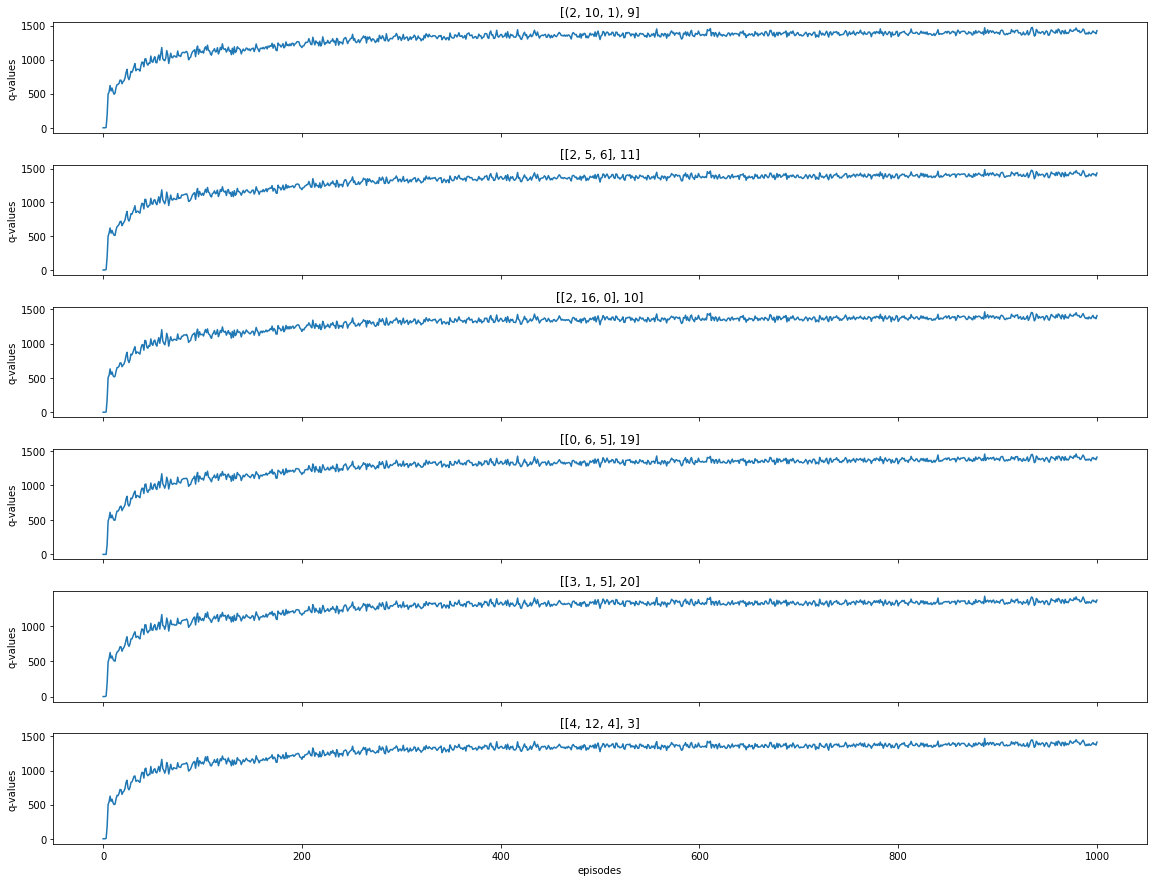

In [12]:
fig, axs = plt.subplots(len(states_action_to_track), figsize=(16,12))
fig.tight_layout()

def draw(i):
    x_axis = range(0, len(state_action_tracked_results[i]))
    y_axis = state_action_tracked_results[i]
    axs[i].plot(x_axis,y_axis)
    axs[i].set_title(states_action_to_track[i])

for i in range(len(states_action_to_track)):
  draw(i)  

for ax in axs.flat:
   ax.set(xlabel='episodes', ylabel='q-values')
  
for ax in axs.flat:
    ax.label_outer()

#### Tracking Rewards

Rewards should as well converge over time, as the exploration ends the explotations starts, the rewards should increase and stabilize at the end.

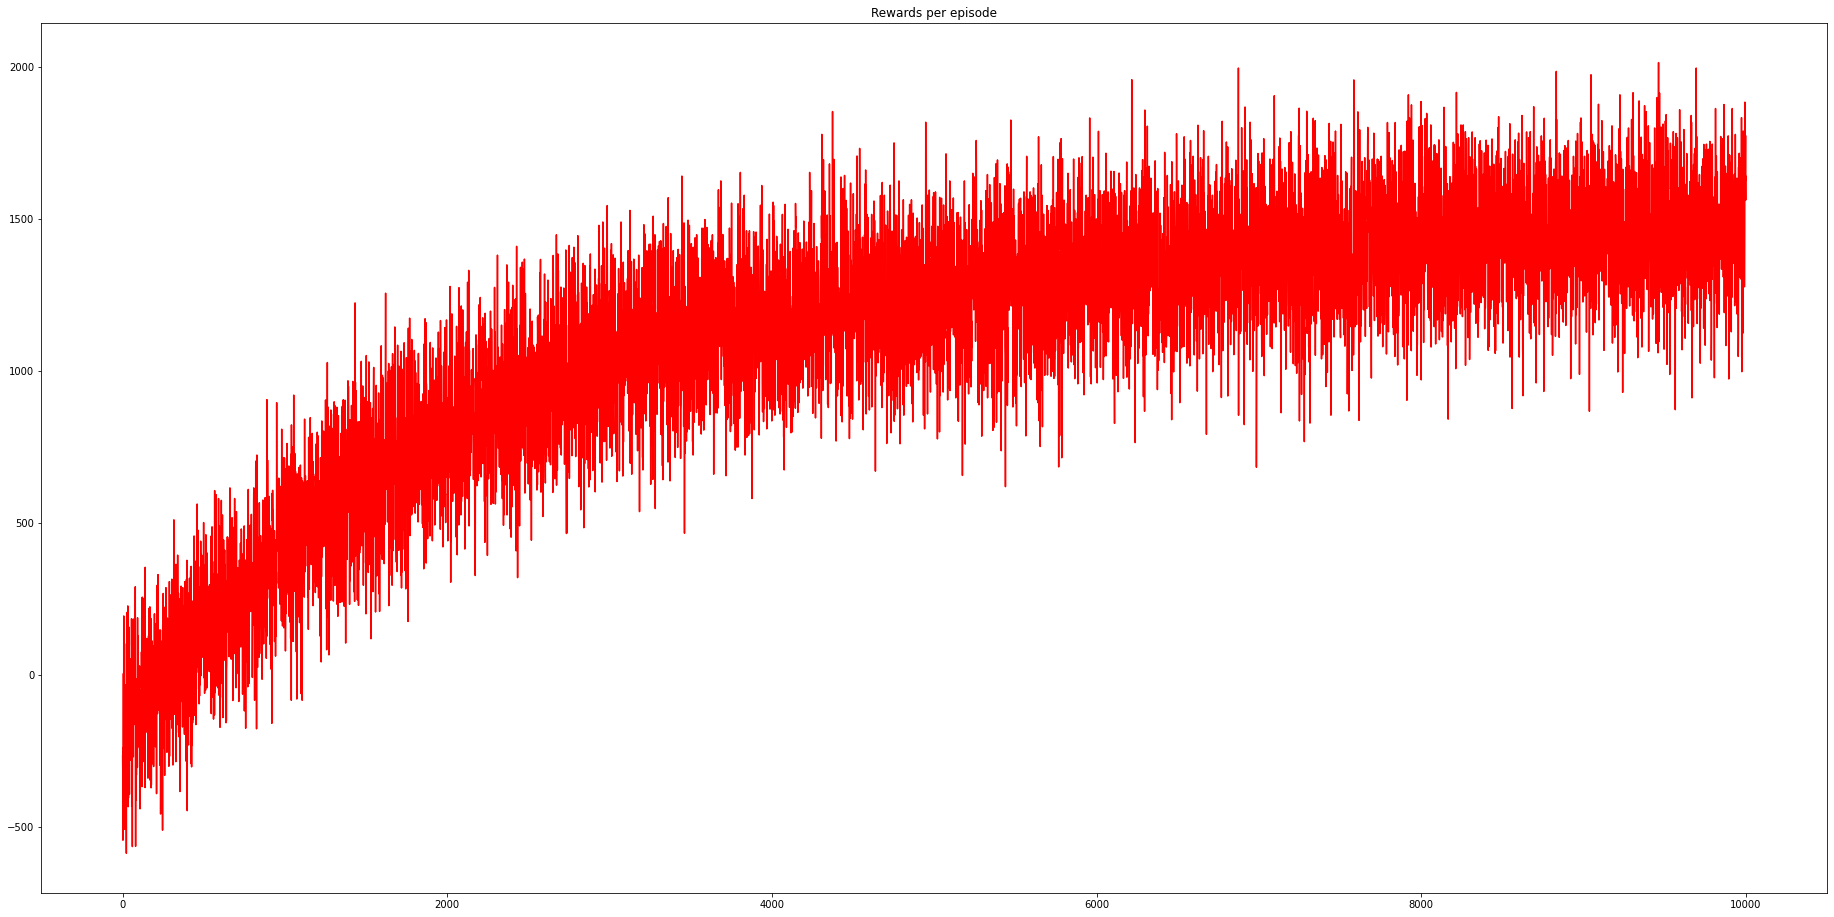

In [13]:
x_axis = np.asarray(range(0, len(rewards_tracked)))
y_axis = np.asarray(rewards_tracked)
plt.figure(0, figsize=(32,16))
plt.title('Rewards per episode')
plt.plot(x_axis,y_axis,'red')
plt.show()

#### Tracking Loss

This is the training loss of the q-network this should come down and stabilize at the end.

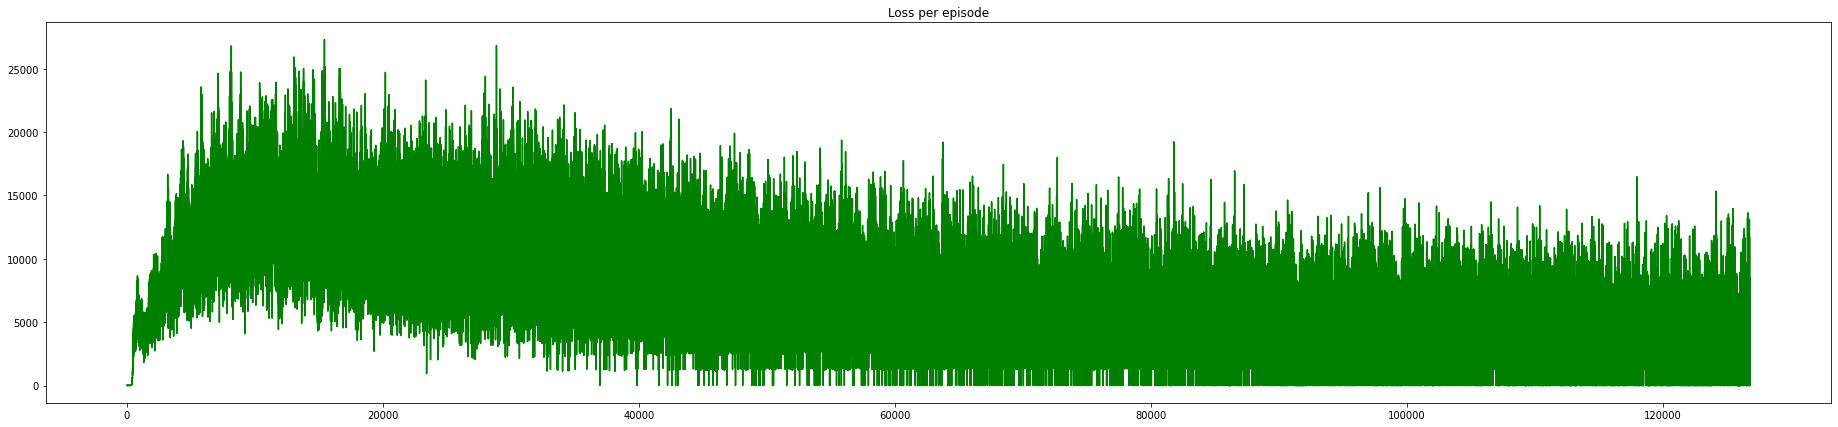

In [14]:
x_axis = np.asarray(range(0, len(loss_tracked)))
y_axis = np.asarray(loss_tracked)
plt.figure(0, figsize=(32,7))
plt.title('Loss per episode')
plt.plot(x_axis,y_axis,'green')

### Epsilon-decay sample function

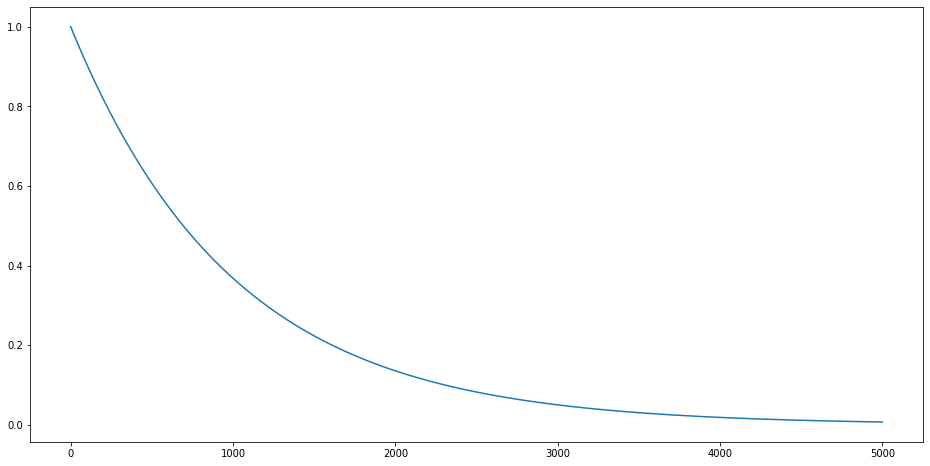

In [15]:
episodes = 5000
plt.figure(0, figsize=(16,8))
time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(0.0001 + (1.0 - 0.0001) * np.exp(-0.001*i))
plt.plot(time, epsilon)
plt.show()

# Epsilon values per episode
# 100 - 0.05
# 1000 - 0.005
# 5000 - 0.001
# 10000 - 0.0005
# 20000 - 0.0003
# 30000 - 0.0002